In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm  # 
from pathlib import Path


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.backends.cudnn.benchmark = True


if torch.cuda.is_available():
    print(f"cuda:True")
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")
else:
    print(f"cuda:False")
    device = torch.device("cpu")


from models_LN import FNN_LN, dataset, one_hot, cross_entropy_loss, linear, linear_d, tanh, tanh_d, sign, sign_d, sigmoid, sigmoid_d, relu, relu_d, relu6, relu6_d, softmax, softmax_d

torch.set_grad_enabled(False)

cuda:True
GPU 0:NVIDIA GeForce RTX 4070:11.99GB


In [ ]:

class Config:
    def __init__(self):
        self.n_input = 28 * 28  # 
        self.n_hidd = 16     # 
        self.n_out = 10      # 

        self.nL_hidd = 2

        self.sc_forward = 1
        self.sc_bias = 0
        self.sc_back = 1

        self.f = tanh #  relu tanh
        self.fd = tanh_d # relu_d tanh_d

        self.train_eta_global = 1e-3  #
        self.train_n_epochs = 100     # 
        self.train_batch_size = 500     # 
        self.train_task = "MNIST" #  "MNIST" "FMNIST" "CIFAR10"
        self.train_tmethod = ''     # 'FA','PC','LRA','BP'

        self.biasLearning = False
        
        self.EP_It2sta = 8
        self.EP_nudge = 1
        
config = Config()

In [3]:
train_loader, valid_loader, test_loader, config = dataset(config)
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
valid_loader_gpu = [(data.to(device), target.to(device)) for data, target in valid_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]

In [4]:
##
ParaName = f'First_symm_LN10_bsc_dynamics_LyapunovE_E'
Einfo = ''

res_path = Path(f"./Res/{ParaName}-{config.train_task}")
M_range = [0.001, 0.01, 0.1, 0.25, 1, 2, 4] # 0.001, 0.01, 0.1, 0.25, 1, 2, 4 fbsc  # 0.01, 0.1, 0.25, 0.5, 1, 2 SRsc
ParaRange = [2,3,5,10] # 2,3,5,8
multitest = 5 
config.save = True
config.ff = softmax
config.ffd = softmax_d
# -=--------------------------
config.train_tmethod = 'EP'
config.nL_hidd = 2
config.n_hidd = 64     # 

config.train_n_epochs = 50  # 

config.EP_symm_W = True
config.adam = True
config.EP_b_learn = False
config.EP_f_sc = 1
config.EP_nudge = 0.1
# config.EP_b_sc = 0.25

In [5]:
# -=--------------------------
res_path.mkdir(parents=True, exist_ok=True)
res = np.zeros((len(M_range),len(ParaRange),(multitest),6,config.train_n_epochs))

zall_list = [[[] for _ in range(len(ParaRange))] for _ in range(len(M_range))]
eall_list = [[[[] for _ in range((multitest))] for _ in range(len(ParaRange))] for _ in range(len(M_range))]

In [6]:
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f'Current Time: {current_time}')
with open(res_path/"res.txt", "a") as f: 
    f.write(f"===================================================================")       
    f.write(f"Start Time: {current_time}\r\n")

Current Time: 20250720-165937


In [7]:
for iPara in range( len(ParaRange) ):
    for iM in range( len(M_range) ):
        for  imultitest in range((multitest)):
            config.EP_b_sc = M_range[iM]
            config.nL_hidd = ParaRange[iPara]

            #-----------------
            config.EP_It2sta = config.nL_hidd *10 
            config.EP_It2sta2 = config.nL_hidd *5
            # ---------------------------------
            model = FNN_LN(config).to(device)

            taskinfo = f'EP_L{config.nL_hidd}_{config.train_task}_{ParaName}-EP_b_sc{M_range[iM]}-EP_It2sta{config.EP_It2sta}-{Einfo}'
            print(taskinfo)

            ## Train

            for epoch in range(config.train_n_epochs):
                losssum = 0
                random.shuffle(train_loader_gpu)
                with tqdm(total=len(train_loader_gpu), desc=f'Epoch {epoch + 1}/{config.train_n_epochs}: ', unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
                    for i, (images, labels) in enumerate(train_loader_gpu):
                        # 
                        images = images.view(-1, config.n_input)
                        labels_one_hot = one_hot(labels, config.n_out, device=device)
                        # 
                        outputs = model.forward(images)
                        # 
                        loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                        losssum += loss.item()
                        #
                        outputs = model.backward(images, labels_one_hot, outputs)
                        # 
                        model.update_weights_adam() if config.adam else model.update_weights() #model.update_weights_adam() model.update_weights()
                        # 
                        if i % 10 == 0: 
                            pbar.set_postfix({'loss': f'{losssum/(i+1):.6f}'})  
                            pbar.update(10)

                SR, ftmle, mle, zall = model.Lyapunov_EP(images[-1:,:], y=None, t_e=500, ret_zall=True)
                if imultitest==0: 
                    zall_list[iM][iPara].append(zall)
                    terr = model.ret_error()
                    eall_list[iM][iPara][imultitest].append(terr)

                # train set ------------------------------------------------------------
                train_correct = 0
                train_total = 0
                losssum = 0
                for images, labels in valid_loader_gpu:
                    images = images.view(-1, config.n_input)
                    labels_one_hot = one_hot(labels, config.n_out, device=device)
                    # 
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    loss = cross_entropy_loss(outputs, labels_one_hot.to(device))
                    losssum += loss.item()
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                train_accuracy = train_correct / train_total

                # test set -------------------------------------------------------------
                test_correct = 0
                test_total = 0
                # ---------
                for images, labels in test_loader_gpu:
                    images = images.view(-1, config.n_input)
                    # 
                    outputs = model.forward(images)

                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

                test_accuracy = test_correct / test_total

                res[iM][iPara][imultitest][0][epoch] = losssum
                res[iM][iPara][imultitest][1][epoch] = train_accuracy
                res[iM][iPara][imultitest][2][epoch] = test_accuracy
                res[iM][iPara][imultitest][3][epoch] = ftmle
                res[iM][iPara][imultitest][4][epoch] = mle
                res[iM][iPara][imultitest][5][epoch] = SR

                current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
                print(f'\t Loss: {res[iM][iPara][imultitest][0][epoch] :.3f},\t'
                    f'Train : {res[iM][iPara][imultitest][1][epoch] * 100:.2f}%({np.max(res[iM][iPara][imultitest][1]) * 100:.2f}%),\t'
                    f'Test : {res[iM][iPara][imultitest][2][epoch] * 100:.2f}%({np.max(res[iM][iPara][imultitest][2]) * 100:.2f}%),\t'
                    f'Current Time: {current_time}')
                
                # if 1-train_accuracy <1e-4:
                #     break
            
            # best result
            print(f"{taskinfo} Time: {current_time}, Epochs: {config.train_n_epochs}, Learning Rate: {config.train_eta_global}, "
                f"Best: {max(res[iM][iPara][imultitest][1]) * 100:.2f}%  {max(res[iM][iPara][imultitest][2]) * 100:.2f}%\n")
            
        for attempt in range(5):
            try:
                with open(res_path/"res.txt", "a") as f:
                    trainacct = np.max(res[iM][iPara][:,1,:], axis=-1)
                    testacct = np.max(res[iM][iPara][:,2,:], axis=-1)
                    f.write(f"{taskinfo} Time: {current_time}: "
                            f"train: {np.mean(trainacct) * 100:.2f}%+-{np.std(trainacct, ddof=1)*100:.2f}% ({np.min(trainacct) * 100:.2f}% {np.max(trainacct) * 100:.2f}%)"
                            f"\t test: {np.mean(testacct) * 100:.2f}%+-{np.std(testacct, ddof=1)*100:.2f}% ({np.min(testacct) * 100:.2f}% {np.max(testacct) * 100:.2f}%)\n")

                    for attr_name in dir(config):
                        if not attr_name.startswith('__') and not callable(getattr(config, attr_name)):  
                            attr_value = getattr(config, attr_name)
                            f.write(f'{attr_name}: {attr_value}  ')  
                    f.write(f'\n\n')  

                break  # 
            except PermissionError:
                if attempt < 5 - 1:
                    print(f"Permission denied, retrying in {5} seconds...")
                    time.sleep(5)
                else:
                    raise  # 
                        
                

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50:   0%|                                              | 0/120 [00:00<?, ?batch/s]d:\HWC\华为云盘\Codepy\aEP\models_LN.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(self.z, device=self.device)
Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 189.03batch/s, loss=0.672079]


	 Loss: 9.729,	Train : 90.93%(90.93%),	Test : 91.41%(91.41%),	Current Time: 20250720-165938


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.23batch/s, loss=0.285494]


	 Loss: 7.240,	Train : 93.17%(93.17%),	Test : 93.10%(93.10%),	Current Time: 20250720-165938


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.77batch/s, loss=0.225883]


	 Loss: 5.958,	Train : 94.33%(94.33%),	Test : 94.07%(94.07%),	Current Time: 20250720-165939


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.83batch/s, loss=0.187538]


	 Loss: 4.973,	Train : 95.26%(95.26%),	Test : 94.98%(94.98%),	Current Time: 20250720-165940


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.80batch/s, loss=0.159542]


	 Loss: 4.210,	Train : 96.01%(96.01%),	Test : 95.70%(95.70%),	Current Time: 20250720-165941


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.03batch/s, loss=0.134776]


	 Loss: 3.604,	Train : 96.62%(96.62%),	Test : 96.09%(96.09%),	Current Time: 20250720-165942


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.45batch/s, loss=0.117225]


	 Loss: 3.093,	Train : 97.06%(97.06%),	Test : 96.48%(96.48%),	Current Time: 20250720-165942


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 211.33batch/s, loss=0.101463]


	 Loss: 2.687,	Train : 97.50%(97.50%),	Test : 96.59%(96.59%),	Current Time: 20250720-165943


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.49batch/s, loss=0.089691]


	 Loss: 2.412,	Train : 97.76%(97.76%),	Test : 96.91%(96.91%),	Current Time: 20250720-165944


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.59batch/s, loss=0.079669]


	 Loss: 2.166,	Train : 98.02%(98.02%),	Test : 96.83%(96.91%),	Current Time: 20250720-165945


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.55batch/s, loss=0.071713]


	 Loss: 1.950,	Train : 98.26%(98.26%),	Test : 97.11%(97.11%),	Current Time: 20250720-165946


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 207.12batch/s, loss=0.064319]


	 Loss: 1.695,	Train : 98.46%(98.46%),	Test : 97.17%(97.17%),	Current Time: 20250720-165946


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.32batch/s, loss=0.056896]


	 Loss: 1.489,	Train : 98.70%(98.70%),	Test : 97.44%(97.44%),	Current Time: 20250720-165947


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.31batch/s, loss=0.051404]


	 Loss: 1.333,	Train : 98.85%(98.85%),	Test : 97.39%(97.44%),	Current Time: 20250720-165948


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.40batch/s, loss=0.046937]


	 Loss: 1.262,	Train : 98.91%(98.91%),	Test : 97.36%(97.44%),	Current Time: 20250720-165949


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.42batch/s, loss=0.042260]


	 Loss: 1.132,	Train : 99.08%(99.08%),	Test : 97.29%(97.44%),	Current Time: 20250720-165950


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.09batch/s, loss=0.039070]


	 Loss: 0.983,	Train : 99.18%(99.18%),	Test : 97.53%(97.53%),	Current Time: 20250720-165950


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.17batch/s, loss=0.035055]


	 Loss: 0.908,	Train : 99.28%(99.28%),	Test : 97.49%(97.53%),	Current Time: 20250720-165951


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.60batch/s, loss=0.031315]


	 Loss: 0.834,	Train : 99.34%(99.34%),	Test : 97.50%(97.53%),	Current Time: 20250720-165952


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 187.37batch/s, loss=0.028422]


	 Loss: 0.743,	Train : 99.45%(99.45%),	Test : 97.50%(97.53%),	Current Time: 20250720-165953


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.32batch/s, loss=0.026145]


	 Loss: 0.701,	Train : 99.46%(99.46%),	Test : 97.61%(97.61%),	Current Time: 20250720-165954


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.35batch/s, loss=0.023574]


	 Loss: 0.598,	Train : 99.64%(99.64%),	Test : 97.71%(97.71%),	Current Time: 20250720-165954


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.94batch/s, loss=0.020454]


	 Loss: 0.540,	Train : 99.65%(99.65%),	Test : 97.56%(97.71%),	Current Time: 20250720-165955


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.55batch/s, loss=0.018739]


	 Loss: 0.463,	Train : 99.76%(99.76%),	Test : 97.71%(97.71%),	Current Time: 20250720-165956


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.24batch/s, loss=0.017620]


	 Loss: 0.494,	Train : 99.69%(99.76%),	Test : 97.60%(97.71%),	Current Time: 20250720-165957


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.42batch/s, loss=0.015275]


	 Loss: 0.429,	Train : 99.75%(99.76%),	Test : 97.66%(97.71%),	Current Time: 20250720-165957


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.27batch/s, loss=0.013786]


	 Loss: 0.387,	Train : 99.79%(99.79%),	Test : 97.58%(97.71%),	Current Time: 20250720-165958


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.44batch/s, loss=0.012439]


	 Loss: 0.286,	Train : 99.90%(99.90%),	Test : 97.60%(97.71%),	Current Time: 20250720-165959


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.45batch/s, loss=0.010862]


	 Loss: 0.297,	Train : 99.88%(99.90%),	Test : 97.68%(97.71%),	Current Time: 20250720-170000


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.57batch/s, loss=0.009953]


	 Loss: 0.257,	Train : 99.90%(99.90%),	Test : 97.64%(97.71%),	Current Time: 20250720-170001


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.83batch/s, loss=0.009129]


	 Loss: 0.242,	Train : 99.91%(99.91%),	Test : 97.49%(97.71%),	Current Time: 20250720-170001


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.49batch/s, loss=0.008721]


	 Loss: 0.192,	Train : 99.95%(99.95%),	Test : 97.71%(97.71%),	Current Time: 20250720-170002


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.25batch/s, loss=0.006978]


	 Loss: 0.162,	Train : 99.97%(99.97%),	Test : 97.69%(97.71%),	Current Time: 20250720-170003


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.97batch/s, loss=0.006297]


	 Loss: 0.162,	Train : 99.97%(99.97%),	Test : 97.69%(97.71%),	Current Time: 20250720-170004


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.63batch/s, loss=0.005855]


	 Loss: 0.146,	Train : 99.97%(99.97%),	Test : 97.69%(97.71%),	Current Time: 20250720-170005


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.32batch/s, loss=0.005100]


	 Loss: 0.115,	Train : 99.98%(99.98%),	Test : 97.79%(97.79%),	Current Time: 20250720-170005


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.03batch/s, loss=0.004212]


	 Loss: 0.110,	Train : 99.99%(99.99%),	Test : 97.62%(97.79%),	Current Time: 20250720-170006


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.62batch/s, loss=0.004262]


	 Loss: 0.124,	Train : 99.98%(99.99%),	Test : 97.61%(97.79%),	Current Time: 20250720-170007


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.68batch/s, loss=0.003500]


	 Loss: 0.089,	Train : 100.00%(100.00%),	Test : 97.68%(97.79%),	Current Time: 20250720-170008


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.56batch/s, loss=0.003207]


	 Loss: 0.075,	Train : 100.00%(100.00%),	Test : 97.63%(97.79%),	Current Time: 20250720-170009


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.80batch/s, loss=0.002641]


	 Loss: 0.076,	Train : 100.00%(100.00%),	Test : 97.70%(97.79%),	Current Time: 20250720-170009


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.02batch/s, loss=0.002487]


	 Loss: 0.064,	Train : 100.00%(100.00%),	Test : 97.79%(97.79%),	Current Time: 20250720-170010


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.10batch/s, loss=0.002208]


	 Loss: 0.056,	Train : 100.00%(100.00%),	Test : 97.68%(97.79%),	Current Time: 20250720-170011


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.74batch/s, loss=0.002000]


	 Loss: 0.053,	Train : 100.00%(100.00%),	Test : 97.68%(97.79%),	Current Time: 20250720-170012


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.28batch/s, loss=0.001900]


	 Loss: 0.048,	Train : 100.00%(100.00%),	Test : 97.73%(97.79%),	Current Time: 20250720-170012


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.33batch/s, loss=0.001692]


	 Loss: 0.045,	Train : 100.00%(100.00%),	Test : 97.78%(97.79%),	Current Time: 20250720-170013


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.59batch/s, loss=0.001453]


	 Loss: 0.040,	Train : 100.00%(100.00%),	Test : 97.62%(97.79%),	Current Time: 20250720-170014


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.16batch/s, loss=0.001338]


	 Loss: 0.037,	Train : 100.00%(100.00%),	Test : 97.71%(97.79%),	Current Time: 20250720-170015


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.19batch/s, loss=0.001277]


	 Loss: 0.033,	Train : 100.00%(100.00%),	Test : 97.70%(97.79%),	Current Time: 20250720-170016


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.67batch/s, loss=0.001158]


	 Loss: 0.029,	Train : 100.00%(100.00%),	Test : 97.69%(97.79%),	Current Time: 20250720-170016
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-170016, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.79%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.62batch/s, loss=0.663840]


	 Loss: 9.583,	Train : 91.09%(91.09%),	Test : 91.14%(91.14%),	Current Time: 20250720-170017


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.86batch/s, loss=0.277926]


	 Loss: 7.119,	Train : 93.27%(93.27%),	Test : 93.18%(93.18%),	Current Time: 20250720-170018


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.90batch/s, loss=0.217638]


	 Loss: 5.677,	Train : 94.64%(94.64%),	Test : 94.40%(94.40%),	Current Time: 20250720-170019


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.05batch/s, loss=0.178585]


	 Loss: 4.733,	Train : 95.54%(95.54%),	Test : 95.18%(95.18%),	Current Time: 20250720-170020


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.35batch/s, loss=0.150530]


	 Loss: 4.037,	Train : 96.19%(96.19%),	Test : 95.75%(95.75%),	Current Time: 20250720-170020


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.15batch/s, loss=0.128279]


	 Loss: 3.410,	Train : 96.78%(96.78%),	Test : 96.05%(96.05%),	Current Time: 20250720-170021


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.10batch/s, loss=0.109325]


	 Loss: 2.941,	Train : 97.22%(97.22%),	Test : 96.43%(96.43%),	Current Time: 20250720-170022


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.32batch/s, loss=0.096757]


	 Loss: 2.598,	Train : 97.61%(97.61%),	Test : 96.70%(96.70%),	Current Time: 20250720-170023


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.14batch/s, loss=0.085947]


	 Loss: 2.265,	Train : 97.86%(97.86%),	Test : 97.01%(97.01%),	Current Time: 20250720-170023


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.35batch/s, loss=0.076055]


	 Loss: 2.044,	Train : 98.10%(98.10%),	Test : 96.92%(97.01%),	Current Time: 20250720-170024


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.13batch/s, loss=0.068425]


	 Loss: 1.803,	Train : 98.34%(98.34%),	Test : 97.18%(97.18%),	Current Time: 20250720-170025


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.28batch/s, loss=0.060423]


	 Loss: 1.594,	Train : 98.50%(98.50%),	Test : 97.42%(97.42%),	Current Time: 20250720-170026


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.20batch/s, loss=0.055573]


	 Loss: 1.417,	Train : 98.74%(98.74%),	Test : 97.41%(97.42%),	Current Time: 20250720-170027


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.06batch/s, loss=0.049799]


	 Loss: 1.308,	Train : 98.88%(98.88%),	Test : 97.31%(97.42%),	Current Time: 20250720-170027


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.45batch/s, loss=0.044973]


	 Loss: 1.156,	Train : 99.06%(99.06%),	Test : 97.37%(97.42%),	Current Time: 20250720-170028


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.01batch/s, loss=0.040319]


	 Loss: 1.038,	Train : 99.15%(99.15%),	Test : 97.55%(97.55%),	Current Time: 20250720-170029


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.08batch/s, loss=0.036712]


	 Loss: 0.916,	Train : 99.30%(99.30%),	Test : 97.57%(97.57%),	Current Time: 20250720-170030


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.32batch/s, loss=0.032684]


	 Loss: 0.856,	Train : 99.33%(99.33%),	Test : 97.67%(97.67%),	Current Time: 20250720-170031


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.22batch/s, loss=0.029798]


	 Loss: 0.755,	Train : 99.50%(99.50%),	Test : 97.57%(97.67%),	Current Time: 20250720-170031


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.01batch/s, loss=0.027152]


	 Loss: 0.675,	Train : 99.54%(99.54%),	Test : 97.51%(97.67%),	Current Time: 20250720-170032


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.47batch/s, loss=0.024795]


	 Loss: 0.641,	Train : 99.54%(99.54%),	Test : 97.57%(97.67%),	Current Time: 20250720-170033


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.21batch/s, loss=0.021873]


	 Loss: 0.514,	Train : 99.70%(99.70%),	Test : 97.62%(97.67%),	Current Time: 20250720-170034


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.82batch/s, loss=0.019936]


	 Loss: 0.502,	Train : 99.73%(99.73%),	Test : 97.58%(97.67%),	Current Time: 20250720-170034


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.81batch/s, loss=0.017841]


	 Loss: 0.420,	Train : 99.80%(99.80%),	Test : 97.63%(97.67%),	Current Time: 20250720-170035


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.14batch/s, loss=0.015263]


	 Loss: 0.367,	Train : 99.83%(99.83%),	Test : 97.58%(97.67%),	Current Time: 20250720-170036


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.00batch/s, loss=0.013657]


	 Loss: 0.346,	Train : 99.85%(99.85%),	Test : 97.55%(97.67%),	Current Time: 20250720-170037


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.16batch/s, loss=0.012730]


	 Loss: 0.303,	Train : 99.90%(99.90%),	Test : 97.72%(97.72%),	Current Time: 20250720-170038


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.66batch/s, loss=0.011004]


	 Loss: 0.276,	Train : 99.90%(99.90%),	Test : 97.68%(97.72%),	Current Time: 20250720-170038


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.59batch/s, loss=0.010571]


	 Loss: 0.256,	Train : 99.91%(99.91%),	Test : 97.62%(97.72%),	Current Time: 20250720-170039


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.97batch/s, loss=0.009164]


	 Loss: 0.213,	Train : 99.94%(99.94%),	Test : 97.57%(97.72%),	Current Time: 20250720-170040


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.91batch/s, loss=0.007922]


	 Loss: 0.209,	Train : 99.94%(99.94%),	Test : 97.59%(97.72%),	Current Time: 20250720-170041


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.21batch/s, loss=0.007332]


	 Loss: 0.202,	Train : 99.94%(99.94%),	Test : 97.66%(97.72%),	Current Time: 20250720-170041


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.20batch/s, loss=0.006248]


	 Loss: 0.155,	Train : 99.97%(99.97%),	Test : 97.66%(97.72%),	Current Time: 20250720-170042


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.22batch/s, loss=0.005656]


	 Loss: 0.141,	Train : 99.98%(99.98%),	Test : 97.59%(97.72%),	Current Time: 20250720-170043


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.00batch/s, loss=0.005032]


	 Loss: 0.145,	Train : 99.96%(99.98%),	Test : 97.63%(97.72%),	Current Time: 20250720-170044


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.32batch/s, loss=0.004616]


	 Loss: 0.124,	Train : 99.98%(99.98%),	Test : 97.65%(97.72%),	Current Time: 20250720-170045


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.34batch/s, loss=0.004272]


	 Loss: 0.105,	Train : 99.98%(99.98%),	Test : 97.59%(97.72%),	Current Time: 20250720-170045


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.71batch/s, loss=0.003971]


	 Loss: 0.100,	Train : 99.99%(99.99%),	Test : 97.68%(97.72%),	Current Time: 20250720-170046


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.10batch/s, loss=0.003382]


	 Loss: 0.074,	Train : 100.00%(100.00%),	Test : 97.64%(97.72%),	Current Time: 20250720-170047


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.14batch/s, loss=0.002794]


	 Loss: 0.069,	Train : 100.00%(100.00%),	Test : 97.64%(97.72%),	Current Time: 20250720-170048


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.53batch/s, loss=0.002559]


	 Loss: 0.067,	Train : 100.00%(100.00%),	Test : 97.64%(97.72%),	Current Time: 20250720-170048


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.24batch/s, loss=0.002241]


	 Loss: 0.056,	Train : 100.00%(100.00%),	Test : 97.67%(97.72%),	Current Time: 20250720-170049


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.78batch/s, loss=0.002000]


	 Loss: 0.051,	Train : 100.00%(100.00%),	Test : 97.68%(97.72%),	Current Time: 20250720-170050


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.30batch/s, loss=0.001811]


	 Loss: 0.048,	Train : 100.00%(100.00%),	Test : 97.58%(97.72%),	Current Time: 20250720-170051


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.43batch/s, loss=0.001687]


	 Loss: 0.050,	Train : 100.00%(100.00%),	Test : 97.61%(97.72%),	Current Time: 20250720-170052


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.39batch/s, loss=0.001534]


	 Loss: 0.042,	Train : 100.00%(100.00%),	Test : 97.58%(97.72%),	Current Time: 20250720-170052


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.50batch/s, loss=0.001553]


	 Loss: 0.039,	Train : 100.00%(100.00%),	Test : 97.63%(97.72%),	Current Time: 20250720-170053


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.93batch/s, loss=0.001289]


	 Loss: 0.031,	Train : 100.00%(100.00%),	Test : 97.61%(97.72%),	Current Time: 20250720-170054


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.75batch/s, loss=0.001161]


	 Loss: 0.034,	Train : 100.00%(100.00%),	Test : 97.60%(97.72%),	Current Time: 20250720-170055


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.94batch/s, loss=0.001478]


	 Loss: 0.034,	Train : 100.00%(100.00%),	Test : 97.67%(97.72%),	Current Time: 20250720-170056
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-170056, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.72%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.27batch/s, loss=0.677215]


	 Loss: 9.653,	Train : 91.09%(91.09%),	Test : 91.33%(91.33%),	Current Time: 20250720-170056


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.32batch/s, loss=0.282317]


	 Loss: 7.164,	Train : 93.23%(93.23%),	Test : 93.28%(93.28%),	Current Time: 20250720-170057


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.39batch/s, loss=0.221299]


	 Loss: 5.762,	Train : 94.58%(94.58%),	Test : 94.23%(94.23%),	Current Time: 20250720-170058


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.99batch/s, loss=0.182683]


	 Loss: 4.904,	Train : 95.40%(95.40%),	Test : 94.89%(94.89%),	Current Time: 20250720-170059


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.17batch/s, loss=0.153910]


	 Loss: 4.026,	Train : 96.23%(96.23%),	Test : 95.62%(95.62%),	Current Time: 20250720-170059


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.98batch/s, loss=0.132523]


	 Loss: 3.482,	Train : 96.68%(96.68%),	Test : 95.95%(95.95%),	Current Time: 20250720-170100


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.33batch/s, loss=0.114751]


	 Loss: 3.058,	Train : 97.16%(97.16%),	Test : 96.38%(96.38%),	Current Time: 20250720-170101


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.48batch/s, loss=0.100485]


	 Loss: 2.660,	Train : 97.49%(97.49%),	Test : 96.49%(96.49%),	Current Time: 20250720-170102


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.47batch/s, loss=0.090379]


	 Loss: 2.366,	Train : 97.79%(97.79%),	Test : 96.75%(96.75%),	Current Time: 20250720-170103


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.56batch/s, loss=0.079852]


	 Loss: 2.115,	Train : 98.02%(98.02%),	Test : 96.84%(96.84%),	Current Time: 20250720-170103


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.33batch/s, loss=0.072457]


	 Loss: 1.873,	Train : 98.26%(98.26%),	Test : 96.96%(96.96%),	Current Time: 20250720-170104


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.97batch/s, loss=0.064663]


	 Loss: 1.733,	Train : 98.37%(98.37%),	Test : 96.94%(96.96%),	Current Time: 20250720-170105


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.04batch/s, loss=0.055807]


	 Loss: 1.518,	Train : 98.66%(98.66%),	Test : 97.11%(97.11%),	Current Time: 20250720-170106


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.21batch/s, loss=0.051736]


	 Loss: 1.369,	Train : 98.86%(98.86%),	Test : 97.16%(97.16%),	Current Time: 20250720-170106


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.30batch/s, loss=0.047564]


	 Loss: 1.209,	Train : 98.99%(98.99%),	Test : 97.27%(97.27%),	Current Time: 20250720-170107


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.02batch/s, loss=0.041719]


	 Loss: 1.071,	Train : 99.13%(99.13%),	Test : 97.39%(97.39%),	Current Time: 20250720-170108


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.64batch/s, loss=0.038070]


	 Loss: 0.990,	Train : 99.17%(99.17%),	Test : 97.32%(97.39%),	Current Time: 20250720-170109


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.38batch/s, loss=0.034129]


	 Loss: 0.876,	Train : 99.33%(99.33%),	Test : 97.40%(97.40%),	Current Time: 20250720-170110


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.28batch/s, loss=0.032599]


	 Loss: 0.785,	Train : 99.44%(99.44%),	Test : 97.46%(97.46%),	Current Time: 20250720-170110


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.04batch/s, loss=0.028189]


	 Loss: 0.732,	Train : 99.41%(99.44%),	Test : 97.47%(97.47%),	Current Time: 20250720-170111


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.97batch/s, loss=0.025867]


	 Loss: 0.680,	Train : 99.45%(99.45%),	Test : 97.41%(97.47%),	Current Time: 20250720-170112


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.29batch/s, loss=0.022678]


	 Loss: 0.556,	Train : 99.68%(99.68%),	Test : 97.53%(97.53%),	Current Time: 20250720-170113


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.85batch/s, loss=0.021146]


	 Loss: 0.524,	Train : 99.67%(99.68%),	Test : 97.54%(97.54%),	Current Time: 20250720-170113


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.76batch/s, loss=0.018651]


	 Loss: 0.435,	Train : 99.79%(99.79%),	Test : 97.57%(97.57%),	Current Time: 20250720-170114


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.91batch/s, loss=0.016281]


	 Loss: 0.400,	Train : 99.80%(99.80%),	Test : 97.47%(97.57%),	Current Time: 20250720-170115


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.90batch/s, loss=0.014711]


	 Loss: 0.392,	Train : 99.82%(99.82%),	Test : 97.32%(97.57%),	Current Time: 20250720-170116


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.46batch/s, loss=0.012884]


	 Loss: 0.322,	Train : 99.88%(99.88%),	Test : 97.53%(97.57%),	Current Time: 20250720-170117


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.34batch/s, loss=0.011620]


	 Loss: 0.299,	Train : 99.90%(99.90%),	Test : 97.54%(97.57%),	Current Time: 20250720-170117


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.65batch/s, loss=0.010656]


	 Loss: 0.284,	Train : 99.88%(99.90%),	Test : 97.40%(97.57%),	Current Time: 20250720-170118


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.22batch/s, loss=0.009715]


	 Loss: 0.226,	Train : 99.94%(99.94%),	Test : 97.66%(97.66%),	Current Time: 20250720-170119


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.63batch/s, loss=0.008576]


	 Loss: 0.201,	Train : 99.96%(99.96%),	Test : 97.66%(97.66%),	Current Time: 20250720-170120


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.36batch/s, loss=0.007282]


	 Loss: 0.173,	Train : 99.96%(99.96%),	Test : 97.59%(97.66%),	Current Time: 20250720-170120


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.78batch/s, loss=0.006621]


	 Loss: 0.166,	Train : 99.97%(99.97%),	Test : 97.45%(97.66%),	Current Time: 20250720-170121


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.17batch/s, loss=0.006031]


	 Loss: 0.148,	Train : 99.98%(99.98%),	Test : 97.48%(97.66%),	Current Time: 20250720-170122


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.12batch/s, loss=0.005359]


	 Loss: 0.125,	Train : 99.98%(99.98%),	Test : 97.64%(97.66%),	Current Time: 20250720-170123


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.56batch/s, loss=0.004748]


	 Loss: 0.106,	Train : 99.99%(99.99%),	Test : 97.65%(97.66%),	Current Time: 20250720-170124


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.73batch/s, loss=0.004097]


	 Loss: 0.119,	Train : 99.99%(99.99%),	Test : 97.60%(97.66%),	Current Time: 20250720-170124


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.75batch/s, loss=0.003624]


	 Loss: 0.090,	Train : 100.00%(100.00%),	Test : 97.58%(97.66%),	Current Time: 20250720-170125


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.95batch/s, loss=0.003445]


	 Loss: 0.075,	Train : 100.00%(100.00%),	Test : 97.58%(97.66%),	Current Time: 20250720-170126


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.36batch/s, loss=0.002937]


	 Loss: 0.070,	Train : 100.00%(100.00%),	Test : 97.63%(97.66%),	Current Time: 20250720-170127


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.99batch/s, loss=0.002634]


	 Loss: 0.081,	Train : 99.99%(100.00%),	Test : 97.64%(97.66%),	Current Time: 20250720-170128


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.35batch/s, loss=0.002383]


	 Loss: 0.066,	Train : 99.99%(100.00%),	Test : 97.55%(97.66%),	Current Time: 20250720-170128


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.05batch/s, loss=0.002171]


	 Loss: 0.057,	Train : 100.00%(100.00%),	Test : 97.58%(97.66%),	Current Time: 20250720-170129


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.41batch/s, loss=0.001910]


	 Loss: 0.048,	Train : 100.00%(100.00%),	Test : 97.61%(97.66%),	Current Time: 20250720-170130


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.92batch/s, loss=0.001855]


	 Loss: 0.052,	Train : 99.99%(100.00%),	Test : 97.51%(97.66%),	Current Time: 20250720-170131


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.17batch/s, loss=0.001644]


	 Loss: 0.042,	Train : 100.00%(100.00%),	Test : 97.57%(97.66%),	Current Time: 20250720-170132


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.95batch/s, loss=0.001448]


	 Loss: 0.039,	Train : 100.00%(100.00%),	Test : 97.59%(97.66%),	Current Time: 20250720-170132


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.72batch/s, loss=0.001326]


	 Loss: 0.037,	Train : 100.00%(100.00%),	Test : 97.60%(97.66%),	Current Time: 20250720-170133


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.09batch/s, loss=0.001236]


	 Loss: 0.030,	Train : 100.00%(100.00%),	Test : 97.61%(97.66%),	Current Time: 20250720-170134


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.63batch/s, loss=0.001057]


	 Loss: 0.027,	Train : 100.00%(100.00%),	Test : 97.55%(97.66%),	Current Time: 20250720-170135
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-170135, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.66%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.60batch/s, loss=0.735141]


	 Loss: 9.992,	Train : 90.83%(90.83%),	Test : 91.44%(91.44%),	Current Time: 20250720-170135


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.89batch/s, loss=0.289590]


	 Loss: 7.269,	Train : 93.18%(93.18%),	Test : 93.06%(93.06%),	Current Time: 20250720-170136


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.12batch/s, loss=0.226104]


	 Loss: 5.976,	Train : 94.23%(94.23%),	Test : 93.86%(93.86%),	Current Time: 20250720-170137


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.86batch/s, loss=0.186556]


	 Loss: 5.017,	Train : 95.20%(95.20%),	Test : 94.63%(94.63%),	Current Time: 20250720-170138


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.98batch/s, loss=0.157914]


	 Loss: 4.172,	Train : 96.00%(96.00%),	Test : 95.43%(95.43%),	Current Time: 20250720-170139


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.38batch/s, loss=0.136679]


	 Loss: 3.594,	Train : 96.52%(96.52%),	Test : 95.89%(95.89%),	Current Time: 20250720-170139


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.89batch/s, loss=0.117954]


	 Loss: 3.161,	Train : 96.95%(96.95%),	Test : 96.07%(96.07%),	Current Time: 20250720-170140


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 210.76batch/s, loss=0.105444]


	 Loss: 2.773,	Train : 97.34%(97.34%),	Test : 96.35%(96.35%),	Current Time: 20250720-170141


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.11batch/s, loss=0.093401]


	 Loss: 2.459,	Train : 97.64%(97.64%),	Test : 96.73%(96.73%),	Current Time: 20250720-170142


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.65batch/s, loss=0.081592]


	 Loss: 2.176,	Train : 98.01%(98.01%),	Test : 96.77%(96.77%),	Current Time: 20250720-170142


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.46batch/s, loss=0.074769]


	 Loss: 1.970,	Train : 98.17%(98.17%),	Test : 96.75%(96.77%),	Current Time: 20250720-170143


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.61batch/s, loss=0.065303]


	 Loss: 1.731,	Train : 98.42%(98.42%),	Test : 96.98%(96.98%),	Current Time: 20250720-170144


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.33batch/s, loss=0.059374]


	 Loss: 1.544,	Train : 98.62%(98.62%),	Test : 97.05%(97.05%),	Current Time: 20250720-170145


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.67batch/s, loss=0.053630]


	 Loss: 1.359,	Train : 98.81%(98.81%),	Test : 97.21%(97.21%),	Current Time: 20250720-170146


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.78batch/s, loss=0.049099]


	 Loss: 1.359,	Train : 98.73%(98.81%),	Test : 97.11%(97.21%),	Current Time: 20250720-170146


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.04batch/s, loss=0.043903]


	 Loss: 1.139,	Train : 99.01%(99.01%),	Test : 97.32%(97.32%),	Current Time: 20250720-170147


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.18batch/s, loss=0.040372]


	 Loss: 1.005,	Train : 99.21%(99.21%),	Test : 97.36%(97.36%),	Current Time: 20250720-170148


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.34batch/s, loss=0.036070]


	 Loss: 0.911,	Train : 99.28%(99.28%),	Test : 97.39%(97.39%),	Current Time: 20250720-170149


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.70batch/s, loss=0.033521]


	 Loss: 0.828,	Train : 99.35%(99.35%),	Test : 97.38%(97.39%),	Current Time: 20250720-170150


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.22batch/s, loss=0.029866]


	 Loss: 0.775,	Train : 99.46%(99.46%),	Test : 97.20%(97.39%),	Current Time: 20250720-170150


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.13batch/s, loss=0.026195]


	 Loss: 0.732,	Train : 99.42%(99.46%),	Test : 97.35%(97.39%),	Current Time: 20250720-170151


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.12batch/s, loss=0.024880]


	 Loss: 0.608,	Train : 99.59%(99.59%),	Test : 97.34%(97.39%),	Current Time: 20250720-170152


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.38batch/s, loss=0.021770]


	 Loss: 0.556,	Train : 99.66%(99.66%),	Test : 97.39%(97.39%),	Current Time: 20250720-170153


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.81batch/s, loss=0.018938]


	 Loss: 0.469,	Train : 99.72%(99.72%),	Test : 97.41%(97.41%),	Current Time: 20250720-170154


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.26batch/s, loss=0.017415]


	 Loss: 0.471,	Train : 99.71%(99.72%),	Test : 97.34%(97.41%),	Current Time: 20250720-170154


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.04batch/s, loss=0.015443]


	 Loss: 0.395,	Train : 99.80%(99.80%),	Test : 97.32%(97.41%),	Current Time: 20250720-170155


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.79batch/s, loss=0.014341]


	 Loss: 0.399,	Train : 99.75%(99.80%),	Test : 97.28%(97.41%),	Current Time: 20250720-170156


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.55batch/s, loss=0.012960]


	 Loss: 0.313,	Train : 99.87%(99.87%),	Test : 97.49%(97.49%),	Current Time: 20250720-170157


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.14batch/s, loss=0.011265]


	 Loss: 0.348,	Train : 99.79%(99.87%),	Test : 97.25%(97.49%),	Current Time: 20250720-170158


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.48batch/s, loss=0.011036]


	 Loss: 0.246,	Train : 99.94%(99.94%),	Test : 97.45%(97.49%),	Current Time: 20250720-170158


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.01batch/s, loss=0.008881]


	 Loss: 0.230,	Train : 99.93%(99.94%),	Test : 97.58%(97.58%),	Current Time: 20250720-170159


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.45batch/s, loss=0.008373]


	 Loss: 0.196,	Train : 99.96%(99.96%),	Test : 97.41%(97.58%),	Current Time: 20250720-170200


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.36batch/s, loss=0.007025]


	 Loss: 0.165,	Train : 99.98%(99.98%),	Test : 97.41%(97.58%),	Current Time: 20250720-170201


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.43batch/s, loss=0.006214]


	 Loss: 0.146,	Train : 99.98%(99.98%),	Test : 97.48%(97.58%),	Current Time: 20250720-170201


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.16batch/s, loss=0.005699]


	 Loss: 0.140,	Train : 99.98%(99.98%),	Test : 97.53%(97.58%),	Current Time: 20250720-170202


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.64batch/s, loss=0.005116]


	 Loss: 0.142,	Train : 99.98%(99.98%),	Test : 97.35%(97.58%),	Current Time: 20250720-170203


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.20batch/s, loss=0.004739]


	 Loss: 0.114,	Train : 99.99%(99.99%),	Test : 97.47%(97.58%),	Current Time: 20250720-170204


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.62batch/s, loss=0.003948]


	 Loss: 0.101,	Train : 99.99%(99.99%),	Test : 97.52%(97.58%),	Current Time: 20250720-170205


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.53batch/s, loss=0.003451]


	 Loss: 0.091,	Train : 99.99%(99.99%),	Test : 97.53%(97.58%),	Current Time: 20250720-170205


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.42batch/s, loss=0.003144]


	 Loss: 0.091,	Train : 99.99%(99.99%),	Test : 97.57%(97.58%),	Current Time: 20250720-170206


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.06batch/s, loss=0.002904]


	 Loss: 0.077,	Train : 100.00%(100.00%),	Test : 97.48%(97.58%),	Current Time: 20250720-170207


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.50batch/s, loss=0.002633]


	 Loss: 0.066,	Train : 100.00%(100.00%),	Test : 97.49%(97.58%),	Current Time: 20250720-170208


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.63batch/s, loss=0.002161]


	 Loss: 0.063,	Train : 100.00%(100.00%),	Test : 97.37%(97.58%),	Current Time: 20250720-170208


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.41batch/s, loss=0.002184]


	 Loss: 0.053,	Train : 100.00%(100.00%),	Test : 97.44%(97.58%),	Current Time: 20250720-170209


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.97batch/s, loss=0.001858]


	 Loss: 0.051,	Train : 100.00%(100.00%),	Test : 97.50%(97.58%),	Current Time: 20250720-170210


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.08batch/s, loss=0.001784]


	 Loss: 0.048,	Train : 100.00%(100.00%),	Test : 97.45%(97.58%),	Current Time: 20250720-170211


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.84batch/s, loss=0.001586]


	 Loss: 0.042,	Train : 100.00%(100.00%),	Test : 97.50%(97.58%),	Current Time: 20250720-170212


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.32batch/s, loss=0.001441]


	 Loss: 0.035,	Train : 100.00%(100.00%),	Test : 97.48%(97.58%),	Current Time: 20250720-170212


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.91batch/s, loss=0.001294]


	 Loss: 0.034,	Train : 100.00%(100.00%),	Test : 97.42%(97.58%),	Current Time: 20250720-170213


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.03batch/s, loss=0.001414]


	 Loss: 0.062,	Train : 99.97%(100.00%),	Test : 97.38%(97.58%),	Current Time: 20250720-170214
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-170214, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.58%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.43batch/s, loss=0.678968]


	 Loss: 9.717,	Train : 90.94%(90.94%),	Test : 91.42%(91.42%),	Current Time: 20250720-170215


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 208.50batch/s, loss=0.281617]


	 Loss: 7.250,	Train : 93.06%(93.06%),	Test : 93.00%(93.00%),	Current Time: 20250720-170215


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.39batch/s, loss=0.221669]


	 Loss: 5.810,	Train : 94.48%(94.48%),	Test : 94.12%(94.12%),	Current Time: 20250720-170216


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.02batch/s, loss=0.183303]


	 Loss: 4.828,	Train : 95.40%(95.40%),	Test : 94.94%(94.94%),	Current Time: 20250720-170217


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.72batch/s, loss=0.155571]


	 Loss: 4.079,	Train : 96.11%(96.11%),	Test : 95.54%(95.54%),	Current Time: 20250720-170218


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.24batch/s, loss=0.132774]


	 Loss: 3.592,	Train : 96.64%(96.64%),	Test : 96.01%(96.01%),	Current Time: 20250720-170219


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.70batch/s, loss=0.115921]


	 Loss: 3.069,	Train : 97.10%(97.10%),	Test : 96.35%(96.35%),	Current Time: 20250720-170219


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.05batch/s, loss=0.101341]


	 Loss: 2.681,	Train : 97.50%(97.50%),	Test : 96.64%(96.64%),	Current Time: 20250720-170220


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.96batch/s, loss=0.089420]


	 Loss: 2.391,	Train : 97.76%(97.76%),	Test : 96.75%(96.75%),	Current Time: 20250720-170221


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.47batch/s, loss=0.080084]


	 Loss: 2.131,	Train : 98.03%(98.03%),	Test : 96.98%(96.98%),	Current Time: 20250720-170222


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.72batch/s, loss=0.072096]


	 Loss: 1.885,	Train : 98.30%(98.30%),	Test : 97.06%(97.06%),	Current Time: 20250720-170222


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.69batch/s, loss=0.064844]


	 Loss: 1.708,	Train : 98.41%(98.41%),	Test : 97.24%(97.24%),	Current Time: 20250720-170223


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.18batch/s, loss=0.057734]


	 Loss: 1.576,	Train : 98.59%(98.59%),	Test : 97.05%(97.24%),	Current Time: 20250720-170224


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.38batch/s, loss=0.052661]


	 Loss: 1.380,	Train : 98.80%(98.80%),	Test : 97.32%(97.32%),	Current Time: 20250720-170225


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.77batch/s, loss=0.047281]


	 Loss: 1.272,	Train : 98.88%(98.88%),	Test : 97.20%(97.32%),	Current Time: 20250720-170226


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.04batch/s, loss=0.043546]


	 Loss: 1.083,	Train : 99.13%(99.13%),	Test : 97.35%(97.35%),	Current Time: 20250720-170226


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.71batch/s, loss=0.039142]


	 Loss: 0.979,	Train : 99.22%(99.22%),	Test : 97.45%(97.45%),	Current Time: 20250720-170227


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.61batch/s, loss=0.034794]


	 Loss: 0.925,	Train : 99.30%(99.30%),	Test : 97.46%(97.46%),	Current Time: 20250720-170228


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.25batch/s, loss=0.031377]


	 Loss: 0.798,	Train : 99.41%(99.41%),	Test : 97.49%(97.49%),	Current Time: 20250720-170229


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.41batch/s, loss=0.027706]


	 Loss: 0.731,	Train : 99.48%(99.48%),	Test : 97.58%(97.58%),	Current Time: 20250720-170229


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.02batch/s, loss=0.025937]


	 Loss: 0.625,	Train : 99.59%(99.59%),	Test : 97.49%(97.58%),	Current Time: 20250720-170230


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.34batch/s, loss=0.022667]


	 Loss: 0.573,	Train : 99.64%(99.64%),	Test : 97.35%(97.58%),	Current Time: 20250720-170231


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.10batch/s, loss=0.020415]


	 Loss: 0.536,	Train : 99.68%(99.68%),	Test : 97.62%(97.62%),	Current Time: 20250720-170232


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.78batch/s, loss=0.019023]


	 Loss: 0.472,	Train : 99.72%(99.72%),	Test : 97.64%(97.64%),	Current Time: 20250720-170232


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.71batch/s, loss=0.017495]


	 Loss: 0.433,	Train : 99.77%(99.77%),	Test : 97.50%(97.64%),	Current Time: 20250720-170233


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.21batch/s, loss=0.015663]


	 Loss: 0.379,	Train : 99.80%(99.80%),	Test : 97.67%(97.67%),	Current Time: 20250720-170234


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.61batch/s, loss=0.014134]


	 Loss: 0.391,	Train : 99.78%(99.80%),	Test : 97.55%(97.67%),	Current Time: 20250720-170235


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.05batch/s, loss=0.013284]


	 Loss: 0.310,	Train : 99.87%(99.87%),	Test : 97.57%(97.67%),	Current Time: 20250720-170236


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.05batch/s, loss=0.010930]


	 Loss: 0.305,	Train : 99.84%(99.87%),	Test : 97.55%(97.67%),	Current Time: 20250720-170236


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.32batch/s, loss=0.009581]


	 Loss: 0.228,	Train : 99.92%(99.92%),	Test : 97.60%(97.67%),	Current Time: 20250720-170237


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.73batch/s, loss=0.008690]


	 Loss: 0.229,	Train : 99.91%(99.92%),	Test : 97.54%(97.67%),	Current Time: 20250720-170238


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.45batch/s, loss=0.007826]


	 Loss: 0.189,	Train : 99.94%(99.94%),	Test : 97.67%(97.67%),	Current Time: 20250720-170239


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.34batch/s, loss=0.007549]


	 Loss: 0.193,	Train : 99.94%(99.94%),	Test : 97.54%(97.67%),	Current Time: 20250720-170239


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.59batch/s, loss=0.006410]


	 Loss: 0.161,	Train : 99.97%(99.97%),	Test : 97.62%(97.67%),	Current Time: 20250720-170240


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.33batch/s, loss=0.005420]


	 Loss: 0.130,	Train : 99.98%(99.98%),	Test : 97.56%(97.67%),	Current Time: 20250720-170241


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.11batch/s, loss=0.005232]


	 Loss: 0.122,	Train : 99.98%(99.98%),	Test : 97.61%(97.67%),	Current Time: 20250720-170242


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.63batch/s, loss=0.004428]


	 Loss: 0.106,	Train : 99.99%(99.99%),	Test : 97.55%(97.67%),	Current Time: 20250720-170243


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.87batch/s, loss=0.003858]


	 Loss: 0.107,	Train : 99.99%(99.99%),	Test : 97.56%(97.67%),	Current Time: 20250720-170243


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.18batch/s, loss=0.003536]


	 Loss: 0.097,	Train : 100.00%(100.00%),	Test : 97.65%(97.67%),	Current Time: 20250720-170244


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.61batch/s, loss=0.003258]


	 Loss: 0.090,	Train : 99.99%(100.00%),	Test : 97.53%(97.67%),	Current Time: 20250720-170245


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.04batch/s, loss=0.002877]


	 Loss: 0.074,	Train : 100.00%(100.00%),	Test : 97.55%(97.67%),	Current Time: 20250720-170246


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.23batch/s, loss=0.002404]


	 Loss: 0.059,	Train : 100.00%(100.00%),	Test : 97.68%(97.68%),	Current Time: 20250720-170246


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.20batch/s, loss=0.002234]


	 Loss: 0.062,	Train : 100.00%(100.00%),	Test : 97.58%(97.68%),	Current Time: 20250720-170247


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.83batch/s, loss=0.001964]


	 Loss: 0.052,	Train : 100.00%(100.00%),	Test : 97.58%(97.68%),	Current Time: 20250720-170248


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.95batch/s, loss=0.001771]


	 Loss: 0.047,	Train : 100.00%(100.00%),	Test : 97.57%(97.68%),	Current Time: 20250720-170249


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 209.98batch/s, loss=0.001663]


	 Loss: 0.041,	Train : 100.00%(100.00%),	Test : 97.67%(97.68%),	Current Time: 20250720-170250


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.97batch/s, loss=0.001499]


	 Loss: 0.042,	Train : 100.00%(100.00%),	Test : 97.69%(97.69%),	Current Time: 20250720-170250


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.34batch/s, loss=0.001425]


	 Loss: 0.037,	Train : 100.00%(100.00%),	Test : 97.67%(97.69%),	Current Time: 20250720-170251


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.28batch/s, loss=0.001230]


	 Loss: 0.034,	Train : 100.00%(100.00%),	Test : 97.62%(97.69%),	Current Time: 20250720-170252


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.98batch/s, loss=0.001158]


	 Loss: 0.031,	Train : 100.00%(100.00%),	Test : 97.59%(97.69%),	Current Time: 20250720-170253
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta20- Time: 20250720-170253, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.69%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.60batch/s, loss=0.690468]


	 Loss: 9.511,	Train : 91.35%(91.35%),	Test : 91.41%(91.41%),	Current Time: 20250720-170254


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.83batch/s, loss=0.276241]


	 Loss: 6.985,	Train : 93.44%(93.44%),	Test : 93.13%(93.13%),	Current Time: 20250720-170254


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.84batch/s, loss=0.214809]


	 Loss: 5.531,	Train : 94.77%(94.77%),	Test : 94.48%(94.48%),	Current Time: 20250720-170255


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.59batch/s, loss=0.174315]


	 Loss: 4.531,	Train : 95.68%(95.68%),	Test : 95.32%(95.32%),	Current Time: 20250720-170256


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.33batch/s, loss=0.145749]


	 Loss: 3.847,	Train : 96.36%(96.36%),	Test : 95.80%(95.80%),	Current Time: 20250720-170257


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.69batch/s, loss=0.123952]


	 Loss: 3.303,	Train : 96.87%(96.87%),	Test : 96.11%(96.11%),	Current Time: 20250720-170257


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.13batch/s, loss=0.108533]


	 Loss: 2.869,	Train : 97.28%(97.28%),	Test : 96.56%(96.56%),	Current Time: 20250720-170258


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.62batch/s, loss=0.095490]


	 Loss: 2.504,	Train : 97.66%(97.66%),	Test : 96.77%(96.77%),	Current Time: 20250720-170259


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.47batch/s, loss=0.084289]


	 Loss: 2.220,	Train : 97.94%(97.94%),	Test : 96.80%(96.80%),	Current Time: 20250720-170300


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.80batch/s, loss=0.075304]


	 Loss: 1.943,	Train : 98.25%(98.25%),	Test : 96.97%(96.97%),	Current Time: 20250720-170300


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.28batch/s, loss=0.066531]


	 Loss: 1.733,	Train : 98.46%(98.46%),	Test : 97.11%(97.11%),	Current Time: 20250720-170301


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.33batch/s, loss=0.059544]


	 Loss: 1.543,	Train : 98.67%(98.67%),	Test : 97.23%(97.23%),	Current Time: 20250720-170302


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.91batch/s, loss=0.053400]


	 Loss: 1.356,	Train : 98.89%(98.89%),	Test : 97.24%(97.24%),	Current Time: 20250720-170303


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.09batch/s, loss=0.048586]


	 Loss: 1.253,	Train : 98.89%(98.89%),	Test : 97.40%(97.40%),	Current Time: 20250720-170304


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.69batch/s, loss=0.043179]


	 Loss: 1.117,	Train : 99.09%(99.09%),	Test : 97.34%(97.40%),	Current Time: 20250720-170304


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.69batch/s, loss=0.038728]


	 Loss: 0.966,	Train : 99.27%(99.27%),	Test : 97.42%(97.42%),	Current Time: 20250720-170305


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.33batch/s, loss=0.034993]


	 Loss: 0.862,	Train : 99.34%(99.34%),	Test : 97.47%(97.47%),	Current Time: 20250720-170306


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.69batch/s, loss=0.031175]


	 Loss: 0.796,	Train : 99.43%(99.43%),	Test : 97.40%(97.47%),	Current Time: 20250720-170307


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.54batch/s, loss=0.028260]


	 Loss: 0.721,	Train : 99.50%(99.50%),	Test : 97.49%(97.49%),	Current Time: 20250720-170307


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.34batch/s, loss=0.025636]


	 Loss: 0.672,	Train : 99.51%(99.51%),	Test : 97.45%(97.49%),	Current Time: 20250720-170308


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.34batch/s, loss=0.022713]


	 Loss: 0.591,	Train : 99.62%(99.62%),	Test : 97.45%(97.49%),	Current Time: 20250720-170309


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.17batch/s, loss=0.020564]


	 Loss: 0.515,	Train : 99.67%(99.67%),	Test : 97.46%(97.49%),	Current Time: 20250720-170310


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.76batch/s, loss=0.018814]


	 Loss: 0.449,	Train : 99.74%(99.74%),	Test : 97.63%(97.63%),	Current Time: 20250720-170310


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.13batch/s, loss=0.016391]


	 Loss: 0.463,	Train : 99.70%(99.74%),	Test : 97.53%(97.63%),	Current Time: 20250720-170311


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.59batch/s, loss=0.014828]


	 Loss: 0.376,	Train : 99.80%(99.80%),	Test : 97.53%(97.63%),	Current Time: 20250720-170312


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.19batch/s, loss=0.013872]


	 Loss: 0.361,	Train : 99.82%(99.82%),	Test : 97.39%(97.63%),	Current Time: 20250720-170313


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.70batch/s, loss=0.011999]


	 Loss: 0.294,	Train : 99.87%(99.87%),	Test : 97.54%(97.63%),	Current Time: 20250720-170314


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.99batch/s, loss=0.010470]


	 Loss: 0.273,	Train : 99.89%(99.89%),	Test : 97.52%(97.63%),	Current Time: 20250720-170314


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.43batch/s, loss=0.009580]


	 Loss: 0.265,	Train : 99.88%(99.89%),	Test : 97.48%(97.63%),	Current Time: 20250720-170315


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.79batch/s, loss=0.008386]


	 Loss: 0.223,	Train : 99.94%(99.94%),	Test : 97.41%(97.63%),	Current Time: 20250720-170316


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.80batch/s, loss=0.007556]


	 Loss: 0.194,	Train : 99.95%(99.95%),	Test : 97.56%(97.63%),	Current Time: 20250720-170317


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.15batch/s, loss=0.006760]


	 Loss: 0.176,	Train : 99.95%(99.95%),	Test : 97.63%(97.63%),	Current Time: 20250720-170317


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.16batch/s, loss=0.006031]


	 Loss: 0.150,	Train : 99.96%(99.96%),	Test : 97.53%(97.63%),	Current Time: 20250720-170318


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.20batch/s, loss=0.005638]


	 Loss: 0.114,	Train : 99.99%(99.99%),	Test : 97.59%(97.63%),	Current Time: 20250720-170319


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.22batch/s, loss=0.004364]


	 Loss: 0.146,	Train : 99.95%(99.99%),	Test : 97.51%(97.63%),	Current Time: 20250720-170320


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.15batch/s, loss=0.004642]


	 Loss: 0.146,	Train : 99.95%(99.99%),	Test : 97.42%(97.63%),	Current Time: 20250720-170321


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.43batch/s, loss=0.003896]


	 Loss: 0.088,	Train : 99.99%(99.99%),	Test : 97.51%(97.63%),	Current Time: 20250720-170321


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.86batch/s, loss=0.003263]


	 Loss: 0.083,	Train : 99.99%(99.99%),	Test : 97.47%(97.63%),	Current Time: 20250720-170322


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.13batch/s, loss=0.003134]


	 Loss: 0.085,	Train : 99.99%(99.99%),	Test : 97.55%(97.63%),	Current Time: 20250720-170323


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.76batch/s, loss=0.002488]


	 Loss: 0.074,	Train : 99.99%(99.99%),	Test : 97.51%(97.63%),	Current Time: 20250720-170324


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.89batch/s, loss=0.002292]


	 Loss: 0.052,	Train : 100.00%(100.00%),	Test : 97.58%(97.63%),	Current Time: 20250720-170324


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.76batch/s, loss=0.001873]


	 Loss: 0.049,	Train : 100.00%(100.00%),	Test : 97.55%(97.63%),	Current Time: 20250720-170325


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.45batch/s, loss=0.001734]


	 Loss: 0.045,	Train : 100.00%(100.00%),	Test : 97.54%(97.63%),	Current Time: 20250720-170326


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.99batch/s, loss=0.001506]


	 Loss: 0.039,	Train : 100.00%(100.00%),	Test : 97.57%(97.63%),	Current Time: 20250720-170327


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.14batch/s, loss=0.001405]


	 Loss: 0.036,	Train : 100.00%(100.00%),	Test : 97.52%(97.63%),	Current Time: 20250720-170327


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.94batch/s, loss=0.001214]


	 Loss: 0.033,	Train : 100.00%(100.00%),	Test : 97.51%(97.63%),	Current Time: 20250720-170328


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.08batch/s, loss=0.001146]


	 Loss: 0.030,	Train : 100.00%(100.00%),	Test : 97.47%(97.63%),	Current Time: 20250720-170329


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.49batch/s, loss=0.001218]


	 Loss: 0.041,	Train : 100.00%(100.00%),	Test : 97.51%(97.63%),	Current Time: 20250720-170330


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.47batch/s, loss=0.001254]


	 Loss: 0.030,	Train : 100.00%(100.00%),	Test : 97.43%(97.63%),	Current Time: 20250720-170330


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.34batch/s, loss=0.000933]


	 Loss: 0.022,	Train : 100.00%(100.00%),	Test : 97.47%(97.63%),	Current Time: 20250720-170331
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-170331, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.63%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.89batch/s, loss=0.686467]


	 Loss: 9.732,	Train : 91.02%(91.02%),	Test : 91.32%(91.32%),	Current Time: 20250720-170332


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.52batch/s, loss=0.283200]


	 Loss: 7.167,	Train : 93.30%(93.30%),	Test : 93.39%(93.39%),	Current Time: 20250720-170333


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.76batch/s, loss=0.222922]


	 Loss: 5.821,	Train : 94.51%(94.51%),	Test : 94.24%(94.24%),	Current Time: 20250720-170334


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.72batch/s, loss=0.181940]


	 Loss: 4.876,	Train : 95.29%(95.29%),	Test : 94.99%(94.99%),	Current Time: 20250720-170334


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.49batch/s, loss=0.153430]


	 Loss: 4.047,	Train : 96.11%(96.11%),	Test : 95.81%(95.81%),	Current Time: 20250720-170335


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.17batch/s, loss=0.131064]


	 Loss: 3.511,	Train : 96.64%(96.64%),	Test : 96.13%(96.13%),	Current Time: 20250720-170336


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.05batch/s, loss=0.115374]


	 Loss: 3.017,	Train : 97.13%(97.13%),	Test : 96.51%(96.51%),	Current Time: 20250720-170337


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.19batch/s, loss=0.100463]


	 Loss: 2.603,	Train : 97.52%(97.52%),	Test : 96.56%(96.56%),	Current Time: 20250720-170337


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.16batch/s, loss=0.088200]


	 Loss: 2.266,	Train : 97.89%(97.89%),	Test : 96.71%(96.71%),	Current Time: 20250720-170338


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.80batch/s, loss=0.077656]


	 Loss: 2.082,	Train : 98.01%(98.01%),	Test : 96.81%(96.81%),	Current Time: 20250720-170339


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.13batch/s, loss=0.069693]


	 Loss: 1.847,	Train : 98.28%(98.28%),	Test : 96.92%(96.92%),	Current Time: 20250720-170340


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.16batch/s, loss=0.062069]


	 Loss: 1.707,	Train : 98.43%(98.43%),	Test : 97.03%(97.03%),	Current Time: 20250720-170340


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.19batch/s, loss=0.056402]


	 Loss: 1.478,	Train : 98.68%(98.68%),	Test : 97.06%(97.06%),	Current Time: 20250720-170341


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.85batch/s, loss=0.051233]


	 Loss: 1.343,	Train : 98.80%(98.80%),	Test : 97.13%(97.13%),	Current Time: 20250720-170342


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.39batch/s, loss=0.046373]


	 Loss: 1.216,	Train : 98.92%(98.92%),	Test : 97.22%(97.22%),	Current Time: 20250720-170343


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.03batch/s, loss=0.041138]


	 Loss: 1.038,	Train : 99.16%(99.16%),	Test : 97.25%(97.25%),	Current Time: 20250720-170344


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.55batch/s, loss=0.037176]


	 Loss: 0.920,	Train : 99.27%(99.27%),	Test : 97.19%(97.25%),	Current Time: 20250720-170344


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.15batch/s, loss=0.033936]


	 Loss: 0.867,	Train : 99.27%(99.27%),	Test : 97.28%(97.28%),	Current Time: 20250720-170345


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.84batch/s, loss=0.030201]


	 Loss: 0.772,	Train : 99.43%(99.43%),	Test : 97.27%(97.28%),	Current Time: 20250720-170346


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.07batch/s, loss=0.027452]


	 Loss: 0.707,	Train : 99.49%(99.49%),	Test : 97.30%(97.30%),	Current Time: 20250720-170347


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.27batch/s, loss=0.024558]


	 Loss: 0.605,	Train : 99.60%(99.60%),	Test : 97.37%(97.37%),	Current Time: 20250720-170347


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.16batch/s, loss=0.022230]


	 Loss: 0.578,	Train : 99.61%(99.61%),	Test : 97.29%(97.37%),	Current Time: 20250720-170348


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.96batch/s, loss=0.020007]


	 Loss: 0.462,	Train : 99.76%(99.76%),	Test : 97.19%(97.37%),	Current Time: 20250720-170349


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.97batch/s, loss=0.017395]


	 Loss: 0.463,	Train : 99.72%(99.76%),	Test : 97.26%(97.37%),	Current Time: 20250720-170350


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.86batch/s, loss=0.016188]


	 Loss: 0.373,	Train : 99.84%(99.84%),	Test : 97.32%(97.37%),	Current Time: 20250720-170350


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.08batch/s, loss=0.013976]


	 Loss: 0.447,	Train : 99.69%(99.84%),	Test : 97.20%(97.37%),	Current Time: 20250720-170351


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.54batch/s, loss=0.013346]


	 Loss: 0.302,	Train : 99.88%(99.88%),	Test : 97.35%(97.37%),	Current Time: 20250720-170352


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.65batch/s, loss=0.011239]


	 Loss: 0.274,	Train : 99.89%(99.89%),	Test : 97.36%(97.37%),	Current Time: 20250720-170353


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.37batch/s, loss=0.009926]


	 Loss: 0.244,	Train : 99.92%(99.92%),	Test : 97.23%(97.37%),	Current Time: 20250720-170354


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.64batch/s, loss=0.008803]


	 Loss: 0.247,	Train : 99.88%(99.92%),	Test : 97.10%(97.37%),	Current Time: 20250720-170354


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.53batch/s, loss=0.008243]


	 Loss: 0.205,	Train : 99.94%(99.94%),	Test : 97.23%(97.37%),	Current Time: 20250720-170355


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.89batch/s, loss=0.007062]


	 Loss: 0.177,	Train : 99.94%(99.94%),	Test : 97.31%(97.37%),	Current Time: 20250720-170356


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.72batch/s, loss=0.006202]


	 Loss: 0.156,	Train : 99.98%(99.98%),	Test : 97.31%(97.37%),	Current Time: 20250720-170357


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.66batch/s, loss=0.005457]


	 Loss: 0.135,	Train : 99.98%(99.98%),	Test : 97.27%(97.37%),	Current Time: 20250720-170357


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.95batch/s, loss=0.005237]


	 Loss: 0.123,	Train : 99.98%(99.98%),	Test : 97.37%(97.37%),	Current Time: 20250720-170358


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.52batch/s, loss=0.004330]


	 Loss: 0.117,	Train : 99.98%(99.98%),	Test : 97.25%(97.37%),	Current Time: 20250720-170359


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.00batch/s, loss=0.003543]


	 Loss: 0.096,	Train : 99.99%(99.99%),	Test : 97.28%(97.37%),	Current Time: 20250720-170400


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.46batch/s, loss=0.003546]


	 Loss: 0.093,	Train : 99.99%(99.99%),	Test : 97.22%(97.37%),	Current Time: 20250720-170400


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.96batch/s, loss=0.003032]


	 Loss: 0.077,	Train : 100.00%(100.00%),	Test : 97.24%(97.37%),	Current Time: 20250720-170401


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.06batch/s, loss=0.002622]


	 Loss: 0.068,	Train : 100.00%(100.00%),	Test : 97.32%(97.37%),	Current Time: 20250720-170402


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.51batch/s, loss=0.002285]


	 Loss: 0.054,	Train : 100.00%(100.00%),	Test : 97.26%(97.37%),	Current Time: 20250720-170403


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.38batch/s, loss=0.002046]


	 Loss: 0.055,	Train : 100.00%(100.00%),	Test : 97.29%(97.37%),	Current Time: 20250720-170404


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.65batch/s, loss=0.001868]


	 Loss: 0.045,	Train : 100.00%(100.00%),	Test : 97.41%(97.41%),	Current Time: 20250720-170404


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.88batch/s, loss=0.001745]


	 Loss: 0.049,	Train : 100.00%(100.00%),	Test : 97.32%(97.41%),	Current Time: 20250720-170405


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.65batch/s, loss=0.001722]


	 Loss: 0.042,	Train : 100.00%(100.00%),	Test : 97.21%(97.41%),	Current Time: 20250720-170406


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.70batch/s, loss=0.001337]


	 Loss: 0.034,	Train : 100.00%(100.00%),	Test : 97.21%(97.41%),	Current Time: 20250720-170407


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.09batch/s, loss=0.001200]


	 Loss: 0.030,	Train : 100.00%(100.00%),	Test : 97.26%(97.41%),	Current Time: 20250720-170407


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.05batch/s, loss=0.001065]


	 Loss: 0.029,	Train : 100.00%(100.00%),	Test : 97.30%(97.41%),	Current Time: 20250720-170408


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.17batch/s, loss=0.000978]


	 Loss: 0.025,	Train : 100.00%(100.00%),	Test : 97.30%(97.41%),	Current Time: 20250720-170409


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.65batch/s, loss=0.000895]


	 Loss: 0.023,	Train : 100.00%(100.00%),	Test : 97.29%(97.41%),	Current Time: 20250720-170410
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-170410, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.41%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.07batch/s, loss=0.657414]


	 Loss: 9.486,	Train : 91.27%(91.27%),	Test : 91.17%(91.17%),	Current Time: 20250720-170410


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.74batch/s, loss=0.276574]


	 Loss: 6.902,	Train : 93.60%(93.60%),	Test : 93.40%(93.40%),	Current Time: 20250720-170411


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.28batch/s, loss=0.212064]


	 Loss: 5.501,	Train : 94.86%(94.86%),	Test : 94.52%(94.52%),	Current Time: 20250720-170412


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.28batch/s, loss=0.175029]


	 Loss: 4.548,	Train : 95.71%(95.71%),	Test : 95.19%(95.19%),	Current Time: 20250720-170413


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.47batch/s, loss=0.146395]


	 Loss: 3.827,	Train : 96.38%(96.38%),	Test : 95.71%(95.71%),	Current Time: 20250720-170414


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.11batch/s, loss=0.124855]


	 Loss: 3.357,	Train : 96.90%(96.90%),	Test : 96.23%(96.23%),	Current Time: 20250720-170414


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.22batch/s, loss=0.109207]


	 Loss: 2.894,	Train : 97.23%(97.23%),	Test : 96.39%(96.39%),	Current Time: 20250720-170415


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.18batch/s, loss=0.096428]


	 Loss: 2.529,	Train : 97.62%(97.62%),	Test : 96.60%(96.60%),	Current Time: 20250720-170416


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.66batch/s, loss=0.083165]


	 Loss: 2.193,	Train : 97.93%(97.93%),	Test : 96.85%(96.85%),	Current Time: 20250720-170417


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.44batch/s, loss=0.074773]


	 Loss: 1.937,	Train : 98.22%(98.22%),	Test : 96.94%(96.94%),	Current Time: 20250720-170417


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.09batch/s, loss=0.066570]


	 Loss: 1.700,	Train : 98.41%(98.41%),	Test : 97.08%(97.08%),	Current Time: 20250720-170418


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.89batch/s, loss=0.059316]


	 Loss: 1.528,	Train : 98.60%(98.60%),	Test : 97.12%(97.12%),	Current Time: 20250720-170419


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.75batch/s, loss=0.054105]


	 Loss: 1.293,	Train : 98.92%(98.92%),	Test : 97.34%(97.34%),	Current Time: 20250720-170420


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.22batch/s, loss=0.046352]


	 Loss: 1.214,	Train : 98.97%(98.97%),	Test : 97.32%(97.34%),	Current Time: 20250720-170421


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.09batch/s, loss=0.042565]


	 Loss: 1.050,	Train : 99.12%(99.12%),	Test : 97.36%(97.36%),	Current Time: 20250720-170421


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.48batch/s, loss=0.038608]


	 Loss: 0.984,	Train : 99.20%(99.20%),	Test : 97.29%(97.36%),	Current Time: 20250720-170422


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.52batch/s, loss=0.034602]


	 Loss: 0.868,	Train : 99.33%(99.33%),	Test : 97.40%(97.40%),	Current Time: 20250720-170423


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.22batch/s, loss=0.030052]


	 Loss: 0.773,	Train : 99.42%(99.42%),	Test : 97.38%(97.40%),	Current Time: 20250720-170424


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.84batch/s, loss=0.027777]


	 Loss: 0.710,	Train : 99.47%(99.47%),	Test : 97.43%(97.43%),	Current Time: 20250720-170424


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.48batch/s, loss=0.024919]


	 Loss: 0.605,	Train : 99.59%(99.59%),	Test : 97.37%(97.43%),	Current Time: 20250720-170425


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.64batch/s, loss=0.022505]


	 Loss: 0.569,	Train : 99.63%(99.63%),	Test : 97.49%(97.49%),	Current Time: 20250720-170426


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.03batch/s, loss=0.019951]


	 Loss: 0.549,	Train : 99.61%(99.63%),	Test : 97.39%(97.49%),	Current Time: 20250720-170427


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.63batch/s, loss=0.017361]


	 Loss: 0.534,	Train : 99.57%(99.63%),	Test : 97.21%(97.49%),	Current Time: 20250720-170427


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.90batch/s, loss=0.015768]


	 Loss: 0.362,	Train : 99.83%(99.83%),	Test : 97.57%(97.57%),	Current Time: 20250720-170428


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.64batch/s, loss=0.013532]


	 Loss: 0.320,	Train : 99.86%(99.86%),	Test : 97.43%(97.57%),	Current Time: 20250720-170429


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.07batch/s, loss=0.012104]


	 Loss: 0.328,	Train : 99.83%(99.86%),	Test : 97.42%(97.57%),	Current Time: 20250720-170430


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.04batch/s, loss=0.010994]


	 Loss: 0.302,	Train : 99.84%(99.86%),	Test : 97.32%(97.57%),	Current Time: 20250720-170431


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.24batch/s, loss=0.010354]


	 Loss: 0.270,	Train : 99.89%(99.89%),	Test : 97.30%(97.57%),	Current Time: 20250720-170431


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.51batch/s, loss=0.008693]


	 Loss: 0.197,	Train : 99.96%(99.96%),	Test : 97.43%(97.57%),	Current Time: 20250720-170432


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.21batch/s, loss=0.008048]


	 Loss: 0.192,	Train : 99.95%(99.96%),	Test : 97.45%(97.57%),	Current Time: 20250720-170433


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.84batch/s, loss=0.007017]


	 Loss: 0.175,	Train : 99.94%(99.96%),	Test : 97.39%(97.57%),	Current Time: 20250720-170434


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.54batch/s, loss=0.006113]


	 Loss: 0.149,	Train : 99.97%(99.97%),	Test : 97.36%(97.57%),	Current Time: 20250720-170434


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.50batch/s, loss=0.005089]


	 Loss: 0.155,	Train : 99.95%(99.97%),	Test : 97.44%(97.57%),	Current Time: 20250720-170435


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.57batch/s, loss=0.004521]


	 Loss: 0.115,	Train : 99.98%(99.98%),	Test : 97.47%(97.57%),	Current Time: 20250720-170436


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.56batch/s, loss=0.003973]


	 Loss: 0.112,	Train : 99.98%(99.98%),	Test : 97.41%(97.57%),	Current Time: 20250720-170437


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.06batch/s, loss=0.003450]


	 Loss: 0.086,	Train : 99.99%(99.99%),	Test : 97.44%(97.57%),	Current Time: 20250720-170437


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.73batch/s, loss=0.003119]


	 Loss: 0.081,	Train : 99.99%(99.99%),	Test : 97.35%(97.57%),	Current Time: 20250720-170438


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.05batch/s, loss=0.002866]


	 Loss: 0.077,	Train : 99.99%(99.99%),	Test : 97.35%(97.57%),	Current Time: 20250720-170439


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.44batch/s, loss=0.002601]


	 Loss: 0.122,	Train : 99.94%(99.99%),	Test : 97.32%(97.57%),	Current Time: 20250720-170440


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.93batch/s, loss=0.002511]


	 Loss: 0.070,	Train : 100.00%(100.00%),	Test : 97.39%(97.57%),	Current Time: 20250720-170441


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.11batch/s, loss=0.002139]


	 Loss: 0.050,	Train : 100.00%(100.00%),	Test : 97.42%(97.57%),	Current Time: 20250720-170441


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.46batch/s, loss=0.001744]


	 Loss: 0.045,	Train : 100.00%(100.00%),	Test : 97.41%(97.57%),	Current Time: 20250720-170442


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.16batch/s, loss=0.001521]


	 Loss: 0.046,	Train : 100.00%(100.00%),	Test : 97.41%(97.57%),	Current Time: 20250720-170443


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.51batch/s, loss=0.001978]


	 Loss: 0.044,	Train : 100.00%(100.00%),	Test : 97.42%(97.57%),	Current Time: 20250720-170444


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.92batch/s, loss=0.001461]


	 Loss: 0.035,	Train : 100.00%(100.00%),	Test : 97.37%(97.57%),	Current Time: 20250720-170444


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.78batch/s, loss=0.001182]


	 Loss: 0.038,	Train : 100.00%(100.00%),	Test : 97.36%(97.57%),	Current Time: 20250720-170445


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.22batch/s, loss=0.001089]


	 Loss: 0.026,	Train : 100.00%(100.00%),	Test : 97.43%(97.57%),	Current Time: 20250720-170446


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.54batch/s, loss=0.000943]


	 Loss: 0.024,	Train : 100.00%(100.00%),	Test : 97.43%(97.57%),	Current Time: 20250720-170447


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.13batch/s, loss=0.000846]


	 Loss: 0.024,	Train : 100.00%(100.00%),	Test : 97.39%(97.57%),	Current Time: 20250720-170448


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.41batch/s, loss=0.000742]


	 Loss: 0.020,	Train : 100.00%(100.00%),	Test : 97.42%(97.57%),	Current Time: 20250720-170448
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-170448, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.57%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.22batch/s, loss=0.661832]


	 Loss: 9.483,	Train : 91.11%(91.11%),	Test : 91.51%(91.51%),	Current Time: 20250720-170449


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.87batch/s, loss=0.278569]


	 Loss: 7.166,	Train : 93.28%(93.28%),	Test : 93.22%(93.22%),	Current Time: 20250720-170450


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.69batch/s, loss=0.220667]


	 Loss: 5.783,	Train : 94.50%(94.50%),	Test : 94.32%(94.32%),	Current Time: 20250720-170451


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.80batch/s, loss=0.183488]


	 Loss: 4.794,	Train : 95.45%(95.45%),	Test : 95.06%(95.06%),	Current Time: 20250720-170451


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.26batch/s, loss=0.155073]


	 Loss: 4.046,	Train : 96.18%(96.18%),	Test : 95.63%(95.63%),	Current Time: 20250720-170452


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.59batch/s, loss=0.132216]


	 Loss: 3.565,	Train : 96.61%(96.61%),	Test : 95.92%(95.92%),	Current Time: 20250720-170453


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.39batch/s, loss=0.115234]


	 Loss: 3.016,	Train : 97.20%(97.20%),	Test : 96.36%(96.36%),	Current Time: 20250720-170454


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.46batch/s, loss=0.100388]


	 Loss: 2.654,	Train : 97.51%(97.51%),	Test : 96.58%(96.58%),	Current Time: 20250720-170455


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.48batch/s, loss=0.088412]


	 Loss: 2.444,	Train : 97.67%(97.67%),	Test : 96.59%(96.59%),	Current Time: 20250720-170455


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.40batch/s, loss=0.079994]


	 Loss: 2.113,	Train : 97.97%(97.97%),	Test : 96.85%(96.85%),	Current Time: 20250720-170456


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.69batch/s, loss=0.069832]


	 Loss: 1.848,	Train : 98.28%(98.28%),	Test : 97.05%(97.05%),	Current Time: 20250720-170457


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.08batch/s, loss=0.062215]


	 Loss: 1.654,	Train : 98.48%(98.48%),	Test : 97.13%(97.13%),	Current Time: 20250720-170458


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.29batch/s, loss=0.056471]


	 Loss: 1.493,	Train : 98.65%(98.65%),	Test : 97.12%(97.13%),	Current Time: 20250720-170458


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.86batch/s, loss=0.050342]


	 Loss: 1.363,	Train : 98.80%(98.80%),	Test : 97.11%(97.13%),	Current Time: 20250720-170459


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.13batch/s, loss=0.045621]


	 Loss: 1.176,	Train : 98.95%(98.95%),	Test : 97.31%(97.31%),	Current Time: 20250720-170500


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.85batch/s, loss=0.040781]


	 Loss: 1.063,	Train : 99.13%(99.13%),	Test : 97.31%(97.31%),	Current Time: 20250720-170501


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.65batch/s, loss=0.036212]


	 Loss: 0.923,	Train : 99.24%(99.24%),	Test : 97.40%(97.40%),	Current Time: 20250720-170502


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.24batch/s, loss=0.032886]


	 Loss: 0.834,	Train : 99.39%(99.39%),	Test : 97.33%(97.40%),	Current Time: 20250720-170502


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.19batch/s, loss=0.030020]


	 Loss: 0.760,	Train : 99.40%(99.40%),	Test : 97.42%(97.42%),	Current Time: 20250720-170503


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.04batch/s, loss=0.027069]


	 Loss: 0.644,	Train : 99.58%(99.58%),	Test : 97.41%(97.42%),	Current Time: 20250720-170504


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.03batch/s, loss=0.024196]


	 Loss: 0.581,	Train : 99.64%(99.64%),	Test : 97.44%(97.44%),	Current Time: 20250720-170505


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.28batch/s, loss=0.021440]


	 Loss: 0.547,	Train : 99.63%(99.64%),	Test : 97.47%(97.47%),	Current Time: 20250720-170505


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.82batch/s, loss=0.019304]


	 Loss: 0.471,	Train : 99.71%(99.71%),	Test : 97.40%(97.47%),	Current Time: 20250720-170506


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.86batch/s, loss=0.017984]


	 Loss: 0.437,	Train : 99.75%(99.75%),	Test : 97.42%(97.47%),	Current Time: 20250720-170507


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.24batch/s, loss=0.015933]


	 Loss: 0.397,	Train : 99.80%(99.80%),	Test : 97.44%(97.47%),	Current Time: 20250720-170508


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.27batch/s, loss=0.013300]


	 Loss: 0.341,	Train : 99.85%(99.85%),	Test : 97.44%(97.47%),	Current Time: 20250720-170508


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.10batch/s, loss=0.011875]


	 Loss: 0.297,	Train : 99.89%(99.89%),	Test : 97.50%(97.50%),	Current Time: 20250720-170509


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.96batch/s, loss=0.010644]


	 Loss: 0.252,	Train : 99.92%(99.92%),	Test : 97.28%(97.50%),	Current Time: 20250720-170510


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.52batch/s, loss=0.010012]


	 Loss: 0.217,	Train : 99.93%(99.93%),	Test : 97.49%(97.50%),	Current Time: 20250720-170511


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.74batch/s, loss=0.008583]


	 Loss: 0.200,	Train : 99.92%(99.93%),	Test : 97.44%(97.50%),	Current Time: 20250720-170512


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.05batch/s, loss=0.007745]


	 Loss: 0.211,	Train : 99.91%(99.93%),	Test : 97.51%(97.51%),	Current Time: 20250720-170512


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.59batch/s, loss=0.006527]


	 Loss: 0.176,	Train : 99.96%(99.96%),	Test : 97.34%(97.51%),	Current Time: 20250720-170513


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.89batch/s, loss=0.005729]


	 Loss: 0.136,	Train : 99.98%(99.98%),	Test : 97.52%(97.52%),	Current Time: 20250720-170514


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.44batch/s, loss=0.005083]


	 Loss: 0.141,	Train : 99.98%(99.98%),	Test : 97.34%(97.52%),	Current Time: 20250720-170515


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.80batch/s, loss=0.004589]


	 Loss: 0.159,	Train : 99.96%(99.98%),	Test : 97.28%(97.52%),	Current Time: 20250720-170515


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.49batch/s, loss=0.004154]


	 Loss: 0.101,	Train : 100.00%(100.00%),	Test : 97.39%(97.52%),	Current Time: 20250720-170516


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.09batch/s, loss=0.003587]


	 Loss: 0.087,	Train : 100.00%(100.00%),	Test : 97.48%(97.52%),	Current Time: 20250720-170517


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.63batch/s, loss=0.003525]


	 Loss: 0.077,	Train : 100.00%(100.00%),	Test : 97.41%(97.52%),	Current Time: 20250720-170518


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.46batch/s, loss=0.002979]


	 Loss: 0.074,	Train : 100.00%(100.00%),	Test : 97.42%(97.52%),	Current Time: 20250720-170519


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.28batch/s, loss=0.002487]


	 Loss: 0.066,	Train : 100.00%(100.00%),	Test : 97.36%(97.52%),	Current Time: 20250720-170519


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.92batch/s, loss=0.002244]


	 Loss: 0.058,	Train : 99.99%(100.00%),	Test : 97.42%(97.52%),	Current Time: 20250720-170520


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.04batch/s, loss=0.001865]


	 Loss: 0.048,	Train : 100.00%(100.00%),	Test : 97.42%(97.52%),	Current Time: 20250720-170521


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.98batch/s, loss=0.001697]


	 Loss: 0.049,	Train : 100.00%(100.00%),	Test : 97.43%(97.52%),	Current Time: 20250720-170522


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.36batch/s, loss=0.001568]


	 Loss: 0.039,	Train : 100.00%(100.00%),	Test : 97.38%(97.52%),	Current Time: 20250720-170522


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.02batch/s, loss=0.001390]


	 Loss: 0.037,	Train : 100.00%(100.00%),	Test : 97.46%(97.52%),	Current Time: 20250720-170523


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.20batch/s, loss=0.001283]


	 Loss: 0.041,	Train : 100.00%(100.00%),	Test : 97.35%(97.52%),	Current Time: 20250720-170524


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.86batch/s, loss=0.001320]


	 Loss: 0.032,	Train : 100.00%(100.00%),	Test : 97.56%(97.56%),	Current Time: 20250720-170525


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.01batch/s, loss=0.001251]


	 Loss: 0.030,	Train : 100.00%(100.00%),	Test : 97.46%(97.56%),	Current Time: 20250720-170525


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.57batch/s, loss=0.001038]


	 Loss: 0.026,	Train : 100.00%(100.00%),	Test : 97.39%(97.56%),	Current Time: 20250720-170526


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.70batch/s, loss=0.000877]


	 Loss: 0.023,	Train : 100.00%(100.00%),	Test : 97.42%(97.56%),	Current Time: 20250720-170527
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-170527, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.56%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.33batch/s, loss=0.687350]


	 Loss: 9.649,	Train : 90.98%(90.98%),	Test : 91.34%(91.34%),	Current Time: 20250720-170528


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.31batch/s, loss=0.279914]


	 Loss: 7.168,	Train : 93.19%(93.19%),	Test : 93.21%(93.21%),	Current Time: 20250720-170529


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.83batch/s, loss=0.221278]


	 Loss: 5.751,	Train : 94.55%(94.55%),	Test : 94.25%(94.25%),	Current Time: 20250720-170529


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.82batch/s, loss=0.180138]


	 Loss: 4.712,	Train : 95.52%(95.52%),	Test : 95.15%(95.15%),	Current Time: 20250720-170530


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.93batch/s, loss=0.151035]


	 Loss: 3.996,	Train : 96.24%(96.24%),	Test : 95.63%(95.63%),	Current Time: 20250720-170531


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.13batch/s, loss=0.129957]


	 Loss: 3.407,	Train : 96.77%(96.77%),	Test : 96.28%(96.28%),	Current Time: 20250720-170532


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.46batch/s, loss=0.112781]


	 Loss: 2.992,	Train : 97.23%(97.23%),	Test : 96.40%(96.40%),	Current Time: 20250720-170532


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.42batch/s, loss=0.099389]


	 Loss: 2.657,	Train : 97.49%(97.49%),	Test : 96.57%(96.57%),	Current Time: 20250720-170533


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.57batch/s, loss=0.087083]


	 Loss: 2.289,	Train : 97.89%(97.89%),	Test : 96.84%(96.84%),	Current Time: 20250720-170534


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.98batch/s, loss=0.078884]


	 Loss: 2.074,	Train : 98.06%(98.06%),	Test : 96.97%(96.97%),	Current Time: 20250720-170535


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.61batch/s, loss=0.069532]


	 Loss: 1.799,	Train : 98.38%(98.38%),	Test : 97.13%(97.13%),	Current Time: 20250720-170535


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.94batch/s, loss=0.061434]


	 Loss: 1.649,	Train : 98.45%(98.45%),	Test : 97.26%(97.26%),	Current Time: 20250720-170536


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.48batch/s, loss=0.055957]


	 Loss: 1.425,	Train : 98.75%(98.75%),	Test : 97.42%(97.42%),	Current Time: 20250720-170537


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.42batch/s, loss=0.049622]


	 Loss: 1.283,	Train : 98.89%(98.89%),	Test : 97.51%(97.51%),	Current Time: 20250720-170538


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.31batch/s, loss=0.045371]


	 Loss: 1.162,	Train : 98.99%(98.99%),	Test : 97.45%(97.51%),	Current Time: 20250720-170539


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.79batch/s, loss=0.042628]


	 Loss: 1.121,	Train : 99.03%(99.03%),	Test : 97.46%(97.51%),	Current Time: 20250720-170539


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.91batch/s, loss=0.036662]


	 Loss: 0.931,	Train : 99.29%(99.29%),	Test : 97.42%(97.51%),	Current Time: 20250720-170540


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.06batch/s, loss=0.033353]


	 Loss: 0.854,	Train : 99.33%(99.33%),	Test : 97.49%(97.51%),	Current Time: 20250720-170541


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.31batch/s, loss=0.029217]


	 Loss: 0.759,	Train : 99.46%(99.46%),	Test : 97.61%(97.61%),	Current Time: 20250720-170542


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.94batch/s, loss=0.027015]


	 Loss: 0.688,	Train : 99.52%(99.52%),	Test : 97.56%(97.61%),	Current Time: 20250720-170542


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.81batch/s, loss=0.024292]


	 Loss: 0.577,	Train : 99.64%(99.64%),	Test : 97.60%(97.61%),	Current Time: 20250720-170543


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.34batch/s, loss=0.022543]


	 Loss: 0.566,	Train : 99.64%(99.64%),	Test : 97.68%(97.68%),	Current Time: 20250720-170544


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.90batch/s, loss=0.019019]


	 Loss: 0.551,	Train : 99.61%(99.64%),	Test : 97.51%(97.68%),	Current Time: 20250720-170545


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.82batch/s, loss=0.018381]


	 Loss: 0.452,	Train : 99.76%(99.76%),	Test : 97.55%(97.68%),	Current Time: 20250720-170545


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.92batch/s, loss=0.015711]


	 Loss: 0.385,	Train : 99.83%(99.83%),	Test : 97.45%(97.68%),	Current Time: 20250720-170546


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.07batch/s, loss=0.013912]


	 Loss: 0.335,	Train : 99.88%(99.88%),	Test : 97.67%(97.68%),	Current Time: 20250720-170547


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.48batch/s, loss=0.012394]


	 Loss: 0.303,	Train : 99.87%(99.88%),	Test : 97.52%(97.68%),	Current Time: 20250720-170548


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.16batch/s, loss=0.011381]


	 Loss: 0.266,	Train : 99.93%(99.93%),	Test : 97.53%(97.68%),	Current Time: 20250720-170549


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.13batch/s, loss=0.009709]


	 Loss: 0.253,	Train : 99.93%(99.93%),	Test : 97.56%(97.68%),	Current Time: 20250720-170549


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.90batch/s, loss=0.008570]


	 Loss: 0.215,	Train : 99.95%(99.95%),	Test : 97.56%(97.68%),	Current Time: 20250720-170550


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.03batch/s, loss=0.008085]


	 Loss: 0.205,	Train : 99.93%(99.95%),	Test : 97.51%(97.68%),	Current Time: 20250720-170551


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.07batch/s, loss=0.007257]


	 Loss: 0.189,	Train : 99.96%(99.96%),	Test : 97.52%(97.68%),	Current Time: 20250720-170552


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.48batch/s, loss=0.006138]


	 Loss: 0.166,	Train : 99.96%(99.96%),	Test : 97.58%(97.68%),	Current Time: 20250720-170552


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.34batch/s, loss=0.005628]


	 Loss: 0.138,	Train : 99.98%(99.98%),	Test : 97.56%(97.68%),	Current Time: 20250720-170553


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.08batch/s, loss=0.004862]


	 Loss: 0.123,	Train : 99.99%(99.99%),	Test : 97.70%(97.70%),	Current Time: 20250720-170554


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.60batch/s, loss=0.004360]


	 Loss: 0.109,	Train : 99.98%(99.99%),	Test : 97.63%(97.70%),	Current Time: 20250720-170555


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.40batch/s, loss=0.004109]


	 Loss: 0.096,	Train : 99.98%(99.99%),	Test : 97.60%(97.70%),	Current Time: 20250720-170555


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.28batch/s, loss=0.003638]


	 Loss: 0.092,	Train : 99.99%(99.99%),	Test : 97.54%(97.70%),	Current Time: 20250720-170556


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.02batch/s, loss=0.003296]


	 Loss: 0.076,	Train : 99.99%(99.99%),	Test : 97.48%(97.70%),	Current Time: 20250720-170557


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.65batch/s, loss=0.002987]


	 Loss: 0.073,	Train : 100.00%(100.00%),	Test : 97.58%(97.70%),	Current Time: 20250720-170558


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.05batch/s, loss=0.002435]


	 Loss: 0.058,	Train : 100.00%(100.00%),	Test : 97.63%(97.70%),	Current Time: 20250720-170559


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.42batch/s, loss=0.002449]


	 Loss: 0.061,	Train : 100.00%(100.00%),	Test : 97.49%(97.70%),	Current Time: 20250720-170559


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.55batch/s, loss=0.002084]


	 Loss: 0.050,	Train : 100.00%(100.00%),	Test : 97.56%(97.70%),	Current Time: 20250720-170600


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.15batch/s, loss=0.001705]


	 Loss: 0.040,	Train : 100.00%(100.00%),	Test : 97.63%(97.70%),	Current Time: 20250720-170601


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.13batch/s, loss=0.001471]


	 Loss: 0.036,	Train : 100.00%(100.00%),	Test : 97.58%(97.70%),	Current Time: 20250720-170602


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.80batch/s, loss=0.001333]


	 Loss: 0.035,	Train : 100.00%(100.00%),	Test : 97.62%(97.70%),	Current Time: 20250720-170602


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.55batch/s, loss=0.001205]


	 Loss: 0.031,	Train : 100.00%(100.00%),	Test : 97.57%(97.70%),	Current Time: 20250720-170603


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.01batch/s, loss=0.001135]


	 Loss: 0.031,	Train : 100.00%(100.00%),	Test : 97.55%(97.70%),	Current Time: 20250720-170604


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.34batch/s, loss=0.001136]


	 Loss: 0.041,	Train : 100.00%(100.00%),	Test : 97.48%(97.70%),	Current Time: 20250720-170605


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.48batch/s, loss=0.003664]


	 Loss: 0.265,	Train : 99.74%(100.00%),	Test : 97.18%(97.70%),	Current Time: 20250720-170605
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta20- Time: 20250720-170605, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.70%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.46batch/s, loss=0.639806]


	 Loss: 9.037,	Train : 91.56%(91.56%),	Test : 91.62%(91.62%),	Current Time: 20250720-170606


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.90batch/s, loss=0.264855]


	 Loss: 6.600,	Train : 93.70%(93.70%),	Test : 93.61%(93.61%),	Current Time: 20250720-170607


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.77batch/s, loss=0.205237]


	 Loss: 5.322,	Train : 94.95%(94.95%),	Test : 94.51%(94.51%),	Current Time: 20250720-170608


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.43batch/s, loss=0.167901]


	 Loss: 4.381,	Train : 95.86%(95.86%),	Test : 95.47%(95.47%),	Current Time: 20250720-170609


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.32batch/s, loss=0.142367]


	 Loss: 3.719,	Train : 96.43%(96.43%),	Test : 95.77%(95.77%),	Current Time: 20250720-170609


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.26batch/s, loss=0.120055]


	 Loss: 3.194,	Train : 96.86%(96.86%),	Test : 96.18%(96.18%),	Current Time: 20250720-170610


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.20batch/s, loss=0.104885]


	 Loss: 2.797,	Train : 97.29%(97.29%),	Test : 96.35%(96.35%),	Current Time: 20250720-170611


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.39batch/s, loss=0.089958]


	 Loss: 2.277,	Train : 97.85%(97.85%),	Test : 96.74%(96.74%),	Current Time: 20250720-170612


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.70batch/s, loss=0.079406]


	 Loss: 2.071,	Train : 98.04%(98.04%),	Test : 96.78%(96.78%),	Current Time: 20250720-170612


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.09batch/s, loss=0.070012]


	 Loss: 1.808,	Train : 98.32%(98.32%),	Test : 97.12%(97.12%),	Current Time: 20250720-170613


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.37batch/s, loss=0.061671]


	 Loss: 1.590,	Train : 98.57%(98.57%),	Test : 96.92%(97.12%),	Current Time: 20250720-170614


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.14batch/s, loss=0.055056]


	 Loss: 1.387,	Train : 98.77%(98.77%),	Test : 96.98%(97.12%),	Current Time: 20250720-170615


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.19batch/s, loss=0.049165]


	 Loss: 1.260,	Train : 98.89%(98.89%),	Test : 96.97%(97.12%),	Current Time: 20250720-170616


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.09batch/s, loss=0.042773]


	 Loss: 1.112,	Train : 99.01%(99.01%),	Test : 97.17%(97.17%),	Current Time: 20250720-170616


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.32batch/s, loss=0.039215]


	 Loss: 0.990,	Train : 99.15%(99.15%),	Test : 97.15%(97.17%),	Current Time: 20250720-170617


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.07batch/s, loss=0.035954]


	 Loss: 0.880,	Train : 99.23%(99.23%),	Test : 97.00%(97.17%),	Current Time: 20250720-170618


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.57batch/s, loss=0.032382]


	 Loss: 0.739,	Train : 99.41%(99.41%),	Test : 97.27%(97.27%),	Current Time: 20250720-170619


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.71batch/s, loss=0.028003]


	 Loss: 0.702,	Train : 99.45%(99.45%),	Test : 97.25%(97.27%),	Current Time: 20250720-170619


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.23batch/s, loss=0.025855]


	 Loss: 0.616,	Train : 99.50%(99.50%),	Test : 97.31%(97.31%),	Current Time: 20250720-170620


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.02batch/s, loss=0.026669]


	 Loss: 0.602,	Train : 99.51%(99.51%),	Test : 97.21%(97.31%),	Current Time: 20250720-170621


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.91batch/s, loss=0.034911]


	 Loss: 1.377,	Train : 98.59%(99.51%),	Test : 96.50%(97.31%),	Current Time: 20250720-170622


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.49batch/s, loss=0.124291]


	 Loss: 5.959,	Train : 95.30%(99.51%),	Test : 93.97%(97.31%),	Current Time: 20250720-170622


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.34batch/s, loss=0.142888]


	 Loss: 2.793,	Train : 97.27%(99.51%),	Test : 95.83%(97.31%),	Current Time: 20250720-170623


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.07batch/s, loss=0.085019]


	 Loss: 1.934,	Train : 98.17%(99.51%),	Test : 96.53%(97.31%),	Current Time: 20250720-170624


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.13batch/s, loss=0.068594]


	 Loss: 1.859,	Train : 98.36%(99.51%),	Test : 96.52%(97.31%),	Current Time: 20250720-170625


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.01batch/s, loss=0.056972]


	 Loss: 1.425,	Train : 98.72%(99.51%),	Test : 96.66%(97.31%),	Current Time: 20250720-170626


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.14batch/s, loss=0.050116]


	 Loss: 1.290,	Train : 98.81%(99.51%),	Test : 96.88%(97.31%),	Current Time: 20250720-170626


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.91batch/s, loss=0.048068]


	 Loss: 1.505,	Train : 98.74%(99.51%),	Test : 96.65%(97.31%),	Current Time: 20250720-170627


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.53batch/s, loss=0.050242]


	 Loss: 2.085,	Train : 97.87%(99.51%),	Test : 96.33%(97.31%),	Current Time: 20250720-170628


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.53batch/s, loss=0.051832]


	 Loss: 1.167,	Train : 98.87%(99.51%),	Test : 96.75%(97.31%),	Current Time: 20250720-170629


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.93batch/s, loss=0.041730]


	 Loss: 1.120,	Train : 98.98%(99.51%),	Test : 96.71%(97.31%),	Current Time: 20250720-170629


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.86batch/s, loss=0.039296]


	 Loss: 0.981,	Train : 99.10%(99.51%),	Test : 96.91%(97.31%),	Current Time: 20250720-170630


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.84batch/s, loss=0.038452]


	 Loss: 1.105,	Train : 99.02%(99.51%),	Test : 96.63%(97.31%),	Current Time: 20250720-170631


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.70batch/s, loss=0.037264]


	 Loss: 1.001,	Train : 99.11%(99.51%),	Test : 96.75%(97.31%),	Current Time: 20250720-170632


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.03batch/s, loss=0.037916]


	 Loss: 1.036,	Train : 99.14%(99.51%),	Test : 96.77%(97.31%),	Current Time: 20250720-170632


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.39batch/s, loss=0.040040]


	 Loss: 1.476,	Train : 98.55%(99.51%),	Test : 96.31%(97.31%),	Current Time: 20250720-170633


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.74batch/s, loss=0.046418]


	 Loss: 1.127,	Train : 99.03%(99.51%),	Test : 96.84%(97.31%),	Current Time: 20250720-170634


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.96batch/s, loss=0.043616]


	 Loss: 1.354,	Train : 98.67%(99.51%),	Test : 96.40%(97.31%),	Current Time: 20250720-170635


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.92batch/s, loss=0.040040]


	 Loss: 0.945,	Train : 99.22%(99.51%),	Test : 96.72%(97.31%),	Current Time: 20250720-170636


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.96batch/s, loss=0.039464]


	 Loss: 0.978,	Train : 99.15%(99.51%),	Test : 96.66%(97.31%),	Current Time: 20250720-170636


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.78batch/s, loss=0.038595]


	 Loss: 0.897,	Train : 99.20%(99.51%),	Test : 96.70%(97.31%),	Current Time: 20250720-170637


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.16batch/s, loss=0.034663]


	 Loss: 0.955,	Train : 99.11%(99.51%),	Test : 96.62%(97.31%),	Current Time: 20250720-170638


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.35batch/s, loss=0.036097]


	 Loss: 0.926,	Train : 99.17%(99.51%),	Test : 96.68%(97.31%),	Current Time: 20250720-170639


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.54batch/s, loss=0.030681]


	 Loss: 0.900,	Train : 99.15%(99.51%),	Test : 96.77%(97.31%),	Current Time: 20250720-170639


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.38batch/s, loss=0.030625]


	 Loss: 0.690,	Train : 99.44%(99.51%),	Test : 96.90%(97.31%),	Current Time: 20250720-170640


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.73batch/s, loss=0.030662]


	 Loss: 1.310,	Train : 98.59%(99.51%),	Test : 96.39%(97.31%),	Current Time: 20250720-170641


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.42batch/s, loss=0.032543]


	 Loss: 0.696,	Train : 99.39%(99.51%),	Test : 96.69%(97.31%),	Current Time: 20250720-170642


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.06batch/s, loss=0.024172]


	 Loss: 0.559,	Train : 99.64%(99.64%),	Test : 96.93%(97.31%),	Current Time: 20250720-170642


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.07batch/s, loss=0.028027]


	 Loss: 0.637,	Train : 99.46%(99.64%),	Test : 96.90%(97.31%),	Current Time: 20250720-170643


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.30batch/s, loss=0.022836]


	 Loss: 0.487,	Train : 99.70%(99.70%),	Test : 96.91%(97.31%),	Current Time: 20250720-170644
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-170644, Epochs: 50, Learning Rate: 0.001, Best: 99.70%  97.31%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 215.18batch/s, loss=0.656456]


	 Loss: 9.212,	Train : 91.39%(91.39%),	Test : 91.62%(91.62%),	Current Time: 20250720-170645


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.74batch/s, loss=0.267818]


	 Loss: 6.780,	Train : 93.57%(93.57%),	Test : 93.35%(93.35%),	Current Time: 20250720-170646


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.06batch/s, loss=0.208091]


	 Loss: 5.337,	Train : 94.92%(94.92%),	Test : 94.42%(94.42%),	Current Time: 20250720-170646


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.94batch/s, loss=0.170237]


	 Loss: 4.493,	Train : 95.64%(95.64%),	Test : 95.09%(95.09%),	Current Time: 20250720-170647


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.12batch/s, loss=0.141645]


	 Loss: 3.683,	Train : 96.49%(96.49%),	Test : 95.77%(95.77%),	Current Time: 20250720-170648


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.30batch/s, loss=0.120667]


	 Loss: 3.128,	Train : 96.98%(96.98%),	Test : 96.25%(96.25%),	Current Time: 20250720-170649


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.23batch/s, loss=0.102576]


	 Loss: 2.760,	Train : 97.41%(97.41%),	Test : 96.41%(96.41%),	Current Time: 20250720-170649


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.14batch/s, loss=0.091109]


	 Loss: 2.315,	Train : 97.77%(97.77%),	Test : 96.78%(96.78%),	Current Time: 20250720-170650


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.28batch/s, loss=0.079747]


	 Loss: 1.979,	Train : 98.18%(98.18%),	Test : 96.92%(96.92%),	Current Time: 20250720-170651


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.65batch/s, loss=0.069378]


	 Loss: 1.779,	Train : 98.34%(98.34%),	Test : 97.10%(97.10%),	Current Time: 20250720-170652


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.68batch/s, loss=0.061833]


	 Loss: 1.647,	Train : 98.44%(98.44%),	Test : 97.02%(97.10%),	Current Time: 20250720-170652


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.02batch/s, loss=0.056455]


	 Loss: 1.458,	Train : 98.68%(98.68%),	Test : 97.08%(97.10%),	Current Time: 20250720-170653


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.75batch/s, loss=0.048480]


	 Loss: 1.297,	Train : 98.82%(98.82%),	Test : 97.26%(97.26%),	Current Time: 20250720-170654


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.14batch/s, loss=0.043262]


	 Loss: 1.062,	Train : 99.09%(99.09%),	Test : 97.33%(97.33%),	Current Time: 20250720-170655


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.39batch/s, loss=0.039294]


	 Loss: 0.976,	Train : 99.17%(99.17%),	Test : 97.18%(97.33%),	Current Time: 20250720-170656


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.22batch/s, loss=0.035324]


	 Loss: 1.073,	Train : 98.98%(99.17%),	Test : 96.99%(97.33%),	Current Time: 20250720-170656


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.22batch/s, loss=0.034298]


	 Loss: 0.801,	Train : 99.34%(99.34%),	Test : 97.35%(97.35%),	Current Time: 20250720-170657


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.77batch/s, loss=0.029580]


	 Loss: 0.779,	Train : 99.37%(99.37%),	Test : 97.32%(97.35%),	Current Time: 20250720-170658


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.57batch/s, loss=0.026353]


	 Loss: 0.655,	Train : 99.48%(99.48%),	Test : 97.24%(97.35%),	Current Time: 20250720-170659


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.93batch/s, loss=0.025445]


	 Loss: 0.643,	Train : 99.48%(99.48%),	Test : 97.21%(97.35%),	Current Time: 20250720-170659


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.53batch/s, loss=0.026357]


	 Loss: 0.625,	Train : 99.54%(99.54%),	Test : 97.13%(97.35%),	Current Time: 20250720-170700


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.01batch/s, loss=0.033651]


	 Loss: 1.711,	Train : 98.39%(99.54%),	Test : 96.35%(97.35%),	Current Time: 20250720-170701


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.29batch/s, loss=0.192495]


	 Loss: 5.967,	Train : 94.04%(99.54%),	Test : 93.26%(97.35%),	Current Time: 20250720-170702


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.01batch/s, loss=0.162907]


	 Loss: 3.605,	Train : 96.44%(99.54%),	Test : 95.39%(97.35%),	Current Time: 20250720-170703


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.31batch/s, loss=0.111879]


	 Loss: 2.451,	Train : 97.59%(99.54%),	Test : 96.34%(97.35%),	Current Time: 20250720-170703


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.31batch/s, loss=0.084758]


	 Loss: 2.053,	Train : 98.06%(99.54%),	Test : 96.59%(97.35%),	Current Time: 20250720-170704


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.58batch/s, loss=0.072937]


	 Loss: 1.877,	Train : 98.26%(99.54%),	Test : 96.47%(97.35%),	Current Time: 20250720-170705


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.28batch/s, loss=0.069541]


	 Loss: 1.970,	Train : 98.02%(99.54%),	Test : 96.54%(97.35%),	Current Time: 20250720-170706


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.96batch/s, loss=0.064687]


	 Loss: 1.943,	Train : 98.06%(99.54%),	Test : 96.14%(97.35%),	Current Time: 20250720-170706


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.51batch/s, loss=0.058952]


	 Loss: 1.553,	Train : 98.45%(99.54%),	Test : 96.49%(97.35%),	Current Time: 20250720-170707


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.10batch/s, loss=0.056631]


	 Loss: 1.284,	Train : 98.81%(99.54%),	Test : 96.87%(97.35%),	Current Time: 20250720-170708


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.62batch/s, loss=0.045686]


	 Loss: 1.125,	Train : 99.00%(99.54%),	Test : 96.82%(97.35%),	Current Time: 20250720-170709


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.89batch/s, loss=0.040499]


	 Loss: 1.025,	Train : 99.10%(99.54%),	Test : 96.78%(97.35%),	Current Time: 20250720-170709


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.32batch/s, loss=0.042854]


	 Loss: 1.014,	Train : 99.13%(99.54%),	Test : 96.88%(97.35%),	Current Time: 20250720-170710


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.01batch/s, loss=0.040715]


	 Loss: 1.058,	Train : 99.02%(99.54%),	Test : 96.51%(97.35%),	Current Time: 20250720-170711


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.46batch/s, loss=0.036258]


	 Loss: 1.078,	Train : 98.95%(99.54%),	Test : 96.37%(97.35%),	Current Time: 20250720-170712


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.16batch/s, loss=0.036390]


	 Loss: 0.795,	Train : 99.35%(99.54%),	Test : 96.80%(97.35%),	Current Time: 20250720-170713


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.27batch/s, loss=0.032518]


	 Loss: 0.784,	Train : 99.28%(99.54%),	Test : 96.87%(97.35%),	Current Time: 20250720-170713


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.95batch/s, loss=0.027046]


	 Loss: 0.739,	Train : 99.34%(99.54%),	Test : 96.81%(97.35%),	Current Time: 20250720-170714


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.21batch/s, loss=0.025538]


	 Loss: 0.642,	Train : 99.48%(99.54%),	Test : 96.73%(97.35%),	Current Time: 20250720-170715


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.65batch/s, loss=0.023537]


	 Loss: 0.635,	Train : 99.50%(99.54%),	Test : 96.73%(97.35%),	Current Time: 20250720-170716


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.67batch/s, loss=0.022981]


	 Loss: 0.713,	Train : 99.36%(99.54%),	Test : 96.73%(97.35%),	Current Time: 20250720-170716


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.26batch/s, loss=0.021701]


	 Loss: 0.498,	Train : 99.65%(99.65%),	Test : 96.83%(97.35%),	Current Time: 20250720-170717


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.46batch/s, loss=0.017354]


	 Loss: 0.458,	Train : 99.68%(99.68%),	Test : 96.93%(97.35%),	Current Time: 20250720-170718


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.68batch/s, loss=0.020743]


	 Loss: 0.554,	Train : 99.57%(99.68%),	Test : 96.68%(97.35%),	Current Time: 20250720-170719


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.16batch/s, loss=0.017786]


	 Loss: 0.436,	Train : 99.66%(99.68%),	Test : 96.73%(97.35%),	Current Time: 20250720-170720


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.12batch/s, loss=0.016869]


	 Loss: 0.401,	Train : 99.74%(99.74%),	Test : 96.78%(97.35%),	Current Time: 20250720-170720


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.50batch/s, loss=0.017146]


	 Loss: 0.683,	Train : 99.34%(99.74%),	Test : 96.81%(97.35%),	Current Time: 20250720-170721


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.04batch/s, loss=0.014422]


	 Loss: 0.423,	Train : 99.68%(99.74%),	Test : 96.70%(97.35%),	Current Time: 20250720-170722


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.88batch/s, loss=0.015844]


	 Loss: 0.469,	Train : 99.58%(99.74%),	Test : 96.53%(97.35%),	Current Time: 20250720-170723
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-170723, Epochs: 50, Learning Rate: 0.001, Best: 99.74%  97.35%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.05batch/s, loss=0.651177]


	 Loss: 9.140,	Train : 91.50%(91.50%),	Test : 91.84%(91.84%),	Current Time: 20250720-170723


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.13batch/s, loss=0.265840]


	 Loss: 6.712,	Train : 93.78%(93.78%),	Test : 93.62%(93.62%),	Current Time: 20250720-170724


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.26batch/s, loss=0.203728]


	 Loss: 5.231,	Train : 95.05%(95.05%),	Test : 94.66%(94.66%),	Current Time: 20250720-170725


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.62batch/s, loss=0.164668]


	 Loss: 4.313,	Train : 95.94%(95.94%),	Test : 95.32%(95.32%),	Current Time: 20250720-170726


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.41batch/s, loss=0.138359]


	 Loss: 3.586,	Train : 96.59%(96.59%),	Test : 95.86%(95.86%),	Current Time: 20250720-170726


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.83batch/s, loss=0.116834]


	 Loss: 3.079,	Train : 97.08%(97.08%),	Test : 96.22%(96.22%),	Current Time: 20250720-170727


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 212.58batch/s, loss=0.100653]


	 Loss: 2.615,	Train : 97.54%(97.54%),	Test : 96.56%(96.56%),	Current Time: 20250720-170728


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.16batch/s, loss=0.089395]


	 Loss: 2.363,	Train : 97.75%(97.75%),	Test : 96.65%(96.65%),	Current Time: 20250720-170729


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.22batch/s, loss=0.077177]


	 Loss: 2.028,	Train : 98.11%(98.11%),	Test : 96.91%(96.91%),	Current Time: 20250720-170730


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.33batch/s, loss=0.068767]


	 Loss: 1.789,	Train : 98.36%(98.36%),	Test : 96.99%(96.99%),	Current Time: 20250720-170730


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.36batch/s, loss=0.063500]


	 Loss: 1.582,	Train : 98.54%(98.54%),	Test : 97.14%(97.14%),	Current Time: 20250720-170731


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.60batch/s, loss=0.054964]


	 Loss: 1.457,	Train : 98.69%(98.69%),	Test : 97.01%(97.14%),	Current Time: 20250720-170732


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.31batch/s, loss=0.051887]


	 Loss: 1.296,	Train : 98.80%(98.80%),	Test : 96.99%(97.14%),	Current Time: 20250720-170733


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.61batch/s, loss=0.045313]


	 Loss: 1.211,	Train : 98.92%(98.92%),	Test : 97.19%(97.19%),	Current Time: 20250720-170733


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.95batch/s, loss=0.042572]


	 Loss: 1.094,	Train : 99.05%(99.05%),	Test : 97.19%(97.19%),	Current Time: 20250720-170734


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.30batch/s, loss=0.038047]


	 Loss: 1.055,	Train : 99.06%(99.06%),	Test : 97.08%(97.19%),	Current Time: 20250720-170735


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.45batch/s, loss=0.039320]


	 Loss: 0.971,	Train : 99.18%(99.18%),	Test : 97.16%(97.19%),	Current Time: 20250720-170736


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.92batch/s, loss=0.053079]


	 Loss: 3.623,	Train : 96.88%(99.18%),	Test : 95.35%(97.19%),	Current Time: 20250720-170736


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.21batch/s, loss=0.266136]


	 Loss: 6.039,	Train : 94.32%(99.18%),	Test : 93.85%(97.19%),	Current Time: 20250720-170737


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.34batch/s, loss=0.139665]


	 Loss: 3.181,	Train : 97.00%(99.18%),	Test : 95.73%(97.19%),	Current Time: 20250720-170738


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.19batch/s, loss=0.102199]


	 Loss: 2.526,	Train : 97.58%(99.18%),	Test : 96.09%(97.19%),	Current Time: 20250720-170739


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.52batch/s, loss=0.082433]


	 Loss: 2.147,	Train : 97.93%(99.18%),	Test : 96.35%(97.19%),	Current Time: 20250720-170739


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.69batch/s, loss=0.072206]


	 Loss: 2.031,	Train : 98.04%(99.18%),	Test : 96.38%(97.19%),	Current Time: 20250720-170740


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.09batch/s, loss=0.070150]


	 Loss: 2.183,	Train : 97.84%(99.18%),	Test : 96.00%(97.19%),	Current Time: 20250720-170741


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.08batch/s, loss=0.069025]


	 Loss: 1.614,	Train : 98.49%(99.18%),	Test : 96.64%(97.19%),	Current Time: 20250720-170742


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.97batch/s, loss=0.054181]


	 Loss: 1.541,	Train : 98.55%(99.18%),	Test : 96.81%(97.19%),	Current Time: 20250720-170743


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.83batch/s, loss=0.050782]


	 Loss: 1.310,	Train : 98.81%(99.18%),	Test : 96.51%(97.19%),	Current Time: 20250720-170743


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.16batch/s, loss=0.044876]


	 Loss: 1.094,	Train : 99.02%(99.18%),	Test : 96.85%(97.19%),	Current Time: 20250720-170744


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.32batch/s, loss=0.038405]


	 Loss: 1.027,	Train : 99.11%(99.18%),	Test : 96.89%(97.19%),	Current Time: 20250720-170745


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.13batch/s, loss=0.035646]


	 Loss: 1.217,	Train : 98.86%(99.18%),	Test : 96.41%(97.19%),	Current Time: 20250720-170746


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.46batch/s, loss=0.035662]


	 Loss: 0.870,	Train : 99.29%(99.29%),	Test : 96.77%(97.19%),	Current Time: 20250720-170746


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.82batch/s, loss=0.032216]


	 Loss: 0.757,	Train : 99.38%(99.38%),	Test : 96.88%(97.19%),	Current Time: 20250720-170747


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.50batch/s, loss=0.028230]


	 Loss: 0.695,	Train : 99.47%(99.47%),	Test : 96.83%(97.19%),	Current Time: 20250720-170748


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.78batch/s, loss=0.025224]


	 Loss: 0.660,	Train : 99.48%(99.48%),	Test : 96.71%(97.19%),	Current Time: 20250720-170749


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.70batch/s, loss=0.036696]


	 Loss: 1.029,	Train : 98.97%(99.48%),	Test : 96.49%(97.19%),	Current Time: 20250720-170750


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.94batch/s, loss=0.053955]


	 Loss: 1.206,	Train : 98.81%(99.48%),	Test : 96.60%(97.19%),	Current Time: 20250720-170750


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.93batch/s, loss=0.040821]


	 Loss: 1.024,	Train : 99.02%(99.48%),	Test : 96.54%(97.19%),	Current Time: 20250720-170751


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.05batch/s, loss=0.036633]


	 Loss: 0.927,	Train : 99.15%(99.48%),	Test : 96.66%(97.19%),	Current Time: 20250720-170752


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.24batch/s, loss=0.033178]


	 Loss: 0.902,	Train : 99.10%(99.48%),	Test : 96.61%(97.19%),	Current Time: 20250720-170753


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.69batch/s, loss=0.029552]


	 Loss: 0.767,	Train : 99.36%(99.48%),	Test : 96.75%(97.19%),	Current Time: 20250720-170753


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.04batch/s, loss=0.029884]


	 Loss: 0.696,	Train : 99.40%(99.48%),	Test : 96.66%(97.19%),	Current Time: 20250720-170754


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.41batch/s, loss=0.033738]


	 Loss: 0.904,	Train : 99.14%(99.48%),	Test : 96.59%(97.19%),	Current Time: 20250720-170755


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.04batch/s, loss=0.031503]


	 Loss: 0.755,	Train : 99.29%(99.48%),	Test : 96.69%(97.19%),	Current Time: 20250720-170756


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.62batch/s, loss=0.028614]


	 Loss: 0.909,	Train : 99.16%(99.48%),	Test : 96.53%(97.19%),	Current Time: 20250720-170756


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.93batch/s, loss=0.030381]


	 Loss: 0.784,	Train : 99.27%(99.48%),	Test : 96.66%(97.19%),	Current Time: 20250720-170757


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.44batch/s, loss=0.023780]


	 Loss: 0.557,	Train : 99.57%(99.57%),	Test : 96.86%(97.19%),	Current Time: 20250720-170758


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.62batch/s, loss=0.019454]


	 Loss: 0.444,	Train : 99.68%(99.68%),	Test : 96.90%(97.19%),	Current Time: 20250720-170759


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.42batch/s, loss=0.016116]


	 Loss: 0.410,	Train : 99.73%(99.73%),	Test : 96.82%(97.19%),	Current Time: 20250720-170800


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.37batch/s, loss=0.015461]


	 Loss: 0.431,	Train : 99.70%(99.73%),	Test : 96.80%(97.19%),	Current Time: 20250720-170800


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.79batch/s, loss=0.020502]


	 Loss: 0.618,	Train : 99.41%(99.73%),	Test : 96.73%(97.19%),	Current Time: 20250720-170801
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-170801, Epochs: 50, Learning Rate: 0.001, Best: 99.73%  97.19%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.92batch/s, loss=0.656809]


	 Loss: 9.160,	Train : 91.51%(91.51%),	Test : 91.88%(91.88%),	Current Time: 20250720-170802


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.54batch/s, loss=0.266075]


	 Loss: 6.701,	Train : 93.65%(93.65%),	Test : 93.35%(93.35%),	Current Time: 20250720-170803


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 213.17batch/s, loss=0.205354]


	 Loss: 5.275,	Train : 94.98%(94.98%),	Test : 94.71%(94.71%),	Current Time: 20250720-170803


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 218.00batch/s, loss=0.165426]


	 Loss: 4.311,	Train : 95.89%(95.89%),	Test : 95.25%(95.25%),	Current Time: 20250720-170804


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.66batch/s, loss=0.139218]


	 Loss: 3.693,	Train : 96.50%(96.50%),	Test : 95.66%(95.66%),	Current Time: 20250720-170805


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.99batch/s, loss=0.119718]


	 Loss: 3.165,	Train : 96.97%(96.97%),	Test : 96.03%(96.03%),	Current Time: 20250720-170806


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.93batch/s, loss=0.103306]


	 Loss: 2.640,	Train : 97.50%(97.50%),	Test : 96.50%(96.50%),	Current Time: 20250720-170806


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.69batch/s, loss=0.090992]


	 Loss: 2.435,	Train : 97.65%(97.65%),	Test : 96.60%(96.60%),	Current Time: 20250720-170807


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.77batch/s, loss=0.078996]


	 Loss: 1.985,	Train : 98.15%(98.15%),	Test : 96.80%(96.80%),	Current Time: 20250720-170808


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.56batch/s, loss=0.070631]


	 Loss: 1.857,	Train : 98.29%(98.29%),	Test : 96.64%(96.80%),	Current Time: 20250720-170809


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.55batch/s, loss=0.062256]


	 Loss: 1.587,	Train : 98.52%(98.52%),	Test : 96.88%(96.88%),	Current Time: 20250720-170809


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.56batch/s, loss=0.056011]


	 Loss: 1.394,	Train : 98.73%(98.73%),	Test : 97.00%(97.00%),	Current Time: 20250720-170810


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.30batch/s, loss=0.051946]


	 Loss: 1.242,	Train : 98.87%(98.87%),	Test : 97.01%(97.01%),	Current Time: 20250720-170811


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.09batch/s, loss=0.045395]


	 Loss: 1.167,	Train : 98.91%(98.91%),	Test : 96.97%(97.01%),	Current Time: 20250720-170812


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.41batch/s, loss=0.041661]


	 Loss: 0.985,	Train : 99.15%(99.15%),	Test : 97.09%(97.09%),	Current Time: 20250720-170813


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.49batch/s, loss=0.037233]


	 Loss: 0.971,	Train : 99.12%(99.15%),	Test : 97.23%(97.23%),	Current Time: 20250720-170813


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.84batch/s, loss=0.035994]


	 Loss: 0.902,	Train : 99.19%(99.19%),	Test : 97.03%(97.23%),	Current Time: 20250720-170814


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.20batch/s, loss=0.037128]


	 Loss: 0.928,	Train : 99.13%(99.19%),	Test : 96.85%(97.23%),	Current Time: 20250720-170815


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.34batch/s, loss=0.051990]


	 Loss: 2.054,	Train : 98.19%(99.19%),	Test : 96.45%(97.23%),	Current Time: 20250720-170816


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.48batch/s, loss=0.119182]


	 Loss: 6.776,	Train : 93.62%(99.19%),	Test : 92.82%(97.23%),	Current Time: 20250720-170817


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.92batch/s, loss=0.172912]


	 Loss: 2.997,	Train : 97.08%(99.19%),	Test : 95.99%(97.23%),	Current Time: 20250720-170817


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 202.27batch/s, loss=0.089680]


	 Loss: 2.072,	Train : 98.03%(99.19%),	Test : 96.57%(97.23%),	Current Time: 20250720-170818


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.94batch/s, loss=0.068255]


	 Loss: 1.762,	Train : 98.34%(99.19%),	Test : 96.70%(97.23%),	Current Time: 20250720-170819


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.12batch/s, loss=0.057027]


	 Loss: 1.634,	Train : 98.43%(99.19%),	Test : 96.81%(97.23%),	Current Time: 20250720-170820


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.17batch/s, loss=0.050071]


	 Loss: 1.206,	Train : 98.89%(99.19%),	Test : 96.98%(97.23%),	Current Time: 20250720-170820


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.38batch/s, loss=0.043675]


	 Loss: 1.074,	Train : 99.04%(99.19%),	Test : 97.00%(97.23%),	Current Time: 20250720-170821


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.45batch/s, loss=0.039203]


	 Loss: 0.952,	Train : 99.17%(99.19%),	Test : 97.16%(97.23%),	Current Time: 20250720-170822


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 203.21batch/s, loss=0.035788]


	 Loss: 0.841,	Train : 99.31%(99.31%),	Test : 97.14%(97.23%),	Current Time: 20250720-170823


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.62batch/s, loss=0.030192]


	 Loss: 0.808,	Train : 99.34%(99.34%),	Test : 97.07%(97.23%),	Current Time: 20250720-170824


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.42batch/s, loss=0.028824]


	 Loss: 0.909,	Train : 99.16%(99.34%),	Test : 96.91%(97.23%),	Current Time: 20250720-170824


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.65batch/s, loss=0.027875]


	 Loss: 0.839,	Train : 99.15%(99.34%),	Test : 96.96%(97.23%),	Current Time: 20250720-170825


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.47batch/s, loss=0.025651]


	 Loss: 0.681,	Train : 99.37%(99.37%),	Test : 97.07%(97.23%),	Current Time: 20250720-170826


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.32batch/s, loss=0.024858]


	 Loss: 0.700,	Train : 99.40%(99.40%),	Test : 96.98%(97.23%),	Current Time: 20250720-170827


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.86batch/s, loss=0.031124]


	 Loss: 1.013,	Train : 99.04%(99.40%),	Test : 96.64%(97.23%),	Current Time: 20250720-170827


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.47batch/s, loss=0.078655]


	 Loss: 4.736,	Train : 95.62%(99.40%),	Test : 93.96%(97.23%),	Current Time: 20250720-170828


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.31batch/s, loss=0.239237]


	 Loss: 5.255,	Train : 94.69%(99.40%),	Test : 93.79%(97.23%),	Current Time: 20250720-170829


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.11batch/s, loss=0.155004]


	 Loss: 3.613,	Train : 96.34%(99.40%),	Test : 95.15%(97.23%),	Current Time: 20250720-170830


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.50batch/s, loss=0.110248]


	 Loss: 3.230,	Train : 96.73%(99.40%),	Test : 95.36%(97.23%),	Current Time: 20250720-170830


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.81batch/s, loss=0.108512]


	 Loss: 2.808,	Train : 97.20%(99.40%),	Test : 95.95%(97.23%),	Current Time: 20250720-170831


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.30batch/s, loss=0.081746]


	 Loss: 1.952,	Train : 98.09%(99.40%),	Test : 96.41%(97.23%),	Current Time: 20250720-170832


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.79batch/s, loss=0.064751]


	 Loss: 1.695,	Train : 98.35%(99.40%),	Test : 96.48%(97.23%),	Current Time: 20250720-170833


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.06batch/s, loss=0.056185]


	 Loss: 1.476,	Train : 98.57%(99.40%),	Test : 96.46%(97.23%),	Current Time: 20250720-170833


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.03batch/s, loss=0.052350]


	 Loss: 1.508,	Train : 98.49%(99.40%),	Test : 96.69%(97.23%),	Current Time: 20250720-170834


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.38batch/s, loss=0.050672]


	 Loss: 1.331,	Train : 98.71%(99.40%),	Test : 96.68%(97.23%),	Current Time: 20250720-170835


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 208.38batch/s, loss=0.046478]


	 Loss: 1.215,	Train : 98.80%(99.40%),	Test : 96.77%(97.23%),	Current Time: 20250720-170836


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.93batch/s, loss=0.039995]


	 Loss: 0.988,	Train : 99.11%(99.40%),	Test : 96.90%(97.23%),	Current Time: 20250720-170836


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.67batch/s, loss=0.034823]


	 Loss: 0.869,	Train : 99.26%(99.40%),	Test : 96.98%(97.23%),	Current Time: 20250720-170837


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.73batch/s, loss=0.031245]


	 Loss: 0.788,	Train : 99.36%(99.40%),	Test : 96.79%(97.23%),	Current Time: 20250720-170838


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 205.80batch/s, loss=0.028285]


	 Loss: 0.758,	Train : 99.37%(99.40%),	Test : 96.84%(97.23%),	Current Time: 20250720-170839


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.42batch/s, loss=0.026254]


	 Loss: 0.684,	Train : 99.44%(99.44%),	Test : 96.98%(97.23%),	Current Time: 20250720-170839
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-170839, Epochs: 50, Learning Rate: 0.001, Best: 99.44%  97.23%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.52batch/s, loss=0.641680]


	 Loss: 9.087,	Train : 91.56%(91.56%),	Test : 91.71%(91.71%),	Current Time: 20250720-170840


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.87batch/s, loss=0.265547]


	 Loss: 6.542,	Train : 93.80%(93.80%),	Test : 93.62%(93.62%),	Current Time: 20250720-170841


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.02batch/s, loss=0.202100]


	 Loss: 5.213,	Train : 95.03%(95.03%),	Test : 94.72%(94.72%),	Current Time: 20250720-170842


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.36batch/s, loss=0.162551]


	 Loss: 4.234,	Train : 95.98%(95.98%),	Test : 95.36%(95.36%),	Current Time: 20250720-170843


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.11batch/s, loss=0.138752]


	 Loss: 3.606,	Train : 96.55%(96.55%),	Test : 95.98%(95.98%),	Current Time: 20250720-170843


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.33batch/s, loss=0.117573]


	 Loss: 3.102,	Train : 97.05%(97.05%),	Test : 96.27%(96.27%),	Current Time: 20250720-170844


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.64batch/s, loss=0.103418]


	 Loss: 2.614,	Train : 97.61%(97.61%),	Test : 96.57%(96.57%),	Current Time: 20250720-170845


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.57batch/s, loss=0.089539]


	 Loss: 2.394,	Train : 97.74%(97.74%),	Test : 96.53%(96.57%),	Current Time: 20250720-170846


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.87batch/s, loss=0.079768]


	 Loss: 2.133,	Train : 98.00%(98.00%),	Test : 96.61%(96.61%),	Current Time: 20250720-170846


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.22batch/s, loss=0.069855]


	 Loss: 1.943,	Train : 98.21%(98.21%),	Test : 96.57%(96.61%),	Current Time: 20250720-170847


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.95batch/s, loss=0.065246]


	 Loss: 1.615,	Train : 98.49%(98.49%),	Test : 97.08%(97.08%),	Current Time: 20250720-170848


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.62batch/s, loss=0.057874]


	 Loss: 1.485,	Train : 98.61%(98.61%),	Test : 96.98%(97.08%),	Current Time: 20250720-170848


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.59batch/s, loss=0.052305]


	 Loss: 1.256,	Train : 98.91%(98.91%),	Test : 97.01%(97.08%),	Current Time: 20250720-170849


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.37batch/s, loss=0.047220]


	 Loss: 1.130,	Train : 99.02%(99.02%),	Test : 97.15%(97.15%),	Current Time: 20250720-170850


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.24batch/s, loss=0.042323]


	 Loss: 0.976,	Train : 99.20%(99.20%),	Test : 97.16%(97.16%),	Current Time: 20250720-170851


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.31batch/s, loss=0.038765]


	 Loss: 0.983,	Train : 99.17%(99.20%),	Test : 96.90%(97.16%),	Current Time: 20250720-170851


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.66batch/s, loss=0.037070]


	 Loss: 1.006,	Train : 99.10%(99.20%),	Test : 96.89%(97.16%),	Current Time: 20250720-170852


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.25batch/s, loss=0.036328]


	 Loss: 0.941,	Train : 99.15%(99.20%),	Test : 96.88%(97.16%),	Current Time: 20250720-170853


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.97batch/s, loss=0.037042]


	 Loss: 1.008,	Train : 99.13%(99.20%),	Test : 96.80%(97.16%),	Current Time: 20250720-170854


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.53batch/s, loss=0.053852]


	 Loss: 3.557,	Train : 96.83%(99.20%),	Test : 95.35%(97.16%),	Current Time: 20250720-170854


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.60batch/s, loss=0.214034]


	 Loss: 5.461,	Train : 94.51%(99.20%),	Test : 93.88%(97.16%),	Current Time: 20250720-170855


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.62batch/s, loss=0.132905]


	 Loss: 4.484,	Train : 95.61%(99.20%),	Test : 94.71%(97.16%),	Current Time: 20250720-170856


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.41batch/s, loss=0.110601]


	 Loss: 2.965,	Train : 97.06%(99.20%),	Test : 95.58%(97.16%),	Current Time: 20250720-170857


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.71batch/s, loss=0.093448]


	 Loss: 2.480,	Train : 97.52%(99.20%),	Test : 95.94%(97.16%),	Current Time: 20250720-170857


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.06batch/s, loss=0.080552]


	 Loss: 2.064,	Train : 98.02%(99.20%),	Test : 96.29%(97.16%),	Current Time: 20250720-170858


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.82batch/s, loss=0.069901]


	 Loss: 1.851,	Train : 98.19%(99.20%),	Test : 96.58%(97.16%),	Current Time: 20250720-170859


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.90batch/s, loss=0.062688]


	 Loss: 1.792,	Train : 98.29%(99.20%),	Test : 96.24%(97.16%),	Current Time: 20250720-170900


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.05batch/s, loss=0.057659]


	 Loss: 1.435,	Train : 98.69%(99.20%),	Test : 96.72%(97.16%),	Current Time: 20250720-170900


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.33batch/s, loss=0.050649]


	 Loss: 1.259,	Train : 98.91%(99.20%),	Test : 96.86%(97.16%),	Current Time: 20250720-170901


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.03batch/s, loss=0.046618]


	 Loss: 1.648,	Train : 98.35%(99.20%),	Test : 96.14%(97.16%),	Current Time: 20250720-170902


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.96batch/s, loss=0.050602]


	 Loss: 1.255,	Train : 98.82%(99.20%),	Test : 96.47%(97.16%),	Current Time: 20250720-170903


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.09batch/s, loss=0.043378]


	 Loss: 1.074,	Train : 99.02%(99.20%),	Test : 96.84%(97.16%),	Current Time: 20250720-170903


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.11batch/s, loss=0.040449]


	 Loss: 1.153,	Train : 98.94%(99.20%),	Test : 96.77%(97.16%),	Current Time: 20250720-170904


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.64batch/s, loss=0.036903]


	 Loss: 0.959,	Train : 99.11%(99.20%),	Test : 96.86%(97.16%),	Current Time: 20250720-170905


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.69batch/s, loss=0.031674]


	 Loss: 1.004,	Train : 99.03%(99.20%),	Test : 96.81%(97.16%),	Current Time: 20250720-170906


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.28batch/s, loss=0.028766]


	 Loss: 0.711,	Train : 99.44%(99.44%),	Test : 97.07%(97.16%),	Current Time: 20250720-170906


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.91batch/s, loss=0.025054]


	 Loss: 0.646,	Train : 99.51%(99.51%),	Test : 96.80%(97.16%),	Current Time: 20250720-170907


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.48batch/s, loss=0.023814]


	 Loss: 0.624,	Train : 99.54%(99.54%),	Test : 96.89%(97.16%),	Current Time: 20250720-170908


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.63batch/s, loss=0.025347]


	 Loss: 0.702,	Train : 99.39%(99.54%),	Test : 96.71%(97.16%),	Current Time: 20250720-170909


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.27batch/s, loss=0.022031]


	 Loss: 0.562,	Train : 99.59%(99.59%),	Test : 96.85%(97.16%),	Current Time: 20250720-170909


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.51batch/s, loss=0.022635]


	 Loss: 0.706,	Train : 99.34%(99.59%),	Test : 96.76%(97.16%),	Current Time: 20250720-170910


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.11batch/s, loss=0.026775]


	 Loss: 0.727,	Train : 99.32%(99.59%),	Test : 96.51%(97.16%),	Current Time: 20250720-170911


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.12batch/s, loss=0.028014]


	 Loss: 0.689,	Train : 99.31%(99.59%),	Test : 96.82%(97.16%),	Current Time: 20250720-170912


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.32batch/s, loss=0.030748]


	 Loss: 0.762,	Train : 99.23%(99.59%),	Test : 96.76%(97.16%),	Current Time: 20250720-170912


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.87batch/s, loss=0.026593]


	 Loss: 0.745,	Train : 99.29%(99.59%),	Test : 96.63%(97.16%),	Current Time: 20250720-170913


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.41batch/s, loss=0.023411]


	 Loss: 0.506,	Train : 99.60%(99.60%),	Test : 96.67%(97.16%),	Current Time: 20250720-170914


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.12batch/s, loss=0.017258]


	 Loss: 0.371,	Train : 99.78%(99.78%),	Test : 96.86%(97.16%),	Current Time: 20250720-170915


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.63batch/s, loss=0.013413]


	 Loss: 0.319,	Train : 99.84%(99.84%),	Test : 96.78%(97.16%),	Current Time: 20250720-170915


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.66batch/s, loss=0.012202]


	 Loss: 0.354,	Train : 99.78%(99.84%),	Test : 96.84%(97.16%),	Current Time: 20250720-170916


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.84batch/s, loss=0.016477]


	 Loss: 0.434,	Train : 99.67%(99.84%),	Test : 96.80%(97.16%),	Current Time: 20250720-170917
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta20- Time: 20250720-170917, Epochs: 50, Learning Rate: 0.001, Best: 99.84%  97.16%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.72batch/s, loss=0.635223]


	 Loss: 9.023,	Train : 91.52%(91.52%),	Test : 91.62%(91.62%),	Current Time: 20250720-170918


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.36batch/s, loss=0.346140]


	 Loss: 11.378,	Train : 90.53%(91.52%),	Test : 90.74%(91.62%),	Current Time: 20250720-170918


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 232.41batch/s, loss=0.300676]


	 Loss: 7.122,	Train : 93.50%(93.50%),	Test : 93.10%(93.10%),	Current Time: 20250720-170919


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.32batch/s, loss=0.238152]


	 Loss: 7.421,	Train : 93.48%(93.50%),	Test : 93.16%(93.16%),	Current Time: 20250720-170920


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.48batch/s, loss=0.286841]


	 Loss: 7.825,	Train : 93.20%(93.50%),	Test : 93.08%(93.16%),	Current Time: 20250720-170921


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.13batch/s, loss=0.241172]


	 Loss: 6.267,	Train : 94.18%(94.18%),	Test : 94.06%(94.06%),	Current Time: 20250720-170921


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.62batch/s, loss=0.203775]


	 Loss: 6.393,	Train : 94.21%(94.21%),	Test : 93.56%(94.06%),	Current Time: 20250720-170922


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.39batch/s, loss=0.279896]


	 Loss: 6.652,	Train : 93.97%(94.21%),	Test : 93.69%(94.06%),	Current Time: 20250720-170923


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.87batch/s, loss=0.236327]


	 Loss: 7.241,	Train : 93.72%(94.21%),	Test : 92.82%(94.06%),	Current Time: 20250720-170924


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.34batch/s, loss=0.188285]


	 Loss: 5.104,	Train : 95.32%(95.32%),	Test : 94.29%(94.29%),	Current Time: 20250720-170924


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.19batch/s, loss=0.171083]


	 Loss: 4.826,	Train : 95.78%(95.78%),	Test : 94.54%(94.54%),	Current Time: 20250720-170925


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.84batch/s, loss=0.182637]


	 Loss: 5.400,	Train : 95.39%(95.78%),	Test : 94.19%(94.54%),	Current Time: 20250720-170926


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.09batch/s, loss=0.199667]


	 Loss: 5.570,	Train : 95.15%(95.78%),	Test : 94.39%(94.54%),	Current Time: 20250720-170927


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.64batch/s, loss=0.188763]


	 Loss: 4.926,	Train : 95.45%(95.78%),	Test : 94.57%(94.57%),	Current Time: 20250720-170927


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.36batch/s, loss=0.186502]


	 Loss: 6.048,	Train : 94.62%(95.78%),	Test : 93.54%(94.57%),	Current Time: 20250720-170928


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.76batch/s, loss=0.195679]


	 Loss: 4.721,	Train : 95.55%(95.78%),	Test : 94.50%(94.57%),	Current Time: 20250720-170929


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.20batch/s, loss=0.157764]


	 Loss: 5.085,	Train : 95.19%(95.78%),	Test : 94.07%(94.57%),	Current Time: 20250720-170930


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.43batch/s, loss=0.166511]


	 Loss: 5.646,	Train : 94.73%(95.78%),	Test : 93.73%(94.57%),	Current Time: 20250720-170930


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.14batch/s, loss=0.155039]


	 Loss: 3.921,	Train : 96.39%(96.39%),	Test : 95.01%(95.01%),	Current Time: 20250720-170931


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.15batch/s, loss=0.131489]


	 Loss: 4.026,	Train : 96.31%(96.39%),	Test : 95.03%(95.03%),	Current Time: 20250720-170932


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.85batch/s, loss=0.133617]


	 Loss: 3.315,	Train : 96.89%(96.89%),	Test : 95.46%(95.46%),	Current Time: 20250720-170933


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.31batch/s, loss=0.110773]


	 Loss: 2.892,	Train : 97.32%(97.32%),	Test : 95.89%(95.89%),	Current Time: 20250720-170933


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.81batch/s, loss=0.105804]


	 Loss: 3.017,	Train : 97.19%(97.32%),	Test : 95.83%(95.89%),	Current Time: 20250720-170934


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.95batch/s, loss=0.117240]


	 Loss: 3.096,	Train : 97.09%(97.32%),	Test : 95.53%(95.89%),	Current Time: 20250720-170935


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.42batch/s, loss=0.109540]


	 Loss: 2.946,	Train : 97.15%(97.32%),	Test : 95.65%(95.89%),	Current Time: 20250720-170936


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.88batch/s, loss=0.110075]


	 Loss: 3.242,	Train : 96.88%(97.32%),	Test : 95.39%(95.89%),	Current Time: 20250720-170936


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.13batch/s, loss=0.102854]


	 Loss: 2.777,	Train : 97.43%(97.43%),	Test : 95.67%(95.89%),	Current Time: 20250720-170937


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.80batch/s, loss=0.095499]


	 Loss: 2.678,	Train : 97.49%(97.49%),	Test : 95.90%(95.90%),	Current Time: 20250720-170938


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.21batch/s, loss=0.103238]


	 Loss: 2.571,	Train : 97.55%(97.55%),	Test : 96.04%(96.04%),	Current Time: 20250720-170939


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.69batch/s, loss=0.093060]


	 Loss: 2.586,	Train : 97.52%(97.55%),	Test : 95.72%(96.04%),	Current Time: 20250720-170939


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.40batch/s, loss=0.088623]


	 Loss: 2.342,	Train : 97.78%(97.78%),	Test : 96.02%(96.04%),	Current Time: 20250720-170940


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.02batch/s, loss=0.093218]


	 Loss: 2.597,	Train : 97.46%(97.78%),	Test : 95.67%(96.04%),	Current Time: 20250720-170941


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.78batch/s, loss=0.095300]


	 Loss: 2.554,	Train : 97.57%(97.78%),	Test : 95.74%(96.04%),	Current Time: 20250720-170942


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.20batch/s, loss=0.096903]


	 Loss: 2.994,	Train : 96.96%(97.78%),	Test : 95.20%(96.04%),	Current Time: 20250720-170942


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.86batch/s, loss=0.145449]


	 Loss: 4.576,	Train : 95.51%(97.78%),	Test : 94.44%(96.04%),	Current Time: 20250720-170943


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.06batch/s, loss=0.203122]


	 Loss: 3.727,	Train : 96.26%(97.78%),	Test : 95.03%(96.04%),	Current Time: 20250720-170944


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.37batch/s, loss=0.112687]


	 Loss: 2.997,	Train : 97.06%(97.78%),	Test : 95.73%(96.04%),	Current Time: 20250720-170945


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.85batch/s, loss=0.093643]


	 Loss: 2.681,	Train : 97.31%(97.78%),	Test : 95.82%(96.04%),	Current Time: 20250720-170945


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.13batch/s, loss=0.094240]


	 Loss: 2.567,	Train : 97.54%(97.78%),	Test : 95.64%(96.04%),	Current Time: 20250720-170946


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.70batch/s, loss=0.089745]


	 Loss: 2.359,	Train : 97.65%(97.78%),	Test : 95.82%(96.04%),	Current Time: 20250720-170947


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.05batch/s, loss=0.083306]


	 Loss: 3.050,	Train : 96.99%(97.78%),	Test : 95.36%(96.04%),	Current Time: 20250720-170948


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.46batch/s, loss=0.104071]


	 Loss: 3.730,	Train : 96.18%(97.78%),	Test : 94.78%(96.04%),	Current Time: 20250720-170948


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.05batch/s, loss=0.110794]


	 Loss: 2.650,	Train : 97.46%(97.78%),	Test : 95.78%(96.04%),	Current Time: 20250720-170949


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.57batch/s, loss=0.085153]


	 Loss: 2.111,	Train : 98.02%(98.02%),	Test : 96.15%(96.15%),	Current Time: 20250720-170950


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.63batch/s, loss=0.084393]


	 Loss: 2.242,	Train : 97.79%(98.02%),	Test : 95.96%(96.15%),	Current Time: 20250720-170950


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.53batch/s, loss=0.072659]


	 Loss: 2.229,	Train : 97.82%(98.02%),	Test : 95.97%(96.15%),	Current Time: 20250720-170951


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.20batch/s, loss=0.080853]


	 Loss: 2.338,	Train : 97.77%(98.02%),	Test : 96.09%(96.15%),	Current Time: 20250720-170952


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.26batch/s, loss=0.076843]


	 Loss: 1.914,	Train : 98.19%(98.19%),	Test : 96.15%(96.15%),	Current Time: 20250720-170953


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.36batch/s, loss=0.083604]


	 Loss: 2.168,	Train : 97.85%(98.19%),	Test : 95.94%(96.15%),	Current Time: 20250720-170954


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.81batch/s, loss=0.093428]


	 Loss: 2.359,	Train : 97.63%(98.19%),	Test : 96.02%(96.15%),	Current Time: 20250720-170954
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-170954, Epochs: 50, Learning Rate: 0.001, Best: 98.19%  96.15%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.12batch/s, loss=0.610633]


	 Loss: 8.526,	Train : 91.85%(91.85%),	Test : 92.02%(92.02%),	Current Time: 20250720-170955


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.52batch/s, loss=0.251946]


	 Loss: 6.381,	Train : 93.86%(93.86%),	Test : 93.34%(93.34%),	Current Time: 20250720-170956


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.36batch/s, loss=0.363667]


	 Loss: 13.662,	Train : 87.51%(93.86%),	Test : 88.17%(93.34%),	Current Time: 20250720-170957


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.41batch/s, loss=0.291044]


	 Loss: 6.772,	Train : 93.70%(93.86%),	Test : 93.34%(93.34%),	Current Time: 20250720-170957


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.01batch/s, loss=0.221894]


	 Loss: 6.845,	Train : 93.80%(93.86%),	Test : 93.18%(93.34%),	Current Time: 20250720-170958


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.60batch/s, loss=0.231401]


	 Loss: 7.367,	Train : 93.35%(93.86%),	Test : 92.79%(93.34%),	Current Time: 20250720-170959


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.73batch/s, loss=0.260211]


	 Loss: 6.697,	Train : 94.27%(94.27%),	Test : 93.85%(93.85%),	Current Time: 20250720-171000


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.46batch/s, loss=0.233419]


	 Loss: 6.708,	Train : 94.16%(94.27%),	Test : 93.70%(93.85%),	Current Time: 20250720-171000


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.39batch/s, loss=0.219010]


	 Loss: 5.794,	Train : 95.04%(95.04%),	Test : 94.31%(94.31%),	Current Time: 20250720-171001


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.13batch/s, loss=0.191589]


	 Loss: 5.159,	Train : 95.51%(95.51%),	Test : 94.71%(94.71%),	Current Time: 20250720-171002


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.88batch/s, loss=0.192396]


	 Loss: 5.194,	Train : 95.20%(95.51%),	Test : 94.55%(94.71%),	Current Time: 20250720-171003


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.79batch/s, loss=0.182636]


	 Loss: 5.322,	Train : 95.38%(95.51%),	Test : 94.56%(94.71%),	Current Time: 20250720-171003


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.70batch/s, loss=0.166893]


	 Loss: 4.570,	Train : 95.83%(95.83%),	Test : 94.85%(94.85%),	Current Time: 20250720-171004


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.86batch/s, loss=0.158599]


	 Loss: 4.095,	Train : 96.19%(96.19%),	Test : 95.01%(95.01%),	Current Time: 20250720-171005


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.87batch/s, loss=0.138597]


	 Loss: 3.672,	Train : 96.51%(96.51%),	Test : 95.34%(95.34%),	Current Time: 20250720-171005


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.01batch/s, loss=0.127821]


	 Loss: 3.410,	Train : 96.97%(96.97%),	Test : 95.62%(95.62%),	Current Time: 20250720-171006


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.61batch/s, loss=0.144934]


	 Loss: 4.105,	Train : 96.26%(96.97%),	Test : 95.20%(95.62%),	Current Time: 20250720-171007


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.18batch/s, loss=0.128839]


	 Loss: 3.287,	Train : 96.87%(96.97%),	Test : 95.59%(95.62%),	Current Time: 20250720-171008


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.82batch/s, loss=0.123253]


	 Loss: 3.278,	Train : 96.99%(96.99%),	Test : 95.67%(95.67%),	Current Time: 20250720-171008


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.23batch/s, loss=0.121134]


	 Loss: 3.809,	Train : 96.60%(96.99%),	Test : 95.28%(95.67%),	Current Time: 20250720-171009


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.62batch/s, loss=0.160345]


	 Loss: 3.800,	Train : 96.48%(96.99%),	Test : 95.21%(95.67%),	Current Time: 20250720-171010


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.88batch/s, loss=0.137134]


	 Loss: 5.056,	Train : 95.29%(96.99%),	Test : 94.16%(95.67%),	Current Time: 20250720-171011


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.29batch/s, loss=0.156901]


	 Loss: 4.231,	Train : 96.27%(96.99%),	Test : 94.98%(95.67%),	Current Time: 20250720-171011


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.52batch/s, loss=0.168266]


	 Loss: 4.714,	Train : 95.57%(96.99%),	Test : 94.60%(95.67%),	Current Time: 20250720-171012


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.34batch/s, loss=0.139676]


	 Loss: 3.736,	Train : 96.47%(96.99%),	Test : 95.28%(95.67%),	Current Time: 20250720-171013


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.31batch/s, loss=0.126885]


	 Loss: 3.918,	Train : 96.37%(96.99%),	Test : 94.85%(95.67%),	Current Time: 20250720-171014


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.85batch/s, loss=0.140439]


	 Loss: 3.749,	Train : 96.54%(96.99%),	Test : 95.34%(95.67%),	Current Time: 20250720-171014


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.42batch/s, loss=0.126545]


	 Loss: 3.544,	Train : 96.79%(96.99%),	Test : 95.44%(95.67%),	Current Time: 20250720-171015


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.38batch/s, loss=0.126209]


	 Loss: 3.262,	Train : 96.97%(96.99%),	Test : 95.55%(95.67%),	Current Time: 20250720-171016


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.38batch/s, loss=0.112191]


	 Loss: 2.747,	Train : 97.41%(97.41%),	Test : 95.86%(95.86%),	Current Time: 20250720-171017


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.45batch/s, loss=0.098332]


	 Loss: 2.559,	Train : 97.59%(97.59%),	Test : 95.85%(95.86%),	Current Time: 20250720-171017


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.86batch/s, loss=0.085380]


	 Loss: 2.340,	Train : 97.64%(97.64%),	Test : 95.98%(95.98%),	Current Time: 20250720-171018


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.06batch/s, loss=0.082714]


	 Loss: 2.091,	Train : 97.94%(97.94%),	Test : 96.19%(96.19%),	Current Time: 20250720-171019


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.30batch/s, loss=0.088431]


	 Loss: 2.347,	Train : 97.66%(97.94%),	Test : 96.00%(96.19%),	Current Time: 20250720-171020


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.95batch/s, loss=0.092459]


	 Loss: 2.492,	Train : 97.67%(97.94%),	Test : 95.73%(96.19%),	Current Time: 20250720-171020


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.03batch/s, loss=0.109932]


	 Loss: 3.427,	Train : 96.61%(97.94%),	Test : 94.84%(96.19%),	Current Time: 20250720-171021


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.16batch/s, loss=0.097073]


	 Loss: 2.281,	Train : 97.73%(97.94%),	Test : 95.85%(96.19%),	Current Time: 20250720-171022


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.34batch/s, loss=0.077534]


	 Loss: 1.967,	Train : 98.02%(98.02%),	Test : 96.18%(96.19%),	Current Time: 20250720-171023


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.27batch/s, loss=0.072307]


	 Loss: 1.730,	Train : 98.29%(98.29%),	Test : 96.27%(96.27%),	Current Time: 20250720-171023


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.00batch/s, loss=0.070876]


	 Loss: 1.811,	Train : 98.26%(98.29%),	Test : 96.06%(96.27%),	Current Time: 20250720-171024


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.67batch/s, loss=0.087268]


	 Loss: 2.173,	Train : 97.93%(98.29%),	Test : 95.95%(96.27%),	Current Time: 20250720-171025


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.13batch/s, loss=0.096455]


	 Loss: 2.072,	Train : 97.99%(98.29%),	Test : 96.12%(96.27%),	Current Time: 20250720-171026


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.46batch/s, loss=0.070713]


	 Loss: 1.670,	Train : 98.43%(98.43%),	Test : 96.22%(96.27%),	Current Time: 20250720-171026


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.43batch/s, loss=0.064505]


	 Loss: 1.792,	Train : 98.21%(98.43%),	Test : 95.98%(96.27%),	Current Time: 20250720-171027


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.41batch/s, loss=0.062948]


	 Loss: 2.232,	Train : 97.89%(98.43%),	Test : 95.60%(96.27%),	Current Time: 20250720-171028


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.50batch/s, loss=0.189931]


	 Loss: 3.072,	Train : 96.99%(98.43%),	Test : 95.45%(96.27%),	Current Time: 20250720-171029


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.98batch/s, loss=0.096797]


	 Loss: 2.355,	Train : 97.75%(98.43%),	Test : 95.77%(96.27%),	Current Time: 20250720-171029


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.71batch/s, loss=0.080714]


	 Loss: 2.240,	Train : 97.73%(98.43%),	Test : 95.97%(96.27%),	Current Time: 20250720-171030


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.56batch/s, loss=0.129229]


	 Loss: 2.409,	Train : 97.53%(98.43%),	Test : 95.97%(96.27%),	Current Time: 20250720-171031


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.85batch/s, loss=0.079903]


	 Loss: 1.940,	Train : 98.14%(98.43%),	Test : 96.00%(96.27%),	Current Time: 20250720-171032
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-171032, Epochs: 50, Learning Rate: 0.001, Best: 98.43%  96.27%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.07batch/s, loss=0.661889]


	 Loss: 9.082,	Train : 91.39%(91.39%),	Test : 91.31%(91.31%),	Current Time: 20250720-171032


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.00batch/s, loss=0.267452]


	 Loss: 6.793,	Train : 93.58%(93.58%),	Test : 93.13%(93.13%),	Current Time: 20250720-171033


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 232.20batch/s, loss=0.372008]


	 Loss: 11.100,	Train : 90.37%(93.58%),	Test : 90.70%(93.13%),	Current Time: 20250720-171034


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.27batch/s, loss=0.318101]


	 Loss: 8.157,	Train : 92.69%(93.58%),	Test : 92.66%(93.13%),	Current Time: 20250720-171035


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.16batch/s, loss=0.276918]


	 Loss: 8.478,	Train : 93.05%(93.58%),	Test : 92.88%(93.13%),	Current Time: 20250720-171035


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.13batch/s, loss=0.273200]


	 Loss: 8.255,	Train : 93.28%(93.58%),	Test : 92.73%(93.13%),	Current Time: 20250720-171036


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.81batch/s, loss=0.289253]


	 Loss: 7.307,	Train : 93.66%(93.66%),	Test : 93.62%(93.62%),	Current Time: 20250720-171037


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.28batch/s, loss=0.248419]


	 Loss: 6.280,	Train : 94.64%(94.64%),	Test : 94.20%(94.20%),	Current Time: 20250720-171038


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.94batch/s, loss=0.203597]


	 Loss: 5.973,	Train : 95.00%(95.00%),	Test : 94.52%(94.52%),	Current Time: 20250720-171038


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 232.14batch/s, loss=0.201896]


	 Loss: 6.456,	Train : 94.23%(95.00%),	Test : 93.41%(94.52%),	Current Time: 20250720-171039


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.68batch/s, loss=0.188435]


	 Loss: 5.152,	Train : 95.56%(95.56%),	Test : 94.95%(94.95%),	Current Time: 20250720-171040


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.63batch/s, loss=0.170679]


	 Loss: 4.938,	Train : 95.73%(95.73%),	Test : 94.90%(94.95%),	Current Time: 20250720-171041


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.49batch/s, loss=0.175091]


	 Loss: 5.634,	Train : 94.91%(95.73%),	Test : 94.26%(94.95%),	Current Time: 20250720-171041


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.60batch/s, loss=0.172437]


	 Loss: 4.492,	Train : 96.03%(96.03%),	Test : 95.14%(95.14%),	Current Time: 20250720-171042


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.33batch/s, loss=0.155671]


	 Loss: 4.708,	Train : 96.00%(96.03%),	Test : 94.88%(95.14%),	Current Time: 20250720-171043


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.40batch/s, loss=0.162187]


	 Loss: 4.723,	Train : 95.70%(96.03%),	Test : 94.42%(95.14%),	Current Time: 20250720-171044


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.24batch/s, loss=0.160791]


	 Loss: 4.646,	Train : 95.52%(96.03%),	Test : 94.33%(95.14%),	Current Time: 20250720-171044


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.94batch/s, loss=0.163913]


	 Loss: 5.183,	Train : 95.23%(96.03%),	Test : 94.08%(95.14%),	Current Time: 20250720-171045


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.90batch/s, loss=0.169485]


	 Loss: 14.500,	Train : 90.27%(96.03%),	Test : 89.99%(95.14%),	Current Time: 20250720-171046


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.15batch/s, loss=0.396649]


	 Loss: 4.836,	Train : 95.37%(96.03%),	Test : 94.56%(95.14%),	Current Time: 20250720-171047


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.51batch/s, loss=0.145624]


	 Loss: 3.576,	Train : 96.53%(96.53%),	Test : 95.48%(95.48%),	Current Time: 20250720-171047


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.39batch/s, loss=0.123640]


	 Loss: 3.667,	Train : 96.43%(96.53%),	Test : 95.31%(95.48%),	Current Time: 20250720-171048


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.80batch/s, loss=0.112711]


	 Loss: 3.057,	Train : 96.99%(96.99%),	Test : 95.84%(95.84%),	Current Time: 20250720-171049


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.00batch/s, loss=0.103381]


	 Loss: 2.800,	Train : 97.22%(97.22%),	Test : 95.88%(95.88%),	Current Time: 20250720-171050


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.19batch/s, loss=0.117881]


	 Loss: 6.596,	Train : 93.73%(97.22%),	Test : 92.67%(95.88%),	Current Time: 20250720-171050


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.13batch/s, loss=0.287053]


	 Loss: 4.487,	Train : 95.79%(97.22%),	Test : 94.95%(95.88%),	Current Time: 20250720-171051


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.84batch/s, loss=0.148888]


	 Loss: 3.972,	Train : 96.23%(97.22%),	Test : 94.97%(95.88%),	Current Time: 20250720-171052


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.24batch/s, loss=0.138772]


	 Loss: 3.653,	Train : 96.51%(97.22%),	Test : 95.44%(95.88%),	Current Time: 20250720-171053


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.47batch/s, loss=0.123545]


	 Loss: 3.339,	Train : 96.83%(97.22%),	Test : 95.71%(95.88%),	Current Time: 20250720-171053


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.33batch/s, loss=0.117979]


	 Loss: 2.918,	Train : 97.27%(97.27%),	Test : 95.97%(95.97%),	Current Time: 20250720-171054


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.79batch/s, loss=0.112031]


	 Loss: 3.039,	Train : 97.15%(97.27%),	Test : 95.75%(95.97%),	Current Time: 20250720-171055


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.09batch/s, loss=0.147792]


	 Loss: 4.447,	Train : 95.61%(97.27%),	Test : 95.08%(95.97%),	Current Time: 20250720-171055


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.44batch/s, loss=0.139094]


	 Loss: 3.553,	Train : 96.60%(97.27%),	Test : 95.21%(95.97%),	Current Time: 20250720-171056


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 232.23batch/s, loss=0.117426]


	 Loss: 2.945,	Train : 97.14%(97.27%),	Test : 95.95%(95.97%),	Current Time: 20250720-171057


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.71batch/s, loss=0.095055]


	 Loss: 2.470,	Train : 97.56%(97.56%),	Test : 96.01%(96.01%),	Current Time: 20250720-171058


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.87batch/s, loss=0.082232]


	 Loss: 2.170,	Train : 97.82%(97.82%),	Test : 96.16%(96.16%),	Current Time: 20250720-171058


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.01batch/s, loss=0.074391]


	 Loss: 2.010,	Train : 98.06%(98.06%),	Test : 96.30%(96.30%),	Current Time: 20250720-171059


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.71batch/s, loss=0.071972]


	 Loss: 1.925,	Train : 98.17%(98.17%),	Test : 96.21%(96.30%),	Current Time: 20250720-171100


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.11batch/s, loss=0.072093]


	 Loss: 2.127,	Train : 97.85%(98.17%),	Test : 96.07%(96.30%),	Current Time: 20250720-171101


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.67batch/s, loss=0.077065]


	 Loss: 2.050,	Train : 98.01%(98.17%),	Test : 96.19%(96.30%),	Current Time: 20250720-171101


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.49batch/s, loss=0.076303]


	 Loss: 2.170,	Train : 97.86%(98.17%),	Test : 95.66%(96.30%),	Current Time: 20250720-171102


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.95batch/s, loss=0.077954]


	 Loss: 2.053,	Train : 97.92%(98.17%),	Test : 96.13%(96.30%),	Current Time: 20250720-171103


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.50batch/s, loss=0.089760]


	 Loss: 2.255,	Train : 97.78%(98.17%),	Test : 95.82%(96.30%),	Current Time: 20250720-171104


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.12batch/s, loss=0.076309]


	 Loss: 2.250,	Train : 97.77%(98.17%),	Test : 95.79%(96.30%),	Current Time: 20250720-171104


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.63batch/s, loss=0.076880]


	 Loss: 2.124,	Train : 97.90%(98.17%),	Test : 95.76%(96.30%),	Current Time: 20250720-171105


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.66batch/s, loss=0.083158]


	 Loss: 2.611,	Train : 97.28%(98.17%),	Test : 95.50%(96.30%),	Current Time: 20250720-171106


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.04batch/s, loss=0.085020]


	 Loss: 2.315,	Train : 97.69%(98.17%),	Test : 95.91%(96.30%),	Current Time: 20250720-171107


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.78batch/s, loss=0.074785]


	 Loss: 1.839,	Train : 98.18%(98.18%),	Test : 95.80%(96.30%),	Current Time: 20250720-171107


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.71batch/s, loss=0.075955]


	 Loss: 2.272,	Train : 97.84%(98.18%),	Test : 95.79%(96.30%),	Current Time: 20250720-171108


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.32batch/s, loss=0.087062]


	 Loss: 2.039,	Train : 97.97%(98.18%),	Test : 95.84%(96.30%),	Current Time: 20250720-171109
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-171109, Epochs: 50, Learning Rate: 0.001, Best: 98.18%  96.30%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.82batch/s, loss=0.611325]


	 Loss: 9.356,	Train : 91.40%(91.40%),	Test : 91.55%(91.55%),	Current Time: 20250720-171110


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.40batch/s, loss=0.563018]


	 Loss: 10.608,	Train : 90.67%(91.40%),	Test : 90.54%(91.55%),	Current Time: 20250720-171110


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.91batch/s, loss=0.318244]


	 Loss: 8.388,	Train : 92.61%(92.61%),	Test : 92.57%(92.57%),	Current Time: 20250720-171111


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.93batch/s, loss=0.286607]


	 Loss: 8.383,	Train : 92.99%(92.99%),	Test : 92.84%(92.84%),	Current Time: 20250720-171112


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.17batch/s, loss=0.270223]


	 Loss: 7.106,	Train : 93.90%(93.90%),	Test : 93.24%(93.24%),	Current Time: 20250720-171113


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.52batch/s, loss=0.233638]


	 Loss: 6.303,	Train : 94.22%(94.22%),	Test : 93.69%(93.69%),	Current Time: 20250720-171113


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.05batch/s, loss=0.215780]


	 Loss: 6.199,	Train : 94.46%(94.46%),	Test : 93.62%(93.69%),	Current Time: 20250720-171114


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.92batch/s, loss=0.189003]


	 Loss: 5.110,	Train : 95.39%(95.39%),	Test : 94.35%(94.35%),	Current Time: 20250720-171115


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.31batch/s, loss=0.192997]


	 Loss: 4.639,	Train : 95.76%(95.76%),	Test : 94.78%(94.78%),	Current Time: 20250720-171116


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.58batch/s, loss=0.157627]


	 Loss: 4.224,	Train : 96.07%(96.07%),	Test : 95.02%(95.02%),	Current Time: 20250720-171116


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.49batch/s, loss=0.148236]


	 Loss: 3.909,	Train : 96.41%(96.41%),	Test : 95.19%(95.19%),	Current Time: 20250720-171117


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.19batch/s, loss=0.150924]


	 Loss: 5.063,	Train : 95.25%(96.41%),	Test : 93.93%(95.19%),	Current Time: 20250720-171118


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.50batch/s, loss=0.206155]


	 Loss: 5.975,	Train : 94.51%(96.41%),	Test : 93.75%(95.19%),	Current Time: 20250720-171119


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.57batch/s, loss=0.183351]


	 Loss: 4.661,	Train : 95.76%(96.41%),	Test : 94.88%(95.19%),	Current Time: 20250720-171119


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.51batch/s, loss=0.161654]


	 Loss: 4.267,	Train : 96.23%(96.41%),	Test : 95.22%(95.22%),	Current Time: 20250720-171120


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.76batch/s, loss=0.148751]


	 Loss: 3.910,	Train : 96.50%(96.50%),	Test : 95.25%(95.25%),	Current Time: 20250720-171121


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.38batch/s, loss=0.134532]


	 Loss: 3.699,	Train : 96.60%(96.60%),	Test : 95.09%(95.25%),	Current Time: 20250720-171122


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.13batch/s, loss=0.134421]


	 Loss: 3.967,	Train : 96.16%(96.60%),	Test : 95.12%(95.25%),	Current Time: 20250720-171122


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.85batch/s, loss=0.126850]


	 Loss: 3.246,	Train : 96.97%(96.97%),	Test : 95.53%(95.53%),	Current Time: 20250720-171123


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.31batch/s, loss=0.112701]


	 Loss: 2.947,	Train : 97.19%(97.19%),	Test : 95.82%(95.82%),	Current Time: 20250720-171124


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.64batch/s, loss=0.102743]


	 Loss: 2.899,	Train : 97.25%(97.25%),	Test : 95.84%(95.84%),	Current Time: 20250720-171125


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.74batch/s, loss=0.203644]


	 Loss: 32.105,	Train : 80.68%(97.25%),	Test : 81.16%(95.84%),	Current Time: 20250720-171125


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.83batch/s, loss=0.541483]


	 Loss: 7.667,	Train : 92.91%(97.25%),	Test : 92.45%(95.84%),	Current Time: 20250720-171126


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.54batch/s, loss=0.209055]


	 Loss: 5.237,	Train : 95.15%(97.25%),	Test : 94.37%(95.84%),	Current Time: 20250720-171127


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.98batch/s, loss=0.167942]


	 Loss: 4.334,	Train : 96.00%(97.25%),	Test : 95.12%(95.84%),	Current Time: 20250720-171128


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.04batch/s, loss=0.141610]


	 Loss: 3.766,	Train : 96.48%(97.25%),	Test : 95.39%(95.84%),	Current Time: 20250720-171128


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.30batch/s, loss=0.128424]


	 Loss: 3.461,	Train : 96.80%(97.25%),	Test : 95.74%(95.84%),	Current Time: 20250720-171129


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.46batch/s, loss=0.117155]


	 Loss: 3.147,	Train : 97.05%(97.25%),	Test : 95.90%(95.90%),	Current Time: 20250720-171130


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.00batch/s, loss=0.107229]


	 Loss: 2.867,	Train : 97.38%(97.38%),	Test : 95.96%(95.96%),	Current Time: 20250720-171130


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.22batch/s, loss=0.101396]


	 Loss: 2.819,	Train : 97.41%(97.41%),	Test : 96.10%(96.10%),	Current Time: 20250720-171131


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.24batch/s, loss=0.100537]


	 Loss: 2.887,	Train : 97.27%(97.41%),	Test : 95.92%(96.10%),	Current Time: 20250720-171132


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.38batch/s, loss=0.103368]


	 Loss: 2.925,	Train : 97.30%(97.41%),	Test : 95.84%(96.10%),	Current Time: 20250720-171133


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.64batch/s, loss=0.113674]


	 Loss: 5.654,	Train : 94.99%(97.41%),	Test : 93.92%(96.10%),	Current Time: 20250720-171133


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.77batch/s, loss=0.191216]


	 Loss: 3.845,	Train : 96.39%(97.41%),	Test : 95.26%(96.10%),	Current Time: 20250720-171134


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.10batch/s, loss=0.116361]


	 Loss: 4.061,	Train : 96.19%(97.41%),	Test : 95.12%(96.10%),	Current Time: 20250720-171135


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.69batch/s, loss=0.150851]


	 Loss: 3.390,	Train : 96.89%(97.41%),	Test : 95.28%(96.10%),	Current Time: 20250720-171136


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.02batch/s, loss=0.110918]


	 Loss: 2.997,	Train : 97.02%(97.41%),	Test : 95.40%(96.10%),	Current Time: 20250720-171136


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.65batch/s, loss=0.093618]


	 Loss: 2.501,	Train : 97.64%(97.64%),	Test : 95.86%(96.10%),	Current Time: 20250720-171137


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.17batch/s, loss=0.086468]


	 Loss: 2.198,	Train : 98.04%(98.04%),	Test : 96.24%(96.24%),	Current Time: 20250720-171138


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.86batch/s, loss=0.099681]


	 Loss: 3.617,	Train : 96.49%(98.04%),	Test : 95.17%(96.24%),	Current Time: 20250720-171139


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.01batch/s, loss=0.123151]


	 Loss: 3.074,	Train : 96.93%(98.04%),	Test : 94.99%(96.24%),	Current Time: 20250720-171139


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.24batch/s, loss=0.100033]


	 Loss: 2.447,	Train : 97.62%(98.04%),	Test : 95.84%(96.24%),	Current Time: 20250720-171140


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.68batch/s, loss=0.086130]


	 Loss: 2.157,	Train : 97.94%(98.04%),	Test : 96.14%(96.24%),	Current Time: 20250720-171141


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.78batch/s, loss=0.077174]


	 Loss: 2.034,	Train : 98.09%(98.09%),	Test : 96.18%(96.24%),	Current Time: 20250720-171142


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.79batch/s, loss=0.070471]


	 Loss: 2.012,	Train : 98.13%(98.13%),	Test : 95.94%(96.24%),	Current Time: 20250720-171142


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.73batch/s, loss=0.072655]


	 Loss: 2.128,	Train : 97.95%(98.13%),	Test : 95.86%(96.24%),	Current Time: 20250720-171143


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.09batch/s, loss=0.070224]


	 Loss: 1.640,	Train : 98.48%(98.48%),	Test : 96.27%(96.27%),	Current Time: 20250720-171144


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.44batch/s, loss=0.065428]


	 Loss: 1.755,	Train : 98.36%(98.48%),	Test : 96.16%(96.27%),	Current Time: 20250720-171145


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.83batch/s, loss=0.074279]


	 Loss: 3.277,	Train : 96.75%(98.48%),	Test : 94.62%(96.27%),	Current Time: 20250720-171145


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.96batch/s, loss=0.099480]


	 Loss: 3.012,	Train : 97.00%(98.48%),	Test : 95.22%(96.27%),	Current Time: 20250720-171146
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-171146, Epochs: 50, Learning Rate: 0.001, Best: 98.48%  96.27%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.52batch/s, loss=0.584947]


	 Loss: 8.587,	Train : 91.91%(91.91%),	Test : 91.70%(91.70%),	Current Time: 20250720-171147


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.13batch/s, loss=0.253305]


	 Loss: 6.563,	Train : 93.77%(93.77%),	Test : 93.49%(93.49%),	Current Time: 20250720-171148


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.41batch/s, loss=0.423413]


	 Loss: 10.121,	Train : 90.98%(93.77%),	Test : 90.75%(93.49%),	Current Time: 20250720-171148


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 230.42batch/s, loss=0.285208]


	 Loss: 7.204,	Train : 93.48%(93.77%),	Test : 93.27%(93.49%),	Current Time: 20250720-171149


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.61batch/s, loss=0.247517]


	 Loss: 8.059,	Train : 92.75%(93.77%),	Test : 92.26%(93.49%),	Current Time: 20250720-171150


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.48batch/s, loss=0.247721]


	 Loss: 7.484,	Train : 93.46%(93.77%),	Test : 92.84%(93.49%),	Current Time: 20250720-171151


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.46batch/s, loss=0.232343]


	 Loss: 6.770,	Train : 94.04%(94.04%),	Test : 93.02%(93.49%),	Current Time: 20250720-171151


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.19batch/s, loss=0.236340]


	 Loss: 6.199,	Train : 94.70%(94.70%),	Test : 93.98%(93.98%),	Current Time: 20250720-171152


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.32batch/s, loss=0.190079]


	 Loss: 5.371,	Train : 95.23%(95.23%),	Test : 94.38%(94.38%),	Current Time: 20250720-171153


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.54batch/s, loss=0.191582]


	 Loss: 5.965,	Train : 95.07%(95.23%),	Test : 94.16%(94.38%),	Current Time: 20250720-171154


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.48batch/s, loss=0.212885]


	 Loss: 5.499,	Train : 95.20%(95.23%),	Test : 94.59%(94.59%),	Current Time: 20250720-171154


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.37batch/s, loss=0.209047]


	 Loss: 5.176,	Train : 95.38%(95.38%),	Test : 94.51%(94.59%),	Current Time: 20250720-171155


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.41batch/s, loss=0.174509]


	 Loss: 4.372,	Train : 96.01%(96.01%),	Test : 94.98%(94.98%),	Current Time: 20250720-171156


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.47batch/s, loss=0.153577]


	 Loss: 4.103,	Train : 96.36%(96.36%),	Test : 95.27%(95.27%),	Current Time: 20250720-171157


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.20batch/s, loss=0.152918]


	 Loss: 4.644,	Train : 96.04%(96.36%),	Test : 94.67%(95.27%),	Current Time: 20250720-171157


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.86batch/s, loss=0.165458]


	 Loss: 4.732,	Train : 95.78%(96.36%),	Test : 94.31%(95.27%),	Current Time: 20250720-171158


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.35batch/s, loss=0.148524]


	 Loss: 4.002,	Train : 96.39%(96.39%),	Test : 94.92%(95.27%),	Current Time: 20250720-171159


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.19batch/s, loss=0.136048]


	 Loss: 3.873,	Train : 96.28%(96.39%),	Test : 94.84%(95.27%),	Current Time: 20250720-171200


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.17batch/s, loss=0.134144]


	 Loss: 4.056,	Train : 96.29%(96.39%),	Test : 95.23%(95.27%),	Current Time: 20250720-171200


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.63batch/s, loss=0.133360]


	 Loss: 3.324,	Train : 96.89%(96.89%),	Test : 95.48%(95.48%),	Current Time: 20250720-171201


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.76batch/s, loss=0.121555]


	 Loss: 2.900,	Train : 97.28%(97.28%),	Test : 95.70%(95.70%),	Current Time: 20250720-171202


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.90batch/s, loss=0.108312]


	 Loss: 3.395,	Train : 96.61%(97.28%),	Test : 95.15%(95.70%),	Current Time: 20250720-171203


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.71batch/s, loss=0.110674]


	 Loss: 3.740,	Train : 96.43%(97.28%),	Test : 94.85%(95.70%),	Current Time: 20250720-171203


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.03batch/s, loss=0.128052]


	 Loss: 3.223,	Train : 97.00%(97.28%),	Test : 95.29%(95.70%),	Current Time: 20250720-171204


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.91batch/s, loss=0.109049]


	 Loss: 3.453,	Train : 96.65%(97.28%),	Test : 94.79%(95.70%),	Current Time: 20250720-171205


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.46batch/s, loss=0.113263]


	 Loss: 2.953,	Train : 97.23%(97.28%),	Test : 95.70%(95.70%),	Current Time: 20250720-171206


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.93batch/s, loss=0.104972]


	 Loss: 2.793,	Train : 97.48%(97.48%),	Test : 95.39%(95.70%),	Current Time: 20250720-171207


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 204.36batch/s, loss=0.103021]


	 Loss: 2.565,	Train : 97.58%(97.58%),	Test : 95.46%(95.70%),	Current Time: 20250720-171207


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.64batch/s, loss=0.098923]


	 Loss: 2.672,	Train : 97.46%(97.58%),	Test : 95.51%(95.70%),	Current Time: 20250720-171208


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.08batch/s, loss=0.111021]


	 Loss: 3.134,	Train : 96.89%(97.58%),	Test : 95.04%(95.70%),	Current Time: 20250720-171209


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.53batch/s, loss=0.095519]


	 Loss: 2.644,	Train : 97.39%(97.58%),	Test : 95.56%(95.70%),	Current Time: 20250720-171210


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.85batch/s, loss=0.090820]


	 Loss: 2.400,	Train : 97.67%(97.67%),	Test : 95.60%(95.70%),	Current Time: 20250720-171210


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 197.80batch/s, loss=0.088716]


	 Loss: 2.763,	Train : 97.41%(97.67%),	Test : 95.75%(95.75%),	Current Time: 20250720-171211


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.39batch/s, loss=0.090005]


	 Loss: 2.397,	Train : 97.81%(97.81%),	Test : 95.79%(95.79%),	Current Time: 20250720-171212


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.51batch/s, loss=0.102245]


	 Loss: 2.350,	Train : 97.83%(97.83%),	Test : 95.85%(95.85%),	Current Time: 20250720-171213


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.41batch/s, loss=0.102172]


	 Loss: 2.553,	Train : 97.56%(97.83%),	Test : 95.48%(95.85%),	Current Time: 20250720-171213


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 206.15batch/s, loss=0.094783]


	 Loss: 2.946,	Train : 97.21%(97.83%),	Test : 95.47%(95.85%),	Current Time: 20250720-171214


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.95batch/s, loss=0.128058]


	 Loss: 3.118,	Train : 96.97%(97.83%),	Test : 95.24%(95.85%),	Current Time: 20250720-171215


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.86batch/s, loss=0.097092]


	 Loss: 2.613,	Train : 97.43%(97.83%),	Test : 95.41%(95.85%),	Current Time: 20250720-171216


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.27batch/s, loss=0.093619]


	 Loss: 3.180,	Train : 96.81%(97.83%),	Test : 94.91%(95.85%),	Current Time: 20250720-171217


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.93batch/s, loss=0.091159]


	 Loss: 2.307,	Train : 97.78%(97.83%),	Test : 95.84%(95.85%),	Current Time: 20250720-171217


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.90batch/s, loss=0.080247]


	 Loss: 2.217,	Train : 97.91%(97.91%),	Test : 95.82%(95.85%),	Current Time: 20250720-171218


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.99batch/s, loss=0.083886]


	 Loss: 2.303,	Train : 97.70%(97.91%),	Test : 95.56%(95.85%),	Current Time: 20250720-171219


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.11batch/s, loss=0.078119]


	 Loss: 2.416,	Train : 97.69%(97.91%),	Test : 96.02%(96.02%),	Current Time: 20250720-171220


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.13batch/s, loss=0.078004]


	 Loss: 2.160,	Train : 97.86%(97.91%),	Test : 95.58%(96.02%),	Current Time: 20250720-171220


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.14batch/s, loss=0.073628]


	 Loss: 1.939,	Train : 98.12%(98.12%),	Test : 96.11%(96.11%),	Current Time: 20250720-171221


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.43batch/s, loss=0.072594]


	 Loss: 1.833,	Train : 98.30%(98.30%),	Test : 95.73%(96.11%),	Current Time: 20250720-171222


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.03batch/s, loss=0.072227]


	 Loss: 2.553,	Train : 97.50%(98.30%),	Test : 95.38%(96.11%),	Current Time: 20250720-171223


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.83batch/s, loss=0.081481]


	 Loss: 1.930,	Train : 98.19%(98.30%),	Test : 95.92%(96.11%),	Current Time: 20250720-171223


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.84batch/s, loss=0.074891]


	 Loss: 2.443,	Train : 97.53%(98.30%),	Test : 95.62%(96.11%),	Current Time: 20250720-171224
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta20- Time: 20250720-171224, Epochs: 50, Learning Rate: 0.001, Best: 98.30%  96.11%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.27batch/s, loss=2.067643]


	 Loss: 43.013,	Train : 64.33%(64.33%),	Test : 65.38%(65.38%),	Current Time: 20250720-171225


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.45batch/s, loss=1.729966]


	 Loss: 55.655,	Train : 46.93%(64.33%),	Test : 48.27%(65.38%),	Current Time: 20250720-171226


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.99batch/s, loss=1.380822]


	 Loss: 31.243,	Train : 74.03%(74.03%),	Test : 74.75%(74.75%),	Current Time: 20250720-171226


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.23batch/s, loss=1.427079]


	 Loss: 36.794,	Train : 72.73%(74.03%),	Test : 73.06%(74.75%),	Current Time: 20250720-171227


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.84batch/s, loss=1.027898]


	 Loss: 40.937,	Train : 56.27%(74.03%),	Test : 57.67%(74.75%),	Current Time: 20250720-171228


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.43batch/s, loss=1.151946]


	 Loss: 37.882,	Train : 61.20%(74.03%),	Test : 62.89%(74.75%),	Current Time: 20250720-171229


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.67batch/s, loss=0.988609]


	 Loss: 60.855,	Train : 45.13%(74.03%),	Test : 45.19%(74.75%),	Current Time: 20250720-171229


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.51batch/s, loss=1.162436]


	 Loss: 26.948,	Train : 74.41%(74.41%),	Test : 75.03%(75.03%),	Current Time: 20250720-171230


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.76batch/s, loss=0.819614]


	 Loss: 19.947,	Train : 84.25%(84.25%),	Test : 83.98%(83.98%),	Current Time: 20250720-171231


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.06batch/s, loss=1.511666]


	 Loss: 27.778,	Train : 72.79%(84.25%),	Test : 72.81%(83.98%),	Current Time: 20250720-171232


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.66batch/s, loss=1.080371]


	 Loss: 29.179,	Train : 76.47%(84.25%),	Test : 77.12%(83.98%),	Current Time: 20250720-171232


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.55batch/s, loss=1.113221]


	 Loss: 29.315,	Train : 74.86%(84.25%),	Test : 75.12%(83.98%),	Current Time: 20250720-171233


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.07batch/s, loss=0.874948]


	 Loss: 39.518,	Train : 63.69%(84.25%),	Test : 62.59%(83.98%),	Current Time: 20250720-171234


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.17batch/s, loss=0.927250]


	 Loss: 22.307,	Train : 77.71%(84.25%),	Test : 78.02%(83.98%),	Current Time: 20250720-171235


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.85batch/s, loss=1.022811]


	 Loss: 20.910,	Train : 81.99%(84.25%),	Test : 83.16%(83.98%),	Current Time: 20250720-171235


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.37batch/s, loss=0.846090]


	 Loss: 24.828,	Train : 77.49%(84.25%),	Test : 77.17%(83.98%),	Current Time: 20250720-171236


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.14batch/s, loss=0.728873]


	 Loss: 22.691,	Train : 80.65%(84.25%),	Test : 81.28%(83.98%),	Current Time: 20250720-171237


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.84batch/s, loss=0.712331]


	 Loss: 18.048,	Train : 84.33%(84.33%),	Test : 84.49%(84.49%),	Current Time: 20250720-171238


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.30batch/s, loss=0.693732]


	 Loss: 23.795,	Train : 79.29%(84.33%),	Test : 79.31%(84.49%),	Current Time: 20250720-171238


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.75batch/s, loss=0.769435]


	 Loss: 23.947,	Train : 78.53%(84.33%),	Test : 79.59%(84.49%),	Current Time: 20250720-171239


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.36batch/s, loss=0.719609]


	 Loss: 21.765,	Train : 77.98%(84.33%),	Test : 77.85%(84.49%),	Current Time: 20250720-171240


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.50batch/s, loss=0.623581]


	 Loss: 16.292,	Train : 85.19%(85.19%),	Test : 85.11%(85.11%),	Current Time: 20250720-171240


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.52batch/s, loss=0.601085]


	 Loss: 25.443,	Train : 73.05%(85.19%),	Test : 73.61%(85.11%),	Current Time: 20250720-171241


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.63batch/s, loss=0.694410]


	 Loss: 16.872,	Train : 84.98%(85.19%),	Test : 85.52%(85.52%),	Current Time: 20250720-171242


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.13batch/s, loss=0.609435]


	 Loss: 21.214,	Train : 82.43%(85.19%),	Test : 82.71%(85.52%),	Current Time: 20250720-171243


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.20batch/s, loss=0.557932]


	 Loss: 14.976,	Train : 87.17%(87.17%),	Test : 87.30%(87.30%),	Current Time: 20250720-171243


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.60batch/s, loss=0.564966]


	 Loss: 16.435,	Train : 84.45%(87.17%),	Test : 84.25%(87.30%),	Current Time: 20250720-171244


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.31batch/s, loss=0.973271]


	 Loss: 28.323,	Train : 75.04%(87.17%),	Test : 74.80%(87.30%),	Current Time: 20250720-171245


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.31batch/s, loss=0.709010]


	 Loss: 16.690,	Train : 85.30%(87.17%),	Test : 85.33%(87.30%),	Current Time: 20250720-171246


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.22batch/s, loss=0.529899]


	 Loss: 15.073,	Train : 87.02%(87.17%),	Test : 87.53%(87.53%),	Current Time: 20250720-171246


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.16batch/s, loss=0.490876]


	 Loss: 22.150,	Train : 81.31%(87.17%),	Test : 81.26%(87.53%),	Current Time: 20250720-171247


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.57batch/s, loss=0.543854]


	 Loss: 11.586,	Train : 89.87%(89.87%),	Test : 89.71%(89.71%),	Current Time: 20250720-171248


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.54batch/s, loss=0.417698]


	 Loss: 14.137,	Train : 87.53%(89.87%),	Test : 87.74%(89.71%),	Current Time: 20250720-171249


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.08batch/s, loss=0.504831]


	 Loss: 13.207,	Train : 88.29%(89.87%),	Test : 89.05%(89.71%),	Current Time: 20250720-171249


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.70batch/s, loss=0.420024]


	 Loss: 13.361,	Train : 88.53%(89.87%),	Test : 88.44%(89.71%),	Current Time: 20250720-171250


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.91batch/s, loss=0.400139]


	 Loss: 11.730,	Train : 89.66%(89.87%),	Test : 89.66%(89.71%),	Current Time: 20250720-171251


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.61batch/s, loss=0.477845]


	 Loss: 11.128,	Train : 90.23%(90.23%),	Test : 90.16%(90.16%),	Current Time: 20250720-171252


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.62batch/s, loss=0.373047]


	 Loss: 9.573,	Train : 91.75%(91.75%),	Test : 91.23%(91.23%),	Current Time: 20250720-171252


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.97batch/s, loss=0.370394]


	 Loss: 10.774,	Train : 90.58%(91.75%),	Test : 90.17%(91.23%),	Current Time: 20250720-171253


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.94batch/s, loss=0.356594]


	 Loss: 11.864,	Train : 89.20%(91.75%),	Test : 88.80%(91.23%),	Current Time: 20250720-171254


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.27batch/s, loss=0.324703]


	 Loss: 8.902,	Train : 92.21%(92.21%),	Test : 91.30%(91.30%),	Current Time: 20250720-171255


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.19batch/s, loss=0.341406]


	 Loss: 9.799,	Train : 91.05%(92.21%),	Test : 90.58%(91.30%),	Current Time: 20250720-171255


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.84batch/s, loss=0.335880]


	 Loss: 9.873,	Train : 91.07%(92.21%),	Test : 89.96%(91.30%),	Current Time: 20250720-171256


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.36batch/s, loss=0.314112]


	 Loss: 8.774,	Train : 92.20%(92.21%),	Test : 91.18%(91.30%),	Current Time: 20250720-171257


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.00batch/s, loss=0.291760]


	 Loss: 8.750,	Train : 92.09%(92.21%),	Test : 91.00%(91.30%),	Current Time: 20250720-171258


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.35batch/s, loss=0.295514]


	 Loss: 8.407,	Train : 92.74%(92.74%),	Test : 91.22%(91.30%),	Current Time: 20250720-171259


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.82batch/s, loss=0.260238]


	 Loss: 6.998,	Train : 93.67%(93.67%),	Test : 92.56%(92.56%),	Current Time: 20250720-171259


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.18batch/s, loss=0.282450]


	 Loss: 7.446,	Train : 93.27%(93.67%),	Test : 92.21%(92.56%),	Current Time: 20250720-171300


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.27batch/s, loss=0.251795]


	 Loss: 7.420,	Train : 93.17%(93.67%),	Test : 92.15%(92.56%),	Current Time: 20250720-171301


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.35batch/s, loss=0.534420]


	 Loss: 22.767,	Train : 81.47%(93.67%),	Test : 82.43%(92.56%),	Current Time: 20250720-171301
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-171301, Epochs: 50, Learning Rate: 0.001, Best: 93.67%  92.56%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.81batch/s, loss=2.085761]


	 Loss: 50.759,	Train : 46.10%(46.10%),	Test : 46.32%(46.32%),	Current Time: 20250720-171302


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.34batch/s, loss=1.887959]


	 Loss: 43.520,	Train : 59.45%(59.45%),	Test : 60.10%(60.10%),	Current Time: 20250720-171303


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.53batch/s, loss=1.536542]


	 Loss: 71.459,	Train : 30.57%(59.45%),	Test : 30.98%(60.10%),	Current Time: 20250720-171304


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.11batch/s, loss=1.605383]


	 Loss: 50.225,	Train : 57.92%(59.45%),	Test : 58.27%(60.10%),	Current Time: 20250720-171304


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.74batch/s, loss=1.466242]


	 Loss: 23.673,	Train : 80.14%(80.14%),	Test : 80.98%(80.98%),	Current Time: 20250720-171305


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.85batch/s, loss=1.506508]


	 Loss: 38.952,	Train : 61.48%(80.14%),	Test : 62.39%(80.98%),	Current Time: 20250720-171306


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.23batch/s, loss=1.422807]


	 Loss: 45.314,	Train : 57.26%(80.14%),	Test : 57.83%(80.98%),	Current Time: 20250720-171307


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.39batch/s, loss=1.308455]


	 Loss: 32.715,	Train : 72.37%(80.14%),	Test : 73.37%(80.98%),	Current Time: 20250720-171308


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.91batch/s, loss=1.028321]


	 Loss: 34.896,	Train : 66.27%(80.14%),	Test : 66.92%(80.98%),	Current Time: 20250720-171308


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.62batch/s, loss=1.030838]


	 Loss: 28.295,	Train : 78.61%(80.14%),	Test : 79.27%(80.98%),	Current Time: 20250720-171309


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.69batch/s, loss=0.894220]


	 Loss: 26.170,	Train : 76.16%(80.14%),	Test : 76.36%(80.98%),	Current Time: 20250720-171310


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.21batch/s, loss=1.089474]


	 Loss: 29.783,	Train : 73.81%(80.14%),	Test : 73.81%(80.98%),	Current Time: 20250720-171311


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.17batch/s, loss=0.977248]


	 Loss: 31.152,	Train : 73.54%(80.14%),	Test : 73.66%(80.98%),	Current Time: 20250720-171311


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.78batch/s, loss=0.901801]


	 Loss: 23.676,	Train : 76.73%(80.14%),	Test : 76.63%(80.98%),	Current Time: 20250720-171312


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.19batch/s, loss=0.812049]


	 Loss: 19.246,	Train : 83.79%(83.79%),	Test : 83.79%(83.79%),	Current Time: 20250720-171313


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.97batch/s, loss=0.639214]


	 Loss: 19.547,	Train : 82.36%(83.79%),	Test : 82.05%(83.79%),	Current Time: 20250720-171314


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.29batch/s, loss=0.847677]


	 Loss: 20.070,	Train : 81.33%(83.79%),	Test : 81.25%(83.79%),	Current Time: 20250720-171314


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.12batch/s, loss=0.701860]


	 Loss: 25.681,	Train : 73.11%(83.79%),	Test : 72.86%(83.79%),	Current Time: 20250720-171315


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.13batch/s, loss=0.783522]


	 Loss: 20.805,	Train : 80.25%(83.79%),	Test : 80.62%(83.79%),	Current Time: 20250720-171316


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.51batch/s, loss=0.714969]


	 Loss: 20.978,	Train : 81.51%(83.79%),	Test : 81.82%(83.79%),	Current Time: 20250720-171317


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.90batch/s, loss=0.675374]


	 Loss: 20.750,	Train : 80.03%(83.79%),	Test : 79.95%(83.79%),	Current Time: 20250720-171317


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.65batch/s, loss=0.724375]


	 Loss: 18.550,	Train : 84.13%(84.13%),	Test : 84.30%(84.30%),	Current Time: 20250720-171318


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.90batch/s, loss=0.621523]


	 Loss: 18.388,	Train : 83.02%(84.13%),	Test : 83.36%(84.30%),	Current Time: 20250720-171319


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.21batch/s, loss=0.594180]


	 Loss: 19.190,	Train : 83.30%(84.13%),	Test : 83.55%(84.30%),	Current Time: 20250720-171320


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.68batch/s, loss=0.686877]


	 Loss: 16.822,	Train : 84.96%(84.96%),	Test : 85.55%(85.55%),	Current Time: 20250720-171320


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.81batch/s, loss=0.556920]


	 Loss: 15.843,	Train : 85.58%(85.58%),	Test : 86.02%(86.02%),	Current Time: 20250720-171321


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.06batch/s, loss=0.532167]


	 Loss: 16.722,	Train : 85.16%(85.58%),	Test : 85.02%(86.02%),	Current Time: 20250720-171322


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.93batch/s, loss=0.487639]


	 Loss: 12.690,	Train : 88.39%(88.39%),	Test : 87.89%(87.89%),	Current Time: 20250720-171322


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.42batch/s, loss=0.477220]


	 Loss: 12.557,	Train : 89.16%(89.16%),	Test : 89.35%(89.35%),	Current Time: 20250720-171323


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.14batch/s, loss=0.438731]


	 Loss: 16.768,	Train : 85.61%(89.16%),	Test : 86.41%(89.35%),	Current Time: 20250720-171324


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.50batch/s, loss=0.465852]


	 Loss: 11.619,	Train : 90.89%(90.89%),	Test : 90.39%(90.39%),	Current Time: 20250720-171325


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.14batch/s, loss=0.505831]


	 Loss: 59.755,	Train : 51.44%(90.89%),	Test : 52.26%(90.39%),	Current Time: 20250720-171325


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.37batch/s, loss=0.987322]


	 Loss: 16.793,	Train : 85.58%(90.89%),	Test : 85.86%(90.39%),	Current Time: 20250720-171326


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.99batch/s, loss=0.523289]


	 Loss: 14.018,	Train : 87.68%(90.89%),	Test : 87.82%(90.39%),	Current Time: 20250720-171327


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.45batch/s, loss=0.525464]


	 Loss: 19.654,	Train : 81.78%(90.89%),	Test : 81.58%(90.39%),	Current Time: 20250720-171328


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.32batch/s, loss=0.599415]


	 Loss: 22.864,	Train : 76.92%(90.89%),	Test : 77.59%(90.39%),	Current Time: 20250720-171328


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.89batch/s, loss=0.531134]


	 Loss: 12.266,	Train : 88.82%(90.89%),	Test : 88.62%(90.39%),	Current Time: 20250720-171329


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.65batch/s, loss=0.407082]


	 Loss: 12.812,	Train : 88.87%(90.89%),	Test : 88.75%(90.39%),	Current Time: 20250720-171330


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.04batch/s, loss=0.669249]


	 Loss: 12.570,	Train : 89.43%(90.89%),	Test : 89.11%(90.39%),	Current Time: 20250720-171331


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.14batch/s, loss=0.529871]


	 Loss: 12.210,	Train : 88.53%(90.89%),	Test : 88.67%(90.39%),	Current Time: 20250720-171331


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.41batch/s, loss=0.369979]


	 Loss: 9.873,	Train : 90.80%(90.89%),	Test : 90.63%(90.63%),	Current Time: 20250720-171332


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.31batch/s, loss=0.328388]


	 Loss: 9.708,	Train : 91.02%(91.02%),	Test : 90.79%(90.79%),	Current Time: 20250720-171333


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.14batch/s, loss=0.419349]


	 Loss: 9.471,	Train : 91.62%(91.62%),	Test : 91.09%(91.09%),	Current Time: 20250720-171334


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.05batch/s, loss=0.307657]


	 Loss: 9.786,	Train : 91.07%(91.62%),	Test : 90.44%(91.09%),	Current Time: 20250720-171334


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.83batch/s, loss=0.371640]


	 Loss: 10.482,	Train : 90.42%(91.62%),	Test : 90.23%(91.09%),	Current Time: 20250720-171335


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.42batch/s, loss=0.359888]


	 Loss: 9.357,	Train : 91.64%(91.64%),	Test : 91.17%(91.17%),	Current Time: 20250720-171336


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.08batch/s, loss=0.359587]


	 Loss: 10.071,	Train : 90.46%(91.64%),	Test : 90.11%(91.17%),	Current Time: 20250720-171337


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.22batch/s, loss=0.273954]


	 Loss: 7.160,	Train : 93.33%(93.33%),	Test : 92.63%(92.63%),	Current Time: 20250720-171337


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.23batch/s, loss=0.328729]


	 Loss: 8.952,	Train : 92.03%(93.33%),	Test : 91.44%(92.63%),	Current Time: 20250720-171338


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.99batch/s, loss=0.446782]


	 Loss: 11.673,	Train : 89.07%(93.33%),	Test : 88.21%(92.63%),	Current Time: 20250720-171339
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-171339, Epochs: 50, Learning Rate: 0.001, Best: 93.33%  92.63%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.32batch/s, loss=2.074263]


	 Loss: 44.323,	Train : 58.45%(58.45%),	Test : 58.74%(58.74%),	Current Time: 20250720-171340


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.66batch/s, loss=2.029082]


	 Loss: 64.782,	Train : 23.44%(58.45%),	Test : 22.82%(58.74%),	Current Time: 20250720-171340


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.18batch/s, loss=1.844337]


	 Loss: 51.863,	Train : 49.83%(58.45%),	Test : 49.90%(58.74%),	Current Time: 20250720-171341


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.16batch/s, loss=1.528860]


	 Loss: 35.017,	Train : 71.69%(71.69%),	Test : 72.26%(72.26%),	Current Time: 20250720-171342


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.12batch/s, loss=1.612505]


	 Loss: 37.574,	Train : 61.45%(71.69%),	Test : 62.51%(72.26%),	Current Time: 20250720-171343


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.61batch/s, loss=1.323694]


	 Loss: 37.226,	Train : 65.40%(71.69%),	Test : 66.73%(72.26%),	Current Time: 20250720-171343


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.47batch/s, loss=1.044441]


	 Loss: 30.234,	Train : 71.04%(71.69%),	Test : 72.03%(72.26%),	Current Time: 20250720-171344


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.62batch/s, loss=1.084191]


	 Loss: 35.013,	Train : 69.89%(71.69%),	Test : 71.73%(72.26%),	Current Time: 20250720-171345


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.86batch/s, loss=1.126313]


	 Loss: 99.779,	Train : 16.67%(71.69%),	Test : 16.85%(72.26%),	Current Time: 20250720-171346


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.23batch/s, loss=1.196488]


	 Loss: 18.385,	Train : 85.28%(85.28%),	Test : 85.85%(85.85%),	Current Time: 20250720-171346


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.65batch/s, loss=0.689317]


	 Loss: 25.180,	Train : 78.24%(85.28%),	Test : 79.19%(85.85%),	Current Time: 20250720-171347


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.97batch/s, loss=1.352364]


	 Loss: 107.023,	Train : 21.14%(85.28%),	Test : 21.44%(85.85%),	Current Time: 20250720-171348


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.32batch/s, loss=1.473235]


	 Loss: 30.352,	Train : 72.71%(85.28%),	Test : 72.98%(85.85%),	Current Time: 20250720-171349


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.36batch/s, loss=0.730404]


	 Loss: 21.041,	Train : 82.08%(85.28%),	Test : 82.76%(85.85%),	Current Time: 20250720-171349


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.38batch/s, loss=0.673343]


	 Loss: 18.325,	Train : 84.85%(85.28%),	Test : 85.06%(85.85%),	Current Time: 20250720-171350


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.43batch/s, loss=0.954317]


	 Loss: 20.336,	Train : 83.07%(85.28%),	Test : 83.27%(85.85%),	Current Time: 20250720-171351


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.70batch/s, loss=0.863913]


	 Loss: 17.660,	Train : 85.06%(85.28%),	Test : 86.03%(86.03%),	Current Time: 20250720-171352


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.60batch/s, loss=0.636632]


	 Loss: 22.256,	Train : 82.42%(85.28%),	Test : 82.02%(86.03%),	Current Time: 20250720-171352


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.85batch/s, loss=1.051811]


	 Loss: 29.610,	Train : 71.80%(85.28%),	Test : 71.50%(86.03%),	Current Time: 20250720-171353


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.69batch/s, loss=0.694977]


	 Loss: 16.500,	Train : 86.83%(86.83%),	Test : 87.17%(87.17%),	Current Time: 20250720-171354


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.87batch/s, loss=0.561617]


	 Loss: 23.181,	Train : 79.89%(86.83%),	Test : 79.88%(87.17%),	Current Time: 20250720-171355


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.27batch/s, loss=0.894568]


	 Loss: 22.906,	Train : 81.79%(86.83%),	Test : 81.07%(87.17%),	Current Time: 20250720-171355


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.34batch/s, loss=0.983488]


	 Loss: 27.092,	Train : 75.82%(86.83%),	Test : 77.26%(87.17%),	Current Time: 20250720-171356


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.74batch/s, loss=0.881034]


	 Loss: 24.241,	Train : 77.70%(86.83%),	Test : 78.02%(87.17%),	Current Time: 20250720-171357


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.71batch/s, loss=0.803813]


	 Loss: 19.215,	Train : 82.64%(86.83%),	Test : 83.44%(87.17%),	Current Time: 20250720-171358


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.93batch/s, loss=0.952948]


	 Loss: 33.403,	Train : 69.13%(86.83%),	Test : 68.93%(87.17%),	Current Time: 20250720-171358


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.42batch/s, loss=0.736988]


	 Loss: 18.977,	Train : 82.97%(86.83%),	Test : 82.98%(87.17%),	Current Time: 20250720-171359


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.13batch/s, loss=0.550768]


	 Loss: 16.463,	Train : 86.27%(86.83%),	Test : 86.16%(87.17%),	Current Time: 20250720-171400


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.76batch/s, loss=0.504728]


	 Loss: 12.583,	Train : 89.82%(89.82%),	Test : 89.51%(89.51%),	Current Time: 20250720-171401


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.19batch/s, loss=0.485812]


	 Loss: 12.693,	Train : 89.33%(89.82%),	Test : 89.04%(89.51%),	Current Time: 20250720-171401


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.49batch/s, loss=0.685809]


	 Loss: 25.584,	Train : 77.51%(89.82%),	Test : 76.99%(89.51%),	Current Time: 20250720-171402


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.10batch/s, loss=0.606518]


	 Loss: 14.446,	Train : 87.83%(89.82%),	Test : 87.71%(89.51%),	Current Time: 20250720-171403


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.43batch/s, loss=0.479460]


	 Loss: 14.514,	Train : 88.31%(89.82%),	Test : 88.05%(89.51%),	Current Time: 20250720-171404


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.54batch/s, loss=0.521731]


	 Loss: 16.207,	Train : 86.39%(89.82%),	Test : 86.63%(89.51%),	Current Time: 20250720-171404


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.48batch/s, loss=0.607148]


	 Loss: 18.754,	Train : 83.24%(89.82%),	Test : 83.36%(89.51%),	Current Time: 20250720-171405


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.12batch/s, loss=0.582860]


	 Loss: 13.623,	Train : 87.71%(89.82%),	Test : 87.53%(89.51%),	Current Time: 20250720-171406


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.67batch/s, loss=0.539063]


	 Loss: 13.056,	Train : 88.54%(89.82%),	Test : 88.36%(89.51%),	Current Time: 20250720-171407


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.18batch/s, loss=0.781194]


	 Loss: 17.849,	Train : 84.75%(89.82%),	Test : 84.53%(89.51%),	Current Time: 20250720-171407


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.69batch/s, loss=0.413571]


	 Loss: 10.937,	Train : 90.61%(90.61%),	Test : 90.56%(90.56%),	Current Time: 20250720-171408


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.89batch/s, loss=0.376220]


	 Loss: 13.148,	Train : 88.23%(90.61%),	Test : 87.96%(90.56%),	Current Time: 20250720-171409


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.06batch/s, loss=0.443516]


	 Loss: 13.256,	Train : 88.09%(90.61%),	Test : 87.94%(90.56%),	Current Time: 20250720-171410


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.13batch/s, loss=0.444736]


	 Loss: 14.022,	Train : 87.16%(90.61%),	Test : 87.56%(90.56%),	Current Time: 20250720-171410


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.92batch/s, loss=0.427300]


	 Loss: 11.041,	Train : 90.18%(90.61%),	Test : 90.32%(90.56%),	Current Time: 20250720-171411


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.04batch/s, loss=0.385637]


	 Loss: 11.363,	Train : 89.66%(90.61%),	Test : 89.93%(90.56%),	Current Time: 20250720-171412


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.43batch/s, loss=0.472702]


	 Loss: 11.455,	Train : 90.04%(90.61%),	Test : 90.34%(90.56%),	Current Time: 20250720-171413


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.61batch/s, loss=0.410629]


	 Loss: 8.188,	Train : 92.64%(92.64%),	Test : 92.22%(92.22%),	Current Time: 20250720-171413


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.63batch/s, loss=0.523535]


	 Loss: 28.691,	Train : 75.04%(92.64%),	Test : 74.99%(92.22%),	Current Time: 20250720-171414


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.79batch/s, loss=0.432669]


	 Loss: 9.434,	Train : 91.38%(92.64%),	Test : 91.28%(92.22%),	Current Time: 20250720-171415


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.52batch/s, loss=0.302493]


	 Loss: 8.012,	Train : 92.83%(92.83%),	Test : 92.49%(92.49%),	Current Time: 20250720-171416


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.16batch/s, loss=0.268830]


	 Loss: 7.764,	Train : 92.88%(92.88%),	Test : 92.34%(92.49%),	Current Time: 20250720-171416
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-171416, Epochs: 50, Learning Rate: 0.001, Best: 92.88%  92.49%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.10batch/s, loss=2.067138]


	 Loss: 78.545,	Train : 10.46%(10.46%),	Test : 10.32%(10.32%),	Current Time: 20250720-171417


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.94batch/s, loss=1.805742]


	 Loss: 41.809,	Train : 68.60%(68.60%),	Test : 68.97%(68.97%),	Current Time: 20250720-171418


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.87batch/s, loss=1.420902]


	 Loss: 33.867,	Train : 60.61%(68.60%),	Test : 61.15%(68.97%),	Current Time: 20250720-171419


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.34batch/s, loss=1.151382]


	 Loss: 39.857,	Train : 58.68%(68.60%),	Test : 59.09%(68.97%),	Current Time: 20250720-171419


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.20batch/s, loss=1.306326]


	 Loss: 26.706,	Train : 78.21%(78.21%),	Test : 78.52%(78.52%),	Current Time: 20250720-171420


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.13batch/s, loss=0.897093]


	 Loss: 23.076,	Train : 81.12%(81.12%),	Test : 82.25%(82.25%),	Current Time: 20250720-171421


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.98batch/s, loss=1.098183]


	 Loss: 25.699,	Train : 78.38%(81.12%),	Test : 79.10%(82.25%),	Current Time: 20250720-171422


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.93batch/s, loss=0.841150]


	 Loss: 18.511,	Train : 82.76%(82.76%),	Test : 83.32%(83.32%),	Current Time: 20250720-171422


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.94batch/s, loss=0.688878]


	 Loss: 21.468,	Train : 81.41%(82.76%),	Test : 81.85%(83.32%),	Current Time: 20250720-171423


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.14batch/s, loss=1.027300]


	 Loss: 23.144,	Train : 80.20%(82.76%),	Test : 81.09%(83.32%),	Current Time: 20250720-171424


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.87batch/s, loss=0.884854]


	 Loss: 27.085,	Train : 76.11%(82.76%),	Test : 77.49%(83.32%),	Current Time: 20250720-171425


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.57batch/s, loss=0.755804]


	 Loss: 34.370,	Train : 64.29%(82.76%),	Test : 65.14%(83.32%),	Current Time: 20250720-171425


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.16batch/s, loss=0.853830]


	 Loss: 22.497,	Train : 82.45%(82.76%),	Test : 83.25%(83.32%),	Current Time: 20250720-171426


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.10batch/s, loss=0.668278]


	 Loss: 20.989,	Train : 81.03%(82.76%),	Test : 81.18%(83.32%),	Current Time: 20250720-171427


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.82batch/s, loss=0.751426]


	 Loss: 18.684,	Train : 83.34%(83.34%),	Test : 84.19%(84.19%),	Current Time: 20250720-171428


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.25batch/s, loss=0.747296]


	 Loss: 21.382,	Train : 82.13%(83.34%),	Test : 82.09%(84.19%),	Current Time: 20250720-171428


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.10batch/s, loss=0.774861]


	 Loss: 21.207,	Train : 82.65%(83.34%),	Test : 82.99%(84.19%),	Current Time: 20250720-171429


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.30batch/s, loss=0.672603]


	 Loss: 21.055,	Train : 82.45%(83.34%),	Test : 83.16%(84.19%),	Current Time: 20250720-171430


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.10batch/s, loss=0.604658]


	 Loss: 15.451,	Train : 86.39%(86.39%),	Test : 86.32%(86.32%),	Current Time: 20250720-171431


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.83batch/s, loss=0.488097]


	 Loss: 17.943,	Train : 83.25%(86.39%),	Test : 82.49%(86.32%),	Current Time: 20250720-171431


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.00batch/s, loss=0.702456]


	 Loss: 13.991,	Train : 87.91%(87.91%),	Test : 87.49%(87.49%),	Current Time: 20250720-171432


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.59batch/s, loss=0.461422]


	 Loss: 25.162,	Train : 75.64%(87.91%),	Test : 75.75%(87.49%),	Current Time: 20250720-171433


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.39batch/s, loss=0.564930]


	 Loss: 13.795,	Train : 88.51%(88.51%),	Test : 88.46%(88.46%),	Current Time: 20250720-171434


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.13batch/s, loss=0.426259]


	 Loss: 11.822,	Train : 89.69%(89.69%),	Test : 89.55%(89.55%),	Current Time: 20250720-171434


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.67batch/s, loss=0.578565]


	 Loss: 17.894,	Train : 83.82%(89.69%),	Test : 83.74%(89.55%),	Current Time: 20250720-171435


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.66batch/s, loss=0.471595]


	 Loss: 14.503,	Train : 86.36%(89.69%),	Test : 87.01%(89.55%),	Current Time: 20250720-171436


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.11batch/s, loss=0.400751]


	 Loss: 9.096,	Train : 91.92%(91.92%),	Test : 91.53%(91.53%),	Current Time: 20250720-171437


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.91batch/s, loss=0.321393]


	 Loss: 9.435,	Train : 91.68%(91.92%),	Test : 91.32%(91.53%),	Current Time: 20250720-171437


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.57batch/s, loss=0.333985]


	 Loss: 15.097,	Train : 87.46%(91.92%),	Test : 87.86%(91.53%),	Current Time: 20250720-171438


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.78batch/s, loss=0.494353]


	 Loss: 11.706,	Train : 88.84%(91.92%),	Test : 89.23%(91.53%),	Current Time: 20250720-171439


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.78batch/s, loss=0.523336]


	 Loss: 10.628,	Train : 89.95%(91.92%),	Test : 90.04%(91.53%),	Current Time: 20250720-171440


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.18batch/s, loss=0.338070]


	 Loss: 9.501,	Train : 91.22%(91.92%),	Test : 90.81%(91.53%),	Current Time: 20250720-171440


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.47batch/s, loss=0.312658]


	 Loss: 8.181,	Train : 92.41%(92.41%),	Test : 91.88%(91.88%),	Current Time: 20250720-171441


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.06batch/s, loss=0.366146]


	 Loss: 9.904,	Train : 91.15%(92.41%),	Test : 90.99%(91.88%),	Current Time: 20250720-171442


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.06batch/s, loss=0.316120]


	 Loss: 11.160,	Train : 89.87%(92.41%),	Test : 89.19%(91.88%),	Current Time: 20250720-171443


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.42batch/s, loss=0.398842]


	 Loss: 9.369,	Train : 91.62%(92.41%),	Test : 90.48%(91.88%),	Current Time: 20250720-171443


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.58batch/s, loss=0.308556]


	 Loss: 8.175,	Train : 92.78%(92.78%),	Test : 91.74%(91.88%),	Current Time: 20250720-171444


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.21batch/s, loss=0.290739]


	 Loss: 8.293,	Train : 92.51%(92.78%),	Test : 91.68%(91.88%),	Current Time: 20250720-171445


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.31batch/s, loss=0.268980]


	 Loss: 8.527,	Train : 92.25%(92.78%),	Test : 91.06%(91.88%),	Current Time: 20250720-171446


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.37batch/s, loss=0.304790]


	 Loss: 9.294,	Train : 91.58%(92.78%),	Test : 91.15%(91.88%),	Current Time: 20250720-171446


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.48batch/s, loss=0.317678]


	 Loss: 8.483,	Train : 92.44%(92.78%),	Test : 91.70%(91.88%),	Current Time: 20250720-171447


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.15batch/s, loss=0.286149]


	 Loss: 10.379,	Train : 90.79%(92.78%),	Test : 90.25%(91.88%),	Current Time: 20250720-171448


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.24batch/s, loss=0.332011]


	 Loss: 10.570,	Train : 90.73%(92.78%),	Test : 90.26%(91.88%),	Current Time: 20250720-171449


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.21batch/s, loss=0.329936]


	 Loss: 8.768,	Train : 91.67%(92.78%),	Test : 91.27%(91.88%),	Current Time: 20250720-171449


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.22batch/s, loss=0.301105]


	 Loss: 9.102,	Train : 91.69%(92.78%),	Test : 91.13%(91.88%),	Current Time: 20250720-171450


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.16batch/s, loss=0.259100]


	 Loss: 6.486,	Train : 94.17%(94.17%),	Test : 93.45%(93.45%),	Current Time: 20250720-171451


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.21batch/s, loss=0.233306]


	 Loss: 9.430,	Train : 90.82%(94.17%),	Test : 90.40%(93.45%),	Current Time: 20250720-171452


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.18batch/s, loss=0.262478]


	 Loss: 7.037,	Train : 93.73%(94.17%),	Test : 92.83%(93.45%),	Current Time: 20250720-171452


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.12batch/s, loss=0.374326]


	 Loss: 12.004,	Train : 88.40%(94.17%),	Test : 87.77%(93.45%),	Current Time: 20250720-171453


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.46batch/s, loss=0.497930]


	 Loss: 7.794,	Train : 93.04%(94.17%),	Test : 92.29%(93.45%),	Current Time: 20250720-171454
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-171454, Epochs: 50, Learning Rate: 0.001, Best: 94.17%  93.45%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.26batch/s, loss=2.257181]


	 Loss: 55.223,	Train : 47.99%(47.99%),	Test : 48.39%(48.39%),	Current Time: 20250720-171455


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.24batch/s, loss=1.620338]


	 Loss: 41.423,	Train : 63.55%(63.55%),	Test : 64.40%(64.40%),	Current Time: 20250720-171455


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.31batch/s, loss=1.632851]


	 Loss: 40.353,	Train : 62.36%(63.55%),	Test : 62.76%(64.40%),	Current Time: 20250720-171456


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.86batch/s, loss=1.390029]


	 Loss: 40.948,	Train : 65.23%(65.23%),	Test : 68.03%(68.03%),	Current Time: 20250720-171457


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.71batch/s, loss=1.147948]


	 Loss: 42.824,	Train : 56.35%(65.23%),	Test : 58.05%(68.03%),	Current Time: 20250720-171458


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.02batch/s, loss=1.289220]


	 Loss: 32.575,	Train : 69.62%(69.62%),	Test : 70.57%(70.57%),	Current Time: 20250720-171458


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.45batch/s, loss=1.159443]


	 Loss: 31.620,	Train : 71.05%(71.05%),	Test : 72.01%(72.01%),	Current Time: 20250720-171459


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.57batch/s, loss=0.986460]


	 Loss: 28.750,	Train : 76.06%(76.06%),	Test : 76.52%(76.52%),	Current Time: 20250720-171500


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.68batch/s, loss=0.979014]


	 Loss: 28.209,	Train : 74.30%(76.06%),	Test : 74.49%(76.52%),	Current Time: 20250720-171501


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.33batch/s, loss=0.985953]


	 Loss: 38.393,	Train : 61.17%(76.06%),	Test : 61.37%(76.52%),	Current Time: 20250720-171501


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.31batch/s, loss=1.030543]


	 Loss: 24.829,	Train : 77.42%(77.42%),	Test : 77.93%(77.93%),	Current Time: 20250720-171502


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.26batch/s, loss=0.955695]


	 Loss: 33.218,	Train : 64.21%(77.42%),	Test : 64.09%(77.93%),	Current Time: 20250720-171503


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.35batch/s, loss=0.761630]


	 Loss: 20.102,	Train : 81.27%(81.27%),	Test : 81.66%(81.66%),	Current Time: 20250720-171504


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.97batch/s, loss=0.722300]


	 Loss: 17.517,	Train : 84.55%(84.55%),	Test : 84.39%(84.39%),	Current Time: 20250720-171504


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.30batch/s, loss=0.664613]


	 Loss: 17.328,	Train : 86.81%(86.81%),	Test : 86.30%(86.30%),	Current Time: 20250720-171505


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.18batch/s, loss=0.690974]


	 Loss: 20.203,	Train : 81.66%(86.81%),	Test : 81.86%(86.30%),	Current Time: 20250720-171506


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.90batch/s, loss=0.809302]


	 Loss: 15.338,	Train : 87.06%(87.06%),	Test : 87.54%(87.54%),	Current Time: 20250720-171507


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.13batch/s, loss=0.516911]


	 Loss: 15.083,	Train : 86.23%(87.06%),	Test : 87.23%(87.54%),	Current Time: 20250720-171507


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.35batch/s, loss=0.475825]


	 Loss: 14.833,	Train : 85.66%(87.06%),	Test : 86.27%(87.54%),	Current Time: 20250720-171508


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.18batch/s, loss=0.483056]


	 Loss: 19.480,	Train : 81.05%(87.06%),	Test : 81.68%(87.54%),	Current Time: 20250720-171509


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.56batch/s, loss=0.923779]


	 Loss: 14.554,	Train : 86.21%(87.06%),	Test : 86.86%(87.54%),	Current Time: 20250720-171510


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.01batch/s, loss=0.503937]


	 Loss: 15.582,	Train : 85.96%(87.06%),	Test : 86.34%(87.54%),	Current Time: 20250720-171510


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.05batch/s, loss=0.536609]


	 Loss: 16.479,	Train : 85.14%(87.06%),	Test : 86.07%(87.54%),	Current Time: 20250720-171511


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.04batch/s, loss=0.509961]


	 Loss: 17.420,	Train : 84.32%(87.06%),	Test : 84.68%(87.54%),	Current Time: 20250720-171512


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.77batch/s, loss=0.442065]


	 Loss: 11.621,	Train : 89.86%(89.86%),	Test : 89.54%(89.54%),	Current Time: 20250720-171513


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.62batch/s, loss=0.495959]


	 Loss: 14.435,	Train : 86.46%(89.86%),	Test : 86.08%(89.54%),	Current Time: 20250720-171513


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.70batch/s, loss=0.477086]


	 Loss: 11.502,	Train : 89.20%(89.86%),	Test : 88.65%(89.54%),	Current Time: 20250720-171514


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.38batch/s, loss=0.386528]


	 Loss: 10.081,	Train : 91.11%(91.11%),	Test : 90.61%(90.61%),	Current Time: 20250720-171515


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.38batch/s, loss=0.373795]


	 Loss: 10.012,	Train : 90.92%(91.11%),	Test : 90.09%(90.61%),	Current Time: 20250720-171516


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.71batch/s, loss=0.332323]


	 Loss: 11.591,	Train : 89.05%(91.11%),	Test : 88.42%(90.61%),	Current Time: 20250720-171516


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.33batch/s, loss=0.383907]


	 Loss: 22.662,	Train : 77.59%(91.11%),	Test : 77.59%(90.61%),	Current Time: 20250720-171517


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.12batch/s, loss=0.542131]


	 Loss: 10.496,	Train : 90.88%(91.11%),	Test : 90.41%(90.61%),	Current Time: 20250720-171518


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.25batch/s, loss=0.321038]


	 Loss: 8.323,	Train : 92.38%(92.38%),	Test : 91.84%(91.84%),	Current Time: 20250720-171519


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.84batch/s, loss=0.298676]


	 Loss: 9.642,	Train : 90.98%(92.38%),	Test : 90.74%(91.84%),	Current Time: 20250720-171519


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.42batch/s, loss=0.467648]


	 Loss: 8.684,	Train : 92.19%(92.38%),	Test : 91.81%(91.84%),	Current Time: 20250720-171520


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.64batch/s, loss=0.292064]


	 Loss: 8.695,	Train : 92.06%(92.38%),	Test : 91.54%(91.84%),	Current Time: 20250720-171521


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.80batch/s, loss=0.282308]


	 Loss: 9.594,	Train : 91.06%(92.38%),	Test : 90.17%(91.84%),	Current Time: 20250720-171522


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.27batch/s, loss=0.311764]


	 Loss: 7.944,	Train : 92.93%(92.93%),	Test : 91.91%(91.91%),	Current Time: 20250720-171522


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.09batch/s, loss=0.313469]


	 Loss: 8.075,	Train : 92.68%(92.93%),	Test : 92.27%(92.27%),	Current Time: 20250720-171523


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.87batch/s, loss=0.296302]


	 Loss: 7.652,	Train : 93.03%(93.03%),	Test : 92.77%(92.77%),	Current Time: 20250720-171524


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.74batch/s, loss=0.231304]


	 Loss: 6.120,	Train : 94.50%(94.50%),	Test : 93.59%(93.59%),	Current Time: 20250720-171525


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.14batch/s, loss=0.329588]


	 Loss: 16.417,	Train : 86.45%(94.50%),	Test : 85.22%(93.59%),	Current Time: 20250720-171525


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.18batch/s, loss=0.317291]


	 Loss: 6.711,	Train : 93.73%(94.50%),	Test : 92.96%(93.59%),	Current Time: 20250720-171526


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.95batch/s, loss=0.216925]


	 Loss: 5.999,	Train : 94.51%(94.51%),	Test : 93.57%(93.59%),	Current Time: 20250720-171527


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.01batch/s, loss=0.216706]


	 Loss: 6.003,	Train : 94.66%(94.66%),	Test : 93.58%(93.59%),	Current Time: 20250720-171528


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.26batch/s, loss=0.288236]


	 Loss: 16.863,	Train : 84.69%(94.66%),	Test : 85.31%(93.59%),	Current Time: 20250720-171528


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.79batch/s, loss=0.274960]


	 Loss: 6.513,	Train : 94.17%(94.66%),	Test : 93.87%(93.87%),	Current Time: 20250720-171529


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.35batch/s, loss=0.202950]


	 Loss: 5.754,	Train : 94.69%(94.69%),	Test : 93.95%(93.95%),	Current Time: 20250720-171530


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.27batch/s, loss=0.192890]


	 Loss: 5.233,	Train : 95.10%(95.10%),	Test : 94.12%(94.12%),	Current Time: 20250720-171531


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.26batch/s, loss=0.250051]


	 Loss: 5.115,	Train : 95.30%(95.30%),	Test : 94.46%(94.46%),	Current Time: 20250720-171531
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta20- Time: 20250720-171531, Epochs: 50, Learning Rate: 0.001, Best: 95.30%  94.46%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.06batch/s, loss=2.340718]


	 Loss: 63.386,	Train : 28.13%(28.13%),	Test : 29.04%(29.04%),	Current Time: 20250720-171532


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.74batch/s, loss=2.241423]


	 Loss: 65.078,	Train : 28.79%(28.79%),	Test : 28.08%(29.04%),	Current Time: 20250720-171533


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.40batch/s, loss=2.084373]


	 Loss: 64.297,	Train : 30.83%(30.83%),	Test : 30.82%(30.82%),	Current Time: 20250720-171534


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.21batch/s, loss=2.063183]


	 Loss: 61.309,	Train : 29.98%(30.83%),	Test : 30.63%(30.82%),	Current Time: 20250720-171534


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 216.67batch/s, loss=2.127095]


	 Loss: 53.868,	Train : 50.56%(50.56%),	Test : 50.23%(50.23%),	Current Time: 20250720-171535


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 230.93batch/s, loss=2.190768]


	 Loss: 62.627,	Train : 34.14%(50.56%),	Test : 34.62%(50.23%),	Current Time: 20250720-171536


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.63batch/s, loss=1.934339]


	 Loss: 54.003,	Train : 37.73%(50.56%),	Test : 37.78%(50.23%),	Current Time: 20250720-171537


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.54batch/s, loss=1.931570]


	 Loss: 77.140,	Train : 19.25%(50.56%),	Test : 19.86%(50.23%),	Current Time: 20250720-171537


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.68batch/s, loss=2.030186]


	 Loss: 53.172,	Train : 42.01%(50.56%),	Test : 42.41%(50.23%),	Current Time: 20250720-171538


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.52batch/s, loss=1.967324]


	 Loss: 58.962,	Train : 28.22%(50.56%),	Test : 27.84%(50.23%),	Current Time: 20250720-171539


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.56batch/s, loss=2.005086]


	 Loss: 61.801,	Train : 22.19%(50.56%),	Test : 21.72%(50.23%),	Current Time: 20250720-171540


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.38batch/s, loss=2.211146]


	 Loss: 63.435,	Train : 27.40%(50.56%),	Test : 26.36%(50.23%),	Current Time: 20250720-171540


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.53batch/s, loss=1.946193]


	 Loss: 54.913,	Train : 37.95%(50.56%),	Test : 37.36%(50.23%),	Current Time: 20250720-171541


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.26batch/s, loss=1.764668]


	 Loss: 51.365,	Train : 51.22%(51.22%),	Test : 51.77%(51.77%),	Current Time: 20250720-171542


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.02batch/s, loss=1.665843]


	 Loss: 51.280,	Train : 44.88%(51.22%),	Test : 45.27%(51.77%),	Current Time: 20250720-171543


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.69batch/s, loss=2.030380]


	 Loss: 56.890,	Train : 36.78%(51.22%),	Test : 37.29%(51.77%),	Current Time: 20250720-171543


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.83batch/s, loss=1.870597]


	 Loss: 55.865,	Train : 41.98%(51.22%),	Test : 42.60%(51.77%),	Current Time: 20250720-171544


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.71batch/s, loss=1.617464]


	 Loss: 49.389,	Train : 39.77%(51.22%),	Test : 39.80%(51.77%),	Current Time: 20250720-171545


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.94batch/s, loss=1.825454]


	 Loss: 58.783,	Train : 31.58%(51.22%),	Test : 31.32%(51.77%),	Current Time: 20250720-171546


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.42batch/s, loss=1.689847]


	 Loss: 43.475,	Train : 48.09%(51.22%),	Test : 47.66%(51.77%),	Current Time: 20250720-171546


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.50batch/s, loss=1.778650]


	 Loss: 49.707,	Train : 48.20%(51.22%),	Test : 48.02%(51.77%),	Current Time: 20250720-171547


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.34batch/s, loss=2.237329]


	 Loss: 52.934,	Train : 38.68%(51.22%),	Test : 38.40%(51.77%),	Current Time: 20250720-171548


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.69batch/s, loss=1.763853]


	 Loss: 47.747,	Train : 44.40%(51.22%),	Test : 44.85%(51.77%),	Current Time: 20250720-171549


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.97batch/s, loss=1.715160]


	 Loss: 55.347,	Train : 29.33%(51.22%),	Test : 29.13%(51.77%),	Current Time: 20250720-171549


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.95batch/s, loss=1.817013]


	 Loss: 51.329,	Train : 41.89%(51.22%),	Test : 41.81%(51.77%),	Current Time: 20250720-171550


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.63batch/s, loss=2.017785]


	 Loss: 49.887,	Train : 43.59%(51.22%),	Test : 43.59%(51.77%),	Current Time: 20250720-171551


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.44batch/s, loss=1.898897]


	 Loss: 56.063,	Train : 35.23%(51.22%),	Test : 34.62%(51.77%),	Current Time: 20250720-171552


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.01batch/s, loss=1.826666]


	 Loss: 55.693,	Train : 28.49%(51.22%),	Test : 28.65%(51.77%),	Current Time: 20250720-171553


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.31batch/s, loss=1.866412]


	 Loss: 55.545,	Train : 29.43%(51.22%),	Test : 28.93%(51.77%),	Current Time: 20250720-171553


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.72batch/s, loss=1.788743]


	 Loss: 44.357,	Train : 50.52%(51.22%),	Test : 50.32%(51.77%),	Current Time: 20250720-171554


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.14batch/s, loss=1.509188]


	 Loss: 48.664,	Train : 42.94%(51.22%),	Test : 42.77%(51.77%),	Current Time: 20250720-171555


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.38batch/s, loss=1.435138]


	 Loss: 41.209,	Train : 50.83%(51.22%),	Test : 51.89%(51.89%),	Current Time: 20250720-171556


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.00batch/s, loss=1.751609]


	 Loss: 51.062,	Train : 43.58%(51.22%),	Test : 42.58%(51.89%),	Current Time: 20250720-171556


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.67batch/s, loss=1.871376]


	 Loss: 49.677,	Train : 37.68%(51.22%),	Test : 37.60%(51.89%),	Current Time: 20250720-171557


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.52batch/s, loss=1.482985]


	 Loss: 63.953,	Train : 26.28%(51.22%),	Test : 26.51%(51.89%),	Current Time: 20250720-171558


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.80batch/s, loss=1.553149]


	 Loss: 38.450,	Train : 50.33%(51.22%),	Test : 49.44%(51.89%),	Current Time: 20250720-171559


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.85batch/s, loss=1.782646]


	 Loss: 62.896,	Train : 22.01%(51.22%),	Test : 21.32%(51.89%),	Current Time: 20250720-171559


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.65batch/s, loss=1.625398]


	 Loss: 46.379,	Train : 48.78%(51.22%),	Test : 47.77%(51.89%),	Current Time: 20250720-171600


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.24batch/s, loss=1.599913]


	 Loss: 37.135,	Train : 63.74%(63.74%),	Test : 64.33%(64.33%),	Current Time: 20250720-171601


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.21batch/s, loss=2.086542]


	 Loss: 53.827,	Train : 28.34%(63.74%),	Test : 28.30%(64.33%),	Current Time: 20250720-171602


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.25batch/s, loss=1.991867]


	 Loss: 44.633,	Train : 57.04%(63.74%),	Test : 57.86%(64.33%),	Current Time: 20250720-171602


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.84batch/s, loss=1.532966]


	 Loss: 40.170,	Train : 57.69%(63.74%),	Test : 57.60%(64.33%),	Current Time: 20250720-171603


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.56batch/s, loss=1.445033]


	 Loss: 36.810,	Train : 57.75%(63.74%),	Test : 57.83%(64.33%),	Current Time: 20250720-171604


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.77batch/s, loss=1.730041]


	 Loss: 49.998,	Train : 43.61%(63.74%),	Test : 44.05%(64.33%),	Current Time: 20250720-171605


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.35batch/s, loss=1.388154]


	 Loss: 39.740,	Train : 57.43%(63.74%),	Test : 57.18%(64.33%),	Current Time: 20250720-171605


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.74batch/s, loss=1.518256]


	 Loss: 49.778,	Train : 41.59%(63.74%),	Test : 41.88%(64.33%),	Current Time: 20250720-171606


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.21batch/s, loss=1.609077]


	 Loss: 40.369,	Train : 50.55%(63.74%),	Test : 51.38%(64.33%),	Current Time: 20250720-171607


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.50batch/s, loss=1.619219]


	 Loss: 55.295,	Train : 28.25%(63.74%),	Test : 28.24%(64.33%),	Current Time: 20250720-171607


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.09batch/s, loss=1.442746]


	 Loss: 43.152,	Train : 46.31%(63.74%),	Test : 46.00%(64.33%),	Current Time: 20250720-171608


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.33batch/s, loss=1.454305]


	 Loss: 106.392,	Train : 28.52%(63.74%),	Test : 28.50%(64.33%),	Current Time: 20250720-171609
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-171609, Epochs: 50, Learning Rate: 0.001, Best: 63.74%  64.33%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.49batch/s, loss=2.269304]


	 Loss: 60.893,	Train : 33.32%(33.32%),	Test : 33.80%(33.80%),	Current Time: 20250720-171610


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.94batch/s, loss=1.965181]


	 Loss: 57.778,	Train : 29.99%(33.32%),	Test : 29.90%(33.80%),	Current Time: 20250720-171610


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.68batch/s, loss=1.799108]


	 Loss: 56.315,	Train : 34.84%(34.84%),	Test : 34.71%(34.71%),	Current Time: 20250720-171611


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.05batch/s, loss=1.946721]


	 Loss: 47.670,	Train : 52.67%(52.67%),	Test : 52.84%(52.84%),	Current Time: 20250720-171612


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.18batch/s, loss=1.991356]


	 Loss: 53.982,	Train : 49.35%(52.67%),	Test : 49.97%(52.84%),	Current Time: 20250720-171613


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.07batch/s, loss=1.760479]


	 Loss: 47.656,	Train : 52.51%(52.67%),	Test : 52.34%(52.84%),	Current Time: 20250720-171613


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.03batch/s, loss=2.017302]


	 Loss: 58.736,	Train : 32.64%(52.67%),	Test : 32.45%(52.84%),	Current Time: 20250720-171614


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.46batch/s, loss=1.775792]


	 Loss: 44.514,	Train : 51.01%(52.67%),	Test : 51.69%(52.84%),	Current Time: 20250720-171615


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.08batch/s, loss=1.944666]


	 Loss: 46.849,	Train : 54.13%(54.13%),	Test : 54.23%(54.23%),	Current Time: 20250720-171616


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.39batch/s, loss=1.624033]


	 Loss: 64.716,	Train : 31.46%(54.13%),	Test : 31.68%(54.23%),	Current Time: 20250720-171616


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.83batch/s, loss=1.902809]


	 Loss: 50.496,	Train : 53.14%(54.13%),	Test : 53.01%(54.23%),	Current Time: 20250720-171617


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.83batch/s, loss=1.722201]


	 Loss: 41.137,	Train : 63.57%(63.57%),	Test : 63.83%(63.83%),	Current Time: 20250720-171618


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.99batch/s, loss=2.181508]


	 Loss: 103.029,	Train : 15.88%(63.57%),	Test : 15.85%(63.83%),	Current Time: 20250720-171619


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.31batch/s, loss=1.886376]


	 Loss: 52.846,	Train : 44.90%(63.57%),	Test : 45.64%(63.83%),	Current Time: 20250720-171619


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 214.91batch/s, loss=1.647934]


	 Loss: 41.461,	Train : 55.12%(63.57%),	Test : 56.56%(63.83%),	Current Time: 20250720-171620


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.58batch/s, loss=1.820442]


	 Loss: 42.316,	Train : 58.61%(63.57%),	Test : 58.95%(63.83%),	Current Time: 20250720-171621


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.47batch/s, loss=1.784175]


	 Loss: 52.963,	Train : 46.67%(63.57%),	Test : 47.37%(63.83%),	Current Time: 20250720-171622


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.33batch/s, loss=1.668814]


	 Loss: 61.199,	Train : 31.13%(63.57%),	Test : 31.49%(63.83%),	Current Time: 20250720-171623


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.14batch/s, loss=1.864766]


	 Loss: 51.138,	Train : 44.67%(63.57%),	Test : 44.35%(63.83%),	Current Time: 20250720-171623


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.72batch/s, loss=2.417514]


	 Loss: 53.224,	Train : 42.05%(63.57%),	Test : 42.11%(63.83%),	Current Time: 20250720-171624


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.44batch/s, loss=1.496013]


	 Loss: 48.085,	Train : 45.24%(63.57%),	Test : 45.01%(63.83%),	Current Time: 20250720-171625


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.56batch/s, loss=1.847938]


	 Loss: 56.968,	Train : 38.17%(63.57%),	Test : 38.81%(63.83%),	Current Time: 20250720-171626


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.96batch/s, loss=1.688436]


	 Loss: 52.334,	Train : 37.45%(63.57%),	Test : 37.79%(63.83%),	Current Time: 20250720-171626


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.86batch/s, loss=1.698128]


	 Loss: 70.453,	Train : 33.61%(63.57%),	Test : 33.54%(63.83%),	Current Time: 20250720-171627


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.26batch/s, loss=2.479314]


	 Loss: 52.940,	Train : 37.09%(63.57%),	Test : 37.08%(63.83%),	Current Time: 20250720-171628


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.64batch/s, loss=1.773598]


	 Loss: 56.681,	Train : 34.72%(63.57%),	Test : 35.90%(63.83%),	Current Time: 20250720-171629


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.67batch/s, loss=1.793079]


	 Loss: 50.017,	Train : 45.50%(63.57%),	Test : 45.46%(63.83%),	Current Time: 20250720-171629


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.45batch/s, loss=1.806415]


	 Loss: 57.888,	Train : 31.65%(63.57%),	Test : 31.94%(63.83%),	Current Time: 20250720-171630


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.92batch/s, loss=1.779041]


	 Loss: 43.312,	Train : 50.73%(63.57%),	Test : 50.32%(63.83%),	Current Time: 20250720-171631


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.17batch/s, loss=1.857231]


	 Loss: 53.449,	Train : 37.79%(63.57%),	Test : 37.18%(63.83%),	Current Time: 20250720-171632


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.17batch/s, loss=2.063672]


	 Loss: 56.425,	Train : 32.17%(63.57%),	Test : 32.75%(63.83%),	Current Time: 20250720-171632


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.35batch/s, loss=1.560341]


	 Loss: 44.179,	Train : 48.29%(63.57%),	Test : 48.72%(63.83%),	Current Time: 20250720-171633


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.15batch/s, loss=1.682825]


	 Loss: 50.406,	Train : 38.64%(63.57%),	Test : 39.42%(63.83%),	Current Time: 20250720-171634


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.71batch/s, loss=1.703694]


	 Loss: 53.938,	Train : 28.77%(63.57%),	Test : 29.14%(63.83%),	Current Time: 20250720-171635


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.35batch/s, loss=1.874314]


	 Loss: 43.543,	Train : 55.06%(63.57%),	Test : 54.85%(63.83%),	Current Time: 20250720-171635


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.64batch/s, loss=1.637033]


	 Loss: 48.931,	Train : 39.70%(63.57%),	Test : 40.24%(63.83%),	Current Time: 20250720-171636


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.89batch/s, loss=1.597331]


	 Loss: 43.951,	Train : 55.40%(63.57%),	Test : 55.96%(63.83%),	Current Time: 20250720-171637


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.80batch/s, loss=2.229512]


	 Loss: 52.226,	Train : 48.95%(63.57%),	Test : 49.80%(63.83%),	Current Time: 20250720-171638


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.56batch/s, loss=1.631682]


	 Loss: 48.886,	Train : 46.84%(63.57%),	Test : 47.29%(63.83%),	Current Time: 20250720-171638


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.67batch/s, loss=1.706552]


	 Loss: 48.274,	Train : 45.05%(63.57%),	Test : 45.71%(63.83%),	Current Time: 20250720-171639


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.01batch/s, loss=1.740933]


	 Loss: 48.700,	Train : 46.56%(63.57%),	Test : 45.68%(63.83%),	Current Time: 20250720-171640


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.61batch/s, loss=1.710403]


	 Loss: 55.791,	Train : 28.79%(63.57%),	Test : 29.08%(63.83%),	Current Time: 20250720-171641


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.43batch/s, loss=1.761398]


	 Loss: 49.791,	Train : 33.72%(63.57%),	Test : 33.40%(63.83%),	Current Time: 20250720-171641


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.58batch/s, loss=1.765404]


	 Loss: 54.417,	Train : 30.00%(63.57%),	Test : 30.29%(63.83%),	Current Time: 20250720-171642


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.11batch/s, loss=1.592133]


	 Loss: 76.802,	Train : 26.04%(63.57%),	Test : 26.34%(63.83%),	Current Time: 20250720-171643


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 213.04batch/s, loss=1.921561]


	 Loss: 53.338,	Train : 38.31%(63.57%),	Test : 38.90%(63.83%),	Current Time: 20250720-171644


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 210.35batch/s, loss=2.124545]


	 Loss: 77.939,	Train : 32.33%(63.57%),	Test : 33.48%(63.83%),	Current Time: 20250720-171644


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.83batch/s, loss=1.872814]


	 Loss: 50.771,	Train : 34.79%(63.57%),	Test : 35.43%(63.83%),	Current Time: 20250720-171645


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.82batch/s, loss=1.708961]


	 Loss: 45.357,	Train : 53.25%(63.57%),	Test : 54.36%(63.83%),	Current Time: 20250720-171646


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.31batch/s, loss=1.414891]


	 Loss: 41.432,	Train : 60.71%(63.57%),	Test : 61.24%(63.83%),	Current Time: 20250720-171647
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-171647, Epochs: 50, Learning Rate: 0.001, Best: 63.57%  63.83%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.64batch/s, loss=2.362478]


	 Loss: 65.038,	Train : 26.72%(26.72%),	Test : 26.90%(26.90%),	Current Time: 20250720-171648


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 209.96batch/s, loss=2.236615]


	 Loss: 66.999,	Train : 20.00%(26.72%),	Test : 19.94%(26.90%),	Current Time: 20250720-171648


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.99batch/s, loss=2.187986]


	 Loss: 65.265,	Train : 27.34%(27.34%),	Test : 28.08%(28.08%),	Current Time: 20250720-171649


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.38batch/s, loss=2.070649]


	 Loss: 67.918,	Train : 12.70%(27.34%),	Test : 12.20%(28.08%),	Current Time: 20250720-171650


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.66batch/s, loss=2.195248]


	 Loss: 58.070,	Train : 43.75%(43.75%),	Test : 44.37%(44.37%),	Current Time: 20250720-171651


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.93batch/s, loss=1.803849]


	 Loss: 68.395,	Train : 26.88%(43.75%),	Test : 27.02%(44.37%),	Current Time: 20250720-171651


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.96batch/s, loss=2.052085]


	 Loss: 55.969,	Train : 40.19%(43.75%),	Test : 39.92%(44.37%),	Current Time: 20250720-171652


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.34batch/s, loss=1.992432]


	 Loss: 53.341,	Train : 43.43%(43.75%),	Test : 43.61%(44.37%),	Current Time: 20250720-171653


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.43batch/s, loss=2.023930]


	 Loss: 53.032,	Train : 35.08%(43.75%),	Test : 35.56%(44.37%),	Current Time: 20250720-171654


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.80batch/s, loss=1.867776]


	 Loss: 62.223,	Train : 26.54%(43.75%),	Test : 27.11%(44.37%),	Current Time: 20250720-171654


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.87batch/s, loss=2.296159]


	 Loss: 87.539,	Train : 21.63%(43.75%),	Test : 21.71%(44.37%),	Current Time: 20250720-171655


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.33batch/s, loss=1.965237]


	 Loss: 62.640,	Train : 26.93%(43.75%),	Test : 27.01%(44.37%),	Current Time: 20250720-171656


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.12batch/s, loss=1.942446]


	 Loss: 71.043,	Train : 22.03%(43.75%),	Test : 22.22%(44.37%),	Current Time: 20250720-171657


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.90batch/s, loss=1.977334]


	 Loss: 62.396,	Train : 24.32%(43.75%),	Test : 24.79%(44.37%),	Current Time: 20250720-171657


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.41batch/s, loss=2.303406]


	 Loss: 58.677,	Train : 31.25%(43.75%),	Test : 31.58%(44.37%),	Current Time: 20250720-171658


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.51batch/s, loss=1.794109]


	 Loss: 46.508,	Train : 52.14%(52.14%),	Test : 53.20%(53.20%),	Current Time: 20250720-171659


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.93batch/s, loss=2.194926]


	 Loss: 56.558,	Train : 39.44%(52.14%),	Test : 39.38%(53.20%),	Current Time: 20250720-171700


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.80batch/s, loss=1.927430]


	 Loss: 59.333,	Train : 37.81%(52.14%),	Test : 38.90%(53.20%),	Current Time: 20250720-171700


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.14batch/s, loss=1.734086]


	 Loss: 50.294,	Train : 38.96%(52.14%),	Test : 38.91%(53.20%),	Current Time: 20250720-171701


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.02batch/s, loss=1.887983]


	 Loss: 46.745,	Train : 46.86%(52.14%),	Test : 48.30%(53.20%),	Current Time: 20250720-171702


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.77batch/s, loss=1.750158]


	 Loss: 52.051,	Train : 42.99%(52.14%),	Test : 43.54%(53.20%),	Current Time: 20250720-171703


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.79batch/s, loss=2.498166]


	 Loss: 58.932,	Train : 35.37%(52.14%),	Test : 35.18%(53.20%),	Current Time: 20250720-171703


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.59batch/s, loss=2.013778]


	 Loss: 58.783,	Train : 23.42%(52.14%),	Test : 23.25%(53.20%),	Current Time: 20250720-171704


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.99batch/s, loss=1.881056]


	 Loss: 50.496,	Train : 48.48%(52.14%),	Test : 49.02%(53.20%),	Current Time: 20250720-171705


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.70batch/s, loss=1.791914]


	 Loss: 57.172,	Train : 33.41%(52.14%),	Test : 33.50%(53.20%),	Current Time: 20250720-171706


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.98batch/s, loss=2.279919]


	 Loss: 63.720,	Train : 15.90%(52.14%),	Test : 16.12%(53.20%),	Current Time: 20250720-171706


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.89batch/s, loss=2.010405]


	 Loss: 57.338,	Train : 39.71%(52.14%),	Test : 40.44%(53.20%),	Current Time: 20250720-171707


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.82batch/s, loss=1.479645]


	 Loss: 46.143,	Train : 53.75%(53.75%),	Test : 54.37%(54.37%),	Current Time: 20250720-171708


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.66batch/s, loss=1.439462]


	 Loss: 41.732,	Train : 53.73%(53.75%),	Test : 54.03%(54.37%),	Current Time: 20250720-171709


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.85batch/s, loss=1.664159]


	 Loss: 72.192,	Train : 10.94%(53.75%),	Test : 10.64%(54.37%),	Current Time: 20250720-171709


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.96batch/s, loss=2.214987]


	 Loss: 51.126,	Train : 39.85%(53.75%),	Test : 40.39%(54.37%),	Current Time: 20250720-171710


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.98batch/s, loss=1.795892]


	 Loss: 53.237,	Train : 37.98%(53.75%),	Test : 38.29%(54.37%),	Current Time: 20250720-171711


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.05batch/s, loss=2.035599]


	 Loss: 65.343,	Train : 21.88%(53.75%),	Test : 22.21%(54.37%),	Current Time: 20250720-171712


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.69batch/s, loss=2.049452]


	 Loss: 57.909,	Train : 32.74%(53.75%),	Test : 33.17%(54.37%),	Current Time: 20250720-171712


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.64batch/s, loss=1.708095]


	 Loss: 55.030,	Train : 32.14%(53.75%),	Test : 32.75%(54.37%),	Current Time: 20250720-171713


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.99batch/s, loss=1.688796]


	 Loss: 89.748,	Train : 18.14%(53.75%),	Test : 18.09%(54.37%),	Current Time: 20250720-171714


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.43batch/s, loss=2.078743]


	 Loss: 58.292,	Train : 30.60%(53.75%),	Test : 30.42%(54.37%),	Current Time: 20250720-171715


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.46batch/s, loss=1.705768]


	 Loss: 54.189,	Train : 32.03%(53.75%),	Test : 32.11%(54.37%),	Current Time: 20250720-171715


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.08batch/s, loss=1.745530]


	 Loss: 56.389,	Train : 30.81%(53.75%),	Test : 31.17%(54.37%),	Current Time: 20250720-171716


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.66batch/s, loss=1.647259]


	 Loss: 50.888,	Train : 40.11%(53.75%),	Test : 40.01%(54.37%),	Current Time: 20250720-171717


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.42batch/s, loss=1.896821]


	 Loss: 67.692,	Train : 14.88%(53.75%),	Test : 14.43%(54.37%),	Current Time: 20250720-171718


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.11batch/s, loss=2.159861]


	 Loss: 56.193,	Train : 26.24%(53.75%),	Test : 26.98%(54.37%),	Current Time: 20250720-171718


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.33batch/s, loss=1.660032]


	 Loss: 47.491,	Train : 41.26%(53.75%),	Test : 41.31%(54.37%),	Current Time: 20250720-171719


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.24batch/s, loss=1.424532]


	 Loss: 67.757,	Train : 32.43%(53.75%),	Test : 32.34%(54.37%),	Current Time: 20250720-171720


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.36batch/s, loss=1.967675]


	 Loss: 61.444,	Train : 21.13%(53.75%),	Test : 20.83%(54.37%),	Current Time: 20250720-171721


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.67batch/s, loss=1.904888]


	 Loss: 50.446,	Train : 41.63%(53.75%),	Test : 41.79%(54.37%),	Current Time: 20250720-171721


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.07batch/s, loss=1.809487]


	 Loss: 58.095,	Train : 31.40%(53.75%),	Test : 32.05%(54.37%),	Current Time: 20250720-171722


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.95batch/s, loss=1.755358]


	 Loss: 49.575,	Train : 42.61%(53.75%),	Test : 43.87%(54.37%),	Current Time: 20250720-171723


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.33batch/s, loss=1.902277]


	 Loss: 59.987,	Train : 23.78%(53.75%),	Test : 23.55%(54.37%),	Current Time: 20250720-171724


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.40batch/s, loss=1.794783]


	 Loss: 52.615,	Train : 36.17%(53.75%),	Test : 35.86%(54.37%),	Current Time: 20250720-171724
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-171724, Epochs: 50, Learning Rate: 0.001, Best: 53.75%  54.37%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.49batch/s, loss=2.327539]


	 Loss: 66.881,	Train : 23.77%(23.77%),	Test : 23.65%(23.65%),	Current Time: 20250720-171725


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.28batch/s, loss=2.160245]


	 Loss: 63.232,	Train : 38.03%(38.03%),	Test : 38.49%(38.49%),	Current Time: 20250720-171726


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.40batch/s, loss=2.212760]


	 Loss: 63.488,	Train : 22.77%(38.03%),	Test : 23.75%(38.49%),	Current Time: 20250720-171727


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.72batch/s, loss=2.039123]


	 Loss: 61.841,	Train : 35.68%(38.03%),	Test : 35.89%(38.49%),	Current Time: 20250720-171727


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.63batch/s, loss=2.161204]


	 Loss: 58.192,	Train : 37.46%(38.03%),	Test : 38.04%(38.49%),	Current Time: 20250720-171728


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.84batch/s, loss=1.962273]


	 Loss: 60.627,	Train : 35.25%(38.03%),	Test : 35.63%(38.49%),	Current Time: 20250720-171729


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.43batch/s, loss=2.259191]


	 Loss: 60.908,	Train : 33.01%(38.03%),	Test : 33.30%(38.49%),	Current Time: 20250720-171730


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.24batch/s, loss=1.908095]


	 Loss: 60.544,	Train : 37.81%(38.03%),	Test : 37.26%(38.49%),	Current Time: 20250720-171730


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.83batch/s, loss=2.211580]


	 Loss: 53.818,	Train : 43.18%(43.18%),	Test : 43.35%(43.35%),	Current Time: 20250720-171731


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.64batch/s, loss=1.948839]


	 Loss: 86.821,	Train : 26.57%(43.18%),	Test : 26.82%(43.35%),	Current Time: 20250720-171732


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.39batch/s, loss=2.294484]


	 Loss: 53.060,	Train : 35.09%(43.18%),	Test : 34.97%(43.35%),	Current Time: 20250720-171732


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.50batch/s, loss=1.848209]


	 Loss: 50.471,	Train : 44.67%(44.67%),	Test : 44.99%(44.99%),	Current Time: 20250720-171733


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.72batch/s, loss=2.000859]


	 Loss: 56.852,	Train : 38.86%(44.67%),	Test : 38.92%(44.99%),	Current Time: 20250720-171734


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.76batch/s, loss=1.716909]


	 Loss: 49.223,	Train : 38.80%(44.67%),	Test : 39.40%(44.99%),	Current Time: 20250720-171735


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.69batch/s, loss=1.612000]


	 Loss: 42.229,	Train : 57.71%(57.71%),	Test : 58.78%(58.78%),	Current Time: 20250720-171735


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.07batch/s, loss=2.373702]


	 Loss: 60.203,	Train : 28.77%(57.71%),	Test : 28.13%(58.78%),	Current Time: 20250720-171736


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.03batch/s, loss=1.864149]


	 Loss: 55.627,	Train : 38.08%(57.71%),	Test : 38.33%(58.78%),	Current Time: 20250720-171737


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.08batch/s, loss=1.758509]


	 Loss: 55.181,	Train : 31.75%(57.71%),	Test : 30.64%(58.78%),	Current Time: 20250720-171738


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.02batch/s, loss=1.947354]


	 Loss: 51.762,	Train : 44.53%(57.71%),	Test : 44.96%(58.78%),	Current Time: 20250720-171738


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.51batch/s, loss=1.837544]


	 Loss: 50.468,	Train : 46.15%(57.71%),	Test : 46.16%(58.78%),	Current Time: 20250720-171739


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.32batch/s, loss=1.897231]


	 Loss: 60.710,	Train : 32.49%(57.71%),	Test : 32.72%(58.78%),	Current Time: 20250720-171740


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.61batch/s, loss=1.841273]


	 Loss: 50.733,	Train : 37.95%(57.71%),	Test : 38.02%(58.78%),	Current Time: 20250720-171741


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.70batch/s, loss=1.821735]


	 Loss: 55.634,	Train : 37.39%(57.71%),	Test : 36.81%(58.78%),	Current Time: 20250720-171741


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.72batch/s, loss=1.608972]


	 Loss: 47.916,	Train : 37.52%(57.71%),	Test : 37.13%(58.78%),	Current Time: 20250720-171742


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.29batch/s, loss=1.660173]


	 Loss: 48.087,	Train : 47.57%(57.71%),	Test : 47.28%(58.78%),	Current Time: 20250720-171743


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.96batch/s, loss=1.648615]


	 Loss: 50.045,	Train : 40.51%(57.71%),	Test : 40.03%(58.78%),	Current Time: 20250720-171744


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.71batch/s, loss=1.638845]


	 Loss: 52.363,	Train : 36.27%(57.71%),	Test : 35.75%(58.78%),	Current Time: 20250720-171745


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.75batch/s, loss=1.662249]


	 Loss: 45.521,	Train : 40.66%(57.71%),	Test : 40.97%(58.78%),	Current Time: 20250720-171745


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.50batch/s, loss=1.547028]


	 Loss: 51.044,	Train : 41.16%(57.71%),	Test : 41.70%(58.78%),	Current Time: 20250720-171746


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.87batch/s, loss=1.583992]


	 Loss: 41.503,	Train : 51.85%(57.71%),	Test : 51.78%(58.78%),	Current Time: 20250720-171747


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.71batch/s, loss=1.354980]


	 Loss: 38.400,	Train : 57.92%(57.92%),	Test : 58.85%(58.85%),	Current Time: 20250720-171747


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.57batch/s, loss=1.263344]


	 Loss: 49.205,	Train : 55.18%(57.92%),	Test : 55.83%(58.85%),	Current Time: 20250720-171748


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.08batch/s, loss=1.462961]


	 Loss: 39.697,	Train : 57.15%(57.92%),	Test : 57.01%(58.85%),	Current Time: 20250720-171749


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.96batch/s, loss=1.463239]


	 Loss: 45.760,	Train : 44.70%(57.92%),	Test : 44.26%(58.85%),	Current Time: 20250720-171750


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.69batch/s, loss=1.579945]


	 Loss: 45.798,	Train : 51.09%(57.92%),	Test : 50.13%(58.85%),	Current Time: 20250720-171751


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.26batch/s, loss=1.556667]


	 Loss: 48.038,	Train : 46.31%(57.92%),	Test : 46.60%(58.85%),	Current Time: 20250720-171751


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.91batch/s, loss=1.611492]


	 Loss: 46.840,	Train : 43.60%(57.92%),	Test : 43.38%(58.85%),	Current Time: 20250720-171752


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.95batch/s, loss=1.359327]


	 Loss: 40.942,	Train : 52.66%(57.92%),	Test : 52.76%(58.85%),	Current Time: 20250720-171753


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.49batch/s, loss=1.262723]


	 Loss: 37.348,	Train : 65.52%(65.52%),	Test : 66.29%(66.29%),	Current Time: 20250720-171754


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.25batch/s, loss=1.264707]


	 Loss: 35.522,	Train : 63.67%(65.52%),	Test : 64.69%(66.29%),	Current Time: 20250720-171754


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.82batch/s, loss=1.360062]


	 Loss: 37.256,	Train : 62.58%(65.52%),	Test : 64.67%(66.29%),	Current Time: 20250720-171755


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.02batch/s, loss=1.140561]


	 Loss: 28.624,	Train : 71.95%(71.95%),	Test : 73.34%(73.34%),	Current Time: 20250720-171756


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.74batch/s, loss=1.193901]


	 Loss: 37.334,	Train : 57.51%(71.95%),	Test : 57.63%(73.34%),	Current Time: 20250720-171757


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.92batch/s, loss=1.312182]


	 Loss: 38.079,	Train : 51.84%(71.95%),	Test : 53.02%(73.34%),	Current Time: 20250720-171757


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.60batch/s, loss=1.305701]


	 Loss: 42.331,	Train : 49.26%(71.95%),	Test : 49.15%(73.34%),	Current Time: 20250720-171758


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.80batch/s, loss=1.649067]


	 Loss: 49.201,	Train : 43.06%(71.95%),	Test : 42.71%(73.34%),	Current Time: 20250720-171759


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.65batch/s, loss=1.359005]


	 Loss: 37.293,	Train : 60.79%(71.95%),	Test : 60.83%(73.34%),	Current Time: 20250720-171800


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.37batch/s, loss=1.186735]


	 Loss: 35.967,	Train : 61.79%(71.95%),	Test : 63.44%(73.34%),	Current Time: 20250720-171800


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.38batch/s, loss=1.384763]


	 Loss: 32.238,	Train : 67.12%(71.95%),	Test : 66.99%(73.34%),	Current Time: 20250720-171801


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.23batch/s, loss=1.100199]


	 Loss: 30.964,	Train : 68.51%(71.95%),	Test : 68.81%(73.34%),	Current Time: 20250720-171802
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-171802, Epochs: 50, Learning Rate: 0.001, Best: 71.95%  73.34%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.85batch/s, loss=2.344883]


	 Loss: 67.754,	Train : 24.97%(24.97%),	Test : 24.63%(24.63%),	Current Time: 20250720-171803


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.15batch/s, loss=2.193569]


	 Loss: 70.110,	Train : 15.19%(24.97%),	Test : 15.89%(24.63%),	Current Time: 20250720-171803


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.71batch/s, loss=2.092126]


	 Loss: 62.332,	Train : 28.12%(28.12%),	Test : 27.17%(27.17%),	Current Time: 20250720-171804


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.13batch/s, loss=2.176440]


	 Loss: 63.281,	Train : 31.68%(31.68%),	Test : 32.57%(32.57%),	Current Time: 20250720-171805


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.09batch/s, loss=2.029483]


	 Loss: 69.476,	Train : 12.17%(31.68%),	Test : 12.26%(32.57%),	Current Time: 20250720-171806


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 229.83batch/s, loss=2.128557]


	 Loss: 60.302,	Train : 34.58%(34.58%),	Test : 34.64%(34.64%),	Current Time: 20250720-171806


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.27batch/s, loss=1.962814]


	 Loss: 62.857,	Train : 32.68%(34.58%),	Test : 33.72%(34.64%),	Current Time: 20250720-171807


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.96batch/s, loss=1.917387]


	 Loss: 51.707,	Train : 46.95%(46.95%),	Test : 46.93%(46.93%),	Current Time: 20250720-171808


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 214.84batch/s, loss=1.822665]


	 Loss: 54.513,	Train : 40.87%(46.95%),	Test : 41.54%(46.93%),	Current Time: 20250720-171809


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.31batch/s, loss=1.840338]


	 Loss: 52.976,	Train : 35.79%(46.95%),	Test : 36.63%(46.93%),	Current Time: 20250720-171809


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.84batch/s, loss=1.812938]


	 Loss: 50.611,	Train : 40.09%(46.95%),	Test : 40.23%(46.93%),	Current Time: 20250720-171810


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.22batch/s, loss=1.965174]


	 Loss: 57.146,	Train : 39.58%(46.95%),	Test : 39.50%(46.93%),	Current Time: 20250720-171811


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.38batch/s, loss=1.880294]


	 Loss: 57.044,	Train : 33.36%(46.95%),	Test : 33.48%(46.93%),	Current Time: 20250720-171812


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.01batch/s, loss=1.906525]


	 Loss: 54.512,	Train : 38.62%(46.95%),	Test : 39.58%(46.93%),	Current Time: 20250720-171812


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.10batch/s, loss=1.821926]


	 Loss: 56.281,	Train : 40.77%(46.95%),	Test : 41.18%(46.93%),	Current Time: 20250720-171813


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.99batch/s, loss=1.734277]


	 Loss: 51.246,	Train : 42.95%(46.95%),	Test : 42.88%(46.93%),	Current Time: 20250720-171814


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.82batch/s, loss=1.572607]


	 Loss: 44.255,	Train : 54.15%(54.15%),	Test : 54.39%(54.39%),	Current Time: 20250720-171814


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.53batch/s, loss=1.498616]


	 Loss: 41.349,	Train : 57.14%(57.14%),	Test : 58.61%(58.61%),	Current Time: 20250720-171815


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.22batch/s, loss=1.449631]


	 Loss: 42.660,	Train : 55.53%(57.14%),	Test : 56.14%(58.61%),	Current Time: 20250720-171816


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.38batch/s, loss=1.494133]


	 Loss: 42.826,	Train : 55.09%(57.14%),	Test : 55.77%(58.61%),	Current Time: 20250720-171817


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.43batch/s, loss=1.519781]


	 Loss: 56.485,	Train : 32.58%(57.14%),	Test : 32.39%(58.61%),	Current Time: 20250720-171817


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.33batch/s, loss=1.664573]


	 Loss: 46.373,	Train : 47.25%(57.14%),	Test : 48.09%(58.61%),	Current Time: 20250720-171818


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.36batch/s, loss=1.481277]


	 Loss: 47.961,	Train : 48.36%(57.14%),	Test : 48.72%(58.61%),	Current Time: 20250720-171819


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.68batch/s, loss=1.504347]


	 Loss: 41.070,	Train : 55.46%(57.14%),	Test : 55.81%(58.61%),	Current Time: 20250720-171820


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 211.60batch/s, loss=1.759314]


	 Loss: 44.323,	Train : 56.11%(57.14%),	Test : 56.54%(58.61%),	Current Time: 20250720-171821


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.71batch/s, loss=1.157160]


	 Loss: 31.831,	Train : 67.60%(67.60%),	Test : 68.08%(68.08%),	Current Time: 20250720-171821


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.65batch/s, loss=1.056152]


	 Loss: 33.001,	Train : 56.53%(67.60%),	Test : 57.29%(68.08%),	Current Time: 20250720-171822


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.91batch/s, loss=1.145714]


	 Loss: 44.132,	Train : 54.65%(67.60%),	Test : 55.16%(68.08%),	Current Time: 20250720-171823


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.22batch/s, loss=1.526030]


	 Loss: 75.797,	Train : 16.96%(67.60%),	Test : 16.80%(68.08%),	Current Time: 20250720-171823


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.79batch/s, loss=1.541959]


	 Loss: 35.399,	Train : 61.21%(67.60%),	Test : 62.34%(68.08%),	Current Time: 20250720-171824


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.01batch/s, loss=1.251728]


	 Loss: 35.615,	Train : 59.27%(67.60%),	Test : 59.60%(68.08%),	Current Time: 20250720-171825


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.50batch/s, loss=1.270082]


	 Loss: 35.694,	Train : 62.24%(67.60%),	Test : 62.52%(68.08%),	Current Time: 20250720-171826


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.04batch/s, loss=1.219297]


	 Loss: 32.823,	Train : 69.80%(69.80%),	Test : 72.10%(72.10%),	Current Time: 20250720-171826


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.14batch/s, loss=1.071549]


	 Loss: 36.172,	Train : 58.28%(69.80%),	Test : 59.41%(72.10%),	Current Time: 20250720-171827


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.70batch/s, loss=1.222998]


	 Loss: 38.156,	Train : 53.42%(69.80%),	Test : 53.87%(72.10%),	Current Time: 20250720-171828


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.80batch/s, loss=1.262564]


	 Loss: 34.197,	Train : 57.05%(69.80%),	Test : 58.05%(72.10%),	Current Time: 20250720-171829


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.16batch/s, loss=1.095178]


	 Loss: 30.417,	Train : 68.79%(69.80%),	Test : 69.18%(72.10%),	Current Time: 20250720-171829


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.17batch/s, loss=1.032771]


	 Loss: 26.955,	Train : 68.20%(69.80%),	Test : 68.53%(72.10%),	Current Time: 20250720-171830


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.58batch/s, loss=1.043324]


	 Loss: 64.915,	Train : 41.23%(69.80%),	Test : 42.71%(72.10%),	Current Time: 20250720-171831


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.85batch/s, loss=1.746252]


	 Loss: 37.426,	Train : 64.03%(69.80%),	Test : 64.92%(72.10%),	Current Time: 20250720-171832


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.72batch/s, loss=1.122856]


	 Loss: 31.058,	Train : 68.15%(69.80%),	Test : 67.97%(72.10%),	Current Time: 20250720-171832


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.50batch/s, loss=0.998246]


	 Loss: 25.613,	Train : 73.85%(73.85%),	Test : 74.32%(74.32%),	Current Time: 20250720-171833


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.50batch/s, loss=0.928909]


	 Loss: 30.288,	Train : 71.89%(73.85%),	Test : 72.58%(74.32%),	Current Time: 20250720-171834


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.24batch/s, loss=0.980878]


	 Loss: 27.746,	Train : 69.32%(73.85%),	Test : 69.80%(74.32%),	Current Time: 20250720-171835


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.29batch/s, loss=0.974181]


	 Loss: 32.891,	Train : 62.31%(73.85%),	Test : 62.85%(74.32%),	Current Time: 20250720-171835


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.87batch/s, loss=0.988617]


	 Loss: 27.369,	Train : 67.58%(73.85%),	Test : 67.54%(74.32%),	Current Time: 20250720-171836


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.08batch/s, loss=0.880807]


	 Loss: 24.839,	Train : 72.31%(73.85%),	Test : 72.45%(74.32%),	Current Time: 20250720-171837


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.93batch/s, loss=0.860303]


	 Loss: 26.700,	Train : 72.10%(73.85%),	Test : 73.51%(74.32%),	Current Time: 20250720-171838


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.66batch/s, loss=0.927585]


	 Loss: 26.985,	Train : 69.14%(73.85%),	Test : 69.78%(74.32%),	Current Time: 20250720-171838


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.32batch/s, loss=0.891298]


	 Loss: 27.296,	Train : 67.81%(73.85%),	Test : 68.19%(74.32%),	Current Time: 20250720-171839
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta20- Time: 20250720-171839, Epochs: 50, Learning Rate: 0.001, Best: 73.85%  74.32%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.82batch/s, loss=2.289291]


	 Loss: 63.021,	Train : 20.25%(20.25%),	Test : 20.58%(20.58%),	Current Time: 20250720-171840


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.97batch/s, loss=2.054234]


	 Loss: 61.551,	Train : 22.64%(22.64%),	Test : 22.43%(22.43%),	Current Time: 20250720-171841


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.17batch/s, loss=2.044183]


	 Loss: 61.358,	Train : 27.29%(27.29%),	Test : 27.58%(27.58%),	Current Time: 20250720-171841


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.58batch/s, loss=2.025682]


	 Loss: 60.379,	Train : 26.09%(27.29%),	Test : 26.10%(27.58%),	Current Time: 20250720-171842


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.36batch/s, loss=1.987986]


	 Loss: 63.909,	Train : 23.82%(27.29%),	Test : 23.38%(27.58%),	Current Time: 20250720-171843


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.87batch/s, loss=2.161840]


	 Loss: 59.973,	Train : 31.69%(31.69%),	Test : 31.79%(31.79%),	Current Time: 20250720-171844


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.67batch/s, loss=1.959909]


	 Loss: 56.634,	Train : 33.63%(33.63%),	Test : 34.02%(34.02%),	Current Time: 20250720-171844


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.41batch/s, loss=1.911133]


	 Loss: 57.282,	Train : 34.67%(34.67%),	Test : 34.70%(34.70%),	Current Time: 20250720-171845


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.95batch/s, loss=1.965754]


	 Loss: 59.752,	Train : 26.32%(34.67%),	Test : 26.40%(34.70%),	Current Time: 20250720-171846


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.85batch/s, loss=2.042854]


	 Loss: 64.943,	Train : 18.13%(34.67%),	Test : 18.30%(34.70%),	Current Time: 20250720-171847


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.83batch/s, loss=1.951297]


	 Loss: 54.467,	Train : 33.48%(34.67%),	Test : 33.33%(34.70%),	Current Time: 20250720-171847


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.36batch/s, loss=1.869794]


	 Loss: 57.231,	Train : 25.26%(34.67%),	Test : 26.07%(34.70%),	Current Time: 20250720-171848


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.06batch/s, loss=1.906915]


	 Loss: 57.720,	Train : 26.12%(34.67%),	Test : 27.34%(34.70%),	Current Time: 20250720-171849


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.22batch/s, loss=1.944842]


	 Loss: 58.703,	Train : 23.70%(34.67%),	Test : 24.32%(34.70%),	Current Time: 20250720-171850


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.00batch/s, loss=1.944461]


	 Loss: 58.701,	Train : 22.29%(34.67%),	Test : 21.95%(34.70%),	Current Time: 20250720-171850


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.42batch/s, loss=1.868429]


	 Loss: 54.176,	Train : 36.79%(36.79%),	Test : 37.22%(37.22%),	Current Time: 20250720-171851


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 231.30batch/s, loss=1.670131]


	 Loss: 47.503,	Train : 41.55%(41.55%),	Test : 42.43%(42.43%),	Current Time: 20250720-171852


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.92batch/s, loss=1.535358]


	 Loss: 43.827,	Train : 48.75%(48.75%),	Test : 49.99%(49.99%),	Current Time: 20250720-171853


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.67batch/s, loss=1.446751]


	 Loss: 43.005,	Train : 48.94%(48.94%),	Test : 50.22%(50.22%),	Current Time: 20250720-171853


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.81batch/s, loss=1.389886]


	 Loss: 42.030,	Train : 51.25%(51.25%),	Test : 51.60%(51.60%),	Current Time: 20250720-171854


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.38batch/s, loss=1.276788]


	 Loss: 38.561,	Train : 55.36%(55.36%),	Test : 54.76%(54.76%),	Current Time: 20250720-171855


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.34batch/s, loss=1.323755]


	 Loss: 39.333,	Train : 54.09%(55.36%),	Test : 54.56%(54.76%),	Current Time: 20250720-171856


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.44batch/s, loss=1.540339]


	 Loss: 57.105,	Train : 29.64%(55.36%),	Test : 29.85%(54.76%),	Current Time: 20250720-171856


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.55batch/s, loss=1.776003]


	 Loss: 47.643,	Train : 41.33%(55.36%),	Test : 41.08%(54.76%),	Current Time: 20250720-171857


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.47batch/s, loss=1.520456]


	 Loss: 42.720,	Train : 45.96%(55.36%),	Test : 46.30%(54.76%),	Current Time: 20250720-171858


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.11batch/s, loss=1.845327]


	 Loss: 61.031,	Train : 20.37%(55.36%),	Test : 21.17%(54.76%),	Current Time: 20250720-171859


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.53batch/s, loss=1.945913]


	 Loss: 96.879,	Train : 16.19%(55.36%),	Test : 16.30%(54.76%),	Current Time: 20250720-171859


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.37batch/s, loss=2.268010]


	 Loss: 59.167,	Train : 27.77%(55.36%),	Test : 27.78%(54.76%),	Current Time: 20250720-171900


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.37batch/s, loss=1.980036]


	 Loss: 57.024,	Train : 28.90%(55.36%),	Test : 28.41%(54.76%),	Current Time: 20250720-171901


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.10batch/s, loss=1.777194]


	 Loss: 109.949,	Train : 10.22%(55.36%),	Test : 10.10%(54.76%),	Current Time: 20250720-171902


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.66batch/s, loss=2.377255]


	 Loss: 69.058,	Train : 9.93%(55.36%),	Test : 10.32%(54.76%),	Current Time: 20250720-171902


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.29batch/s, loss=2.230080]


	 Loss: 69.036,	Train : 11.29%(55.36%),	Test : 11.41%(54.76%),	Current Time: 20250720-171903


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.31batch/s, loss=2.185441]


	 Loss: 62.642,	Train : 21.93%(55.36%),	Test : 22.08%(54.76%),	Current Time: 20250720-171904


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.25batch/s, loss=2.046457]


	 Loss: 59.770,	Train : 26.22%(55.36%),	Test : 25.87%(54.76%),	Current Time: 20250720-171905


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.75batch/s, loss=1.859348]


	 Loss: 55.734,	Train : 28.13%(55.36%),	Test : 28.10%(54.76%),	Current Time: 20250720-171905


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.80batch/s, loss=2.293329]


	 Loss: 67.775,	Train : 14.06%(55.36%),	Test : 14.24%(54.76%),	Current Time: 20250720-171906


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.56batch/s, loss=2.077313]


	 Loss: 132.843,	Train : 10.22%(55.36%),	Test : 10.10%(54.76%),	Current Time: 20250720-171907


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.54batch/s, loss=2.457822]


	 Loss: 69.083,	Train : 9.96%(55.36%),	Test : 9.58%(54.76%),	Current Time: 20250720-171908


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.87batch/s, loss=2.222299]


	 Loss: 66.610,	Train : 16.52%(55.36%),	Test : 16.58%(54.76%),	Current Time: 20250720-171908


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.34batch/s, loss=2.231037]


	 Loss: 69.010,	Train : 11.55%(55.36%),	Test : 11.62%(54.76%),	Current Time: 20250720-171909


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.04batch/s, loss=2.293863]


	 Loss: 68.408,	Train : 11.35%(55.36%),	Test : 11.03%(54.76%),	Current Time: 20250720-171910


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.13batch/s, loss=2.279477]


	 Loss: 69.098,	Train : 10.44%(55.36%),	Test : 10.28%(54.76%),	Current Time: 20250720-171911


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.70batch/s, loss=2.278343]


	 Loss: 64.585,	Train : 18.93%(55.36%),	Test : 18.70%(54.76%),	Current Time: 20250720-171911


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.17batch/s, loss=2.087652]


	 Loss: 62.291,	Train : 19.90%(55.36%),	Test : 19.54%(54.76%),	Current Time: 20250720-171912


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.92batch/s, loss=1.982809]


	 Loss: 67.627,	Train : 13.34%(55.36%),	Test : 13.21%(54.76%),	Current Time: 20250720-171913


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.13batch/s, loss=2.149088]


	 Loss: 63.642,	Train : 16.33%(55.36%),	Test : 16.84%(54.76%),	Current Time: 20250720-171914


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.95batch/s, loss=2.053572]


	 Loss: 62.855,	Train : 19.70%(55.36%),	Test : 19.67%(54.76%),	Current Time: 20250720-171914


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.57batch/s, loss=1.984331]


	 Loss: 59.376,	Train : 21.29%(55.36%),	Test : 21.76%(54.76%),	Current Time: 20250720-171915


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.10batch/s, loss=1.952760]


	 Loss: 54.821,	Train : 35.72%(55.36%),	Test : 36.57%(54.76%),	Current Time: 20250720-171916


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.17batch/s, loss=2.043234]


	 Loss: 65.335,	Train : 17.10%(55.36%),	Test : 17.33%(54.76%),	Current Time: 20250720-171917
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-171917, Epochs: 50, Learning Rate: 0.001, Best: 55.36%  54.76%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.53batch/s, loss=2.334512]


	 Loss: 68.904,	Train : 11.50%(11.50%),	Test : 11.34%(11.34%),	Current Time: 20250720-171917


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.38batch/s, loss=2.285610]


	 Loss: 69.081,	Train : 10.26%(11.50%),	Test : 10.21%(11.34%),	Current Time: 20250720-171918


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.76batch/s, loss=2.302161]


	 Loss: 69.061,	Train : 11.31%(11.50%),	Test : 11.44%(11.44%),	Current Time: 20250720-171919


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.32batch/s, loss=2.301456]


	 Loss: 69.033,	Train : 11.32%(11.50%),	Test : 11.49%(11.49%),	Current Time: 20250720-171920


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.96batch/s, loss=2.300352]


	 Loss: 68.988,	Train : 18.83%(18.83%),	Test : 19.38%(19.38%),	Current Time: 20250720-171920


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.65batch/s, loss=2.298125]


	 Loss: 70.060,	Train : 11.24%(18.83%),	Test : 11.35%(19.38%),	Current Time: 20250720-171921


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.72batch/s, loss=2.297851]


	 Loss: 68.953,	Train : 11.32%(18.83%),	Test : 11.46%(19.38%),	Current Time: 20250720-171922


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.97batch/s, loss=2.306692]


	 Loss: 69.118,	Train : 11.24%(18.83%),	Test : 11.37%(19.38%),	Current Time: 20250720-171923


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.36batch/s, loss=2.302704]


	 Loss: 69.121,	Train : 10.50%(18.83%),	Test : 10.39%(19.38%),	Current Time: 20250720-171923


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.54batch/s, loss=2.297940]


	 Loss: 69.295,	Train : 9.77%(18.83%),	Test : 9.75%(19.38%),	Current Time: 20250720-171924


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.89batch/s, loss=2.299106]


	 Loss: 69.142,	Train : 9.86%(18.83%),	Test : 9.58%(19.38%),	Current Time: 20250720-171925


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.40batch/s, loss=2.295162]


	 Loss: 69.019,	Train : 11.29%(18.83%),	Test : 11.39%(19.38%),	Current Time: 20250720-171926


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.13batch/s, loss=2.313447]


	 Loss: 69.434,	Train : 11.24%(18.83%),	Test : 11.35%(19.38%),	Current Time: 20250720-171926


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.17batch/s, loss=2.140545]


	 Loss: 62.128,	Train : 19.91%(19.91%),	Test : 19.71%(19.71%),	Current Time: 20250720-171927


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.51batch/s, loss=2.052782]


	 Loss: 61.280,	Train : 20.28%(20.28%),	Test : 20.09%(20.09%),	Current Time: 20250720-171928


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.61batch/s, loss=2.036012]


	 Loss: 60.740,	Train : 21.69%(21.69%),	Test : 21.37%(21.37%),	Current Time: 20250720-171929


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.58batch/s, loss=1.990191]


	 Loss: 58.319,	Train : 26.38%(26.38%),	Test : 26.53%(26.53%),	Current Time: 20250720-171929


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.76batch/s, loss=2.159703]


	 Loss: 69.073,	Train : 11.26%(26.38%),	Test : 11.36%(26.53%),	Current Time: 20250720-171930


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.98batch/s, loss=2.248333]


	 Loss: 65.759,	Train : 23.45%(26.38%),	Test : 23.85%(26.53%),	Current Time: 20250720-171931


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.60batch/s, loss=2.104386]


	 Loss: 62.457,	Train : 19.90%(26.38%),	Test : 19.93%(26.53%),	Current Time: 20250720-171932


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.19batch/s, loss=2.202292]


	 Loss: 63.069,	Train : 20.87%(26.38%),	Test : 20.75%(26.53%),	Current Time: 20250720-171932


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.72batch/s, loss=2.293775]


	 Loss: 69.076,	Train : 11.24%(26.38%),	Test : 11.35%(26.53%),	Current Time: 20250720-171933


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.70batch/s, loss=2.288438]


	 Loss: 65.760,	Train : 18.87%(26.38%),	Test : 19.22%(26.53%),	Current Time: 20250720-171934


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.39batch/s, loss=2.337656]


	 Loss: 68.774,	Train : 12.65%(26.38%),	Test : 12.00%(26.53%),	Current Time: 20250720-171935


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.36batch/s, loss=2.270903]


	 Loss: 68.631,	Train : 12.45%(26.38%),	Test : 12.39%(26.53%),	Current Time: 20250720-171935


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.70batch/s, loss=2.258420]


	 Loss: 65.340,	Train : 21.68%(26.38%),	Test : 21.42%(26.53%),	Current Time: 20250720-171936


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.16batch/s, loss=2.120416]


	 Loss: 63.676,	Train : 25.27%(26.38%),	Test : 25.80%(26.53%),	Current Time: 20250720-171937


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.02batch/s, loss=2.099342]


	 Loss: 60.597,	Train : 21.44%(26.38%),	Test : 21.27%(26.53%),	Current Time: 20250720-171938


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.68batch/s, loss=2.101284]


	 Loss: 65.315,	Train : 16.59%(26.38%),	Test : 16.53%(26.53%),	Current Time: 20250720-171938


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.69batch/s, loss=2.021738]


	 Loss: 64.091,	Train : 16.39%(26.38%),	Test : 16.74%(26.53%),	Current Time: 20250720-171939


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.20batch/s, loss=2.152317]


	 Loss: 66.495,	Train : 13.86%(26.38%),	Test : 14.54%(26.53%),	Current Time: 20250720-171940


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.03batch/s, loss=2.279174]


	 Loss: 66.456,	Train : 21.02%(26.38%),	Test : 20.71%(26.53%),	Current Time: 20250720-171941


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.45batch/s, loss=2.244172]


	 Loss: 66.819,	Train : 14.02%(26.38%),	Test : 14.30%(26.53%),	Current Time: 20250720-171941


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.98batch/s, loss=2.237143]


	 Loss: 67.088,	Train : 13.80%(26.38%),	Test : 14.20%(26.53%),	Current Time: 20250720-171942


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.29batch/s, loss=2.336771]


	 Loss: 60.885,	Train : 36.09%(36.09%),	Test : 36.48%(36.48%),	Current Time: 20250720-171943


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.46batch/s, loss=2.149465]


	 Loss: 65.697,	Train : 24.43%(36.09%),	Test : 24.56%(36.48%),	Current Time: 20250720-171944


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.11batch/s, loss=2.171944]


	 Loss: 62.820,	Train : 22.38%(36.09%),	Test : 23.01%(36.48%),	Current Time: 20250720-171944


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.77batch/s, loss=1.997057]


	 Loss: 58.086,	Train : 23.86%(36.09%),	Test : 24.41%(36.48%),	Current Time: 20250720-171945


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.31batch/s, loss=2.012180]


	 Loss: 59.888,	Train : 23.80%(36.09%),	Test : 24.21%(36.48%),	Current Time: 20250720-171946


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.43batch/s, loss=1.979605]


	 Loss: 59.575,	Train : 29.17%(36.09%),	Test : 29.74%(36.48%),	Current Time: 20250720-171947


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.00batch/s, loss=1.998120]


	 Loss: 60.432,	Train : 21.89%(36.09%),	Test : 22.26%(36.48%),	Current Time: 20250720-171947


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.88batch/s, loss=1.949447]


	 Loss: 58.794,	Train : 24.92%(36.09%),	Test : 25.33%(36.48%),	Current Time: 20250720-171948


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.79batch/s, loss=2.009698]


	 Loss: 60.927,	Train : 23.09%(36.09%),	Test : 23.44%(36.48%),	Current Time: 20250720-171949


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.98batch/s, loss=2.113157]


	 Loss: 68.850,	Train : 11.54%(36.09%),	Test : 11.63%(36.48%),	Current Time: 20250720-171950


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.21batch/s, loss=2.200898]


	 Loss: 62.935,	Train : 24.04%(36.09%),	Test : 23.85%(36.48%),	Current Time: 20250720-171950


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.12batch/s, loss=2.172138]


	 Loss: 65.287,	Train : 23.86%(36.09%),	Test : 24.35%(36.48%),	Current Time: 20250720-171951


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.49batch/s, loss=2.218480]


	 Loss: 69.042,	Train : 11.34%(36.09%),	Test : 11.43%(36.48%),	Current Time: 20250720-171952


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.58batch/s, loss=2.257983]


	 Loss: 59.262,	Train : 32.53%(36.09%),	Test : 32.11%(36.48%),	Current Time: 20250720-171953


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.10batch/s, loss=1.851978]


	 Loss: 47.482,	Train : 43.99%(43.99%),	Test : 44.14%(44.14%),	Current Time: 20250720-171953


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.57batch/s, loss=1.806789]


	 Loss: 54.658,	Train : 28.40%(43.99%),	Test : 28.42%(44.14%),	Current Time: 20250720-171954
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-171954, Epochs: 50, Learning Rate: 0.001, Best: 43.99%  44.14%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.01batch/s, loss=2.366834]


	 Loss: 69.037,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-171955


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.82batch/s, loss=2.300538]


	 Loss: 68.211,	Train : 12.71%(12.71%),	Test : 12.74%(12.74%),	Current Time: 20250720-171956


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.40batch/s, loss=2.291394]


	 Loss: 68.605,	Train : 13.94%(13.94%),	Test : 14.01%(14.01%),	Current Time: 20250720-171956


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 230.18batch/s, loss=2.293298]


	 Loss: 69.012,	Train : 9.79%(13.94%),	Test : 9.85%(14.01%),	Current Time: 20250720-171957


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.94batch/s, loss=2.303839]


	 Loss: 69.044,	Train : 10.39%(13.94%),	Test : 10.28%(14.01%),	Current Time: 20250720-171958


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.76batch/s, loss=2.286140]


	 Loss: 67.590,	Train : 15.27%(15.27%),	Test : 15.12%(15.12%),	Current Time: 20250720-171959


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 217.66batch/s, loss=2.225316]


	 Loss: 64.001,	Train : 20.19%(20.19%),	Test : 20.30%(20.30%),	Current Time: 20250720-171959


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.07batch/s, loss=2.075782]


	 Loss: 61.661,	Train : 20.46%(20.46%),	Test : 20.42%(20.42%),	Current Time: 20250720-172000


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.09batch/s, loss=2.036243]


	 Loss: 61.459,	Train : 20.52%(20.52%),	Test : 20.62%(20.62%),	Current Time: 20250720-172001


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.45batch/s, loss=2.251533]


	 Loss: 69.080,	Train : 12.86%(20.52%),	Test : 12.70%(20.62%),	Current Time: 20250720-172002


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.11batch/s, loss=2.254799]


	 Loss: 69.293,	Train : 10.45%(20.52%),	Test : 10.28%(20.62%),	Current Time: 20250720-172002


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.41batch/s, loss=2.415060]


	 Loss: 80.958,	Train : 9.75%(20.52%),	Test : 9.74%(20.62%),	Current Time: 20250720-172003


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.05batch/s, loss=2.317325]


	 Loss: 68.027,	Train : 18.81%(20.52%),	Test : 19.22%(20.62%),	Current Time: 20250720-172004


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.39batch/s, loss=2.299867]


	 Loss: 69.061,	Train : 11.36%(20.52%),	Test : 11.44%(20.62%),	Current Time: 20250720-172005


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.40batch/s, loss=2.296039]


	 Loss: 68.881,	Train : 12.15%(20.52%),	Test : 12.21%(20.62%),	Current Time: 20250720-172005


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.70batch/s, loss=2.277376]


	 Loss: 69.194,	Train : 11.24%(20.52%),	Test : 11.35%(20.62%),	Current Time: 20250720-172006


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.71batch/s, loss=2.246804]


	 Loss: 63.698,	Train : 19.81%(20.52%),	Test : 19.68%(20.62%),	Current Time: 20250720-172007


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.24batch/s, loss=2.077597]


	 Loss: 61.608,	Train : 20.45%(20.52%),	Test : 20.38%(20.62%),	Current Time: 20250720-172008


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.11batch/s, loss=2.048519]


	 Loss: 61.016,	Train : 19.86%(20.52%),	Test : 19.91%(20.62%),	Current Time: 20250720-172008


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.81batch/s, loss=2.042917]


	 Loss: 61.325,	Train : 20.12%(20.52%),	Test : 20.15%(20.62%),	Current Time: 20250720-172009


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.82batch/s, loss=2.043576]


	 Loss: 60.955,	Train : 21.42%(21.42%),	Test : 21.69%(21.69%),	Current Time: 20250720-172010


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.14batch/s, loss=2.029864]


	 Loss: 57.569,	Train : 30.48%(30.48%),	Test : 31.26%(31.26%),	Current Time: 20250720-172011


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.13batch/s, loss=2.039824]


	 Loss: 60.654,	Train : 26.16%(30.48%),	Test : 26.28%(31.26%),	Current Time: 20250720-172011


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.48batch/s, loss=2.405228]


	 Loss: 69.056,	Train : 11.24%(30.48%),	Test : 11.35%(31.26%),	Current Time: 20250720-172012


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.02batch/s, loss=2.288870]


	 Loss: 67.704,	Train : 13.64%(30.48%),	Test : 14.16%(31.26%),	Current Time: 20250720-172013


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.17batch/s, loss=2.283367]


	 Loss: 67.512,	Train : 19.78%(30.48%),	Test : 19.94%(31.26%),	Current Time: 20250720-172014


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.92batch/s, loss=2.122927]


	 Loss: 61.253,	Train : 20.83%(30.48%),	Test : 21.40%(31.26%),	Current Time: 20250720-172014


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.95batch/s, loss=2.030625]


	 Loss: 58.491,	Train : 27.88%(30.48%),	Test : 28.13%(31.26%),	Current Time: 20250720-172015


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.86batch/s, loss=1.901530]


	 Loss: 96.935,	Train : 10.44%(30.48%),	Test : 10.28%(31.26%),	Current Time: 20250720-172016


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.33batch/s, loss=2.281536]


	 Loss: 61.394,	Train : 20.88%(30.48%),	Test : 20.81%(31.26%),	Current Time: 20250720-172017


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.53batch/s, loss=2.037269]


	 Loss: 61.083,	Train : 20.68%(30.48%),	Test : 20.99%(31.26%),	Current Time: 20250720-172017


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.21batch/s, loss=2.031145]


	 Loss: 60.460,	Train : 25.78%(30.48%),	Test : 25.47%(31.26%),	Current Time: 20250720-172018


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.51batch/s, loss=2.005047]


	 Loss: 55.801,	Train : 34.86%(34.86%),	Test : 34.76%(34.76%),	Current Time: 20250720-172019


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.21batch/s, loss=2.012514]


	 Loss: 54.146,	Train : 30.04%(34.86%),	Test : 30.83%(34.76%),	Current Time: 20250720-172020


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.01batch/s, loss=1.836721]


	 Loss: 52.221,	Train : 33.16%(34.86%),	Test : 33.51%(34.76%),	Current Time: 20250720-172020


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.98batch/s, loss=2.322958]


	 Loss: 67.108,	Train : 17.37%(34.86%),	Test : 18.06%(34.76%),	Current Time: 20250720-172021


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.75batch/s, loss=2.291787]


	 Loss: 66.555,	Train : 20.88%(34.86%),	Test : 20.77%(34.76%),	Current Time: 20250720-172022


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.35batch/s, loss=2.282446]


	 Loss: 69.091,	Train : 11.24%(34.86%),	Test : 11.35%(34.76%),	Current Time: 20250720-172023


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.50batch/s, loss=2.302907]


	 Loss: 69.108,	Train : 11.24%(34.86%),	Test : 11.36%(34.76%),	Current Time: 20250720-172023


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.89batch/s, loss=2.303945]


	 Loss: 69.054,	Train : 10.50%(34.86%),	Test : 10.42%(34.76%),	Current Time: 20250720-172024


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.70batch/s, loss=2.247694]


	 Loss: 64.421,	Train : 18.48%(34.86%),	Test : 18.64%(34.76%),	Current Time: 20250720-172025


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.08batch/s, loss=2.269467]


	 Loss: 68.387,	Train : 16.35%(34.86%),	Test : 16.36%(34.76%),	Current Time: 20250720-172026


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.84batch/s, loss=2.267841]


	 Loss: 69.099,	Train : 11.47%(34.86%),	Test : 11.63%(34.76%),	Current Time: 20250720-172026


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.28batch/s, loss=2.255513]


	 Loss: 64.027,	Train : 18.12%(34.86%),	Test : 18.44%(34.76%),	Current Time: 20250720-172027


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 217.97batch/s, loss=2.061304]


	 Loss: 62.505,	Train : 21.10%(34.86%),	Test : 20.99%(34.76%),	Current Time: 20250720-172028


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.84batch/s, loss=2.071756]


	 Loss: 61.907,	Train : 18.75%(34.86%),	Test : 18.90%(34.76%),	Current Time: 20250720-172029


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.68batch/s, loss=1.993061]


	 Loss: 61.182,	Train : 19.42%(34.86%),	Test : 19.27%(34.76%),	Current Time: 20250720-172029


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.26batch/s, loss=2.057830]


	 Loss: 62.223,	Train : 18.90%(34.86%),	Test : 18.69%(34.76%),	Current Time: 20250720-172030


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.28batch/s, loss=2.043525]


	 Loss: 59.603,	Train : 23.67%(34.86%),	Test : 22.79%(34.76%),	Current Time: 20250720-172031


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.03batch/s, loss=2.084709]


	 Loss: 60.540,	Train : 19.16%(34.86%),	Test : 18.68%(34.76%),	Current Time: 20250720-172032
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-172032, Epochs: 50, Learning Rate: 0.001, Best: 34.86%  34.76%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.47batch/s, loss=2.339368]


	 Loss: 69.082,	Train : 9.87%(9.87%),	Test : 9.80%(9.80%),	Current Time: 20250720-172032


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.92batch/s, loss=2.300578]


	 Loss: 69.088,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-172033


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.11batch/s, loss=2.301075]


	 Loss: 68.693,	Train : 12.64%(12.64%),	Test : 12.94%(12.94%),	Current Time: 20250720-172034


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.04batch/s, loss=2.297020]


	 Loss: 69.058,	Train : 10.46%(12.64%),	Test : 10.28%(12.94%),	Current Time: 20250720-172035


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.43batch/s, loss=2.312431]


	 Loss: 69.257,	Train : 9.93%(12.64%),	Test : 10.32%(12.94%),	Current Time: 20250720-172035


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.89batch/s, loss=2.298874]


	 Loss: 67.891,	Train : 18.02%(18.02%),	Test : 18.21%(18.21%),	Current Time: 20250720-172036


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 219.45batch/s, loss=2.294077]


	 Loss: 66.833,	Train : 18.00%(18.02%),	Test : 18.09%(18.21%),	Current Time: 20250720-172037


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 226.59batch/s, loss=2.200194]


	 Loss: 69.151,	Train : 9.87%(18.02%),	Test : 9.80%(18.21%),	Current Time: 20250720-172038


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.64batch/s, loss=2.301686]


	 Loss: 68.306,	Train : 11.61%(18.02%),	Test : 11.75%(18.21%),	Current Time: 20250720-172038


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.67batch/s, loss=2.292112]


	 Loss: 69.083,	Train : 11.37%(18.02%),	Test : 11.53%(18.21%),	Current Time: 20250720-172039


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.41batch/s, loss=2.299453]


	 Loss: 68.939,	Train : 11.80%(18.02%),	Test : 12.11%(18.21%),	Current Time: 20250720-172040


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.77batch/s, loss=2.308352]


	 Loss: 68.950,	Train : 11.07%(18.02%),	Test : 11.01%(18.21%),	Current Time: 20250720-172041


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.79batch/s, loss=2.297362]


	 Loss: 69.580,	Train : 11.27%(18.02%),	Test : 11.40%(18.21%),	Current Time: 20250720-172041


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.16batch/s, loss=2.298666]


	 Loss: 67.597,	Train : 18.07%(18.07%),	Test : 18.02%(18.21%),	Current Time: 20250720-172042


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.74batch/s, loss=2.287578]


	 Loss: 68.767,	Train : 11.24%(18.07%),	Test : 11.18%(18.21%),	Current Time: 20250720-172043


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.73batch/s, loss=2.140521]


	 Loss: 69.146,	Train : 9.85%(18.07%),	Test : 9.94%(18.21%),	Current Time: 20250720-172044


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 215.08batch/s, loss=2.250845]


	 Loss: 66.499,	Train : 17.48%(18.07%),	Test : 17.76%(18.21%),	Current Time: 20250720-172044


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.39batch/s, loss=2.287562]


	 Loss: 68.511,	Train : 12.48%(18.07%),	Test : 12.00%(18.21%),	Current Time: 20250720-172045


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.68batch/s, loss=2.290600]


	 Loss: 67.709,	Train : 10.84%(18.07%),	Test : 10.57%(18.21%),	Current Time: 20250720-172046


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.86batch/s, loss=2.297199]


	 Loss: 69.138,	Train : 10.21%(18.07%),	Test : 10.11%(18.21%),	Current Time: 20250720-172047


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.87batch/s, loss=2.298588]


	 Loss: 68.241,	Train : 11.25%(18.07%),	Test : 11.35%(18.21%),	Current Time: 20250720-172047


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.01batch/s, loss=2.301816]


	 Loss: 68.712,	Train : 12.01%(18.07%),	Test : 11.85%(18.21%),	Current Time: 20250720-172048


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.17batch/s, loss=2.144824]


	 Loss: 59.311,	Train : 24.86%(24.86%),	Test : 24.66%(24.66%),	Current Time: 20250720-172049


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.71batch/s, loss=2.312415]


	 Loss: 69.117,	Train : 10.22%(24.86%),	Test : 10.10%(24.66%),	Current Time: 20250720-172050


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 230.65batch/s, loss=2.292700]


	 Loss: 69.083,	Train : 10.12%(24.86%),	Test : 9.93%(24.66%),	Current Time: 20250720-172050


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.38batch/s, loss=2.299066]


	 Loss: 69.065,	Train : 11.24%(24.86%),	Test : 11.35%(24.66%),	Current Time: 20250720-172051


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.65batch/s, loss=2.301208]


	 Loss: 68.841,	Train : 11.88%(24.86%),	Test : 12.10%(24.66%),	Current Time: 20250720-172052


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.41batch/s, loss=2.298975]


	 Loss: 68.869,	Train : 10.93%(24.86%),	Test : 10.78%(24.66%),	Current Time: 20250720-172053


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.05batch/s, loss=2.302700]


	 Loss: 68.977,	Train : 11.27%(24.86%),	Test : 11.38%(24.66%),	Current Time: 20250720-172053


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.00batch/s, loss=2.300977]


	 Loss: 69.040,	Train : 11.37%(24.86%),	Test : 11.47%(24.66%),	Current Time: 20250720-172054


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.44batch/s, loss=2.291047]


	 Loss: 64.081,	Train : 21.14%(24.86%),	Test : 21.56%(24.66%),	Current Time: 20250720-172055


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.80batch/s, loss=2.152783]


	 Loss: 59.286,	Train : 25.12%(25.12%),	Test : 24.73%(24.73%),	Current Time: 20250720-172056


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.81batch/s, loss=1.912356]


	 Loss: 59.433,	Train : 24.80%(25.12%),	Test : 24.99%(24.99%),	Current Time: 20250720-172056


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.17batch/s, loss=1.947513]


	 Loss: 53.698,	Train : 32.70%(32.70%),	Test : 32.54%(32.54%),	Current Time: 20250720-172057


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.31batch/s, loss=1.913691]


	 Loss: 54.949,	Train : 38.67%(38.67%),	Test : 38.30%(38.30%),	Current Time: 20250720-172058


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.03batch/s, loss=1.835986]


	 Loss: 56.976,	Train : 27.15%(38.67%),	Test : 27.45%(38.30%),	Current Time: 20250720-172059


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.55batch/s, loss=2.540102]


	 Loss: 69.100,	Train : 11.24%(38.67%),	Test : 11.35%(38.30%),	Current Time: 20250720-172059


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.81batch/s, loss=2.299029]


	 Loss: 68.944,	Train : 10.16%(38.67%),	Test : 9.97%(38.30%),	Current Time: 20250720-172100


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.05batch/s, loss=2.275625]


	 Loss: 68.458,	Train : 13.41%(38.67%),	Test : 13.90%(38.30%),	Current Time: 20250720-172101


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.38batch/s, loss=2.295578]


	 Loss: 69.056,	Train : 11.26%(38.67%),	Test : 11.42%(38.30%),	Current Time: 20250720-172102


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.10batch/s, loss=2.289838]


	 Loss: 66.153,	Train : 20.86%(38.67%),	Test : 21.02%(38.30%),	Current Time: 20250720-172102


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.81batch/s, loss=2.094084]


	 Loss: 60.120,	Train : 25.65%(38.67%),	Test : 25.53%(38.30%),	Current Time: 20250720-172103


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.55batch/s, loss=1.948152]


	 Loss: 54.661,	Train : 29.45%(38.67%),	Test : 29.71%(38.30%),	Current Time: 20250720-172104


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 212.01batch/s, loss=1.808006]


	 Loss: 57.936,	Train : 25.85%(38.67%),	Test : 25.75%(38.30%),	Current Time: 20250720-172105


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 216.65batch/s, loss=2.035345]


	 Loss: 62.345,	Train : 20.50%(38.67%),	Test : 20.65%(38.30%),	Current Time: 20250720-172105


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 218.81batch/s, loss=2.075986]


	 Loss: 60.394,	Train : 22.00%(38.67%),	Test : 21.80%(38.30%),	Current Time: 20250720-172106


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.69batch/s, loss=1.956745]


	 Loss: 56.191,	Train : 26.38%(38.67%),	Test : 25.47%(38.30%),	Current Time: 20250720-172107


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.33batch/s, loss=1.815368]


	 Loss: 53.716,	Train : 31.76%(38.67%),	Test : 31.59%(38.30%),	Current Time: 20250720-172108


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.99batch/s, loss=1.780295]


	 Loss: 53.341,	Train : 30.31%(38.67%),	Test : 30.31%(38.30%),	Current Time: 20250720-172108


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.49batch/s, loss=1.777616]


	 Loss: 52.100,	Train : 34.30%(38.67%),	Test : 34.62%(38.30%),	Current Time: 20250720-172109
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-172109, Epochs: 50, Learning Rate: 0.001, Best: 38.67%  38.30%

EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 221.59batch/s, loss=2.349790]


	 Loss: 69.039,	Train : 11.21%(11.21%),	Test : 11.35%(11.35%),	Current Time: 20250720-172110


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.17batch/s, loss=2.284414]


	 Loss: 68.699,	Train : 11.63%(11.63%),	Test : 11.80%(11.80%),	Current Time: 20250720-172111


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 225.61batch/s, loss=2.295906]


	 Loss: 68.922,	Train : 11.91%(11.91%),	Test : 11.93%(11.93%),	Current Time: 20250720-172111


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 228.62batch/s, loss=2.295940]


	 Loss: 67.426,	Train : 18.25%(18.25%),	Test : 18.29%(18.29%),	Current Time: 20250720-172112


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 220.93batch/s, loss=2.277650]


	 Loss: 68.514,	Train : 16.60%(18.25%),	Test : 16.73%(18.29%),	Current Time: 20250720-172113


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 224.92batch/s, loss=2.296511]


	 Loss: 68.944,	Train : 11.88%(18.25%),	Test : 11.50%(18.29%),	Current Time: 20250720-172114


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 223.42batch/s, loss=2.300531]


	 Loss: 69.317,	Train : 4.00%(18.25%),	Test : 3.59%(18.29%),	Current Time: 20250720-172114


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 227.52batch/s, loss=2.309825]


	 Loss: 68.547,	Train : 14.08%(18.25%),	Test : 13.87%(18.29%),	Current Time: 20250720-172115


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 222.28batch/s, loss=2.299556]


	 Loss: 69.065,	Train : 9.91%(18.25%),	Test : 9.61%(18.29%),	Current Time: 20250720-172116


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.44batch/s, loss=2.306931]


	 Loss: 68.427,	Train : 13.13%(18.25%),	Test : 12.94%(18.29%),	Current Time: 20250720-172117


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.10batch/s, loss=2.267264]


	 Loss: 69.040,	Train : 11.43%(18.25%),	Test : 11.48%(18.29%),	Current Time: 20250720-172117


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.78batch/s, loss=2.294649]


	 Loss: 69.460,	Train : 10.06%(18.25%),	Test : 10.42%(18.29%),	Current Time: 20250720-172118


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.20batch/s, loss=2.289646]


	 Loss: 68.884,	Train : 11.91%(18.25%),	Test : 11.84%(18.29%),	Current Time: 20250720-172119


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.78batch/s, loss=2.297525]


	 Loss: 68.940,	Train : 10.16%(18.25%),	Test : 10.30%(18.29%),	Current Time: 20250720-172120


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.19batch/s, loss=2.298947]


	 Loss: 69.063,	Train : 10.59%(18.25%),	Test : 10.47%(18.29%),	Current Time: 20250720-172120


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.98batch/s, loss=2.205957]


	 Loss: 67.949,	Train : 17.87%(18.25%),	Test : 17.91%(18.29%),	Current Time: 20250720-172121


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.53batch/s, loss=2.224042]


	 Loss: 68.901,	Train : 12.32%(18.25%),	Test : 12.32%(18.29%),	Current Time: 20250720-172122


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.62batch/s, loss=2.101033]


	 Loss: 70.237,	Train : 9.92%(18.25%),	Test : 10.09%(18.29%),	Current Time: 20250720-172123


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.82batch/s, loss=2.304715]


	 Loss: 68.144,	Train : 15.37%(18.25%),	Test : 15.54%(18.29%),	Current Time: 20250720-172123


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.11batch/s, loss=2.277903]


	 Loss: 67.783,	Train : 16.88%(18.25%),	Test : 17.67%(18.29%),	Current Time: 20250720-172124


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.97batch/s, loss=2.264615]


	 Loss: 66.561,	Train : 18.24%(18.25%),	Test : 18.83%(18.83%),	Current Time: 20250720-172125


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.26batch/s, loss=2.103343]


	 Loss: 59.950,	Train : 31.31%(31.31%),	Test : 31.21%(31.21%),	Current Time: 20250720-172126


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.16batch/s, loss=1.892969]


	 Loss: 59.205,	Train : 23.64%(31.31%),	Test : 23.87%(31.21%),	Current Time: 20250720-172126


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.07batch/s, loss=1.970862]


	 Loss: 57.584,	Train : 20.12%(31.31%),	Test : 20.31%(31.21%),	Current Time: 20250720-172127


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.64batch/s, loss=1.915958]


	 Loss: 57.140,	Train : 28.06%(31.31%),	Test : 27.87%(31.21%),	Current Time: 20250720-172128


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.12batch/s, loss=2.277368]


	 Loss: 65.383,	Train : 18.09%(31.31%),	Test : 17.64%(31.21%),	Current Time: 20250720-172129


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.63batch/s, loss=2.129199]


	 Loss: 62.754,	Train : 25.30%(31.31%),	Test : 25.73%(31.21%),	Current Time: 20250720-172129


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.50batch/s, loss=2.134210]


	 Loss: 63.495,	Train : 19.69%(31.31%),	Test : 20.57%(31.21%),	Current Time: 20250720-172130


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.37batch/s, loss=2.049704]


	 Loss: 58.072,	Train : 26.72%(31.31%),	Test : 27.48%(31.21%),	Current Time: 20250720-172131


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.21batch/s, loss=1.940790]


	 Loss: 58.803,	Train : 24.80%(31.31%),	Test : 25.71%(31.21%),	Current Time: 20250720-172132


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 219.88batch/s, loss=1.884862]


	 Loss: 57.517,	Train : 24.37%(31.31%),	Test : 24.44%(31.21%),	Current Time: 20250720-172132


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.63batch/s, loss=1.920620]


	 Loss: 58.007,	Train : 19.43%(31.31%),	Test : 19.83%(31.21%),	Current Time: 20250720-172133


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 228.89batch/s, loss=1.942926]


	 Loss: 57.367,	Train : 28.12%(31.31%),	Test : 28.20%(31.21%),	Current Time: 20250720-172134


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.13batch/s, loss=1.906158]


	 Loss: 58.567,	Train : 20.11%(31.31%),	Test : 20.20%(31.21%),	Current Time: 20250720-172135


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.86batch/s, loss=1.941474]


	 Loss: 57.015,	Train : 27.96%(31.31%),	Test : 27.66%(31.21%),	Current Time: 20250720-172135


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.03batch/s, loss=1.920849]


	 Loss: 58.251,	Train : 24.62%(31.31%),	Test : 24.68%(31.21%),	Current Time: 20250720-172136


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.67batch/s, loss=1.943057]


	 Loss: 58.746,	Train : 20.99%(31.31%),	Test : 21.14%(31.21%),	Current Time: 20250720-172137


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 221.80batch/s, loss=1.947672]


	 Loss: 57.923,	Train : 21.15%(31.31%),	Test : 21.37%(31.21%),	Current Time: 20250720-172138


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.16batch/s, loss=1.964687]


	 Loss: 61.414,	Train : 20.58%(31.31%),	Test : 20.84%(31.21%),	Current Time: 20250720-172138


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.61batch/s, loss=2.024452]


	 Loss: 62.976,	Train : 19.92%(31.31%),	Test : 20.13%(31.21%),	Current Time: 20250720-172139


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.91batch/s, loss=2.038993]


	 Loss: 59.056,	Train : 25.55%(31.31%),	Test : 25.98%(31.21%),	Current Time: 20250720-172140


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 223.82batch/s, loss=1.954246]


	 Loss: 58.624,	Train : 27.87%(31.31%),	Test : 28.44%(31.21%),	Current Time: 20250720-172141


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.38batch/s, loss=1.912716]


	 Loss: 58.401,	Train : 26.90%(31.31%),	Test : 27.14%(31.21%),	Current Time: 20250720-172141


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 220.93batch/s, loss=1.970765]


	 Loss: 60.668,	Train : 20.17%(31.31%),	Test : 20.43%(31.21%),	Current Time: 20250720-172142


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 227.17batch/s, loss=1.995866]


	 Loss: 57.212,	Train : 26.94%(31.31%),	Test : 27.61%(31.21%),	Current Time: 20250720-172143


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 226.73batch/s, loss=1.918772]


	 Loss: 56.247,	Train : 29.75%(31.31%),	Test : 29.65%(31.21%),	Current Time: 20250720-172144


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 222.60batch/s, loss=1.945264]


	 Loss: 58.852,	Train : 19.75%(31.31%),	Test : 19.95%(31.21%),	Current Time: 20250720-172144


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 225.62batch/s, loss=1.906597]


	 Loss: 56.473,	Train : 25.48%(31.31%),	Test : 25.03%(31.21%),	Current Time: 20250720-172145


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 229.28batch/s, loss=1.873495]


	 Loss: 55.158,	Train : 32.59%(32.59%),	Test : 32.62%(32.62%),	Current Time: 20250720-172146


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 224.03batch/s, loss=1.884431]


	 Loss: 57.371,	Train : 23.47%(32.59%),	Test : 23.01%(32.62%),	Current Time: 20250720-172147
EP_L2_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta20- Time: 20250720-172147, Epochs: 50, Learning Rate: 0.001, Best: 32.59%  32.62%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=1.051747]


	 Loss: 15.456,	Train : 85.54%(85.54%),	Test : 86.36%(86.36%),	Current Time: 20250720-172148


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.66batch/s, loss=0.437205]


	 Loss: 11.348,	Train : 89.06%(89.06%),	Test : 89.67%(89.67%),	Current Time: 20250720-172149


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=0.354329]


	 Loss: 9.825,	Train : 90.44%(90.44%),	Test : 90.90%(90.90%),	Current Time: 20250720-172150


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.315905]


	 Loss: 8.794,	Train : 91.45%(91.45%),	Test : 91.87%(91.87%),	Current Time: 20250720-172151


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.73batch/s, loss=0.283836]


	 Loss: 8.088,	Train : 92.18%(92.18%),	Test : 92.40%(92.40%),	Current Time: 20250720-172152


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.48batch/s, loss=0.259423]


	 Loss: 7.417,	Train : 92.76%(92.76%),	Test : 93.00%(93.00%),	Current Time: 20250720-172153


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.26batch/s, loss=0.239936]


	 Loss: 6.797,	Train : 93.40%(93.40%),	Test : 93.40%(93.40%),	Current Time: 20250720-172154


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.42batch/s, loss=0.221907]


	 Loss: 6.309,	Train : 93.88%(93.88%),	Test : 93.70%(93.70%),	Current Time: 20250720-172155


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.43batch/s, loss=0.203929]


	 Loss: 5.868,	Train : 94.24%(94.24%),	Test : 93.96%(93.96%),	Current Time: 20250720-172156


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=0.190630]


	 Loss: 5.413,	Train : 94.70%(94.70%),	Test : 94.54%(94.54%),	Current Time: 20250720-172157


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.85batch/s, loss=0.178820]


	 Loss: 5.074,	Train : 95.03%(95.03%),	Test : 94.79%(94.79%),	Current Time: 20250720-172157


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.32batch/s, loss=0.167842]


	 Loss: 4.724,	Train : 95.44%(95.44%),	Test : 94.98%(94.98%),	Current Time: 20250720-172158


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.69batch/s, loss=0.158458]


	 Loss: 4.487,	Train : 95.59%(95.59%),	Test : 95.28%(95.28%),	Current Time: 20250720-172159


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.71batch/s, loss=0.146787]


	 Loss: 4.227,	Train : 95.87%(95.87%),	Test : 95.40%(95.40%),	Current Time: 20250720-172200


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.37batch/s, loss=0.140835]


	 Loss: 3.985,	Train : 96.06%(96.06%),	Test : 95.47%(95.47%),	Current Time: 20250720-172201


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.132988]


	 Loss: 3.825,	Train : 96.27%(96.27%),	Test : 95.77%(95.77%),	Current Time: 20250720-172202


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.67batch/s, loss=0.126501]


	 Loss: 3.618,	Train : 96.44%(96.44%),	Test : 95.78%(95.78%),	Current Time: 20250720-172203


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.01batch/s, loss=0.120726]


	 Loss: 3.439,	Train : 96.63%(96.63%),	Test : 95.93%(95.93%),	Current Time: 20250720-172204


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.15batch/s, loss=0.115558]


	 Loss: 3.251,	Train : 96.86%(96.86%),	Test : 96.06%(96.06%),	Current Time: 20250720-172205


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.43batch/s, loss=0.111078]


	 Loss: 3.130,	Train : 96.95%(96.95%),	Test : 96.17%(96.17%),	Current Time: 20250720-172206


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.20batch/s, loss=0.106814]


	 Loss: 3.001,	Train : 96.99%(96.99%),	Test : 96.20%(96.20%),	Current Time: 20250720-172207


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.63batch/s, loss=0.099483]


	 Loss: 2.878,	Train : 97.18%(97.18%),	Test : 96.25%(96.25%),	Current Time: 20250720-172208


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.97batch/s, loss=0.096769]


	 Loss: 2.802,	Train : 97.19%(97.19%),	Test : 96.34%(96.34%),	Current Time: 20250720-172209


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.12batch/s, loss=0.093395]


	 Loss: 2.637,	Train : 97.41%(97.41%),	Test : 96.37%(96.37%),	Current Time: 20250720-172210


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=0.089795]


	 Loss: 2.527,	Train : 97.55%(97.55%),	Test : 96.64%(96.64%),	Current Time: 20250720-172211


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.085115]


	 Loss: 2.429,	Train : 97.58%(97.58%),	Test : 96.64%(96.64%),	Current Time: 20250720-172212


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.37batch/s, loss=0.082312]


	 Loss: 2.344,	Train : 97.69%(97.69%),	Test : 96.68%(96.68%),	Current Time: 20250720-172213


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.42batch/s, loss=0.080749]


	 Loss: 2.297,	Train : 97.81%(97.81%),	Test : 96.71%(96.71%),	Current Time: 20250720-172214


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.076627]


	 Loss: 2.197,	Train : 97.80%(97.81%),	Test : 96.75%(96.75%),	Current Time: 20250720-172215


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.42batch/s, loss=0.074595]


	 Loss: 2.086,	Train : 98.00%(98.00%),	Test : 96.81%(96.81%),	Current Time: 20250720-172216


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.79batch/s, loss=0.071974]


	 Loss: 2.071,	Train : 97.97%(98.00%),	Test : 96.74%(96.81%),	Current Time: 20250720-172217


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.11batch/s, loss=0.069337]


	 Loss: 1.999,	Train : 98.06%(98.06%),	Test : 96.78%(96.81%),	Current Time: 20250720-172218


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.72batch/s, loss=0.068029]


	 Loss: 1.856,	Train : 98.22%(98.22%),	Test : 96.97%(96.97%),	Current Time: 20250720-172219


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=0.066084]


	 Loss: 1.794,	Train : 98.28%(98.28%),	Test : 96.97%(96.97%),	Current Time: 20250720-172220


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.41batch/s, loss=0.062787]


	 Loss: 1.754,	Train : 98.30%(98.30%),	Test : 96.91%(96.97%),	Current Time: 20250720-172221


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.33batch/s, loss=0.061267]


	 Loss: 1.691,	Train : 98.40%(98.40%),	Test : 96.94%(96.97%),	Current Time: 20250720-172222


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.63batch/s, loss=0.058091]


	 Loss: 1.653,	Train : 98.39%(98.40%),	Test : 96.87%(96.97%),	Current Time: 20250720-172223


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.09batch/s, loss=0.057281]


	 Loss: 1.559,	Train : 98.51%(98.51%),	Test : 97.11%(97.11%),	Current Time: 20250720-172224


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.26batch/s, loss=0.053996]


	 Loss: 1.531,	Train : 98.55%(98.55%),	Test : 97.03%(97.11%),	Current Time: 20250720-172225


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.54batch/s, loss=0.053196]


	 Loss: 1.494,	Train : 98.56%(98.56%),	Test : 97.07%(97.11%),	Current Time: 20250720-172226


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.08batch/s, loss=0.051024]


	 Loss: 1.450,	Train : 98.60%(98.60%),	Test : 97.06%(97.11%),	Current Time: 20250720-172227


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.91batch/s, loss=0.048934]


	 Loss: 1.363,	Train : 98.75%(98.75%),	Test : 97.02%(97.11%),	Current Time: 20250720-172228


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.86batch/s, loss=0.046882]


	 Loss: 1.372,	Train : 98.70%(98.75%),	Test : 97.06%(97.11%),	Current Time: 20250720-172229


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.90batch/s, loss=0.046830]


	 Loss: 1.288,	Train : 98.76%(98.76%),	Test : 97.24%(97.24%),	Current Time: 20250720-172230


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.79batch/s, loss=0.044872]


	 Loss: 1.237,	Train : 98.88%(98.88%),	Test : 97.00%(97.24%),	Current Time: 20250720-172231


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.34batch/s, loss=0.043146]


	 Loss: 1.231,	Train : 98.83%(98.88%),	Test : 96.99%(97.24%),	Current Time: 20250720-172232


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.62batch/s, loss=0.042443]


	 Loss: 1.185,	Train : 98.88%(98.88%),	Test : 97.05%(97.24%),	Current Time: 20250720-172233


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.28batch/s, loss=0.041149]


	 Loss: 1.112,	Train : 98.98%(98.98%),	Test : 96.94%(97.24%),	Current Time: 20250720-172234


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.16batch/s, loss=0.039150]


	 Loss: 1.111,	Train : 98.97%(98.98%),	Test : 96.98%(97.24%),	Current Time: 20250720-172235


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.05batch/s, loss=0.038819]


	 Loss: 1.030,	Train : 99.08%(99.08%),	Test : 97.22%(97.24%),	Current Time: 20250720-172236
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-172236, Epochs: 50, Learning Rate: 0.001, Best: 99.08%  97.24%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.62batch/s, loss=1.053199]


	 Loss: 15.600,	Train : 85.21%(85.21%),	Test : 86.21%(86.21%),	Current Time: 20250720-172237


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.31batch/s, loss=0.442511]


	 Loss: 11.384,	Train : 89.02%(89.02%),	Test : 89.61%(89.61%),	Current Time: 20250720-172238


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.76batch/s, loss=0.353550]


	 Loss: 9.699,	Train : 90.54%(90.54%),	Test : 90.98%(90.98%),	Current Time: 20250720-172239


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.44batch/s, loss=0.307551]


	 Loss: 8.602,	Train : 91.59%(91.59%),	Test : 92.04%(92.04%),	Current Time: 20250720-172240


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.40batch/s, loss=0.273031]


	 Loss: 7.704,	Train : 92.48%(92.48%),	Test : 92.91%(92.91%),	Current Time: 20250720-172241


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.02batch/s, loss=0.247211]


	 Loss: 6.993,	Train : 93.23%(93.23%),	Test : 93.68%(93.68%),	Current Time: 20250720-172242


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.39batch/s, loss=0.226271]


	 Loss: 6.372,	Train : 93.68%(93.68%),	Test : 93.95%(93.95%),	Current Time: 20250720-172243


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.72batch/s, loss=0.206108]


	 Loss: 5.885,	Train : 94.24%(94.24%),	Test : 94.58%(94.58%),	Current Time: 20250720-172244


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.30batch/s, loss=0.190157]


	 Loss: 5.396,	Train : 94.74%(94.74%),	Test : 94.90%(94.90%),	Current Time: 20250720-172244


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.77batch/s, loss=0.178649]


	 Loss: 5.041,	Train : 95.03%(95.03%),	Test : 95.10%(95.10%),	Current Time: 20250720-172245


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.43batch/s, loss=0.166300]


	 Loss: 4.699,	Train : 95.41%(95.41%),	Test : 95.29%(95.29%),	Current Time: 20250720-172246


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.93batch/s, loss=0.155027]


	 Loss: 4.401,	Train : 95.73%(95.73%),	Test : 95.59%(95.59%),	Current Time: 20250720-172247


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.06batch/s, loss=0.146102]


	 Loss: 4.163,	Train : 95.94%(95.94%),	Test : 95.71%(95.71%),	Current Time: 20250720-172248


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.27batch/s, loss=0.138309]


	 Loss: 3.909,	Train : 96.19%(96.19%),	Test : 95.95%(95.95%),	Current Time: 20250720-172249


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.06batch/s, loss=0.130524]


	 Loss: 3.745,	Train : 96.33%(96.33%),	Test : 96.07%(96.07%),	Current Time: 20250720-172250


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.29batch/s, loss=0.122310]


	 Loss: 3.532,	Train : 96.54%(96.54%),	Test : 96.13%(96.13%),	Current Time: 20250720-172251


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.55batch/s, loss=0.118549]


	 Loss: 3.393,	Train : 96.60%(96.60%),	Test : 96.21%(96.21%),	Current Time: 20250720-172252


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.39batch/s, loss=0.113758]


	 Loss: 3.251,	Train : 96.80%(96.80%),	Test : 96.15%(96.21%),	Current Time: 20250720-172253


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.34batch/s, loss=0.108712]


	 Loss: 3.109,	Train : 96.89%(96.89%),	Test : 96.35%(96.35%),	Current Time: 20250720-172254


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.28batch/s, loss=0.104189]


	 Loss: 3.012,	Train : 96.99%(96.99%),	Test : 96.21%(96.35%),	Current Time: 20250720-172255


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.82batch/s, loss=0.100540]


	 Loss: 2.851,	Train : 97.17%(97.17%),	Test : 96.49%(96.49%),	Current Time: 20250720-172256


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.48batch/s, loss=0.096476]


	 Loss: 2.767,	Train : 97.23%(97.23%),	Test : 96.43%(96.49%),	Current Time: 20250720-172257


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.45batch/s, loss=0.092628]


	 Loss: 2.638,	Train : 97.36%(97.36%),	Test : 96.55%(96.55%),	Current Time: 20250720-172258


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.03batch/s, loss=0.089365]


	 Loss: 2.530,	Train : 97.48%(97.48%),	Test : 96.59%(96.59%),	Current Time: 20250720-172259


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.03batch/s, loss=0.085900]


	 Loss: 2.510,	Train : 97.48%(97.48%),	Test : 96.57%(96.59%),	Current Time: 20250720-172300


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.51batch/s, loss=0.083232]


	 Loss: 2.352,	Train : 97.69%(97.69%),	Test : 96.68%(96.68%),	Current Time: 20250720-172301


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=0.081075]


	 Loss: 2.261,	Train : 97.78%(97.78%),	Test : 96.69%(96.69%),	Current Time: 20250720-172302


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.51batch/s, loss=0.078566]


	 Loss: 2.196,	Train : 97.84%(97.84%),	Test : 96.64%(96.69%),	Current Time: 20250720-172303


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=0.076374]


	 Loss: 2.153,	Train : 97.87%(97.87%),	Test : 96.82%(96.82%),	Current Time: 20250720-172304


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.29batch/s, loss=0.073579]


	 Loss: 2.080,	Train : 97.92%(97.92%),	Test : 96.75%(96.82%),	Current Time: 20250720-172305


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.39batch/s, loss=0.071894]


	 Loss: 1.989,	Train : 97.99%(97.99%),	Test : 96.78%(96.82%),	Current Time: 20250720-172306


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.62batch/s, loss=0.068765]


	 Loss: 1.923,	Train : 98.11%(98.11%),	Test : 96.69%(96.82%),	Current Time: 20250720-172307


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.43batch/s, loss=0.067683]


	 Loss: 1.875,	Train : 98.12%(98.12%),	Test : 96.75%(96.82%),	Current Time: 20250720-172308


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.63batch/s, loss=0.065735]


	 Loss: 1.837,	Train : 98.20%(98.20%),	Test : 96.68%(96.82%),	Current Time: 20250720-172309


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.76batch/s, loss=0.062007]


	 Loss: 1.842,	Train : 98.14%(98.20%),	Test : 96.78%(96.82%),	Current Time: 20250720-172310


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=0.061005]


	 Loss: 1.718,	Train : 98.31%(98.31%),	Test : 96.80%(96.82%),	Current Time: 20250720-172311


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.42batch/s, loss=0.057972]


	 Loss: 1.669,	Train : 98.38%(98.38%),	Test : 96.91%(96.91%),	Current Time: 20250720-172312


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.40batch/s, loss=0.057492]


	 Loss: 1.626,	Train : 98.42%(98.42%),	Test : 96.91%(96.91%),	Current Time: 20250720-172313


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.53batch/s, loss=0.055575]


	 Loss: 1.570,	Train : 98.51%(98.51%),	Test : 97.01%(97.01%),	Current Time: 20250720-172314


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.47batch/s, loss=0.054516]


	 Loss: 1.490,	Train : 98.55%(98.55%),	Test : 96.92%(97.01%),	Current Time: 20250720-172315


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.40batch/s, loss=0.052418]


	 Loss: 1.455,	Train : 98.61%(98.61%),	Test : 96.88%(97.01%),	Current Time: 20250720-172316


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.88batch/s, loss=0.050940]


	 Loss: 1.410,	Train : 98.63%(98.63%),	Test : 96.96%(97.01%),	Current Time: 20250720-172317


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.42batch/s, loss=0.048755]


	 Loss: 1.369,	Train : 98.69%(98.69%),	Test : 96.79%(97.01%),	Current Time: 20250720-172318


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.41batch/s, loss=0.047713]


	 Loss: 1.332,	Train : 98.73%(98.73%),	Test : 96.88%(97.01%),	Current Time: 20250720-172319


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.90batch/s, loss=0.046955]


	 Loss: 1.312,	Train : 98.76%(98.76%),	Test : 97.05%(97.05%),	Current Time: 20250720-172320


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=0.044931]


	 Loss: 1.260,	Train : 98.83%(98.83%),	Test : 96.94%(97.05%),	Current Time: 20250720-172321


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.60batch/s, loss=0.044595]


	 Loss: 1.217,	Train : 98.86%(98.86%),	Test : 96.92%(97.05%),	Current Time: 20250720-172322


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.85batch/s, loss=0.041790]


	 Loss: 1.163,	Train : 98.95%(98.95%),	Test : 97.06%(97.06%),	Current Time: 20250720-172323


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.81batch/s, loss=0.042271]


	 Loss: 1.133,	Train : 98.97%(98.97%),	Test : 97.19%(97.19%),	Current Time: 20250720-172324


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.05batch/s, loss=0.040536]


	 Loss: 1.091,	Train : 99.04%(99.04%),	Test : 97.13%(97.19%),	Current Time: 20250720-172325
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-172325, Epochs: 50, Learning Rate: 0.001, Best: 99.04%  97.19%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.94batch/s, loss=1.079598]


	 Loss: 15.872,	Train : 84.56%(84.56%),	Test : 85.44%(85.44%),	Current Time: 20250720-172326


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.81batch/s, loss=0.448224]


	 Loss: 11.528,	Train : 88.60%(88.60%),	Test : 89.36%(89.36%),	Current Time: 20250720-172327


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.84batch/s, loss=0.358047]


	 Loss: 9.789,	Train : 90.28%(90.28%),	Test : 90.76%(90.76%),	Current Time: 20250720-172328


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.00batch/s, loss=0.312462]


	 Loss: 8.721,	Train : 91.40%(91.40%),	Test : 91.71%(91.71%),	Current Time: 20250720-172329


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.84batch/s, loss=0.279915]


	 Loss: 7.943,	Train : 92.18%(92.18%),	Test : 92.21%(92.21%),	Current Time: 20250720-172330


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.68batch/s, loss=0.255411]


	 Loss: 7.225,	Train : 92.97%(92.97%),	Test : 93.07%(93.07%),	Current Time: 20250720-172331


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.59batch/s, loss=0.233946]


	 Loss: 6.634,	Train : 93.50%(93.50%),	Test : 93.59%(93.59%),	Current Time: 20250720-172332


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.98batch/s, loss=0.215482]


	 Loss: 6.119,	Train : 94.01%(94.01%),	Test : 93.86%(93.86%),	Current Time: 20250720-172333


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.81batch/s, loss=0.199996]


	 Loss: 5.662,	Train : 94.43%(94.43%),	Test : 94.34%(94.34%),	Current Time: 20250720-172334


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.04batch/s, loss=0.185693]


	 Loss: 5.312,	Train : 94.74%(94.74%),	Test : 94.56%(94.56%),	Current Time: 20250720-172334


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.12batch/s, loss=0.171688]


	 Loss: 4.939,	Train : 95.18%(95.18%),	Test : 94.88%(94.88%),	Current Time: 20250720-172335


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.87batch/s, loss=0.162930]


	 Loss: 4.638,	Train : 95.43%(95.43%),	Test : 95.08%(95.08%),	Current Time: 20250720-172336


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.42batch/s, loss=0.153389]


	 Loss: 4.357,	Train : 95.71%(95.71%),	Test : 95.35%(95.35%),	Current Time: 20250720-172337


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.24batch/s, loss=0.145645]


	 Loss: 4.148,	Train : 95.96%(95.96%),	Test : 95.35%(95.35%),	Current Time: 20250720-172338


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.40batch/s, loss=0.137164]


	 Loss: 3.982,	Train : 96.03%(96.03%),	Test : 95.57%(95.57%),	Current Time: 20250720-172339


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.01batch/s, loss=0.130118]


	 Loss: 3.721,	Train : 96.31%(96.31%),	Test : 95.80%(95.80%),	Current Time: 20250720-172340


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.90batch/s, loss=0.124463]


	 Loss: 3.565,	Train : 96.51%(96.51%),	Test : 95.94%(95.94%),	Current Time: 20250720-172341


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.52batch/s, loss=0.119277]


	 Loss: 3.412,	Train : 96.65%(96.65%),	Test : 95.88%(95.94%),	Current Time: 20250720-172342


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.02batch/s, loss=0.112776]


	 Loss: 3.222,	Train : 96.87%(96.87%),	Test : 96.05%(96.05%),	Current Time: 20250720-172343


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.90batch/s, loss=0.109146]


	 Loss: 3.131,	Train : 96.93%(96.93%),	Test : 96.13%(96.13%),	Current Time: 20250720-172344


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.54batch/s, loss=0.104659]


	 Loss: 2.956,	Train : 97.14%(97.14%),	Test : 96.34%(96.34%),	Current Time: 20250720-172345


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.27batch/s, loss=0.100298]


	 Loss: 2.853,	Train : 97.18%(97.18%),	Test : 96.20%(96.34%),	Current Time: 20250720-172346


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=0.095805]


	 Loss: 2.734,	Train : 97.33%(97.33%),	Test : 96.30%(96.34%),	Current Time: 20250720-172347


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.90batch/s, loss=0.092497]


	 Loss: 2.615,	Train : 97.45%(97.45%),	Test : 96.44%(96.44%),	Current Time: 20250720-172348


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.02batch/s, loss=0.089470]


	 Loss: 2.507,	Train : 97.58%(97.58%),	Test : 96.44%(96.44%),	Current Time: 20250720-172349


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.36batch/s, loss=0.086211]


	 Loss: 2.423,	Train : 97.64%(97.64%),	Test : 96.40%(96.44%),	Current Time: 20250720-172350


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.65batch/s, loss=0.083216]


	 Loss: 2.382,	Train : 97.64%(97.64%),	Test : 96.50%(96.50%),	Current Time: 20250720-172351


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.37batch/s, loss=0.080228]


	 Loss: 2.263,	Train : 97.81%(97.81%),	Test : 96.54%(96.54%),	Current Time: 20250720-172352


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.23batch/s, loss=0.077793]


	 Loss: 2.196,	Train : 97.84%(97.84%),	Test : 96.53%(96.54%),	Current Time: 20250720-172353


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.70batch/s, loss=0.074277]


	 Loss: 2.104,	Train : 97.95%(97.95%),	Test : 96.62%(96.62%),	Current Time: 20250720-172354


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.87batch/s, loss=0.072067]


	 Loss: 2.066,	Train : 97.98%(97.98%),	Test : 96.43%(96.62%),	Current Time: 20250720-172355


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.95batch/s, loss=0.071001]


	 Loss: 2.010,	Train : 98.04%(98.04%),	Test : 96.56%(96.62%),	Current Time: 20250720-172356


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.65batch/s, loss=0.067329]


	 Loss: 1.918,	Train : 98.12%(98.12%),	Test : 96.72%(96.72%),	Current Time: 20250720-172357


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.29batch/s, loss=0.065541]


	 Loss: 1.909,	Train : 98.12%(98.12%),	Test : 96.75%(96.75%),	Current Time: 20250720-172358


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=0.063671]


	 Loss: 1.786,	Train : 98.23%(98.23%),	Test : 96.79%(96.79%),	Current Time: 20250720-172359


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.80batch/s, loss=0.060981]


	 Loss: 1.736,	Train : 98.32%(98.32%),	Test : 96.75%(96.79%),	Current Time: 20250720-172400


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.76batch/s, loss=0.059444]


	 Loss: 1.675,	Train : 98.37%(98.37%),	Test : 96.79%(96.79%),	Current Time: 20250720-172401


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.18batch/s, loss=0.058285]


	 Loss: 1.627,	Train : 98.44%(98.44%),	Test : 96.84%(96.84%),	Current Time: 20250720-172402


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=0.054715]


	 Loss: 1.549,	Train : 98.49%(98.49%),	Test : 96.79%(96.84%),	Current Time: 20250720-172403


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.27batch/s, loss=0.054047]


	 Loss: 1.534,	Train : 98.50%(98.50%),	Test : 96.80%(96.84%),	Current Time: 20250720-172404


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.59batch/s, loss=0.052191]


	 Loss: 1.492,	Train : 98.59%(98.59%),	Test : 96.80%(96.84%),	Current Time: 20250720-172405


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=0.051750]


	 Loss: 1.412,	Train : 98.69%(98.69%),	Test : 96.95%(96.95%),	Current Time: 20250720-172406


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.57batch/s, loss=0.049639]


	 Loss: 1.417,	Train : 98.65%(98.69%),	Test : 96.99%(96.99%),	Current Time: 20250720-172407


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.54batch/s, loss=0.048071]


	 Loss: 1.349,	Train : 98.72%(98.72%),	Test : 96.90%(96.99%),	Current Time: 20250720-172408


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=0.047046]


	 Loss: 1.312,	Train : 98.77%(98.77%),	Test : 97.04%(97.04%),	Current Time: 20250720-172409


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.45batch/s, loss=0.046192]


	 Loss: 1.237,	Train : 98.88%(98.88%),	Test : 97.06%(97.06%),	Current Time: 20250720-172410


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.02batch/s, loss=0.043835]


	 Loss: 1.219,	Train : 98.85%(98.88%),	Test : 96.95%(97.06%),	Current Time: 20250720-172411


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.22batch/s, loss=0.041792]


	 Loss: 1.179,	Train : 98.92%(98.92%),	Test : 96.91%(97.06%),	Current Time: 20250720-172412


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.23batch/s, loss=0.040420]


	 Loss: 1.150,	Train : 98.97%(98.97%),	Test : 96.83%(97.06%),	Current Time: 20250720-172413


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.46batch/s, loss=0.039456]


	 Loss: 1.103,	Train : 99.01%(99.01%),	Test : 97.01%(97.06%),	Current Time: 20250720-172414
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-172414, Epochs: 50, Learning Rate: 0.001, Best: 99.01%  97.06%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.37batch/s, loss=1.092935]


	 Loss: 16.186,	Train : 84.84%(84.84%),	Test : 85.36%(85.36%),	Current Time: 20250720-172415


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.53batch/s, loss=0.453481]


	 Loss: 11.542,	Train : 88.85%(88.85%),	Test : 89.23%(89.23%),	Current Time: 20250720-172416


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.19batch/s, loss=0.359770]


	 Loss: 9.809,	Train : 90.44%(90.44%),	Test : 90.70%(90.70%),	Current Time: 20250720-172417


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.10batch/s, loss=0.311052]


	 Loss: 8.717,	Train : 91.44%(91.44%),	Test : 91.65%(91.65%),	Current Time: 20250720-172418


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.72batch/s, loss=0.278890]


	 Loss: 7.908,	Train : 92.19%(92.19%),	Test : 92.26%(92.26%),	Current Time: 20250720-172419


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.67batch/s, loss=0.255491]


	 Loss: 7.186,	Train : 92.92%(92.92%),	Test : 92.90%(92.90%),	Current Time: 20250720-172420


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=0.233159]


	 Loss: 6.597,	Train : 93.44%(93.44%),	Test : 93.40%(93.40%),	Current Time: 20250720-172421


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.82batch/s, loss=0.213657]


	 Loss: 6.087,	Train : 93.92%(93.92%),	Test : 93.84%(93.84%),	Current Time: 20250720-172421


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.54batch/s, loss=0.198394]


	 Loss: 5.670,	Train : 94.30%(94.30%),	Test : 94.18%(94.18%),	Current Time: 20250720-172422


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.33batch/s, loss=0.186188]


	 Loss: 5.278,	Train : 94.64%(94.64%),	Test : 94.47%(94.47%),	Current Time: 20250720-172423


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.41batch/s, loss=0.171964]


	 Loss: 4.949,	Train : 95.02%(95.02%),	Test : 94.67%(94.67%),	Current Time: 20250720-172424


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.64batch/s, loss=0.162412]


	 Loss: 4.642,	Train : 95.29%(95.29%),	Test : 94.87%(94.87%),	Current Time: 20250720-172425


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.46batch/s, loss=0.153965]


	 Loss: 4.437,	Train : 95.53%(95.53%),	Test : 95.15%(95.15%),	Current Time: 20250720-172426


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.70batch/s, loss=0.145517]


	 Loss: 4.173,	Train : 95.75%(95.75%),	Test : 95.43%(95.43%),	Current Time: 20250720-172427


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.44batch/s, loss=0.137176]


	 Loss: 3.949,	Train : 96.00%(96.00%),	Test : 95.48%(95.48%),	Current Time: 20250720-172428


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.64batch/s, loss=0.130241]


	 Loss: 3.761,	Train : 96.17%(96.17%),	Test : 95.58%(95.58%),	Current Time: 20250720-172429


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.29batch/s, loss=0.125372]


	 Loss: 3.560,	Train : 96.41%(96.41%),	Test : 95.88%(95.88%),	Current Time: 20250720-172430


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.54batch/s, loss=0.118852]


	 Loss: 3.359,	Train : 96.61%(96.61%),	Test : 95.98%(95.98%),	Current Time: 20250720-172431


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.74batch/s, loss=0.112066]


	 Loss: 3.219,	Train : 96.79%(96.79%),	Test : 96.15%(96.15%),	Current Time: 20250720-172432


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=0.107594]


	 Loss: 3.101,	Train : 96.90%(96.90%),	Test : 96.10%(96.15%),	Current Time: 20250720-172433


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.16batch/s, loss=0.103881]


	 Loss: 2.958,	Train : 97.01%(97.01%),	Test : 96.36%(96.36%),	Current Time: 20250720-172434


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.48batch/s, loss=0.099045]


	 Loss: 2.829,	Train : 97.17%(97.17%),	Test : 96.39%(96.39%),	Current Time: 20250720-172435


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=0.096178]


	 Loss: 2.712,	Train : 97.32%(97.32%),	Test : 96.38%(96.39%),	Current Time: 20250720-172436


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.82batch/s, loss=0.090876]


	 Loss: 2.635,	Train : 97.34%(97.34%),	Test : 96.50%(96.50%),	Current Time: 20250720-172437


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.52batch/s, loss=0.089159]


	 Loss: 2.559,	Train : 97.47%(97.47%),	Test : 96.55%(96.55%),	Current Time: 20250720-172438


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=0.084773]


	 Loss: 2.413,	Train : 97.61%(97.61%),	Test : 96.58%(96.58%),	Current Time: 20250720-172439


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.89batch/s, loss=0.082480]


	 Loss: 2.366,	Train : 97.62%(97.62%),	Test : 96.57%(96.58%),	Current Time: 20250720-172440


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.99batch/s, loss=0.079365]


	 Loss: 2.223,	Train : 97.81%(97.81%),	Test : 96.69%(96.69%),	Current Time: 20250720-172441


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.37batch/s, loss=0.075123]


	 Loss: 2.140,	Train : 97.91%(97.91%),	Test : 96.66%(96.69%),	Current Time: 20250720-172442


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.42batch/s, loss=0.073255]


	 Loss: 2.057,	Train : 98.00%(98.00%),	Test : 96.77%(96.77%),	Current Time: 20250720-172443


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.34batch/s, loss=0.071341]


	 Loss: 1.988,	Train : 98.05%(98.05%),	Test : 96.67%(96.77%),	Current Time: 20250720-172444


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.56batch/s, loss=0.069662]


	 Loss: 1.906,	Train : 98.13%(98.13%),	Test : 96.87%(96.87%),	Current Time: 20250720-172445


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.10batch/s, loss=0.064654]


	 Loss: 1.888,	Train : 98.12%(98.13%),	Test : 96.85%(96.87%),	Current Time: 20250720-172446


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.33batch/s, loss=0.063403]


	 Loss: 1.807,	Train : 98.23%(98.23%),	Test : 96.88%(96.88%),	Current Time: 20250720-172447


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.84batch/s, loss=0.062206]


	 Loss: 1.702,	Train : 98.35%(98.35%),	Test : 96.93%(96.93%),	Current Time: 20250720-172448


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.91batch/s, loss=0.060805]


	 Loss: 1.695,	Train : 98.32%(98.35%),	Test : 97.01%(97.01%),	Current Time: 20250720-172449


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.18batch/s, loss=0.058268]


	 Loss: 1.603,	Train : 98.47%(98.47%),	Test : 96.88%(97.01%),	Current Time: 20250720-172450


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.50batch/s, loss=0.054796]


	 Loss: 1.537,	Train : 98.54%(98.54%),	Test : 97.06%(97.06%),	Current Time: 20250720-172451


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.63batch/s, loss=0.053053]


	 Loss: 1.517,	Train : 98.54%(98.54%),	Test : 97.01%(97.06%),	Current Time: 20250720-172452


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.51batch/s, loss=0.052675]


	 Loss: 1.437,	Train : 98.66%(98.66%),	Test : 97.14%(97.14%),	Current Time: 20250720-172453


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.22batch/s, loss=0.050273]


	 Loss: 1.385,	Train : 98.71%(98.71%),	Test : 97.09%(97.14%),	Current Time: 20250720-172454


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.047977]


	 Loss: 1.359,	Train : 98.73%(98.73%),	Test : 97.00%(97.14%),	Current Time: 20250720-172455


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=0.047672]


	 Loss: 1.305,	Train : 98.81%(98.81%),	Test : 97.10%(97.14%),	Current Time: 20250720-172456


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.40batch/s, loss=0.045799]


	 Loss: 1.257,	Train : 98.85%(98.85%),	Test : 97.12%(97.14%),	Current Time: 20250720-172457


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.26batch/s, loss=0.044371]


	 Loss: 1.245,	Train : 98.82%(98.85%),	Test : 96.99%(97.14%),	Current Time: 20250720-172458


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.60batch/s, loss=0.042919]


	 Loss: 1.176,	Train : 98.88%(98.88%),	Test : 97.11%(97.14%),	Current Time: 20250720-172459


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.26batch/s, loss=0.040848]


	 Loss: 1.142,	Train : 98.95%(98.95%),	Test : 97.14%(97.14%),	Current Time: 20250720-172500


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.44batch/s, loss=0.039954]


	 Loss: 1.091,	Train : 99.03%(99.03%),	Test : 97.10%(97.14%),	Current Time: 20250720-172501


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.68batch/s, loss=0.038307]


	 Loss: 1.070,	Train : 99.02%(99.03%),	Test : 97.13%(97.14%),	Current Time: 20250720-172502


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.34batch/s, loss=0.037484]


	 Loss: 1.010,	Train : 99.11%(99.11%),	Test : 97.16%(97.16%),	Current Time: 20250720-172503
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-172503, Epochs: 50, Learning Rate: 0.001, Best: 99.11%  97.16%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.72batch/s, loss=1.088781]


	 Loss: 15.528,	Train : 85.37%(85.37%),	Test : 86.76%(86.76%),	Current Time: 20250720-172504


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.13batch/s, loss=0.436927]


	 Loss: 11.248,	Train : 89.02%(89.02%),	Test : 89.58%(89.58%),	Current Time: 20250720-172505


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.79batch/s, loss=0.351859]


	 Loss: 9.712,	Train : 90.47%(90.47%),	Test : 90.96%(90.96%),	Current Time: 20250720-172505


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.16batch/s, loss=0.309631]


	 Loss: 8.678,	Train : 91.36%(91.36%),	Test : 91.86%(91.86%),	Current Time: 20250720-172506


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.71batch/s, loss=0.278985]


	 Loss: 7.828,	Train : 92.23%(92.23%),	Test : 92.63%(92.63%),	Current Time: 20250720-172507


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.41batch/s, loss=0.253864]


	 Loss: 7.109,	Train : 92.94%(92.94%),	Test : 93.30%(93.30%),	Current Time: 20250720-172508


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.17batch/s, loss=0.231892]


	 Loss: 6.526,	Train : 93.47%(93.47%),	Test : 93.74%(93.74%),	Current Time: 20250720-172509


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.65batch/s, loss=0.213577]


	 Loss: 6.022,	Train : 93.98%(93.98%),	Test : 94.12%(94.12%),	Current Time: 20250720-172510


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.66batch/s, loss=0.196888]


	 Loss: 5.591,	Train : 94.45%(94.45%),	Test : 94.21%(94.21%),	Current Time: 20250720-172511


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.04batch/s, loss=0.182550]


	 Loss: 5.231,	Train : 94.78%(94.78%),	Test : 94.58%(94.58%),	Current Time: 20250720-172512


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.77batch/s, loss=0.171897]


	 Loss: 4.920,	Train : 95.14%(95.14%),	Test : 94.75%(94.75%),	Current Time: 20250720-172513


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.71batch/s, loss=0.163264]


	 Loss: 4.608,	Train : 95.36%(95.36%),	Test : 95.04%(95.04%),	Current Time: 20250720-172514


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.17batch/s, loss=0.153468]


	 Loss: 4.350,	Train : 95.63%(95.63%),	Test : 95.21%(95.21%),	Current Time: 20250720-172515


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.88batch/s, loss=0.144861]


	 Loss: 4.144,	Train : 95.81%(95.81%),	Test : 95.43%(95.43%),	Current Time: 20250720-172516


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.58batch/s, loss=0.136982]


	 Loss: 3.920,	Train : 96.06%(96.06%),	Test : 95.53%(95.53%),	Current Time: 20250720-172517


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.30batch/s, loss=0.130724]


	 Loss: 3.734,	Train : 96.26%(96.26%),	Test : 95.77%(95.77%),	Current Time: 20250720-172518


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=0.124048]


	 Loss: 3.562,	Train : 96.47%(96.47%),	Test : 95.94%(95.94%),	Current Time: 20250720-172519


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.35batch/s, loss=0.118740]


	 Loss: 3.422,	Train : 96.50%(96.50%),	Test : 95.95%(95.95%),	Current Time: 20250720-172520


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.55batch/s, loss=0.113326]


	 Loss: 3.218,	Train : 96.77%(96.77%),	Test : 96.08%(96.08%),	Current Time: 20250720-172521


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.60batch/s, loss=0.107855]


	 Loss: 3.151,	Train : 96.82%(96.82%),	Test : 96.20%(96.20%),	Current Time: 20250720-172522


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.09batch/s, loss=0.103903]


	 Loss: 2.975,	Train : 97.00%(97.00%),	Test : 96.32%(96.32%),	Current Time: 20250720-172523


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.79batch/s, loss=0.100597]


	 Loss: 2.807,	Train : 97.23%(97.23%),	Test : 96.36%(96.36%),	Current Time: 20250720-172524


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.61batch/s, loss=0.095211]


	 Loss: 2.713,	Train : 97.27%(97.27%),	Test : 96.38%(96.38%),	Current Time: 20250720-172525


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.93batch/s, loss=0.092236]


	 Loss: 2.593,	Train : 97.41%(97.41%),	Test : 96.64%(96.64%),	Current Time: 20250720-172526


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.96batch/s, loss=0.088510]


	 Loss: 2.494,	Train : 97.53%(97.53%),	Test : 96.57%(96.64%),	Current Time: 20250720-172527


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=0.084605]


	 Loss: 2.395,	Train : 97.61%(97.61%),	Test : 96.72%(96.72%),	Current Time: 20250720-172528


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.62batch/s, loss=0.082094]


	 Loss: 2.322,	Train : 97.68%(97.68%),	Test : 96.70%(96.72%),	Current Time: 20250720-172529


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.61batch/s, loss=0.079200]


	 Loss: 2.229,	Train : 97.80%(97.80%),	Test : 96.77%(96.77%),	Current Time: 20250720-172530


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.89batch/s, loss=0.074990]


	 Loss: 2.134,	Train : 97.85%(97.85%),	Test : 96.86%(96.86%),	Current Time: 20250720-172531


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.23batch/s, loss=0.074109]


	 Loss: 2.067,	Train : 97.98%(97.98%),	Test : 96.77%(96.86%),	Current Time: 20250720-172532


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.12batch/s, loss=0.069958]


	 Loss: 1.993,	Train : 98.00%(98.00%),	Test : 96.83%(96.86%),	Current Time: 20250720-172533


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.14batch/s, loss=0.068433]


	 Loss: 1.935,	Train : 98.12%(98.12%),	Test : 96.81%(96.86%),	Current Time: 20250720-172534


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.97batch/s, loss=0.066082]


	 Loss: 1.882,	Train : 98.22%(98.22%),	Test : 96.80%(96.86%),	Current Time: 20250720-172535


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.24batch/s, loss=0.062705]


	 Loss: 1.790,	Train : 98.26%(98.26%),	Test : 96.95%(96.95%),	Current Time: 20250720-172536


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.46batch/s, loss=0.061757]


	 Loss: 1.723,	Train : 98.32%(98.32%),	Test : 96.93%(96.95%),	Current Time: 20250720-172537


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.10batch/s, loss=0.059771]


	 Loss: 1.669,	Train : 98.34%(98.34%),	Test : 97.03%(97.03%),	Current Time: 20250720-172538


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.68batch/s, loss=0.057809]


	 Loss: 1.629,	Train : 98.40%(98.40%),	Test : 97.05%(97.05%),	Current Time: 20250720-172539


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.96batch/s, loss=0.055452]


	 Loss: 1.573,	Train : 98.45%(98.45%),	Test : 97.09%(97.09%),	Current Time: 20250720-172540


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.00batch/s, loss=0.054133]


	 Loss: 1.523,	Train : 98.52%(98.52%),	Test : 97.06%(97.09%),	Current Time: 20250720-172541


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.61batch/s, loss=0.051672]


	 Loss: 1.477,	Train : 98.59%(98.59%),	Test : 97.03%(97.09%),	Current Time: 20250720-172542


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.28batch/s, loss=0.050559]


	 Loss: 1.406,	Train : 98.69%(98.69%),	Test : 97.24%(97.24%),	Current Time: 20250720-172543


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.88batch/s, loss=0.048628]


	 Loss: 1.347,	Train : 98.73%(98.73%),	Test : 97.26%(97.26%),	Current Time: 20250720-172544


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.33batch/s, loss=0.047076]


	 Loss: 1.347,	Train : 98.72%(98.73%),	Test : 97.19%(97.26%),	Current Time: 20250720-172545


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.77batch/s, loss=0.045674]


	 Loss: 1.321,	Train : 98.71%(98.73%),	Test : 97.18%(97.26%),	Current Time: 20250720-172546


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.33batch/s, loss=0.045307]


	 Loss: 1.261,	Train : 98.78%(98.78%),	Test : 97.38%(97.38%),	Current Time: 20250720-172547


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.34batch/s, loss=0.043517]


	 Loss: 1.173,	Train : 98.89%(98.89%),	Test : 97.39%(97.39%),	Current Time: 20250720-172548


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.57batch/s, loss=0.041538]


	 Loss: 1.159,	Train : 98.93%(98.93%),	Test : 97.27%(97.39%),	Current Time: 20250720-172549


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.02batch/s, loss=0.040634]


	 Loss: 1.096,	Train : 99.02%(99.02%),	Test : 97.45%(97.45%),	Current Time: 20250720-172550


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.45batch/s, loss=0.039136]


	 Loss: 1.065,	Train : 99.03%(99.03%),	Test : 97.30%(97.45%),	Current Time: 20250720-172551


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.93batch/s, loss=0.038199]


	 Loss: 1.052,	Train : 99.03%(99.03%),	Test : 97.32%(97.45%),	Current Time: 20250720-172552
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta30- Time: 20250720-172552, Epochs: 50, Learning Rate: 0.001, Best: 99.03%  97.45%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.61batch/s, loss=0.707715]


	 Loss: 9.658,	Train : 90.98%(90.98%),	Test : 91.61%(91.61%),	Current Time: 20250720-172553


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.75batch/s, loss=0.279362]


	 Loss: 7.096,	Train : 93.19%(93.19%),	Test : 93.13%(93.13%),	Current Time: 20250720-172554


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=0.214967]


	 Loss: 5.526,	Train : 94.72%(94.72%),	Test : 94.42%(94.42%),	Current Time: 20250720-172554


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.39batch/s, loss=0.172424]


	 Loss: 4.456,	Train : 95.75%(95.75%),	Test : 95.29%(95.29%),	Current Time: 20250720-172555


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.49batch/s, loss=0.142826]


	 Loss: 3.659,	Train : 96.54%(96.54%),	Test : 95.99%(95.99%),	Current Time: 20250720-172556


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.12batch/s, loss=0.121387]


	 Loss: 3.156,	Train : 96.99%(96.99%),	Test : 96.25%(96.25%),	Current Time: 20250720-172557


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.84batch/s, loss=0.105242]


	 Loss: 2.774,	Train : 97.25%(97.25%),	Test : 96.44%(96.44%),	Current Time: 20250720-172558


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.32batch/s, loss=0.090605]


	 Loss: 2.395,	Train : 97.73%(97.73%),	Test : 96.66%(96.66%),	Current Time: 20250720-172559


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.15batch/s, loss=0.082885]


	 Loss: 2.116,	Train : 98.00%(98.00%),	Test : 96.86%(96.86%),	Current Time: 20250720-172600


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.71batch/s, loss=0.072587]


	 Loss: 1.917,	Train : 98.17%(98.17%),	Test : 97.08%(97.08%),	Current Time: 20250720-172601


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.02batch/s, loss=0.065670]


	 Loss: 1.664,	Train : 98.45%(98.45%),	Test : 97.23%(97.23%),	Current Time: 20250720-172602


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.71batch/s, loss=0.058386]


	 Loss: 1.523,	Train : 98.56%(98.56%),	Test : 97.08%(97.23%),	Current Time: 20250720-172603


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.68batch/s, loss=0.052634]


	 Loss: 1.422,	Train : 98.63%(98.63%),	Test : 97.37%(97.37%),	Current Time: 20250720-172604


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.50batch/s, loss=0.048643]


	 Loss: 1.242,	Train : 98.87%(98.87%),	Test : 97.26%(97.37%),	Current Time: 20250720-172605


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.17batch/s, loss=0.043730]


	 Loss: 1.121,	Train : 98.94%(98.94%),	Test : 97.30%(97.37%),	Current Time: 20250720-172606


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.20batch/s, loss=0.038971]


	 Loss: 1.138,	Train : 98.88%(98.94%),	Test : 97.16%(97.37%),	Current Time: 20250720-172607


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.83batch/s, loss=0.036782]


	 Loss: 0.940,	Train : 99.13%(99.13%),	Test : 97.16%(97.37%),	Current Time: 20250720-172608


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=0.032622]


	 Loss: 0.762,	Train : 99.37%(99.37%),	Test : 97.53%(97.53%),	Current Time: 20250720-172609


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.00batch/s, loss=0.029066]


	 Loss: 0.725,	Train : 99.36%(99.37%),	Test : 97.54%(97.54%),	Current Time: 20250720-172610


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.93batch/s, loss=0.025448]


	 Loss: 0.698,	Train : 99.36%(99.37%),	Test : 97.54%(97.54%),	Current Time: 20250720-172611


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.16batch/s, loss=0.022938]


	 Loss: 0.750,	Train : 99.28%(99.37%),	Test : 97.29%(97.54%),	Current Time: 20250720-172612


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.24batch/s, loss=0.021104]


	 Loss: 0.501,	Train : 99.62%(99.62%),	Test : 97.59%(97.59%),	Current Time: 20250720-172613


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.18batch/s, loss=0.019477]


	 Loss: 0.427,	Train : 99.70%(99.70%),	Test : 97.52%(97.59%),	Current Time: 20250720-172614


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.76batch/s, loss=0.017136]


	 Loss: 0.455,	Train : 99.60%(99.70%),	Test : 97.50%(97.59%),	Current Time: 20250720-172615


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=0.015248]


	 Loss: 0.356,	Train : 99.76%(99.76%),	Test : 97.51%(97.59%),	Current Time: 20250720-172616


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.83batch/s, loss=0.013604]


	 Loss: 0.415,	Train : 99.68%(99.76%),	Test : 97.50%(97.59%),	Current Time: 20250720-172617


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.56batch/s, loss=0.011252]


	 Loss: 0.347,	Train : 99.76%(99.76%),	Test : 97.48%(97.59%),	Current Time: 20250720-172618


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.34batch/s, loss=0.010542]


	 Loss: 0.257,	Train : 99.86%(99.86%),	Test : 97.56%(97.59%),	Current Time: 20250720-172619


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=0.009189]


	 Loss: 0.207,	Train : 99.92%(99.92%),	Test : 97.56%(97.59%),	Current Time: 20250720-172620


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.01batch/s, loss=0.008797]


	 Loss: 0.240,	Train : 99.84%(99.92%),	Test : 97.53%(97.59%),	Current Time: 20250720-172621


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.93batch/s, loss=0.007703]


	 Loss: 0.174,	Train : 99.94%(99.94%),	Test : 97.54%(97.59%),	Current Time: 20250720-172622


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.83batch/s, loss=0.005791]


	 Loss: 0.159,	Train : 99.94%(99.94%),	Test : 97.69%(97.69%),	Current Time: 20250720-172623


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.41batch/s, loss=0.005290]


	 Loss: 0.153,	Train : 99.95%(99.95%),	Test : 97.44%(97.69%),	Current Time: 20250720-172624


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=0.004421]


	 Loss: 0.098,	Train : 99.99%(99.99%),	Test : 97.59%(97.69%),	Current Time: 20250720-172625


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.07batch/s, loss=0.003687]


	 Loss: 0.109,	Train : 99.98%(99.99%),	Test : 97.63%(97.69%),	Current Time: 20250720-172626


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.38batch/s, loss=0.003879]


	 Loss: 0.082,	Train : 99.99%(99.99%),	Test : 97.74%(97.74%),	Current Time: 20250720-172627


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.16batch/s, loss=0.003359]


	 Loss: 0.089,	Train : 99.98%(99.99%),	Test : 97.49%(97.74%),	Current Time: 20250720-172628


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.99batch/s, loss=0.003323]


	 Loss: 0.117,	Train : 99.98%(99.99%),	Test : 97.50%(97.74%),	Current Time: 20250720-172629


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.69batch/s, loss=0.004532]


	 Loss: 0.107,	Train : 99.96%(99.99%),	Test : 97.74%(97.74%),	Current Time: 20250720-172630


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.57batch/s, loss=0.003127]


	 Loss: 0.094,	Train : 99.96%(99.99%),	Test : 97.55%(97.74%),	Current Time: 20250720-172631


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.34batch/s, loss=0.002681]


	 Loss: 0.047,	Train : 100.00%(100.00%),	Test : 97.84%(97.84%),	Current Time: 20250720-172632


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=0.001629]


	 Loss: 0.039,	Train : 100.00%(100.00%),	Test : 97.68%(97.84%),	Current Time: 20250720-172633


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.43batch/s, loss=0.001578]


	 Loss: 0.038,	Train : 100.00%(100.00%),	Test : 97.76%(97.84%),	Current Time: 20250720-172634


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.05batch/s, loss=0.001326]


	 Loss: 0.033,	Train : 100.00%(100.00%),	Test : 97.68%(97.84%),	Current Time: 20250720-172635


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.27batch/s, loss=0.001184]


	 Loss: 0.029,	Train : 100.00%(100.00%),	Test : 97.70%(97.84%),	Current Time: 20250720-172636


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.11batch/s, loss=0.001047]


	 Loss: 0.029,	Train : 100.00%(100.00%),	Test : 97.66%(97.84%),	Current Time: 20250720-172637


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.32batch/s, loss=0.000955]


	 Loss: 0.023,	Train : 100.00%(100.00%),	Test : 97.78%(97.84%),	Current Time: 20250720-172638


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.13batch/s, loss=0.000842]


	 Loss: 0.021,	Train : 100.00%(100.00%),	Test : 97.71%(97.84%),	Current Time: 20250720-172639


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.93batch/s, loss=0.000743]


	 Loss: 0.019,	Train : 100.00%(100.00%),	Test : 97.63%(97.84%),	Current Time: 20250720-172640


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.04batch/s, loss=0.000685]


	 Loss: 0.017,	Train : 100.00%(100.00%),	Test : 97.76%(97.84%),	Current Time: 20250720-172641
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-172641, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.84%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.14batch/s, loss=0.682785]


	 Loss: 9.379,	Train : 91.26%(91.26%),	Test : 91.41%(91.41%),	Current Time: 20250720-172642


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.53batch/s, loss=0.274719]


	 Loss: 7.037,	Train : 93.34%(93.34%),	Test : 93.27%(93.27%),	Current Time: 20250720-172642


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.73batch/s, loss=0.215296]


	 Loss: 5.462,	Train : 94.77%(94.77%),	Test : 94.50%(94.50%),	Current Time: 20250720-172643


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=0.172733]


	 Loss: 4.594,	Train : 95.59%(95.59%),	Test : 95.38%(95.38%),	Current Time: 20250720-172644


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.17batch/s, loss=0.143759]


	 Loss: 3.842,	Train : 96.26%(96.26%),	Test : 95.80%(95.80%),	Current Time: 20250720-172645


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.13batch/s, loss=0.123668]


	 Loss: 3.328,	Train : 96.72%(96.72%),	Test : 96.23%(96.23%),	Current Time: 20250720-172646


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.53batch/s, loss=0.106586]


	 Loss: 2.870,	Train : 97.25%(97.25%),	Test : 96.42%(96.42%),	Current Time: 20250720-172647


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.26batch/s, loss=0.095250]


	 Loss: 2.445,	Train : 97.67%(97.67%),	Test : 96.92%(96.92%),	Current Time: 20250720-172648


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.08batch/s, loss=0.084197]


	 Loss: 2.167,	Train : 97.97%(97.97%),	Test : 97.00%(97.00%),	Current Time: 20250720-172649


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.50batch/s, loss=0.074676]


	 Loss: 1.959,	Train : 98.11%(98.11%),	Test : 97.09%(97.09%),	Current Time: 20250720-172650


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.57batch/s, loss=0.067642]


	 Loss: 1.765,	Train : 98.29%(98.29%),	Test : 97.08%(97.09%),	Current Time: 20250720-172651


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.42batch/s, loss=0.061914]


	 Loss: 1.613,	Train : 98.48%(98.48%),	Test : 97.18%(97.18%),	Current Time: 20250720-172652


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.03batch/s, loss=0.054714]


	 Loss: 1.387,	Train : 98.71%(98.71%),	Test : 97.29%(97.29%),	Current Time: 20250720-172653


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=0.051038]


	 Loss: 1.401,	Train : 98.63%(98.71%),	Test : 97.22%(97.29%),	Current Time: 20250720-172654


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.61batch/s, loss=0.045589]


	 Loss: 1.138,	Train : 98.93%(98.93%),	Test : 97.49%(97.49%),	Current Time: 20250720-172655


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.23batch/s, loss=0.041982]


	 Loss: 1.030,	Train : 99.06%(99.06%),	Test : 97.44%(97.49%),	Current Time: 20250720-172656


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.94batch/s, loss=0.036947]


	 Loss: 0.993,	Train : 99.13%(99.13%),	Test : 97.39%(97.49%),	Current Time: 20250720-172657


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.04batch/s, loss=0.035068]


	 Loss: 0.957,	Train : 99.10%(99.13%),	Test : 97.41%(97.49%),	Current Time: 20250720-172658


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.23batch/s, loss=0.030534]


	 Loss: 0.748,	Train : 99.39%(99.39%),	Test : 97.55%(97.55%),	Current Time: 20250720-172659


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.02batch/s, loss=0.028163]


	 Loss: 0.817,	Train : 99.24%(99.39%),	Test : 97.36%(97.55%),	Current Time: 20250720-172700


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.42batch/s, loss=0.026036]


	 Loss: 0.729,	Train : 99.34%(99.39%),	Test : 97.33%(97.55%),	Current Time: 20250720-172701


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.13batch/s, loss=0.024079]


	 Loss: 0.567,	Train : 99.55%(99.55%),	Test : 97.61%(97.61%),	Current Time: 20250720-172702


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.18batch/s, loss=0.020692]


	 Loss: 0.507,	Train : 99.64%(99.64%),	Test : 97.60%(97.61%),	Current Time: 20250720-172703


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.16batch/s, loss=0.018600]


	 Loss: 0.421,	Train : 99.72%(99.72%),	Test : 97.66%(97.66%),	Current Time: 20250720-172704


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.56batch/s, loss=0.016551]


	 Loss: 0.426,	Train : 99.71%(99.72%),	Test : 97.57%(97.66%),	Current Time: 20250720-172705


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.16batch/s, loss=0.014976]


	 Loss: 0.357,	Train : 99.81%(99.81%),	Test : 97.47%(97.66%),	Current Time: 20250720-172706


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.71batch/s, loss=0.013843]


	 Loss: 0.298,	Train : 99.85%(99.85%),	Test : 97.61%(97.66%),	Current Time: 20250720-172707


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.32batch/s, loss=0.012219]


	 Loss: 0.382,	Train : 99.72%(99.85%),	Test : 97.37%(97.66%),	Current Time: 20250720-172708


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.44batch/s, loss=0.010853]


	 Loss: 0.264,	Train : 99.88%(99.88%),	Test : 97.50%(97.66%),	Current Time: 20250720-172709


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.68batch/s, loss=0.010743]


	 Loss: 0.255,	Train : 99.88%(99.88%),	Test : 97.59%(97.66%),	Current Time: 20250720-172710


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.19batch/s, loss=0.010244]


	 Loss: 0.258,	Train : 99.86%(99.88%),	Test : 97.47%(97.66%),	Current Time: 20250720-172711


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=0.008432]


	 Loss: 0.215,	Train : 99.89%(99.89%),	Test : 97.43%(97.66%),	Current Time: 20250720-172712


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.25batch/s, loss=0.006642]


	 Loss: 0.192,	Train : 99.91%(99.91%),	Test : 97.55%(97.66%),	Current Time: 20250720-172713


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.69batch/s, loss=0.005951]


	 Loss: 0.158,	Train : 99.93%(99.93%),	Test : 97.52%(97.66%),	Current Time: 20250720-172714


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.31batch/s, loss=0.006087]


	 Loss: 0.148,	Train : 99.94%(99.94%),	Test : 97.49%(97.66%),	Current Time: 20250720-172715


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.59batch/s, loss=0.005360]


	 Loss: 0.130,	Train : 99.95%(99.95%),	Test : 97.52%(97.66%),	Current Time: 20250720-172716


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.10batch/s, loss=0.004380]


	 Loss: 0.136,	Train : 99.95%(99.95%),	Test : 97.55%(97.66%),	Current Time: 20250720-172717


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=0.004363]


	 Loss: 0.134,	Train : 99.94%(99.95%),	Test : 97.52%(97.66%),	Current Time: 20250720-172718


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.06batch/s, loss=0.004011]


	 Loss: 0.104,	Train : 99.96%(99.96%),	Test : 97.56%(97.66%),	Current Time: 20250720-172719


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.48batch/s, loss=0.003836]


	 Loss: 0.086,	Train : 99.98%(99.98%),	Test : 97.61%(97.66%),	Current Time: 20250720-172720


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.07batch/s, loss=0.002760]


	 Loss: 0.065,	Train : 99.99%(99.99%),	Test : 97.57%(97.66%),	Current Time: 20250720-172721


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.87batch/s, loss=0.002337]


	 Loss: 0.085,	Train : 99.95%(99.99%),	Test : 97.51%(97.66%),	Current Time: 20250720-172722


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.11batch/s, loss=0.002564]


	 Loss: 0.068,	Train : 99.98%(99.99%),	Test : 97.52%(97.66%),	Current Time: 20250720-172723


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.47batch/s, loss=0.002551]


	 Loss: 0.060,	Train : 99.98%(99.99%),	Test : 97.55%(97.66%),	Current Time: 20250720-172724


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.38batch/s, loss=0.002161]


	 Loss: 0.052,	Train : 100.00%(100.00%),	Test : 97.51%(97.66%),	Current Time: 20250720-172725


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.65batch/s, loss=0.002468]


	 Loss: 0.104,	Train : 99.94%(100.00%),	Test : 97.42%(97.66%),	Current Time: 20250720-172726


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.81batch/s, loss=0.012180]


	 Loss: 0.323,	Train : 99.62%(100.00%),	Test : 97.26%(97.66%),	Current Time: 20250720-172727


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.58batch/s, loss=0.011962]


	 Loss: 0.196,	Train : 99.81%(100.00%),	Test : 97.51%(97.66%),	Current Time: 20250720-172728


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.26batch/s, loss=0.004571]


	 Loss: 0.071,	Train : 99.98%(100.00%),	Test : 97.50%(97.66%),	Current Time: 20250720-172729


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.45batch/s, loss=0.002740]


	 Loss: 0.049,	Train : 99.99%(100.00%),	Test : 97.54%(97.66%),	Current Time: 20250720-172730
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-172730, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.66%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.57batch/s, loss=0.705690]


	 Loss: 9.402,	Train : 91.20%(91.20%),	Test : 91.24%(91.24%),	Current Time: 20250720-172731


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.32batch/s, loss=0.277410]


	 Loss: 7.002,	Train : 93.18%(93.18%),	Test : 93.13%(93.13%),	Current Time: 20250720-172732


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.83batch/s, loss=0.212850]


	 Loss: 5.523,	Train : 94.71%(94.71%),	Test : 94.17%(94.17%),	Current Time: 20250720-172733


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.12batch/s, loss=0.174533]


	 Loss: 4.514,	Train : 95.59%(95.59%),	Test : 95.02%(95.02%),	Current Time: 20250720-172734


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.63batch/s, loss=0.143987]


	 Loss: 3.915,	Train : 96.15%(96.15%),	Test : 95.50%(95.50%),	Current Time: 20250720-172734


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.28batch/s, loss=0.125073]


	 Loss: 3.261,	Train : 96.80%(96.80%),	Test : 96.09%(96.09%),	Current Time: 20250720-172735


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.49batch/s, loss=0.108366]


	 Loss: 2.835,	Train : 97.26%(97.26%),	Test : 96.47%(96.47%),	Current Time: 20250720-172736


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.12batch/s, loss=0.093842]


	 Loss: 2.561,	Train : 97.51%(97.51%),	Test : 96.63%(96.63%),	Current Time: 20250720-172737


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=0.084669]


	 Loss: 2.366,	Train : 97.52%(97.52%),	Test : 96.55%(96.63%),	Current Time: 20250720-172738


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.23batch/s, loss=0.075143]


	 Loss: 1.950,	Train : 98.10%(98.10%),	Test : 96.89%(96.89%),	Current Time: 20250720-172739


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 153.09batch/s, loss=0.066769]


	 Loss: 1.747,	Train : 98.33%(98.33%),	Test : 97.02%(97.02%),	Current Time: 20250720-172740


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.02batch/s, loss=0.061304]


	 Loss: 1.564,	Train : 98.49%(98.49%),	Test : 97.00%(97.02%),	Current Time: 20250720-172741


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.28batch/s, loss=0.055395]


	 Loss: 1.421,	Train : 98.65%(98.65%),	Test : 97.19%(97.19%),	Current Time: 20250720-172742


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.85batch/s, loss=0.049823]


	 Loss: 1.303,	Train : 98.82%(98.82%),	Test : 97.20%(97.20%),	Current Time: 20250720-172743


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.68batch/s, loss=0.044791]


	 Loss: 1.234,	Train : 98.84%(98.84%),	Test : 96.97%(97.20%),	Current Time: 20250720-172744


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.73batch/s, loss=0.040152]


	 Loss: 1.013,	Train : 99.10%(99.10%),	Test : 97.19%(97.20%),	Current Time: 20250720-172745


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.26batch/s, loss=0.036358]


	 Loss: 0.978,	Train : 99.09%(99.10%),	Test : 97.20%(97.20%),	Current Time: 20250720-172746


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.97batch/s, loss=0.033527]


	 Loss: 0.807,	Train : 99.33%(99.33%),	Test : 97.26%(97.26%),	Current Time: 20250720-172747


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.09batch/s, loss=0.029834]


	 Loss: 0.761,	Train : 99.33%(99.33%),	Test : 97.40%(97.40%),	Current Time: 20250720-172748


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.36batch/s, loss=0.027431]


	 Loss: 0.697,	Train : 99.45%(99.45%),	Test : 97.11%(97.40%),	Current Time: 20250720-172749


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.73batch/s, loss=0.025216]


	 Loss: 0.707,	Train : 99.39%(99.45%),	Test : 97.14%(97.40%),	Current Time: 20250720-172750


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.11batch/s, loss=0.024170]


	 Loss: 0.606,	Train : 99.51%(99.51%),	Test : 97.16%(97.40%),	Current Time: 20250720-172751


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.89batch/s, loss=0.021059]


	 Loss: 0.498,	Train : 99.67%(99.67%),	Test : 97.19%(97.40%),	Current Time: 20250720-172752


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.88batch/s, loss=0.018896]


	 Loss: 0.462,	Train : 99.68%(99.68%),	Test : 97.24%(97.40%),	Current Time: 20250720-172753


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.75batch/s, loss=0.015750]


	 Loss: 0.383,	Train : 99.77%(99.77%),	Test : 97.16%(97.40%),	Current Time: 20250720-172754


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.63batch/s, loss=0.016069]


	 Loss: 0.374,	Train : 99.75%(99.77%),	Test : 97.21%(97.40%),	Current Time: 20250720-172755


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.99batch/s, loss=0.013223]


	 Loss: 0.335,	Train : 99.79%(99.79%),	Test : 97.14%(97.40%),	Current Time: 20250720-172756


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.17batch/s, loss=0.011845]


	 Loss: 0.285,	Train : 99.84%(99.84%),	Test : 97.22%(97.40%),	Current Time: 20250720-172757


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.98batch/s, loss=0.011013]


	 Loss: 0.298,	Train : 99.81%(99.84%),	Test : 97.18%(97.40%),	Current Time: 20250720-172758


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.59batch/s, loss=0.009010]


	 Loss: 0.251,	Train : 99.87%(99.87%),	Test : 97.28%(97.40%),	Current Time: 20250720-172759


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.74batch/s, loss=0.009118]


	 Loss: 0.236,	Train : 99.87%(99.87%),	Test : 97.15%(97.40%),	Current Time: 20250720-172800


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.98batch/s, loss=0.007844]


	 Loss: 0.192,	Train : 99.93%(99.93%),	Test : 97.20%(97.40%),	Current Time: 20250720-172801


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.90batch/s, loss=0.006587]


	 Loss: 0.162,	Train : 99.94%(99.94%),	Test : 97.28%(97.40%),	Current Time: 20250720-172802


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.59batch/s, loss=0.006835]


	 Loss: 0.162,	Train : 99.91%(99.94%),	Test : 97.11%(97.40%),	Current Time: 20250720-172803


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.09batch/s, loss=0.005594]


	 Loss: 0.171,	Train : 99.91%(99.94%),	Test : 97.17%(97.40%),	Current Time: 20250720-172804


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.55batch/s, loss=0.004705]


	 Loss: 0.141,	Train : 99.93%(99.94%),	Test : 97.23%(97.40%),	Current Time: 20250720-172805


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.84batch/s, loss=0.003712]


	 Loss: 0.108,	Train : 99.97%(99.97%),	Test : 97.24%(97.40%),	Current Time: 20250720-172806


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.03batch/s, loss=0.004345]


	 Loss: 0.098,	Train : 99.97%(99.97%),	Test : 97.26%(97.40%),	Current Time: 20250720-172807


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.41batch/s, loss=0.004183]


	 Loss: 0.167,	Train : 99.88%(99.97%),	Test : 97.19%(97.40%),	Current Time: 20250720-172808


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.32batch/s, loss=0.005464]


	 Loss: 0.183,	Train : 99.86%(99.97%),	Test : 97.09%(97.40%),	Current Time: 20250720-172809


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.03batch/s, loss=0.004391]


	 Loss: 0.078,	Train : 99.98%(99.98%),	Test : 97.22%(97.40%),	Current Time: 20250720-172810


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.67batch/s, loss=0.002569]


	 Loss: 0.085,	Train : 99.96%(99.98%),	Test : 97.28%(97.40%),	Current Time: 20250720-172811


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.56batch/s, loss=0.002671]


	 Loss: 0.108,	Train : 99.94%(99.98%),	Test : 97.23%(97.40%),	Current Time: 20250720-172812


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.57batch/s, loss=0.002571]


	 Loss: 0.067,	Train : 99.97%(99.98%),	Test : 97.16%(97.40%),	Current Time: 20250720-172813


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.19batch/s, loss=0.002065]


	 Loss: 0.042,	Train : 100.00%(100.00%),	Test : 97.31%(97.40%),	Current Time: 20250720-172814


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.73batch/s, loss=0.001273]


	 Loss: 0.029,	Train : 100.00%(100.00%),	Test : 97.30%(97.40%),	Current Time: 20250720-172815


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.85batch/s, loss=0.001034]


	 Loss: 0.028,	Train : 100.00%(100.00%),	Test : 97.38%(97.40%),	Current Time: 20250720-172816


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.09batch/s, loss=0.000944]


	 Loss: 0.024,	Train : 100.00%(100.00%),	Test : 97.33%(97.40%),	Current Time: 20250720-172817


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.33batch/s, loss=0.000859]


	 Loss: 0.022,	Train : 100.00%(100.00%),	Test : 97.28%(97.40%),	Current Time: 20250720-172818


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.81batch/s, loss=0.000774]


	 Loss: 0.023,	Train : 100.00%(100.00%),	Test : 97.22%(97.40%),	Current Time: 20250720-172819
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-172819, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.40%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.07batch/s, loss=0.689426]


	 Loss: 9.486,	Train : 90.87%(90.87%),	Test : 91.25%(91.25%),	Current Time: 20250720-172820


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.75batch/s, loss=0.273235]


	 Loss: 6.716,	Train : 93.58%(93.58%),	Test : 93.68%(93.68%),	Current Time: 20250720-172821


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.32batch/s, loss=0.206024]


	 Loss: 5.408,	Train : 94.77%(94.77%),	Test : 94.59%(94.59%),	Current Time: 20250720-172822


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.66batch/s, loss=0.169684]


	 Loss: 4.458,	Train : 95.66%(95.66%),	Test : 95.42%(95.42%),	Current Time: 20250720-172823


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.64batch/s, loss=0.140390]


	 Loss: 3.669,	Train : 96.45%(96.45%),	Test : 96.07%(96.07%),	Current Time: 20250720-172823


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=0.121876]


	 Loss: 3.193,	Train : 96.92%(96.92%),	Test : 96.22%(96.22%),	Current Time: 20250720-172824


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.92batch/s, loss=0.105746]


	 Loss: 2.725,	Train : 97.40%(97.40%),	Test : 96.57%(96.57%),	Current Time: 20250720-172825


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.46batch/s, loss=0.091062]


	 Loss: 2.593,	Train : 97.45%(97.45%),	Test : 96.57%(96.57%),	Current Time: 20250720-172826


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.25batch/s, loss=0.082374]


	 Loss: 2.115,	Train : 98.03%(98.03%),	Test : 96.90%(96.90%),	Current Time: 20250720-172827


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.80batch/s, loss=0.073495]


	 Loss: 1.874,	Train : 98.22%(98.22%),	Test : 97.01%(97.01%),	Current Time: 20250720-172828


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.66batch/s, loss=0.065976]


	 Loss: 1.680,	Train : 98.42%(98.42%),	Test : 97.32%(97.32%),	Current Time: 20250720-172829


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.40batch/s, loss=0.058305]


	 Loss: 1.514,	Train : 98.58%(98.58%),	Test : 97.35%(97.35%),	Current Time: 20250720-172830


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.03batch/s, loss=0.052701]


	 Loss: 1.312,	Train : 98.82%(98.82%),	Test : 97.43%(97.43%),	Current Time: 20250720-172831


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.03batch/s, loss=0.048436]


	 Loss: 1.230,	Train : 98.85%(98.85%),	Test : 97.40%(97.43%),	Current Time: 20250720-172832


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.85batch/s, loss=0.045005]


	 Loss: 1.137,	Train : 98.97%(98.97%),	Test : 97.47%(97.47%),	Current Time: 20250720-172833


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.25batch/s, loss=0.040192]


	 Loss: 1.013,	Train : 99.07%(99.07%),	Test : 97.46%(97.47%),	Current Time: 20250720-172834


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.52batch/s, loss=0.036117]


	 Loss: 0.958,	Train : 99.11%(99.11%),	Test : 97.19%(97.47%),	Current Time: 20250720-172835


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.11batch/s, loss=0.032117]


	 Loss: 0.834,	Train : 99.29%(99.29%),	Test : 97.38%(97.47%),	Current Time: 20250720-172836


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.18batch/s, loss=0.028557]


	 Loss: 0.687,	Train : 99.48%(99.48%),	Test : 97.45%(97.47%),	Current Time: 20250720-172837


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.84batch/s, loss=0.025981]


	 Loss: 0.615,	Train : 99.54%(99.54%),	Test : 97.52%(97.52%),	Current Time: 20250720-172838


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.04batch/s, loss=0.025022]


	 Loss: 0.608,	Train : 99.52%(99.54%),	Test : 97.62%(97.62%),	Current Time: 20250720-172839


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.26batch/s, loss=0.021663]


	 Loss: 0.512,	Train : 99.68%(99.68%),	Test : 97.55%(97.62%),	Current Time: 20250720-172840


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.10batch/s, loss=0.018874]


	 Loss: 0.521,	Train : 99.61%(99.68%),	Test : 97.45%(97.62%),	Current Time: 20250720-172841


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.29batch/s, loss=0.017733]


	 Loss: 0.422,	Train : 99.72%(99.72%),	Test : 97.45%(97.62%),	Current Time: 20250720-172842


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.68batch/s, loss=0.015842]


	 Loss: 0.380,	Train : 99.75%(99.75%),	Test : 97.54%(97.62%),	Current Time: 20250720-172843


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.05batch/s, loss=0.014894]


	 Loss: 0.336,	Train : 99.81%(99.81%),	Test : 97.46%(97.62%),	Current Time: 20250720-172844


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.13batch/s, loss=0.011648]


	 Loss: 0.326,	Train : 99.80%(99.81%),	Test : 97.51%(97.62%),	Current Time: 20250720-172845


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.53batch/s, loss=0.010465]


	 Loss: 0.267,	Train : 99.87%(99.87%),	Test : 97.57%(97.62%),	Current Time: 20250720-172846


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.26batch/s, loss=0.009654]


	 Loss: 0.266,	Train : 99.84%(99.87%),	Test : 97.48%(97.62%),	Current Time: 20250720-172847


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.36batch/s, loss=0.009212]


	 Loss: 0.210,	Train : 99.91%(99.91%),	Test : 97.42%(97.62%),	Current Time: 20250720-172848


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.13batch/s, loss=0.007608]


	 Loss: 0.219,	Train : 99.88%(99.91%),	Test : 97.41%(97.62%),	Current Time: 20250720-172849


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.66batch/s, loss=0.007640]


	 Loss: 0.221,	Train : 99.86%(99.91%),	Test : 97.29%(97.62%),	Current Time: 20250720-172850


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.96batch/s, loss=0.007436]


	 Loss: 0.167,	Train : 99.94%(99.94%),	Test : 97.41%(97.62%),	Current Time: 20250720-172851


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.19batch/s, loss=0.005358]


	 Loss: 0.131,	Train : 99.96%(99.96%),	Test : 97.64%(97.64%),	Current Time: 20250720-172852


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.28batch/s, loss=0.004281]


	 Loss: 0.107,	Train : 99.97%(99.97%),	Test : 97.48%(97.64%),	Current Time: 20250720-172853


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.26batch/s, loss=0.004225]


	 Loss: 0.090,	Train : 99.98%(99.98%),	Test : 97.53%(97.64%),	Current Time: 20250720-172854


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=0.003100]


	 Loss: 0.094,	Train : 99.98%(99.98%),	Test : 97.61%(97.64%),	Current Time: 20250720-172855


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.11batch/s, loss=0.002985]


	 Loss: 0.080,	Train : 99.98%(99.98%),	Test : 97.38%(97.64%),	Current Time: 20250720-172856


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.27batch/s, loss=0.003172]


	 Loss: 0.065,	Train : 99.99%(99.99%),	Test : 97.55%(97.64%),	Current Time: 20250720-172857


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.77batch/s, loss=0.002519]


	 Loss: 0.077,	Train : 99.98%(99.99%),	Test : 97.60%(97.64%),	Current Time: 20250720-172858


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=0.002264]


	 Loss: 0.054,	Train : 99.99%(99.99%),	Test : 97.53%(97.64%),	Current Time: 20250720-172859


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.30batch/s, loss=0.001820]


	 Loss: 0.048,	Train : 100.00%(100.00%),	Test : 97.59%(97.64%),	Current Time: 20250720-172900


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.69batch/s, loss=0.001553]


	 Loss: 0.050,	Train : 99.99%(100.00%),	Test : 97.66%(97.66%),	Current Time: 20250720-172901


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.61batch/s, loss=0.001446]


	 Loss: 0.334,	Train : 99.64%(100.00%),	Test : 97.13%(97.66%),	Current Time: 20250720-172902


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.08batch/s, loss=0.020178]


	 Loss: 1.145,	Train : 98.75%(100.00%),	Test : 96.60%(97.66%),	Current Time: 20250720-172903


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 152.97batch/s, loss=0.012656]


	 Loss: 0.150,	Train : 99.89%(100.00%),	Test : 97.62%(97.66%),	Current Time: 20250720-172904


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=0.004166]


	 Loss: 0.153,	Train : 99.86%(100.00%),	Test : 97.44%(97.66%),	Current Time: 20250720-172905


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.14batch/s, loss=0.002916]


	 Loss: 0.043,	Train : 100.00%(100.00%),	Test : 97.55%(97.66%),	Current Time: 20250720-172906


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.31batch/s, loss=0.001236]


	 Loss: 0.039,	Train : 99.99%(100.00%),	Test : 97.50%(97.66%),	Current Time: 20250720-172907


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.14batch/s, loss=0.001037]


	 Loss: 0.023,	Train : 100.00%(100.00%),	Test : 97.69%(97.69%),	Current Time: 20250720-172908
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-172908, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.69%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=0.703681]


	 Loss: 9.632,	Train : 90.81%(90.81%),	Test : 91.05%(91.05%),	Current Time: 20250720-172909


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=0.279157]


	 Loss: 7.016,	Train : 93.35%(93.35%),	Test : 93.08%(93.08%),	Current Time: 20250720-172910


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.57batch/s, loss=0.213994]


	 Loss: 5.552,	Train : 94.72%(94.72%),	Test : 94.23%(94.23%),	Current Time: 20250720-172911


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.61batch/s, loss=0.170273]


	 Loss: 4.505,	Train : 95.67%(95.67%),	Test : 95.11%(95.11%),	Current Time: 20250720-172912


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.19batch/s, loss=0.141867]


	 Loss: 3.739,	Train : 96.46%(96.46%),	Test : 95.78%(95.78%),	Current Time: 20250720-172913


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.92batch/s, loss=0.121385]


	 Loss: 3.193,	Train : 96.95%(96.95%),	Test : 96.00%(96.00%),	Current Time: 20250720-172914


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.64batch/s, loss=0.105472]


	 Loss: 2.739,	Train : 97.38%(97.38%),	Test : 96.52%(96.52%),	Current Time: 20250720-172915


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.17batch/s, loss=0.092293]


	 Loss: 2.478,	Train : 97.62%(97.62%),	Test : 96.66%(96.66%),	Current Time: 20250720-172916


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.12batch/s, loss=0.083166]


	 Loss: 2.212,	Train : 97.87%(97.87%),	Test : 96.76%(96.76%),	Current Time: 20250720-172917


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.38batch/s, loss=0.075126]


	 Loss: 1.954,	Train : 98.11%(98.11%),	Test : 96.93%(96.93%),	Current Time: 20250720-172918


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.37batch/s, loss=0.066050]


	 Loss: 1.945,	Train : 98.03%(98.11%),	Test : 96.64%(96.93%),	Current Time: 20250720-172918


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.70batch/s, loss=0.061229]


	 Loss: 1.606,	Train : 98.47%(98.47%),	Test : 96.88%(96.93%),	Current Time: 20250720-172919


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.06batch/s, loss=0.055088]


	 Loss: 1.388,	Train : 98.71%(98.71%),	Test : 97.08%(97.08%),	Current Time: 20250720-172920


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.26batch/s, loss=0.049252]


	 Loss: 1.244,	Train : 98.86%(98.86%),	Test : 97.14%(97.14%),	Current Time: 20250720-172921


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.65batch/s, loss=0.045921]


	 Loss: 1.144,	Train : 98.93%(98.93%),	Test : 97.14%(97.14%),	Current Time: 20250720-172922


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.98batch/s, loss=0.040729]


	 Loss: 1.060,	Train : 99.01%(99.01%),	Test : 97.12%(97.14%),	Current Time: 20250720-172923


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=0.037944]


	 Loss: 0.899,	Train : 99.22%(99.22%),	Test : 97.29%(97.29%),	Current Time: 20250720-172924


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.65batch/s, loss=0.032525]


	 Loss: 0.819,	Train : 99.28%(99.28%),	Test : 97.40%(97.40%),	Current Time: 20250720-172925


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.54batch/s, loss=0.029549]


	 Loss: 0.716,	Train : 99.41%(99.41%),	Test : 97.30%(97.40%),	Current Time: 20250720-172926


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.62batch/s, loss=0.026183]


	 Loss: 0.668,	Train : 99.45%(99.45%),	Test : 97.29%(97.40%),	Current Time: 20250720-172927


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.09batch/s, loss=0.023235]


	 Loss: 0.563,	Train : 99.61%(99.61%),	Test : 97.27%(97.40%),	Current Time: 20250720-172928


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.33batch/s, loss=0.021121]


	 Loss: 0.531,	Train : 99.58%(99.61%),	Test : 97.35%(97.40%),	Current Time: 20250720-172929


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.19batch/s, loss=0.019248]


	 Loss: 0.557,	Train : 99.53%(99.61%),	Test : 97.27%(97.40%),	Current Time: 20250720-172930


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.06batch/s, loss=0.018168]


	 Loss: 0.436,	Train : 99.69%(99.69%),	Test : 97.15%(97.40%),	Current Time: 20250720-172931


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.43batch/s, loss=0.015545]


	 Loss: 0.368,	Train : 99.76%(99.76%),	Test : 97.35%(97.40%),	Current Time: 20250720-172932


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.83batch/s, loss=0.013403]


	 Loss: 0.341,	Train : 99.79%(99.79%),	Test : 97.38%(97.40%),	Current Time: 20250720-172933


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.57batch/s, loss=0.013228]


	 Loss: 0.296,	Train : 99.85%(99.85%),	Test : 97.36%(97.40%),	Current Time: 20250720-172934


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.05batch/s, loss=0.011069]


	 Loss: 0.284,	Train : 99.84%(99.85%),	Test : 97.37%(97.40%),	Current Time: 20250720-172935


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.73batch/s, loss=0.010461]


	 Loss: 0.282,	Train : 99.80%(99.85%),	Test : 97.20%(97.40%),	Current Time: 20250720-172936


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.67batch/s, loss=0.009487]


	 Loss: 0.274,	Train : 99.82%(99.85%),	Test : 97.40%(97.40%),	Current Time: 20250720-172937


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.92batch/s, loss=0.008530]


	 Loss: 0.176,	Train : 99.94%(99.94%),	Test : 97.40%(97.40%),	Current Time: 20250720-172938


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.95batch/s, loss=0.006628]


	 Loss: 0.162,	Train : 99.93%(99.94%),	Test : 97.36%(97.40%),	Current Time: 20250720-172939


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.21batch/s, loss=0.006575]


	 Loss: 0.183,	Train : 99.92%(99.94%),	Test : 97.46%(97.46%),	Current Time: 20250720-172940


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.44batch/s, loss=0.005980]


	 Loss: 0.165,	Train : 99.92%(99.94%),	Test : 97.35%(97.46%),	Current Time: 20250720-172941


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.42batch/s, loss=0.004707]


	 Loss: 0.112,	Train : 99.97%(99.97%),	Test : 97.59%(97.59%),	Current Time: 20250720-172942


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=0.004229]


	 Loss: 0.108,	Train : 99.96%(99.97%),	Test : 97.43%(97.59%),	Current Time: 20250720-172943


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.18batch/s, loss=0.003550]


	 Loss: 0.118,	Train : 99.94%(99.97%),	Test : 97.37%(97.59%),	Current Time: 20250720-172944


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.05batch/s, loss=0.004208]


	 Loss: 0.092,	Train : 99.97%(99.97%),	Test : 97.45%(97.59%),	Current Time: 20250720-172945


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.06batch/s, loss=0.003015]


	 Loss: 0.061,	Train : 99.99%(99.99%),	Test : 97.50%(97.59%),	Current Time: 20250720-172946


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.15batch/s, loss=0.002189]


	 Loss: 0.087,	Train : 99.97%(99.99%),	Test : 97.43%(97.59%),	Current Time: 20250720-172947


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.06batch/s, loss=0.002439]


	 Loss: 0.057,	Train : 100.00%(100.00%),	Test : 97.42%(97.59%),	Current Time: 20250720-172948


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.23batch/s, loss=0.002170]


	 Loss: 0.047,	Train : 99.99%(100.00%),	Test : 97.35%(97.59%),	Current Time: 20250720-172949


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.61batch/s, loss=0.001600]


	 Loss: 0.040,	Train : 100.00%(100.00%),	Test : 97.46%(97.59%),	Current Time: 20250720-172950


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.89batch/s, loss=0.001371]


	 Loss: 0.040,	Train : 100.00%(100.00%),	Test : 97.47%(97.59%),	Current Time: 20250720-172951


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.63batch/s, loss=0.001345]


	 Loss: 0.034,	Train : 100.00%(100.00%),	Test : 97.52%(97.59%),	Current Time: 20250720-172952


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.41batch/s, loss=0.001069]


	 Loss: 0.029,	Train : 100.00%(100.00%),	Test : 97.41%(97.59%),	Current Time: 20250720-172953


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.86batch/s, loss=0.000945]


	 Loss: 0.026,	Train : 100.00%(100.00%),	Test : 97.52%(97.59%),	Current Time: 20250720-172954


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.15batch/s, loss=0.000846]


	 Loss: 0.024,	Train : 100.00%(100.00%),	Test : 97.42%(97.59%),	Current Time: 20250720-172955


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.43batch/s, loss=0.000772]


	 Loss: 0.019,	Train : 100.00%(100.00%),	Test : 97.49%(97.59%),	Current Time: 20250720-172956


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.15batch/s, loss=0.000678]


	 Loss: 0.017,	Train : 100.00%(100.00%),	Test : 97.46%(97.59%),	Current Time: 20250720-172957
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta30- Time: 20250720-172957, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.59%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.92batch/s, loss=0.592132]


	 Loss: 8.281,	Train : 92.09%(92.09%),	Test : 92.06%(92.06%),	Current Time: 20250720-172958


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.59batch/s, loss=0.240562]


	 Loss: 5.930,	Train : 94.26%(94.26%),	Test : 94.02%(94.02%),	Current Time: 20250720-172959


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.15batch/s, loss=0.178694]


	 Loss: 4.362,	Train : 95.77%(95.77%),	Test : 95.36%(95.36%),	Current Time: 20250720-173000


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.14batch/s, loss=0.141808]


	 Loss: 3.450,	Train : 96.68%(96.68%),	Test : 96.08%(96.08%),	Current Time: 20250720-173000


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.18batch/s, loss=0.116254]


	 Loss: 2.976,	Train : 97.10%(97.10%),	Test : 96.17%(96.17%),	Current Time: 20250720-173001


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.70batch/s, loss=0.098160]


	 Loss: 2.557,	Train : 97.45%(97.45%),	Test : 96.36%(96.36%),	Current Time: 20250720-173002


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.51batch/s, loss=0.082852]


	 Loss: 2.088,	Train : 97.92%(97.92%),	Test : 96.85%(96.85%),	Current Time: 20250720-173003


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.69batch/s, loss=0.071911]


	 Loss: 1.865,	Train : 98.14%(98.14%),	Test : 96.80%(96.85%),	Current Time: 20250720-173004


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.03batch/s, loss=0.063191]


	 Loss: 1.779,	Train : 98.20%(98.20%),	Test : 96.78%(96.85%),	Current Time: 20250720-173005


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.21batch/s, loss=0.055418]


	 Loss: 1.422,	Train : 98.61%(98.61%),	Test : 97.15%(97.15%),	Current Time: 20250720-173006


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.14batch/s, loss=0.047347]


	 Loss: 1.164,	Train : 98.86%(98.86%),	Test : 97.04%(97.15%),	Current Time: 20250720-173007


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.43batch/s, loss=0.042851]


	 Loss: 1.056,	Train : 98.99%(98.99%),	Test : 97.15%(97.15%),	Current Time: 20250720-173008


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.44batch/s, loss=0.037993]


	 Loss: 0.874,	Train : 99.20%(99.20%),	Test : 97.28%(97.28%),	Current Time: 20250720-173009


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.90batch/s, loss=0.033167]


	 Loss: 0.782,	Train : 99.27%(99.27%),	Test : 97.29%(97.29%),	Current Time: 20250720-173010


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.38batch/s, loss=0.030508]


	 Loss: 0.772,	Train : 99.30%(99.30%),	Test : 97.18%(97.29%),	Current Time: 20250720-173011


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=0.026517]


	 Loss: 0.643,	Train : 99.45%(99.45%),	Test : 97.27%(97.29%),	Current Time: 20250720-173012


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.30batch/s, loss=0.024004]


	 Loss: 0.558,	Train : 99.48%(99.48%),	Test : 97.25%(97.29%),	Current Time: 20250720-173013


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=0.022159]


	 Loss: 0.596,	Train : 99.42%(99.48%),	Test : 97.30%(97.30%),	Current Time: 20250720-173014


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.63batch/s, loss=0.020399]


	 Loss: 0.743,	Train : 99.22%(99.48%),	Test : 96.89%(97.30%),	Current Time: 20250720-173015


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.27batch/s, loss=0.018633]


	 Loss: 0.431,	Train : 99.64%(99.64%),	Test : 97.41%(97.41%),	Current Time: 20250720-173016


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.87batch/s, loss=0.017917]


	 Loss: 0.498,	Train : 99.56%(99.64%),	Test : 97.08%(97.41%),	Current Time: 20250720-173017


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.28batch/s, loss=0.015453]


	 Loss: 0.475,	Train : 99.50%(99.64%),	Test : 97.24%(97.41%),	Current Time: 20250720-173018


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.80batch/s, loss=0.018765]


	 Loss: 0.590,	Train : 99.41%(99.64%),	Test : 96.97%(97.41%),	Current Time: 20250720-173019


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.28batch/s, loss=0.014242]


	 Loss: 0.378,	Train : 99.68%(99.68%),	Test : 97.35%(97.41%),	Current Time: 20250720-173020


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.68batch/s, loss=0.016308]


	 Loss: 0.690,	Train : 99.29%(99.68%),	Test : 97.04%(97.41%),	Current Time: 20250720-173021


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.26batch/s, loss=0.019185]


	 Loss: 0.319,	Train : 99.74%(99.74%),	Test : 97.20%(97.41%),	Current Time: 20250720-173022


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.35batch/s, loss=0.012734]


	 Loss: 0.552,	Train : 99.42%(99.74%),	Test : 97.06%(97.41%),	Current Time: 20250720-173023


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.72batch/s, loss=0.021817]


	 Loss: 1.062,	Train : 98.84%(99.74%),	Test : 96.57%(97.41%),	Current Time: 20250720-173024


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.32batch/s, loss=0.056200]


	 Loss: 2.371,	Train : 97.75%(99.74%),	Test : 95.37%(97.41%),	Current Time: 20250720-173025


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.78batch/s, loss=0.100313]


	 Loss: 3.345,	Train : 96.68%(99.74%),	Test : 95.55%(97.41%),	Current Time: 20250720-173026


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.59batch/s, loss=0.072951]


	 Loss: 1.421,	Train : 98.53%(99.74%),	Test : 96.73%(97.41%),	Current Time: 20250720-173027


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.60batch/s, loss=0.044670]


	 Loss: 0.887,	Train : 99.15%(99.74%),	Test : 96.93%(97.41%),	Current Time: 20250720-173028


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.60batch/s, loss=0.030264]


	 Loss: 1.188,	Train : 98.83%(99.74%),	Test : 96.77%(97.41%),	Current Time: 20250720-173029


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.62batch/s, loss=0.033605]


	 Loss: 0.636,	Train : 99.42%(99.74%),	Test : 96.84%(97.41%),	Current Time: 20250720-173030


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.71batch/s, loss=0.022351]


	 Loss: 0.434,	Train : 99.66%(99.74%),	Test : 97.09%(97.41%),	Current Time: 20250720-173031


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.33batch/s, loss=0.017117]


	 Loss: 0.702,	Train : 99.24%(99.74%),	Test : 96.90%(97.41%),	Current Time: 20250720-173032


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.50batch/s, loss=0.025441]


	 Loss: 0.576,	Train : 99.46%(99.74%),	Test : 96.73%(97.41%),	Current Time: 20250720-173033


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.52batch/s, loss=0.017231]


	 Loss: 0.369,	Train : 99.71%(99.74%),	Test : 97.13%(97.41%),	Current Time: 20250720-173034


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=0.020327]


	 Loss: 0.636,	Train : 99.34%(99.74%),	Test : 97.04%(97.41%),	Current Time: 20250720-173035


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.97batch/s, loss=0.020544]


	 Loss: 0.484,	Train : 99.54%(99.74%),	Test : 97.00%(97.41%),	Current Time: 20250720-173036


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.34batch/s, loss=0.016927]


	 Loss: 0.330,	Train : 99.73%(99.74%),	Test : 97.03%(97.41%),	Current Time: 20250720-173037


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.51batch/s, loss=0.011047]


	 Loss: 0.214,	Train : 99.88%(99.88%),	Test : 97.27%(97.41%),	Current Time: 20250720-173038


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.15batch/s, loss=0.013322]


	 Loss: 0.634,	Train : 99.32%(99.88%),	Test : 96.81%(97.41%),	Current Time: 20250720-173039


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.00batch/s, loss=0.013201]


	 Loss: 0.342,	Train : 99.66%(99.88%),	Test : 96.94%(97.41%),	Current Time: 20250720-173040


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.09batch/s, loss=0.014610]


	 Loss: 0.250,	Train : 99.81%(99.88%),	Test : 97.30%(97.41%),	Current Time: 20250720-173041


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.84batch/s, loss=0.008247]


	 Loss: 0.216,	Train : 99.84%(99.88%),	Test : 97.22%(97.41%),	Current Time: 20250720-173042


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.06batch/s, loss=0.007617]


	 Loss: 0.229,	Train : 99.82%(99.88%),	Test : 97.14%(97.41%),	Current Time: 20250720-173043


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.84batch/s, loss=0.006843]


	 Loss: 0.242,	Train : 99.79%(99.88%),	Test : 96.98%(97.41%),	Current Time: 20250720-173044


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.85batch/s, loss=0.006772]


	 Loss: 0.189,	Train : 99.87%(99.88%),	Test : 97.23%(97.41%),	Current Time: 20250720-173045


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.54batch/s, loss=0.005245]


	 Loss: 0.123,	Train : 99.94%(99.94%),	Test : 97.22%(97.41%),	Current Time: 20250720-173046
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-173046, Epochs: 50, Learning Rate: 0.001, Best: 99.94%  97.41%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.74batch/s, loss=0.634915]


	 Loss: 8.372,	Train : 92.14%(92.14%),	Test : 92.19%(92.19%),	Current Time: 20250720-173047


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.45batch/s, loss=0.239148]


	 Loss: 5.670,	Train : 94.59%(94.59%),	Test : 94.46%(94.46%),	Current Time: 20250720-173048


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.22batch/s, loss=0.176706]


	 Loss: 4.331,	Train : 95.82%(95.82%),	Test : 95.34%(95.34%),	Current Time: 20250720-173048


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.60batch/s, loss=0.139792]


	 Loss: 3.474,	Train : 96.66%(96.66%),	Test : 96.03%(96.03%),	Current Time: 20250720-173049


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.78batch/s, loss=0.115985]


	 Loss: 2.989,	Train : 97.12%(97.12%),	Test : 96.31%(96.31%),	Current Time: 20250720-173050


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 164.75batch/s, loss=0.100583]


	 Loss: 2.549,	Train : 97.53%(97.53%),	Test : 96.50%(96.50%),	Current Time: 20250720-173051


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.21batch/s, loss=0.085811]


	 Loss: 2.134,	Train : 98.00%(98.00%),	Test : 96.89%(96.89%),	Current Time: 20250720-173052


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.33batch/s, loss=0.073918]


	 Loss: 1.833,	Train : 98.28%(98.28%),	Test : 96.93%(96.93%),	Current Time: 20250720-173053


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.96batch/s, loss=0.066008]


	 Loss: 1.695,	Train : 98.42%(98.42%),	Test : 96.91%(96.93%),	Current Time: 20250720-173054


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.71batch/s, loss=0.059032]


	 Loss: 1.615,	Train : 98.41%(98.42%),	Test : 96.82%(96.93%),	Current Time: 20250720-173055


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.89batch/s, loss=0.050089]


	 Loss: 1.305,	Train : 98.82%(98.82%),	Test : 97.12%(97.12%),	Current Time: 20250720-173056


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.41batch/s, loss=0.045199]


	 Loss: 1.188,	Train : 98.85%(98.85%),	Test : 97.02%(97.12%),	Current Time: 20250720-173057


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.37batch/s, loss=0.040292]


	 Loss: 0.970,	Train : 99.10%(99.10%),	Test : 97.27%(97.27%),	Current Time: 20250720-173058


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.38batch/s, loss=0.037324]


	 Loss: 0.882,	Train : 99.20%(99.20%),	Test : 97.11%(97.27%),	Current Time: 20250720-173059


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=0.035263]


	 Loss: 1.065,	Train : 98.91%(99.20%),	Test : 96.89%(97.27%),	Current Time: 20250720-173100


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.78batch/s, loss=0.030557]


	 Loss: 0.758,	Train : 99.31%(99.31%),	Test : 97.31%(97.31%),	Current Time: 20250720-173101


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.69batch/s, loss=0.025043]


	 Loss: 0.683,	Train : 99.35%(99.35%),	Test : 97.12%(97.31%),	Current Time: 20250720-173102


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.026444]


	 Loss: 0.661,	Train : 99.39%(99.39%),	Test : 97.12%(97.31%),	Current Time: 20250720-173103


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.09batch/s, loss=0.021959]


	 Loss: 0.725,	Train : 99.31%(99.39%),	Test : 97.08%(97.31%),	Current Time: 20250720-173104


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.00batch/s, loss=0.020698]


	 Loss: 0.454,	Train : 99.62%(99.62%),	Test : 97.22%(97.31%),	Current Time: 20250720-173105


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.43batch/s, loss=0.016383]


	 Loss: 0.460,	Train : 99.62%(99.62%),	Test : 97.18%(97.31%),	Current Time: 20250720-173106


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.96batch/s, loss=0.016932]


	 Loss: 0.407,	Train : 99.67%(99.67%),	Test : 97.28%(97.31%),	Current Time: 20250720-173107


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.14batch/s, loss=0.017711]


	 Loss: 0.344,	Train : 99.73%(99.73%),	Test : 97.30%(97.31%),	Current Time: 20250720-173108


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.07batch/s, loss=0.012954]


	 Loss: 0.368,	Train : 99.69%(99.73%),	Test : 97.26%(97.31%),	Current Time: 20250720-173109


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.24batch/s, loss=0.012759]


	 Loss: 0.283,	Train : 99.79%(99.79%),	Test : 97.25%(97.31%),	Current Time: 20250720-173110


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.83batch/s, loss=0.017446]


	 Loss: 0.694,	Train : 99.25%(99.79%),	Test : 96.93%(97.31%),	Current Time: 20250720-173111


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.71batch/s, loss=0.016981]


	 Loss: 0.301,	Train : 99.77%(99.79%),	Test : 97.36%(97.36%),	Current Time: 20250720-173112


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.93batch/s, loss=0.013456]


	 Loss: 0.249,	Train : 99.83%(99.83%),	Test : 97.41%(97.41%),	Current Time: 20250720-173113


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.20batch/s, loss=0.009954]


	 Loss: 0.307,	Train : 99.72%(99.83%),	Test : 97.23%(97.41%),	Current Time: 20250720-173114


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.24batch/s, loss=0.010630]


	 Loss: 0.338,	Train : 99.68%(99.83%),	Test : 97.31%(97.41%),	Current Time: 20250720-173115


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.50batch/s, loss=0.011247]


	 Loss: 0.337,	Train : 99.69%(99.83%),	Test : 97.21%(97.41%),	Current Time: 20250720-173116


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.89batch/s, loss=0.017166]


	 Loss: 0.501,	Train : 99.51%(99.83%),	Test : 96.81%(97.41%),	Current Time: 20250720-173117


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.04batch/s, loss=0.016321]


	 Loss: 0.993,	Train : 99.06%(99.83%),	Test : 96.62%(97.41%),	Current Time: 20250720-173118


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.28batch/s, loss=0.045179]


	 Loss: 3.069,	Train : 96.95%(99.83%),	Test : 95.48%(97.41%),	Current Time: 20250720-173119


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.39batch/s, loss=0.139224]


	 Loss: 2.051,	Train : 97.90%(99.83%),	Test : 96.43%(97.41%),	Current Time: 20250720-173120


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.83batch/s, loss=0.065117]


	 Loss: 1.202,	Train : 98.82%(99.83%),	Test : 96.73%(97.41%),	Current Time: 20250720-173121


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=0.039632]


	 Loss: 1.210,	Train : 98.83%(99.83%),	Test : 96.50%(97.41%),	Current Time: 20250720-173122


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.18batch/s, loss=0.048270]


	 Loss: 1.982,	Train : 97.87%(99.83%),	Test : 96.10%(97.41%),	Current Time: 20250720-173123


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.83batch/s, loss=0.039068]


	 Loss: 0.738,	Train : 99.36%(99.83%),	Test : 97.01%(97.41%),	Current Time: 20250720-173124


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=0.024000]


	 Loss: 0.794,	Train : 99.25%(99.83%),	Test : 96.81%(97.41%),	Current Time: 20250720-173125


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.98batch/s, loss=0.024565]


	 Loss: 0.523,	Train : 99.58%(99.83%),	Test : 96.97%(97.41%),	Current Time: 20250720-173126


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.15batch/s, loss=0.017085]


	 Loss: 0.425,	Train : 99.68%(99.83%),	Test : 96.98%(97.41%),	Current Time: 20250720-173127


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.66batch/s, loss=0.018542]


	 Loss: 0.489,	Train : 99.60%(99.83%),	Test : 96.82%(97.41%),	Current Time: 20250720-173128


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.06batch/s, loss=0.025592]


	 Loss: 0.556,	Train : 99.49%(99.83%),	Test : 96.93%(97.41%),	Current Time: 20250720-173129


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.98batch/s, loss=0.017470]


	 Loss: 0.421,	Train : 99.64%(99.83%),	Test : 97.02%(97.41%),	Current Time: 20250720-173130


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=0.012284]


	 Loss: 0.595,	Train : 99.43%(99.83%),	Test : 96.90%(97.41%),	Current Time: 20250720-173131


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.31batch/s, loss=0.013182]


	 Loss: 0.266,	Train : 99.83%(99.83%),	Test : 97.12%(97.41%),	Current Time: 20250720-173132


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.68batch/s, loss=0.009803]


	 Loss: 0.227,	Train : 99.84%(99.84%),	Test : 97.21%(97.41%),	Current Time: 20250720-173133


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.17batch/s, loss=0.007535]


	 Loss: 0.312,	Train : 99.73%(99.84%),	Test : 96.98%(97.41%),	Current Time: 20250720-173134


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.45batch/s, loss=0.017113]


	 Loss: 0.209,	Train : 99.87%(99.87%),	Test : 97.01%(97.41%),	Current Time: 20250720-173135
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-173135, Epochs: 50, Learning Rate: 0.001, Best: 99.87%  97.41%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.53batch/s, loss=0.633648]


	 Loss: 8.432,	Train : 92.05%(92.05%),	Test : 92.13%(92.13%),	Current Time: 20250720-173136


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.05batch/s, loss=0.242109]


	 Loss: 5.879,	Train : 94.35%(94.35%),	Test : 93.84%(93.84%),	Current Time: 20250720-173137


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.79batch/s, loss=0.181461]


	 Loss: 4.647,	Train : 95.40%(95.40%),	Test : 94.93%(94.93%),	Current Time: 20250720-173138


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.79batch/s, loss=0.143762]


	 Loss: 3.549,	Train : 96.58%(96.58%),	Test : 95.84%(95.84%),	Current Time: 20250720-173139


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.11batch/s, loss=0.118623]


	 Loss: 2.998,	Train : 97.05%(97.05%),	Test : 96.24%(96.24%),	Current Time: 20250720-173140


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.22batch/s, loss=0.098042]


	 Loss: 2.440,	Train : 97.65%(97.65%),	Test : 96.45%(96.45%),	Current Time: 20250720-173141


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.50batch/s, loss=0.084703]


	 Loss: 2.119,	Train : 97.95%(97.95%),	Test : 96.63%(96.63%),	Current Time: 20250720-173142


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.69batch/s, loss=0.073441]


	 Loss: 1.950,	Train : 98.05%(98.05%),	Test : 96.81%(96.81%),	Current Time: 20250720-173142


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.71batch/s, loss=0.062726]


	 Loss: 1.566,	Train : 98.54%(98.54%),	Test : 97.07%(97.07%),	Current Time: 20250720-173143


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.92batch/s, loss=0.056692]


	 Loss: 1.408,	Train : 98.62%(98.62%),	Test : 96.83%(97.07%),	Current Time: 20250720-173144


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.57batch/s, loss=0.048880]


	 Loss: 1.262,	Train : 98.76%(98.76%),	Test : 96.97%(97.07%),	Current Time: 20250720-173145


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.09batch/s, loss=0.044704]


	 Loss: 1.093,	Train : 98.96%(98.96%),	Test : 97.04%(97.07%),	Current Time: 20250720-173146


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=0.037723]


	 Loss: 1.000,	Train : 99.05%(99.05%),	Test : 97.01%(97.07%),	Current Time: 20250720-173147


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.71batch/s, loss=0.035320]


	 Loss: 0.797,	Train : 99.29%(99.29%),	Test : 97.28%(97.28%),	Current Time: 20250720-173148


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.71batch/s, loss=0.031845]


	 Loss: 0.701,	Train : 99.39%(99.39%),	Test : 97.09%(97.28%),	Current Time: 20250720-173149


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.99batch/s, loss=0.027345]


	 Loss: 0.655,	Train : 99.42%(99.42%),	Test : 97.26%(97.28%),	Current Time: 20250720-173150


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.97batch/s, loss=0.026456]


	 Loss: 0.704,	Train : 99.28%(99.42%),	Test : 97.03%(97.28%),	Current Time: 20250720-173151


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.76batch/s, loss=0.023746]


	 Loss: 0.534,	Train : 99.50%(99.50%),	Test : 97.11%(97.28%),	Current Time: 20250720-173152


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.67batch/s, loss=0.022437]


	 Loss: 0.536,	Train : 99.48%(99.50%),	Test : 97.08%(97.28%),	Current Time: 20250720-173153


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.35batch/s, loss=0.022236]


	 Loss: 0.617,	Train : 99.36%(99.50%),	Test : 97.11%(97.28%),	Current Time: 20250720-173154


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.00batch/s, loss=0.022021]


	 Loss: 0.573,	Train : 99.42%(99.50%),	Test : 97.05%(97.28%),	Current Time: 20250720-173155


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.72batch/s, loss=0.015821]


	 Loss: 0.361,	Train : 99.70%(99.70%),	Test : 97.22%(97.28%),	Current Time: 20250720-173156


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.81batch/s, loss=0.020083]


	 Loss: 0.449,	Train : 99.57%(99.70%),	Test : 97.24%(97.28%),	Current Time: 20250720-173157


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.61batch/s, loss=0.020629]


	 Loss: 0.489,	Train : 99.51%(99.70%),	Test : 97.13%(97.28%),	Current Time: 20250720-173158


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.89batch/s, loss=0.026191]


	 Loss: 0.848,	Train : 99.14%(99.70%),	Test : 97.08%(97.28%),	Current Time: 20250720-173159


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.74batch/s, loss=0.046687]


	 Loss: 4.547,	Train : 95.61%(99.70%),	Test : 94.08%(97.28%),	Current Time: 20250720-173200


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.23batch/s, loss=0.141107]


	 Loss: 2.156,	Train : 97.75%(99.70%),	Test : 96.50%(97.28%),	Current Time: 20250720-173201


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.00batch/s, loss=0.061297]


	 Loss: 1.368,	Train : 98.68%(99.70%),	Test : 96.99%(97.28%),	Current Time: 20250720-173202


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=0.041143]


	 Loss: 0.903,	Train : 99.15%(99.70%),	Test : 97.10%(97.28%),	Current Time: 20250720-173203


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.46batch/s, loss=0.035823]


	 Loss: 1.126,	Train : 98.91%(99.70%),	Test : 96.95%(97.28%),	Current Time: 20250720-173204


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.05batch/s, loss=0.030622]


	 Loss: 0.691,	Train : 99.43%(99.70%),	Test : 97.11%(97.28%),	Current Time: 20250720-173205


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=0.025523]


	 Loss: 0.551,	Train : 99.58%(99.70%),	Test : 97.14%(97.28%),	Current Time: 20250720-173206


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=0.019559]


	 Loss: 0.493,	Train : 99.61%(99.70%),	Test : 97.13%(97.28%),	Current Time: 20250720-173207


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.00batch/s, loss=0.021599]


	 Loss: 0.689,	Train : 99.32%(99.70%),	Test : 97.01%(97.28%),	Current Time: 20250720-173208


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.68batch/s, loss=0.019715]


	 Loss: 0.456,	Train : 99.63%(99.70%),	Test : 97.31%(97.31%),	Current Time: 20250720-173209


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.45batch/s, loss=0.022567]


	 Loss: 0.416,	Train : 99.66%(99.70%),	Test : 97.27%(97.31%),	Current Time: 20250720-173210


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.06batch/s, loss=0.014033]


	 Loss: 0.332,	Train : 99.78%(99.78%),	Test : 97.17%(97.31%),	Current Time: 20250720-173211


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.80batch/s, loss=0.013028]


	 Loss: 0.276,	Train : 99.83%(99.83%),	Test : 97.25%(97.31%),	Current Time: 20250720-173212


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=0.014838]


	 Loss: 0.352,	Train : 99.72%(99.83%),	Test : 97.23%(97.31%),	Current Time: 20250720-173213


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.60batch/s, loss=0.016786]


	 Loss: 0.568,	Train : 99.39%(99.83%),	Test : 96.96%(97.31%),	Current Time: 20250720-173214


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=0.012477]


	 Loss: 0.245,	Train : 99.81%(99.83%),	Test : 97.30%(97.31%),	Current Time: 20250720-173215


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.49batch/s, loss=0.011759]


	 Loss: 0.262,	Train : 99.79%(99.83%),	Test : 96.98%(97.31%),	Current Time: 20250720-173216


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=0.007184]


	 Loss: 0.185,	Train : 99.89%(99.89%),	Test : 97.28%(97.31%),	Current Time: 20250720-173217


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.78batch/s, loss=0.006055]


	 Loss: 0.304,	Train : 99.73%(99.89%),	Test : 97.05%(97.31%),	Current Time: 20250720-173218


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=0.007213]


	 Loss: 0.135,	Train : 99.93%(99.93%),	Test : 97.26%(97.31%),	Current Time: 20250720-173219


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.37batch/s, loss=0.004787]


	 Loss: 0.228,	Train : 99.81%(99.93%),	Test : 97.19%(97.31%),	Current Time: 20250720-173220


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.19batch/s, loss=0.015618]


	 Loss: 0.794,	Train : 99.13%(99.93%),	Test : 96.63%(97.31%),	Current Time: 20250720-173221


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.00batch/s, loss=0.018628]


	 Loss: 0.361,	Train : 99.65%(99.93%),	Test : 97.11%(97.31%),	Current Time: 20250720-173222


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.68batch/s, loss=0.013630]


	 Loss: 0.562,	Train : 99.36%(99.93%),	Test : 96.87%(97.31%),	Current Time: 20250720-173223


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=0.014924]


	 Loss: 0.277,	Train : 99.71%(99.93%),	Test : 97.07%(97.31%),	Current Time: 20250720-173224
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-173224, Epochs: 50, Learning Rate: 0.001, Best: 99.93%  97.31%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.14batch/s, loss=0.591892]


	 Loss: 8.243,	Train : 92.17%(92.17%),	Test : 92.35%(92.35%),	Current Time: 20250720-173225


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.91batch/s, loss=0.242111]


	 Loss: 5.776,	Train : 94.46%(94.46%),	Test : 94.09%(94.09%),	Current Time: 20250720-173226


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.63batch/s, loss=0.177689]


	 Loss: 4.384,	Train : 95.87%(95.87%),	Test : 95.29%(95.29%),	Current Time: 20250720-173227


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.52batch/s, loss=0.138037]


	 Loss: 3.472,	Train : 96.76%(96.76%),	Test : 95.94%(95.94%),	Current Time: 20250720-173228


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.87batch/s, loss=0.115659]


	 Loss: 2.928,	Train : 97.24%(97.24%),	Test : 96.13%(96.13%),	Current Time: 20250720-173229


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.99batch/s, loss=0.096619]


	 Loss: 2.537,	Train : 97.61%(97.61%),	Test : 96.56%(96.56%),	Current Time: 20250720-173230


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.09batch/s, loss=0.083535]


	 Loss: 2.265,	Train : 97.81%(97.81%),	Test : 96.56%(96.56%),	Current Time: 20250720-173231


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.073316]


	 Loss: 1.784,	Train : 98.38%(98.38%),	Test : 97.00%(97.00%),	Current Time: 20250720-173232


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.95batch/s, loss=0.063200]


	 Loss: 1.674,	Train : 98.39%(98.39%),	Test : 96.82%(97.00%),	Current Time: 20250720-173233


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=0.055980]


	 Loss: 1.366,	Train : 98.76%(98.76%),	Test : 97.35%(97.35%),	Current Time: 20250720-173234


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.07batch/s, loss=0.048739]


	 Loss: 1.198,	Train : 98.90%(98.90%),	Test : 97.13%(97.35%),	Current Time: 20250720-173235


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.04batch/s, loss=0.043926]


	 Loss: 1.072,	Train : 98.97%(98.97%),	Test : 97.09%(97.35%),	Current Time: 20250720-173235


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=0.040988]


	 Loss: 0.907,	Train : 99.24%(99.24%),	Test : 97.34%(97.35%),	Current Time: 20250720-173236


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.035122]


	 Loss: 0.851,	Train : 99.23%(99.24%),	Test : 97.22%(97.35%),	Current Time: 20250720-173237


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.31batch/s, loss=0.034762]


	 Loss: 0.792,	Train : 99.29%(99.29%),	Test : 97.36%(97.36%),	Current Time: 20250720-173238


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.21batch/s, loss=0.027168]


	 Loss: 0.632,	Train : 99.45%(99.45%),	Test : 97.44%(97.44%),	Current Time: 20250720-173239


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.90batch/s, loss=0.022895]


	 Loss: 0.569,	Train : 99.49%(99.49%),	Test : 97.22%(97.44%),	Current Time: 20250720-173240


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.06batch/s, loss=0.025568]


	 Loss: 0.701,	Train : 99.26%(99.49%),	Test : 97.41%(97.44%),	Current Time: 20250720-173241


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.55batch/s, loss=0.021041]


	 Loss: 0.542,	Train : 99.50%(99.50%),	Test : 97.28%(97.44%),	Current Time: 20250720-173242


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.47batch/s, loss=0.018401]


	 Loss: 0.388,	Train : 99.69%(99.69%),	Test : 97.31%(97.44%),	Current Time: 20250720-173243


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.96batch/s, loss=0.015749]


	 Loss: 0.407,	Train : 99.63%(99.69%),	Test : 97.23%(97.44%),	Current Time: 20250720-173244


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.12batch/s, loss=0.013882]


	 Loss: 0.432,	Train : 99.59%(99.69%),	Test : 97.18%(97.44%),	Current Time: 20250720-173245


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.83batch/s, loss=0.013436]


	 Loss: 0.407,	Train : 99.63%(99.69%),	Test : 97.34%(97.44%),	Current Time: 20250720-173246


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.56batch/s, loss=0.014006]


	 Loss: 0.800,	Train : 99.11%(99.69%),	Test : 96.86%(97.44%),	Current Time: 20250720-173247


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.84batch/s, loss=0.021012]


	 Loss: 0.466,	Train : 99.49%(99.69%),	Test : 97.30%(97.44%),	Current Time: 20250720-173248


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.85batch/s, loss=0.012815]


	 Loss: 0.277,	Train : 99.78%(99.78%),	Test : 97.06%(97.44%),	Current Time: 20250720-173249


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.45batch/s, loss=0.014199]


	 Loss: 0.319,	Train : 99.71%(99.78%),	Test : 97.08%(97.44%),	Current Time: 20250720-173250


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.65batch/s, loss=0.009806]


	 Loss: 0.218,	Train : 99.83%(99.83%),	Test : 97.23%(97.44%),	Current Time: 20250720-173251


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.81batch/s, loss=0.009160]


	 Loss: 0.311,	Train : 99.67%(99.83%),	Test : 97.39%(97.44%),	Current Time: 20250720-173252


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.45batch/s, loss=0.011318]


	 Loss: 0.374,	Train : 99.61%(99.83%),	Test : 96.92%(97.44%),	Current Time: 20250720-173253


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.01batch/s, loss=0.013169]


	 Loss: 0.251,	Train : 99.78%(99.83%),	Test : 97.22%(97.44%),	Current Time: 20250720-173254


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.73batch/s, loss=0.007551]


	 Loss: 0.213,	Train : 99.81%(99.83%),	Test : 97.21%(97.44%),	Current Time: 20250720-173255


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.92batch/s, loss=0.006693]


	 Loss: 0.147,	Train : 99.89%(99.89%),	Test : 97.38%(97.44%),	Current Time: 20250720-173256


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.83batch/s, loss=0.008072]


	 Loss: 0.857,	Train : 99.23%(99.89%),	Test : 96.75%(97.44%),	Current Time: 20250720-173257


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.84batch/s, loss=0.022259]


	 Loss: 0.294,	Train : 99.72%(99.89%),	Test : 97.34%(97.44%),	Current Time: 20250720-173258


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=0.012245]


	 Loss: 0.248,	Train : 99.75%(99.89%),	Test : 97.26%(97.44%),	Current Time: 20250720-173259


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.12batch/s, loss=0.005807]


	 Loss: 0.104,	Train : 99.94%(99.94%),	Test : 97.42%(97.44%),	Current Time: 20250720-173300


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.22batch/s, loss=0.005938]


	 Loss: 0.127,	Train : 99.90%(99.94%),	Test : 97.23%(97.44%),	Current Time: 20250720-173301


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.53batch/s, loss=0.009847]


	 Loss: 0.246,	Train : 99.76%(99.94%),	Test : 97.23%(97.44%),	Current Time: 20250720-173302


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.25batch/s, loss=0.007197]


	 Loss: 0.311,	Train : 99.69%(99.94%),	Test : 97.15%(97.44%),	Current Time: 20250720-173303


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.78batch/s, loss=0.008661]


	 Loss: 0.234,	Train : 99.79%(99.94%),	Test : 97.22%(97.44%),	Current Time: 20250720-173304


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.30batch/s, loss=0.013226]


	 Loss: 0.299,	Train : 99.73%(99.94%),	Test : 97.34%(97.44%),	Current Time: 20250720-173305


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.82batch/s, loss=0.007360]


	 Loss: 0.154,	Train : 99.88%(99.94%),	Test : 97.24%(97.44%),	Current Time: 20250720-173306


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.83batch/s, loss=0.007308]


	 Loss: 0.363,	Train : 99.65%(99.94%),	Test : 96.90%(97.44%),	Current Time: 20250720-173307


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.75batch/s, loss=0.009041]


	 Loss: 0.241,	Train : 99.77%(99.94%),	Test : 97.36%(97.44%),	Current Time: 20250720-173308


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.85batch/s, loss=0.017962]


	 Loss: 0.557,	Train : 99.47%(99.94%),	Test : 96.98%(97.44%),	Current Time: 20250720-173309


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.26batch/s, loss=0.032617]


	 Loss: 0.731,	Train : 99.34%(99.94%),	Test : 96.68%(97.44%),	Current Time: 20250720-173310


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.77batch/s, loss=0.136658]


	 Loss: 2.795,	Train : 97.17%(99.94%),	Test : 95.38%(97.44%),	Current Time: 20250720-173311


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.13batch/s, loss=0.062950]


	 Loss: 1.399,	Train : 98.57%(99.94%),	Test : 96.58%(97.44%),	Current Time: 20250720-173312


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.40batch/s, loss=0.054991]


	 Loss: 1.538,	Train : 98.38%(99.94%),	Test : 96.50%(97.44%),	Current Time: 20250720-173313
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-173313, Epochs: 50, Learning Rate: 0.001, Best: 99.94%  97.44%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.56batch/s, loss=0.645405]


	 Loss: 8.449,	Train : 92.00%(92.00%),	Test : 92.37%(92.37%),	Current Time: 20250720-173314


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.41batch/s, loss=0.246782]


	 Loss: 5.943,	Train : 94.45%(94.45%),	Test : 94.31%(94.31%),	Current Time: 20250720-173315


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.60batch/s, loss=0.183571]


	 Loss: 4.494,	Train : 95.75%(95.75%),	Test : 95.09%(95.09%),	Current Time: 20250720-173316


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.04batch/s, loss=0.142647]


	 Loss: 3.678,	Train : 96.50%(96.50%),	Test : 95.72%(95.72%),	Current Time: 20250720-173317


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.84batch/s, loss=0.119181]


	 Loss: 2.892,	Train : 97.30%(97.30%),	Test : 96.39%(96.39%),	Current Time: 20250720-173318


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.17batch/s, loss=0.100000]


	 Loss: 2.621,	Train : 97.45%(97.45%),	Test : 96.32%(96.39%),	Current Time: 20250720-173319


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.70batch/s, loss=0.083707]


	 Loss: 2.204,	Train : 97.82%(97.82%),	Test : 96.70%(96.70%),	Current Time: 20250720-173320


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.22batch/s, loss=0.073712]


	 Loss: 1.941,	Train : 98.09%(98.09%),	Test : 96.56%(96.70%),	Current Time: 20250720-173321


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.10batch/s, loss=0.064197]


	 Loss: 1.776,	Train : 98.21%(98.21%),	Test : 96.72%(96.72%),	Current Time: 20250720-173322


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.55batch/s, loss=0.057233]


	 Loss: 1.502,	Train : 98.48%(98.48%),	Test : 96.81%(96.81%),	Current Time: 20250720-173323


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=0.048384]


	 Loss: 1.210,	Train : 98.90%(98.90%),	Test : 97.09%(97.09%),	Current Time: 20250720-173324


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.16batch/s, loss=0.042350]


	 Loss: 1.036,	Train : 99.08%(99.08%),	Test : 97.08%(97.09%),	Current Time: 20250720-173324


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.36batch/s, loss=0.038280]


	 Loss: 0.940,	Train : 99.14%(99.14%),	Test : 97.26%(97.26%),	Current Time: 20250720-173325


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.11batch/s, loss=0.034137]


	 Loss: 0.839,	Train : 99.22%(99.22%),	Test : 97.03%(97.26%),	Current Time: 20250720-173326


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.42batch/s, loss=0.031024]


	 Loss: 0.722,	Train : 99.34%(99.34%),	Test : 97.17%(97.26%),	Current Time: 20250720-173327


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.27batch/s, loss=0.028836]


	 Loss: 0.824,	Train : 99.17%(99.34%),	Test : 96.97%(97.26%),	Current Time: 20250720-173328


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.13batch/s, loss=0.027020]


	 Loss: 0.589,	Train : 99.46%(99.46%),	Test : 97.15%(97.26%),	Current Time: 20250720-173329


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.92batch/s, loss=0.022500]


	 Loss: 0.573,	Train : 99.48%(99.48%),	Test : 97.27%(97.27%),	Current Time: 20250720-173330


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.35batch/s, loss=0.019264]


	 Loss: 0.454,	Train : 99.61%(99.61%),	Test : 97.16%(97.27%),	Current Time: 20250720-173331


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.26batch/s, loss=0.016819]


	 Loss: 0.386,	Train : 99.67%(99.67%),	Test : 97.26%(97.27%),	Current Time: 20250720-173332


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.13batch/s, loss=0.016640]


	 Loss: 0.339,	Train : 99.75%(99.75%),	Test : 97.36%(97.36%),	Current Time: 20250720-173333


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.10batch/s, loss=0.014203]


	 Loss: 0.314,	Train : 99.72%(99.75%),	Test : 97.30%(97.36%),	Current Time: 20250720-173334


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.88batch/s, loss=0.016104]


	 Loss: 0.398,	Train : 99.63%(99.75%),	Test : 97.16%(97.36%),	Current Time: 20250720-173335


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.44batch/s, loss=0.012427]


	 Loss: 0.352,	Train : 99.67%(99.75%),	Test : 97.15%(97.36%),	Current Time: 20250720-173336


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.34batch/s, loss=0.016577]


	 Loss: 0.394,	Train : 99.61%(99.75%),	Test : 97.11%(97.36%),	Current Time: 20250720-173337


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.37batch/s, loss=0.011594]


	 Loss: 0.295,	Train : 99.74%(99.75%),	Test : 97.16%(97.36%),	Current Time: 20250720-173338


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.36batch/s, loss=0.013598]


	 Loss: 0.330,	Train : 99.66%(99.75%),	Test : 97.08%(97.36%),	Current Time: 20250720-173339


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.11batch/s, loss=0.008899]


	 Loss: 0.205,	Train : 99.83%(99.83%),	Test : 97.47%(97.47%),	Current Time: 20250720-173340


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.75batch/s, loss=0.007569]


	 Loss: 0.232,	Train : 99.79%(99.83%),	Test : 97.25%(97.47%),	Current Time: 20250720-173341


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.67batch/s, loss=0.011865]


	 Loss: 0.296,	Train : 99.71%(99.83%),	Test : 97.18%(97.47%),	Current Time: 20250720-173342


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.13batch/s, loss=0.014944]


	 Loss: 0.424,	Train : 99.58%(99.83%),	Test : 97.09%(97.47%),	Current Time: 20250720-173343


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.49batch/s, loss=0.019778]


	 Loss: 0.861,	Train : 99.12%(99.83%),	Test : 97.03%(97.47%),	Current Time: 20250720-173344


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.78batch/s, loss=0.017099]


	 Loss: 0.451,	Train : 99.53%(99.83%),	Test : 97.05%(97.47%),	Current Time: 20250720-173345


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.61batch/s, loss=0.035434]


	 Loss: 2.637,	Train : 97.54%(99.83%),	Test : 95.61%(97.47%),	Current Time: 20250720-173346


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.47batch/s, loss=0.084716]


	 Loss: 4.050,	Train : 95.79%(99.83%),	Test : 94.50%(97.47%),	Current Time: 20250720-173347


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.12batch/s, loss=0.067080]


	 Loss: 0.930,	Train : 99.08%(99.83%),	Test : 96.94%(97.47%),	Current Time: 20250720-173348


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.28batch/s, loss=0.032923]


	 Loss: 1.099,	Train : 98.86%(99.83%),	Test : 96.62%(97.47%),	Current Time: 20250720-173349


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.62batch/s, loss=0.027119]


	 Loss: 0.537,	Train : 99.53%(99.83%),	Test : 97.15%(97.47%),	Current Time: 20250720-173350


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.76batch/s, loss=0.027820]


	 Loss: 0.551,	Train : 99.50%(99.83%),	Test : 97.13%(97.47%),	Current Time: 20250720-173351


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.41batch/s, loss=0.019372]


	 Loss: 0.415,	Train : 99.64%(99.83%),	Test : 97.28%(97.47%),	Current Time: 20250720-173352


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.15batch/s, loss=0.016816]


	 Loss: 0.342,	Train : 99.73%(99.83%),	Test : 97.31%(97.47%),	Current Time: 20250720-173353


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.72batch/s, loss=0.015521]


	 Loss: 0.380,	Train : 99.65%(99.83%),	Test : 97.22%(97.47%),	Current Time: 20250720-173354


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.95batch/s, loss=0.011168]


	 Loss: 0.495,	Train : 99.52%(99.83%),	Test : 97.05%(97.47%),	Current Time: 20250720-173355


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.77batch/s, loss=0.011798]


	 Loss: 0.190,	Train : 99.89%(99.89%),	Test : 97.35%(97.47%),	Current Time: 20250720-173356


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.55batch/s, loss=0.009114]


	 Loss: 0.367,	Train : 99.65%(99.89%),	Test : 97.12%(97.47%),	Current Time: 20250720-173357


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.20batch/s, loss=0.010038]


	 Loss: 0.449,	Train : 99.52%(99.89%),	Test : 96.96%(97.47%),	Current Time: 20250720-173358


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.46batch/s, loss=0.021960]


	 Loss: 0.380,	Train : 99.59%(99.89%),	Test : 96.98%(97.47%),	Current Time: 20250720-173359


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.03batch/s, loss=0.009345]


	 Loss: 0.224,	Train : 99.83%(99.89%),	Test : 97.39%(97.47%),	Current Time: 20250720-173400


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.58batch/s, loss=0.006307]


	 Loss: 0.268,	Train : 99.75%(99.89%),	Test : 97.08%(97.47%),	Current Time: 20250720-173401


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.09batch/s, loss=0.008395]


	 Loss: 0.157,	Train : 99.88%(99.89%),	Test : 97.16%(97.47%),	Current Time: 20250720-173402
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta30- Time: 20250720-173402, Epochs: 50, Learning Rate: 0.001, Best: 99.89%  97.47%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.00batch/s, loss=1.129278]


	 Loss: 21.519,	Train : 81.18%(81.18%),	Test : 81.92%(81.92%),	Current Time: 20250720-173403


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.83batch/s, loss=0.686865]


	 Loss: 15.658,	Train : 87.08%(87.08%),	Test : 87.80%(87.80%),	Current Time: 20250720-173404


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.80batch/s, loss=0.475279]


	 Loss: 15.565,	Train : 86.58%(87.08%),	Test : 87.09%(87.80%),	Current Time: 20250720-173405


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.10batch/s, loss=0.446389]


	 Loss: 10.544,	Train : 90.60%(90.60%),	Test : 90.94%(90.94%),	Current Time: 20250720-173406


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.03batch/s, loss=0.414402]


	 Loss: 9.789,	Train : 90.64%(90.64%),	Test : 90.78%(90.94%),	Current Time: 20250720-173407


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.87batch/s, loss=0.324767]


	 Loss: 9.299,	Train : 91.19%(91.19%),	Test : 91.42%(91.42%),	Current Time: 20250720-173408


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.92batch/s, loss=0.293804]


	 Loss: 8.764,	Train : 92.51%(92.51%),	Test : 92.42%(92.42%),	Current Time: 20250720-173409


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.96batch/s, loss=0.314841]


	 Loss: 8.888,	Train : 92.35%(92.51%),	Test : 91.90%(92.42%),	Current Time: 20250720-173410


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.64batch/s, loss=0.316953]


	 Loss: 7.249,	Train : 93.23%(93.23%),	Test : 93.23%(93.23%),	Current Time: 20250720-173411


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.53batch/s, loss=0.241357]


	 Loss: 6.868,	Train : 93.93%(93.93%),	Test : 93.14%(93.23%),	Current Time: 20250720-173412


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.49batch/s, loss=0.216454]


	 Loss: 6.349,	Train : 93.99%(93.99%),	Test : 93.28%(93.28%),	Current Time: 20250720-173413


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.25batch/s, loss=0.224422]


	 Loss: 6.425,	Train : 93.78%(93.99%),	Test : 93.05%(93.28%),	Current Time: 20250720-173414


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.76batch/s, loss=0.202173]


	 Loss: 5.350,	Train : 94.84%(94.84%),	Test : 94.06%(94.06%),	Current Time: 20250720-173415


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.99batch/s, loss=0.188475]


	 Loss: 5.665,	Train : 94.82%(94.84%),	Test : 93.91%(94.06%),	Current Time: 20250720-173415


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.81batch/s, loss=0.238908]


	 Loss: 5.391,	Train : 94.97%(94.97%),	Test : 93.96%(94.06%),	Current Time: 20250720-173416


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.46batch/s, loss=0.176777]


	 Loss: 4.076,	Train : 96.27%(96.27%),	Test : 95.14%(95.14%),	Current Time: 20250720-173417


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=0.138938]


	 Loss: 3.758,	Train : 96.54%(96.54%),	Test : 95.23%(95.23%),	Current Time: 20250720-173418


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.29batch/s, loss=0.126923]


	 Loss: 3.340,	Train : 96.84%(96.84%),	Test : 95.60%(95.60%),	Current Time: 20250720-173419


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.57batch/s, loss=0.129902]


	 Loss: 3.339,	Train : 96.84%(96.84%),	Test : 95.58%(95.60%),	Current Time: 20250720-173420


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.30batch/s, loss=0.154075]


	 Loss: 4.430,	Train : 95.92%(96.84%),	Test : 94.98%(95.60%),	Current Time: 20250720-173421


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=0.241137]


	 Loss: 13.073,	Train : 88.54%(96.84%),	Test : 87.90%(95.60%),	Current Time: 20250720-173422


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.94batch/s, loss=0.447389]


	 Loss: 6.009,	Train : 94.38%(96.84%),	Test : 93.80%(95.60%),	Current Time: 20250720-173423


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.76batch/s, loss=0.168334]


	 Loss: 4.253,	Train : 95.92%(96.84%),	Test : 95.09%(95.60%),	Current Time: 20250720-173424


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.04batch/s, loss=0.137079]


	 Loss: 3.575,	Train : 96.65%(96.84%),	Test : 95.58%(95.60%),	Current Time: 20250720-173425


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.76batch/s, loss=0.176959]


	 Loss: 14.772,	Train : 87.41%(96.84%),	Test : 88.01%(95.60%),	Current Time: 20250720-173426


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.98batch/s, loss=0.349852]


	 Loss: 5.633,	Train : 95.04%(96.84%),	Test : 94.49%(95.60%),	Current Time: 20250720-173427


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.43batch/s, loss=0.178484]


	 Loss: 4.963,	Train : 95.22%(96.84%),	Test : 94.47%(95.60%),	Current Time: 20250720-173428


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=0.163900]


	 Loss: 4.768,	Train : 95.67%(96.84%),	Test : 94.66%(95.60%),	Current Time: 20250720-173429


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.61batch/s, loss=0.144954]


	 Loss: 3.830,	Train : 96.37%(96.84%),	Test : 95.24%(95.60%),	Current Time: 20250720-173430


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=0.133875]


	 Loss: 4.152,	Train : 96.23%(96.84%),	Test : 95.24%(95.60%),	Current Time: 20250720-173431


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.44batch/s, loss=0.123462]


	 Loss: 3.515,	Train : 96.74%(96.84%),	Test : 95.47%(95.60%),	Current Time: 20250720-173432


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.62batch/s, loss=0.126218]


	 Loss: 3.287,	Train : 96.95%(96.95%),	Test : 95.70%(95.70%),	Current Time: 20250720-173433


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.48batch/s, loss=0.118885]


	 Loss: 3.187,	Train : 97.02%(97.02%),	Test : 95.62%(95.70%),	Current Time: 20250720-173434


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.71batch/s, loss=0.124735]


	 Loss: 3.283,	Train : 97.08%(97.08%),	Test : 95.65%(95.70%),	Current Time: 20250720-173435


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.17batch/s, loss=0.127271]


	 Loss: 3.433,	Train : 96.83%(97.08%),	Test : 95.65%(95.70%),	Current Time: 20250720-173436


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.87batch/s, loss=0.116642]


	 Loss: 3.280,	Train : 96.93%(97.08%),	Test : 95.60%(95.70%),	Current Time: 20250720-173437


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.73batch/s, loss=0.109679]


	 Loss: 3.346,	Train : 96.78%(97.08%),	Test : 95.45%(95.70%),	Current Time: 20250720-173438


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.55batch/s, loss=0.109457]


	 Loss: 3.028,	Train : 97.14%(97.14%),	Test : 95.60%(95.70%),	Current Time: 20250720-173439


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.55batch/s, loss=0.104777]


	 Loss: 2.908,	Train : 97.44%(97.44%),	Test : 95.82%(95.82%),	Current Time: 20250720-173440


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.89batch/s, loss=0.113064]


	 Loss: 3.484,	Train : 96.87%(97.44%),	Test : 95.34%(95.82%),	Current Time: 20250720-173441


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.88batch/s, loss=0.109807]


	 Loss: 2.613,	Train : 97.53%(97.53%),	Test : 96.06%(96.06%),	Current Time: 20250720-173442


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.81batch/s, loss=0.095289]


	 Loss: 2.231,	Train : 97.82%(97.82%),	Test : 95.89%(96.06%),	Current Time: 20250720-173443


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.12batch/s, loss=0.082695]


	 Loss: 2.274,	Train : 97.88%(97.88%),	Test : 95.88%(96.06%),	Current Time: 20250720-173444


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.96batch/s, loss=0.084676]


	 Loss: 2.366,	Train : 97.86%(97.88%),	Test : 95.76%(96.06%),	Current Time: 20250720-173445


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.22batch/s, loss=0.090135]


	 Loss: 3.770,	Train : 96.34%(97.88%),	Test : 94.59%(96.06%),	Current Time: 20250720-173446


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.86batch/s, loss=0.100768]


	 Loss: 2.557,	Train : 97.64%(97.88%),	Test : 95.46%(96.06%),	Current Time: 20250720-173447


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.03batch/s, loss=0.100469]


	 Loss: 2.762,	Train : 97.49%(97.88%),	Test : 95.45%(96.06%),	Current Time: 20250720-173448


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.06batch/s, loss=0.090450]


	 Loss: 2.490,	Train : 97.62%(97.88%),	Test : 95.76%(96.06%),	Current Time: 20250720-173449


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.24batch/s, loss=0.099124]


	 Loss: 2.306,	Train : 97.73%(97.88%),	Test : 96.05%(96.06%),	Current Time: 20250720-173450


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.50batch/s, loss=0.083518]


	 Loss: 2.586,	Train : 97.64%(97.88%),	Test : 95.82%(96.06%),	Current Time: 20250720-173451
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-173451, Epochs: 50, Learning Rate: 0.001, Best: 97.88%  96.06%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.03batch/s, loss=1.454520]


	 Loss: 28.316,	Train : 78.17%(78.17%),	Test : 78.81%(78.81%),	Current Time: 20250720-173452


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=0.566396]


	 Loss: 13.186,	Train : 87.30%(87.30%),	Test : 87.27%(87.27%),	Current Time: 20250720-173453


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.77batch/s, loss=0.463194]


	 Loss: 12.571,	Train : 88.28%(88.28%),	Test : 88.49%(88.49%),	Current Time: 20250720-173454


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.05batch/s, loss=0.529633]


	 Loss: 19.688,	Train : 79.88%(88.28%),	Test : 79.86%(88.49%),	Current Time: 20250720-173455


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.47batch/s, loss=0.470251]


	 Loss: 14.899,	Train : 86.45%(88.28%),	Test : 86.27%(88.49%),	Current Time: 20250720-173456


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.98batch/s, loss=0.418942]


	 Loss: 30.063,	Train : 70.79%(88.28%),	Test : 70.99%(88.49%),	Current Time: 20250720-173457


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.66batch/s, loss=0.474391]


	 Loss: 9.249,	Train : 91.49%(91.49%),	Test : 91.15%(91.15%),	Current Time: 20250720-173458


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.92batch/s, loss=0.307470]


	 Loss: 7.978,	Train : 92.95%(92.95%),	Test : 92.18%(92.18%),	Current Time: 20250720-173459


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.02batch/s, loss=0.275253]


	 Loss: 9.376,	Train : 91.80%(92.95%),	Test : 91.36%(92.18%),	Current Time: 20250720-173500


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.94batch/s, loss=0.322478]


	 Loss: 14.474,	Train : 88.21%(92.95%),	Test : 87.88%(92.18%),	Current Time: 20250720-173501


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.08batch/s, loss=0.297353]


	 Loss: 6.779,	Train : 93.60%(93.60%),	Test : 93.08%(93.08%),	Current Time: 20250720-173502


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.29batch/s, loss=0.459193]


	 Loss: 25.215,	Train : 71.42%(93.60%),	Test : 72.47%(93.08%),	Current Time: 20250720-173503


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.75batch/s, loss=0.335676]


	 Loss: 7.228,	Train : 93.55%(93.60%),	Test : 93.00%(93.08%),	Current Time: 20250720-173504


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.52batch/s, loss=0.229562]


	 Loss: 6.371,	Train : 94.13%(94.13%),	Test : 93.51%(93.51%),	Current Time: 20250720-173505


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.93batch/s, loss=0.206665]


	 Loss: 6.046,	Train : 94.26%(94.26%),	Test : 93.72%(93.72%),	Current Time: 20250720-173506


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.50batch/s, loss=0.213437]


	 Loss: 6.340,	Train : 94.23%(94.26%),	Test : 93.54%(93.72%),	Current Time: 20250720-173507


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.92batch/s, loss=0.238591]


	 Loss: 8.570,	Train : 93.48%(94.26%),	Test : 92.60%(93.72%),	Current Time: 20250720-173508


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.70batch/s, loss=0.287762]


	 Loss: 5.983,	Train : 94.71%(94.71%),	Test : 94.07%(94.07%),	Current Time: 20250720-173509


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.20batch/s, loss=0.178751]


	 Loss: 4.531,	Train : 95.78%(95.78%),	Test : 94.77%(94.77%),	Current Time: 20250720-173510


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.34batch/s, loss=0.154182]


	 Loss: 5.803,	Train : 94.69%(95.78%),	Test : 93.83%(94.77%),	Current Time: 20250720-173511


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.26batch/s, loss=0.161316]


	 Loss: 3.903,	Train : 96.28%(96.28%),	Test : 95.08%(95.08%),	Current Time: 20250720-173512


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.93batch/s, loss=0.134522]


	 Loss: 3.455,	Train : 96.75%(96.75%),	Test : 95.68%(95.68%),	Current Time: 20250720-173513


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.74batch/s, loss=0.148692]


	 Loss: 47.177,	Train : 59.46%(96.75%),	Test : 58.40%(95.68%),	Current Time: 20250720-173513


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.33batch/s, loss=0.474169]


	 Loss: 6.428,	Train : 94.26%(96.75%),	Test : 93.54%(95.68%),	Current Time: 20250720-173514


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.79batch/s, loss=0.159624]


	 Loss: 4.161,	Train : 96.14%(96.75%),	Test : 94.93%(95.68%),	Current Time: 20250720-173515


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.52batch/s, loss=0.128458]


	 Loss: 3.347,	Train : 96.88%(96.88%),	Test : 95.66%(95.68%),	Current Time: 20250720-173516


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.60batch/s, loss=0.117580]


	 Loss: 3.121,	Train : 97.13%(97.13%),	Test : 95.70%(95.70%),	Current Time: 20250720-173517


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.76batch/s, loss=0.110263]


	 Loss: 3.206,	Train : 97.07%(97.13%),	Test : 95.80%(95.80%),	Current Time: 20250720-173518


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.47batch/s, loss=0.176737]


	 Loss: 5.444,	Train : 95.32%(97.13%),	Test : 94.33%(95.80%),	Current Time: 20250720-173519


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.30batch/s, loss=0.177863]


	 Loss: 3.713,	Train : 96.75%(97.13%),	Test : 95.62%(95.80%),	Current Time: 20250720-173520


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.20batch/s, loss=0.121020]


	 Loss: 3.013,	Train : 97.07%(97.13%),	Test : 95.77%(95.80%),	Current Time: 20250720-173521


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.12batch/s, loss=0.124453]


	 Loss: 2.592,	Train : 97.62%(97.62%),	Test : 96.37%(96.37%),	Current Time: 20250720-173522


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.39batch/s, loss=0.250205]


	 Loss: 12.980,	Train : 90.37%(97.62%),	Test : 89.86%(96.37%),	Current Time: 20250720-173523


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.48batch/s, loss=0.238213]


	 Loss: 6.648,	Train : 94.45%(97.62%),	Test : 93.60%(96.37%),	Current Time: 20250720-173524


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.96batch/s, loss=0.158246]


	 Loss: 3.818,	Train : 96.37%(97.62%),	Test : 95.28%(96.37%),	Current Time: 20250720-173525


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.93batch/s, loss=0.131087]


	 Loss: 3.555,	Train : 96.77%(97.62%),	Test : 95.48%(96.37%),	Current Time: 20250720-173526


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.59batch/s, loss=0.125821]


	 Loss: 4.135,	Train : 96.32%(97.62%),	Test : 94.78%(96.37%),	Current Time: 20250720-173527


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.97batch/s, loss=0.146914]


	 Loss: 3.737,	Train : 96.55%(97.62%),	Test : 95.20%(96.37%),	Current Time: 20250720-173528


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.01batch/s, loss=0.117828]


	 Loss: 3.260,	Train : 97.00%(97.62%),	Test : 95.63%(96.37%),	Current Time: 20250720-173529


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.00batch/s, loss=0.126010]


	 Loss: 3.615,	Train : 96.66%(97.62%),	Test : 95.02%(96.37%),	Current Time: 20250720-173530


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.64batch/s, loss=0.125351]


	 Loss: 3.245,	Train : 96.95%(97.62%),	Test : 95.89%(96.37%),	Current Time: 20250720-173531


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.22batch/s, loss=0.123233]


	 Loss: 3.855,	Train : 96.60%(97.62%),	Test : 95.19%(96.37%),	Current Time: 20250720-173532


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=0.124554]


	 Loss: 3.770,	Train : 96.61%(97.62%),	Test : 95.09%(96.37%),	Current Time: 20250720-173533


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.89batch/s, loss=0.120896]


	 Loss: 3.145,	Train : 97.14%(97.62%),	Test : 95.86%(96.37%),	Current Time: 20250720-173534


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.15batch/s, loss=0.125540]


	 Loss: 2.767,	Train : 97.45%(97.62%),	Test : 95.72%(96.37%),	Current Time: 20250720-173535


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=0.101586]


	 Loss: 2.502,	Train : 97.65%(97.65%),	Test : 95.86%(96.37%),	Current Time: 20250720-173536


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.31batch/s, loss=0.092689]


	 Loss: 2.790,	Train : 97.36%(97.65%),	Test : 95.77%(96.37%),	Current Time: 20250720-173537


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.95batch/s, loss=0.113696]


	 Loss: 3.435,	Train : 96.91%(97.65%),	Test : 95.16%(96.37%),	Current Time: 20250720-173538


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=0.109062]


	 Loss: 2.409,	Train : 97.64%(97.65%),	Test : 95.79%(96.37%),	Current Time: 20250720-173539


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.23batch/s, loss=0.080649]


	 Loss: 2.200,	Train : 97.86%(97.86%),	Test : 95.92%(96.37%),	Current Time: 20250720-173540
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-173540, Epochs: 50, Learning Rate: 0.001, Best: 97.86%  96.37%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.16batch/s, loss=1.567619]


	 Loss: 27.773,	Train : 74.60%(74.60%),	Test : 75.18%(75.18%),	Current Time: 20250720-173541


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.21batch/s, loss=0.777197]


	 Loss: 18.895,	Train : 83.01%(83.01%),	Test : 83.49%(83.49%),	Current Time: 20250720-173542


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.90batch/s, loss=0.682728]


	 Loss: 16.543,	Train : 87.31%(87.31%),	Test : 87.33%(87.33%),	Current Time: 20250720-173543


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.69batch/s, loss=0.463351]


	 Loss: 11.597,	Train : 90.35%(90.35%),	Test : 90.50%(90.50%),	Current Time: 20250720-173544


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.60batch/s, loss=0.390009]


	 Loss: 10.712,	Train : 91.38%(91.38%),	Test : 91.38%(91.38%),	Current Time: 20250720-173545


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.61batch/s, loss=0.351991]


	 Loss: 8.444,	Train : 92.52%(92.52%),	Test : 92.03%(92.03%),	Current Time: 20250720-173546


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.15batch/s, loss=0.315767]


	 Loss: 7.809,	Train : 93.28%(93.28%),	Test : 92.66%(92.66%),	Current Time: 20250720-173547


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.15batch/s, loss=0.297678]


	 Loss: 8.322,	Train : 92.42%(93.28%),	Test : 91.65%(92.66%),	Current Time: 20250720-173548


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.59batch/s, loss=0.344348]


	 Loss: 9.804,	Train : 92.21%(93.28%),	Test : 91.80%(92.66%),	Current Time: 20250720-173549


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=0.274788]


	 Loss: 7.280,	Train : 93.65%(93.65%),	Test : 92.92%(92.92%),	Current Time: 20250720-173550


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.64batch/s, loss=0.285060]


	 Loss: 7.866,	Train : 92.83%(93.65%),	Test : 92.73%(92.92%),	Current Time: 20250720-173551


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.66batch/s, loss=0.333098]


	 Loss: 14.993,	Train : 89.64%(93.65%),	Test : 89.17%(92.92%),	Current Time: 20250720-173552


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.13batch/s, loss=0.340523]


	 Loss: 7.308,	Train : 93.41%(93.65%),	Test : 92.93%(92.93%),	Current Time: 20250720-173553


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.14batch/s, loss=0.251906]


	 Loss: 5.975,	Train : 94.50%(94.50%),	Test : 93.98%(93.98%),	Current Time: 20250720-173554


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.44batch/s, loss=0.199869]


	 Loss: 6.062,	Train : 94.61%(94.61%),	Test : 94.08%(94.08%),	Current Time: 20250720-173555


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.15batch/s, loss=0.209957]


	 Loss: 7.419,	Train : 93.07%(94.61%),	Test : 92.63%(94.08%),	Current Time: 20250720-173556


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.35batch/s, loss=0.223115]


	 Loss: 5.320,	Train : 95.20%(95.20%),	Test : 94.37%(94.37%),	Current Time: 20250720-173557


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.16batch/s, loss=0.172315]


	 Loss: 4.581,	Train : 96.01%(96.01%),	Test : 94.92%(94.92%),	Current Time: 20250720-173558


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.87batch/s, loss=0.160414]


	 Loss: 4.259,	Train : 96.06%(96.06%),	Test : 94.95%(94.95%),	Current Time: 20250720-173558


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.12batch/s, loss=0.157616]


	 Loss: 4.501,	Train : 96.12%(96.12%),	Test : 94.99%(94.99%),	Current Time: 20250720-173559


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.43batch/s, loss=0.192510]


	 Loss: 4.397,	Train : 95.84%(96.12%),	Test : 94.90%(94.99%),	Current Time: 20250720-173600


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.52batch/s, loss=0.143002]


	 Loss: 4.150,	Train : 96.00%(96.12%),	Test : 94.98%(94.99%),	Current Time: 20250720-173601


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.19batch/s, loss=0.130624]


	 Loss: 4.241,	Train : 95.96%(96.12%),	Test : 94.88%(94.99%),	Current Time: 20250720-173602


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.80batch/s, loss=0.134809]


	 Loss: 3.368,	Train : 96.80%(96.80%),	Test : 95.49%(95.49%),	Current Time: 20250720-173603


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.58batch/s, loss=0.116371]


	 Loss: 3.300,	Train : 96.97%(96.97%),	Test : 95.68%(95.68%),	Current Time: 20250720-173604


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.42batch/s, loss=0.115923]


	 Loss: 3.445,	Train : 96.69%(96.97%),	Test : 95.54%(95.68%),	Current Time: 20250720-173605


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.65batch/s, loss=0.159511]


	 Loss: 4.427,	Train : 95.78%(96.97%),	Test : 94.75%(95.68%),	Current Time: 20250720-173606


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.21batch/s, loss=0.128327]


	 Loss: 3.988,	Train : 96.13%(96.97%),	Test : 95.18%(95.68%),	Current Time: 20250720-173607


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.86batch/s, loss=0.111796]


	 Loss: 3.345,	Train : 96.62%(96.97%),	Test : 95.44%(95.68%),	Current Time: 20250720-173608


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.10batch/s, loss=0.101766]


	 Loss: 2.499,	Train : 97.70%(97.70%),	Test : 96.41%(96.41%),	Current Time: 20250720-173609


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.02batch/s, loss=0.133274]


	 Loss: 6.947,	Train : 94.29%(97.70%),	Test : 93.50%(96.41%),	Current Time: 20250720-173610


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.48batch/s, loss=0.151972]


	 Loss: 3.583,	Train : 96.61%(97.70%),	Test : 95.36%(96.41%),	Current Time: 20250720-173611


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.95batch/s, loss=0.137913]


	 Loss: 3.243,	Train : 97.05%(97.70%),	Test : 95.92%(96.41%),	Current Time: 20250720-173612


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.64batch/s, loss=0.114883]


	 Loss: 3.393,	Train : 96.90%(97.70%),	Test : 95.81%(96.41%),	Current Time: 20250720-173613


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.55batch/s, loss=0.087773]


	 Loss: 2.236,	Train : 97.87%(97.87%),	Test : 96.38%(96.41%),	Current Time: 20250720-173614


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.68batch/s, loss=0.085344]


	 Loss: 2.149,	Train : 98.03%(98.03%),	Test : 96.64%(96.64%),	Current Time: 20250720-173615


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.17batch/s, loss=0.080010]


	 Loss: 2.414,	Train : 97.71%(98.03%),	Test : 96.51%(96.64%),	Current Time: 20250720-173616


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.27batch/s, loss=0.102318]


	 Loss: 5.739,	Train : 95.37%(98.03%),	Test : 94.46%(96.64%),	Current Time: 20250720-173617


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.86batch/s, loss=0.156414]


	 Loss: 3.159,	Train : 97.05%(98.03%),	Test : 95.93%(96.64%),	Current Time: 20250720-173618


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.89batch/s, loss=0.101685]


	 Loss: 2.716,	Train : 97.51%(98.03%),	Test : 96.01%(96.64%),	Current Time: 20250720-173619


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.56batch/s, loss=0.092823]


	 Loss: 2.417,	Train : 97.82%(98.03%),	Test : 96.43%(96.64%),	Current Time: 20250720-173620


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.68batch/s, loss=0.087426]


	 Loss: 2.323,	Train : 97.89%(98.03%),	Test : 96.48%(96.64%),	Current Time: 20250720-173621


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.94batch/s, loss=0.081748]


	 Loss: 2.040,	Train : 98.11%(98.11%),	Test : 96.65%(96.65%),	Current Time: 20250720-173622


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.79batch/s, loss=0.078413]


	 Loss: 1.871,	Train : 98.31%(98.31%),	Test : 96.85%(96.85%),	Current Time: 20250720-173623


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.27batch/s, loss=0.068277]


	 Loss: 1.864,	Train : 98.23%(98.31%),	Test : 96.43%(96.85%),	Current Time: 20250720-173624


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.94batch/s, loss=0.063404]


	 Loss: 1.573,	Train : 98.62%(98.62%),	Test : 96.86%(96.86%),	Current Time: 20250720-173625


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.26batch/s, loss=0.059696]


	 Loss: 1.757,	Train : 98.28%(98.62%),	Test : 96.60%(96.86%),	Current Time: 20250720-173626


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.96batch/s, loss=0.055410]


	 Loss: 1.539,	Train : 98.55%(98.62%),	Test : 96.65%(96.86%),	Current Time: 20250720-173627


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.11batch/s, loss=0.102580]


	 Loss: 2.030,	Train : 97.97%(98.62%),	Test : 96.52%(96.86%),	Current Time: 20250720-173628


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.56batch/s, loss=0.057341]


	 Loss: 1.316,	Train : 98.71%(98.71%),	Test : 97.01%(97.01%),	Current Time: 20250720-173629
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-173629, Epochs: 50, Learning Rate: 0.001, Best: 98.71%  97.01%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.68batch/s, loss=1.343595]


	 Loss: 37.395,	Train : 65.61%(65.61%),	Test : 66.76%(66.76%),	Current Time: 20250720-173630


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 164.22batch/s, loss=0.792682]


	 Loss: 16.807,	Train : 85.56%(85.56%),	Test : 86.02%(86.02%),	Current Time: 20250720-173631


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.03batch/s, loss=0.528363]


	 Loss: 17.535,	Train : 84.73%(85.56%),	Test : 84.43%(86.02%),	Current Time: 20250720-173632


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.10batch/s, loss=0.444464]


	 Loss: 11.982,	Train : 89.31%(89.31%),	Test : 89.11%(89.11%),	Current Time: 20250720-173633


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.00batch/s, loss=0.403079]


	 Loss: 10.452,	Train : 91.02%(91.02%),	Test : 91.03%(91.03%),	Current Time: 20250720-173634


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.61batch/s, loss=0.345995]


	 Loss: 11.041,	Train : 90.87%(91.02%),	Test : 90.95%(91.03%),	Current Time: 20250720-173635


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.60batch/s, loss=0.423918]


	 Loss: 10.821,	Train : 90.50%(91.02%),	Test : 90.44%(91.03%),	Current Time: 20250720-173636


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.28batch/s, loss=0.302149]


	 Loss: 7.854,	Train : 93.05%(93.05%),	Test : 92.58%(92.58%),	Current Time: 20250720-173637


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.87batch/s, loss=0.285859]


	 Loss: 7.311,	Train : 93.19%(93.19%),	Test : 92.54%(92.58%),	Current Time: 20250720-173638


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.16batch/s, loss=0.253869]


	 Loss: 7.230,	Train : 93.69%(93.69%),	Test : 93.00%(93.00%),	Current Time: 20250720-173639


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.69batch/s, loss=0.244874]


	 Loss: 8.187,	Train : 92.31%(93.69%),	Test : 91.71%(93.00%),	Current Time: 20250720-173640


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.51batch/s, loss=0.229776]


	 Loss: 5.612,	Train : 94.82%(94.82%),	Test : 93.85%(93.85%),	Current Time: 20250720-173641


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.97batch/s, loss=0.196300]


	 Loss: 6.456,	Train : 93.92%(94.82%),	Test : 92.89%(93.85%),	Current Time: 20250720-173642


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.01batch/s, loss=0.278391]


	 Loss: 8.153,	Train : 92.75%(94.82%),	Test : 92.02%(93.85%),	Current Time: 20250720-173643


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.77batch/s, loss=0.265744]


	 Loss: 6.105,	Train : 94.54%(94.82%),	Test : 93.71%(93.85%),	Current Time: 20250720-173644


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.77batch/s, loss=0.199596]


	 Loss: 5.280,	Train : 95.06%(95.06%),	Test : 93.98%(93.98%),	Current Time: 20250720-173645


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.66batch/s, loss=0.185661]


	 Loss: 5.286,	Train : 95.29%(95.29%),	Test : 94.52%(94.52%),	Current Time: 20250720-173646


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.51batch/s, loss=0.169875]


	 Loss: 4.439,	Train : 95.95%(95.95%),	Test : 95.05%(95.05%),	Current Time: 20250720-173647


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.94batch/s, loss=0.188109]


	 Loss: 4.964,	Train : 95.31%(95.95%),	Test : 94.46%(95.05%),	Current Time: 20250720-173648


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.25batch/s, loss=0.154061]


	 Loss: 4.162,	Train : 96.12%(96.12%),	Test : 95.11%(95.11%),	Current Time: 20250720-173649


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.97batch/s, loss=0.140083]


	 Loss: 3.659,	Train : 96.76%(96.76%),	Test : 95.53%(95.53%),	Current Time: 20250720-173649


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.17batch/s, loss=0.135639]


	 Loss: 3.795,	Train : 96.45%(96.76%),	Test : 95.17%(95.53%),	Current Time: 20250720-173650


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.46batch/s, loss=0.152344]


	 Loss: 4.418,	Train : 95.89%(96.76%),	Test : 94.70%(95.53%),	Current Time: 20250720-173651


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.67batch/s, loss=0.176726]


	 Loss: 4.825,	Train : 95.46%(96.76%),	Test : 94.37%(95.53%),	Current Time: 20250720-173652


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.50batch/s, loss=0.140011]


	 Loss: 4.330,	Train : 96.31%(96.76%),	Test : 95.15%(95.53%),	Current Time: 20250720-173653


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.86batch/s, loss=0.128548]


	 Loss: 3.119,	Train : 97.09%(97.09%),	Test : 95.73%(95.73%),	Current Time: 20250720-173654


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.78batch/s, loss=0.110098]


	 Loss: 3.411,	Train : 96.58%(97.09%),	Test : 95.35%(95.73%),	Current Time: 20250720-173655


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.97batch/s, loss=0.122344]


	 Loss: 4.393,	Train : 95.84%(97.09%),	Test : 94.90%(95.73%),	Current Time: 20250720-173656


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=0.117405]


	 Loss: 2.949,	Train : 97.23%(97.23%),	Test : 95.84%(95.84%),	Current Time: 20250720-173657


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.66batch/s, loss=0.125387]


	 Loss: 3.238,	Train : 96.95%(97.23%),	Test : 95.69%(95.84%),	Current Time: 20250720-173658


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.85batch/s, loss=0.114627]


	 Loss: 2.654,	Train : 97.55%(97.55%),	Test : 95.83%(95.84%),	Current Time: 20250720-173659


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=0.103645]


	 Loss: 2.340,	Train : 97.87%(97.87%),	Test : 96.13%(96.13%),	Current Time: 20250720-173700


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.54batch/s, loss=0.111949]


	 Loss: 2.976,	Train : 97.07%(97.87%),	Test : 95.43%(96.13%),	Current Time: 20250720-173701


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.88batch/s, loss=0.102288]


	 Loss: 4.419,	Train : 95.92%(97.87%),	Test : 94.62%(96.13%),	Current Time: 20250720-173702


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.58batch/s, loss=0.111728]


	 Loss: 2.577,	Train : 97.64%(97.87%),	Test : 95.71%(96.13%),	Current Time: 20250720-173703


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.91batch/s, loss=0.184887]


	 Loss: 3.436,	Train : 96.61%(97.87%),	Test : 95.60%(96.13%),	Current Time: 20250720-173704


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.84batch/s, loss=0.111817]


	 Loss: 2.476,	Train : 97.59%(97.87%),	Test : 96.24%(96.24%),	Current Time: 20250720-173705


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.61batch/s, loss=0.084513]


	 Loss: 2.120,	Train : 97.91%(97.91%),	Test : 96.50%(96.50%),	Current Time: 20250720-173706


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.98batch/s, loss=0.078356]


	 Loss: 1.865,	Train : 98.17%(98.17%),	Test : 96.46%(96.50%),	Current Time: 20250720-173707


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.78batch/s, loss=0.073017]


	 Loss: 1.701,	Train : 98.39%(98.39%),	Test : 96.60%(96.60%),	Current Time: 20250720-173708


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.21batch/s, loss=0.068302]


	 Loss: 2.240,	Train : 97.89%(98.39%),	Test : 95.94%(96.60%),	Current Time: 20250720-173709


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.66batch/s, loss=0.210842]


	 Loss: 3.995,	Train : 96.18%(98.39%),	Test : 95.00%(96.60%),	Current Time: 20250720-173710


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.49batch/s, loss=0.114246]


	 Loss: 2.758,	Train : 97.50%(98.39%),	Test : 95.93%(96.60%),	Current Time: 20250720-173711


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.07batch/s, loss=0.115074]


	 Loss: 2.364,	Train : 97.63%(98.39%),	Test : 96.19%(96.60%),	Current Time: 20250720-173712


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.03batch/s, loss=0.082656]


	 Loss: 1.971,	Train : 98.08%(98.39%),	Test : 96.55%(96.60%),	Current Time: 20250720-173713


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.24batch/s, loss=0.074586]


	 Loss: 1.651,	Train : 98.42%(98.42%),	Test : 96.73%(96.73%),	Current Time: 20250720-173714


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.29batch/s, loss=0.065879]


	 Loss: 1.759,	Train : 98.22%(98.42%),	Test : 96.62%(96.73%),	Current Time: 20250720-173715


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.20batch/s, loss=0.063479]


	 Loss: 2.101,	Train : 97.90%(98.42%),	Test : 96.06%(96.73%),	Current Time: 20250720-173716


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.90batch/s, loss=0.147840]


	 Loss: 4.930,	Train : 95.60%(98.42%),	Test : 94.19%(96.73%),	Current Time: 20250720-173717


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.36batch/s, loss=0.121647]


	 Loss: 2.625,	Train : 97.54%(98.42%),	Test : 95.90%(96.73%),	Current Time: 20250720-173718
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-173718, Epochs: 50, Learning Rate: 0.001, Best: 98.42%  96.73%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.76batch/s, loss=1.048155]


	 Loss: 17.643,	Train : 80.05%(80.05%),	Test : 80.42%(80.42%),	Current Time: 20250720-173719


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.43batch/s, loss=0.855315]


	 Loss: 12.194,	Train : 89.30%(89.30%),	Test : 89.56%(89.56%),	Current Time: 20250720-173720


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.57batch/s, loss=0.482224]


	 Loss: 16.952,	Train : 84.48%(89.30%),	Test : 84.56%(89.56%),	Current Time: 20250720-173721


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.41batch/s, loss=0.415595]


	 Loss: 10.903,	Train : 90.70%(90.70%),	Test : 90.47%(90.47%),	Current Time: 20250720-173722


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.55batch/s, loss=0.337239]


	 Loss: 8.685,	Train : 92.39%(92.39%),	Test : 91.98%(91.98%),	Current Time: 20250720-173723


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.59batch/s, loss=0.265689]


	 Loss: 7.729,	Train : 93.40%(93.40%),	Test : 92.56%(92.56%),	Current Time: 20250720-173724


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.06batch/s, loss=0.483112]


	 Loss: 9.559,	Train : 91.88%(93.40%),	Test : 91.53%(92.56%),	Current Time: 20250720-173725


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.44batch/s, loss=0.414488]


	 Loss: 15.520,	Train : 86.85%(93.40%),	Test : 86.76%(92.56%),	Current Time: 20250720-173726


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.59batch/s, loss=0.285221]


	 Loss: 6.555,	Train : 94.10%(94.10%),	Test : 94.06%(94.06%),	Current Time: 20250720-173727


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=0.474669]


	 Loss: 9.039,	Train : 91.95%(94.10%),	Test : 91.65%(94.06%),	Current Time: 20250720-173728


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.31batch/s, loss=0.228456]


	 Loss: 5.647,	Train : 94.88%(94.88%),	Test : 94.55%(94.55%),	Current Time: 20250720-173729


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.98batch/s, loss=0.185539]


	 Loss: 4.916,	Train : 95.61%(95.61%),	Test : 94.74%(94.74%),	Current Time: 20250720-173730


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.28batch/s, loss=0.170587]


	 Loss: 4.664,	Train : 95.95%(95.95%),	Test : 94.97%(94.97%),	Current Time: 20250720-173731


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.84batch/s, loss=0.205704]


	 Loss: 5.100,	Train : 95.54%(95.95%),	Test : 94.78%(94.97%),	Current Time: 20250720-173732


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.87batch/s, loss=0.196189]


	 Loss: 6.128,	Train : 95.08%(95.95%),	Test : 94.20%(94.97%),	Current Time: 20250720-173733


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.18batch/s, loss=0.203631]


	 Loss: 6.232,	Train : 94.27%(95.95%),	Test : 93.37%(94.97%),	Current Time: 20250720-173734


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.33batch/s, loss=0.179157]


	 Loss: 4.581,	Train : 95.94%(95.95%),	Test : 95.00%(95.00%),	Current Time: 20250720-173735


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.73batch/s, loss=0.158057]


	 Loss: 10.565,	Train : 88.53%(95.95%),	Test : 87.60%(95.00%),	Current Time: 20250720-173736


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.45batch/s, loss=0.215164]


	 Loss: 4.898,	Train : 95.89%(95.95%),	Test : 94.77%(95.00%),	Current Time: 20250720-173737


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.28batch/s, loss=0.183516]


	 Loss: 4.506,	Train : 95.75%(95.95%),	Test : 95.05%(95.05%),	Current Time: 20250720-173738


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.02batch/s, loss=0.140007]


	 Loss: 3.775,	Train : 96.49%(96.49%),	Test : 95.76%(95.76%),	Current Time: 20250720-173738


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.00batch/s, loss=0.134924]


	 Loss: 4.157,	Train : 96.32%(96.49%),	Test : 95.16%(95.76%),	Current Time: 20250720-173739


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 165.10batch/s, loss=0.138198]


	 Loss: 3.536,	Train : 96.97%(96.97%),	Test : 95.70%(95.76%),	Current Time: 20250720-173740


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.31batch/s, loss=0.130018]


	 Loss: 3.617,	Train : 96.71%(96.97%),	Test : 95.68%(95.76%),	Current Time: 20250720-173741


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.31batch/s, loss=0.130798]


	 Loss: 3.125,	Train : 97.19%(97.19%),	Test : 96.01%(96.01%),	Current Time: 20250720-173742


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.95batch/s, loss=0.115242]


	 Loss: 4.042,	Train : 96.49%(97.19%),	Test : 95.27%(96.01%),	Current Time: 20250720-173743


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.70batch/s, loss=0.122083]


	 Loss: 3.176,	Train : 97.17%(97.19%),	Test : 95.78%(96.01%),	Current Time: 20250720-173744


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.51batch/s, loss=0.109010]


	 Loss: 3.155,	Train : 97.12%(97.19%),	Test : 95.46%(96.01%),	Current Time: 20250720-173745


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=0.109653]


	 Loss: 2.893,	Train : 97.60%(97.60%),	Test : 95.78%(96.01%),	Current Time: 20250720-173746


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=0.109848]


	 Loss: 3.148,	Train : 97.29%(97.60%),	Test : 95.61%(96.01%),	Current Time: 20250720-173747


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.31batch/s, loss=0.108258]


	 Loss: 2.777,	Train : 97.57%(97.60%),	Test : 95.69%(96.01%),	Current Time: 20250720-173748


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.82batch/s, loss=0.106082]


	 Loss: 3.343,	Train : 97.01%(97.60%),	Test : 95.35%(96.01%),	Current Time: 20250720-173749


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.50batch/s, loss=0.107075]


	 Loss: 2.780,	Train : 97.30%(97.60%),	Test : 95.64%(96.01%),	Current Time: 20250720-173750


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=0.090923]


	 Loss: 2.581,	Train : 97.39%(97.60%),	Test : 95.75%(96.01%),	Current Time: 20250720-173751


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.44batch/s, loss=0.081744]


	 Loss: 1.984,	Train : 98.09%(98.09%),	Test : 96.19%(96.19%),	Current Time: 20250720-173752


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.11batch/s, loss=0.075312]


	 Loss: 2.119,	Train : 98.10%(98.10%),	Test : 96.27%(96.27%),	Current Time: 20250720-173753


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.56batch/s, loss=0.072899]


	 Loss: 1.758,	Train : 98.45%(98.45%),	Test : 96.16%(96.27%),	Current Time: 20250720-173754


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.62batch/s, loss=0.072376]


	 Loss: 2.172,	Train : 97.88%(98.45%),	Test : 95.79%(96.27%),	Current Time: 20250720-173755


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.89batch/s, loss=0.064047]


	 Loss: 1.804,	Train : 98.16%(98.45%),	Test : 96.12%(96.27%),	Current Time: 20250720-173756


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.81batch/s, loss=0.057612]


	 Loss: 1.257,	Train : 98.77%(98.77%),	Test : 96.85%(96.85%),	Current Time: 20250720-173757


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=0.049516]


	 Loss: 1.430,	Train : 98.59%(98.77%),	Test : 96.19%(96.85%),	Current Time: 20250720-173758


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.22batch/s, loss=0.054592]


	 Loss: 1.505,	Train : 98.57%(98.77%),	Test : 96.47%(96.85%),	Current Time: 20250720-173759


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.72batch/s, loss=0.049640]


	 Loss: 1.294,	Train : 98.69%(98.77%),	Test : 96.45%(96.85%),	Current Time: 20250720-173800


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=0.047312]


	 Loss: 1.475,	Train : 98.54%(98.77%),	Test : 96.14%(96.85%),	Current Time: 20250720-173801


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=0.046022]


	 Loss: 1.554,	Train : 98.39%(98.77%),	Test : 96.13%(96.85%),	Current Time: 20250720-173802


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=0.046867]


	 Loss: 1.214,	Train : 98.79%(98.79%),	Test : 96.54%(96.85%),	Current Time: 20250720-173803


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.88batch/s, loss=0.043458]


	 Loss: 0.930,	Train : 99.09%(99.09%),	Test : 96.73%(96.85%),	Current Time: 20250720-173804


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.09batch/s, loss=0.039786]


	 Loss: 0.882,	Train : 99.14%(99.14%),	Test : 96.72%(96.85%),	Current Time: 20250720-173805


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.62batch/s, loss=0.035593]


	 Loss: 1.073,	Train : 98.88%(99.14%),	Test : 96.22%(96.85%),	Current Time: 20250720-173806


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.73batch/s, loss=0.041762]


	 Loss: 1.048,	Train : 98.93%(99.14%),	Test : 96.53%(96.85%),	Current Time: 20250720-173807
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta30- Time: 20250720-173807, Epochs: 50, Learning Rate: 0.001, Best: 99.14%  96.85%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.09batch/s, loss=2.373189]


	 Loss: 67.732,	Train : 16.44%(16.44%),	Test : 16.48%(16.48%),	Current Time: 20250720-173808


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.55batch/s, loss=2.129966]


	 Loss: 67.016,	Train : 15.27%(16.44%),	Test : 15.27%(16.48%),	Current Time: 20250720-173809


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.99batch/s, loss=2.135586]


	 Loss: 64.863,	Train : 16.19%(16.44%),	Test : 16.38%(16.48%),	Current Time: 20250720-173810


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=2.221201]


	 Loss: 63.697,	Train : 23.60%(23.60%),	Test : 24.22%(24.22%),	Current Time: 20250720-173811


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 153.58batch/s, loss=2.166813]


	 Loss: 64.117,	Train : 26.16%(26.16%),	Test : 26.38%(26.38%),	Current Time: 20250720-173812


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.96batch/s, loss=2.224975]


	 Loss: 63.773,	Train : 28.60%(28.60%),	Test : 28.66%(28.66%),	Current Time: 20250720-173813


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.50batch/s, loss=1.952426]


	 Loss: 57.788,	Train : 42.86%(42.86%),	Test : 43.39%(43.39%),	Current Time: 20250720-173814


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.36batch/s, loss=2.207457]


	 Loss: 52.835,	Train : 41.94%(42.86%),	Test : 41.25%(43.39%),	Current Time: 20250720-173815


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.54batch/s, loss=1.960450]


	 Loss: 74.962,	Train : 41.34%(42.86%),	Test : 42.32%(43.39%),	Current Time: 20250720-173816


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.44batch/s, loss=2.562023]


	 Loss: 64.603,	Train : 31.86%(42.86%),	Test : 31.80%(43.39%),	Current Time: 20250720-173817


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.00batch/s, loss=2.104808]


	 Loss: 65.543,	Train : 32.62%(42.86%),	Test : 33.72%(43.39%),	Current Time: 20250720-173818


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.16batch/s, loss=1.912966]


	 Loss: 51.433,	Train : 35.82%(42.86%),	Test : 36.39%(43.39%),	Current Time: 20250720-173819


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.42batch/s, loss=1.791429]


	 Loss: 52.416,	Train : 29.60%(42.86%),	Test : 29.76%(43.39%),	Current Time: 20250720-173820


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.52batch/s, loss=2.036363]


	 Loss: 68.114,	Train : 19.10%(42.86%),	Test : 19.27%(43.39%),	Current Time: 20250720-173821


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.44batch/s, loss=2.003443]


	 Loss: 50.446,	Train : 38.85%(42.86%),	Test : 38.49%(43.39%),	Current Time: 20250720-173822


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.95batch/s, loss=1.847078]


	 Loss: 53.603,	Train : 32.45%(42.86%),	Test : 32.90%(43.39%),	Current Time: 20250720-173823


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.26batch/s, loss=2.020117]


	 Loss: 62.891,	Train : 31.88%(42.86%),	Test : 31.52%(43.39%),	Current Time: 20250720-173824


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.14batch/s, loss=2.033379]


	 Loss: 63.838,	Train : 23.77%(42.86%),	Test : 23.79%(43.39%),	Current Time: 20250720-173824


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.18batch/s, loss=1.967470]


	 Loss: 61.694,	Train : 31.41%(42.86%),	Test : 32.21%(43.39%),	Current Time: 20250720-173825


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.57batch/s, loss=2.032798]


	 Loss: 56.754,	Train : 27.74%(42.86%),	Test : 27.77%(43.39%),	Current Time: 20250720-173826


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.50batch/s, loss=2.052919]


	 Loss: 58.195,	Train : 28.66%(42.86%),	Test : 28.27%(43.39%),	Current Time: 20250720-173827


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.74batch/s, loss=2.039606]


	 Loss: 61.227,	Train : 23.30%(42.86%),	Test : 23.25%(43.39%),	Current Time: 20250720-173828


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.68batch/s, loss=2.107726]


	 Loss: 60.347,	Train : 36.96%(42.86%),	Test : 36.50%(43.39%),	Current Time: 20250720-173829


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=1.915311]


	 Loss: 55.230,	Train : 27.83%(42.86%),	Test : 27.03%(43.39%),	Current Time: 20250720-173830


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.39batch/s, loss=1.960106]


	 Loss: 67.789,	Train : 16.30%(42.86%),	Test : 16.02%(43.39%),	Current Time: 20250720-173831


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.55batch/s, loss=2.167265]


	 Loss: 64.927,	Train : 28.62%(42.86%),	Test : 28.20%(43.39%),	Current Time: 20250720-173832


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.06batch/s, loss=1.953277]


	 Loss: 60.491,	Train : 26.59%(42.86%),	Test : 26.38%(43.39%),	Current Time: 20250720-173833


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.80batch/s, loss=2.233165]


	 Loss: 62.693,	Train : 13.34%(42.86%),	Test : 12.69%(43.39%),	Current Time: 20250720-173834


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.14batch/s, loss=2.158870]


	 Loss: 69.178,	Train : 9.89%(42.86%),	Test : 9.61%(43.39%),	Current Time: 20250720-173835


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.18batch/s, loss=2.169513]


	 Loss: 50.609,	Train : 38.28%(42.86%),	Test : 38.08%(43.39%),	Current Time: 20250720-173836


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.54batch/s, loss=2.080337]


	 Loss: 64.914,	Train : 32.65%(42.86%),	Test : 32.77%(43.39%),	Current Time: 20250720-173837


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.97batch/s, loss=2.015050]


	 Loss: 66.253,	Train : 12.58%(42.86%),	Test : 12.89%(43.39%),	Current Time: 20250720-173838


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.99batch/s, loss=2.130765]


	 Loss: 64.265,	Train : 30.69%(42.86%),	Test : 31.36%(43.39%),	Current Time: 20250720-173839


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.11batch/s, loss=1.987692]


	 Loss: 52.962,	Train : 32.01%(42.86%),	Test : 32.32%(43.39%),	Current Time: 20250720-173840


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.06batch/s, loss=1.993780]


	 Loss: 55.929,	Train : 22.94%(42.86%),	Test : 21.84%(43.39%),	Current Time: 20250720-173841


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.80batch/s, loss=1.775077]


	 Loss: 50.127,	Train : 36.43%(42.86%),	Test : 37.65%(43.39%),	Current Time: 20250720-173842


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.82batch/s, loss=1.730672]


	 Loss: 47.728,	Train : 37.37%(42.86%),	Test : 36.97%(43.39%),	Current Time: 20250720-173843


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.69batch/s, loss=1.626876]


	 Loss: 54.626,	Train : 30.37%(42.86%),	Test : 30.63%(43.39%),	Current Time: 20250720-173844


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.21batch/s, loss=1.686863]


	 Loss: 46.064,	Train : 43.09%(43.09%),	Test : 42.68%(43.39%),	Current Time: 20250720-173845


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.02batch/s, loss=2.090392]


	 Loss: 92.869,	Train : 9.80%(43.09%),	Test : 9.80%(43.39%),	Current Time: 20250720-173846


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.33batch/s, loss=2.330132]


	 Loss: 67.332,	Train : 18.60%(43.09%),	Test : 18.70%(43.39%),	Current Time: 20250720-173847


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.98batch/s, loss=2.067609]


	 Loss: 61.212,	Train : 25.16%(43.09%),	Test : 25.73%(43.39%),	Current Time: 20250720-173848


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.12batch/s, loss=2.049064]


	 Loss: 60.210,	Train : 20.68%(43.09%),	Test : 21.02%(43.39%),	Current Time: 20250720-173849


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.49batch/s, loss=1.973588]


	 Loss: 58.382,	Train : 23.55%(43.09%),	Test : 23.78%(43.39%),	Current Time: 20250720-173850


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.90batch/s, loss=1.909654]


	 Loss: 57.489,	Train : 21.03%(43.09%),	Test : 21.16%(43.39%),	Current Time: 20250720-173851


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.39batch/s, loss=1.920838]


	 Loss: 56.849,	Train : 24.68%(43.09%),	Test : 24.80%(43.39%),	Current Time: 20250720-173852


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.29batch/s, loss=1.909507]


	 Loss: 54.361,	Train : 37.91%(43.09%),	Test : 37.90%(43.39%),	Current Time: 20250720-173853


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.40batch/s, loss=1.704967]


	 Loss: 62.975,	Train : 19.72%(43.09%),	Test : 19.44%(43.39%),	Current Time: 20250720-173854


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.04batch/s, loss=2.030903]


	 Loss: 59.653,	Train : 25.04%(43.09%),	Test : 24.42%(43.39%),	Current Time: 20250720-173855


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.89batch/s, loss=2.203903]


	 Loss: 57.100,	Train : 27.56%(43.09%),	Test : 26.56%(43.39%),	Current Time: 20250720-173856
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-173856, Epochs: 50, Learning Rate: 0.001, Best: 43.09%  43.39%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.96batch/s, loss=2.312467]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-173857


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=2.301044]


	 Loss: 68.884,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-173858


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.28batch/s, loss=2.226513]


	 Loss: 66.434,	Train : 20.48%(20.48%),	Test : 20.26%(20.26%),	Current Time: 20250720-173859


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.11batch/s, loss=2.224255]


	 Loss: 65.948,	Train : 13.46%(20.48%),	Test : 14.06%(20.26%),	Current Time: 20250720-173900


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.89batch/s, loss=2.199043]


	 Loss: 70.175,	Train : 9.86%(20.48%),	Test : 9.83%(20.26%),	Current Time: 20250720-173901


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.43batch/s, loss=2.098741]


	 Loss: 57.583,	Train : 27.68%(27.68%),	Test : 28.67%(28.67%),	Current Time: 20250720-173902


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.43batch/s, loss=2.003397]


	 Loss: 61.482,	Train : 36.23%(36.23%),	Test : 36.58%(36.58%),	Current Time: 20250720-173903


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.05batch/s, loss=2.064443]


	 Loss: 66.450,	Train : 17.52%(36.23%),	Test : 17.97%(36.58%),	Current Time: 20250720-173904


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.77batch/s, loss=2.174583]


	 Loss: 64.462,	Train : 19.55%(36.23%),	Test : 19.90%(36.58%),	Current Time: 20250720-173905


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.24batch/s, loss=2.170521]


	 Loss: 68.240,	Train : 11.20%(36.23%),	Test : 11.01%(36.58%),	Current Time: 20250720-173906


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=2.193547]


	 Loss: 67.444,	Train : 24.13%(36.23%),	Test : 24.16%(36.58%),	Current Time: 20250720-173907


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.47batch/s, loss=2.076900]


	 Loss: 63.536,	Train : 19.58%(36.23%),	Test : 19.55%(36.58%),	Current Time: 20250720-173908


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.56batch/s, loss=2.038491]


	 Loss: 66.047,	Train : 23.12%(36.23%),	Test : 23.05%(36.58%),	Current Time: 20250720-173909


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.86batch/s, loss=1.926156]


	 Loss: 59.062,	Train : 31.81%(36.23%),	Test : 32.38%(36.58%),	Current Time: 20250720-173910


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.27batch/s, loss=2.117891]


	 Loss: 63.609,	Train : 24.99%(36.23%),	Test : 25.60%(36.58%),	Current Time: 20250720-173911


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.38batch/s, loss=1.969348]


	 Loss: 48.534,	Train : 45.84%(45.84%),	Test : 45.09%(45.09%),	Current Time: 20250720-173912


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.27batch/s, loss=2.318368]


	 Loss: 60.594,	Train : 32.26%(45.84%),	Test : 33.14%(45.09%),	Current Time: 20250720-173913


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.99batch/s, loss=2.103626]


	 Loss: 57.845,	Train : 37.96%(45.84%),	Test : 38.06%(45.09%),	Current Time: 20250720-173913


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.58batch/s, loss=2.002934]


	 Loss: 60.071,	Train : 19.37%(45.84%),	Test : 19.41%(45.09%),	Current Time: 20250720-173914


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.46batch/s, loss=1.965281]


	 Loss: 56.348,	Train : 35.20%(45.84%),	Test : 34.48%(45.09%),	Current Time: 20250720-173915


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.74batch/s, loss=1.880804]


	 Loss: 56.146,	Train : 34.66%(45.84%),	Test : 34.34%(45.09%),	Current Time: 20250720-173916


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.54batch/s, loss=1.890938]


	 Loss: 53.439,	Train : 33.44%(45.84%),	Test : 32.82%(45.09%),	Current Time: 20250720-173917


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.59batch/s, loss=1.790127]


	 Loss: 52.622,	Train : 35.04%(45.84%),	Test : 35.19%(45.09%),	Current Time: 20250720-173918


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.99batch/s, loss=1.814844]


	 Loss: 57.543,	Train : 30.45%(45.84%),	Test : 30.81%(45.09%),	Current Time: 20250720-173919


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.04batch/s, loss=1.905676]


	 Loss: 67.699,	Train : 12.48%(45.84%),	Test : 12.28%(45.09%),	Current Time: 20250720-173920


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.30batch/s, loss=2.230981]


	 Loss: 63.400,	Train : 20.57%(45.84%),	Test : 20.33%(45.09%),	Current Time: 20250720-173921


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.72batch/s, loss=2.137133]


	 Loss: 57.503,	Train : 25.91%(45.84%),	Test : 25.19%(45.09%),	Current Time: 20250720-173922


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.10batch/s, loss=2.206894]


	 Loss: 59.335,	Train : 26.79%(45.84%),	Test : 26.93%(45.09%),	Current Time: 20250720-173923


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.44batch/s, loss=2.499513]


	 Loss: 68.062,	Train : 11.01%(45.84%),	Test : 10.58%(45.09%),	Current Time: 20250720-173924


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.17batch/s, loss=2.119521]


	 Loss: 60.312,	Train : 25.41%(45.84%),	Test : 25.31%(45.09%),	Current Time: 20250720-173925


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.43batch/s, loss=1.915523]


	 Loss: 59.033,	Train : 32.13%(45.84%),	Test : 32.00%(45.09%),	Current Time: 20250720-173926


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.31batch/s, loss=2.053171]


	 Loss: 66.137,	Train : 16.96%(45.84%),	Test : 16.96%(45.09%),	Current Time: 20250720-173927


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.82batch/s, loss=2.128068]


	 Loss: 58.188,	Train : 34.84%(45.84%),	Test : 34.56%(45.09%),	Current Time: 20250720-173928


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.11batch/s, loss=1.790530]


	 Loss: 55.414,	Train : 35.47%(45.84%),	Test : 35.59%(45.09%),	Current Time: 20250720-173929


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.44batch/s, loss=2.156595]


	 Loss: 55.767,	Train : 35.48%(45.84%),	Test : 35.54%(45.09%),	Current Time: 20250720-173930


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=2.137608]


	 Loss: 58.472,	Train : 28.12%(45.84%),	Test : 28.75%(45.09%),	Current Time: 20250720-173931


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.36batch/s, loss=2.288460]


	 Loss: 54.548,	Train : 43.24%(45.84%),	Test : 43.38%(45.09%),	Current Time: 20250720-173932


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=2.022246]


	 Loss: 54.310,	Train : 28.85%(45.84%),	Test : 29.18%(45.09%),	Current Time: 20250720-173933


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.86batch/s, loss=1.862421]


	 Loss: 54.085,	Train : 33.13%(45.84%),	Test : 33.07%(45.09%),	Current Time: 20250720-173934


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.21batch/s, loss=1.957977]


	 Loss: 62.943,	Train : 29.33%(45.84%),	Test : 29.26%(45.09%),	Current Time: 20250720-173935


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.71batch/s, loss=1.821974]


	 Loss: 51.374,	Train : 42.17%(45.84%),	Test : 41.21%(45.09%),	Current Time: 20250720-173936


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.05batch/s, loss=1.995762]


	 Loss: 51.027,	Train : 44.12%(45.84%),	Test : 44.48%(45.09%),	Current Time: 20250720-173937


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.07batch/s, loss=1.809559]


	 Loss: 61.009,	Train : 24.79%(45.84%),	Test : 24.90%(45.09%),	Current Time: 20250720-173938


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=1.763587]


	 Loss: 43.210,	Train : 51.57%(51.57%),	Test : 52.26%(52.26%),	Current Time: 20250720-173939


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.15batch/s, loss=1.847631]


	 Loss: 47.096,	Train : 47.08%(51.57%),	Test : 47.54%(52.26%),	Current Time: 20250720-173940


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=1.607078]


	 Loss: 49.855,	Train : 43.87%(51.57%),	Test : 43.22%(52.26%),	Current Time: 20250720-173941


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=1.904639]


	 Loss: 65.638,	Train : 12.41%(51.57%),	Test : 12.06%(52.26%),	Current Time: 20250720-173942


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.58batch/s, loss=1.920322]


	 Loss: 74.953,	Train : 17.13%(51.57%),	Test : 16.91%(52.26%),	Current Time: 20250720-173943


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.38batch/s, loss=2.066044]


	 Loss: 67.918,	Train : 19.79%(51.57%),	Test : 20.06%(52.26%),	Current Time: 20250720-173944


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.91batch/s, loss=2.016098]


	 Loss: 57.588,	Train : 31.62%(51.57%),	Test : 31.73%(52.26%),	Current Time: 20250720-173945
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-173945, Epochs: 50, Learning Rate: 0.001, Best: 51.57%  52.26%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.57batch/s, loss=2.327653]


	 Loss: 68.222,	Train : 23.08%(23.08%),	Test : 23.10%(23.10%),	Current Time: 20250720-173946


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=2.216807]


	 Loss: 66.312,	Train : 19.79%(23.08%),	Test : 19.76%(23.10%),	Current Time: 20250720-173947


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.01batch/s, loss=2.107122]


	 Loss: 76.517,	Train : 9.86%(23.08%),	Test : 9.58%(23.10%),	Current Time: 20250720-173948


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.72batch/s, loss=2.288958]


	 Loss: 63.388,	Train : 19.86%(23.08%),	Test : 19.75%(23.10%),	Current Time: 20250720-173949


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.16batch/s, loss=2.215819]


	 Loss: 66.509,	Train : 25.74%(25.74%),	Test : 25.70%(25.70%),	Current Time: 20250720-173950


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=2.175619]


	 Loss: 64.518,	Train : 20.89%(25.74%),	Test : 20.85%(25.70%),	Current Time: 20250720-173951


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.60batch/s, loss=2.257461]


	 Loss: 76.593,	Train : 10.08%(25.74%),	Test : 10.30%(25.70%),	Current Time: 20250720-173952


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.08batch/s, loss=2.276378]


	 Loss: 64.952,	Train : 20.37%(25.74%),	Test : 20.88%(25.70%),	Current Time: 20250720-173953


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=2.091328]


	 Loss: 60.397,	Train : 30.66%(30.66%),	Test : 30.67%(30.67%),	Current Time: 20250720-173954


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.56batch/s, loss=1.991408]


	 Loss: 57.936,	Train : 32.87%(32.87%),	Test : 32.89%(32.89%),	Current Time: 20250720-173955


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.36batch/s, loss=1.825462]


	 Loss: 50.684,	Train : 39.55%(39.55%),	Test : 40.72%(40.72%),	Current Time: 20250720-173956


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.91batch/s, loss=2.348610]


	 Loss: 67.234,	Train : 19.00%(39.55%),	Test : 19.21%(40.72%),	Current Time: 20250720-173957


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.09batch/s, loss=2.226013]


	 Loss: 59.536,	Train : 24.21%(39.55%),	Test : 24.87%(40.72%),	Current Time: 20250720-173958


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.08batch/s, loss=2.021867]


	 Loss: 56.198,	Train : 35.03%(39.55%),	Test : 35.00%(40.72%),	Current Time: 20250720-173959


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.94batch/s, loss=2.327580]


	 Loss: 66.820,	Train : 15.62%(39.55%),	Test : 15.18%(40.72%),	Current Time: 20250720-174000


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.87batch/s, loss=2.072702]


	 Loss: 62.855,	Train : 19.22%(39.55%),	Test : 19.30%(40.72%),	Current Time: 20250720-174001


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.80batch/s, loss=2.210029]


	 Loss: 61.237,	Train : 21.65%(39.55%),	Test : 21.99%(40.72%),	Current Time: 20250720-174002


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.50batch/s, loss=2.149814]


	 Loss: 57.023,	Train : 36.95%(39.55%),	Test : 37.57%(40.72%),	Current Time: 20250720-174003


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.23batch/s, loss=1.917072]


	 Loss: 53.863,	Train : 42.84%(42.84%),	Test : 43.83%(43.83%),	Current Time: 20250720-174004


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.89batch/s, loss=1.925340]


	 Loss: 51.030,	Train : 34.26%(42.84%),	Test : 34.53%(43.83%),	Current Time: 20250720-174005


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.59batch/s, loss=1.957911]


	 Loss: 51.500,	Train : 35.28%(42.84%),	Test : 35.68%(43.83%),	Current Time: 20250720-174006


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.23batch/s, loss=1.889396]


	 Loss: 61.607,	Train : 23.30%(42.84%),	Test : 23.70%(43.83%),	Current Time: 20250720-174007


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.54batch/s, loss=1.936114]


	 Loss: 61.729,	Train : 22.62%(42.84%),	Test : 22.93%(43.83%),	Current Time: 20250720-174008


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.13batch/s, loss=1.992495]


	 Loss: 61.418,	Train : 23.16%(42.84%),	Test : 23.82%(43.83%),	Current Time: 20250720-174009


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.31batch/s, loss=1.959160]


	 Loss: 56.202,	Train : 31.27%(42.84%),	Test : 32.27%(43.83%),	Current Time: 20250720-174010


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.56batch/s, loss=1.840396]


	 Loss: 63.383,	Train : 18.47%(42.84%),	Test : 17.98%(43.83%),	Current Time: 20250720-174011


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=1.961038]


	 Loss: 62.153,	Train : 25.72%(42.84%),	Test : 25.84%(43.83%),	Current Time: 20250720-174012


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.75batch/s, loss=1.982513]


	 Loss: 60.800,	Train : 23.98%(42.84%),	Test : 24.74%(43.83%),	Current Time: 20250720-174013


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.51batch/s, loss=1.913670]


	 Loss: 61.263,	Train : 25.82%(42.84%),	Test : 26.51%(43.83%),	Current Time: 20250720-174014


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.35batch/s, loss=1.981300]


	 Loss: 57.245,	Train : 30.61%(42.84%),	Test : 30.53%(43.83%),	Current Time: 20250720-174015


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.87batch/s, loss=1.971228]


	 Loss: 57.548,	Train : 27.72%(42.84%),	Test : 27.83%(43.83%),	Current Time: 20250720-174016


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=1.981091]


	 Loss: 61.393,	Train : 24.89%(42.84%),	Test : 24.75%(43.83%),	Current Time: 20250720-174017


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=1.955486]


	 Loss: 53.474,	Train : 33.06%(42.84%),	Test : 32.67%(43.83%),	Current Time: 20250720-174018


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.39batch/s, loss=1.773975]


	 Loss: 51.063,	Train : 41.90%(42.84%),	Test : 42.05%(43.83%),	Current Time: 20250720-174019


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.62batch/s, loss=1.832526]


	 Loss: 61.387,	Train : 29.81%(42.84%),	Test : 29.43%(43.83%),	Current Time: 20250720-174020


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.82batch/s, loss=2.060507]


	 Loss: 63.657,	Train : 19.66%(42.84%),	Test : 19.78%(43.83%),	Current Time: 20250720-174021


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.02batch/s, loss=1.874520]


	 Loss: 53.281,	Train : 29.73%(42.84%),	Test : 29.55%(43.83%),	Current Time: 20250720-174022


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.17batch/s, loss=1.704076]


	 Loss: 50.711,	Train : 34.51%(42.84%),	Test : 34.20%(43.83%),	Current Time: 20250720-174023


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.55batch/s, loss=1.654370]


	 Loss: 50.098,	Train : 41.30%(42.84%),	Test : 41.72%(43.83%),	Current Time: 20250720-174024


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.27batch/s, loss=2.017604]


	 Loss: 76.248,	Train : 12.41%(42.84%),	Test : 11.86%(43.83%),	Current Time: 20250720-174025


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=2.147441]


	 Loss: 51.822,	Train : 31.78%(42.84%),	Test : 31.38%(43.83%),	Current Time: 20250720-174026


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.50batch/s, loss=1.712375]


	 Loss: 47.494,	Train : 50.23%(50.23%),	Test : 49.26%(49.26%),	Current Time: 20250720-174026


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.45batch/s, loss=1.921932]


	 Loss: 44.568,	Train : 46.36%(50.23%),	Test : 45.40%(49.26%),	Current Time: 20250720-174027


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.10batch/s, loss=2.153273]


	 Loss: 62.117,	Train : 20.86%(50.23%),	Test : 20.42%(49.26%),	Current Time: 20250720-174028


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.56batch/s, loss=1.819362]


	 Loss: 51.682,	Train : 34.17%(50.23%),	Test : 34.46%(49.26%),	Current Time: 20250720-174029


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.38batch/s, loss=2.014357]


	 Loss: 56.323,	Train : 27.01%(50.23%),	Test : 27.22%(49.26%),	Current Time: 20250720-174030


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.23batch/s, loss=1.815422]


	 Loss: 52.359,	Train : 31.85%(50.23%),	Test : 31.65%(49.26%),	Current Time: 20250720-174031


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.68batch/s, loss=2.190139]


	 Loss: 57.403,	Train : 29.93%(50.23%),	Test : 30.43%(49.26%),	Current Time: 20250720-174032


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 154.70batch/s, loss=2.196492]


	 Loss: 65.299,	Train : 19.76%(50.23%),	Test : 18.98%(49.26%),	Current Time: 20250720-174033


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.61batch/s, loss=2.046379]


	 Loss: 58.738,	Train : 22.94%(50.23%),	Test : 22.97%(49.26%),	Current Time: 20250720-174034
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-174034, Epochs: 50, Learning Rate: 0.001, Best: 50.23%  49.26%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.50batch/s, loss=2.344261]


	 Loss: 68.757,	Train : 15.42%(15.42%),	Test : 16.30%(16.30%),	Current Time: 20250720-174035


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.82batch/s, loss=2.219649]


	 Loss: 63.001,	Train : 19.02%(19.02%),	Test : 19.06%(19.06%),	Current Time: 20250720-174036


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.72batch/s, loss=2.236916]


	 Loss: 63.796,	Train : 23.50%(23.50%),	Test : 23.24%(23.24%),	Current Time: 20250720-174037


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.21batch/s, loss=2.144724]


	 Loss: 60.804,	Train : 38.27%(38.27%),	Test : 37.70%(37.70%),	Current Time: 20250720-174038


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.35batch/s, loss=1.978050]


	 Loss: 68.494,	Train : 14.44%(38.27%),	Test : 14.50%(37.70%),	Current Time: 20250720-174039


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.19batch/s, loss=2.054790]


	 Loss: 59.615,	Train : 29.60%(38.27%),	Test : 29.28%(37.70%),	Current Time: 20250720-174040


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.25batch/s, loss=2.356223]


	 Loss: 62.553,	Train : 21.24%(38.27%),	Test : 21.17%(37.70%),	Current Time: 20250720-174041


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.52batch/s, loss=2.030548]


	 Loss: 51.521,	Train : 38.31%(38.31%),	Test : 38.58%(38.58%),	Current Time: 20250720-174042


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.68batch/s, loss=1.662759]


	 Loss: 46.050,	Train : 44.19%(44.19%),	Test : 44.17%(44.17%),	Current Time: 20250720-174043


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.21batch/s, loss=1.881244]


	 Loss: 79.638,	Train : 9.86%(44.19%),	Test : 9.58%(44.17%),	Current Time: 20250720-174044


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.12batch/s, loss=2.295156]


	 Loss: 63.402,	Train : 21.58%(44.19%),	Test : 21.86%(44.17%),	Current Time: 20250720-174045


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.33batch/s, loss=2.077808]


	 Loss: 55.194,	Train : 34.04%(44.19%),	Test : 33.55%(44.17%),	Current Time: 20250720-174046


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.48batch/s, loss=1.981229]


	 Loss: 59.668,	Train : 41.67%(44.19%),	Test : 41.32%(44.17%),	Current Time: 20250720-174047


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.86batch/s, loss=1.866198]


	 Loss: 57.952,	Train : 32.98%(44.19%),	Test : 33.98%(44.17%),	Current Time: 20250720-174048


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.63batch/s, loss=1.731389]


	 Loss: 47.328,	Train : 35.24%(44.19%),	Test : 35.25%(44.17%),	Current Time: 20250720-174049


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.62batch/s, loss=1.971090]


	 Loss: 53.691,	Train : 43.54%(44.19%),	Test : 44.27%(44.27%),	Current Time: 20250720-174050


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=1.878114]


	 Loss: 51.291,	Train : 34.95%(44.19%),	Test : 35.25%(44.27%),	Current Time: 20250720-174051


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.15batch/s, loss=1.970911]


	 Loss: 57.336,	Train : 28.97%(44.19%),	Test : 30.21%(44.27%),	Current Time: 20250720-174052


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.17batch/s, loss=1.915794]


	 Loss: 62.047,	Train : 27.21%(44.19%),	Test : 27.10%(44.27%),	Current Time: 20250720-174053


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.94batch/s, loss=2.189261]


	 Loss: 58.293,	Train : 30.04%(44.19%),	Test : 30.36%(44.27%),	Current Time: 20250720-174054


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=1.872777]


	 Loss: 48.334,	Train : 39.32%(44.19%),	Test : 39.91%(44.27%),	Current Time: 20250720-174055


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.93batch/s, loss=1.851736]


	 Loss: 60.109,	Train : 20.23%(44.19%),	Test : 20.21%(44.27%),	Current Time: 20250720-174056


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.26batch/s, loss=1.857463]


	 Loss: 56.923,	Train : 31.55%(44.19%),	Test : 31.29%(44.27%),	Current Time: 20250720-174057


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.08batch/s, loss=1.798027]


	 Loss: 49.928,	Train : 29.43%(44.19%),	Test : 29.01%(44.27%),	Current Time: 20250720-174058


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.50batch/s, loss=1.868102]


	 Loss: 47.744,	Train : 52.21%(52.21%),	Test : 52.62%(52.62%),	Current Time: 20250720-174059


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.18batch/s, loss=1.736784]


	 Loss: 58.384,	Train : 26.18%(52.21%),	Test : 26.28%(52.62%),	Current Time: 20250720-174100


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.24batch/s, loss=2.083225]


	 Loss: 59.132,	Train : 32.48%(52.21%),	Test : 31.87%(52.62%),	Current Time: 20250720-174101


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.04batch/s, loss=1.889548]


	 Loss: 57.092,	Train : 29.04%(52.21%),	Test : 29.46%(52.62%),	Current Time: 20250720-174102


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.54batch/s, loss=1.737919]


	 Loss: 48.312,	Train : 42.04%(52.21%),	Test : 42.26%(52.62%),	Current Time: 20250720-174103


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.68batch/s, loss=1.765836]


	 Loss: 44.813,	Train : 50.46%(52.21%),	Test : 50.90%(52.62%),	Current Time: 20250720-174104


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.42batch/s, loss=1.918443]


	 Loss: 54.961,	Train : 34.40%(52.21%),	Test : 34.43%(52.62%),	Current Time: 20250720-174105


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.71batch/s, loss=1.527642]


	 Loss: 39.910,	Train : 55.07%(55.07%),	Test : 54.69%(54.69%),	Current Time: 20250720-174106


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.69batch/s, loss=1.942320]


	 Loss: 50.781,	Train : 45.97%(55.07%),	Test : 46.75%(54.69%),	Current Time: 20250720-174107


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.04batch/s, loss=1.599752]


	 Loss: 47.468,	Train : 46.02%(55.07%),	Test : 46.58%(54.69%),	Current Time: 20250720-174108


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.62batch/s, loss=1.665161]


	 Loss: 46.816,	Train : 47.37%(55.07%),	Test : 46.52%(54.69%),	Current Time: 20250720-174109


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.93batch/s, loss=1.462173]


	 Loss: 79.038,	Train : 32.60%(55.07%),	Test : 33.44%(54.69%),	Current Time: 20250720-174110


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.92batch/s, loss=1.715232]


	 Loss: 43.479,	Train : 46.52%(55.07%),	Test : 47.35%(54.69%),	Current Time: 20250720-174111


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.18batch/s, loss=1.632066]


	 Loss: 54.597,	Train : 29.98%(55.07%),	Test : 29.72%(54.69%),	Current Time: 20250720-174112


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.81batch/s, loss=2.730656]


	 Loss: 51.768,	Train : 33.40%(55.07%),	Test : 32.70%(54.69%),	Current Time: 20250720-174113


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=1.898123]


	 Loss: 57.296,	Train : 34.62%(55.07%),	Test : 35.55%(54.69%),	Current Time: 20250720-174114


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.56batch/s, loss=1.802017]


	 Loss: 48.370,	Train : 43.77%(55.07%),	Test : 43.89%(54.69%),	Current Time: 20250720-174115


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.49batch/s, loss=1.579706]


	 Loss: 52.014,	Train : 44.77%(55.07%),	Test : 44.14%(54.69%),	Current Time: 20250720-174116


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.36batch/s, loss=1.635015]


	 Loss: 49.634,	Train : 41.78%(55.07%),	Test : 41.36%(54.69%),	Current Time: 20250720-174117


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.50batch/s, loss=1.508367]


	 Loss: 43.185,	Train : 56.14%(56.14%),	Test : 56.61%(56.61%),	Current Time: 20250720-174118


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=1.317050]


	 Loss: 40.341,	Train : 53.20%(56.14%),	Test : 53.38%(56.61%),	Current Time: 20250720-174119


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.26batch/s, loss=1.321745]


	 Loss: 44.506,	Train : 54.45%(56.14%),	Test : 54.52%(56.61%),	Current Time: 20250720-174120


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.64batch/s, loss=1.393529]


	 Loss: 42.838,	Train : 50.04%(56.14%),	Test : 50.54%(56.61%),	Current Time: 20250720-174121


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.41batch/s, loss=1.249938]


	 Loss: 38.556,	Train : 58.51%(58.51%),	Test : 58.48%(58.48%),	Current Time: 20250720-174122


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.77batch/s, loss=1.248859]


	 Loss: 52.363,	Train : 38.07%(58.51%),	Test : 38.48%(58.48%),	Current Time: 20250720-174122


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.25batch/s, loss=1.377668]


	 Loss: 33.066,	Train : 62.73%(62.73%),	Test : 62.73%(62.73%),	Current Time: 20250720-174123
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-174123, Epochs: 50, Learning Rate: 0.001, Best: 62.73%  62.73%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.65batch/s, loss=2.302858]


	 Loss: 65.441,	Train : 24.93%(24.93%),	Test : 25.10%(25.10%),	Current Time: 20250720-174124


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.29batch/s, loss=2.217981]


	 Loss: 68.040,	Train : 11.26%(24.93%),	Test : 11.37%(25.10%),	Current Time: 20250720-174125


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.90batch/s, loss=1.923914]


	 Loss: 56.084,	Train : 33.78%(33.78%),	Test : 33.37%(33.37%),	Current Time: 20250720-174126


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.05batch/s, loss=1.868774]


	 Loss: 57.424,	Train : 35.29%(35.29%),	Test : 35.10%(35.10%),	Current Time: 20250720-174127


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.11batch/s, loss=2.005891]


	 Loss: 60.949,	Train : 25.64%(35.29%),	Test : 25.82%(35.10%),	Current Time: 20250720-174128


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.62batch/s, loss=2.023680]


	 Loss: 57.370,	Train : 32.74%(35.29%),	Test : 33.03%(35.10%),	Current Time: 20250720-174129


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.50batch/s, loss=2.048936]


	 Loss: 66.862,	Train : 23.41%(35.29%),	Test : 23.44%(35.10%),	Current Time: 20250720-174130


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.80batch/s, loss=1.951732]


	 Loss: 51.613,	Train : 42.02%(42.02%),	Test : 42.09%(42.09%),	Current Time: 20250720-174131


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.26batch/s, loss=1.903647]


	 Loss: 50.165,	Train : 43.74%(43.74%),	Test : 44.31%(44.31%),	Current Time: 20250720-174132


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=1.916392]


	 Loss: 59.494,	Train : 22.08%(43.74%),	Test : 22.45%(44.31%),	Current Time: 20250720-174133


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.30batch/s, loss=1.896699]


	 Loss: 61.511,	Train : 20.98%(43.74%),	Test : 21.34%(44.31%),	Current Time: 20250720-174134


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.28batch/s, loss=1.973918]


	 Loss: 54.597,	Train : 37.42%(43.74%),	Test : 39.39%(44.31%),	Current Time: 20250720-174135


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.60batch/s, loss=1.968169]


	 Loss: 59.417,	Train : 28.51%(43.74%),	Test : 28.38%(44.31%),	Current Time: 20250720-174136


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.27batch/s, loss=1.932700]


	 Loss: 50.387,	Train : 42.91%(43.74%),	Test : 44.60%(44.60%),	Current Time: 20250720-174137


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.52batch/s, loss=2.113761]


	 Loss: 66.463,	Train : 15.62%(43.74%),	Test : 15.72%(44.60%),	Current Time: 20250720-174138


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.28batch/s, loss=2.046575]


	 Loss: 67.738,	Train : 15.11%(43.74%),	Test : 15.60%(44.60%),	Current Time: 20250720-174139


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=1.952427]


	 Loss: 51.271,	Train : 37.72%(43.74%),	Test : 38.48%(44.60%),	Current Time: 20250720-174140


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.21batch/s, loss=1.754538]


	 Loss: 56.749,	Train : 33.09%(43.74%),	Test : 33.06%(44.60%),	Current Time: 20250720-174141


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.04batch/s, loss=1.893657]


	 Loss: 49.231,	Train : 44.53%(44.53%),	Test : 44.40%(44.60%),	Current Time: 20250720-174142


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.53batch/s, loss=1.728555]


	 Loss: 51.826,	Train : 43.66%(44.53%),	Test : 43.52%(44.60%),	Current Time: 20250720-174143


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.83batch/s, loss=1.673460]


	 Loss: 47.897,	Train : 40.42%(44.53%),	Test : 41.06%(44.60%),	Current Time: 20250720-174144


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.25batch/s, loss=1.905088]


	 Loss: 54.165,	Train : 44.21%(44.53%),	Test : 43.96%(44.60%),	Current Time: 20250720-174145


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.30batch/s, loss=1.778009]


	 Loss: 44.718,	Train : 53.38%(53.38%),	Test : 54.26%(54.26%),	Current Time: 20250720-174146


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.91batch/s, loss=1.564399]


	 Loss: 52.214,	Train : 37.05%(53.38%),	Test : 37.58%(54.26%),	Current Time: 20250720-174147


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.90batch/s, loss=1.684841]


	 Loss: 50.631,	Train : 43.91%(53.38%),	Test : 43.80%(54.26%),	Current Time: 20250720-174148


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.73batch/s, loss=1.615769]


	 Loss: 49.946,	Train : 45.33%(53.38%),	Test : 46.17%(54.26%),	Current Time: 20250720-174149


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.31batch/s, loss=1.830555]


	 Loss: 47.036,	Train : 42.63%(53.38%),	Test : 44.16%(54.26%),	Current Time: 20250720-174150


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.57batch/s, loss=1.612029]


	 Loss: 47.649,	Train : 45.77%(53.38%),	Test : 45.56%(54.26%),	Current Time: 20250720-174151


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.44batch/s, loss=1.666604]


	 Loss: 57.043,	Train : 37.73%(53.38%),	Test : 39.17%(54.26%),	Current Time: 20250720-174152


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.73batch/s, loss=1.723609]


	 Loss: 50.145,	Train : 43.20%(53.38%),	Test : 42.70%(54.26%),	Current Time: 20250720-174153


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.03batch/s, loss=1.558611]


	 Loss: 42.892,	Train : 54.45%(54.45%),	Test : 54.16%(54.26%),	Current Time: 20250720-174154


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.43batch/s, loss=1.449913]


	 Loss: 57.892,	Train : 28.02%(54.45%),	Test : 28.04%(54.26%),	Current Time: 20250720-174155


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=1.588513]


	 Loss: 39.241,	Train : 58.02%(58.02%),	Test : 58.69%(58.69%),	Current Time: 20250720-174156


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.69batch/s, loss=1.407958]


	 Loss: 46.094,	Train : 41.94%(58.02%),	Test : 42.43%(58.69%),	Current Time: 20250720-174157


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.51batch/s, loss=1.290533]


	 Loss: 42.670,	Train : 52.61%(58.02%),	Test : 52.84%(58.69%),	Current Time: 20250720-174158


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.13batch/s, loss=1.303992]


	 Loss: 38.322,	Train : 53.20%(58.02%),	Test : 53.29%(58.69%),	Current Time: 20250720-174159


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.58batch/s, loss=1.559918]


	 Loss: 35.262,	Train : 58.59%(58.59%),	Test : 59.44%(59.44%),	Current Time: 20250720-174200


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.72batch/s, loss=1.420381]


	 Loss: 37.772,	Train : 58.76%(58.76%),	Test : 58.43%(59.44%),	Current Time: 20250720-174201


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.36batch/s, loss=1.799555]


	 Loss: 42.632,	Train : 53.52%(58.76%),	Test : 54.52%(59.44%),	Current Time: 20250720-174202


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.73batch/s, loss=1.232754]


	 Loss: 45.356,	Train : 56.70%(58.76%),	Test : 55.87%(59.44%),	Current Time: 20250720-174203


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.85batch/s, loss=1.403757]


	 Loss: 32.535,	Train : 62.75%(62.75%),	Test : 63.56%(63.56%),	Current Time: 20250720-174204


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.80batch/s, loss=1.197019]


	 Loss: 45.906,	Train : 49.77%(62.75%),	Test : 49.99%(63.56%),	Current Time: 20250720-174205


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.59batch/s, loss=1.240865]


	 Loss: 31.699,	Train : 64.45%(64.45%),	Test : 65.78%(65.78%),	Current Time: 20250720-174206


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.36batch/s, loss=1.092264]


	 Loss: 32.724,	Train : 66.73%(66.73%),	Test : 68.10%(68.10%),	Current Time: 20250720-174207


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.45batch/s, loss=1.033364]


	 Loss: 27.497,	Train : 70.47%(70.47%),	Test : 70.76%(70.76%),	Current Time: 20250720-174208


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=1.023815]


	 Loss: 28.281,	Train : 69.06%(70.47%),	Test : 69.25%(70.76%),	Current Time: 20250720-174209


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.93batch/s, loss=1.078826]


	 Loss: 42.333,	Train : 61.09%(70.47%),	Test : 62.17%(70.76%),	Current Time: 20250720-174210


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.29batch/s, loss=0.994482]


	 Loss: 32.640,	Train : 62.87%(70.47%),	Test : 63.26%(70.76%),	Current Time: 20250720-174211


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.60batch/s, loss=1.003682]


	 Loss: 26.247,	Train : 71.84%(71.84%),	Test : 71.67%(71.67%),	Current Time: 20250720-174212


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.51batch/s, loss=1.021551]


	 Loss: 35.155,	Train : 61.80%(71.84%),	Test : 61.83%(71.67%),	Current Time: 20250720-174213
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta30- Time: 20250720-174213, Epochs: 50, Learning Rate: 0.001, Best: 71.84%  71.67%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.61batch/s, loss=2.365587]


	 Loss: 69.051,	Train : 11.25%(11.25%),	Test : 11.38%(11.38%),	Current Time: 20250720-174214


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.42batch/s, loss=2.301547]


	 Loss: 68.846,	Train : 11.18%(11.25%),	Test : 11.29%(11.38%),	Current Time: 20250720-174215


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.32batch/s, loss=2.287937]


	 Loss: 69.014,	Train : 10.93%(11.25%),	Test : 10.94%(11.38%),	Current Time: 20250720-174216


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.18batch/s, loss=2.287156]


	 Loss: 68.862,	Train : 11.47%(11.47%),	Test : 11.00%(11.38%),	Current Time: 20250720-174217


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.36batch/s, loss=2.285213]


	 Loss: 67.066,	Train : 16.91%(16.91%),	Test : 17.03%(17.03%),	Current Time: 20250720-174218


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.54batch/s, loss=2.184840]


	 Loss: 63.026,	Train : 24.85%(24.85%),	Test : 24.56%(24.56%),	Current Time: 20250720-174219


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.66batch/s, loss=2.214276]


	 Loss: 69.116,	Train : 10.27%(24.85%),	Test : 10.16%(24.56%),	Current Time: 20250720-174220


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.21batch/s, loss=2.295842]


	 Loss: 68.846,	Train : 11.02%(24.85%),	Test : 11.09%(24.56%),	Current Time: 20250720-174221


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.79batch/s, loss=2.258488]


	 Loss: 68.592,	Train : 13.82%(24.85%),	Test : 13.75%(24.56%),	Current Time: 20250720-174222


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.99batch/s, loss=2.273598]


	 Loss: 69.057,	Train : 10.44%(24.85%),	Test : 10.28%(24.56%),	Current Time: 20250720-174222


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.85batch/s, loss=2.291420]


	 Loss: 68.830,	Train : 9.88%(24.85%),	Test : 9.62%(24.56%),	Current Time: 20250720-174223


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.23batch/s, loss=2.257453]


	 Loss: 69.393,	Train : 13.82%(24.85%),	Test : 12.89%(24.56%),	Current Time: 20250720-174224


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.21batch/s, loss=2.238421]


	 Loss: 66.448,	Train : 20.09%(24.85%),	Test : 20.48%(24.56%),	Current Time: 20250720-174225


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.41batch/s, loss=2.117188]


	 Loss: 67.870,	Train : 13.76%(24.85%),	Test : 13.49%(24.56%),	Current Time: 20250720-174226


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.08batch/s, loss=2.102052]


	 Loss: 61.221,	Train : 19.30%(24.85%),	Test : 19.45%(24.56%),	Current Time: 20250720-174227


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.80batch/s, loss=1.949379]


	 Loss: 55.276,	Train : 25.91%(25.91%),	Test : 26.50%(26.50%),	Current Time: 20250720-174228


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.79batch/s, loss=2.030168]


	 Loss: 62.789,	Train : 26.97%(26.97%),	Test : 26.70%(26.70%),	Current Time: 20250720-174229


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.48batch/s, loss=2.111764]


	 Loss: 67.660,	Train : 15.10%(26.97%),	Test : 14.51%(26.70%),	Current Time: 20250720-174230


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.10batch/s, loss=2.263803]


	 Loss: 68.619,	Train : 13.11%(26.97%),	Test : 12.81%(26.70%),	Current Time: 20250720-174231


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.27batch/s, loss=2.263013]


	 Loss: 68.759,	Train : 14.03%(26.97%),	Test : 13.90%(26.70%),	Current Time: 20250720-174232


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.42batch/s, loss=2.266108]


	 Loss: 69.044,	Train : 9.98%(26.97%),	Test : 9.69%(26.70%),	Current Time: 20250720-174233


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.91batch/s, loss=2.287074]


	 Loss: 62.309,	Train : 22.75%(26.97%),	Test : 21.66%(26.70%),	Current Time: 20250720-174234


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.78batch/s, loss=2.267720]


	 Loss: 69.184,	Train : 11.17%(26.97%),	Test : 11.29%(26.70%),	Current Time: 20250720-174235


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.88batch/s, loss=2.256845]


	 Loss: 70.178,	Train : 14.45%(26.97%),	Test : 13.68%(26.70%),	Current Time: 20250720-174236


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.63batch/s, loss=2.071059]


	 Loss: 61.446,	Train : 18.96%(26.97%),	Test : 18.59%(26.70%),	Current Time: 20250720-174237


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.38batch/s, loss=2.188046]


	 Loss: 69.318,	Train : 9.93%(26.97%),	Test : 10.34%(26.70%),	Current Time: 20250720-174238


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.54batch/s, loss=2.235883]


	 Loss: 63.532,	Train : 19.86%(26.97%),	Test : 20.09%(26.70%),	Current Time: 20250720-174239


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.61batch/s, loss=2.171545]


	 Loss: 63.324,	Train : 19.85%(26.97%),	Test : 19.91%(26.70%),	Current Time: 20250720-174240


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.29batch/s, loss=2.281564]


	 Loss: 69.448,	Train : 9.89%(26.97%),	Test : 9.59%(26.70%),	Current Time: 20250720-174241


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.57batch/s, loss=2.235408]


	 Loss: 67.175,	Train : 18.63%(26.97%),	Test : 18.00%(26.70%),	Current Time: 20250720-174242


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.61batch/s, loss=2.169501]


	 Loss: 66.724,	Train : 18.57%(26.97%),	Test : 18.53%(26.70%),	Current Time: 20250720-174243


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.02batch/s, loss=2.265854]


	 Loss: 68.183,	Train : 10.23%(26.97%),	Test : 10.52%(26.70%),	Current Time: 20250720-174244


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.61batch/s, loss=2.231798]


	 Loss: 69.839,	Train : 18.89%(26.97%),	Test : 18.59%(26.70%),	Current Time: 20250720-174245


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.33batch/s, loss=2.201127]


	 Loss: 68.270,	Train : 13.20%(26.97%),	Test : 13.00%(26.70%),	Current Time: 20250720-174246


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.10batch/s, loss=2.202873]


	 Loss: 66.921,	Train : 9.88%(26.97%),	Test : 9.59%(26.70%),	Current Time: 20250720-174247


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.87batch/s, loss=2.042708]


	 Loss: 58.045,	Train : 32.34%(32.34%),	Test : 33.32%(33.32%),	Current Time: 20250720-174248


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.33batch/s, loss=2.029398]


	 Loss: 68.878,	Train : 18.11%(32.34%),	Test : 17.90%(33.32%),	Current Time: 20250720-174249


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.67batch/s, loss=2.245697]


	 Loss: 64.971,	Train : 20.25%(32.34%),	Test : 20.11%(33.32%),	Current Time: 20250720-174250


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.35batch/s, loss=2.063134]


	 Loss: 59.439,	Train : 29.74%(32.34%),	Test : 30.14%(33.32%),	Current Time: 20250720-174251


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=2.020684]


	 Loss: 60.675,	Train : 20.88%(32.34%),	Test : 20.89%(33.32%),	Current Time: 20250720-174252


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.21batch/s, loss=2.223172]


	 Loss: 68.593,	Train : 9.87%(32.34%),	Test : 9.80%(33.32%),	Current Time: 20250720-174253


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.55batch/s, loss=2.264057]


	 Loss: 66.816,	Train : 16.70%(32.34%),	Test : 16.41%(33.32%),	Current Time: 20250720-174254


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.58batch/s, loss=2.201628]


	 Loss: 66.723,	Train : 17.14%(32.34%),	Test : 17.01%(33.32%),	Current Time: 20250720-174255


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.76batch/s, loss=2.234592]


	 Loss: 68.430,	Train : 19.14%(32.34%),	Test : 19.12%(33.32%),	Current Time: 20250720-174256


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.23batch/s, loss=2.251377]


	 Loss: 68.766,	Train : 17.41%(32.34%),	Test : 17.25%(33.32%),	Current Time: 20250720-174257


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.52batch/s, loss=2.247887]


	 Loss: 69.845,	Train : 10.28%(32.34%),	Test : 10.14%(33.32%),	Current Time: 20250720-174258


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.02batch/s, loss=2.214063]


	 Loss: 68.383,	Train : 10.48%(32.34%),	Test : 10.36%(33.32%),	Current Time: 20250720-174259


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.28batch/s, loss=2.278589]


	 Loss: 66.355,	Train : 28.37%(32.34%),	Test : 27.67%(33.32%),	Current Time: 20250720-174300


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.77batch/s, loss=2.276100]


	 Loss: 68.354,	Train : 13.74%(32.34%),	Test : 13.62%(33.32%),	Current Time: 20250720-174301


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.56batch/s, loss=2.280204]


	 Loss: 69.022,	Train : 10.44%(32.34%),	Test : 10.28%(33.32%),	Current Time: 20250720-174302
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-174302, Epochs: 50, Learning Rate: 0.001, Best: 32.34%  33.32%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.97batch/s, loss=2.334075]


	 Loss: 69.019,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174303


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.83batch/s, loss=2.296305]


	 Loss: 68.995,	Train : 11.26%(11.26%),	Test : 11.37%(11.37%),	Current Time: 20250720-174304


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.79batch/s, loss=2.298634]


	 Loss: 68.844,	Train : 11.38%(11.38%),	Test : 11.37%(11.37%),	Current Time: 20250720-174305


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.61batch/s, loss=2.298017]


	 Loss: 68.891,	Train : 10.21%(11.38%),	Test : 10.09%(11.37%),	Current Time: 20250720-174306


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.83batch/s, loss=2.300175]


	 Loss: 69.099,	Train : 11.24%(11.38%),	Test : 11.35%(11.37%),	Current Time: 20250720-174307


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.38batch/s, loss=2.221783]


	 Loss: 63.668,	Train : 19.25%(19.25%),	Test : 19.27%(19.27%),	Current Time: 20250720-174308


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.26batch/s, loss=2.146554]


	 Loss: 62.313,	Train : 20.84%(20.84%),	Test : 21.86%(21.86%),	Current Time: 20250720-174309


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.38batch/s, loss=2.210162]


	 Loss: 66.132,	Train : 19.14%(20.84%),	Test : 19.48%(21.86%),	Current Time: 20250720-174310


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.67batch/s, loss=2.033353]


	 Loss: 58.298,	Train : 19.17%(20.84%),	Test : 19.39%(21.86%),	Current Time: 20250720-174311


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.66batch/s, loss=2.048108]


	 Loss: 62.367,	Train : 17.55%(20.84%),	Test : 18.07%(21.86%),	Current Time: 20250720-174312


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.62batch/s, loss=2.042094]


	 Loss: 60.063,	Train : 27.89%(27.89%),	Test : 28.16%(28.16%),	Current Time: 20250720-174313


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=2.094293]


	 Loss: 61.844,	Train : 26.09%(27.89%),	Test : 26.29%(28.16%),	Current Time: 20250720-174314


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.88batch/s, loss=2.184771]


	 Loss: 63.191,	Train : 21.07%(27.89%),	Test : 21.09%(28.16%),	Current Time: 20250720-174314


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.90batch/s, loss=2.126851]


	 Loss: 64.483,	Train : 19.29%(27.89%),	Test : 19.47%(28.16%),	Current Time: 20250720-174315


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.73batch/s, loss=2.140090]


	 Loss: 64.620,	Train : 18.74%(27.89%),	Test : 19.13%(28.16%),	Current Time: 20250720-174316


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.72batch/s, loss=2.124766]


	 Loss: 63.354,	Train : 20.99%(27.89%),	Test : 21.04%(28.16%),	Current Time: 20250720-174317


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.63batch/s, loss=2.114929]


	 Loss: 63.416,	Train : 20.85%(27.89%),	Test : 20.92%(28.16%),	Current Time: 20250720-174318


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=2.207429]


	 Loss: 66.651,	Train : 16.37%(27.89%),	Test : 16.96%(28.16%),	Current Time: 20250720-174319


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.31batch/s, loss=2.224468]


	 Loss: 66.856,	Train : 16.95%(27.89%),	Test : 17.33%(28.16%),	Current Time: 20250720-174320


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=2.186989]


	 Loss: 66.195,	Train : 17.38%(27.89%),	Test : 17.91%(28.16%),	Current Time: 20250720-174321


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=2.207469]


	 Loss: 65.413,	Train : 18.71%(27.89%),	Test : 19.41%(28.16%),	Current Time: 20250720-174322


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.14batch/s, loss=2.204748]


	 Loss: 66.084,	Train : 17.10%(27.89%),	Test : 17.91%(28.16%),	Current Time: 20250720-174323


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.46batch/s, loss=2.178971]


	 Loss: 64.875,	Train : 18.84%(27.89%),	Test : 18.96%(28.16%),	Current Time: 20250720-174324


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.68batch/s, loss=2.161925]


	 Loss: 64.888,	Train : 18.49%(27.89%),	Test : 18.65%(28.16%),	Current Time: 20250720-174325


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.53batch/s, loss=2.164298]


	 Loss: 64.909,	Train : 18.76%(27.89%),	Test : 18.89%(28.16%),	Current Time: 20250720-174326


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.86batch/s, loss=2.166025]


	 Loss: 63.905,	Train : 26.14%(27.89%),	Test : 26.57%(28.16%),	Current Time: 20250720-174327


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.67batch/s, loss=1.981334]


	 Loss: 57.929,	Train : 26.77%(27.89%),	Test : 26.79%(28.16%),	Current Time: 20250720-174328


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.91batch/s, loss=1.997498]


	 Loss: 61.371,	Train : 18.78%(27.89%),	Test : 18.11%(28.16%),	Current Time: 20250720-174329


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.51batch/s, loss=1.789987]


	 Loss: 51.851,	Train : 27.44%(27.89%),	Test : 26.36%(28.16%),	Current Time: 20250720-174330


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.78batch/s, loss=1.831262]


	 Loss: 60.363,	Train : 26.97%(27.89%),	Test : 27.18%(28.16%),	Current Time: 20250720-174331


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=2.060388]


	 Loss: 69.023,	Train : 10.44%(27.89%),	Test : 10.28%(28.16%),	Current Time: 20250720-174332


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.24batch/s, loss=2.221550]


	 Loss: 65.903,	Train : 15.94%(27.89%),	Test : 15.95%(28.16%),	Current Time: 20250720-174333


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.15batch/s, loss=2.156661]


	 Loss: 63.354,	Train : 18.78%(27.89%),	Test : 18.77%(28.16%),	Current Time: 20250720-174334


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.64batch/s, loss=2.098887]


	 Loss: 63.017,	Train : 17.89%(27.89%),	Test : 17.56%(28.16%),	Current Time: 20250720-174335


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=2.372463]


	 Loss: 69.101,	Train : 10.44%(27.89%),	Test : 10.28%(28.16%),	Current Time: 20250720-174336


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.32batch/s, loss=2.303182]


	 Loss: 69.130,	Train : 11.24%(27.89%),	Test : 11.35%(28.16%),	Current Time: 20250720-174337


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.73batch/s, loss=2.303763]


	 Loss: 69.229,	Train : 9.87%(27.89%),	Test : 9.80%(28.16%),	Current Time: 20250720-174338


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.08batch/s, loss=2.163967]


	 Loss: 61.253,	Train : 20.57%(27.89%),	Test : 20.23%(28.16%),	Current Time: 20250720-174339


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.04batch/s, loss=1.956710]


	 Loss: 72.980,	Train : 10.44%(27.89%),	Test : 10.28%(28.16%),	Current Time: 20250720-174340


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.60batch/s, loss=2.303004]


	 Loss: 69.129,	Train : 11.24%(27.89%),	Test : 11.35%(28.16%),	Current Time: 20250720-174341


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.42batch/s, loss=2.303792]


	 Loss: 69.246,	Train : 11.24%(27.89%),	Test : 11.35%(28.16%),	Current Time: 20250720-174342


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.85batch/s, loss=2.278666]


	 Loss: 64.866,	Train : 18.27%(27.89%),	Test : 18.65%(28.16%),	Current Time: 20250720-174343


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.23batch/s, loss=2.178681]


	 Loss: 64.275,	Train : 18.91%(27.89%),	Test : 19.22%(28.16%),	Current Time: 20250720-174344


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.88batch/s, loss=2.080968]


	 Loss: 58.931,	Train : 23.50%(27.89%),	Test : 24.16%(28.16%),	Current Time: 20250720-174345


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.20batch/s, loss=2.006821]


	 Loss: 55.864,	Train : 28.17%(28.17%),	Test : 28.10%(28.16%),	Current Time: 20250720-174346


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.16batch/s, loss=1.909309]


	 Loss: 69.795,	Train : 10.40%(28.17%),	Test : 10.27%(28.16%),	Current Time: 20250720-174347


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.44batch/s, loss=2.542747]


	 Loss: 69.112,	Train : 11.24%(28.17%),	Test : 11.35%(28.16%),	Current Time: 20250720-174348


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.74batch/s, loss=2.269009]


	 Loss: 68.763,	Train : 11.82%(28.17%),	Test : 11.93%(28.16%),	Current Time: 20250720-174349


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.54batch/s, loss=2.270463]


	 Loss: 71.051,	Train : 10.88%(28.17%),	Test : 10.50%(28.16%),	Current Time: 20250720-174350


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.50batch/s, loss=2.305079]


	 Loss: 69.066,	Train : 10.20%(28.17%),	Test : 10.10%(28.16%),	Current Time: 20250720-174351
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-174351, Epochs: 50, Learning Rate: 0.001, Best: 28.17%  28.16%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.39batch/s, loss=2.346747]


	 Loss: 69.090,	Train : 8.97%(8.97%),	Test : 9.23%(9.23%),	Current Time: 20250720-174352


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.78batch/s, loss=2.300312]


	 Loss: 67.955,	Train : 19.98%(19.98%),	Test : 20.21%(20.21%),	Current Time: 20250720-174353


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.26batch/s, loss=2.301424]


	 Loss: 68.978,	Train : 10.44%(19.98%),	Test : 10.28%(20.21%),	Current Time: 20250720-174354


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.51batch/s, loss=2.291958]


	 Loss: 67.315,	Train : 19.18%(19.98%),	Test : 19.07%(20.21%),	Current Time: 20250720-174355


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.98batch/s, loss=2.200070]


	 Loss: 69.133,	Train : 9.87%(19.98%),	Test : 9.80%(20.21%),	Current Time: 20250720-174356


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.89batch/s, loss=2.288858]


	 Loss: 68.732,	Train : 13.40%(19.98%),	Test : 12.50%(20.21%),	Current Time: 20250720-174357


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.34batch/s, loss=2.296322]


	 Loss: 67.981,	Train : 14.13%(19.98%),	Test : 14.24%(20.21%),	Current Time: 20250720-174358


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.35batch/s, loss=2.267526]


	 Loss: 68.600,	Train : 11.26%(19.98%),	Test : 11.37%(20.21%),	Current Time: 20250720-174359


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.91batch/s, loss=2.300352]


	 Loss: 69.057,	Train : 10.44%(19.98%),	Test : 10.28%(20.21%),	Current Time: 20250720-174400


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.03batch/s, loss=2.290015]


	 Loss: 68.928,	Train : 10.75%(19.98%),	Test : 10.60%(20.21%),	Current Time: 20250720-174401


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.31batch/s, loss=2.281474]


	 Loss: 67.840,	Train : 17.45%(19.98%),	Test : 17.89%(20.21%),	Current Time: 20250720-174402


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.88batch/s, loss=2.305665]


	 Loss: 68.971,	Train : 10.22%(19.98%),	Test : 10.10%(20.21%),	Current Time: 20250720-174403


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.59batch/s, loss=2.272600]


	 Loss: 70.311,	Train : 9.92%(19.98%),	Test : 10.09%(20.21%),	Current Time: 20250720-174404


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.01batch/s, loss=2.286683]


	 Loss: 67.978,	Train : 24.68%(24.68%),	Test : 24.92%(24.92%),	Current Time: 20250720-174405


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.44batch/s, loss=2.284645]


	 Loss: 69.243,	Train : 9.86%(24.68%),	Test : 9.58%(24.92%),	Current Time: 20250720-174406


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=2.267587]


	 Loss: 64.419,	Train : 16.77%(24.68%),	Test : 17.38%(24.92%),	Current Time: 20250720-174407


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.88batch/s, loss=2.263545]


	 Loss: 67.342,	Train : 20.78%(24.68%),	Test : 20.70%(24.92%),	Current Time: 20250720-174408


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.22batch/s, loss=2.288489]


	 Loss: 68.878,	Train : 11.55%(24.68%),	Test : 11.59%(24.92%),	Current Time: 20250720-174409


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.09batch/s, loss=2.285323]


	 Loss: 68.369,	Train : 12.08%(24.68%),	Test : 12.01%(24.92%),	Current Time: 20250720-174410


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.11batch/s, loss=2.315121]


	 Loss: 69.046,	Train : 11.24%(24.68%),	Test : 11.35%(24.92%),	Current Time: 20250720-174411


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.89batch/s, loss=2.294754]


	 Loss: 66.877,	Train : 22.48%(24.68%),	Test : 22.48%(24.92%),	Current Time: 20250720-174412


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.11batch/s, loss=2.281927]


	 Loss: 67.739,	Train : 22.64%(24.68%),	Test : 22.76%(24.92%),	Current Time: 20250720-174412


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.33batch/s, loss=2.295917]


	 Loss: 68.151,	Train : 10.28%(24.68%),	Test : 10.20%(24.92%),	Current Time: 20250720-174413


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.98batch/s, loss=2.262456]


	 Loss: 67.757,	Train : 19.03%(24.68%),	Test : 19.25%(24.92%),	Current Time: 20250720-174414


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.99batch/s, loss=2.238369]


	 Loss: 67.969,	Train : 20.43%(24.68%),	Test : 21.07%(24.92%),	Current Time: 20250720-174415


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.60batch/s, loss=2.240026]


	 Loss: 61.890,	Train : 25.31%(25.31%),	Test : 25.07%(25.07%),	Current Time: 20250720-174416


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.99batch/s, loss=2.281486]


	 Loss: 64.292,	Train : 16.02%(25.31%),	Test : 15.54%(25.07%),	Current Time: 20250720-174417


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.90batch/s, loss=2.290120]


	 Loss: 68.657,	Train : 10.22%(25.31%),	Test : 10.10%(25.07%),	Current Time: 20250720-174418


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.30batch/s, loss=2.178593]


	 Loss: 68.603,	Train : 9.86%(25.31%),	Test : 9.58%(25.07%),	Current Time: 20250720-174419


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.90batch/s, loss=2.287954]


	 Loss: 69.076,	Train : 11.24%(25.31%),	Test : 11.35%(25.07%),	Current Time: 20250720-174420


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.94batch/s, loss=2.296826]


	 Loss: 69.138,	Train : 11.24%(25.31%),	Test : 11.35%(25.07%),	Current Time: 20250720-174421


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.96batch/s, loss=2.292353]


	 Loss: 66.483,	Train : 15.27%(25.31%),	Test : 15.81%(25.07%),	Current Time: 20250720-174422


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.21batch/s, loss=2.275920]


	 Loss: 69.095,	Train : 15.81%(25.31%),	Test : 16.18%(25.07%),	Current Time: 20250720-174423


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.13batch/s, loss=2.263565]


	 Loss: 69.133,	Train : 10.44%(25.31%),	Test : 10.28%(25.07%),	Current Time: 20250720-174424


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.79batch/s, loss=2.306671]


	 Loss: 69.021,	Train : 16.81%(25.31%),	Test : 17.42%(25.07%),	Current Time: 20250720-174425


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.67batch/s, loss=2.298249]


	 Loss: 62.157,	Train : 19.02%(25.31%),	Test : 19.13%(25.07%),	Current Time: 20250720-174426


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.64batch/s, loss=2.209194]


	 Loss: 58.804,	Train : 20.34%(25.31%),	Test : 20.12%(25.07%),	Current Time: 20250720-174427


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.06batch/s, loss=2.338517]


	 Loss: 65.643,	Train : 20.34%(25.31%),	Test : 20.75%(25.07%),	Current Time: 20250720-174428


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.99batch/s, loss=2.185404]


	 Loss: 69.038,	Train : 11.24%(25.31%),	Test : 11.35%(25.07%),	Current Time: 20250720-174429


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.74batch/s, loss=2.177056]


	 Loss: 57.752,	Train : 24.87%(25.31%),	Test : 24.40%(25.07%),	Current Time: 20250720-174430


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.03batch/s, loss=1.872192]


	 Loss: 55.607,	Train : 29.13%(29.13%),	Test : 29.20%(29.20%),	Current Time: 20250720-174431


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.25batch/s, loss=1.829757]


	 Loss: 52.783,	Train : 29.66%(29.66%),	Test : 29.68%(29.68%),	Current Time: 20250720-174432


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.71batch/s, loss=1.792237]


	 Loss: 58.424,	Train : 26.26%(29.66%),	Test : 25.84%(29.68%),	Current Time: 20250720-174433


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.97batch/s, loss=1.843513]


	 Loss: 54.864,	Train : 29.84%(29.84%),	Test : 29.64%(29.68%),	Current Time: 20250720-174434


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.31batch/s, loss=1.822770]


	 Loss: 53.850,	Train : 27.67%(29.84%),	Test : 27.94%(29.68%),	Current Time: 20250720-174435


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.86batch/s, loss=1.775825]


	 Loss: 56.076,	Train : 24.73%(29.84%),	Test : 24.94%(29.68%),	Current Time: 20250720-174436


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 155.32batch/s, loss=1.849362]


	 Loss: 53.506,	Train : 25.22%(29.84%),	Test : 25.18%(29.68%),	Current Time: 20250720-174437


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.92batch/s, loss=2.191913]


	 Loss: 69.081,	Train : 10.22%(29.84%),	Test : 10.10%(29.68%),	Current Time: 20250720-174438


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.03batch/s, loss=2.302843]


	 Loss: 69.071,	Train : 9.93%(29.84%),	Test : 10.32%(29.68%),	Current Time: 20250720-174439


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.40batch/s, loss=2.205110]


	 Loss: 57.792,	Train : 27.98%(29.84%),	Test : 28.03%(29.68%),	Current Time: 20250720-174440
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-174440, Epochs: 50, Learning Rate: 0.001, Best: 29.84%  29.68%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.27batch/s, loss=2.343394]


	 Loss: 69.029,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174441


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.37batch/s, loss=2.285114]


	 Loss: 68.659,	Train : 9.79%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-174442


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.55batch/s, loss=2.271409]


	 Loss: 67.728,	Train : 15.23%(15.23%),	Test : 14.78%(14.78%),	Current Time: 20250720-174443


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.77batch/s, loss=2.315180]


	 Loss: 67.982,	Train : 17.09%(17.09%),	Test : 17.39%(17.39%),	Current Time: 20250720-174444


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.54batch/s, loss=2.288739]


	 Loss: 67.709,	Train : 12.83%(17.09%),	Test : 13.17%(17.39%),	Current Time: 20250720-174445


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.60batch/s, loss=2.217052]


	 Loss: 60.598,	Train : 29.27%(29.27%),	Test : 30.11%(30.11%),	Current Time: 20250720-174446


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.69batch/s, loss=2.245745]


	 Loss: 69.034,	Train : 9.90%(29.27%),	Test : 9.61%(30.11%),	Current Time: 20250720-174447


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.70batch/s, loss=2.284767]


	 Loss: 67.517,	Train : 14.12%(29.27%),	Test : 14.01%(30.11%),	Current Time: 20250720-174448


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.03batch/s, loss=2.291462]


	 Loss: 68.800,	Train : 11.73%(29.27%),	Test : 11.72%(30.11%),	Current Time: 20250720-174449


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.13batch/s, loss=2.301526]


	 Loss: 69.747,	Train : 9.91%(29.27%),	Test : 9.65%(30.11%),	Current Time: 20250720-174450


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.62batch/s, loss=2.297804]


	 Loss: 69.059,	Train : 10.81%(29.27%),	Test : 11.07%(30.11%),	Current Time: 20250720-174451


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.43batch/s, loss=2.276933]


	 Loss: 68.454,	Train : 11.39%(29.27%),	Test : 11.51%(30.11%),	Current Time: 20250720-174452


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.64batch/s, loss=2.262671]


	 Loss: 68.817,	Train : 10.30%(29.27%),	Test : 10.16%(30.11%),	Current Time: 20250720-174453


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=2.276059]


	 Loss: 66.014,	Train : 19.09%(29.27%),	Test : 19.00%(30.11%),	Current Time: 20250720-174454


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.34batch/s, loss=2.267201]


	 Loss: 67.791,	Train : 14.18%(29.27%),	Test : 14.18%(30.11%),	Current Time: 20250720-174455


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.92batch/s, loss=2.267820]


	 Loss: 67.802,	Train : 17.53%(29.27%),	Test : 17.81%(30.11%),	Current Time: 20250720-174456


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.64batch/s, loss=2.248988]


	 Loss: 69.103,	Train : 19.91%(29.27%),	Test : 20.59%(30.11%),	Current Time: 20250720-174457


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.57batch/s, loss=2.152667]


	 Loss: 62.114,	Train : 26.71%(29.27%),	Test : 26.96%(30.11%),	Current Time: 20250720-174458


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.82batch/s, loss=2.097305]


	 Loss: 65.407,	Train : 18.41%(29.27%),	Test : 18.80%(30.11%),	Current Time: 20250720-174459


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.78batch/s, loss=2.063053]


	 Loss: 57.595,	Train : 25.91%(29.27%),	Test : 25.55%(30.11%),	Current Time: 20250720-174500


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.94batch/s, loss=2.039397]


	 Loss: 65.016,	Train : 18.19%(29.27%),	Test : 18.46%(30.11%),	Current Time: 20250720-174501


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.19batch/s, loss=2.073578]


	 Loss: 60.828,	Train : 22.98%(29.27%),	Test : 22.86%(30.11%),	Current Time: 20250720-174502


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.61batch/s, loss=2.028287]


	 Loss: 61.177,	Train : 22.88%(29.27%),	Test : 23.27%(30.11%),	Current Time: 20250720-174503


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.52batch/s, loss=2.049250]


	 Loss: 59.283,	Train : 27.99%(29.27%),	Test : 28.82%(30.11%),	Current Time: 20250720-174504


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.77batch/s, loss=2.037122]


	 Loss: 60.318,	Train : 34.38%(34.38%),	Test : 34.83%(34.83%),	Current Time: 20250720-174505


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.47batch/s, loss=2.055179]


	 Loss: 62.607,	Train : 19.71%(34.38%),	Test : 19.61%(34.83%),	Current Time: 20250720-174506


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.92batch/s, loss=2.071757]


	 Loss: 63.414,	Train : 18.69%(34.38%),	Test : 18.65%(34.83%),	Current Time: 20250720-174507


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.09batch/s, loss=2.033358]


	 Loss: 56.557,	Train : 28.66%(34.38%),	Test : 28.47%(34.83%),	Current Time: 20250720-174508


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.80batch/s, loss=1.980122]


	 Loss: 62.064,	Train : 20.78%(34.38%),	Test : 20.95%(34.83%),	Current Time: 20250720-174509


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.46batch/s, loss=2.052194]


	 Loss: 61.888,	Train : 24.19%(34.38%),	Test : 24.64%(34.83%),	Current Time: 20250720-174510


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.65batch/s, loss=2.072354]


	 Loss: 60.770,	Train : 21.72%(34.38%),	Test : 21.51%(34.83%),	Current Time: 20250720-174511


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.83batch/s, loss=2.068976]


	 Loss: 63.494,	Train : 19.30%(34.38%),	Test : 19.25%(34.83%),	Current Time: 20250720-174512


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=2.102841]


	 Loss: 63.057,	Train : 17.93%(34.38%),	Test : 18.20%(34.83%),	Current Time: 20250720-174513


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.59batch/s, loss=2.061569]


	 Loss: 61.676,	Train : 20.67%(34.38%),	Test : 20.85%(34.83%),	Current Time: 20250720-174514


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.07batch/s, loss=2.057593]


	 Loss: 61.917,	Train : 20.71%(34.38%),	Test : 20.87%(34.83%),	Current Time: 20250720-174515


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.96batch/s, loss=2.009555]


	 Loss: 56.634,	Train : 30.05%(34.38%),	Test : 30.25%(34.83%),	Current Time: 20250720-174516


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.39batch/s, loss=2.063274]


	 Loss: 59.743,	Train : 26.24%(34.38%),	Test : 26.68%(34.83%),	Current Time: 20250720-174517


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.01batch/s, loss=2.042159]


	 Loss: 62.650,	Train : 20.59%(34.38%),	Test : 20.76%(34.83%),	Current Time: 20250720-174518


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.29batch/s, loss=2.054115]


	 Loss: 61.017,	Train : 22.05%(34.38%),	Test : 21.69%(34.83%),	Current Time: 20250720-174519


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.42batch/s, loss=2.001023]


	 Loss: 59.446,	Train : 23.54%(34.38%),	Test : 23.63%(34.83%),	Current Time: 20250720-174520


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.89batch/s, loss=2.106150]


	 Loss: 65.030,	Train : 15.26%(34.38%),	Test : 14.89%(34.83%),	Current Time: 20250720-174521


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.09batch/s, loss=2.266802]


	 Loss: 67.132,	Train : 16.48%(34.38%),	Test : 15.82%(34.83%),	Current Time: 20250720-174522


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.81batch/s, loss=2.201753]


	 Loss: 66.022,	Train : 16.00%(34.38%),	Test : 14.80%(34.83%),	Current Time: 20250720-174523


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.34batch/s, loss=2.191955]


	 Loss: 65.858,	Train : 16.86%(34.38%),	Test : 15.81%(34.83%),	Current Time: 20250720-174524


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.10batch/s, loss=2.162913]


	 Loss: 65.106,	Train : 16.99%(34.38%),	Test : 16.11%(34.83%),	Current Time: 20250720-174525


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.44batch/s, loss=2.135367]


	 Loss: 62.677,	Train : 20.98%(34.38%),	Test : 20.58%(34.83%),	Current Time: 20250720-174526


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.75batch/s, loss=2.203630]


	 Loss: 65.135,	Train : 16.22%(34.38%),	Test : 15.35%(34.83%),	Current Time: 20250720-174526


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=2.119327]


	 Loss: 64.656,	Train : 25.27%(34.38%),	Test : 24.90%(34.83%),	Current Time: 20250720-174527


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.55batch/s, loss=2.161235]


	 Loss: 64.667,	Train : 16.42%(34.38%),	Test : 15.28%(34.83%),	Current Time: 20250720-174528


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.29batch/s, loss=2.135133]


	 Loss: 63.258,	Train : 21.11%(34.38%),	Test : 20.00%(34.83%),	Current Time: 20250720-174529
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-174529, Epochs: 50, Learning Rate: 0.001, Best: 34.38%  34.83%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.05batch/s, loss=2.356811]


	 Loss: 69.065,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174530


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.82batch/s, loss=2.302420]


	 Loss: 69.118,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-174531


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.64batch/s, loss=2.297287]


	 Loss: 68.940,	Train : 12.70%(12.70%),	Test : 12.17%(12.17%),	Current Time: 20250720-174532


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.34batch/s, loss=2.287587]


	 Loss: 70.452,	Train : 10.22%(12.70%),	Test : 10.10%(12.17%),	Current Time: 20250720-174533


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.00batch/s, loss=2.299147]


	 Loss: 68.494,	Train : 11.65%(12.70%),	Test : 12.27%(12.27%),	Current Time: 20250720-174534


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.10batch/s, loss=2.300469]


	 Loss: 69.066,	Train : 9.89%(12.70%),	Test : 9.86%(12.27%),	Current Time: 20250720-174535


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.48batch/s, loss=2.297497]


	 Loss: 69.494,	Train : 11.24%(12.70%),	Test : 11.35%(12.27%),	Current Time: 20250720-174536


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.74batch/s, loss=2.283817]


	 Loss: 68.151,	Train : 10.44%(12.70%),	Test : 10.28%(12.27%),	Current Time: 20250720-174537


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.40batch/s, loss=2.303946]


	 Loss: 68.581,	Train : 16.57%(16.57%),	Test : 16.73%(16.73%),	Current Time: 20250720-174538


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=2.291305]


	 Loss: 68.804,	Train : 19.20%(19.20%),	Test : 18.85%(18.85%),	Current Time: 20250720-174539


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.18batch/s, loss=2.274328]


	 Loss: 68.720,	Train : 11.27%(19.20%),	Test : 11.41%(18.85%),	Current Time: 20250720-174540


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.29batch/s, loss=2.294460]


	 Loss: 66.550,	Train : 21.29%(21.29%),	Test : 21.35%(21.35%),	Current Time: 20250720-174541


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.83batch/s, loss=2.152074]


	 Loss: 71.046,	Train : 10.22%(21.29%),	Test : 10.10%(21.35%),	Current Time: 20250720-174542


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.05batch/s, loss=2.188626]


	 Loss: 57.528,	Train : 20.04%(21.29%),	Test : 20.27%(21.35%),	Current Time: 20250720-174543


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.63batch/s, loss=2.132411]


	 Loss: 69.198,	Train : 10.22%(21.29%),	Test : 10.10%(21.35%),	Current Time: 20250720-174544


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.43batch/s, loss=2.302760]


	 Loss: 68.714,	Train : 16.95%(21.29%),	Test : 17.00%(21.35%),	Current Time: 20250720-174545


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.37batch/s, loss=2.281796]


	 Loss: 68.113,	Train : 13.61%(21.29%),	Test : 13.62%(21.35%),	Current Time: 20250720-174546


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.64batch/s, loss=2.274579]


	 Loss: 64.781,	Train : 18.20%(21.29%),	Test : 17.97%(21.35%),	Current Time: 20250720-174547


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=2.117395]


	 Loss: 61.133,	Train : 21.34%(21.34%),	Test : 21.85%(21.85%),	Current Time: 20250720-174548


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.77batch/s, loss=1.987668]


	 Loss: 57.309,	Train : 33.47%(33.47%),	Test : 33.34%(33.34%),	Current Time: 20250720-174549


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.22batch/s, loss=1.918930]


	 Loss: 58.865,	Train : 23.94%(33.47%),	Test : 23.94%(33.34%),	Current Time: 20250720-174550


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.43batch/s, loss=1.970630]


	 Loss: 63.128,	Train : 21.22%(33.47%),	Test : 20.04%(33.34%),	Current Time: 20250720-174551


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.62batch/s, loss=2.044732]


	 Loss: 60.737,	Train : 25.14%(33.47%),	Test : 25.11%(33.34%),	Current Time: 20250720-174552


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.12batch/s, loss=2.034457]


	 Loss: 65.213,	Train : 15.02%(33.47%),	Test : 14.17%(33.34%),	Current Time: 20250720-174553


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.91batch/s, loss=2.083774]


	 Loss: 62.630,	Train : 22.74%(33.47%),	Test : 22.44%(33.34%),	Current Time: 20250720-174554


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.01batch/s, loss=2.047904]


	 Loss: 54.080,	Train : 33.17%(33.47%),	Test : 33.67%(33.67%),	Current Time: 20250720-174555


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.58batch/s, loss=2.036302]


	 Loss: 65.059,	Train : 17.07%(33.47%),	Test : 17.10%(33.67%),	Current Time: 20250720-174556


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.78batch/s, loss=2.010633]


	 Loss: 55.832,	Train : 26.66%(33.47%),	Test : 26.86%(33.67%),	Current Time: 20250720-174557


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.46batch/s, loss=1.912936]


	 Loss: 56.870,	Train : 26.32%(33.47%),	Test : 26.65%(33.67%),	Current Time: 20250720-174558


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.37batch/s, loss=1.876960]


	 Loss: 55.728,	Train : 24.89%(33.47%),	Test : 25.09%(33.67%),	Current Time: 20250720-174559


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=1.854222]


	 Loss: 56.194,	Train : 26.02%(33.47%),	Test : 25.86%(33.67%),	Current Time: 20250720-174600


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.84batch/s, loss=1.884240]


	 Loss: 60.653,	Train : 20.44%(33.47%),	Test : 20.50%(33.67%),	Current Time: 20250720-174601


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=1.925794]


	 Loss: 53.099,	Train : 35.40%(35.40%),	Test : 36.22%(36.22%),	Current Time: 20250720-174602


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.64batch/s, loss=2.009447]


	 Loss: 55.533,	Train : 34.78%(35.40%),	Test : 34.97%(36.22%),	Current Time: 20250720-174603


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.25batch/s, loss=2.039991]


	 Loss: 59.620,	Train : 22.27%(35.40%),	Test : 22.22%(36.22%),	Current Time: 20250720-174604


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.45batch/s, loss=1.858001]


	 Loss: 51.518,	Train : 33.05%(35.40%),	Test : 33.02%(36.22%),	Current Time: 20250720-174605


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.86batch/s, loss=1.834257]


	 Loss: 62.886,	Train : 20.80%(35.40%),	Test : 20.17%(36.22%),	Current Time: 20250720-174606


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.87batch/s, loss=2.050185]


	 Loss: 58.589,	Train : 26.71%(35.40%),	Test : 26.40%(36.22%),	Current Time: 20250720-174607


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.75batch/s, loss=2.080943]


	 Loss: 57.303,	Train : 37.28%(37.28%),	Test : 37.23%(37.23%),	Current Time: 20250720-174608


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.99batch/s, loss=2.094474]


	 Loss: 62.622,	Train : 20.24%(37.28%),	Test : 20.32%(37.23%),	Current Time: 20250720-174609


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.97batch/s, loss=2.230484]


	 Loss: 69.014,	Train : 10.51%(37.28%),	Test : 10.37%(37.23%),	Current Time: 20250720-174610


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.69batch/s, loss=2.166372]


	 Loss: 63.819,	Train : 19.35%(37.28%),	Test : 19.59%(37.23%),	Current Time: 20250720-174611


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.22batch/s, loss=2.033676]


	 Loss: 59.374,	Train : 23.09%(37.28%),	Test : 23.42%(37.23%),	Current Time: 20250720-174612


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.51batch/s, loss=1.998362]


	 Loss: 61.232,	Train : 31.81%(37.28%),	Test : 31.26%(37.23%),	Current Time: 20250720-174613


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.28batch/s, loss=2.006050]


	 Loss: 64.921,	Train : 24.84%(37.28%),	Test : 25.58%(37.23%),	Current Time: 20250720-174614


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.28batch/s, loss=2.035629]


	 Loss: 59.787,	Train : 24.35%(37.28%),	Test : 24.72%(37.23%),	Current Time: 20250720-174615


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.63batch/s, loss=1.892294]


	 Loss: 62.175,	Train : 33.31%(37.28%),	Test : 32.95%(37.23%),	Current Time: 20250720-174616


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.31batch/s, loss=2.052651]


	 Loss: 62.677,	Train : 21.27%(37.28%),	Test : 20.91%(37.23%),	Current Time: 20250720-174617


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.63batch/s, loss=2.168444]


	 Loss: 79.151,	Train : 9.99%(37.28%),	Test : 10.39%(37.23%),	Current Time: 20250720-174618


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.84batch/s, loss=2.322761]


	 Loss: 66.159,	Train : 8.48%(37.28%),	Test : 8.47%(37.23%),	Current Time: 20250720-174619
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta30- Time: 20250720-174619, Epochs: 50, Learning Rate: 0.001, Best: 37.28%  37.23%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.59batch/s, loss=2.364761]


	 Loss: 69.078,	Train : 9.74%(9.74%),	Test : 9.83%(9.83%),	Current Time: 20250720-174620


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.88batch/s, loss=2.303232]


	 Loss: 69.122,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174621


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.23batch/s, loss=2.302672]


	 Loss: 69.164,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-174622


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.09batch/s, loss=2.303281]


	 Loss: 69.130,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-174623


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.68batch/s, loss=2.303831]


	 Loss: 69.169,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-174624


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.94batch/s, loss=2.304529]


	 Loss: 69.075,	Train : 11.18%(11.24%),	Test : 11.30%(11.35%),	Current Time: 20250720-174625


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.77batch/s, loss=2.303120]


	 Loss: 69.126,	Train : 9.91%(11.24%),	Test : 9.62%(11.35%),	Current Time: 20250720-174626


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.90batch/s, loss=2.306422]


	 Loss: 69.002,	Train : 11.45%(11.45%),	Test : 11.59%(11.59%),	Current Time: 20250720-174627


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.02batch/s, loss=2.300888]


	 Loss: 68.813,	Train : 13.18%(13.18%),	Test : 13.56%(13.56%),	Current Time: 20250720-174628


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.01batch/s, loss=2.300899]


	 Loss: 69.057,	Train : 9.86%(13.18%),	Test : 9.58%(13.56%),	Current Time: 20250720-174629


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.14batch/s, loss=2.252223]


	 Loss: 70.097,	Train : 11.24%(13.18%),	Test : 11.35%(13.56%),	Current Time: 20250720-174630


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.50batch/s, loss=2.307676]


	 Loss: 69.498,	Train : 11.24%(13.18%),	Test : 11.35%(13.56%),	Current Time: 20250720-174631


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.60batch/s, loss=2.305815]


	 Loss: 69.070,	Train : 10.44%(13.18%),	Test : 10.28%(13.56%),	Current Time: 20250720-174632


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.14batch/s, loss=2.305197]


	 Loss: 69.360,	Train : 10.44%(13.18%),	Test : 10.28%(13.56%),	Current Time: 20250720-174633


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.87batch/s, loss=2.306402]


	 Loss: 69.109,	Train : 10.22%(13.18%),	Test : 10.10%(13.56%),	Current Time: 20250720-174634


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.60batch/s, loss=2.304244]


	 Loss: 69.124,	Train : 11.24%(13.18%),	Test : 11.35%(13.56%),	Current Time: 20250720-174635


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.33batch/s, loss=2.304283]


	 Loss: 69.475,	Train : 9.95%(13.18%),	Test : 10.00%(13.56%),	Current Time: 20250720-174636


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.72batch/s, loss=2.252743]


	 Loss: 66.242,	Train : 17.48%(17.48%),	Test : 18.30%(18.30%),	Current Time: 20250720-174637


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.41batch/s, loss=2.310639]


	 Loss: 69.021,	Train : 10.44%(17.48%),	Test : 10.28%(18.30%),	Current Time: 20250720-174638


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.14batch/s, loss=2.298622]


	 Loss: 69.063,	Train : 10.44%(17.48%),	Test : 10.28%(18.30%),	Current Time: 20250720-174639


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.09batch/s, loss=2.301487]


	 Loss: 69.063,	Train : 10.25%(17.48%),	Test : 10.16%(18.30%),	Current Time: 20250720-174640


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.63batch/s, loss=2.303548]


	 Loss: 69.296,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174640


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.64batch/s, loss=2.304129]


	 Loss: 69.169,	Train : 10.44%(17.48%),	Test : 10.28%(18.30%),	Current Time: 20250720-174641


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.87batch/s, loss=2.303464]


	 Loss: 69.133,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174642


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.21batch/s, loss=2.307317]


	 Loss: 69.174,	Train : 9.93%(17.48%),	Test : 10.32%(18.30%),	Current Time: 20250720-174643


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.58batch/s, loss=2.303955]


	 Loss: 69.125,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174644


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.55batch/s, loss=2.303271]


	 Loss: 69.094,	Train : 9.87%(17.48%),	Test : 9.80%(18.30%),	Current Time: 20250720-174645


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.46batch/s, loss=2.305967]


	 Loss: 69.098,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174646


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.05batch/s, loss=2.303441]


	 Loss: 69.101,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174647


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.81batch/s, loss=2.304030]


	 Loss: 69.133,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174648


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.91batch/s, loss=2.306545]


	 Loss: 69.091,	Train : 10.22%(17.48%),	Test : 10.10%(18.30%),	Current Time: 20250720-174649


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.12batch/s, loss=2.303623]


	 Loss: 69.654,	Train : 9.86%(17.48%),	Test : 9.58%(18.30%),	Current Time: 20250720-174650


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.78batch/s, loss=2.307093]


	 Loss: 69.136,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174651


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.95batch/s, loss=2.304126]


	 Loss: 69.103,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174652


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.99batch/s, loss=2.304163]


	 Loss: 69.116,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174653


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.69batch/s, loss=2.302327]


	 Loss: 68.925,	Train : 9.76%(17.48%),	Test : 9.75%(18.30%),	Current Time: 20250720-174654


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.26batch/s, loss=2.304336]


	 Loss: 69.052,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174655


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.40batch/s, loss=2.301013]


	 Loss: 69.109,	Train : 10.56%(17.48%),	Test : 10.37%(18.30%),	Current Time: 20250720-174656


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.86batch/s, loss=2.304848]


	 Loss: 69.157,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174657


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.35batch/s, loss=2.308109]


	 Loss: 68.831,	Train : 11.46%(17.48%),	Test : 11.64%(18.30%),	Current Time: 20250720-174658


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.96batch/s, loss=2.301311]


	 Loss: 69.113,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174659


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.86batch/s, loss=2.300851]


	 Loss: 69.020,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174700


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.89batch/s, loss=2.296407]


	 Loss: 69.102,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174701


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.92batch/s, loss=2.300901]


	 Loss: 68.880,	Train : 11.75%(17.48%),	Test : 11.91%(18.30%),	Current Time: 20250720-174702


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=2.301426]


	 Loss: 69.075,	Train : 11.25%(17.48%),	Test : 11.42%(18.30%),	Current Time: 20250720-174703


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=2.303928]


	 Loss: 69.198,	Train : 10.22%(17.48%),	Test : 10.10%(18.30%),	Current Time: 20250720-174704


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=2.305012]


	 Loss: 69.313,	Train : 9.74%(17.48%),	Test : 9.82%(18.30%),	Current Time: 20250720-174705


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.40batch/s, loss=2.301944]


	 Loss: 69.074,	Train : 10.45%(17.48%),	Test : 10.28%(18.30%),	Current Time: 20250720-174706


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.68batch/s, loss=2.303825]


	 Loss: 69.138,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174707


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.88batch/s, loss=2.305402]


	 Loss: 69.074,	Train : 11.24%(17.48%),	Test : 11.35%(18.30%),	Current Time: 20250720-174708
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-174708, Epochs: 50, Learning Rate: 0.001, Best: 17.48%  18.30%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.41batch/s, loss=2.330333]


	 Loss: 69.061,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174709


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.53batch/s, loss=2.302577]


	 Loss: 69.055,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174710


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.12batch/s, loss=2.302558]


	 Loss: 69.098,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174711


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.88batch/s, loss=2.302897]


	 Loss: 69.071,	Train : 11.23%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174712


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.01batch/s, loss=2.316409]


	 Loss: 69.146,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174713


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.49batch/s, loss=2.304255]


	 Loss: 69.124,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174714


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 156.03batch/s, loss=2.303496]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174715


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.48batch/s, loss=2.303544]


	 Loss: 69.061,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174716


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.74batch/s, loss=2.303045]


	 Loss: 69.098,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-174717


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.65batch/s, loss=2.303555]


	 Loss: 71.092,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-174718


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.33batch/s, loss=2.308036]


	 Loss: 69.106,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-174719


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.13batch/s, loss=2.303164]


	 Loss: 69.095,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-174720


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=2.302443]


	 Loss: 69.072,	Train : 10.44%(11.24%),	Test : 10.27%(11.35%),	Current Time: 20250720-174721


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.64batch/s, loss=2.303909]


	 Loss: 69.080,	Train : 10.42%(11.24%),	Test : 10.18%(11.35%),	Current Time: 20250720-174722


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.17batch/s, loss=2.305477]


	 Loss: 69.104,	Train : 9.95%(11.24%),	Test : 10.36%(11.35%),	Current Time: 20250720-174723


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.38batch/s, loss=2.306989]


	 Loss: 69.060,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174724


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.58batch/s, loss=2.303321]


	 Loss: 69.043,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174725


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.89batch/s, loss=2.303516]


	 Loss: 69.075,	Train : 10.44%(11.24%),	Test : 10.29%(11.35%),	Current Time: 20250720-174726


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.13batch/s, loss=2.309603]


	 Loss: 69.103,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-174727


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.88batch/s, loss=2.303882]


	 Loss: 69.157,	Train : 9.91%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-174728


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.46batch/s, loss=2.299837]


	 Loss: 67.903,	Train : 12.06%(12.06%),	Test : 12.29%(12.29%),	Current Time: 20250720-174729


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.84batch/s, loss=2.305590]


	 Loss: 69.058,	Train : 11.37%(12.06%),	Test : 11.51%(12.29%),	Current Time: 20250720-174730


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.12batch/s, loss=2.303908]


	 Loss: 68.323,	Train : 11.27%(12.06%),	Test : 11.41%(12.29%),	Current Time: 20250720-174731


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.88batch/s, loss=2.293388]


	 Loss: 69.224,	Train : 9.92%(12.06%),	Test : 10.09%(12.29%),	Current Time: 20250720-174732


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.54batch/s, loss=2.302919]


	 Loss: 69.113,	Train : 10.22%(12.06%),	Test : 10.10%(12.29%),	Current Time: 20250720-174733


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.90batch/s, loss=2.302334]


	 Loss: 68.438,	Train : 12.74%(12.74%),	Test : 12.67%(12.67%),	Current Time: 20250720-174734


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.73batch/s, loss=2.254049]


	 Loss: 69.101,	Train : 10.44%(12.74%),	Test : 10.28%(12.67%),	Current Time: 20250720-174735


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.85batch/s, loss=2.303743]


	 Loss: 69.088,	Train : 11.24%(12.74%),	Test : 11.35%(12.67%),	Current Time: 20250720-174736


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.89batch/s, loss=2.304035]


	 Loss: 69.067,	Train : 9.86%(12.74%),	Test : 9.58%(12.67%),	Current Time: 20250720-174737


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.76batch/s, loss=2.304312]


	 Loss: 69.141,	Train : 11.24%(12.74%),	Test : 11.35%(12.67%),	Current Time: 20250720-174738


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.41batch/s, loss=2.303892]


	 Loss: 69.059,	Train : 11.24%(12.74%),	Test : 11.36%(12.67%),	Current Time: 20250720-174739


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.78batch/s, loss=2.298871]


	 Loss: 68.178,	Train : 13.92%(13.92%),	Test : 14.92%(14.92%),	Current Time: 20250720-174740


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.65batch/s, loss=2.280778]


	 Loss: 65.837,	Train : 19.78%(19.78%),	Test : 20.35%(20.35%),	Current Time: 20250720-174741


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.00batch/s, loss=2.266521]


	 Loss: 69.098,	Train : 10.22%(19.78%),	Test : 10.10%(20.35%),	Current Time: 20250720-174742


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=2.303181]


	 Loss: 69.126,	Train : 11.24%(19.78%),	Test : 11.35%(20.35%),	Current Time: 20250720-174743


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.41batch/s, loss=2.302660]


	 Loss: 68.661,	Train : 12.36%(19.78%),	Test : 12.28%(20.35%),	Current Time: 20250720-174744


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.68batch/s, loss=2.179198]


	 Loss: 61.560,	Train : 19.91%(19.91%),	Test : 20.18%(20.35%),	Current Time: 20250720-174745


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=2.019795]


	 Loss: 59.798,	Train : 20.00%(20.00%),	Test : 20.31%(20.35%),	Current Time: 20250720-174746


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.60batch/s, loss=2.000643]


	 Loss: 59.923,	Train : 20.39%(20.39%),	Test : 20.63%(20.63%),	Current Time: 20250720-174747


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.97batch/s, loss=2.018976]


	 Loss: 60.663,	Train : 19.87%(20.39%),	Test : 20.36%(20.63%),	Current Time: 20250720-174748


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.16batch/s, loss=2.272977]


	 Loss: 69.125,	Train : 11.24%(20.39%),	Test : 11.35%(20.63%),	Current Time: 20250720-174749


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.07batch/s, loss=2.301485]


	 Loss: 69.077,	Train : 10.31%(20.39%),	Test : 10.22%(20.63%),	Current Time: 20250720-174750


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.38batch/s, loss=2.299595]


	 Loss: 68.826,	Train : 11.06%(20.39%),	Test : 10.80%(20.63%),	Current Time: 20250720-174751


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.25batch/s, loss=2.289574]


	 Loss: 68.256,	Train : 12.85%(20.39%),	Test : 12.88%(20.63%),	Current Time: 20250720-174752


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.55batch/s, loss=2.176767]


	 Loss: 64.759,	Train : 16.57%(20.39%),	Test : 16.91%(20.63%),	Current Time: 20250720-174752


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.78batch/s, loss=2.154391]


	 Loss: 65.521,	Train : 17.26%(20.39%),	Test : 17.24%(20.63%),	Current Time: 20250720-174753


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.07batch/s, loss=2.170577]


	 Loss: 64.533,	Train : 18.12%(20.39%),	Test : 18.34%(20.63%),	Current Time: 20250720-174754


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.91batch/s, loss=2.143840]


	 Loss: 63.953,	Train : 18.45%(20.39%),	Test : 18.71%(20.63%),	Current Time: 20250720-174755


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.89batch/s, loss=2.125039]


	 Loss: 62.698,	Train : 27.61%(27.61%),	Test : 28.15%(28.15%),	Current Time: 20250720-174756


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.83batch/s, loss=2.330537]


	 Loss: 69.080,	Train : 11.24%(27.61%),	Test : 11.35%(28.15%),	Current Time: 20250720-174757
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-174757, Epochs: 50, Learning Rate: 0.001, Best: 27.61%  28.15%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.68batch/s, loss=2.386683]


	 Loss: 69.107,	Train : 9.75%(9.75%),	Test : 9.74%(9.74%),	Current Time: 20250720-174758


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.09batch/s, loss=2.304933]


	 Loss: 69.101,	Train : 10.94%(10.94%),	Test : 10.97%(10.97%),	Current Time: 20250720-174759


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 157.86batch/s, loss=2.306826]


	 Loss: 69.168,	Train : 9.93%(10.94%),	Test : 10.32%(10.97%),	Current Time: 20250720-174800


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.98batch/s, loss=2.303159]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.36%(11.36%),	Current Time: 20250720-174801


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.84batch/s, loss=2.305172]


	 Loss: 69.154,	Train : 11.24%(11.24%),	Test : 11.35%(11.36%),	Current Time: 20250720-174802


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.51batch/s, loss=2.302737]


	 Loss: 69.110,	Train : 11.24%(11.24%),	Test : 11.34%(11.36%),	Current Time: 20250720-174803


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.01batch/s, loss=2.303983]


	 Loss: 69.111,	Train : 11.24%(11.24%),	Test : 11.35%(11.36%),	Current Time: 20250720-174804


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.16batch/s, loss=2.303507]


	 Loss: 69.176,	Train : 9.96%(11.24%),	Test : 10.35%(11.36%),	Current Time: 20250720-174805


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.67batch/s, loss=2.305298]


	 Loss: 69.103,	Train : 10.44%(11.24%),	Test : 10.29%(11.36%),	Current Time: 20250720-174806


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=2.313383]


	 Loss: 69.166,	Train : 11.24%(11.24%),	Test : 11.35%(11.36%),	Current Time: 20250720-174807


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.26batch/s, loss=2.302635]


	 Loss: 68.212,	Train : 18.18%(18.18%),	Test : 18.38%(18.38%),	Current Time: 20250720-174808


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.20batch/s, loss=2.300503]


	 Loss: 69.059,	Train : 10.00%(18.18%),	Test : 10.01%(18.38%),	Current Time: 20250720-174809


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.21batch/s, loss=2.302317]


	 Loss: 69.112,	Train : 9.93%(18.18%),	Test : 10.33%(18.38%),	Current Time: 20250720-174810


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.04batch/s, loss=2.303149]


	 Loss: 69.115,	Train : 9.74%(18.18%),	Test : 9.82%(18.38%),	Current Time: 20250720-174811


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.53batch/s, loss=2.303226]


	 Loss: 69.158,	Train : 10.22%(18.18%),	Test : 10.10%(18.38%),	Current Time: 20250720-174812


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.15batch/s, loss=2.302976]


	 Loss: 69.097,	Train : 11.26%(18.18%),	Test : 11.37%(18.38%),	Current Time: 20250720-174813


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.65batch/s, loss=2.303955]


	 Loss: 69.098,	Train : 10.44%(18.18%),	Test : 10.28%(18.38%),	Current Time: 20250720-174814


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.99batch/s, loss=2.301551]


	 Loss: 67.593,	Train : 18.77%(18.77%),	Test : 19.14%(19.14%),	Current Time: 20250720-174815


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.78batch/s, loss=2.302749]


	 Loss: 68.961,	Train : 11.22%(18.77%),	Test : 11.31%(19.14%),	Current Time: 20250720-174816


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.24batch/s, loss=2.298903]


	 Loss: 69.094,	Train : 11.07%(18.77%),	Test : 11.16%(19.14%),	Current Time: 20250720-174817


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.76batch/s, loss=2.311806]


	 Loss: 69.264,	Train : 10.02%(18.77%),	Test : 10.40%(19.14%),	Current Time: 20250720-174818


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.00batch/s, loss=2.300211]


	 Loss: 69.111,	Train : 10.22%(18.77%),	Test : 10.10%(19.14%),	Current Time: 20250720-174819


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.28batch/s, loss=2.302898]


	 Loss: 69.082,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174820


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.05batch/s, loss=2.303427]


	 Loss: 69.066,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174821


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.16batch/s, loss=2.299282]


	 Loss: 69.091,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174822


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.08batch/s, loss=2.306581]


	 Loss: 69.204,	Train : 9.87%(18.77%),	Test : 9.98%(19.14%),	Current Time: 20250720-174823


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.16batch/s, loss=2.300430]


	 Loss: 69.380,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174824


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.69batch/s, loss=2.314037]


	 Loss: 69.099,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174825


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.24batch/s, loss=2.298623]


	 Loss: 69.066,	Train : 11.26%(18.77%),	Test : 11.44%(19.14%),	Current Time: 20250720-174826


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.82batch/s, loss=2.302448]


	 Loss: 68.988,	Train : 10.43%(18.77%),	Test : 10.24%(19.14%),	Current Time: 20250720-174827


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.91batch/s, loss=2.299228]


	 Loss: 69.072,	Train : 10.44%(18.77%),	Test : 10.26%(19.14%),	Current Time: 20250720-174828


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.45batch/s, loss=2.301799]


	 Loss: 69.005,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174829


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.04batch/s, loss=2.301443]


	 Loss: 69.056,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174830


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.00batch/s, loss=2.298143]


	 Loss: 69.090,	Train : 11.24%(18.77%),	Test : 11.35%(19.14%),	Current Time: 20250720-174831


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.45batch/s, loss=2.291461]


	 Loss: 68.457,	Train : 10.74%(18.77%),	Test : 10.85%(19.14%),	Current Time: 20250720-174832


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.97batch/s, loss=2.304871]


	 Loss: 69.046,	Train : 10.37%(18.77%),	Test : 10.23%(19.14%),	Current Time: 20250720-174833


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.76batch/s, loss=2.301656]


	 Loss: 69.059,	Train : 10.44%(18.77%),	Test : 10.28%(19.14%),	Current Time: 20250720-174834


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.37batch/s, loss=2.298097]


	 Loss: 66.399,	Train : 20.86%(20.86%),	Test : 20.88%(20.88%),	Current Time: 20250720-174835


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.40batch/s, loss=2.226563]


	 Loss: 68.917,	Train : 13.39%(20.86%),	Test : 13.45%(20.88%),	Current Time: 20250720-174836


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.02batch/s, loss=2.296983]


	 Loss: 68.685,	Train : 17.60%(20.86%),	Test : 17.43%(20.88%),	Current Time: 20250720-174837


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 156.30batch/s, loss=2.307291]


	 Loss: 69.067,	Train : 11.24%(20.86%),	Test : 11.35%(20.88%),	Current Time: 20250720-174838


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.26batch/s, loss=2.302915]


	 Loss: 69.120,	Train : 11.23%(20.86%),	Test : 11.32%(20.88%),	Current Time: 20250720-174839


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.19batch/s, loss=2.299611]


	 Loss: 68.947,	Train : 11.26%(20.86%),	Test : 11.38%(20.88%),	Current Time: 20250720-174840


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.54batch/s, loss=2.318269]


	 Loss: 68.901,	Train : 12.44%(20.86%),	Test : 12.28%(20.88%),	Current Time: 20250720-174841


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.44batch/s, loss=2.299132]


	 Loss: 68.926,	Train : 22.12%(22.12%),	Test : 21.87%(21.87%),	Current Time: 20250720-174842


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.88batch/s, loss=2.300992]


	 Loss: 69.038,	Train : 11.31%(22.12%),	Test : 11.41%(21.87%),	Current Time: 20250720-174843


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.16batch/s, loss=2.293732]


	 Loss: 69.160,	Train : 11.24%(22.12%),	Test : 11.35%(21.87%),	Current Time: 20250720-174843


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.88batch/s, loss=2.304465]


	 Loss: 69.134,	Train : 10.22%(22.12%),	Test : 10.10%(21.87%),	Current Time: 20250720-174844


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.55batch/s, loss=2.303294]


	 Loss: 69.062,	Train : 11.24%(22.12%),	Test : 11.35%(21.87%),	Current Time: 20250720-174845


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.45batch/s, loss=2.310603]


	 Loss: 69.120,	Train : 9.74%(22.12%),	Test : 9.82%(21.87%),	Current Time: 20250720-174846
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-174846, Epochs: 50, Learning Rate: 0.001, Best: 22.12%  21.87%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.20batch/s, loss=2.342439]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174847


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.72batch/s, loss=2.302471]


	 Loss: 69.061,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174848


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.57batch/s, loss=2.302775]


	 Loss: 69.102,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-174849


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.62batch/s, loss=2.303581]


	 Loss: 69.135,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174850


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.55batch/s, loss=2.303300]


	 Loss: 69.074,	Train : 11.29%(11.29%),	Test : 11.45%(11.45%),	Current Time: 20250720-174851


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.18batch/s, loss=2.309978]


	 Loss: 69.055,	Train : 10.22%(11.29%),	Test : 10.10%(11.45%),	Current Time: 20250720-174852


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.39batch/s, loss=2.303389]


	 Loss: 69.126,	Train : 11.16%(11.29%),	Test : 11.25%(11.45%),	Current Time: 20250720-174853


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.81batch/s, loss=2.310989]


	 Loss: 68.327,	Train : 10.61%(11.29%),	Test : 10.22%(11.45%),	Current Time: 20250720-174854


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.25batch/s, loss=2.306217]


	 Loss: 68.869,	Train : 11.24%(11.29%),	Test : 11.35%(11.45%),	Current Time: 20250720-174855


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.68batch/s, loss=2.302658]


	 Loss: 69.071,	Train : 11.23%(11.29%),	Test : 11.34%(11.45%),	Current Time: 20250720-174856


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.96batch/s, loss=2.303865]


	 Loss: 69.012,	Train : 9.93%(11.29%),	Test : 10.32%(11.45%),	Current Time: 20250720-174857


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.57batch/s, loss=2.303715]


	 Loss: 70.295,	Train : 9.87%(11.29%),	Test : 9.80%(11.45%),	Current Time: 20250720-174858


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.59batch/s, loss=2.305441]


	 Loss: 69.093,	Train : 9.98%(11.29%),	Test : 10.36%(11.45%),	Current Time: 20250720-174859


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.97batch/s, loss=2.303452]


	 Loss: 69.076,	Train : 11.24%(11.29%),	Test : 11.35%(11.45%),	Current Time: 20250720-174900


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.27batch/s, loss=2.312524]


	 Loss: 69.114,	Train : 11.24%(11.29%),	Test : 11.35%(11.45%),	Current Time: 20250720-174901


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.58batch/s, loss=2.305327]


	 Loss: 69.073,	Train : 11.24%(11.29%),	Test : 11.35%(11.45%),	Current Time: 20250720-174902


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 164.59batch/s, loss=2.303063]


	 Loss: 70.790,	Train : 10.22%(11.29%),	Test : 10.10%(11.45%),	Current Time: 20250720-174903


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=2.310381]


	 Loss: 69.038,	Train : 17.29%(17.29%),	Test : 17.35%(17.35%),	Current Time: 20250720-174904


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.98batch/s, loss=2.304801]


	 Loss: 69.133,	Train : 10.44%(17.29%),	Test : 10.28%(17.35%),	Current Time: 20250720-174905


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.76batch/s, loss=2.304153]


	 Loss: 69.803,	Train : 11.24%(17.29%),	Test : 11.35%(17.35%),	Current Time: 20250720-174906


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.07batch/s, loss=2.305631]


	 Loss: 69.066,	Train : 19.38%(19.38%),	Test : 19.79%(19.79%),	Current Time: 20250720-174907


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.61batch/s, loss=2.303020]


	 Loss: 69.150,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174908


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.32batch/s, loss=2.303799]


	 Loss: 69.719,	Train : 9.92%(19.38%),	Test : 10.09%(19.79%),	Current Time: 20250720-174909


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.70batch/s, loss=2.306525]


	 Loss: 69.074,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174910


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.64batch/s, loss=2.306728]


	 Loss: 69.150,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174911


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.56batch/s, loss=2.304413]


	 Loss: 69.106,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174912


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.24batch/s, loss=2.304556]


	 Loss: 69.162,	Train : 10.44%(19.38%),	Test : 10.28%(19.79%),	Current Time: 20250720-174913


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 158.05batch/s, loss=2.306436]


	 Loss: 69.296,	Train : 10.22%(19.38%),	Test : 10.10%(19.79%),	Current Time: 20250720-174914


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.76batch/s, loss=2.305178]


	 Loss: 69.096,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174915


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.31batch/s, loss=2.310075]


	 Loss: 69.131,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174916


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.29batch/s, loss=2.303361]


	 Loss: 69.097,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174917


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.47batch/s, loss=2.304044]


	 Loss: 69.061,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174918


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.33batch/s, loss=2.303722]


	 Loss: 69.082,	Train : 9.93%(19.38%),	Test : 10.32%(19.79%),	Current Time: 20250720-174919


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.06batch/s, loss=2.301844]


	 Loss: 69.033,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174920


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.63batch/s, loss=2.302611]


	 Loss: 69.096,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174921


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.50batch/s, loss=2.306216]


	 Loss: 69.169,	Train : 10.44%(19.38%),	Test : 10.28%(19.79%),	Current Time: 20250720-174922


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.75batch/s, loss=2.299713]


	 Loss: 70.591,	Train : 9.74%(19.38%),	Test : 9.82%(19.79%),	Current Time: 20250720-174923


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.68batch/s, loss=2.311893]


	 Loss: 69.206,	Train : 9.91%(19.38%),	Test : 9.81%(19.79%),	Current Time: 20250720-174924


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.44batch/s, loss=2.306083]


	 Loss: 69.095,	Train : 9.75%(19.38%),	Test : 9.74%(19.79%),	Current Time: 20250720-174925


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.66batch/s, loss=2.287691]


	 Loss: 69.224,	Train : 10.22%(19.38%),	Test : 10.10%(19.79%),	Current Time: 20250720-174926


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.99batch/s, loss=2.303198]


	 Loss: 69.021,	Train : 9.87%(19.38%),	Test : 9.80%(19.79%),	Current Time: 20250720-174927


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.69batch/s, loss=2.304773]


	 Loss: 69.090,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174928


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.24batch/s, loss=2.303529]


	 Loss: 69.166,	Train : 9.92%(19.38%),	Test : 10.09%(19.79%),	Current Time: 20250720-174929


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.13batch/s, loss=2.307859]


	 Loss: 69.047,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174929


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=2.302421]


	 Loss: 68.557,	Train : 10.45%(19.38%),	Test : 10.29%(19.79%),	Current Time: 20250720-174930


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.75batch/s, loss=2.320708]


	 Loss: 69.121,	Train : 11.24%(19.38%),	Test : 11.35%(19.79%),	Current Time: 20250720-174931


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.18batch/s, loss=2.304801]


	 Loss: 69.139,	Train : 9.92%(19.38%),	Test : 10.09%(19.79%),	Current Time: 20250720-174932


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.19batch/s, loss=2.305595]


	 Loss: 68.983,	Train : 11.36%(19.38%),	Test : 11.48%(19.79%),	Current Time: 20250720-174933


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.90batch/s, loss=2.240277]


	 Loss: 63.475,	Train : 20.33%(20.33%),	Test : 20.25%(20.25%),	Current Time: 20250720-174934


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.56batch/s, loss=2.275460]


	 Loss: 69.073,	Train : 11.24%(20.33%),	Test : 11.35%(20.25%),	Current Time: 20250720-174935
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-174935, Epochs: 50, Learning Rate: 0.001, Best: 20.33%  20.25%

EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30-


Epoch 1/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.82batch/s, loss=2.357246]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174936


Epoch 2/50: 100%|████████████████████| 120/120 [00:00<00:00, 158.34batch/s, loss=2.303057]


	 Loss: 69.112,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174937


Epoch 3/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.35batch/s, loss=2.304112]


	 Loss: 69.081,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174938


Epoch 4/50: 100%|████████████████████| 120/120 [00:00<00:00, 163.13batch/s, loss=2.309190]


	 Loss: 69.565,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-174939


Epoch 5/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.38batch/s, loss=2.303660]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174940


Epoch 6/50: 100%|████████████████████| 120/120 [00:00<00:00, 159.48batch/s, loss=2.302027]


	 Loss: 69.024,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174941


Epoch 7/50: 100%|████████████████████| 120/120 [00:00<00:00, 160.93batch/s, loss=2.300588]


	 Loss: 69.276,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-174942


Epoch 8/50: 100%|████████████████████| 120/120 [00:00<00:00, 161.71batch/s, loss=2.303625]


	 Loss: 69.089,	Train : 9.88%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-174943


Epoch 9/50: 100%|████████████████████| 120/120 [00:00<00:00, 162.60batch/s, loss=2.302428]


	 Loss: 69.996,	Train : 10.38%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-174944


Epoch 10/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.45batch/s, loss=2.304794]


	 Loss: 69.152,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174945


Epoch 11/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.12batch/s, loss=2.302690]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-174946


Epoch 12/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.83batch/s, loss=2.302769]


	 Loss: 69.083,	Train : 11.21%(11.24%),	Test : 11.32%(11.35%),	Current Time: 20250720-174947


Epoch 13/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.19batch/s, loss=2.305637]


	 Loss: 68.868,	Train : 13.64%(13.64%),	Test : 13.86%(13.86%),	Current Time: 20250720-174948


Epoch 14/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.62batch/s, loss=2.304490]


	 Loss: 69.071,	Train : 9.48%(13.64%),	Test : 9.85%(13.86%),	Current Time: 20250720-174949


Epoch 15/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.42batch/s, loss=2.303507]


	 Loss: 69.093,	Train : 11.24%(13.64%),	Test : 11.35%(13.86%),	Current Time: 20250720-174950


Epoch 16/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.52batch/s, loss=2.300110]


	 Loss: 68.885,	Train : 9.51%(13.64%),	Test : 9.21%(13.86%),	Current Time: 20250720-174951


Epoch 17/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.57batch/s, loss=2.306655]


	 Loss: 68.998,	Train : 11.49%(13.64%),	Test : 11.53%(13.86%),	Current Time: 20250720-174952


Epoch 18/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.43batch/s, loss=2.302553]


	 Loss: 69.577,	Train : 11.24%(13.64%),	Test : 11.35%(13.86%),	Current Time: 20250720-174953


Epoch 19/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.76batch/s, loss=2.305745]


	 Loss: 69.016,	Train : 11.24%(13.64%),	Test : 11.35%(13.86%),	Current Time: 20250720-174954


Epoch 20/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.28batch/s, loss=2.306194]


	 Loss: 69.133,	Train : 11.25%(13.64%),	Test : 11.37%(13.86%),	Current Time: 20250720-174955


Epoch 21/50: 100%|███████████████████| 120/120 [00:00<00:00, 163.87batch/s, loss=2.309063]


	 Loss: 69.117,	Train : 11.24%(13.64%),	Test : 11.35%(13.86%),	Current Time: 20250720-174956


Epoch 22/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.49batch/s, loss=2.303372]


	 Loss: 69.588,	Train : 16.18%(16.18%),	Test : 16.16%(16.16%),	Current Time: 20250720-174957


Epoch 23/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.40batch/s, loss=2.312134]


	 Loss: 69.262,	Train : 9.75%(16.18%),	Test : 9.74%(16.16%),	Current Time: 20250720-174958


Epoch 24/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.93batch/s, loss=2.303310]


	 Loss: 68.800,	Train : 20.46%(20.46%),	Test : 20.16%(20.16%),	Current Time: 20250720-174959


Epoch 25/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.79batch/s, loss=2.295494]


	 Loss: 69.104,	Train : 10.22%(20.46%),	Test : 10.10%(20.16%),	Current Time: 20250720-175000


Epoch 26/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=2.305993]


	 Loss: 69.151,	Train : 10.44%(20.46%),	Test : 10.28%(20.16%),	Current Time: 20250720-175001


Epoch 27/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.96batch/s, loss=2.303327]


	 Loss: 69.104,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175002


Epoch 28/50: 100%|███████████████████| 120/120 [00:00<00:00, 157.86batch/s, loss=2.303245]


	 Loss: 69.110,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175003


Epoch 29/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.64batch/s, loss=2.303223]


	 Loss: 69.131,	Train : 9.91%(20.46%),	Test : 10.08%(20.16%),	Current Time: 20250720-175004


Epoch 30/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.44batch/s, loss=2.306773]


	 Loss: 69.084,	Train : 10.40%(20.46%),	Test : 10.25%(20.16%),	Current Time: 20250720-175005


Epoch 31/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.65batch/s, loss=2.306021]


	 Loss: 68.922,	Train : 10.61%(20.46%),	Test : 10.53%(20.16%),	Current Time: 20250720-175006


Epoch 32/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.88batch/s, loss=2.311875]


	 Loss: 69.040,	Train : 9.87%(20.46%),	Test : 9.80%(20.16%),	Current Time: 20250720-175007


Epoch 33/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.77batch/s, loss=2.304471]


	 Loss: 71.914,	Train : 9.92%(20.46%),	Test : 10.09%(20.16%),	Current Time: 20250720-175008


Epoch 34/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.01batch/s, loss=2.317077]


	 Loss: 69.056,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175009


Epoch 35/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.25batch/s, loss=2.302092]


	 Loss: 69.072,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175010


Epoch 36/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.64batch/s, loss=2.303602]


	 Loss: 68.934,	Train : 12.44%(20.46%),	Test : 12.53%(20.16%),	Current Time: 20250720-175011


Epoch 37/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.76batch/s, loss=2.305970]


	 Loss: 69.052,	Train : 12.26%(20.46%),	Test : 12.34%(20.16%),	Current Time: 20250720-175012


Epoch 38/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.55batch/s, loss=2.299900]


	 Loss: 69.066,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175012


Epoch 39/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.74batch/s, loss=2.303252]


	 Loss: 69.136,	Train : 9.88%(20.46%),	Test : 9.97%(20.16%),	Current Time: 20250720-175013


Epoch 40/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.95batch/s, loss=2.309897]


	 Loss: 69.102,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175014


Epoch 41/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.08batch/s, loss=2.303066]


	 Loss: 69.321,	Train : 9.93%(20.46%),	Test : 10.32%(20.16%),	Current Time: 20250720-175015


Epoch 42/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.93batch/s, loss=2.303383]


	 Loss: 69.056,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175016


Epoch 43/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.72batch/s, loss=2.304483]


	 Loss: 69.831,	Train : 10.22%(20.46%),	Test : 10.10%(20.16%),	Current Time: 20250720-175017


Epoch 44/50: 100%|███████████████████| 120/120 [00:00<00:00, 162.96batch/s, loss=2.307342]


	 Loss: 69.092,	Train : 11.24%(20.46%),	Test : 11.35%(20.16%),	Current Time: 20250720-175018


Epoch 45/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.73batch/s, loss=2.302482]


	 Loss: 69.110,	Train : 10.44%(20.46%),	Test : 10.28%(20.16%),	Current Time: 20250720-175019


Epoch 46/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.74batch/s, loss=2.197144]


	 Loss: 59.952,	Train : 22.71%(22.71%),	Test : 21.99%(21.99%),	Current Time: 20250720-175020


Epoch 47/50: 100%|███████████████████| 120/120 [00:00<00:00, 159.53batch/s, loss=1.944810]


	 Loss: 58.158,	Train : 18.66%(22.71%),	Test : 18.76%(21.99%),	Current Time: 20250720-175021


Epoch 48/50: 100%|███████████████████| 120/120 [00:00<00:00, 160.80batch/s, loss=1.918863]


	 Loss: 56.993,	Train : 20.19%(22.71%),	Test : 20.52%(21.99%),	Current Time: 20250720-175022


Epoch 49/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.95batch/s, loss=1.904103]


	 Loss: 56.559,	Train : 20.68%(22.71%),	Test : 20.50%(21.99%),	Current Time: 20250720-175023


Epoch 50/50: 100%|███████████████████| 120/120 [00:00<00:00, 161.09batch/s, loss=1.903074]


	 Loss: 62.667,	Train : 16.62%(22.71%),	Test : 16.57%(21.99%),	Current Time: 20250720-175024
EP_L3_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta30- Time: 20250720-175024, Epochs: 50, Learning Rate: 0.001, Best: 22.71%  21.99%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=1.325032]


	 Loss: 24.403,	Train : 75.83%(75.83%),	Test : 76.65%(76.65%),	Current Time: 20250720-175026


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.717915]


	 Loss: 19.211,	Train : 80.51%(80.51%),	Test : 80.93%(80.93%),	Current Time: 20250720-175027


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.70batch/s, loss=0.609066]


	 Loss: 17.287,	Train : 82.36%(82.36%),	Test : 82.96%(82.96%),	Current Time: 20250720-175029


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=0.559173]


	 Loss: 16.107,	Train : 83.47%(83.47%),	Test : 84.05%(84.05%),	Current Time: 20250720-175030


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.11batch/s, loss=0.526131]


	 Loss: 15.181,	Train : 84.46%(84.46%),	Test : 85.02%(85.02%),	Current Time: 20250720-175032


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=0.498387]


	 Loss: 14.490,	Train : 85.36%(85.36%),	Test : 85.81%(85.81%),	Current Time: 20250720-175033


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.79batch/s, loss=0.472734]


	 Loss: 13.817,	Train : 85.85%(85.85%),	Test : 86.43%(86.43%),	Current Time: 20250720-175035


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.452626]


	 Loss: 13.121,	Train : 86.59%(86.59%),	Test : 87.08%(87.08%),	Current Time: 20250720-175036


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.08batch/s, loss=0.434808]


	 Loss: 12.567,	Train : 87.04%(87.04%),	Test : 87.53%(87.53%),	Current Time: 20250720-175038


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=0.415873]


	 Loss: 12.095,	Train : 87.60%(87.60%),	Test : 87.88%(87.88%),	Current Time: 20250720-175039


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=0.401208]


	 Loss: 11.679,	Train : 88.03%(88.03%),	Test : 88.31%(88.31%),	Current Time: 20250720-175041


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.87batch/s, loss=0.384506]


	 Loss: 11.276,	Train : 88.40%(88.40%),	Test : 88.73%(88.73%),	Current Time: 20250720-175042


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=0.370463]


	 Loss: 10.854,	Train : 88.87%(88.87%),	Test : 89.08%(89.08%),	Current Time: 20250720-175044


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.360128]


	 Loss: 10.524,	Train : 89.16%(89.16%),	Test : 89.26%(89.26%),	Current Time: 20250720-175045


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=0.349223]


	 Loss: 10.142,	Train : 89.47%(89.47%),	Test : 89.59%(89.59%),	Current Time: 20250720-175047


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.04batch/s, loss=0.338726]


	 Loss: 9.810,	Train : 89.86%(89.86%),	Test : 90.14%(90.14%),	Current Time: 20250720-175048


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=0.328548]


	 Loss: 9.558,	Train : 90.20%(90.20%),	Test : 90.12%(90.14%),	Current Time: 20250720-175050


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.318651]


	 Loss: 9.241,	Train : 90.43%(90.43%),	Test : 90.64%(90.64%),	Current Time: 20250720-175051


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=0.308654]


	 Loss: 9.053,	Train : 90.61%(90.61%),	Test : 90.61%(90.64%),	Current Time: 20250720-175053


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.93batch/s, loss=0.299629]


	 Loss: 8.761,	Train : 90.92%(90.92%),	Test : 90.89%(90.89%),	Current Time: 20250720-175054


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.24batch/s, loss=0.292629]


	 Loss: 8.577,	Train : 91.17%(91.17%),	Test : 91.01%(91.01%),	Current Time: 20250720-175056


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=0.285882]


	 Loss: 8.525,	Train : 91.17%(91.17%),	Test : 91.19%(91.19%),	Current Time: 20250720-175057


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=0.282142]


	 Loss: 8.143,	Train : 91.67%(91.67%),	Test : 91.60%(91.60%),	Current Time: 20250720-175059


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.02batch/s, loss=0.273509]


	 Loss: 8.035,	Train : 91.82%(91.82%),	Test : 91.59%(91.60%),	Current Time: 20250720-175100


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.15batch/s, loss=0.268158]


	 Loss: 7.788,	Train : 92.03%(92.03%),	Test : 91.78%(91.78%),	Current Time: 20250720-175102


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.263696]


	 Loss: 7.644,	Train : 92.17%(92.17%),	Test : 91.80%(91.80%),	Current Time: 20250720-175103


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=0.257066]


	 Loss: 7.530,	Train : 92.32%(92.32%),	Test : 91.99%(91.99%),	Current Time: 20250720-175105


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.93batch/s, loss=0.250713]


	 Loss: 7.376,	Train : 92.45%(92.45%),	Test : 92.13%(92.13%),	Current Time: 20250720-175106


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.246536]


	 Loss: 7.238,	Train : 92.61%(92.61%),	Test : 92.26%(92.26%),	Current Time: 20250720-175108


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=0.243560]


	 Loss: 7.151,	Train : 92.65%(92.65%),	Test : 92.15%(92.26%),	Current Time: 20250720-175109


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.240620]


	 Loss: 7.026,	Train : 92.70%(92.70%),	Test : 92.05%(92.26%),	Current Time: 20250720-175111


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.68batch/s, loss=0.234564]


	 Loss: 6.889,	Train : 92.96%(92.96%),	Test : 92.38%(92.38%),	Current Time: 20250720-175112


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=0.231650]


	 Loss: 6.794,	Train : 93.01%(93.01%),	Test : 92.39%(92.39%),	Current Time: 20250720-175114


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.226996]


	 Loss: 6.664,	Train : 93.18%(93.18%),	Test : 92.54%(92.54%),	Current Time: 20250720-175115


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.40batch/s, loss=0.225317]


	 Loss: 6.604,	Train : 93.27%(93.27%),	Test : 92.63%(92.63%),	Current Time: 20250720-175117


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=0.222437]


	 Loss: 6.392,	Train : 93.42%(93.42%),	Test : 92.75%(92.75%),	Current Time: 20250720-175118


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.06batch/s, loss=0.218703]


	 Loss: 6.379,	Train : 93.49%(93.49%),	Test : 92.81%(92.81%),	Current Time: 20250720-175120


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.76batch/s, loss=0.215101]


	 Loss: 6.236,	Train : 93.60%(93.60%),	Test : 92.78%(92.81%),	Current Time: 20250720-175121


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.212385]


	 Loss: 6.176,	Train : 93.62%(93.62%),	Test : 92.72%(92.81%),	Current Time: 20250720-175123


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.01batch/s, loss=0.208247]


	 Loss: 6.135,	Train : 93.67%(93.67%),	Test : 92.71%(92.81%),	Current Time: 20250720-175124


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.207118]


	 Loss: 6.042,	Train : 93.75%(93.75%),	Test : 92.99%(92.99%),	Current Time: 20250720-175126


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.88batch/s, loss=0.203412]


	 Loss: 5.902,	Train : 93.92%(93.92%),	Test : 93.04%(93.04%),	Current Time: 20250720-175127


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.35batch/s, loss=0.201501]


	 Loss: 5.837,	Train : 93.97%(93.97%),	Test : 93.15%(93.15%),	Current Time: 20250720-175129


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=0.199037]


	 Loss: 5.852,	Train : 93.93%(93.97%),	Test : 93.14%(93.15%),	Current Time: 20250720-175130


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=0.196118]


	 Loss: 5.967,	Train : 93.74%(93.97%),	Test : 92.88%(93.15%),	Current Time: 20250720-175132


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=0.193777]


	 Loss: 5.745,	Train : 94.02%(94.02%),	Test : 93.06%(93.15%),	Current Time: 20250720-175133


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=0.193183]


	 Loss: 5.637,	Train : 94.05%(94.05%),	Test : 93.05%(93.15%),	Current Time: 20250720-175135


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.11batch/s, loss=0.188973]


	 Loss: 5.598,	Train : 94.16%(94.16%),	Test : 93.24%(93.24%),	Current Time: 20250720-175136


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.189327]


	 Loss: 5.484,	Train : 94.34%(94.34%),	Test : 93.50%(93.50%),	Current Time: 20250720-175138


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.185712]


	 Loss: 5.418,	Train : 94.33%(94.34%),	Test : 93.32%(93.50%),	Current Time: 20250720-175139
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-175139, Epochs: 50, Learning Rate: 0.001, Best: 94.34%  93.50%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=1.396435]


	 Loss: 26.735,	Train : 72.97%(72.97%),	Test : 73.58%(73.58%),	Current Time: 20250720-175141


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=0.782757]


	 Loss: 20.864,	Train : 78.81%(78.81%),	Test : 79.62%(79.62%),	Current Time: 20250720-175142


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.654250]


	 Loss: 18.579,	Train : 81.08%(81.08%),	Test : 81.99%(81.99%),	Current Time: 20250720-175144


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=0.596993]


	 Loss: 17.165,	Train : 82.46%(82.46%),	Test : 83.44%(83.44%),	Current Time: 20250720-175145


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.96batch/s, loss=0.558594]


	 Loss: 16.224,	Train : 83.39%(83.39%),	Test : 84.31%(84.31%),	Current Time: 20250720-175147


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.527000]


	 Loss: 15.205,	Train : 84.50%(84.50%),	Test : 85.30%(85.30%),	Current Time: 20250720-175148


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.54batch/s, loss=0.499258]


	 Loss: 14.312,	Train : 85.36%(85.36%),	Test : 86.26%(86.26%),	Current Time: 20250720-175150


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.06batch/s, loss=0.468365]


	 Loss: 13.511,	Train : 86.03%(86.03%),	Test : 86.98%(86.98%),	Current Time: 20250720-175151


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=0.441747]


	 Loss: 12.745,	Train : 86.84%(86.84%),	Test : 87.68%(87.68%),	Current Time: 20250720-175153


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.18batch/s, loss=0.419670]


	 Loss: 12.133,	Train : 87.43%(87.43%),	Test : 88.22%(88.22%),	Current Time: 20250720-175154


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=0.400218]


	 Loss: 11.567,	Train : 87.94%(87.94%),	Test : 88.72%(88.72%),	Current Time: 20250720-175156


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.95batch/s, loss=0.382351]


	 Loss: 11.073,	Train : 88.50%(88.50%),	Test : 89.26%(89.26%),	Current Time: 20250720-175157


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.98batch/s, loss=0.366849]


	 Loss: 10.644,	Train : 88.96%(88.96%),	Test : 89.44%(89.44%),	Current Time: 20250720-175159


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.79batch/s, loss=0.350428]


	 Loss: 10.304,	Train : 89.27%(89.27%),	Test : 89.72%(89.72%),	Current Time: 20250720-175200


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=0.336874]


	 Loss: 9.864,	Train : 89.74%(89.74%),	Test : 90.26%(90.26%),	Current Time: 20250720-175202


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=0.326825]


	 Loss: 9.520,	Train : 90.11%(90.11%),	Test : 90.47%(90.47%),	Current Time: 20250720-175203


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.58batch/s, loss=0.315873]


	 Loss: 9.154,	Train : 90.48%(90.48%),	Test : 90.65%(90.65%),	Current Time: 20250720-175205


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=0.303934]


	 Loss: 8.888,	Train : 90.82%(90.82%),	Test : 90.99%(90.99%),	Current Time: 20250720-175206


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=0.295986]


	 Loss: 8.606,	Train : 91.12%(91.12%),	Test : 91.33%(91.33%),	Current Time: 20250720-175208


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=0.286878]


	 Loss: 8.445,	Train : 91.27%(91.27%),	Test : 91.56%(91.56%),	Current Time: 20250720-175209


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.92batch/s, loss=0.280227]


	 Loss: 8.114,	Train : 91.63%(91.63%),	Test : 91.69%(91.69%),	Current Time: 20250720-175211


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.80batch/s, loss=0.273124]


	 Loss: 7.968,	Train : 91.71%(91.71%),	Test : 91.65%(91.69%),	Current Time: 20250720-175212


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.266420]


	 Loss: 7.741,	Train : 92.01%(92.01%),	Test : 91.94%(91.94%),	Current Time: 20250720-175214


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.85batch/s, loss=0.260653]


	 Loss: 7.595,	Train : 92.14%(92.14%),	Test : 92.20%(92.20%),	Current Time: 20250720-175215


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.46batch/s, loss=0.255026]


	 Loss: 7.386,	Train : 92.40%(92.40%),	Test : 92.12%(92.20%),	Current Time: 20250720-175217


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=0.249357]


	 Loss: 7.215,	Train : 92.57%(92.57%),	Test : 92.40%(92.40%),	Current Time: 20250720-175218


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.40batch/s, loss=0.241684]


	 Loss: 7.117,	Train : 92.71%(92.71%),	Test : 92.24%(92.40%),	Current Time: 20250720-175220


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=0.238625]


	 Loss: 6.983,	Train : 92.80%(92.80%),	Test : 92.45%(92.45%),	Current Time: 20250720-175221


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.56batch/s, loss=0.234342]


	 Loss: 6.804,	Train : 92.98%(92.98%),	Test : 92.55%(92.55%),	Current Time: 20250720-175223


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.31batch/s, loss=0.231525]


	 Loss: 6.740,	Train : 93.02%(93.02%),	Test : 92.48%(92.55%),	Current Time: 20250720-175224


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=0.226363]


	 Loss: 6.636,	Train : 93.06%(93.06%),	Test : 92.55%(92.55%),	Current Time: 20250720-175226


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.24batch/s, loss=0.222048]


	 Loss: 6.482,	Train : 93.32%(93.32%),	Test : 92.72%(92.72%),	Current Time: 20250720-175227


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.219227]


	 Loss: 6.358,	Train : 93.42%(93.42%),	Test : 92.84%(92.84%),	Current Time: 20250720-175229


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=0.216171]


	 Loss: 6.354,	Train : 93.37%(93.42%),	Test : 92.82%(92.84%),	Current Time: 20250720-175230


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=0.212762]


	 Loss: 6.135,	Train : 93.66%(93.66%),	Test : 92.91%(92.91%),	Current Time: 20250720-175232


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.208596]


	 Loss: 6.055,	Train : 93.73%(93.73%),	Test : 93.06%(93.06%),	Current Time: 20250720-175233


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=0.205661]


	 Loss: 5.999,	Train : 93.77%(93.77%),	Test : 92.94%(93.06%),	Current Time: 20250720-175235


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.204586]


	 Loss: 5.909,	Train : 93.88%(93.88%),	Test : 93.09%(93.09%),	Current Time: 20250720-175236


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=0.200769]


	 Loss: 5.880,	Train : 93.81%(93.88%),	Test : 93.18%(93.18%),	Current Time: 20250720-175238


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.197948]


	 Loss: 5.786,	Train : 93.94%(93.94%),	Test : 93.18%(93.18%),	Current Time: 20250720-175239


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=0.196915]


	 Loss: 5.725,	Train : 94.00%(94.00%),	Test : 93.06%(93.18%),	Current Time: 20250720-175241


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.33batch/s, loss=0.193136]


	 Loss: 5.678,	Train : 94.02%(94.02%),	Test : 93.18%(93.18%),	Current Time: 20250720-175242


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=0.190820]


	 Loss: 5.547,	Train : 94.18%(94.18%),	Test : 93.25%(93.25%),	Current Time: 20250720-175244


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=0.190010]


	 Loss: 5.537,	Train : 94.20%(94.20%),	Test : 93.28%(93.28%),	Current Time: 20250720-175245


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.01batch/s, loss=0.185897]


	 Loss: 5.410,	Train : 94.37%(94.37%),	Test : 93.46%(93.46%),	Current Time: 20250720-175247


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=0.186465]


	 Loss: 5.355,	Train : 94.35%(94.37%),	Test : 93.31%(93.46%),	Current Time: 20250720-175248


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=0.181744]


	 Loss: 5.307,	Train : 94.39%(94.39%),	Test : 93.18%(93.46%),	Current Time: 20250720-175250


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.179097]


	 Loss: 5.188,	Train : 94.59%(94.59%),	Test : 93.53%(93.53%),	Current Time: 20250720-175251


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=0.178992]


	 Loss: 5.231,	Train : 94.45%(94.59%),	Test : 93.45%(93.53%),	Current Time: 20250720-175253


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.17batch/s, loss=0.176745]


	 Loss: 5.205,	Train : 94.41%(94.59%),	Test : 93.29%(93.53%),	Current Time: 20250720-175254
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-175254, Epochs: 50, Learning Rate: 0.001, Best: 94.59%  93.53%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.77batch/s, loss=1.339317]


	 Loss: 24.944,	Train : 74.27%(74.27%),	Test : 75.22%(75.22%),	Current Time: 20250720-175256


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=0.740161]


	 Loss: 20.034,	Train : 79.30%(79.30%),	Test : 79.74%(79.74%),	Current Time: 20250720-175257


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.28batch/s, loss=0.633091]


	 Loss: 17.894,	Train : 81.56%(81.56%),	Test : 82.12%(82.12%),	Current Time: 20250720-175259


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.68batch/s, loss=0.578243]


	 Loss: 16.554,	Train : 82.99%(82.99%),	Test : 83.32%(83.32%),	Current Time: 20250720-175300


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=0.536513]


	 Loss: 15.469,	Train : 84.00%(84.00%),	Test : 84.49%(84.49%),	Current Time: 20250720-175302


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.499683]


	 Loss: 14.443,	Train : 85.06%(85.06%),	Test : 85.39%(85.39%),	Current Time: 20250720-175303


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.465997]


	 Loss: 13.432,	Train : 86.24%(86.24%),	Test : 86.47%(86.47%),	Current Time: 20250720-175305


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=0.438032]


	 Loss: 12.592,	Train : 87.10%(87.10%),	Test : 87.24%(87.24%),	Current Time: 20250720-175306


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.01batch/s, loss=0.413669]


	 Loss: 11.919,	Train : 87.83%(87.83%),	Test : 87.98%(87.98%),	Current Time: 20250720-175308


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.09batch/s, loss=0.389791]


	 Loss: 11.418,	Train : 88.27%(88.27%),	Test : 88.31%(88.31%),	Current Time: 20250720-175309


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=0.372779]


	 Loss: 10.803,	Train : 88.87%(88.87%),	Test : 89.02%(89.02%),	Current Time: 20250720-175311


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=0.355603]


	 Loss: 10.265,	Train : 89.61%(89.61%),	Test : 89.70%(89.70%),	Current Time: 20250720-175312


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.79batch/s, loss=0.341900]


	 Loss: 9.909,	Train : 89.84%(89.84%),	Test : 89.88%(89.88%),	Current Time: 20250720-175314


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.331247]


	 Loss: 9.575,	Train : 90.19%(90.19%),	Test : 90.05%(90.05%),	Current Time: 20250720-175315


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=0.317394]


	 Loss: 9.209,	Train : 90.54%(90.54%),	Test : 90.37%(90.37%),	Current Time: 20250720-175317


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.306816]


	 Loss: 8.940,	Train : 90.91%(90.91%),	Test : 90.60%(90.60%),	Current Time: 20250720-175318


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.295412]


	 Loss: 8.641,	Train : 91.08%(91.08%),	Test : 90.99%(90.99%),	Current Time: 20250720-175320


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=0.288997]


	 Loss: 8.394,	Train : 91.30%(91.30%),	Test : 90.97%(90.99%),	Current Time: 20250720-175321


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.61batch/s, loss=0.281215]


	 Loss: 8.161,	Train : 91.56%(91.56%),	Test : 91.23%(91.23%),	Current Time: 20250720-175323


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.12batch/s, loss=0.272643]


	 Loss: 7.977,	Train : 91.82%(91.82%),	Test : 91.34%(91.34%),	Current Time: 20250720-175324


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.31batch/s, loss=0.265883]


	 Loss: 7.844,	Train : 91.84%(91.84%),	Test : 91.42%(91.42%),	Current Time: 20250720-175326


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=0.259413]


	 Loss: 7.637,	Train : 92.13%(92.13%),	Test : 91.60%(91.60%),	Current Time: 20250720-175327


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.71batch/s, loss=0.254271]


	 Loss: 7.403,	Train : 92.38%(92.38%),	Test : 91.72%(91.72%),	Current Time: 20250720-175329


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=0.250876]


	 Loss: 7.250,	Train : 92.59%(92.59%),	Test : 91.80%(91.80%),	Current Time: 20250720-175330


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.33batch/s, loss=0.243531]


	 Loss: 7.162,	Train : 92.60%(92.60%),	Test : 91.95%(91.95%),	Current Time: 20250720-175332


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.54batch/s, loss=0.239671]


	 Loss: 7.058,	Train : 92.75%(92.75%),	Test : 92.04%(92.04%),	Current Time: 20250720-175333


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.235077]


	 Loss: 6.834,	Train : 93.00%(93.00%),	Test : 92.19%(92.19%),	Current Time: 20250720-175335


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.231761]


	 Loss: 6.719,	Train : 93.07%(93.07%),	Test : 92.49%(92.49%),	Current Time: 20250720-175336


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=0.228310]


	 Loss: 6.603,	Train : 93.20%(93.20%),	Test : 92.29%(92.49%),	Current Time: 20250720-175338


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=0.223078]


	 Loss: 6.606,	Train : 93.16%(93.20%),	Test : 92.50%(92.50%),	Current Time: 20250720-175339


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.219462]


	 Loss: 6.375,	Train : 93.39%(93.39%),	Test : 92.43%(92.50%),	Current Time: 20250720-175341


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.215553]


	 Loss: 6.287,	Train : 93.49%(93.49%),	Test : 92.69%(92.69%),	Current Time: 20250720-175342


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.76batch/s, loss=0.214044]


	 Loss: 6.211,	Train : 93.64%(93.64%),	Test : 92.59%(92.69%),	Current Time: 20250720-175344


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.78batch/s, loss=0.210915]


	 Loss: 6.102,	Train : 93.66%(93.66%),	Test : 92.66%(92.69%),	Current Time: 20250720-175345


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=0.208649]


	 Loss: 5.999,	Train : 93.80%(93.80%),	Test : 92.73%(92.73%),	Current Time: 20250720-175347


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=0.205165]


	 Loss: 5.960,	Train : 93.90%(93.90%),	Test : 92.87%(92.87%),	Current Time: 20250720-175348


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.24batch/s, loss=0.201716]


	 Loss: 5.879,	Train : 93.95%(93.95%),	Test : 92.76%(92.87%),	Current Time: 20250720-175350


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.83batch/s, loss=0.200155]


	 Loss: 5.862,	Train : 93.98%(93.98%),	Test : 92.77%(92.87%),	Current Time: 20250720-175351


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=0.196609]


	 Loss: 5.743,	Train : 94.00%(94.00%),	Test : 92.96%(92.96%),	Current Time: 20250720-175353


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=0.195601]


	 Loss: 5.631,	Train : 94.18%(94.18%),	Test : 93.19%(93.19%),	Current Time: 20250720-175354


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=0.193150]


	 Loss: 5.547,	Train : 94.27%(94.27%),	Test : 93.14%(93.19%),	Current Time: 20250720-175356


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=0.191726]


	 Loss: 5.553,	Train : 94.29%(94.29%),	Test : 93.03%(93.19%),	Current Time: 20250720-175357


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=0.188701]


	 Loss: 5.509,	Train : 94.31%(94.31%),	Test : 93.11%(93.19%),	Current Time: 20250720-175359


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=0.184528]


	 Loss: 5.412,	Train : 94.38%(94.38%),	Test : 93.10%(93.19%),	Current Time: 20250720-175400


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=0.184448]


	 Loss: 5.399,	Train : 94.38%(94.38%),	Test : 93.24%(93.24%),	Current Time: 20250720-175402


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=0.181698]


	 Loss: 5.370,	Train : 94.37%(94.38%),	Test : 93.25%(93.25%),	Current Time: 20250720-175403


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.25batch/s, loss=0.181061]


	 Loss: 5.237,	Train : 94.53%(94.53%),	Test : 93.33%(93.33%),	Current Time: 20250720-175405


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=0.179514]


	 Loss: 5.323,	Train : 94.39%(94.53%),	Test : 93.11%(93.33%),	Current Time: 20250720-175406


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=0.175438]


	 Loss: 5.192,	Train : 94.60%(94.60%),	Test : 93.42%(93.42%),	Current Time: 20250720-175408


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.175071]


	 Loss: 5.056,	Train : 94.72%(94.72%),	Test : 93.30%(93.42%),	Current Time: 20250720-175409
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-175409, Epochs: 50, Learning Rate: 0.001, Best: 94.72%  93.42%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.46batch/s, loss=1.376113]


	 Loss: 27.111,	Train : 72.86%(72.86%),	Test : 73.71%(73.71%),	Current Time: 20250720-175411


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.49batch/s, loss=0.796528]


	 Loss: 21.316,	Train : 78.42%(78.42%),	Test : 79.48%(79.48%),	Current Time: 20250720-175412


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.675107]


	 Loss: 19.237,	Train : 80.48%(80.48%),	Test : 81.70%(81.70%),	Current Time: 20250720-175414


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=0.621824]


	 Loss: 18.056,	Train : 81.61%(81.61%),	Test : 82.50%(82.50%),	Current Time: 20250720-175415


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.587956]


	 Loss: 16.971,	Train : 82.74%(82.74%),	Test : 83.38%(83.38%),	Current Time: 20250720-175417


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=0.554698]


	 Loss: 16.021,	Train : 83.95%(83.95%),	Test : 84.43%(84.43%),	Current Time: 20250720-175418


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=0.523133]


	 Loss: 15.144,	Train : 84.74%(84.74%),	Test : 85.25%(85.25%),	Current Time: 20250720-175420


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=0.496673]


	 Loss: 14.350,	Train : 85.64%(85.64%),	Test : 86.32%(86.32%),	Current Time: 20250720-175421


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=0.466851]


	 Loss: 13.632,	Train : 86.34%(86.34%),	Test : 87.05%(87.05%),	Current Time: 20250720-175423


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=0.445163]


	 Loss: 12.922,	Train : 87.00%(87.00%),	Test : 87.50%(87.50%),	Current Time: 20250720-175424


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.99batch/s, loss=0.422615]


	 Loss: 12.229,	Train : 87.69%(87.69%),	Test : 88.39%(88.39%),	Current Time: 20250720-175426


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=0.401456]


	 Loss: 11.714,	Train : 88.05%(88.05%),	Test : 88.59%(88.59%),	Current Time: 20250720-175427


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=0.386942]


	 Loss: 11.260,	Train : 88.69%(88.69%),	Test : 88.95%(88.95%),	Current Time: 20250720-175429


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.01batch/s, loss=0.371793]


	 Loss: 10.791,	Train : 89.12%(89.12%),	Test : 89.45%(89.45%),	Current Time: 20250720-175430


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.355262]


	 Loss: 10.346,	Train : 89.61%(89.61%),	Test : 89.97%(89.97%),	Current Time: 20250720-175432


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=0.342797]


	 Loss: 10.060,	Train : 89.82%(89.82%),	Test : 89.96%(89.97%),	Current Time: 20250720-175433


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.69batch/s, loss=0.333882]


	 Loss: 9.732,	Train : 90.17%(90.17%),	Test : 90.24%(90.24%),	Current Time: 20250720-175435


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=0.322433]


	 Loss: 9.388,	Train : 90.49%(90.49%),	Test : 90.67%(90.67%),	Current Time: 20250720-175436


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=0.312546]


	 Loss: 9.117,	Train : 90.78%(90.78%),	Test : 90.92%(90.92%),	Current Time: 20250720-175438


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.58batch/s, loss=0.303854]


	 Loss: 8.896,	Train : 90.89%(90.89%),	Test : 91.11%(91.11%),	Current Time: 20250720-175439


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=0.294715]


	 Loss: 8.658,	Train : 91.26%(91.26%),	Test : 91.35%(91.35%),	Current Time: 20250720-175441


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.15batch/s, loss=0.290347]


	 Loss: 8.504,	Train : 91.42%(91.42%),	Test : 91.46%(91.46%),	Current Time: 20250720-175442


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=0.281546]


	 Loss: 8.226,	Train : 91.67%(91.67%),	Test : 91.65%(91.65%),	Current Time: 20250720-175444


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.17batch/s, loss=0.278140]


	 Loss: 8.110,	Train : 91.79%(91.79%),	Test : 91.72%(91.72%),	Current Time: 20250720-175445


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.269703]


	 Loss: 7.919,	Train : 91.98%(91.98%),	Test : 91.55%(91.72%),	Current Time: 20250720-175447


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=0.266540]


	 Loss: 7.713,	Train : 92.17%(92.17%),	Test : 92.00%(92.00%),	Current Time: 20250720-175448


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=0.259903]


	 Loss: 7.595,	Train : 92.28%(92.28%),	Test : 91.95%(92.00%),	Current Time: 20250720-175450


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=0.254998]


	 Loss: 7.440,	Train : 92.47%(92.47%),	Test : 92.13%(92.13%),	Current Time: 20250720-175451


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.250666]


	 Loss: 7.292,	Train : 92.56%(92.56%),	Test : 92.38%(92.38%),	Current Time: 20250720-175453


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.20batch/s, loss=0.243826]


	 Loss: 7.172,	Train : 92.69%(92.69%),	Test : 92.31%(92.38%),	Current Time: 20250720-175454


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=0.242085]


	 Loss: 7.016,	Train : 92.88%(92.88%),	Test : 92.37%(92.38%),	Current Time: 20250720-175456


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.28batch/s, loss=0.236436]


	 Loss: 6.995,	Train : 93.03%(93.03%),	Test : 92.51%(92.51%),	Current Time: 20250720-175457


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.29batch/s, loss=0.233085]


	 Loss: 6.867,	Train : 92.99%(93.03%),	Test : 92.46%(92.51%),	Current Time: 20250720-175459


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.76batch/s, loss=0.230917]


	 Loss: 6.757,	Train : 93.14%(93.14%),	Test : 92.55%(92.55%),	Current Time: 20250720-175500


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.32batch/s, loss=0.226084]


	 Loss: 6.648,	Train : 93.23%(93.23%),	Test : 92.65%(92.65%),	Current Time: 20250720-175502


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=0.222686]


	 Loss: 6.550,	Train : 93.34%(93.34%),	Test : 92.82%(92.82%),	Current Time: 20250720-175503


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=0.220659]


	 Loss: 6.394,	Train : 93.57%(93.57%),	Test : 92.82%(92.82%),	Current Time: 20250720-175505


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=0.215653]


	 Loss: 6.373,	Train : 93.53%(93.57%),	Test : 92.68%(92.82%),	Current Time: 20250720-175506


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.214535]


	 Loss: 6.340,	Train : 93.53%(93.57%),	Test : 92.61%(92.82%),	Current Time: 20250720-175508


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=0.212394]


	 Loss: 6.232,	Train : 93.69%(93.69%),	Test : 92.88%(92.88%),	Current Time: 20250720-175509


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.210759]


	 Loss: 6.115,	Train : 93.83%(93.83%),	Test : 93.07%(93.07%),	Current Time: 20250720-175511


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=0.207553]


	 Loss: 6.028,	Train : 93.87%(93.87%),	Test : 93.08%(93.08%),	Current Time: 20250720-175512


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=0.203930]


	 Loss: 5.992,	Train : 93.92%(93.92%),	Test : 92.89%(93.08%),	Current Time: 20250720-175514


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=0.201049]


	 Loss: 5.900,	Train : 94.03%(94.03%),	Test : 93.02%(93.08%),	Current Time: 20250720-175515


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.202251]


	 Loss: 5.818,	Train : 94.10%(94.10%),	Test : 93.19%(93.19%),	Current Time: 20250720-175517


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=0.198079]


	 Loss: 5.798,	Train : 94.08%(94.10%),	Test : 93.23%(93.23%),	Current Time: 20250720-175518


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.196299]


	 Loss: 5.747,	Train : 94.05%(94.10%),	Test : 93.14%(93.23%),	Current Time: 20250720-175520


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=0.195401]


	 Loss: 5.652,	Train : 94.26%(94.26%),	Test : 93.24%(93.24%),	Current Time: 20250720-175521


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.29batch/s, loss=0.191912]


	 Loss: 5.619,	Train : 94.25%(94.26%),	Test : 93.29%(93.29%),	Current Time: 20250720-175523


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.18batch/s, loss=0.190395]


	 Loss: 5.556,	Train : 94.25%(94.26%),	Test : 93.38%(93.38%),	Current Time: 20250720-175524
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-175524, Epochs: 50, Learning Rate: 0.001, Best: 94.26%  93.38%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=1.351196]


	 Loss: 25.552,	Train : 73.69%(73.69%),	Test : 75.98%(75.98%),	Current Time: 20250720-175526


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.80batch/s, loss=0.746911]


	 Loss: 19.989,	Train : 79.43%(79.43%),	Test : 81.03%(81.03%),	Current Time: 20250720-175527


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.91batch/s, loss=0.633547]


	 Loss: 17.964,	Train : 81.73%(81.73%),	Test : 82.95%(82.95%),	Current Time: 20250720-175529


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=0.580794]


	 Loss: 16.678,	Train : 82.98%(82.98%),	Test : 84.30%(84.30%),	Current Time: 20250720-175530


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=0.541491]


	 Loss: 15.680,	Train : 84.00%(84.00%),	Test : 85.20%(85.20%),	Current Time: 20250720-175532


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.04batch/s, loss=0.513354]


	 Loss: 14.863,	Train : 84.87%(84.87%),	Test : 85.60%(85.60%),	Current Time: 20250720-175533


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.97batch/s, loss=0.486375]


	 Loss: 14.088,	Train : 85.60%(85.60%),	Test : 86.41%(86.41%),	Current Time: 20250720-175535


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.02batch/s, loss=0.463511]


	 Loss: 13.463,	Train : 86.34%(86.34%),	Test : 86.84%(86.84%),	Current Time: 20250720-175536


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=0.440700]


	 Loss: 12.850,	Train : 86.87%(86.87%),	Test : 87.67%(87.67%),	Current Time: 20250720-175538


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=0.419919]


	 Loss: 12.222,	Train : 87.62%(87.62%),	Test : 88.44%(88.44%),	Current Time: 20250720-175539


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=0.403440]


	 Loss: 11.750,	Train : 88.11%(88.11%),	Test : 88.99%(88.99%),	Current Time: 20250720-175541


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.25batch/s, loss=0.386631]


	 Loss: 11.246,	Train : 88.50%(88.50%),	Test : 89.37%(89.37%),	Current Time: 20250720-175542


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=0.372412]


	 Loss: 10.811,	Train : 88.97%(88.97%),	Test : 89.63%(89.63%),	Current Time: 20250720-175544


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=0.358145]


	 Loss: 10.396,	Train : 89.44%(89.44%),	Test : 90.17%(90.17%),	Current Time: 20250720-175545


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=0.345278]


	 Loss: 10.170,	Train : 89.62%(89.62%),	Test : 90.48%(90.48%),	Current Time: 20250720-175547


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.90batch/s, loss=0.336015]


	 Loss: 9.787,	Train : 90.06%(90.06%),	Test : 90.65%(90.65%),	Current Time: 20250720-175548


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.84batch/s, loss=0.323839]


	 Loss: 9.449,	Train : 90.45%(90.45%),	Test : 91.03%(91.03%),	Current Time: 20250720-175550


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=0.314936]


	 Loss: 9.195,	Train : 90.55%(90.55%),	Test : 91.13%(91.13%),	Current Time: 20250720-175551


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=0.305210]


	 Loss: 8.974,	Train : 90.88%(90.88%),	Test : 91.43%(91.43%),	Current Time: 20250720-175553


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.299505]


	 Loss: 8.697,	Train : 91.11%(91.11%),	Test : 91.68%(91.68%),	Current Time: 20250720-175554


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.290529]


	 Loss: 8.507,	Train : 91.32%(91.32%),	Test : 91.90%(91.90%),	Current Time: 20250720-175556


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.38batch/s, loss=0.283226]


	 Loss: 8.365,	Train : 91.31%(91.32%),	Test : 91.72%(91.90%),	Current Time: 20250720-175557


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=0.275783]


	 Loss: 8.144,	Train : 91.59%(91.59%),	Test : 91.86%(91.90%),	Current Time: 20250720-175559


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=0.271074]


	 Loss: 7.888,	Train : 91.90%(91.90%),	Test : 92.25%(92.25%),	Current Time: 20250720-175600


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.265142]


	 Loss: 7.722,	Train : 92.11%(92.11%),	Test : 92.33%(92.33%),	Current Time: 20250720-175602


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=0.259240]


	 Loss: 7.594,	Train : 92.25%(92.25%),	Test : 92.44%(92.44%),	Current Time: 20250720-175603


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=0.254097]


	 Loss: 7.433,	Train : 92.37%(92.37%),	Test : 92.30%(92.44%),	Current Time: 20250720-175605


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.248775]


	 Loss: 7.353,	Train : 92.50%(92.50%),	Test : 92.35%(92.44%),	Current Time: 20250720-175606


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.247219]


	 Loss: 7.161,	Train : 92.61%(92.61%),	Test : 92.59%(92.59%),	Current Time: 20250720-175608


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.242690]


	 Loss: 7.050,	Train : 92.82%(92.82%),	Test : 92.65%(92.65%),	Current Time: 20250720-175609


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=0.236596]


	 Loss: 6.944,	Train : 92.85%(92.85%),	Test : 92.80%(92.80%),	Current Time: 20250720-175611


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=0.233560]


	 Loss: 6.933,	Train : 92.86%(92.86%),	Test : 92.73%(92.80%),	Current Time: 20250720-175612


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.02batch/s, loss=0.230034]


	 Loss: 6.741,	Train : 93.09%(93.09%),	Test : 92.84%(92.84%),	Current Time: 20250720-175614


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=0.226323]


	 Loss: 6.651,	Train : 93.17%(93.17%),	Test : 93.02%(93.02%),	Current Time: 20250720-175615


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.223795]


	 Loss: 6.536,	Train : 93.31%(93.31%),	Test : 93.27%(93.27%),	Current Time: 20250720-175617


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.81batch/s, loss=0.220565]


	 Loss: 6.399,	Train : 93.41%(93.41%),	Test : 93.26%(93.27%),	Current Time: 20250720-175618


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=0.215193]


	 Loss: 6.399,	Train : 93.43%(93.43%),	Test : 93.34%(93.34%),	Current Time: 20250720-175620


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.17batch/s, loss=0.213848]


	 Loss: 6.278,	Train : 93.50%(93.50%),	Test : 93.11%(93.34%),	Current Time: 20250720-175621


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.70batch/s, loss=0.211688]


	 Loss: 6.132,	Train : 93.71%(93.71%),	Test : 93.39%(93.39%),	Current Time: 20250720-175623


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=0.206314]


	 Loss: 6.017,	Train : 93.86%(93.86%),	Test : 93.50%(93.50%),	Current Time: 20250720-175624


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.31batch/s, loss=0.205594]


	 Loss: 6.002,	Train : 93.77%(93.86%),	Test : 93.42%(93.50%),	Current Time: 20250720-175626


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.66batch/s, loss=0.202569]


	 Loss: 5.992,	Train : 93.82%(93.86%),	Test : 93.50%(93.50%),	Current Time: 20250720-175627


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.200129]


	 Loss: 5.843,	Train : 93.92%(93.92%),	Test : 93.54%(93.54%),	Current Time: 20250720-175629


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=0.197517]


	 Loss: 5.782,	Train : 94.09%(94.09%),	Test : 93.45%(93.54%),	Current Time: 20250720-175630


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=0.196484]


	 Loss: 5.718,	Train : 94.03%(94.09%),	Test : 93.54%(93.54%),	Current Time: 20250720-175632


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.15batch/s, loss=0.194333]


	 Loss: 5.726,	Train : 94.09%(94.09%),	Test : 93.70%(93.70%),	Current Time: 20250720-175633


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=0.192200]


	 Loss: 5.594,	Train : 94.25%(94.25%),	Test : 93.75%(93.75%),	Current Time: 20250720-175635


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=0.189657]


	 Loss: 5.554,	Train : 94.32%(94.32%),	Test : 93.76%(93.76%),	Current Time: 20250720-175636


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.18batch/s, loss=0.187595]


	 Loss: 5.511,	Train : 94.34%(94.34%),	Test : 93.83%(93.83%),	Current Time: 20250720-175638


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=0.185871]


	 Loss: 5.432,	Train : 94.32%(94.34%),	Test : 93.89%(93.89%),	Current Time: 20250720-175639
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta50- Time: 20250720-175639, Epochs: 50, Learning Rate: 0.001, Best: 94.34%  93.89%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=1.155558]


	 Loss: 20.443,	Train : 79.44%(79.44%),	Test : 80.96%(80.96%),	Current Time: 20250720-175641


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.65batch/s, loss=0.611514]


	 Loss: 16.420,	Train : 83.36%(83.36%),	Test : 84.05%(84.05%),	Current Time: 20250720-175642


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.43batch/s, loss=0.515100]


	 Loss: 14.393,	Train : 85.31%(85.31%),	Test : 86.02%(86.02%),	Current Time: 20250720-175644


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.74batch/s, loss=0.459425]


	 Loss: 12.879,	Train : 86.84%(86.84%),	Test : 87.32%(87.32%),	Current Time: 20250720-175645


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.414838]


	 Loss: 11.703,	Train : 87.92%(87.92%),	Test : 88.43%(88.43%),	Current Time: 20250720-175647


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=0.376624]


	 Loss: 10.738,	Train : 88.89%(88.89%),	Test : 89.17%(89.17%),	Current Time: 20250720-175648


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.95batch/s, loss=0.348099]


	 Loss: 9.807,	Train : 89.76%(89.76%),	Test : 90.12%(90.12%),	Current Time: 20250720-175650


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.02batch/s, loss=0.319788]


	 Loss: 9.194,	Train : 90.29%(90.29%),	Test : 90.51%(90.51%),	Current Time: 20250720-175651


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=0.299216]


	 Loss: 8.654,	Train : 90.94%(90.94%),	Test : 91.06%(91.06%),	Current Time: 20250720-175653


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.282288]


	 Loss: 8.009,	Train : 91.59%(91.59%),	Test : 91.41%(91.41%),	Current Time: 20250720-175654


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.14batch/s, loss=0.263233]


	 Loss: 7.574,	Train : 92.03%(92.03%),	Test : 91.83%(91.83%),	Current Time: 20250720-175656


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=0.250969]


	 Loss: 7.252,	Train : 92.39%(92.39%),	Test : 92.24%(92.24%),	Current Time: 20250720-175657


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.239388]


	 Loss: 6.837,	Train : 92.80%(92.80%),	Test : 92.31%(92.31%),	Current Time: 20250720-175659


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=0.227787]


	 Loss: 6.629,	Train : 93.10%(93.10%),	Test : 92.61%(92.61%),	Current Time: 20250720-175700


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.94batch/s, loss=0.220246]


	 Loss: 6.384,	Train : 93.34%(93.34%),	Test : 92.57%(92.61%),	Current Time: 20250720-175702


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=0.211990]


	 Loss: 6.164,	Train : 93.53%(93.53%),	Test : 92.88%(92.88%),	Current Time: 20250720-175703


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=0.203190]


	 Loss: 5.795,	Train : 93.86%(93.86%),	Test : 93.25%(93.25%),	Current Time: 20250720-175705


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.196977]


	 Loss: 5.597,	Train : 94.10%(94.10%),	Test : 93.43%(93.43%),	Current Time: 20250720-175706


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=0.190302]


	 Loss: 5.605,	Train : 94.11%(94.11%),	Test : 93.28%(93.43%),	Current Time: 20250720-175708


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 94.56batch/s, loss=0.184734]


	 Loss: 5.301,	Train : 94.37%(94.37%),	Test : 93.57%(93.57%),	Current Time: 20250720-175709


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=0.179243]


	 Loss: 5.162,	Train : 94.60%(94.60%),	Test : 93.75%(93.75%),	Current Time: 20250720-175711


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.65batch/s, loss=0.172743]


	 Loss: 4.963,	Train : 94.73%(94.73%),	Test : 93.84%(93.84%),	Current Time: 20250720-175712


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=0.169035]


	 Loss: 5.068,	Train : 94.64%(94.73%),	Test : 93.57%(93.84%),	Current Time: 20250720-175714


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=0.162724]


	 Loss: 4.625,	Train : 95.19%(95.19%),	Test : 94.19%(94.19%),	Current Time: 20250720-175715


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=0.161100]


	 Loss: 4.510,	Train : 95.31%(95.31%),	Test : 94.19%(94.19%),	Current Time: 20250720-175717


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=0.154846]


	 Loss: 4.429,	Train : 95.27%(95.31%),	Test : 94.09%(94.19%),	Current Time: 20250720-175718


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.37batch/s, loss=0.150558]


	 Loss: 4.342,	Train : 95.46%(95.46%),	Test : 94.35%(94.35%),	Current Time: 20250720-175720


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=0.147811]


	 Loss: 4.173,	Train : 95.64%(95.64%),	Test : 94.28%(94.35%),	Current Time: 20250720-175721


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=0.146412]


	 Loss: 4.167,	Train : 95.58%(95.64%),	Test : 94.21%(94.35%),	Current Time: 20250720-175723


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=0.141839]


	 Loss: 4.177,	Train : 95.55%(95.64%),	Test : 94.16%(94.35%),	Current Time: 20250720-175724


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.17batch/s, loss=0.139233]


	 Loss: 3.934,	Train : 95.85%(95.85%),	Test : 94.58%(94.58%),	Current Time: 20250720-175726


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.134870]


	 Loss: 3.799,	Train : 96.01%(96.01%),	Test : 94.73%(94.73%),	Current Time: 20250720-175727


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=0.131776]


	 Loss: 3.754,	Train : 96.03%(96.03%),	Test : 94.61%(94.73%),	Current Time: 20250720-175729


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.20batch/s, loss=0.129205]


	 Loss: 3.801,	Train : 95.98%(96.03%),	Test : 94.45%(94.73%),	Current Time: 20250720-175730


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.69batch/s, loss=0.126754]


	 Loss: 3.571,	Train : 96.30%(96.30%),	Test : 94.83%(94.83%),	Current Time: 20250720-175732


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.125672]


	 Loss: 3.543,	Train : 96.30%(96.30%),	Test : 94.84%(94.84%),	Current Time: 20250720-175733


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=0.121305]


	 Loss: 3.421,	Train : 96.39%(96.39%),	Test : 94.78%(94.84%),	Current Time: 20250720-175735


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=0.119516]


	 Loss: 3.316,	Train : 96.49%(96.49%),	Test : 95.08%(95.08%),	Current Time: 20250720-175736


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.37batch/s, loss=0.115609]


	 Loss: 3.415,	Train : 96.39%(96.49%),	Test : 95.13%(95.13%),	Current Time: 20250720-175738


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=0.114514]


	 Loss: 3.377,	Train : 96.42%(96.49%),	Test : 94.65%(95.13%),	Current Time: 20250720-175739


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=0.113096]


	 Loss: 3.271,	Train : 96.51%(96.51%),	Test : 95.06%(95.13%),	Current Time: 20250720-175741


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.110130]


	 Loss: 3.209,	Train : 96.58%(96.58%),	Test : 94.86%(95.13%),	Current Time: 20250720-175742


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=0.107495]


	 Loss: 3.060,	Train : 96.80%(96.80%),	Test : 95.29%(95.29%),	Current Time: 20250720-175744


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.33batch/s, loss=0.106021]


	 Loss: 3.065,	Train : 96.74%(96.80%),	Test : 95.06%(95.29%),	Current Time: 20250720-175745


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.76batch/s, loss=0.103768]


	 Loss: 2.988,	Train : 96.86%(96.86%),	Test : 95.20%(95.29%),	Current Time: 20250720-175747


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.99batch/s, loss=0.102017]


	 Loss: 3.033,	Train : 96.72%(96.86%),	Test : 95.03%(95.29%),	Current Time: 20250720-175748


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.102272]


	 Loss: 2.830,	Train : 97.08%(97.08%),	Test : 95.13%(95.29%),	Current Time: 20250720-175750


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.099024]


	 Loss: 2.859,	Train : 97.02%(97.08%),	Test : 95.18%(95.29%),	Current Time: 20250720-175751


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.098898]


	 Loss: 2.789,	Train : 97.04%(97.08%),	Test : 95.23%(95.29%),	Current Time: 20250720-175753


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.84batch/s, loss=0.095740]


	 Loss: 2.645,	Train : 97.23%(97.23%),	Test : 95.40%(95.40%),	Current Time: 20250720-175754
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-175754, Epochs: 50, Learning Rate: 0.001, Best: 97.23%  95.40%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=1.161539]


	 Loss: 20.677,	Train : 79.20%(79.20%),	Test : 80.45%(80.45%),	Current Time: 20250720-175756


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.64batch/s, loss=0.609964]


	 Loss: 16.392,	Train : 83.50%(83.50%),	Test : 84.61%(84.61%),	Current Time: 20250720-175757


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.86batch/s, loss=0.521200]


	 Loss: 14.569,	Train : 85.25%(85.25%),	Test : 86.40%(86.40%),	Current Time: 20250720-175759


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.463576]


	 Loss: 13.087,	Train : 86.90%(86.90%),	Test : 87.83%(87.83%),	Current Time: 20250720-175800


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.02batch/s, loss=0.417391]


	 Loss: 11.846,	Train : 88.01%(88.01%),	Test : 88.91%(88.91%),	Current Time: 20250720-175802


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.379031]


	 Loss: 10.671,	Train : 89.35%(89.35%),	Test : 90.10%(90.10%),	Current Time: 20250720-175803


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.26batch/s, loss=0.346971]


	 Loss: 9.735,	Train : 90.15%(90.15%),	Test : 90.77%(90.77%),	Current Time: 20250720-175805


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.37batch/s, loss=0.320155]


	 Loss: 9.105,	Train : 90.63%(90.63%),	Test : 91.40%(91.40%),	Current Time: 20250720-175806


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.22batch/s, loss=0.294944]


	 Loss: 8.479,	Train : 91.36%(91.36%),	Test : 91.68%(91.68%),	Current Time: 20250720-175808


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=0.274084]


	 Loss: 7.928,	Train : 92.01%(92.01%),	Test : 92.16%(92.16%),	Current Time: 20250720-175809


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.60batch/s, loss=0.261649]


	 Loss: 7.452,	Train : 92.43%(92.43%),	Test : 92.55%(92.55%),	Current Time: 20250720-175811


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=0.244642]


	 Loss: 7.044,	Train : 92.85%(92.85%),	Test : 92.96%(92.96%),	Current Time: 20250720-175812


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=0.232454]


	 Loss: 6.642,	Train : 93.20%(93.20%),	Test : 93.17%(93.17%),	Current Time: 20250720-175814


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=0.222305]


	 Loss: 6.412,	Train : 93.43%(93.43%),	Test : 93.33%(93.33%),	Current Time: 20250720-175815


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.213599]


	 Loss: 6.174,	Train : 93.66%(93.66%),	Test : 93.51%(93.51%),	Current Time: 20250720-175817


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.204156]


	 Loss: 5.924,	Train : 93.86%(93.86%),	Test : 93.68%(93.68%),	Current Time: 20250720-175818


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=0.197434]


	 Loss: 5.642,	Train : 94.24%(94.24%),	Test : 93.88%(93.88%),	Current Time: 20250720-175820


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.16batch/s, loss=0.190177]


	 Loss: 5.494,	Train : 94.31%(94.31%),	Test : 94.12%(94.12%),	Current Time: 20250720-175821


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.61batch/s, loss=0.186612]


	 Loss: 5.284,	Train : 94.60%(94.60%),	Test : 94.08%(94.12%),	Current Time: 20250720-175823


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.179159]


	 Loss: 5.182,	Train : 94.62%(94.62%),	Test : 94.07%(94.12%),	Current Time: 20250720-175824


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=0.173890]


	 Loss: 4.913,	Train : 94.88%(94.88%),	Test : 94.53%(94.53%),	Current Time: 20250720-175826


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=0.167849]


	 Loss: 4.803,	Train : 95.12%(95.12%),	Test : 94.40%(94.53%),	Current Time: 20250720-175827


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=0.164041]


	 Loss: 4.668,	Train : 95.13%(95.13%),	Test : 94.58%(94.58%),	Current Time: 20250720-175829


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=0.160405]


	 Loss: 4.548,	Train : 95.34%(95.34%),	Test : 94.56%(94.58%),	Current Time: 20250720-175830


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=0.155768]


	 Loss: 4.654,	Train : 95.24%(95.34%),	Test : 94.50%(94.58%),	Current Time: 20250720-175832


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.35batch/s, loss=0.151757]


	 Loss: 4.428,	Train : 95.44%(95.44%),	Test : 94.50%(94.58%),	Current Time: 20250720-175833


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=0.147176]


	 Loss: 4.183,	Train : 95.74%(95.74%),	Test : 94.70%(94.70%),	Current Time: 20250720-175835


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=0.145224]


	 Loss: 4.107,	Train : 95.82%(95.82%),	Test : 94.80%(94.80%),	Current Time: 20250720-175836


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.142853]


	 Loss: 4.155,	Train : 95.83%(95.83%),	Test : 94.59%(94.80%),	Current Time: 20250720-175838


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=0.136459]


	 Loss: 3.934,	Train : 95.98%(95.98%),	Test : 94.96%(94.96%),	Current Time: 20250720-175839


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.134284]


	 Loss: 3.832,	Train : 96.06%(96.06%),	Test : 95.02%(95.02%),	Current Time: 20250720-175841


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=0.130890]


	 Loss: 3.798,	Train : 96.11%(96.11%),	Test : 94.93%(95.02%),	Current Time: 20250720-175842


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=0.129221]


	 Loss: 3.651,	Train : 96.25%(96.25%),	Test : 95.08%(95.08%),	Current Time: 20250720-175844


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.05batch/s, loss=0.126724]


	 Loss: 3.594,	Train : 96.33%(96.33%),	Test : 95.19%(95.19%),	Current Time: 20250720-175845


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.49batch/s, loss=0.124427]


	 Loss: 3.555,	Train : 96.34%(96.34%),	Test : 95.07%(95.19%),	Current Time: 20250720-175847


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.88batch/s, loss=0.120334]


	 Loss: 3.412,	Train : 96.45%(96.45%),	Test : 95.32%(95.32%),	Current Time: 20250720-175848


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.118578]


	 Loss: 3.490,	Train : 96.35%(96.45%),	Test : 95.15%(95.32%),	Current Time: 20250720-175850


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=0.116947]


	 Loss: 3.321,	Train : 96.58%(96.58%),	Test : 95.30%(95.32%),	Current Time: 20250720-175851


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=0.113020]


	 Loss: 3.220,	Train : 96.71%(96.71%),	Test : 95.28%(95.32%),	Current Time: 20250720-175853


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=0.110969]


	 Loss: 3.319,	Train : 96.57%(96.71%),	Test : 95.29%(95.32%),	Current Time: 20250720-175854


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=0.110391]


	 Loss: 3.109,	Train : 96.80%(96.80%),	Test : 95.31%(95.32%),	Current Time: 20250720-175856


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=0.107217]


	 Loss: 3.078,	Train : 96.89%(96.89%),	Test : 95.41%(95.41%),	Current Time: 20250720-175857


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.105177]


	 Loss: 2.992,	Train : 96.91%(96.91%),	Test : 95.51%(95.51%),	Current Time: 20250720-175859


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.101961]


	 Loss: 2.903,	Train : 97.00%(97.00%),	Test : 95.62%(95.62%),	Current Time: 20250720-175900


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.100701]


	 Loss: 2.893,	Train : 97.04%(97.04%),	Test : 95.39%(95.62%),	Current Time: 20250720-175902


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=0.099970]


	 Loss: 2.841,	Train : 97.11%(97.11%),	Test : 95.49%(95.62%),	Current Time: 20250720-175903


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.02batch/s, loss=0.097172]


	 Loss: 2.749,	Train : 97.25%(97.25%),	Test : 95.51%(95.62%),	Current Time: 20250720-175905


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=0.094827]


	 Loss: 2.697,	Train : 97.26%(97.26%),	Test : 95.53%(95.62%),	Current Time: 20250720-175906


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=0.092826]


	 Loss: 2.592,	Train : 97.41%(97.41%),	Test : 95.63%(95.63%),	Current Time: 20250720-175908


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.17batch/s, loss=0.092661]


	 Loss: 2.661,	Train : 97.22%(97.41%),	Test : 95.53%(95.63%),	Current Time: 20250720-175909
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-175909, Epochs: 50, Learning Rate: 0.001, Best: 97.41%  95.63%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.41batch/s, loss=1.148169]


	 Loss: 20.886,	Train : 78.94%(78.94%),	Test : 79.45%(79.45%),	Current Time: 20250720-175911


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.44batch/s, loss=0.611746]


	 Loss: 16.201,	Train : 83.54%(83.54%),	Test : 84.29%(84.29%),	Current Time: 20250720-175912


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.39batch/s, loss=0.504410]


	 Loss: 14.152,	Train : 85.85%(85.85%),	Test : 86.31%(86.31%),	Current Time: 20250720-175914


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.447744]


	 Loss: 12.539,	Train : 87.36%(87.36%),	Test : 87.81%(87.81%),	Current Time: 20250720-175915


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.398720]


	 Loss: 11.211,	Train : 88.63%(88.63%),	Test : 89.03%(89.03%),	Current Time: 20250720-175917


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=0.360192]


	 Loss: 10.013,	Train : 89.80%(89.80%),	Test : 90.25%(90.25%),	Current Time: 20250720-175918


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.323080]


	 Loss: 9.116,	Train : 90.79%(90.79%),	Test : 90.92%(90.92%),	Current Time: 20250720-175920


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.295975]


	 Loss: 8.471,	Train : 91.43%(91.43%),	Test : 91.49%(91.49%),	Current Time: 20250720-175921


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=0.275526]


	 Loss: 7.881,	Train : 91.95%(91.95%),	Test : 92.03%(92.03%),	Current Time: 20250720-175923


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=0.256293]


	 Loss: 7.347,	Train : 92.42%(92.42%),	Test : 92.48%(92.48%),	Current Time: 20250720-175924


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=0.243377]


	 Loss: 6.899,	Train : 92.88%(92.88%),	Test : 92.67%(92.67%),	Current Time: 20250720-175926


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=0.228250]


	 Loss: 6.488,	Train : 93.30%(93.30%),	Test : 93.35%(93.35%),	Current Time: 20250720-175927


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.28batch/s, loss=0.215941]


	 Loss: 6.146,	Train : 93.62%(93.62%),	Test : 93.53%(93.53%),	Current Time: 20250720-175929


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=0.206050]


	 Loss: 5.925,	Train : 93.91%(93.91%),	Test : 93.55%(93.55%),	Current Time: 20250720-175930


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=0.196940]


	 Loss: 5.638,	Train : 94.27%(94.27%),	Test : 93.81%(93.81%),	Current Time: 20250720-175932


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 94.97batch/s, loss=0.190563]


	 Loss: 5.427,	Train : 94.38%(94.38%),	Test : 93.93%(93.93%),	Current Time: 20250720-175934


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=0.183297]


	 Loss: 5.266,	Train : 94.59%(94.59%),	Test : 94.22%(94.22%),	Current Time: 20250720-175935


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.33batch/s, loss=0.177158]


	 Loss: 5.078,	Train : 94.77%(94.77%),	Test : 94.27%(94.27%),	Current Time: 20250720-175937


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=0.171359]


	 Loss: 4.932,	Train : 94.90%(94.90%),	Test : 94.36%(94.36%),	Current Time: 20250720-175938


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.78batch/s, loss=0.165275]


	 Loss: 4.706,	Train : 95.15%(95.15%),	Test : 94.43%(94.43%),	Current Time: 20250720-175940


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.05batch/s, loss=0.159784]


	 Loss: 4.582,	Train : 95.27%(95.27%),	Test : 94.45%(94.45%),	Current Time: 20250720-175941


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.25batch/s, loss=0.155986]


	 Loss: 4.508,	Train : 95.32%(95.32%),	Test : 94.80%(94.80%),	Current Time: 20250720-175943


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.07batch/s, loss=0.151710]


	 Loss: 4.602,	Train : 95.12%(95.32%),	Test : 94.56%(94.80%),	Current Time: 20250720-175944


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.148767]


	 Loss: 4.354,	Train : 95.45%(95.45%),	Test : 94.75%(94.80%),	Current Time: 20250720-175946


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=0.144618]


	 Loss: 4.182,	Train : 95.62%(95.62%),	Test : 94.86%(94.86%),	Current Time: 20250720-175947


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=0.140257]


	 Loss: 3.965,	Train : 95.88%(95.88%),	Test : 94.95%(94.95%),	Current Time: 20250720-175949


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=0.136933]


	 Loss: 3.845,	Train : 95.94%(95.94%),	Test : 95.07%(95.07%),	Current Time: 20250720-175950


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.133016]


	 Loss: 3.770,	Train : 96.11%(96.11%),	Test : 95.12%(95.12%),	Current Time: 20250720-175952


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=0.130030]


	 Loss: 3.664,	Train : 96.10%(96.11%),	Test : 95.15%(95.15%),	Current Time: 20250720-175953


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=0.127379]


	 Loss: 3.612,	Train : 96.27%(96.27%),	Test : 95.03%(95.15%),	Current Time: 20250720-175955


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.76batch/s, loss=0.122820]


	 Loss: 3.594,	Train : 96.17%(96.27%),	Test : 95.13%(95.15%),	Current Time: 20250720-175956


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=0.121201]


	 Loss: 3.433,	Train : 96.45%(96.45%),	Test : 95.18%(95.18%),	Current Time: 20250720-175958


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.32batch/s, loss=0.119084]


	 Loss: 3.338,	Train : 96.52%(96.52%),	Test : 95.49%(95.49%),	Current Time: 20250720-175959


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.55batch/s, loss=0.115065]


	 Loss: 3.249,	Train : 96.64%(96.64%),	Test : 95.46%(95.49%),	Current Time: 20250720-180001


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.23batch/s, loss=0.114546]


	 Loss: 3.282,	Train : 96.52%(96.64%),	Test : 95.18%(95.49%),	Current Time: 20250720-180002


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.64batch/s, loss=0.112390]


	 Loss: 3.220,	Train : 96.67%(96.67%),	Test : 95.43%(95.49%),	Current Time: 20250720-180004


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.109066]


	 Loss: 3.078,	Train : 96.78%(96.78%),	Test : 95.60%(95.60%),	Current Time: 20250720-180005


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=0.105958]


	 Loss: 3.072,	Train : 96.81%(96.81%),	Test : 95.29%(95.60%),	Current Time: 20250720-180007


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.25batch/s, loss=0.103534]


	 Loss: 2.923,	Train : 96.96%(96.96%),	Test : 95.71%(95.71%),	Current Time: 20250720-180008


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.100764]


	 Loss: 2.921,	Train : 97.03%(97.03%),	Test : 95.54%(95.71%),	Current Time: 20250720-180010


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.51batch/s, loss=0.099622]


	 Loss: 2.791,	Train : 97.12%(97.12%),	Test : 95.71%(95.71%),	Current Time: 20250720-180011


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=0.099043]


	 Loss: 2.774,	Train : 97.14%(97.14%),	Test : 95.56%(95.71%),	Current Time: 20250720-180013


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.096336]


	 Loss: 2.783,	Train : 97.10%(97.14%),	Test : 95.64%(95.71%),	Current Time: 20250720-180014


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.095818]


	 Loss: 2.695,	Train : 97.19%(97.19%),	Test : 95.57%(95.71%),	Current Time: 20250720-180016


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.58batch/s, loss=0.093386]


	 Loss: 2.589,	Train : 97.33%(97.33%),	Test : 95.76%(95.76%),	Current Time: 20250720-180017


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.090697]


	 Loss: 2.689,	Train : 97.18%(97.33%),	Test : 95.56%(95.76%),	Current Time: 20250720-180019


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.10batch/s, loss=0.090983]


	 Loss: 2.498,	Train : 97.38%(97.38%),	Test : 95.80%(95.80%),	Current Time: 20250720-180020


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.088399]


	 Loss: 2.478,	Train : 97.46%(97.46%),	Test : 95.59%(95.80%),	Current Time: 20250720-180022


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=0.086392]


	 Loss: 2.508,	Train : 97.33%(97.46%),	Test : 95.52%(95.80%),	Current Time: 20250720-180023


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.64batch/s, loss=0.083545]


	 Loss: 2.375,	Train : 97.52%(97.52%),	Test : 95.73%(95.80%),	Current Time: 20250720-180025
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-180025, Epochs: 50, Learning Rate: 0.001, Best: 97.52%  95.80%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=1.184823]


	 Loss: 20.512,	Train : 79.23%(79.23%),	Test : 80.93%(80.93%),	Current Time: 20250720-180026


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.604188]


	 Loss: 16.140,	Train : 83.45%(83.45%),	Test : 84.73%(84.73%),	Current Time: 20250720-180028


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=0.501490]


	 Loss: 13.767,	Train : 85.98%(85.98%),	Test : 87.00%(87.00%),	Current Time: 20250720-180029


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.88batch/s, loss=0.436905]


	 Loss: 12.155,	Train : 87.62%(87.62%),	Test : 88.42%(88.42%),	Current Time: 20250720-180031


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.389030]


	 Loss: 10.905,	Train : 88.82%(88.82%),	Test : 89.32%(89.32%),	Current Time: 20250720-180032


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.28batch/s, loss=0.347777]


	 Loss: 9.922,	Train : 89.83%(89.83%),	Test : 89.91%(89.91%),	Current Time: 20250720-180034


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.321418]


	 Loss: 9.191,	Train : 90.65%(90.65%),	Test : 90.90%(90.90%),	Current Time: 20250720-180035


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.66batch/s, loss=0.296021]


	 Loss: 8.432,	Train : 91.53%(91.53%),	Test : 91.61%(91.61%),	Current Time: 20250720-180037


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.281080]


	 Loss: 8.094,	Train : 91.74%(91.74%),	Test : 91.52%(91.61%),	Current Time: 20250720-180038


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.85batch/s, loss=0.264540]


	 Loss: 7.648,	Train : 92.28%(92.28%),	Test : 92.10%(92.10%),	Current Time: 20250720-180040


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=0.253867]


	 Loss: 7.256,	Train : 92.62%(92.62%),	Test : 92.43%(92.43%),	Current Time: 20250720-180041


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=0.244037]


	 Loss: 7.034,	Train : 92.77%(92.77%),	Test : 92.40%(92.43%),	Current Time: 20250720-180043


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=0.231414]


	 Loss: 6.892,	Train : 92.84%(92.84%),	Test : 92.43%(92.43%),	Current Time: 20250720-180044


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.68batch/s, loss=0.224420]


	 Loss: 6.646,	Train : 93.17%(93.17%),	Test : 92.56%(92.56%),	Current Time: 20250720-180046


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.19batch/s, loss=0.218139]


	 Loss: 6.233,	Train : 93.67%(93.67%),	Test : 93.16%(93.16%),	Current Time: 20250720-180047


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.17batch/s, loss=0.206785]


	 Loss: 6.192,	Train : 93.66%(93.67%),	Test : 93.20%(93.20%),	Current Time: 20250720-180049


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.31batch/s, loss=0.205093]


	 Loss: 5.886,	Train : 94.04%(94.04%),	Test : 93.38%(93.38%),	Current Time: 20250720-180050


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.30batch/s, loss=0.195990]


	 Loss: 5.689,	Train : 94.29%(94.29%),	Test : 93.57%(93.57%),	Current Time: 20250720-180052


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.56batch/s, loss=0.191655]


	 Loss: 5.547,	Train : 94.27%(94.29%),	Test : 93.50%(93.57%),	Current Time: 20250720-180053


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=0.188128]


	 Loss: 5.453,	Train : 94.38%(94.38%),	Test : 93.71%(93.71%),	Current Time: 20250720-180055


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.24batch/s, loss=0.181326]


	 Loss: 5.302,	Train : 94.52%(94.52%),	Test : 93.76%(93.76%),	Current Time: 20250720-180056


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.176920]


	 Loss: 5.118,	Train : 94.79%(94.79%),	Test : 93.77%(93.77%),	Current Time: 20250720-180058


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=0.171190]


	 Loss: 4.946,	Train : 94.96%(94.96%),	Test : 93.99%(93.99%),	Current Time: 20250720-180059


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=0.167744]


	 Loss: 4.767,	Train : 95.09%(95.09%),	Test : 94.20%(94.20%),	Current Time: 20250720-180101


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.06batch/s, loss=0.163501]


	 Loss: 4.808,	Train : 95.03%(95.09%),	Test : 94.24%(94.24%),	Current Time: 20250720-180102


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.50batch/s, loss=0.161287]


	 Loss: 4.799,	Train : 95.02%(95.09%),	Test : 94.06%(94.24%),	Current Time: 20250720-180104


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.54batch/s, loss=0.157147]


	 Loss: 4.467,	Train : 95.42%(95.42%),	Test : 94.50%(94.50%),	Current Time: 20250720-180105


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=0.153776]


	 Loss: 4.406,	Train : 95.50%(95.50%),	Test : 94.53%(94.53%),	Current Time: 20250720-180107


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=0.148841]


	 Loss: 4.255,	Train : 95.67%(95.67%),	Test : 94.42%(94.53%),	Current Time: 20250720-180108


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=0.146941]


	 Loss: 4.205,	Train : 95.74%(95.74%),	Test : 94.46%(94.53%),	Current Time: 20250720-180110


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=0.142755]


	 Loss: 4.157,	Train : 95.74%(95.74%),	Test : 94.54%(94.54%),	Current Time: 20250720-180111


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=0.141243]


	 Loss: 4.008,	Train : 95.88%(95.88%),	Test : 94.63%(94.63%),	Current Time: 20250720-180113


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.76batch/s, loss=0.138448]


	 Loss: 3.954,	Train : 95.99%(95.99%),	Test : 94.79%(94.79%),	Current Time: 20250720-180114


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=0.135178]


	 Loss: 3.995,	Train : 95.84%(95.99%),	Test : 94.59%(94.79%),	Current Time: 20250720-180116


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.33batch/s, loss=0.133293]


	 Loss: 3.716,	Train : 96.20%(96.20%),	Test : 94.85%(94.85%),	Current Time: 20250720-180117


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=0.129137]


	 Loss: 3.647,	Train : 96.33%(96.33%),	Test : 94.83%(94.85%),	Current Time: 20250720-180119


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.37batch/s, loss=0.127644]


	 Loss: 3.606,	Train : 96.39%(96.39%),	Test : 94.86%(94.86%),	Current Time: 20250720-180120


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.123254]


	 Loss: 3.587,	Train : 96.32%(96.39%),	Test : 94.99%(94.99%),	Current Time: 20250720-180122


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.44batch/s, loss=0.123240]


	 Loss: 3.460,	Train : 96.45%(96.45%),	Test : 94.92%(94.99%),	Current Time: 20250720-180123


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=0.120522]


	 Loss: 3.473,	Train : 96.44%(96.45%),	Test : 94.92%(94.99%),	Current Time: 20250720-180125


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.44batch/s, loss=0.119350]


	 Loss: 3.414,	Train : 96.43%(96.45%),	Test : 94.99%(94.99%),	Current Time: 20250720-180126


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.95batch/s, loss=0.117042]


	 Loss: 3.304,	Train : 96.67%(96.67%),	Test : 95.13%(95.13%),	Current Time: 20250720-180128


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.39batch/s, loss=0.115465]


	 Loss: 3.330,	Train : 96.55%(96.67%),	Test : 95.10%(95.13%),	Current Time: 20250720-180129


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.11batch/s, loss=0.112557]


	 Loss: 3.211,	Train : 96.63%(96.67%),	Test : 95.08%(95.13%),	Current Time: 20250720-180131


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=0.110295]


	 Loss: 3.197,	Train : 96.63%(96.67%),	Test : 94.95%(95.13%),	Current Time: 20250720-180132


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=0.108999]


	 Loss: 3.041,	Train : 96.88%(96.88%),	Test : 95.22%(95.22%),	Current Time: 20250720-180134


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.09batch/s, loss=0.106610]


	 Loss: 3.126,	Train : 96.75%(96.88%),	Test : 95.29%(95.29%),	Current Time: 20250720-180135


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=0.106209]


	 Loss: 2.938,	Train : 97.04%(97.04%),	Test : 95.21%(95.29%),	Current Time: 20250720-180137


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=0.103701]


	 Loss: 2.970,	Train : 96.91%(97.04%),	Test : 95.29%(95.29%),	Current Time: 20250720-180138


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.104079]


	 Loss: 2.924,	Train : 96.91%(97.04%),	Test : 95.31%(95.31%),	Current Time: 20250720-180140
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-180140, Epochs: 50, Learning Rate: 0.001, Best: 97.04%  95.31%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=1.127364]


	 Loss: 19.879,	Train : 80.02%(80.02%),	Test : 81.51%(81.51%),	Current Time: 20250720-180141


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=0.591029]


	 Loss: 15.851,	Train : 84.09%(84.09%),	Test : 85.53%(85.53%),	Current Time: 20250720-180143


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.68batch/s, loss=0.498871]


	 Loss: 13.809,	Train : 86.01%(86.01%),	Test : 86.95%(86.95%),	Current Time: 20250720-180144


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.78batch/s, loss=0.437972]


	 Loss: 12.235,	Train : 87.65%(87.65%),	Test : 88.45%(88.45%),	Current Time: 20250720-180146


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=0.390672]


	 Loss: 11.029,	Train : 88.86%(88.86%),	Test : 89.44%(89.44%),	Current Time: 20250720-180147


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.48batch/s, loss=0.354454]


	 Loss: 9.954,	Train : 89.93%(89.93%),	Test : 90.50%(90.50%),	Current Time: 20250720-180149


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=0.320729]


	 Loss: 9.116,	Train : 90.83%(90.83%),	Test : 91.05%(91.05%),	Current Time: 20250720-180150


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.81batch/s, loss=0.296785]


	 Loss: 8.528,	Train : 91.22%(91.22%),	Test : 91.63%(91.63%),	Current Time: 20250720-180152


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.79batch/s, loss=0.275756]


	 Loss: 7.915,	Train : 91.92%(91.92%),	Test : 92.23%(92.23%),	Current Time: 20250720-180153


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.78batch/s, loss=0.260455]


	 Loss: 7.398,	Train : 92.47%(92.47%),	Test : 92.45%(92.45%),	Current Time: 20250720-180155


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=0.244701]


	 Loss: 7.003,	Train : 92.86%(92.86%),	Test : 92.80%(92.80%),	Current Time: 20250720-180156


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=0.233503]


	 Loss: 6.610,	Train : 93.30%(93.30%),	Test : 93.26%(93.26%),	Current Time: 20250720-180158


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.85batch/s, loss=0.222455]


	 Loss: 6.355,	Train : 93.45%(93.45%),	Test : 93.12%(93.26%),	Current Time: 20250720-180159


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.42batch/s, loss=0.210494]


	 Loss: 6.048,	Train : 93.83%(93.83%),	Test : 93.46%(93.46%),	Current Time: 20250720-180201


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=0.202909]


	 Loss: 5.823,	Train : 93.97%(93.97%),	Test : 93.55%(93.55%),	Current Time: 20250720-180202


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.92batch/s, loss=0.193896]


	 Loss: 5.580,	Train : 94.26%(94.26%),	Test : 93.66%(93.66%),	Current Time: 20250720-180204


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.187524]


	 Loss: 5.393,	Train : 94.44%(94.44%),	Test : 93.73%(93.73%),	Current Time: 20250720-180205


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=0.180811]


	 Loss: 5.227,	Train : 94.63%(94.63%),	Test : 94.03%(94.03%),	Current Time: 20250720-180207


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=0.174588]


	 Loss: 5.094,	Train : 94.74%(94.74%),	Test : 93.87%(94.03%),	Current Time: 20250720-180208


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=0.168661]


	 Loss: 4.907,	Train : 94.90%(94.90%),	Test : 94.10%(94.10%),	Current Time: 20250720-180210


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.17batch/s, loss=0.164057]


	 Loss: 4.751,	Train : 95.14%(95.14%),	Test : 94.37%(94.37%),	Current Time: 20250720-180211


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.06batch/s, loss=0.158073]


	 Loss: 4.541,	Train : 95.26%(95.26%),	Test : 94.35%(94.37%),	Current Time: 20250720-180213


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=0.155656]


	 Loss: 4.384,	Train : 95.48%(95.48%),	Test : 94.50%(94.50%),	Current Time: 20250720-180214


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.58batch/s, loss=0.152052]


	 Loss: 4.255,	Train : 95.64%(95.64%),	Test : 94.52%(94.52%),	Current Time: 20250720-180216


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=0.148702]


	 Loss: 4.151,	Train : 95.67%(95.67%),	Test : 94.63%(94.63%),	Current Time: 20250720-180217


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.17batch/s, loss=0.144233]


	 Loss: 4.139,	Train : 95.67%(95.67%),	Test : 94.63%(94.63%),	Current Time: 20250720-180219


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=0.138883]


	 Loss: 4.109,	Train : 95.77%(95.77%),	Test : 94.75%(94.75%),	Current Time: 20250720-180220


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.90batch/s, loss=0.136089]


	 Loss: 3.900,	Train : 95.97%(95.97%),	Test : 94.73%(94.75%),	Current Time: 20250720-180222


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=0.132625]


	 Loss: 3.825,	Train : 96.04%(96.04%),	Test : 94.73%(94.75%),	Current Time: 20250720-180223


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=0.129177]


	 Loss: 3.701,	Train : 96.16%(96.16%),	Test : 94.94%(94.94%),	Current Time: 20250720-180225


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.129104]


	 Loss: 3.780,	Train : 96.09%(96.16%),	Test : 94.67%(94.94%),	Current Time: 20250720-180226


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.97batch/s, loss=0.124400]


	 Loss: 3.552,	Train : 96.29%(96.29%),	Test : 95.22%(95.22%),	Current Time: 20250720-180228


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=0.120538]


	 Loss: 3.541,	Train : 96.28%(96.29%),	Test : 95.07%(95.22%),	Current Time: 20250720-180229


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=0.119211]


	 Loss: 3.404,	Train : 96.39%(96.39%),	Test : 95.14%(95.22%),	Current Time: 20250720-180231


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=0.118804]


	 Loss: 3.357,	Train : 96.42%(96.42%),	Test : 95.12%(95.22%),	Current Time: 20250720-180232


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=0.113354]


	 Loss: 3.253,	Train : 96.62%(96.62%),	Test : 95.06%(95.22%),	Current Time: 20250720-180234


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.37batch/s, loss=0.111827]


	 Loss: 3.165,	Train : 96.68%(96.68%),	Test : 95.10%(95.22%),	Current Time: 20250720-180235


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=0.110021]


	 Loss: 3.097,	Train : 96.75%(96.75%),	Test : 95.22%(95.22%),	Current Time: 20250720-180237


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=0.107828]


	 Loss: 2.989,	Train : 96.90%(96.90%),	Test : 95.33%(95.33%),	Current Time: 20250720-180238


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=0.104685]


	 Loss: 2.988,	Train : 96.86%(96.90%),	Test : 95.36%(95.36%),	Current Time: 20250720-180240


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.106236]


	 Loss: 2.946,	Train : 96.96%(96.96%),	Test : 95.34%(95.36%),	Current Time: 20250720-180241


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=0.101006]


	 Loss: 2.887,	Train : 96.99%(96.99%),	Test : 95.36%(95.36%),	Current Time: 20250720-180243


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=0.098111]


	 Loss: 2.907,	Train : 97.03%(97.03%),	Test : 95.14%(95.36%),	Current Time: 20250720-180244


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.099442]


	 Loss: 2.742,	Train : 97.15%(97.15%),	Test : 95.34%(95.36%),	Current Time: 20250720-180246


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=0.095781]


	 Loss: 2.720,	Train : 97.12%(97.15%),	Test : 95.43%(95.43%),	Current Time: 20250720-180247


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=0.093352]


	 Loss: 2.627,	Train : 97.27%(97.27%),	Test : 95.54%(95.54%),	Current Time: 20250720-180249


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.093565]


	 Loss: 2.588,	Train : 97.33%(97.33%),	Test : 95.46%(95.54%),	Current Time: 20250720-180250


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.091506]


	 Loss: 2.549,	Train : 97.35%(97.35%),	Test : 95.33%(95.54%),	Current Time: 20250720-180252


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=0.088821]


	 Loss: 2.488,	Train : 97.43%(97.43%),	Test : 95.51%(95.54%),	Current Time: 20250720-180253


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=0.087191]


	 Loss: 2.614,	Train : 97.30%(97.43%),	Test : 95.53%(95.54%),	Current Time: 20250720-180255
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta50- Time: 20250720-180255, Epochs: 50, Learning Rate: 0.001, Best: 97.43%  95.54%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.12batch/s, loss=0.615858]


	 Loss: 8.080,	Train : 92.27%(92.27%),	Test : 92.23%(92.23%),	Current Time: 20250720-180256


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.00batch/s, loss=0.220645]


	 Loss: 5.256,	Train : 94.84%(94.84%),	Test : 94.33%(94.33%),	Current Time: 20250720-180258


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.92batch/s, loss=0.162839]


	 Loss: 3.962,	Train : 96.17%(96.17%),	Test : 95.24%(95.24%),	Current Time: 20250720-180259


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.42batch/s, loss=0.130057]


	 Loss: 3.319,	Train : 96.78%(96.78%),	Test : 95.86%(95.86%),	Current Time: 20250720-180301


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.99batch/s, loss=0.110250]


	 Loss: 2.846,	Train : 97.19%(97.19%),	Test : 96.11%(96.11%),	Current Time: 20250720-180302


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=0.093039]


	 Loss: 2.506,	Train : 97.48%(97.48%),	Test : 96.08%(96.11%),	Current Time: 20250720-180304


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.37batch/s, loss=0.084394]


	 Loss: 1.980,	Train : 98.06%(98.06%),	Test : 96.64%(96.64%),	Current Time: 20250720-180305


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=0.071500]


	 Loss: 1.691,	Train : 98.35%(98.35%),	Test : 96.76%(96.76%),	Current Time: 20250720-180307


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=0.062379]


	 Loss: 1.599,	Train : 98.41%(98.41%),	Test : 96.64%(96.76%),	Current Time: 20250720-180308


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.056810]


	 Loss: 1.616,	Train : 98.38%(98.41%),	Test : 96.72%(96.76%),	Current Time: 20250720-180310


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=0.052243]


	 Loss: 1.295,	Train : 98.68%(98.68%),	Test : 96.91%(96.91%),	Current Time: 20250720-180311


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=0.043936]


	 Loss: 1.094,	Train : 98.94%(98.94%),	Test : 96.93%(96.93%),	Current Time: 20250720-180313


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.34batch/s, loss=0.040330]


	 Loss: 1.121,	Train : 98.85%(98.94%),	Test : 96.55%(96.93%),	Current Time: 20250720-180314


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=0.039320]


	 Loss: 1.175,	Train : 98.73%(98.94%),	Test : 97.00%(97.00%),	Current Time: 20250720-180316


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.88batch/s, loss=0.033495]


	 Loss: 0.817,	Train : 99.20%(99.20%),	Test : 97.05%(97.05%),	Current Time: 20250720-180317


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=0.032526]


	 Loss: 0.861,	Train : 99.10%(99.20%),	Test : 97.10%(97.10%),	Current Time: 20250720-180319


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=0.028600]


	 Loss: 0.730,	Train : 99.25%(99.25%),	Test : 97.08%(97.10%),	Current Time: 20250720-180320


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=0.026342]


	 Loss: 0.624,	Train : 99.36%(99.36%),	Test : 97.09%(97.10%),	Current Time: 20250720-180322


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.02batch/s, loss=0.022555]


	 Loss: 0.618,	Train : 99.33%(99.36%),	Test : 97.09%(97.10%),	Current Time: 20250720-180323


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.023180]


	 Loss: 0.553,	Train : 99.47%(99.47%),	Test : 97.10%(97.10%),	Current Time: 20250720-180325


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=0.018656]


	 Loss: 0.530,	Train : 99.44%(99.47%),	Test : 97.03%(97.10%),	Current Time: 20250720-180326


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=0.017224]


	 Loss: 0.441,	Train : 99.54%(99.54%),	Test : 97.14%(97.14%),	Current Time: 20250720-180328


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=0.016431]


	 Loss: 0.534,	Train : 99.44%(99.54%),	Test : 96.96%(97.14%),	Current Time: 20250720-180329


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.020796]


	 Loss: 0.571,	Train : 99.35%(99.54%),	Test : 97.05%(97.14%),	Current Time: 20250720-180331


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.016948]


	 Loss: 1.120,	Train : 98.75%(99.54%),	Test : 96.54%(97.14%),	Current Time: 20250720-180332


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=0.014155]


	 Loss: 0.269,	Train : 99.76%(99.76%),	Test : 97.25%(97.25%),	Current Time: 20250720-180334


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=0.012650]


	 Loss: 0.379,	Train : 99.61%(99.76%),	Test : 97.25%(97.25%),	Current Time: 20250720-180335


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.00batch/s, loss=0.011499]


	 Loss: 0.458,	Train : 99.49%(99.76%),	Test : 97.05%(97.25%),	Current Time: 20250720-180337


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=0.014053]


	 Loss: 0.360,	Train : 99.63%(99.76%),	Test : 97.05%(97.25%),	Current Time: 20250720-180338


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=0.013927]


	 Loss: 0.402,	Train : 99.58%(99.76%),	Test : 97.23%(97.25%),	Current Time: 20250720-180340


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=0.011078]


	 Loss: 0.333,	Train : 99.66%(99.76%),	Test : 97.15%(97.25%),	Current Time: 20250720-180341


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.37batch/s, loss=0.012422]


	 Loss: 0.182,	Train : 99.83%(99.83%),	Test : 97.47%(97.47%),	Current Time: 20250720-180343


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.008606]


	 Loss: 0.192,	Train : 99.80%(99.83%),	Test : 97.29%(97.47%),	Current Time: 20250720-180344


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.05batch/s, loss=0.009641]


	 Loss: 0.381,	Train : 99.61%(99.83%),	Test : 96.96%(97.47%),	Current Time: 20250720-180346


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.23batch/s, loss=0.013484]


	 Loss: 0.252,	Train : 99.74%(99.83%),	Test : 97.29%(97.47%),	Current Time: 20250720-180347


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.70batch/s, loss=0.008883]


	 Loss: 0.243,	Train : 99.75%(99.83%),	Test : 97.27%(97.47%),	Current Time: 20250720-180349


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.91batch/s, loss=0.011983]


	 Loss: 0.279,	Train : 99.70%(99.83%),	Test : 97.21%(97.47%),	Current Time: 20250720-180350


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.15batch/s, loss=0.012361]


	 Loss: 0.348,	Train : 99.62%(99.83%),	Test : 96.98%(97.47%),	Current Time: 20250720-180352


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=0.006967]


	 Loss: 0.085,	Train : 99.95%(99.95%),	Test : 97.46%(97.47%),	Current Time: 20250720-180353


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.93batch/s, loss=0.002136]


	 Loss: 0.045,	Train : 99.98%(99.98%),	Test : 97.54%(97.54%),	Current Time: 20250720-180355


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.64batch/s, loss=0.001422]


	 Loss: 0.035,	Train : 99.99%(99.99%),	Test : 97.49%(97.54%),	Current Time: 20250720-180356


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=0.000991]


	 Loss: 0.030,	Train : 99.99%(99.99%),	Test : 97.51%(97.54%),	Current Time: 20250720-180358


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=0.000808]


	 Loss: 0.024,	Train : 99.99%(99.99%),	Test : 97.55%(97.55%),	Current Time: 20250720-180359


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.67batch/s, loss=0.000822]


	 Loss: 0.017,	Train : 100.00%(100.00%),	Test : 97.49%(97.55%),	Current Time: 20250720-180401


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.73batch/s, loss=0.001507]


	 Loss: 0.175,	Train : 99.81%(100.00%),	Test : 97.25%(97.55%),	Current Time: 20250720-180402


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=0.025335]


	 Loss: 0.905,	Train : 99.04%(100.00%),	Test : 96.78%(97.55%),	Current Time: 20250720-180404


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.73batch/s, loss=0.022785]


	 Loss: 0.339,	Train : 99.63%(100.00%),	Test : 97.20%(97.55%),	Current Time: 20250720-180405


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.90batch/s, loss=0.010483]


	 Loss: 0.107,	Train : 99.91%(100.00%),	Test : 97.33%(97.55%),	Current Time: 20250720-180407


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=0.004161]


	 Loss: 0.089,	Train : 99.93%(100.00%),	Test : 97.24%(97.55%),	Current Time: 20250720-180408


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.50batch/s, loss=0.004444]


	 Loss: 0.181,	Train : 99.81%(100.00%),	Test : 97.35%(97.55%),	Current Time: 20250720-180410
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-180410, Epochs: 50, Learning Rate: 0.001, Best: 100.00%  97.55%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.57batch/s, loss=0.584933]


	 Loss: 7.585,	Train : 92.72%(92.72%),	Test : 92.56%(92.56%),	Current Time: 20250720-180411


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=0.211879]


	 Loss: 4.844,	Train : 95.32%(95.32%),	Test : 94.84%(94.84%),	Current Time: 20250720-180413


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=0.151362]


	 Loss: 3.738,	Train : 96.30%(96.30%),	Test : 95.81%(95.81%),	Current Time: 20250720-180414


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=0.123756]


	 Loss: 2.907,	Train : 97.18%(97.18%),	Test : 96.38%(96.38%),	Current Time: 20250720-180416


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.08batch/s, loss=0.101781]


	 Loss: 2.533,	Train : 97.45%(97.45%),	Test : 96.56%(96.56%),	Current Time: 20250720-180417


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=0.087803]


	 Loss: 2.212,	Train : 97.82%(97.82%),	Test : 96.67%(96.67%),	Current Time: 20250720-180419


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 94.55batch/s, loss=0.076894]


	 Loss: 1.889,	Train : 98.11%(98.11%),	Test : 97.00%(97.00%),	Current Time: 20250720-180420


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=0.067297]


	 Loss: 1.759,	Train : 98.19%(98.19%),	Test : 97.05%(97.05%),	Current Time: 20250720-180422


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.91batch/s, loss=0.061628]


	 Loss: 1.647,	Train : 98.34%(98.34%),	Test : 96.89%(97.05%),	Current Time: 20250720-180423


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.055353]


	 Loss: 1.471,	Train : 98.50%(98.50%),	Test : 97.29%(97.29%),	Current Time: 20250720-180425


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=0.046112]


	 Loss: 1.285,	Train : 98.76%(98.76%),	Test : 96.91%(97.29%),	Current Time: 20250720-180426


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.043574]


	 Loss: 1.017,	Train : 99.01%(99.01%),	Test : 97.19%(97.29%),	Current Time: 20250720-180428


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=0.041559]


	 Loss: 0.970,	Train : 99.08%(99.08%),	Test : 97.22%(97.29%),	Current Time: 20250720-180429


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.54batch/s, loss=0.036278]


	 Loss: 0.952,	Train : 99.04%(99.08%),	Test : 97.29%(97.29%),	Current Time: 20250720-180431


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.05batch/s, loss=0.033279]


	 Loss: 0.815,	Train : 99.20%(99.20%),	Test : 97.31%(97.31%),	Current Time: 20250720-180432


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=0.028514]


	 Loss: 0.687,	Train : 99.37%(99.37%),	Test : 97.45%(97.45%),	Current Time: 20250720-180434


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.024844]


	 Loss: 0.776,	Train : 99.21%(99.37%),	Test : 97.21%(97.45%),	Current Time: 20250720-180435


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=0.024457]


	 Loss: 0.684,	Train : 99.28%(99.37%),	Test : 97.28%(97.45%),	Current Time: 20250720-180437


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.022131]


	 Loss: 0.544,	Train : 99.43%(99.43%),	Test : 97.27%(97.45%),	Current Time: 20250720-180438


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=0.020829]


	 Loss: 0.803,	Train : 99.13%(99.43%),	Test : 97.07%(97.45%),	Current Time: 20250720-180440


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=0.019513]


	 Loss: 0.445,	Train : 99.58%(99.58%),	Test : 97.57%(97.57%),	Current Time: 20250720-180441


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.017306]


	 Loss: 0.409,	Train : 99.60%(99.60%),	Test : 97.54%(97.57%),	Current Time: 20250720-180443


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=0.016983]


	 Loss: 0.479,	Train : 99.52%(99.60%),	Test : 97.40%(97.57%),	Current Time: 20250720-180444


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 94.54batch/s, loss=0.016630]


	 Loss: 0.335,	Train : 99.67%(99.67%),	Test : 97.45%(97.57%),	Current Time: 20250720-180446


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.22batch/s, loss=0.013154]


	 Loss: 0.398,	Train : 99.60%(99.67%),	Test : 97.32%(97.57%),	Current Time: 20250720-180448


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=0.011323]


	 Loss: 0.348,	Train : 99.64%(99.67%),	Test : 97.37%(97.57%),	Current Time: 20250720-180449


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.34batch/s, loss=0.014838]


	 Loss: 0.271,	Train : 99.75%(99.75%),	Test : 97.49%(97.57%),	Current Time: 20250720-180451


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.010870]


	 Loss: 0.212,	Train : 99.81%(99.81%),	Test : 97.56%(97.57%),	Current Time: 20250720-180452


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=0.011055]


	 Loss: 0.548,	Train : 99.39%(99.81%),	Test : 96.93%(97.57%),	Current Time: 20250720-180454


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=0.019303]


	 Loss: 0.399,	Train : 99.56%(99.81%),	Test : 97.18%(97.57%),	Current Time: 20250720-180455


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.04batch/s, loss=0.012086]


	 Loss: 0.287,	Train : 99.70%(99.81%),	Test : 97.37%(97.57%),	Current Time: 20250720-180457


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.29batch/s, loss=0.007930]


	 Loss: 0.148,	Train : 99.88%(99.88%),	Test : 97.59%(97.59%),	Current Time: 20250720-180458


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=0.005795]


	 Loss: 0.103,	Train : 99.92%(99.92%),	Test : 97.56%(97.59%),	Current Time: 20250720-180500


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.26batch/s, loss=0.006165]


	 Loss: 0.264,	Train : 99.72%(99.92%),	Test : 97.53%(97.59%),	Current Time: 20250720-180501


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=0.018544]


	 Loss: 0.462,	Train : 99.50%(99.92%),	Test : 97.17%(97.59%),	Current Time: 20250720-180503


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=0.013400]


	 Loss: 0.287,	Train : 99.67%(99.92%),	Test : 97.26%(97.59%),	Current Time: 20250720-180504


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.87batch/s, loss=0.007769]


	 Loss: 0.158,	Train : 99.86%(99.92%),	Test : 97.27%(97.59%),	Current Time: 20250720-180506


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=0.008185]


	 Loss: 0.286,	Train : 99.67%(99.92%),	Test : 97.19%(97.59%),	Current Time: 20250720-180507


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.73batch/s, loss=0.008442]


	 Loss: 0.096,	Train : 99.94%(99.94%),	Test : 97.60%(97.60%),	Current Time: 20250720-180509


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.61batch/s, loss=0.002765]


	 Loss: 0.051,	Train : 99.97%(99.97%),	Test : 97.63%(97.63%),	Current Time: 20250720-180510


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=0.001471]


	 Loss: 0.031,	Train : 99.99%(99.99%),	Test : 97.72%(97.72%),	Current Time: 20250720-180512


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=0.000895]


	 Loss: 0.021,	Train : 99.99%(99.99%),	Test : 97.77%(97.77%),	Current Time: 20250720-180513


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.002724]


	 Loss: 0.253,	Train : 99.76%(99.99%),	Test : 97.30%(97.77%),	Current Time: 20250720-180515


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.94batch/s, loss=0.020864]


	 Loss: 0.411,	Train : 99.56%(99.99%),	Test : 97.26%(97.77%),	Current Time: 20250720-180516


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=0.012347]


	 Loss: 0.221,	Train : 99.77%(99.99%),	Test : 97.62%(97.77%),	Current Time: 20250720-180518


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=0.009838]


	 Loss: 0.132,	Train : 99.87%(99.99%),	Test : 97.48%(97.77%),	Current Time: 20250720-180519


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.004994]


	 Loss: 0.114,	Train : 99.91%(99.99%),	Test : 97.75%(97.77%),	Current Time: 20250720-180521


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.99batch/s, loss=0.003641]


	 Loss: 0.329,	Train : 99.69%(99.99%),	Test : 97.35%(97.77%),	Current Time: 20250720-180522


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.98batch/s, loss=0.003977]


	 Loss: 0.125,	Train : 99.86%(99.99%),	Test : 97.55%(97.77%),	Current Time: 20250720-180524


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=0.006149]


	 Loss: 0.302,	Train : 99.69%(99.99%),	Test : 97.34%(97.77%),	Current Time: 20250720-180525
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-180525, Epochs: 50, Learning Rate: 0.001, Best: 99.99%  97.77%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.581759]


	 Loss: 7.417,	Train : 92.79%(92.79%),	Test : 92.78%(92.78%),	Current Time: 20250720-180527


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=0.213490]


	 Loss: 5.207,	Train : 94.89%(94.89%),	Test : 94.59%(94.59%),	Current Time: 20250720-180528


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.155370]


	 Loss: 3.766,	Train : 96.39%(96.39%),	Test : 95.79%(95.79%),	Current Time: 20250720-180530


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.68batch/s, loss=0.127496]


	 Loss: 3.190,	Train : 96.97%(96.97%),	Test : 96.19%(96.19%),	Current Time: 20250720-180531


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=0.107525]


	 Loss: 2.643,	Train : 97.46%(97.46%),	Test : 96.44%(96.44%),	Current Time: 20250720-180533


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.094763]


	 Loss: 2.413,	Train : 97.67%(97.67%),	Test : 96.55%(96.55%),	Current Time: 20250720-180534


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=0.082185]


	 Loss: 2.047,	Train : 98.03%(98.03%),	Test : 96.65%(96.65%),	Current Time: 20250720-180536


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.070701]


	 Loss: 1.944,	Train : 98.11%(98.11%),	Test : 96.67%(96.67%),	Current Time: 20250720-180537


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=0.065159]


	 Loss: 1.907,	Train : 98.08%(98.11%),	Test : 96.65%(96.67%),	Current Time: 20250720-180539


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=0.057591]


	 Loss: 1.586,	Train : 98.40%(98.40%),	Test : 96.93%(96.93%),	Current Time: 20250720-180540


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=0.051805]


	 Loss: 1.614,	Train : 98.27%(98.40%),	Test : 96.74%(96.93%),	Current Time: 20250720-180542


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.045571]


	 Loss: 1.184,	Train : 98.84%(98.84%),	Test : 97.07%(97.07%),	Current Time: 20250720-180543


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.32batch/s, loss=0.041905]


	 Loss: 1.021,	Train : 99.02%(99.02%),	Test : 97.13%(97.13%),	Current Time: 20250720-180545


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.43batch/s, loss=0.035031]


	 Loss: 0.918,	Train : 99.11%(99.11%),	Test : 97.29%(97.29%),	Current Time: 20250720-180546


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=0.036367]


	 Loss: 1.059,	Train : 98.91%(99.11%),	Test : 97.06%(97.29%),	Current Time: 20250720-180548


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.31batch/s, loss=0.031426]


	 Loss: 0.848,	Train : 99.13%(99.13%),	Test : 97.03%(97.29%),	Current Time: 20250720-180549


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.028340]


	 Loss: 0.607,	Train : 99.45%(99.45%),	Test : 97.31%(97.31%),	Current Time: 20250720-180551


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.12batch/s, loss=0.024382]


	 Loss: 0.578,	Train : 99.47%(99.47%),	Test : 97.38%(97.38%),	Current Time: 20250720-180552


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.024130]


	 Loss: 0.540,	Train : 99.52%(99.52%),	Test : 97.21%(97.38%),	Current Time: 20250720-180554


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=0.024546]


	 Loss: 0.706,	Train : 99.30%(99.52%),	Test : 97.19%(97.38%),	Current Time: 20250720-180555


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.57batch/s, loss=0.023402]


	 Loss: 0.662,	Train : 99.30%(99.52%),	Test : 97.07%(97.38%),	Current Time: 20250720-180557


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=0.024488]


	 Loss: 0.726,	Train : 99.24%(99.52%),	Test : 96.96%(97.38%),	Current Time: 20250720-180558


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=0.019325]


	 Loss: 0.489,	Train : 99.52%(99.52%),	Test : 97.29%(97.38%),	Current Time: 20250720-180600


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.017092]


	 Loss: 0.399,	Train : 99.61%(99.61%),	Test : 97.23%(97.38%),	Current Time: 20250720-180601


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.93batch/s, loss=0.015729]


	 Loss: 0.353,	Train : 99.69%(99.69%),	Test : 97.38%(97.38%),	Current Time: 20250720-180603


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=0.016614]


	 Loss: 0.447,	Train : 99.53%(99.69%),	Test : 97.03%(97.38%),	Current Time: 20250720-180604


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.00batch/s, loss=0.012500]


	 Loss: 0.252,	Train : 99.80%(99.80%),	Test : 97.44%(97.44%),	Current Time: 20250720-180606


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.90batch/s, loss=0.012738]


	 Loss: 0.267,	Train : 99.77%(99.80%),	Test : 97.29%(97.44%),	Current Time: 20250720-180607


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=0.013619]


	 Loss: 0.268,	Train : 99.77%(99.80%),	Test : 97.27%(97.44%),	Current Time: 20250720-180609


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=0.011574]


	 Loss: 0.274,	Train : 99.75%(99.80%),	Test : 97.26%(97.44%),	Current Time: 20250720-180610


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.31batch/s, loss=0.018124]


	 Loss: 0.463,	Train : 99.48%(99.80%),	Test : 97.12%(97.44%),	Current Time: 20250720-180612


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.92batch/s, loss=0.013720]


	 Loss: 0.301,	Train : 99.71%(99.80%),	Test : 97.22%(97.44%),	Current Time: 20250720-180613


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=0.012024]


	 Loss: 0.634,	Train : 99.31%(99.80%),	Test : 96.76%(97.44%),	Current Time: 20250720-180615


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.73batch/s, loss=0.010128]


	 Loss: 0.158,	Train : 99.89%(99.89%),	Test : 97.61%(97.61%),	Current Time: 20250720-180616


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=0.005796]


	 Loss: 0.171,	Train : 99.85%(99.89%),	Test : 97.36%(97.61%),	Current Time: 20250720-180618


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=0.011342]


	 Loss: 0.255,	Train : 99.75%(99.89%),	Test : 97.32%(97.61%),	Current Time: 20250720-180619


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.37batch/s, loss=0.013516]


	 Loss: 0.275,	Train : 99.72%(99.89%),	Test : 97.04%(97.61%),	Current Time: 20250720-180621


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=0.011681]


	 Loss: 0.344,	Train : 99.64%(99.89%),	Test : 97.23%(97.61%),	Current Time: 20250720-180622


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.57batch/s, loss=0.008719]


	 Loss: 0.147,	Train : 99.90%(99.90%),	Test : 97.41%(97.61%),	Current Time: 20250720-180624


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.79batch/s, loss=0.008342]


	 Loss: 0.281,	Train : 99.72%(99.90%),	Test : 97.21%(97.61%),	Current Time: 20250720-180625


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.61batch/s, loss=0.007467]


	 Loss: 0.104,	Train : 99.92%(99.92%),	Test : 97.49%(97.61%),	Current Time: 20250720-180627


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.81batch/s, loss=0.005874]


	 Loss: 0.329,	Train : 99.64%(99.92%),	Test : 97.12%(97.61%),	Current Time: 20250720-180628


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.00batch/s, loss=0.009107]


	 Loss: 0.356,	Train : 99.63%(99.92%),	Test : 97.26%(97.61%),	Current Time: 20250720-180630


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=0.013642]


	 Loss: 0.604,	Train : 99.36%(99.92%),	Test : 96.90%(97.61%),	Current Time: 20250720-180631


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=0.016973]


	 Loss: 0.131,	Train : 99.89%(99.92%),	Test : 97.44%(97.61%),	Current Time: 20250720-180633


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.12batch/s, loss=0.004755]


	 Loss: 0.113,	Train : 99.90%(99.92%),	Test : 97.43%(97.61%),	Current Time: 20250720-180634


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=0.005902]


	 Loss: 0.206,	Train : 99.81%(99.92%),	Test : 97.22%(97.61%),	Current Time: 20250720-180636


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=0.003657]


	 Loss: 0.293,	Train : 99.73%(99.92%),	Test : 97.14%(97.61%),	Current Time: 20250720-180637


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.21batch/s, loss=0.004462]


	 Loss: 0.077,	Train : 99.94%(99.94%),	Test : 97.60%(97.61%),	Current Time: 20250720-180639


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.14batch/s, loss=0.003759]


	 Loss: 0.048,	Train : 99.97%(99.97%),	Test : 97.57%(97.61%),	Current Time: 20250720-180640
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-180640, Epochs: 50, Learning Rate: 0.001, Best: 99.97%  97.61%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.602654]


	 Loss: 7.874,	Train : 92.58%(92.58%),	Test : 92.56%(92.56%),	Current Time: 20250720-180642


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=0.224097]


	 Loss: 5.372,	Train : 94.86%(94.86%),	Test : 94.49%(94.49%),	Current Time: 20250720-180643


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.164189]


	 Loss: 3.838,	Train : 96.33%(96.33%),	Test : 95.38%(95.38%),	Current Time: 20250720-180645


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.128387]


	 Loss: 3.280,	Train : 96.82%(96.82%),	Test : 95.95%(95.95%),	Current Time: 20250720-180646


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.108584]


	 Loss: 2.647,	Train : 97.47%(97.47%),	Test : 96.56%(96.56%),	Current Time: 20250720-180648


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.092800]


	 Loss: 2.457,	Train : 97.56%(97.56%),	Test : 96.46%(96.56%),	Current Time: 20250720-180649


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.85batch/s, loss=0.080501]


	 Loss: 2.149,	Train : 97.90%(97.90%),	Test : 96.53%(96.56%),	Current Time: 20250720-180651


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=0.074160]


	 Loss: 1.812,	Train : 98.27%(98.27%),	Test : 96.90%(96.90%),	Current Time: 20250720-180652


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.063269]


	 Loss: 1.519,	Train : 98.53%(98.53%),	Test : 97.08%(97.08%),	Current Time: 20250720-180654


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=0.057192]


	 Loss: 1.569,	Train : 98.40%(98.53%),	Test : 96.83%(97.08%),	Current Time: 20250720-180655


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=0.052684]


	 Loss: 1.719,	Train : 98.27%(98.53%),	Test : 96.69%(97.08%),	Current Time: 20250720-180657


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=0.048939]


	 Loss: 1.100,	Train : 98.95%(98.95%),	Test : 97.21%(97.21%),	Current Time: 20250720-180658


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=0.043704]


	 Loss: 1.301,	Train : 98.65%(98.95%),	Test : 96.70%(97.21%),	Current Time: 20250720-180700


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=0.037528]


	 Loss: 0.837,	Train : 99.23%(99.23%),	Test : 97.26%(97.26%),	Current Time: 20250720-180701


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=0.033443]


	 Loss: 1.030,	Train : 98.91%(99.23%),	Test : 96.89%(97.26%),	Current Time: 20250720-180703


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=0.033723]


	 Loss: 0.930,	Train : 99.03%(99.23%),	Test : 97.14%(97.26%),	Current Time: 20250720-180704


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.41batch/s, loss=0.030451]


	 Loss: 0.706,	Train : 99.36%(99.36%),	Test : 97.09%(97.26%),	Current Time: 20250720-180706


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.69batch/s, loss=0.025414]


	 Loss: 0.711,	Train : 99.28%(99.36%),	Test : 97.21%(97.26%),	Current Time: 20250720-180707


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.66batch/s, loss=0.024552]


	 Loss: 0.616,	Train : 99.39%(99.39%),	Test : 97.10%(97.26%),	Current Time: 20250720-180709


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.15batch/s, loss=0.024631]


	 Loss: 0.746,	Train : 99.21%(99.39%),	Test : 96.94%(97.26%),	Current Time: 20250720-180710


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.020505]


	 Loss: 0.434,	Train : 99.60%(99.60%),	Test : 97.19%(97.26%),	Current Time: 20250720-180712


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.05batch/s, loss=0.017695]


	 Loss: 0.401,	Train : 99.63%(99.63%),	Test : 97.22%(97.26%),	Current Time: 20250720-180713


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=0.020100]


	 Loss: 0.657,	Train : 99.28%(99.63%),	Test : 96.89%(97.26%),	Current Time: 20250720-180715


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=0.018682]


	 Loss: 0.432,	Train : 99.56%(99.63%),	Test : 97.07%(97.26%),	Current Time: 20250720-180716


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=0.013527]


	 Loss: 0.392,	Train : 99.62%(99.63%),	Test : 97.15%(97.26%),	Current Time: 20250720-180718


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.013140]


	 Loss: 0.315,	Train : 99.70%(99.70%),	Test : 97.28%(97.28%),	Current Time: 20250720-180719


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=0.018891]


	 Loss: 0.427,	Train : 99.58%(99.70%),	Test : 97.20%(97.28%),	Current Time: 20250720-180721


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.015632]


	 Loss: 0.582,	Train : 99.37%(99.70%),	Test : 97.10%(97.28%),	Current Time: 20250720-180722


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=0.023832]


	 Loss: 0.268,	Train : 99.77%(99.77%),	Test : 97.31%(97.31%),	Current Time: 20250720-180724


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=0.008174]


	 Loss: 0.169,	Train : 99.88%(99.88%),	Test : 97.40%(97.40%),	Current Time: 20250720-180725


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.37batch/s, loss=0.008020]


	 Loss: 0.195,	Train : 99.83%(99.88%),	Test : 97.20%(97.40%),	Current Time: 20250720-180727


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.73batch/s, loss=0.008943]


	 Loss: 0.447,	Train : 99.53%(99.88%),	Test : 97.05%(97.40%),	Current Time: 20250720-180728


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.84batch/s, loss=0.014130]


	 Loss: 0.298,	Train : 99.69%(99.88%),	Test : 97.19%(97.40%),	Current Time: 20250720-180730


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=0.007835]


	 Loss: 0.190,	Train : 99.81%(99.88%),	Test : 97.31%(97.40%),	Current Time: 20250720-180731


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=0.005816]


	 Loss: 0.166,	Train : 99.86%(99.88%),	Test : 97.32%(97.40%),	Current Time: 20250720-180733


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=0.007492]


	 Loss: 0.387,	Train : 99.59%(99.88%),	Test : 96.98%(97.40%),	Current Time: 20250720-180734


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.29batch/s, loss=0.014058]


	 Loss: 0.320,	Train : 99.65%(99.88%),	Test : 97.26%(97.40%),	Current Time: 20250720-180736


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=0.011520]


	 Loss: 0.168,	Train : 99.84%(99.88%),	Test : 97.23%(97.40%),	Current Time: 20250720-180737


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.005579]


	 Loss: 0.104,	Train : 99.92%(99.92%),	Test : 97.36%(97.40%),	Current Time: 20250720-180739


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=0.007305]


	 Loss: 0.444,	Train : 99.52%(99.92%),	Test : 97.06%(97.40%),	Current Time: 20250720-180740


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=0.021341]


	 Loss: 0.209,	Train : 99.80%(99.92%),	Test : 97.26%(97.40%),	Current Time: 20250720-180742


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.65batch/s, loss=0.005967]


	 Loss: 0.234,	Train : 99.74%(99.92%),	Test : 97.09%(97.40%),	Current Time: 20250720-180743


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.87batch/s, loss=0.005449]


	 Loss: 0.081,	Train : 99.94%(99.94%),	Test : 97.30%(97.40%),	Current Time: 20250720-180745


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=0.003227]


	 Loss: 0.061,	Train : 99.96%(99.96%),	Test : 97.42%(97.42%),	Current Time: 20250720-180746


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=0.003682]


	 Loss: 0.154,	Train : 99.86%(99.96%),	Test : 97.19%(97.42%),	Current Time: 20250720-180748


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=0.010097]


	 Loss: 0.311,	Train : 99.67%(99.96%),	Test : 97.22%(97.42%),	Current Time: 20250720-180749


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=0.012215]


	 Loss: 0.310,	Train : 99.67%(99.96%),	Test : 97.23%(97.42%),	Current Time: 20250720-180751


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=0.009008]


	 Loss: 0.084,	Train : 99.93%(99.96%),	Test : 97.42%(97.42%),	Current Time: 20250720-180752


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=0.004247]


	 Loss: 0.077,	Train : 99.94%(99.96%),	Test : 97.23%(97.42%),	Current Time: 20250720-180754


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=0.004596]


	 Loss: 0.075,	Train : 99.94%(99.96%),	Test : 97.40%(97.42%),	Current Time: 20250720-180755
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-180755, Epochs: 50, Learning Rate: 0.001, Best: 99.96%  97.42%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.35batch/s, loss=0.603673]


	 Loss: 7.638,	Train : 92.82%(92.82%),	Test : 92.73%(92.73%),	Current Time: 20250720-180757


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=0.222543]


	 Loss: 5.118,	Train : 95.06%(95.06%),	Test : 94.79%(94.79%),	Current Time: 20250720-180758


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=0.161358]


	 Loss: 3.921,	Train : 96.19%(96.19%),	Test : 95.59%(95.59%),	Current Time: 20250720-180800


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=0.130511]


	 Loss: 3.120,	Train : 97.05%(97.05%),	Test : 96.05%(96.05%),	Current Time: 20250720-180801


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=0.109928]


	 Loss: 2.860,	Train : 97.12%(97.12%),	Test : 95.98%(96.05%),	Current Time: 20250720-180803


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=0.091371]


	 Loss: 2.602,	Train : 97.40%(97.40%),	Test : 96.36%(96.36%),	Current Time: 20250720-180804


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.26batch/s, loss=0.086730]


	 Loss: 2.022,	Train : 98.08%(98.08%),	Test : 96.63%(96.63%),	Current Time: 20250720-180806


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.071488]


	 Loss: 1.719,	Train : 98.32%(98.32%),	Test : 96.87%(96.87%),	Current Time: 20250720-180807


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.08batch/s, loss=0.061953]


	 Loss: 1.751,	Train : 98.27%(98.32%),	Test : 96.82%(96.87%),	Current Time: 20250720-180809


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.058161]


	 Loss: 1.526,	Train : 98.46%(98.46%),	Test : 96.88%(96.88%),	Current Time: 20250720-180810


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.18batch/s, loss=0.055758]


	 Loss: 1.301,	Train : 98.69%(98.69%),	Test : 96.99%(96.99%),	Current Time: 20250720-180812


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.43batch/s, loss=0.045090]


	 Loss: 1.178,	Train : 98.81%(98.81%),	Test : 96.82%(96.99%),	Current Time: 20250720-180813


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.16batch/s, loss=0.042872]


	 Loss: 0.939,	Train : 99.13%(99.13%),	Test : 97.04%(97.04%),	Current Time: 20250720-180815


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.17batch/s, loss=0.037559]


	 Loss: 1.085,	Train : 98.86%(99.13%),	Test : 97.27%(97.27%),	Current Time: 20250720-180816


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=0.033875]


	 Loss: 0.861,	Train : 99.13%(99.13%),	Test : 97.13%(97.27%),	Current Time: 20250720-180818


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=0.030289]


	 Loss: 0.707,	Train : 99.33%(99.33%),	Test : 97.01%(97.27%),	Current Time: 20250720-180819


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=0.029443]


	 Loss: 0.938,	Train : 98.98%(99.33%),	Test : 97.06%(97.27%),	Current Time: 20250720-180821


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.023962]


	 Loss: 0.607,	Train : 99.41%(99.41%),	Test : 97.08%(97.27%),	Current Time: 20250720-180822


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.024607]


	 Loss: 0.506,	Train : 99.56%(99.56%),	Test : 96.98%(97.27%),	Current Time: 20250720-180824


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.022730]


	 Loss: 0.440,	Train : 99.60%(99.60%),	Test : 97.42%(97.42%),	Current Time: 20250720-180825


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.68batch/s, loss=0.016425]


	 Loss: 0.333,	Train : 99.74%(99.74%),	Test : 97.45%(97.45%),	Current Time: 20250720-180827


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.76batch/s, loss=0.017560]


	 Loss: 0.539,	Train : 99.45%(99.74%),	Test : 97.12%(97.45%),	Current Time: 20250720-180828


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=0.019874]


	 Loss: 0.424,	Train : 99.61%(99.74%),	Test : 97.29%(97.45%),	Current Time: 20250720-180830


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=0.018073]


	 Loss: 0.367,	Train : 99.66%(99.74%),	Test : 97.20%(97.45%),	Current Time: 20250720-180831


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.94batch/s, loss=0.013657]


	 Loss: 0.277,	Train : 99.78%(99.78%),	Test : 97.25%(97.45%),	Current Time: 20250720-180833


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.014632]


	 Loss: 0.392,	Train : 99.58%(99.78%),	Test : 97.32%(97.45%),	Current Time: 20250720-180834


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.20batch/s, loss=0.013490]


	 Loss: 0.255,	Train : 99.80%(99.80%),	Test : 97.40%(97.45%),	Current Time: 20250720-180836


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.017675]


	 Loss: 0.244,	Train : 99.78%(99.80%),	Test : 97.43%(97.45%),	Current Time: 20250720-180837


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.23batch/s, loss=0.011530]


	 Loss: 0.381,	Train : 99.61%(99.80%),	Test : 97.33%(97.45%),	Current Time: 20250720-180839


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=0.011117]


	 Loss: 0.284,	Train : 99.72%(99.80%),	Test : 97.26%(97.45%),	Current Time: 20250720-180840


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=0.010780]


	 Loss: 0.653,	Train : 99.31%(99.80%),	Test : 96.88%(97.45%),	Current Time: 20250720-180842


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.22batch/s, loss=0.015100]


	 Loss: 0.683,	Train : 99.28%(99.80%),	Test : 97.23%(97.45%),	Current Time: 20250720-180843


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=0.015128]


	 Loss: 0.313,	Train : 99.68%(99.80%),	Test : 97.35%(97.45%),	Current Time: 20250720-180845


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=0.010117]


	 Loss: 0.213,	Train : 99.78%(99.80%),	Test : 97.37%(97.45%),	Current Time: 20250720-180846


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.24batch/s, loss=0.005721]


	 Loss: 0.113,	Train : 99.92%(99.92%),	Test : 97.61%(97.61%),	Current Time: 20250720-180848


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.71batch/s, loss=0.004220]


	 Loss: 0.133,	Train : 99.88%(99.92%),	Test : 97.36%(97.61%),	Current Time: 20250720-180849


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.78batch/s, loss=0.006115]


	 Loss: 0.512,	Train : 99.44%(99.92%),	Test : 96.60%(97.61%),	Current Time: 20250720-180851


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.78batch/s, loss=0.011916]


	 Loss: 0.220,	Train : 99.75%(99.92%),	Test : 97.39%(97.61%),	Current Time: 20250720-180852


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=0.013307]


	 Loss: 0.350,	Train : 99.65%(99.92%),	Test : 97.28%(97.61%),	Current Time: 20250720-180854


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=0.012173]


	 Loss: 0.242,	Train : 99.75%(99.92%),	Test : 97.31%(97.61%),	Current Time: 20250720-180855


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.17batch/s, loss=0.006595]


	 Loss: 0.250,	Train : 99.73%(99.92%),	Test : 97.28%(97.61%),	Current Time: 20250720-180857


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=0.009834]


	 Loss: 0.153,	Train : 99.85%(99.92%),	Test : 97.39%(97.61%),	Current Time: 20250720-180858


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.24batch/s, loss=0.005656]


	 Loss: 0.102,	Train : 99.90%(99.92%),	Test : 97.48%(97.61%),	Current Time: 20250720-180900


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=0.003669]


	 Loss: 0.104,	Train : 99.91%(99.92%),	Test : 97.42%(97.61%),	Current Time: 20250720-180901


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.53batch/s, loss=0.006544]


	 Loss: 0.166,	Train : 99.82%(99.92%),	Test : 97.34%(97.61%),	Current Time: 20250720-180903


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.37batch/s, loss=0.011801]


	 Loss: 0.536,	Train : 99.43%(99.92%),	Test : 97.24%(97.61%),	Current Time: 20250720-180904


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.30batch/s, loss=0.012849]


	 Loss: 0.269,	Train : 99.71%(99.92%),	Test : 97.10%(97.61%),	Current Time: 20250720-180906


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.70batch/s, loss=0.007610]


	 Loss: 0.129,	Train : 99.86%(99.92%),	Test : 97.36%(97.61%),	Current Time: 20250720-180907


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.004264]


	 Loss: 0.064,	Train : 99.95%(99.95%),	Test : 97.58%(97.61%),	Current Time: 20250720-180909


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=0.001843]


	 Loss: 0.054,	Train : 99.96%(99.96%),	Test : 97.66%(97.66%),	Current Time: 20250720-180910
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta50- Time: 20250720-180910, Epochs: 50, Learning Rate: 0.001, Best: 99.96%  97.66%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.166053]


	 Loss: 61.231,	Train : 20.49%(20.49%),	Test : 20.40%(20.40%),	Current Time: 20250720-180912


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=1.955900]


	 Loss: 51.455,	Train : 43.32%(43.32%),	Test : 42.70%(42.70%),	Current Time: 20250720-180913


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=1.586608]


	 Loss: 44.836,	Train : 49.08%(49.08%),	Test : 49.46%(49.46%),	Current Time: 20250720-180915


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=1.397779]


	 Loss: 44.427,	Train : 56.25%(56.25%),	Test : 56.11%(56.11%),	Current Time: 20250720-180916


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.03batch/s, loss=1.380060]


	 Loss: 36.127,	Train : 68.45%(68.45%),	Test : 69.24%(69.24%),	Current Time: 20250720-180918


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=0.998054]


	 Loss: 20.349,	Train : 79.81%(79.81%),	Test : 80.35%(80.35%),	Current Time: 20250720-180919


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=0.741347]


	 Loss: 17.800,	Train : 82.23%(82.23%),	Test : 82.61%(82.61%),	Current Time: 20250720-180921


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=1.327856]


	 Loss: 46.901,	Train : 44.63%(82.23%),	Test : 44.89%(82.61%),	Current Time: 20250720-180922


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.03batch/s, loss=0.782278]


	 Loss: 16.032,	Train : 85.63%(85.63%),	Test : 86.20%(86.20%),	Current Time: 20250720-180924


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.45batch/s, loss=0.745708]


	 Loss: 14.375,	Train : 87.10%(87.10%),	Test : 87.72%(87.72%),	Current Time: 20250720-180925


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.58batch/s, loss=0.581855]


	 Loss: 15.437,	Train : 87.02%(87.10%),	Test : 87.10%(87.72%),	Current Time: 20250720-180927


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=0.561650]


	 Loss: 21.611,	Train : 81.04%(87.10%),	Test : 81.16%(87.72%),	Current Time: 20250720-180928


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.29batch/s, loss=0.635513]


	 Loss: 46.994,	Train : 50.43%(87.10%),	Test : 50.60%(87.72%),	Current Time: 20250720-180930


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=0.649380]


	 Loss: 11.019,	Train : 89.95%(89.95%),	Test : 89.78%(89.78%),	Current Time: 20250720-180931


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=0.750412]


	 Loss: 53.808,	Train : 56.87%(89.95%),	Test : 57.14%(89.78%),	Current Time: 20250720-180933


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=0.882958]


	 Loss: 15.049,	Train : 86.60%(89.95%),	Test : 86.85%(89.78%),	Current Time: 20250720-180934


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.94batch/s, loss=0.780325]


	 Loss: 26.336,	Train : 76.65%(89.95%),	Test : 76.05%(89.78%),	Current Time: 20250720-180936


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=0.454017]


	 Loss: 10.757,	Train : 90.42%(90.42%),	Test : 90.17%(90.17%),	Current Time: 20250720-180937


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.91batch/s, loss=0.442789]


	 Loss: 9.420,	Train : 91.40%(91.40%),	Test : 91.05%(91.05%),	Current Time: 20250720-180939


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=1.463970]


	 Loss: 49.597,	Train : 46.39%(91.40%),	Test : 46.61%(91.05%),	Current Time: 20250720-180940


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.981625]


	 Loss: 17.955,	Train : 83.83%(91.40%),	Test : 83.84%(91.05%),	Current Time: 20250720-180942


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=0.696625]


	 Loss: 16.732,	Train : 84.61%(91.40%),	Test : 85.24%(91.05%),	Current Time: 20250720-180943


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.515940]


	 Loss: 12.214,	Train : 89.85%(91.40%),	Test : 89.78%(91.05%),	Current Time: 20250720-180945


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=0.442790]


	 Loss: 14.392,	Train : 88.52%(91.40%),	Test : 88.09%(91.05%),	Current Time: 20250720-180946


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=0.501153]


	 Loss: 9.886,	Train : 91.48%(91.48%),	Test : 91.15%(91.15%),	Current Time: 20250720-180948


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.96batch/s, loss=0.346817]


	 Loss: 12.913,	Train : 89.53%(91.48%),	Test : 89.93%(91.15%),	Current Time: 20250720-180949


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.369878]


	 Loss: 9.904,	Train : 91.45%(91.48%),	Test : 91.39%(91.39%),	Current Time: 20250720-180951


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=0.300988]


	 Loss: 8.907,	Train : 93.11%(93.11%),	Test : 92.81%(92.81%),	Current Time: 20250720-180952


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.319585]


	 Loss: 8.471,	Train : 93.04%(93.11%),	Test : 92.82%(92.82%),	Current Time: 20250720-180954


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.93batch/s, loss=0.327959]


	 Loss: 10.645,	Train : 91.45%(93.11%),	Test : 91.44%(92.82%),	Current Time: 20250720-180955


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=0.339005]


	 Loss: 14.101,	Train : 87.01%(93.11%),	Test : 86.39%(92.82%),	Current Time: 20250720-180957


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=0.380546]


	 Loss: 25.817,	Train : 72.42%(93.11%),	Test : 71.95%(92.82%),	Current Time: 20250720-180958


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.04batch/s, loss=0.367414]


	 Loss: 8.359,	Train : 93.77%(93.77%),	Test : 93.19%(93.19%),	Current Time: 20250720-181000


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=0.335827]


	 Loss: 8.594,	Train : 92.98%(93.77%),	Test : 92.46%(93.19%),	Current Time: 20250720-181001


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=0.370770]


	 Loss: 10.566,	Train : 91.77%(93.77%),	Test : 91.03%(93.19%),	Current Time: 20250720-181003


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.280466]


	 Loss: 8.277,	Train : 93.93%(93.93%),	Test : 93.01%(93.19%),	Current Time: 20250720-181004


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.98batch/s, loss=0.292208]


	 Loss: 9.562,	Train : 90.61%(93.93%),	Test : 89.76%(93.19%),	Current Time: 20250720-181006


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=0.285325]


	 Loss: 7.147,	Train : 93.18%(93.93%),	Test : 92.62%(93.19%),	Current Time: 20250720-181007


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.230281]


	 Loss: 5.519,	Train : 95.09%(95.09%),	Test : 94.33%(94.33%),	Current Time: 20250720-181009


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=0.215230]


	 Loss: 5.339,	Train : 95.66%(95.66%),	Test : 94.53%(94.53%),	Current Time: 20250720-181010


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.84batch/s, loss=0.219512]


	 Loss: 7.533,	Train : 93.87%(95.66%),	Test : 93.12%(94.53%),	Current Time: 20250720-181012


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=0.248681]


	 Loss: 5.692,	Train : 95.32%(95.66%),	Test : 93.96%(94.53%),	Current Time: 20250720-181013


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.06batch/s, loss=0.262680]


	 Loss: 7.391,	Train : 92.75%(95.66%),	Test : 91.58%(94.53%),	Current Time: 20250720-181015


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.14batch/s, loss=0.241899]


	 Loss: 6.270,	Train : 94.75%(95.66%),	Test : 93.78%(94.53%),	Current Time: 20250720-181016


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=0.218261]


	 Loss: 6.505,	Train : 94.46%(95.66%),	Test : 93.31%(94.53%),	Current Time: 20250720-181018


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.76batch/s, loss=0.254386]


	 Loss: 8.202,	Train : 92.62%(95.66%),	Test : 91.66%(94.53%),	Current Time: 20250720-181019


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=0.251323]


	 Loss: 6.675,	Train : 93.44%(95.66%),	Test : 93.05%(94.53%),	Current Time: 20250720-181021


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.46batch/s, loss=0.203561]


	 Loss: 6.461,	Train : 94.13%(95.66%),	Test : 93.20%(94.53%),	Current Time: 20250720-181022


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.25batch/s, loss=0.262602]


	 Loss: 4.759,	Train : 95.47%(95.66%),	Test : 94.32%(94.53%),	Current Time: 20250720-181024


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.41batch/s, loss=0.143504]


	 Loss: 3.448,	Train : 96.74%(96.74%),	Test : 95.42%(95.42%),	Current Time: 20250720-181026
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-181026, Epochs: 50, Learning Rate: 0.001, Best: 96.74%  95.42%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.11batch/s, loss=2.321798]


	 Loss: 68.514,	Train : 16.48%(16.48%),	Test : 16.50%(16.50%),	Current Time: 20250720-181027


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.017764]


	 Loss: 44.188,	Train : 47.65%(47.65%),	Test : 46.83%(46.83%),	Current Time: 20250720-181029


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=1.135193]


	 Loss: 26.780,	Train : 72.53%(72.53%),	Test : 73.08%(73.08%),	Current Time: 20250720-181030


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=0.755044]


	 Loss: 16.550,	Train : 85.19%(85.19%),	Test : 85.33%(85.33%),	Current Time: 20250720-181032


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=0.504489]


	 Loss: 13.114,	Train : 88.12%(88.12%),	Test : 88.04%(88.04%),	Current Time: 20250720-181033


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=0.413095]


	 Loss: 12.388,	Train : 88.27%(88.27%),	Test : 88.64%(88.64%),	Current Time: 20250720-181034


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.33batch/s, loss=0.348750]


	 Loss: 9.669,	Train : 91.27%(91.27%),	Test : 91.50%(91.50%),	Current Time: 20250720-181036


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=0.321884]


	 Loss: 8.279,	Train : 92.25%(92.25%),	Test : 92.04%(92.04%),	Current Time: 20250720-181037


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=0.291757]


	 Loss: 10.634,	Train : 89.41%(92.25%),	Test : 89.21%(92.04%),	Current Time: 20250720-181039


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=0.574640]


	 Loss: 13.505,	Train : 88.29%(92.25%),	Test : 88.67%(92.04%),	Current Time: 20250720-181040


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.98batch/s, loss=0.296382]


	 Loss: 7.229,	Train : 93.05%(93.05%),	Test : 92.94%(92.94%),	Current Time: 20250720-181042


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.219021]


	 Loss: 5.998,	Train : 94.32%(94.32%),	Test : 93.64%(93.64%),	Current Time: 20250720-181043


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.81batch/s, loss=0.197671]


	 Loss: 7.649,	Train : 92.96%(94.32%),	Test : 92.71%(93.64%),	Current Time: 20250720-181045


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=0.642961]


	 Loss: 9.398,	Train : 91.86%(94.32%),	Test : 91.72%(93.64%),	Current Time: 20250720-181046


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.43batch/s, loss=0.291286]


	 Loss: 7.416,	Train : 93.44%(94.32%),	Test : 93.11%(93.64%),	Current Time: 20250720-181048


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=0.259041]


	 Loss: 6.159,	Train : 94.24%(94.32%),	Test : 93.90%(93.90%),	Current Time: 20250720-181049


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=0.206345]


	 Loss: 6.325,	Train : 93.79%(94.32%),	Test : 93.46%(93.90%),	Current Time: 20250720-181051


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.56batch/s, loss=0.291130]


	 Loss: 5.333,	Train : 95.27%(95.27%),	Test : 94.52%(94.52%),	Current Time: 20250720-181052


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.706723]


	 Loss: 9.059,	Train : 91.39%(95.27%),	Test : 91.15%(94.52%),	Current Time: 20250720-181054


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.13batch/s, loss=0.247709]


	 Loss: 6.415,	Train : 94.15%(95.27%),	Test : 93.60%(94.52%),	Current Time: 20250720-181055


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.207915]


	 Loss: 5.305,	Train : 95.09%(95.27%),	Test : 94.32%(94.52%),	Current Time: 20250720-181057


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=0.177973]


	 Loss: 5.119,	Train : 95.23%(95.27%),	Test : 94.28%(94.52%),	Current Time: 20250720-181058


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.81batch/s, loss=0.161271]


	 Loss: 4.799,	Train : 95.67%(95.67%),	Test : 94.52%(94.52%),	Current Time: 20250720-181100


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=0.152681]


	 Loss: 4.084,	Train : 96.28%(96.28%),	Test : 95.17%(95.17%),	Current Time: 20250720-181101


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=0.307866]


	 Loss: 5.204,	Train : 95.28%(96.28%),	Test : 94.44%(95.17%),	Current Time: 20250720-181103


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=0.146669]


	 Loss: 4.078,	Train : 96.25%(96.28%),	Test : 95.10%(95.17%),	Current Time: 20250720-181104


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.46batch/s, loss=0.132354]


	 Loss: 3.569,	Train : 96.67%(96.67%),	Test : 95.49%(95.49%),	Current Time: 20250720-181106


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=0.121013]


	 Loss: 3.424,	Train : 96.73%(96.73%),	Test : 95.39%(95.49%),	Current Time: 20250720-181107


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.97batch/s, loss=0.117226]


	 Loss: 3.367,	Train : 96.70%(96.73%),	Test : 95.40%(95.49%),	Current Time: 20250720-181109


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.56batch/s, loss=0.105944]


	 Loss: 3.332,	Train : 96.70%(96.73%),	Test : 95.26%(95.49%),	Current Time: 20250720-181110


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=0.113418]


	 Loss: 3.507,	Train : 96.48%(96.73%),	Test : 95.13%(95.49%),	Current Time: 20250720-181112


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=0.121779]


	 Loss: 3.537,	Train : 96.42%(96.73%),	Test : 95.46%(95.49%),	Current Time: 20250720-181113


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.17batch/s, loss=0.135872]


	 Loss: 4.687,	Train : 95.28%(96.73%),	Test : 94.45%(95.49%),	Current Time: 20250720-181115


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=0.359350]


	 Loss: 5.364,	Train : 94.70%(96.73%),	Test : 94.13%(95.49%),	Current Time: 20250720-181116


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.34batch/s, loss=0.167830]


	 Loss: 4.719,	Train : 95.25%(96.73%),	Test : 94.52%(95.49%),	Current Time: 20250720-181118


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=0.134769]


	 Loss: 3.287,	Train : 96.82%(96.82%),	Test : 95.84%(95.84%),	Current Time: 20250720-181119


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.117150]


	 Loss: 3.066,	Train : 97.04%(97.04%),	Test : 95.88%(95.88%),	Current Time: 20250720-181121


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.02batch/s, loss=0.101562]


	 Loss: 2.517,	Train : 97.61%(97.61%),	Test : 96.27%(96.27%),	Current Time: 20250720-181123


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.99batch/s, loss=0.093361]


	 Loss: 2.310,	Train : 97.76%(97.76%),	Test : 96.27%(96.27%),	Current Time: 20250720-181124


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=0.090293]


	 Loss: 5.098,	Train : 95.30%(97.76%),	Test : 94.14%(96.27%),	Current Time: 20250720-181125


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=0.117316]


	 Loss: 2.004,	Train : 98.06%(98.06%),	Test : 96.53%(96.53%),	Current Time: 20250720-181127


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=0.071758]


	 Loss: 1.920,	Train : 98.06%(98.06%),	Test : 96.51%(96.53%),	Current Time: 20250720-181128


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=0.131500]


	 Loss: 2.798,	Train : 97.16%(98.06%),	Test : 95.94%(96.53%),	Current Time: 20250720-181130


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=0.142637]


	 Loss: 3.518,	Train : 96.54%(98.06%),	Test : 95.36%(96.53%),	Current Time: 20250720-181131


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=0.103858]


	 Loss: 2.237,	Train : 97.85%(98.06%),	Test : 96.48%(96.53%),	Current Time: 20250720-181133


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=0.075157]


	 Loss: 1.806,	Train : 98.30%(98.30%),	Test : 96.60%(96.60%),	Current Time: 20250720-181134


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=0.068790]


	 Loss: 1.587,	Train : 98.51%(98.51%),	Test : 96.77%(96.77%),	Current Time: 20250720-181136


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.97batch/s, loss=0.066508]


	 Loss: 1.939,	Train : 98.10%(98.51%),	Test : 96.43%(96.77%),	Current Time: 20250720-181137


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.05batch/s, loss=0.088553]


	 Loss: 12.235,	Train : 87.69%(98.51%),	Test : 86.95%(96.77%),	Current Time: 20250720-181139


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=0.269432]


	 Loss: 3.790,	Train : 96.33%(98.51%),	Test : 95.12%(96.77%),	Current Time: 20250720-181140
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-181140, Epochs: 50, Learning Rate: 0.001, Best: 98.51%  96.77%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.91batch/s, loss=2.294940]


	 Loss: 62.231,	Train : 33.77%(33.77%),	Test : 33.44%(33.44%),	Current Time: 20250720-181142


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=1.797602]


	 Loss: 60.398,	Train : 26.32%(33.77%),	Test : 26.29%(33.44%),	Current Time: 20250720-181143


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=1.415174]


	 Loss: 32.030,	Train : 68.31%(68.31%),	Test : 68.58%(68.58%),	Current Time: 20250720-181145


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=0.987006]


	 Loss: 24.375,	Train : 76.33%(76.33%),	Test : 76.62%(76.62%),	Current Time: 20250720-181146


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.01batch/s, loss=0.766137]


	 Loss: 19.057,	Train : 82.84%(82.84%),	Test : 82.55%(82.55%),	Current Time: 20250720-181148


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.10batch/s, loss=0.708656]


	 Loss: 55.187,	Train : 50.70%(82.84%),	Test : 51.81%(82.55%),	Current Time: 20250720-181149


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=0.749983]


	 Loss: 27.393,	Train : 75.06%(82.84%),	Test : 75.12%(82.55%),	Current Time: 20250720-181151


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=0.747077]


	 Loss: 14.385,	Train : 85.66%(85.66%),	Test : 86.00%(86.00%),	Current Time: 20250720-181152


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.25batch/s, loss=0.717300]


	 Loss: 17.058,	Train : 84.00%(85.66%),	Test : 84.25%(86.00%),	Current Time: 20250720-181154


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.45batch/s, loss=0.439805]


	 Loss: 10.135,	Train : 90.64%(90.64%),	Test : 90.20%(90.20%),	Current Time: 20250720-181155


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=0.294591]


	 Loss: 8.497,	Train : 91.88%(91.88%),	Test : 91.57%(91.57%),	Current Time: 20250720-181157


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=0.276705]


	 Loss: 7.790,	Train : 93.01%(93.01%),	Test : 93.02%(93.02%),	Current Time: 20250720-181158


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=0.594535]


	 Loss: 29.879,	Train : 65.89%(93.01%),	Test : 65.66%(93.02%),	Current Time: 20250720-181200


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.63batch/s, loss=0.377069]


	 Loss: 8.992,	Train : 91.38%(93.01%),	Test : 91.18%(93.02%),	Current Time: 20250720-181202


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.83batch/s, loss=0.301835]


	 Loss: 11.680,	Train : 89.69%(93.01%),	Test : 89.69%(93.02%),	Current Time: 20250720-181203


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.29batch/s, loss=0.317848]


	 Loss: 10.721,	Train : 90.60%(93.01%),	Test : 90.48%(93.02%),	Current Time: 20250720-181205


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.97batch/s, loss=0.299516]


	 Loss: 7.056,	Train : 93.56%(93.56%),	Test : 93.38%(93.38%),	Current Time: 20250720-181206


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=0.346152]


	 Loss: 6.331,	Train : 94.17%(94.17%),	Test : 93.88%(93.88%),	Current Time: 20250720-181208


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=0.202177]


	 Loss: 5.930,	Train : 94.42%(94.42%),	Test : 94.12%(94.12%),	Current Time: 20250720-181209


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=0.185993]


	 Loss: 4.938,	Train : 95.47%(95.47%),	Test : 94.98%(94.98%),	Current Time: 20250720-181211


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=0.176960]


	 Loss: 4.586,	Train : 95.75%(95.75%),	Test : 95.10%(95.10%),	Current Time: 20250720-181212


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=0.191907]


	 Loss: 8.916,	Train : 91.60%(95.75%),	Test : 91.84%(95.10%),	Current Time: 20250720-181214


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=0.448252]


	 Loss: 8.402,	Train : 92.45%(95.75%),	Test : 92.08%(95.10%),	Current Time: 20250720-181215


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.64batch/s, loss=0.243837]


	 Loss: 5.962,	Train : 94.34%(95.75%),	Test : 93.88%(95.10%),	Current Time: 20250720-181217


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=0.201246]


	 Loss: 5.233,	Train : 95.06%(95.75%),	Test : 94.49%(95.10%),	Current Time: 20250720-181218


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.84batch/s, loss=0.964018]


	 Loss: 27.530,	Train : 70.83%(95.75%),	Test : 70.97%(95.10%),	Current Time: 20250720-181220


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.80batch/s, loss=0.347551]


	 Loss: 7.864,	Train : 92.53%(95.75%),	Test : 91.87%(95.10%),	Current Time: 20250720-181221


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=0.319353]


	 Loss: 9.088,	Train : 91.00%(95.75%),	Test : 90.48%(95.10%),	Current Time: 20250720-181223


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.97batch/s, loss=0.365404]


	 Loss: 17.262,	Train : 84.62%(95.75%),	Test : 85.09%(95.10%),	Current Time: 20250720-181224


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=0.316901]


	 Loss: 7.133,	Train : 93.29%(95.75%),	Test : 92.84%(95.10%),	Current Time: 20250720-181226


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.61batch/s, loss=0.228704]


	 Loss: 6.662,	Train : 93.78%(95.75%),	Test : 93.31%(95.10%),	Current Time: 20250720-181227


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=0.211821]


	 Loss: 6.414,	Train : 94.18%(95.75%),	Test : 93.39%(95.10%),	Current Time: 20250720-181229


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=0.246413]


	 Loss: 7.565,	Train : 92.98%(95.75%),	Test : 92.44%(95.10%),	Current Time: 20250720-181230


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.18batch/s, loss=0.267522]


	 Loss: 5.923,	Train : 94.49%(95.75%),	Test : 93.85%(95.10%),	Current Time: 20250720-181232


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.190939]


	 Loss: 5.267,	Train : 95.29%(95.75%),	Test : 94.32%(95.10%),	Current Time: 20250720-181233


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=0.268463]


	 Loss: 4.903,	Train : 95.57%(95.75%),	Test : 94.39%(95.10%),	Current Time: 20250720-181235


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=0.157999]


	 Loss: 4.384,	Train : 96.00%(96.00%),	Test : 94.89%(95.10%),	Current Time: 20250720-181236


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=0.150781]


	 Loss: 4.503,	Train : 95.97%(96.00%),	Test : 94.68%(95.10%),	Current Time: 20250720-181238


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=0.154083]


	 Loss: 4.300,	Train : 96.14%(96.14%),	Test : 94.95%(95.10%),	Current Time: 20250720-181239


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=0.157804]


	 Loss: 4.524,	Train : 95.93%(96.14%),	Test : 94.59%(95.10%),	Current Time: 20250720-181241


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=0.174308]


	 Loss: 4.383,	Train : 95.94%(96.14%),	Test : 94.96%(95.10%),	Current Time: 20250720-181242


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.57batch/s, loss=0.136559]


	 Loss: 3.311,	Train : 96.92%(96.92%),	Test : 95.78%(95.78%),	Current Time: 20250720-181244


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=0.168032]


	 Loss: 3.882,	Train : 96.46%(96.92%),	Test : 95.36%(95.78%),	Current Time: 20250720-181245


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=0.327078]


	 Loss: 4.158,	Train : 96.13%(96.92%),	Test : 95.38%(95.78%),	Current Time: 20250720-181247


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.06batch/s, loss=0.136584]


	 Loss: 3.622,	Train : 96.63%(96.92%),	Test : 95.65%(95.78%),	Current Time: 20250720-181248


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.95batch/s, loss=0.130354]


	 Loss: 3.606,	Train : 96.50%(96.92%),	Test : 95.46%(95.78%),	Current Time: 20250720-181250


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.56batch/s, loss=0.125291]


	 Loss: 3.772,	Train : 96.45%(96.92%),	Test : 95.38%(95.78%),	Current Time: 20250720-181251


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.17batch/s, loss=0.147026]


	 Loss: 9.043,	Train : 91.73%(96.92%),	Test : 90.70%(95.78%),	Current Time: 20250720-181253


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=0.137868]


	 Loss: 2.703,	Train : 97.44%(97.44%),	Test : 96.03%(96.03%),	Current Time: 20250720-181254


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=0.103254]


	 Loss: 2.903,	Train : 97.31%(97.44%),	Test : 95.70%(96.03%),	Current Time: 20250720-181256
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-181256, Epochs: 50, Learning Rate: 0.001, Best: 97.44%  96.03%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=1.761093]


	 Loss: 30.082,	Train : 65.67%(65.67%),	Test : 67.64%(67.64%),	Current Time: 20250720-181257


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=1.972163]


	 Loss: 77.817,	Train : 29.46%(65.67%),	Test : 29.74%(67.64%),	Current Time: 20250720-181259


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.06batch/s, loss=2.129746]


	 Loss: 50.397,	Train : 34.98%(65.67%),	Test : 34.69%(67.64%),	Current Time: 20250720-181300


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.78batch/s, loss=2.242124]


	 Loss: 66.927,	Train : 28.15%(65.67%),	Test : 28.74%(67.64%),	Current Time: 20250720-181302


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=1.611709]


	 Loss: 31.422,	Train : 64.00%(65.67%),	Test : 64.11%(67.64%),	Current Time: 20250720-181303


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.40batch/s, loss=1.885379]


	 Loss: 50.051,	Train : 33.74%(65.67%),	Test : 33.40%(67.64%),	Current Time: 20250720-181305


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=1.493227]


	 Loss: 27.831,	Train : 70.83%(70.83%),	Test : 71.53%(71.53%),	Current Time: 20250720-181306


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.42batch/s, loss=1.325853]


	 Loss: 101.423,	Train : 9.99%(70.83%),	Test : 10.01%(71.53%),	Current Time: 20250720-181308


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=1.806806]


	 Loss: 36.065,	Train : 58.57%(70.83%),	Test : 58.20%(71.53%),	Current Time: 20250720-181309


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.67batch/s, loss=2.018314]


	 Loss: 52.111,	Train : 35.67%(70.83%),	Test : 36.07%(71.53%),	Current Time: 20250720-181311


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.88batch/s, loss=1.423107]


	 Loss: 32.695,	Train : 64.70%(70.83%),	Test : 64.70%(71.53%),	Current Time: 20250720-181312


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.51batch/s, loss=0.955107]


	 Loss: 22.720,	Train : 76.72%(76.72%),	Test : 77.41%(77.41%),	Current Time: 20250720-181314


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=1.920296]


	 Loss: 69.144,	Train : 14.28%(76.72%),	Test : 13.97%(77.41%),	Current Time: 20250720-181315


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.90batch/s, loss=1.694243]


	 Loss: 93.571,	Train : 9.87%(76.72%),	Test : 9.83%(77.41%),	Current Time: 20250720-181317


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=1.957244]


	 Loss: 50.532,	Train : 42.89%(76.72%),	Test : 43.01%(77.41%),	Current Time: 20250720-181318


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.58batch/s, loss=2.004147]


	 Loss: 36.952,	Train : 59.91%(76.72%),	Test : 59.92%(77.41%),	Current Time: 20250720-181320


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=1.619568]


	 Loss: 50.093,	Train : 35.88%(76.72%),	Test : 35.94%(77.41%),	Current Time: 20250720-181321


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.67batch/s, loss=1.638751]


	 Loss: 40.121,	Train : 45.76%(76.72%),	Test : 46.65%(77.41%),	Current Time: 20250720-181323


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=1.282689]


	 Loss: 61.588,	Train : 46.92%(76.72%),	Test : 47.07%(77.41%),	Current Time: 20250720-181324


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=1.813568]


	 Loss: 123.234,	Train : 9.93%(76.72%),	Test : 10.32%(77.41%),	Current Time: 20250720-181326


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.15batch/s, loss=2.467624]


	 Loss: 68.926,	Train : 20.49%(76.72%),	Test : 20.66%(77.41%),	Current Time: 20250720-181327


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=2.156589]


	 Loss: 56.567,	Train : 25.12%(76.72%),	Test : 25.69%(77.41%),	Current Time: 20250720-181329


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=1.644955]


	 Loss: 52.238,	Train : 39.16%(76.72%),	Test : 38.64%(77.41%),	Current Time: 20250720-181330


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.75batch/s, loss=2.214514]


	 Loss: 47.716,	Train : 46.90%(76.72%),	Test : 46.27%(77.41%),	Current Time: 20250720-181332


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.84batch/s, loss=1.748195]


	 Loss: 53.075,	Train : 30.49%(76.72%),	Test : 30.13%(77.41%),	Current Time: 20250720-181333


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.30batch/s, loss=2.119309]


	 Loss: 135.163,	Train : 9.86%(76.72%),	Test : 9.58%(77.41%),	Current Time: 20250720-181335


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.56batch/s, loss=2.481294]


	 Loss: 68.687,	Train : 17.13%(76.72%),	Test : 16.77%(77.41%),	Current Time: 20250720-181336


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.11batch/s, loss=2.135645]


	 Loss: 61.370,	Train : 23.19%(76.72%),	Test : 23.92%(77.41%),	Current Time: 20250720-181338


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=1.989949]


	 Loss: 56.206,	Train : 27.06%(76.72%),	Test : 26.55%(77.41%),	Current Time: 20250720-181339


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.46batch/s, loss=1.979577]


	 Loss: 44.986,	Train : 47.47%(76.72%),	Test : 47.01%(77.41%),	Current Time: 20250720-181341


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.14batch/s, loss=1.353712]


	 Loss: 30.872,	Train : 70.37%(76.72%),	Test : 70.35%(77.41%),	Current Time: 20250720-181342


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.18batch/s, loss=1.368284]


	 Loss: 30.446,	Train : 66.80%(76.72%),	Test : 65.63%(77.41%),	Current Time: 20250720-181344


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=1.918826]


	 Loss: 44.129,	Train : 40.92%(76.72%),	Test : 41.49%(77.41%),	Current Time: 20250720-181345


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=1.485407]


	 Loss: 46.837,	Train : 42.92%(76.72%),	Test : 42.95%(77.41%),	Current Time: 20250720-181347


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=1.834383]


	 Loss: 71.598,	Train : 20.81%(76.72%),	Test : 21.44%(77.41%),	Current Time: 20250720-181348


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=1.795795]


	 Loss: 51.701,	Train : 39.82%(76.72%),	Test : 39.88%(77.41%),	Current Time: 20250720-181350


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=1.391622]


	 Loss: 30.851,	Train : 68.33%(76.72%),	Test : 68.72%(77.41%),	Current Time: 20250720-181351


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=1.276031]


	 Loss: 30.555,	Train : 63.96%(76.72%),	Test : 63.39%(77.41%),	Current Time: 20250720-181353


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.65batch/s, loss=1.238019]


	 Loss: 30.965,	Train : 69.77%(76.72%),	Test : 69.36%(77.41%),	Current Time: 20250720-181354


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.32batch/s, loss=1.643775]


	 Loss: 33.812,	Train : 57.28%(76.72%),	Test : 56.72%(77.41%),	Current Time: 20250720-181356


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.37batch/s, loss=1.150439]


	 Loss: 41.536,	Train : 54.02%(76.72%),	Test : 53.70%(77.41%),	Current Time: 20250720-181358


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.79batch/s, loss=1.051457]


	 Loss: 24.637,	Train : 73.65%(76.72%),	Test : 73.70%(77.41%),	Current Time: 20250720-181359


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.56batch/s, loss=1.785665]


	 Loss: 42.195,	Train : 42.42%(76.72%),	Test : 42.14%(77.41%),	Current Time: 20250720-181401


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.87batch/s, loss=1.622133]


	 Loss: 52.779,	Train : 30.96%(76.72%),	Test : 31.01%(77.41%),	Current Time: 20250720-181402


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.93batch/s, loss=1.479521]


	 Loss: 35.525,	Train : 61.96%(76.72%),	Test : 62.45%(77.41%),	Current Time: 20250720-181404


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.96batch/s, loss=1.486174]


	 Loss: 47.099,	Train : 34.07%(76.72%),	Test : 34.13%(77.41%),	Current Time: 20250720-181405


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=1.725745]


	 Loss: 37.896,	Train : 61.35%(76.72%),	Test : 60.33%(77.41%),	Current Time: 20250720-181407


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.66batch/s, loss=1.649603]


	 Loss: 40.988,	Train : 48.75%(76.72%),	Test : 49.13%(77.41%),	Current Time: 20250720-181408


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=1.271331]


	 Loss: 29.944,	Train : 62.13%(76.72%),	Test : 61.93%(77.41%),	Current Time: 20250720-181410


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=1.203182]


	 Loss: 49.264,	Train : 49.01%(76.72%),	Test : 48.08%(77.41%),	Current Time: 20250720-181411
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-181411, Epochs: 50, Learning Rate: 0.001, Best: 76.72%  77.41%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.66batch/s, loss=1.896433]


	 Loss: 37.215,	Train : 54.08%(54.08%),	Test : 54.67%(54.67%),	Current Time: 20250720-181413


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=1.440810]


	 Loss: 31.970,	Train : 64.14%(64.14%),	Test : 65.56%(65.56%),	Current Time: 20250720-181414


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.61batch/s, loss=1.562965]


	 Loss: 27.790,	Train : 71.83%(71.83%),	Test : 71.97%(71.97%),	Current Time: 20250720-181416


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=1.650333]


	 Loss: 64.314,	Train : 26.87%(71.83%),	Test : 27.15%(71.97%),	Current Time: 20250720-181417


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.78batch/s, loss=1.662574]


	 Loss: 30.075,	Train : 67.78%(71.83%),	Test : 67.67%(71.97%),	Current Time: 20250720-181419


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=1.485665]


	 Loss: 61.189,	Train : 24.03%(71.83%),	Test : 24.09%(71.97%),	Current Time: 20250720-181420


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=1.297782]


	 Loss: 53.156,	Train : 48.29%(71.83%),	Test : 48.89%(71.97%),	Current Time: 20250720-181422


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.72batch/s, loss=1.552999]


	 Loss: 39.659,	Train : 52.62%(71.83%),	Test : 53.25%(71.97%),	Current Time: 20250720-181423


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=1.398997]


	 Loss: 36.958,	Train : 60.16%(71.83%),	Test : 60.01%(71.97%),	Current Time: 20250720-181425


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=1.361698]


	 Loss: 26.911,	Train : 77.70%(77.70%),	Test : 77.75%(77.75%),	Current Time: 20250720-181426


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.02batch/s, loss=1.069273]


	 Loss: 31.889,	Train : 70.16%(77.70%),	Test : 70.01%(77.75%),	Current Time: 20250720-181428


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=1.110418]


	 Loss: 24.874,	Train : 72.59%(77.70%),	Test : 72.80%(77.75%),	Current Time: 20250720-181429


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.68batch/s, loss=1.436964]


	 Loss: 37.648,	Train : 53.05%(77.70%),	Test : 52.68%(77.75%),	Current Time: 20250720-181431


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=1.731502]


	 Loss: 23.752,	Train : 78.11%(78.11%),	Test : 78.02%(78.02%),	Current Time: 20250720-181432


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=1.116928]


	 Loss: 32.632,	Train : 72.63%(78.11%),	Test : 72.62%(78.02%),	Current Time: 20250720-181434


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.44batch/s, loss=1.825459]


	 Loss: 31.673,	Train : 67.58%(78.11%),	Test : 66.75%(78.02%),	Current Time: 20250720-181435


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.84batch/s, loss=1.449231]


	 Loss: 56.701,	Train : 49.95%(78.11%),	Test : 49.94%(78.02%),	Current Time: 20250720-181437


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=1.359453]


	 Loss: 40.388,	Train : 51.66%(78.11%),	Test : 51.44%(78.02%),	Current Time: 20250720-181438


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.03batch/s, loss=1.133080]


	 Loss: 21.053,	Train : 78.43%(78.43%),	Test : 78.72%(78.72%),	Current Time: 20250720-181440


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=1.042969]


	 Loss: 27.044,	Train : 72.60%(78.43%),	Test : 72.95%(78.72%),	Current Time: 20250720-181441


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.33batch/s, loss=1.488518]


	 Loss: 26.727,	Train : 69.82%(78.43%),	Test : 70.77%(78.72%),	Current Time: 20250720-181443


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.84batch/s, loss=0.753673]


	 Loss: 21.935,	Train : 82.67%(82.67%),	Test : 82.94%(82.94%),	Current Time: 20250720-181444


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.15batch/s, loss=0.921314]


	 Loss: 94.121,	Train : 12.44%(82.67%),	Test : 12.56%(82.94%),	Current Time: 20250720-181446


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=1.511179]


	 Loss: 28.394,	Train : 68.45%(82.67%),	Test : 69.39%(82.94%),	Current Time: 20250720-181447


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.68batch/s, loss=1.434201]


	 Loss: 67.294,	Train : 30.73%(82.67%),	Test : 30.38%(82.94%),	Current Time: 20250720-181449


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.14batch/s, loss=2.008494]


	 Loss: 36.245,	Train : 57.14%(82.67%),	Test : 56.86%(82.94%),	Current Time: 20250720-181450


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=1.715364]


	 Loss: 45.806,	Train : 52.57%(82.67%),	Test : 52.22%(82.94%),	Current Time: 20250720-181452


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=1.383257]


	 Loss: 45.986,	Train : 41.78%(82.67%),	Test : 41.79%(82.94%),	Current Time: 20250720-181453


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.33batch/s, loss=1.552645]


	 Loss: 54.232,	Train : 46.58%(82.67%),	Test : 47.36%(82.94%),	Current Time: 20250720-181455


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=1.562134]


	 Loss: 40.176,	Train : 55.57%(82.67%),	Test : 55.31%(82.94%),	Current Time: 20250720-181456


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=1.223922]


	 Loss: 62.687,	Train : 40.70%(82.67%),	Test : 40.69%(82.94%),	Current Time: 20250720-181458


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=1.312990]


	 Loss: 28.273,	Train : 75.38%(82.67%),	Test : 75.50%(82.94%),	Current Time: 20250720-181459


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=1.724064]


	 Loss: 33.712,	Train : 66.02%(82.67%),	Test : 66.08%(82.94%),	Current Time: 20250720-181501


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.03batch/s, loss=0.919649]


	 Loss: 22.145,	Train : 79.48%(82.67%),	Test : 79.57%(82.94%),	Current Time: 20250720-181502


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.07batch/s, loss=0.667964]


	 Loss: 15.800,	Train : 87.42%(87.42%),	Test : 87.54%(87.54%),	Current Time: 20250720-181504


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.50batch/s, loss=0.617932]


	 Loss: 90.182,	Train : 29.69%(87.42%),	Test : 28.92%(87.54%),	Current Time: 20250720-181505


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.83batch/s, loss=1.800128]


	 Loss: 31.140,	Train : 66.73%(87.42%),	Test : 65.97%(87.54%),	Current Time: 20250720-181507


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=0.972728]


	 Loss: 30.334,	Train : 72.49%(87.42%),	Test : 72.71%(87.54%),	Current Time: 20250720-181508


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=0.825366]


	 Loss: 31.827,	Train : 66.42%(87.42%),	Test : 67.47%(87.54%),	Current Time: 20250720-181510


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=1.577533]


	 Loss: 25.967,	Train : 76.24%(87.42%),	Test : 76.55%(87.54%),	Current Time: 20250720-181511


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=1.526639]


	 Loss: 30.439,	Train : 68.28%(87.42%),	Test : 68.34%(87.54%),	Current Time: 20250720-181513


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=0.817045]


	 Loss: 21.213,	Train : 81.28%(87.42%),	Test : 82.10%(87.54%),	Current Time: 20250720-181514


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=0.984685]


	 Loss: 25.178,	Train : 67.37%(87.42%),	Test : 67.42%(87.54%),	Current Time: 20250720-181516


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.85batch/s, loss=1.110046]


	 Loss: 72.745,	Train : 44.19%(87.42%),	Test : 43.92%(87.54%),	Current Time: 20250720-181517


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=1.192847]


	 Loss: 19.131,	Train : 80.99%(87.42%),	Test : 81.60%(87.54%),	Current Time: 20250720-181519


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=1.554083]


	 Loss: 23.953,	Train : 81.23%(87.42%),	Test : 80.62%(87.54%),	Current Time: 20250720-181520


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.40batch/s, loss=1.206221]


	 Loss: 34.420,	Train : 61.30%(87.42%),	Test : 60.69%(87.54%),	Current Time: 20250720-181522


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.65batch/s, loss=1.339811]


	 Loss: 39.900,	Train : 50.67%(87.42%),	Test : 51.20%(87.54%),	Current Time: 20250720-181523


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=1.325916]


	 Loss: 23.287,	Train : 78.27%(87.42%),	Test : 78.83%(87.54%),	Current Time: 20250720-181525


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=1.615996]


	 Loss: 29.893,	Train : 73.41%(87.42%),	Test : 73.63%(87.54%),	Current Time: 20250720-181526
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta50- Time: 20250720-181526, Epochs: 50, Learning Rate: 0.001, Best: 87.42%  87.54%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.04batch/s, loss=2.355917]


	 Loss: 69.065,	Train : 8.00%(8.00%),	Test : 7.76%(7.76%),	Current Time: 20250720-181528


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=2.303578]


	 Loss: 69.069,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-181529


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.02batch/s, loss=2.295794]


	 Loss: 68.201,	Train : 12.09%(12.09%),	Test : 12.34%(12.34%),	Current Time: 20250720-181531


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.29batch/s, loss=2.109283]


	 Loss: 62.796,	Train : 19.22%(19.22%),	Test : 19.07%(19.07%),	Current Time: 20250720-181532


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=2.154526]


	 Loss: 68.915,	Train : 10.43%(19.22%),	Test : 10.26%(19.07%),	Current Time: 20250720-181534


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=2.305662]


	 Loss: 69.204,	Train : 10.40%(19.22%),	Test : 10.31%(19.07%),	Current Time: 20250720-181535


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.50batch/s, loss=2.301233]


	 Loss: 68.101,	Train : 12.34%(19.22%),	Test : 12.69%(19.07%),	Current Time: 20250720-181537


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.35batch/s, loss=2.232804]


	 Loss: 63.698,	Train : 19.19%(19.22%),	Test : 18.98%(19.07%),	Current Time: 20250720-181538


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=2.107932]


	 Loss: 62.202,	Train : 24.86%(24.86%),	Test : 24.41%(24.41%),	Current Time: 20250720-181540


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.57batch/s, loss=2.098211]


	 Loss: 67.059,	Train : 13.10%(24.86%),	Test : 12.77%(24.41%),	Current Time: 20250720-181541


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.60batch/s, loss=2.184442]


	 Loss: 64.551,	Train : 16.88%(24.86%),	Test : 16.64%(24.41%),	Current Time: 20250720-181543


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.58batch/s, loss=2.145302]


	 Loss: 63.662,	Train : 15.21%(24.86%),	Test : 14.76%(24.41%),	Current Time: 20250720-181544


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.94batch/s, loss=2.132180]


	 Loss: 66.061,	Train : 14.80%(24.86%),	Test : 14.30%(24.41%),	Current Time: 20250720-181546


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.28batch/s, loss=2.218860]


	 Loss: 66.316,	Train : 15.14%(24.86%),	Test : 14.92%(24.41%),	Current Time: 20250720-181547


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=2.219398]


	 Loss: 67.753,	Train : 12.80%(24.86%),	Test : 12.58%(24.41%),	Current Time: 20250720-181549


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=2.204794]


	 Loss: 65.833,	Train : 16.81%(24.86%),	Test : 16.50%(24.41%),	Current Time: 20250720-181550


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=2.192289]


	 Loss: 66.791,	Train : 12.85%(24.86%),	Test : 12.19%(24.41%),	Current Time: 20250720-181552


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=2.306801]


	 Loss: 68.663,	Train : 12.67%(24.86%),	Test : 12.73%(24.41%),	Current Time: 20250720-181553


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=2.192958]


	 Loss: 62.147,	Train : 21.43%(24.86%),	Test : 20.98%(24.41%),	Current Time: 20250720-181555


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.26batch/s, loss=2.112170]


	 Loss: 68.104,	Train : 14.23%(24.86%),	Test : 14.11%(24.41%),	Current Time: 20250720-181556


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=2.303516]


	 Loss: 69.089,	Train : 11.29%(24.86%),	Test : 11.38%(24.41%),	Current Time: 20250720-181558


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.60batch/s, loss=2.179664]


	 Loss: 61.067,	Train : 28.66%(28.66%),	Test : 28.14%(28.14%),	Current Time: 20250720-181559


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.03batch/s, loss=2.060253]


	 Loss: 62.278,	Train : 21.31%(28.66%),	Test : 22.12%(28.14%),	Current Time: 20250720-181601


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.03batch/s, loss=2.227169]


	 Loss: 65.260,	Train : 19.23%(28.66%),	Test : 19.26%(28.14%),	Current Time: 20250720-181602


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=2.290322]


	 Loss: 67.343,	Train : 11.77%(28.66%),	Test : 11.42%(28.14%),	Current Time: 20250720-181604


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.83batch/s, loss=2.309563]


	 Loss: 68.935,	Train : 18.60%(28.66%),	Test : 18.88%(28.14%),	Current Time: 20250720-181605


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.300886]


	 Loss: 69.007,	Train : 11.24%(28.66%),	Test : 11.35%(28.14%),	Current Time: 20250720-181607


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.84batch/s, loss=2.302080]


	 Loss: 68.540,	Train : 15.57%(28.66%),	Test : 15.97%(28.14%),	Current Time: 20250720-181608


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=2.321021]


	 Loss: 68.841,	Train : 10.23%(28.66%),	Test : 10.11%(28.14%),	Current Time: 20250720-181610


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.304031]


	 Loss: 69.323,	Train : 9.87%(28.66%),	Test : 9.58%(28.14%),	Current Time: 20250720-181611


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=2.307754]


	 Loss: 69.423,	Train : 11.24%(28.66%),	Test : 11.35%(28.14%),	Current Time: 20250720-181613


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.12batch/s, loss=2.300845]


	 Loss: 68.970,	Train : 10.44%(28.66%),	Test : 10.28%(28.14%),	Current Time: 20250720-181614


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=2.291968]


	 Loss: 69.030,	Train : 10.27%(28.66%),	Test : 10.07%(28.14%),	Current Time: 20250720-181616


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=2.319330]


	 Loss: 68.917,	Train : 11.24%(28.66%),	Test : 11.35%(28.14%),	Current Time: 20250720-181617


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=2.302716]


	 Loss: 69.069,	Train : 11.24%(28.66%),	Test : 11.35%(28.14%),	Current Time: 20250720-181619


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=2.304377]


	 Loss: 69.151,	Train : 9.93%(28.66%),	Test : 10.32%(28.14%),	Current Time: 20250720-181620


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.94batch/s, loss=2.305469]


	 Loss: 69.089,	Train : 11.26%(28.66%),	Test : 11.39%(28.14%),	Current Time: 20250720-181622


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.09batch/s, loss=2.131465]


	 Loss: 57.984,	Train : 20.54%(28.66%),	Test : 20.40%(28.14%),	Current Time: 20250720-181623


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.050574]


	 Loss: 63.193,	Train : 17.56%(28.66%),	Test : 16.96%(28.14%),	Current Time: 20250720-181625


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.42batch/s, loss=2.268453]


	 Loss: 69.099,	Train : 9.75%(28.66%),	Test : 9.74%(28.14%),	Current Time: 20250720-181626


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=2.298784]


	 Loss: 67.921,	Train : 12.53%(28.66%),	Test : 12.95%(28.14%),	Current Time: 20250720-181628


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=2.249488]


	 Loss: 62.848,	Train : 17.92%(28.66%),	Test : 17.58%(28.14%),	Current Time: 20250720-181629


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=1.962742]


	 Loss: 59.010,	Train : 24.42%(28.66%),	Test : 24.75%(28.14%),	Current Time: 20250720-181631


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.09batch/s, loss=1.814643]


	 Loss: 53.588,	Train : 25.44%(28.66%),	Test : 25.29%(28.14%),	Current Time: 20250720-181632


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.04batch/s, loss=1.793285]


	 Loss: 54.016,	Train : 26.36%(28.66%),	Test : 25.51%(28.14%),	Current Time: 20250720-181634


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.20batch/s, loss=1.802938]


	 Loss: 53.974,	Train : 32.79%(32.79%),	Test : 31.84%(31.84%),	Current Time: 20250720-181635


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=2.219867]


	 Loss: 69.135,	Train : 11.25%(32.79%),	Test : 11.39%(31.84%),	Current Time: 20250720-181637


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=2.268680]


	 Loss: 68.501,	Train : 16.35%(32.79%),	Test : 16.24%(31.84%),	Current Time: 20250720-181638


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.21batch/s, loss=2.295128]


	 Loss: 69.059,	Train : 11.24%(32.79%),	Test : 11.36%(31.84%),	Current Time: 20250720-181640


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.11batch/s, loss=2.332995]


	 Loss: 69.340,	Train : 10.22%(32.79%),	Test : 10.10%(31.84%),	Current Time: 20250720-181641
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-181641, Epochs: 50, Learning Rate: 0.001, Best: 32.79%  31.84%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.67batch/s, loss=2.408731]


	 Loss: 69.063,	Train : 11.65%(11.65%),	Test : 11.46%(11.46%),	Current Time: 20250720-181643


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=2.302634]


	 Loss: 69.104,	Train : 10.44%(11.65%),	Test : 10.27%(11.46%),	Current Time: 20250720-181644


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=2.303419]


	 Loss: 69.089,	Train : 10.46%(11.65%),	Test : 10.33%(11.46%),	Current Time: 20250720-181646


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=2.303759]


	 Loss: 69.133,	Train : 10.46%(11.65%),	Test : 10.32%(11.46%),	Current Time: 20250720-181647


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.304153]


	 Loss: 69.123,	Train : 9.85%(11.65%),	Test : 9.56%(11.46%),	Current Time: 20250720-181649


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.76batch/s, loss=2.304961]


	 Loss: 69.146,	Train : 10.44%(11.65%),	Test : 10.28%(11.46%),	Current Time: 20250720-181650


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.58batch/s, loss=2.305995]


	 Loss: 69.101,	Train : 9.95%(11.65%),	Test : 10.14%(11.46%),	Current Time: 20250720-181652


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.306448]


	 Loss: 69.068,	Train : 10.44%(11.65%),	Test : 10.28%(11.46%),	Current Time: 20250720-181653


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.39batch/s, loss=2.272497]


	 Loss: 63.556,	Train : 19.60%(19.60%),	Test : 19.59%(19.59%),	Current Time: 20250720-181655


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.18batch/s, loss=2.215115]


	 Loss: 68.777,	Train : 12.85%(19.60%),	Test : 13.28%(19.59%),	Current Time: 20250720-181656


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.29batch/s, loss=2.302300]


	 Loss: 67.101,	Train : 13.53%(19.60%),	Test : 13.44%(19.59%),	Current Time: 20250720-181658


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.04batch/s, loss=2.144495]


	 Loss: 62.402,	Train : 18.94%(19.60%),	Test : 19.20%(19.59%),	Current Time: 20250720-181659


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.23batch/s, loss=2.055979]


	 Loss: 63.178,	Train : 20.09%(20.09%),	Test : 20.54%(20.54%),	Current Time: 20250720-181701


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=2.311009]


	 Loss: 68.954,	Train : 10.45%(20.09%),	Test : 10.28%(20.54%),	Current Time: 20250720-181702


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=2.308760]


	 Loss: 68.877,	Train : 8.67%(20.09%),	Test : 8.45%(20.54%),	Current Time: 20250720-181704


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=2.302906]


	 Loss: 69.055,	Train : 10.44%(20.09%),	Test : 10.28%(20.54%),	Current Time: 20250720-181705


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.15batch/s, loss=2.303238]


	 Loss: 69.400,	Train : 10.23%(20.09%),	Test : 10.10%(20.54%),	Current Time: 20250720-181707


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.68batch/s, loss=2.302853]


	 Loss: 69.344,	Train : 11.24%(20.09%),	Test : 11.35%(20.54%),	Current Time: 20250720-181708


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.31batch/s, loss=2.304076]


	 Loss: 74.930,	Train : 11.24%(20.09%),	Test : 11.35%(20.54%),	Current Time: 20250720-181710


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=2.306346]


	 Loss: 69.187,	Train : 10.44%(20.09%),	Test : 10.28%(20.54%),	Current Time: 20250720-181711


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.31batch/s, loss=2.308297]


	 Loss: 68.900,	Train : 17.87%(20.09%),	Test : 17.51%(20.54%),	Current Time: 20250720-181713


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=2.148391]


	 Loss: 65.385,	Train : 15.38%(20.09%),	Test : 14.88%(20.54%),	Current Time: 20250720-181714


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.31batch/s, loss=2.232437]


	 Loss: 69.090,	Train : 11.24%(20.09%),	Test : 11.35%(20.54%),	Current Time: 20250720-181716


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.10batch/s, loss=2.265490]


	 Loss: 68.549,	Train : 11.74%(20.09%),	Test : 11.80%(20.54%),	Current Time: 20250720-181717


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=2.235113]


	 Loss: 67.233,	Train : 12.45%(20.09%),	Test : 12.08%(20.54%),	Current Time: 20250720-181719


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.54batch/s, loss=2.277954]


	 Loss: 68.352,	Train : 20.09%(20.09%),	Test : 20.15%(20.54%),	Current Time: 20250720-181720


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=2.312896]


	 Loss: 60.914,	Train : 25.62%(25.62%),	Test : 25.50%(25.50%),	Current Time: 20250720-181722


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.58batch/s, loss=1.948668]


	 Loss: 68.764,	Train : 19.78%(25.62%),	Test : 20.03%(25.50%),	Current Time: 20250720-181723


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=2.158345]


	 Loss: 63.986,	Train : 19.71%(25.62%),	Test : 20.01%(25.50%),	Current Time: 20250720-181725


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=2.123372]


	 Loss: 63.598,	Train : 19.91%(25.62%),	Test : 20.12%(25.50%),	Current Time: 20250720-181726


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.12batch/s, loss=2.100421]


	 Loss: 61.500,	Train : 22.15%(25.62%),	Test : 22.36%(25.50%),	Current Time: 20250720-181728


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=2.188733]


	 Loss: 65.130,	Train : 18.79%(25.62%),	Test : 18.88%(25.50%),	Current Time: 20250720-181729


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.58batch/s, loss=2.167214]


	 Loss: 64.760,	Train : 26.40%(26.40%),	Test : 26.66%(26.66%),	Current Time: 20250720-181731


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=2.157508]


	 Loss: 65.330,	Train : 18.85%(26.40%),	Test : 18.93%(26.66%),	Current Time: 20250720-181732


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.60batch/s, loss=2.157334]


	 Loss: 64.838,	Train : 19.27%(26.40%),	Test : 19.46%(26.66%),	Current Time: 20250720-181734


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=2.159854]


	 Loss: 64.785,	Train : 19.17%(26.40%),	Test : 19.32%(26.66%),	Current Time: 20250720-181735


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.43batch/s, loss=2.155325]


	 Loss: 64.559,	Train : 19.25%(26.40%),	Test : 19.40%(26.66%),	Current Time: 20250720-181737


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=2.156534]


	 Loss: 64.210,	Train : 17.48%(26.40%),	Test : 17.92%(26.66%),	Current Time: 20250720-181738


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=2.154060]


	 Loss: 63.972,	Train : 17.76%(26.40%),	Test : 17.43%(26.66%),	Current Time: 20250720-181740


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=2.148074]


	 Loss: 81.768,	Train : 10.98%(26.40%),	Test : 10.74%(26.66%),	Current Time: 20250720-181741


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.57batch/s, loss=2.335126]


	 Loss: 68.851,	Train : 13.26%(26.40%),	Test : 13.60%(26.66%),	Current Time: 20250720-181743


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=2.297970]


	 Loss: 68.768,	Train : 12.62%(26.40%),	Test : 12.75%(26.66%),	Current Time: 20250720-181744


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=2.290035]


	 Loss: 69.036,	Train : 12.20%(26.40%),	Test : 12.22%(26.66%),	Current Time: 20250720-181746


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=2.291096]


	 Loss: 69.048,	Train : 11.29%(26.40%),	Test : 10.85%(26.66%),	Current Time: 20250720-181747


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.69batch/s, loss=2.235033]


	 Loss: 64.608,	Train : 21.09%(26.40%),	Test : 20.93%(26.66%),	Current Time: 20250720-181749


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=2.152225]


	 Loss: 66.554,	Train : 18.13%(26.40%),	Test : 18.07%(26.66%),	Current Time: 20250720-181750


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.99batch/s, loss=2.156736]


	 Loss: 64.761,	Train : 17.30%(26.40%),	Test : 17.40%(26.66%),	Current Time: 20250720-181752


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.150314]


	 Loss: 64.363,	Train : 21.77%(26.40%),	Test : 20.99%(26.66%),	Current Time: 20250720-181753


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=2.155681]


	 Loss: 64.480,	Train : 19.30%(26.40%),	Test : 19.61%(26.66%),	Current Time: 20250720-181755


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=2.177204]


	 Loss: 65.319,	Train : 17.18%(26.40%),	Test : 17.36%(26.66%),	Current Time: 20250720-181756
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-181756, Epochs: 50, Learning Rate: 0.001, Best: 26.40%  26.66%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.57batch/s, loss=2.337514]


	 Loss: 69.004,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-181758


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.85batch/s, loss=2.298483]


	 Loss: 68.953,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-181759


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.35batch/s, loss=2.301430]


	 Loss: 69.149,	Train : 10.45%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-181801


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.00batch/s, loss=2.307108]


	 Loss: 69.116,	Train : 12.35%(12.35%),	Test : 12.53%(12.53%),	Current Time: 20250720-181802


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.300333]


	 Loss: 69.154,	Train : 11.24%(12.35%),	Test : 11.35%(12.53%),	Current Time: 20250720-181804


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=2.308504]


	 Loss: 71.083,	Train : 9.87%(12.35%),	Test : 9.80%(12.53%),	Current Time: 20250720-181805


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=2.300438]


	 Loss: 69.553,	Train : 10.16%(12.35%),	Test : 10.25%(12.53%),	Current Time: 20250720-181807


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=2.301793]


	 Loss: 68.680,	Train : 12.92%(12.92%),	Test : 12.55%(12.55%),	Current Time: 20250720-181808


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.02batch/s, loss=2.303597]


	 Loss: 69.320,	Train : 11.24%(12.92%),	Test : 11.35%(12.55%),	Current Time: 20250720-181810


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.305355]


	 Loss: 69.537,	Train : 11.24%(12.92%),	Test : 11.35%(12.55%),	Current Time: 20250720-181811


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=2.299270]


	 Loss: 69.010,	Train : 11.24%(12.92%),	Test : 11.35%(12.55%),	Current Time: 20250720-181813


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.309531]


	 Loss: 69.025,	Train : 11.24%(12.92%),	Test : 11.35%(12.55%),	Current Time: 20250720-181814


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=2.313317]


	 Loss: 69.085,	Train : 9.93%(12.92%),	Test : 10.32%(12.55%),	Current Time: 20250720-181816


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.98batch/s, loss=2.302808]


	 Loss: 68.029,	Train : 18.64%(18.64%),	Test : 18.35%(18.35%),	Current Time: 20250720-181817


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.23batch/s, loss=2.311465]


	 Loss: 69.022,	Train : 9.93%(18.64%),	Test : 10.32%(18.35%),	Current Time: 20250720-181819


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.334272]


	 Loss: 69.130,	Train : 9.74%(18.64%),	Test : 9.82%(18.35%),	Current Time: 20250720-181820


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=2.303394]


	 Loss: 69.106,	Train : 10.44%(18.64%),	Test : 10.28%(18.35%),	Current Time: 20250720-181822


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=2.311070]


	 Loss: 69.179,	Train : 11.24%(18.64%),	Test : 11.35%(18.35%),	Current Time: 20250720-181823


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.35batch/s, loss=2.304477]


	 Loss: 67.782,	Train : 14.57%(18.64%),	Test : 13.85%(18.35%),	Current Time: 20250720-181825


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=2.138044]


	 Loss: 65.155,	Train : 20.86%(20.86%),	Test : 21.00%(21.00%),	Current Time: 20250720-181826


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.138917]


	 Loss: 69.686,	Train : 9.74%(20.86%),	Test : 9.82%(21.00%),	Current Time: 20250720-181828


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=2.412285]


	 Loss: 69.657,	Train : 9.87%(20.86%),	Test : 9.80%(21.00%),	Current Time: 20250720-181829


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=2.304488]


	 Loss: 69.051,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181831


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=2.299514]


	 Loss: 69.150,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181832


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=2.297194]


	 Loss: 69.000,	Train : 17.63%(20.86%),	Test : 17.85%(21.00%),	Current Time: 20250720-181834


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=2.294630]


	 Loss: 69.047,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181835


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=2.295285]


	 Loss: 69.108,	Train : 10.22%(20.86%),	Test : 10.10%(21.00%),	Current Time: 20250720-181837


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=2.302523]


	 Loss: 69.065,	Train : 13.82%(20.86%),	Test : 13.75%(21.00%),	Current Time: 20250720-181838


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=2.301016]


	 Loss: 69.109,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181840


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=2.300938]


	 Loss: 68.985,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181841


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=2.305987]


	 Loss: 69.005,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181843


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.04batch/s, loss=2.297541]


	 Loss: 69.339,	Train : 10.44%(20.86%),	Test : 10.28%(21.00%),	Current Time: 20250720-181844


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.307447]


	 Loss: 69.114,	Train : 10.22%(20.86%),	Test : 10.10%(21.00%),	Current Time: 20250720-181846


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=2.294096]


	 Loss: 69.085,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181847


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.50batch/s, loss=2.308825]


	 Loss: 69.081,	Train : 9.92%(20.86%),	Test : 10.09%(21.00%),	Current Time: 20250720-181849


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=2.304141]


	 Loss: 69.183,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181850


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.66batch/s, loss=2.305024]


	 Loss: 69.085,	Train : 9.86%(20.86%),	Test : 9.58%(21.00%),	Current Time: 20250720-181852


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=2.293953]


	 Loss: 69.314,	Train : 9.92%(20.86%),	Test : 10.09%(21.00%),	Current Time: 20250720-181853


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.65batch/s, loss=2.298015]


	 Loss: 69.131,	Train : 9.93%(20.86%),	Test : 10.32%(21.00%),	Current Time: 20250720-181855


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=2.303063]


	 Loss: 69.149,	Train : 9.86%(20.86%),	Test : 9.58%(21.00%),	Current Time: 20250720-181856


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.58batch/s, loss=2.305164]


	 Loss: 69.267,	Train : 11.24%(20.86%),	Test : 11.35%(21.00%),	Current Time: 20250720-181858


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.269345]


	 Loss: 61.015,	Train : 18.80%(20.86%),	Test : 19.32%(21.00%),	Current Time: 20250720-181859


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=1.985534]


	 Loss: 59.016,	Train : 20.98%(20.98%),	Test : 21.08%(21.08%),	Current Time: 20250720-181901


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=1.970226]


	 Loss: 60.265,	Train : 20.80%(20.98%),	Test : 21.20%(21.20%),	Current Time: 20250720-181902


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=2.010473]


	 Loss: 59.628,	Train : 19.22%(20.98%),	Test : 19.36%(21.20%),	Current Time: 20250720-181904


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=2.170381]


	 Loss: 63.614,	Train : 17.46%(20.98%),	Test : 18.23%(21.20%),	Current Time: 20250720-181905


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.93batch/s, loss=2.071031]


	 Loss: 62.327,	Train : 20.69%(20.98%),	Test : 20.98%(21.20%),	Current Time: 20250720-181907


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=1.992869]


	 Loss: 60.093,	Train : 21.00%(21.00%),	Test : 21.10%(21.20%),	Current Time: 20250720-181908


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.18batch/s, loss=1.994150]


	 Loss: 59.780,	Train : 21.00%(21.00%),	Test : 21.08%(21.20%),	Current Time: 20250720-181910


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=1.998353]


	 Loss: 60.135,	Train : 22.99%(22.99%),	Test : 23.19%(23.19%),	Current Time: 20250720-181911
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-181911, Epochs: 50, Learning Rate: 0.001, Best: 22.99%  23.19%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=2.378576]


	 Loss: 69.056,	Train : 9.86%(9.86%),	Test : 9.58%(9.58%),	Current Time: 20250720-181913


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=2.297065]


	 Loss: 69.130,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-181914


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.43batch/s, loss=2.302003]


	 Loss: 68.873,	Train : 10.58%(10.58%),	Test : 10.44%(10.44%),	Current Time: 20250720-181916


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.24batch/s, loss=2.290171]


	 Loss: 69.440,	Train : 10.42%(10.58%),	Test : 10.29%(10.44%),	Current Time: 20250720-181917


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=2.327214]


	 Loss: 69.115,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-181919


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=2.310879]


	 Loss: 69.124,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-181920


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.03batch/s, loss=2.295838]


	 Loss: 67.407,	Train : 16.07%(16.07%),	Test : 15.51%(15.51%),	Current Time: 20250720-181922


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=2.327896]


	 Loss: 68.921,	Train : 10.28%(16.07%),	Test : 10.13%(15.51%),	Current Time: 20250720-181924


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.10batch/s, loss=2.297265]


	 Loss: 68.942,	Train : 9.93%(16.07%),	Test : 10.32%(15.51%),	Current Time: 20250720-181925


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.29batch/s, loss=2.324193]


	 Loss: 69.152,	Train : 10.44%(16.07%),	Test : 10.28%(15.51%),	Current Time: 20250720-181927


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=2.303390]


	 Loss: 69.033,	Train : 10.22%(16.07%),	Test : 10.10%(15.51%),	Current Time: 20250720-181928


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=2.302753]


	 Loss: 68.763,	Train : 11.37%(16.07%),	Test : 11.39%(15.51%),	Current Time: 20250720-181930


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=2.290892]


	 Loss: 67.873,	Train : 20.04%(20.04%),	Test : 20.29%(20.29%),	Current Time: 20250720-181931


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.307443]


	 Loss: 69.138,	Train : 10.44%(20.04%),	Test : 10.28%(20.29%),	Current Time: 20250720-181933


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=2.315197]


	 Loss: 68.984,	Train : 10.22%(20.04%),	Test : 10.10%(20.29%),	Current Time: 20250720-181934


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=2.304084]


	 Loss: 68.908,	Train : 11.24%(20.04%),	Test : 11.35%(20.29%),	Current Time: 20250720-181936


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=2.296209]


	 Loss: 69.124,	Train : 9.87%(20.04%),	Test : 9.80%(20.29%),	Current Time: 20250720-181937


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=2.280284]


	 Loss: 62.046,	Train : 20.52%(20.52%),	Test : 20.74%(20.74%),	Current Time: 20250720-181939


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=2.231856]


	 Loss: 68.421,	Train : 9.87%(20.52%),	Test : 9.80%(20.74%),	Current Time: 20250720-181940


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=2.385375]


	 Loss: 69.381,	Train : 9.87%(20.52%),	Test : 9.80%(20.74%),	Current Time: 20250720-181942


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.50batch/s, loss=2.304180]


	 Loss: 69.070,	Train : 11.24%(20.52%),	Test : 11.35%(20.74%),	Current Time: 20250720-181943


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.28batch/s, loss=2.302778]


	 Loss: 69.063,	Train : 11.24%(20.52%),	Test : 11.35%(20.74%),	Current Time: 20250720-181945


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=2.303320]


	 Loss: 69.144,	Train : 9.93%(20.52%),	Test : 10.32%(20.74%),	Current Time: 20250720-181946


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=2.303913]


	 Loss: 69.289,	Train : 9.93%(20.52%),	Test : 10.32%(20.74%),	Current Time: 20250720-181948


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=2.300909]


	 Loss: 69.122,	Train : 10.44%(20.52%),	Test : 10.28%(20.74%),	Current Time: 20250720-181949


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=2.299027]


	 Loss: 68.472,	Train : 15.46%(20.52%),	Test : 16.37%(20.74%),	Current Time: 20250720-181951


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.75batch/s, loss=2.225439]


	 Loss: 61.714,	Train : 18.36%(20.52%),	Test : 18.62%(20.74%),	Current Time: 20250720-181952


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=1.990185]


	 Loss: 57.550,	Train : 22.98%(22.98%),	Test : 23.07%(23.07%),	Current Time: 20250720-181954


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=2.064312]


	 Loss: 62.725,	Train : 17.46%(22.98%),	Test : 17.08%(23.07%),	Current Time: 20250720-181955


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.68batch/s, loss=2.188919]


	 Loss: 65.352,	Train : 16.43%(22.98%),	Test : 16.35%(23.07%),	Current Time: 20250720-181957


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.76batch/s, loss=2.199636]


	 Loss: 69.371,	Train : 9.74%(22.98%),	Test : 9.82%(23.07%),	Current Time: 20250720-181958


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.15batch/s, loss=2.295534]


	 Loss: 69.051,	Train : 11.24%(22.98%),	Test : 11.35%(23.07%),	Current Time: 20250720-182000


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.37batch/s, loss=2.305252]


	 Loss: 69.014,	Train : 20.31%(22.98%),	Test : 20.13%(23.07%),	Current Time: 20250720-182001


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=2.292426]


	 Loss: 69.175,	Train : 9.74%(22.98%),	Test : 9.82%(23.07%),	Current Time: 20250720-182003


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.304072]


	 Loss: 69.028,	Train : 11.24%(22.98%),	Test : 11.35%(23.07%),	Current Time: 20250720-182004


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=2.208940]


	 Loss: 59.019,	Train : 19.93%(22.98%),	Test : 19.98%(23.07%),	Current Time: 20250720-182006


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.017819]


	 Loss: 59.541,	Train : 18.26%(22.98%),	Test : 18.06%(23.07%),	Current Time: 20250720-182007


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=1.957033]


	 Loss: 75.920,	Train : 12.80%(22.98%),	Test : 12.64%(23.07%),	Current Time: 20250720-182009


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=2.352897]


	 Loss: 69.102,	Train : 10.44%(22.98%),	Test : 10.28%(23.07%),	Current Time: 20250720-182010


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=2.305415]


	 Loss: 69.053,	Train : 11.24%(22.98%),	Test : 11.35%(23.07%),	Current Time: 20250720-182012


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.304151]


	 Loss: 69.104,	Train : 10.44%(22.98%),	Test : 10.28%(23.07%),	Current Time: 20250720-182013


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=2.298844]


	 Loss: 69.107,	Train : 11.24%(22.98%),	Test : 11.35%(23.07%),	Current Time: 20250720-182015


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=2.310616]


	 Loss: 69.078,	Train : 11.24%(22.98%),	Test : 11.35%(23.07%),	Current Time: 20250720-182016


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.87batch/s, loss=2.303220]


	 Loss: 69.119,	Train : 11.24%(22.98%),	Test : 11.35%(23.07%),	Current Time: 20250720-182018


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.68batch/s, loss=2.302691]


	 Loss: 69.028,	Train : 10.44%(22.98%),	Test : 10.28%(23.07%),	Current Time: 20250720-182019


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=2.188025]


	 Loss: 62.017,	Train : 18.54%(22.98%),	Test : 18.40%(23.07%),	Current Time: 20250720-182021


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.61batch/s, loss=2.294466]


	 Loss: 95.902,	Train : 9.93%(22.98%),	Test : 10.32%(23.07%),	Current Time: 20250720-182022


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.98batch/s, loss=2.363287]


	 Loss: 69.086,	Train : 9.75%(22.98%),	Test : 9.74%(23.07%),	Current Time: 20250720-182024


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=2.303118]


	 Loss: 69.091,	Train : 10.44%(22.98%),	Test : 10.28%(23.07%),	Current Time: 20250720-182025


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.93batch/s, loss=2.301826]


	 Loss: 68.934,	Train : 11.24%(22.98%),	Test : 11.35%(23.07%),	Current Time: 20250720-182027
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-182027, Epochs: 50, Learning Rate: 0.001, Best: 22.98%  23.07%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.44batch/s, loss=2.347598]


	 Loss: 69.028,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182028


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=2.296275]


	 Loss: 67.241,	Train : 18.61%(18.61%),	Test : 18.91%(18.91%),	Current Time: 20250720-182030


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.64batch/s, loss=2.165864]


	 Loss: 75.670,	Train : 9.75%(18.61%),	Test : 9.74%(18.91%),	Current Time: 20250720-182031


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=2.319351]


	 Loss: 68.903,	Train : 11.24%(18.61%),	Test : 11.35%(18.91%),	Current Time: 20250720-182033


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.93batch/s, loss=2.294140]


	 Loss: 68.687,	Train : 10.95%(18.61%),	Test : 11.09%(18.91%),	Current Time: 20250720-182034


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.61batch/s, loss=2.291694]


	 Loss: 68.388,	Train : 9.98%(18.61%),	Test : 9.92%(18.91%),	Current Time: 20250720-182036


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=2.309644]


	 Loss: 68.961,	Train : 9.92%(18.61%),	Test : 10.09%(18.91%),	Current Time: 20250720-182037


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=2.299733]


	 Loss: 68.444,	Train : 6.81%(18.61%),	Test : 6.53%(18.91%),	Current Time: 20250720-182039


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=2.334858]


	 Loss: 68.695,	Train : 11.24%(18.61%),	Test : 11.35%(18.91%),	Current Time: 20250720-182040


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.10batch/s, loss=2.295848]


	 Loss: 69.238,	Train : 10.44%(18.61%),	Test : 10.28%(18.91%),	Current Time: 20250720-182042


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=2.306810]


	 Loss: 68.665,	Train : 21.60%(21.60%),	Test : 21.77%(21.77%),	Current Time: 20250720-182043


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.05batch/s, loss=2.332037]


	 Loss: 68.665,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182045


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=2.303147]


	 Loss: 69.162,	Train : 9.93%(21.60%),	Test : 10.32%(21.77%),	Current Time: 20250720-182046


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=2.298152]


	 Loss: 69.193,	Train : 10.22%(21.60%),	Test : 10.10%(21.77%),	Current Time: 20250720-182048


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.57batch/s, loss=2.305244]


	 Loss: 69.146,	Train : 9.93%(21.60%),	Test : 10.32%(21.77%),	Current Time: 20250720-182049


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=2.301301]


	 Loss: 69.058,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182051


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.98batch/s, loss=2.304099]


	 Loss: 69.091,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182052


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=2.303506]


	 Loss: 68.940,	Train : 19.53%(21.60%),	Test : 19.84%(21.77%),	Current Time: 20250720-182054


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=2.299858]


	 Loss: 68.606,	Train : 11.23%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182055


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=2.301983]


	 Loss: 69.095,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182057


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.308487]


	 Loss: 69.253,	Train : 10.44%(21.60%),	Test : 10.28%(21.77%),	Current Time: 20250720-182058


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=2.300637]


	 Loss: 68.331,	Train : 9.87%(21.60%),	Test : 9.80%(21.77%),	Current Time: 20250720-182100


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.298929]


	 Loss: 69.044,	Train : 9.75%(21.60%),	Test : 9.74%(21.77%),	Current Time: 20250720-182101


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=2.334783]


	 Loss: 69.012,	Train : 10.44%(21.60%),	Test : 10.28%(21.77%),	Current Time: 20250720-182103


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=2.296762]


	 Loss: 69.106,	Train : 9.92%(21.60%),	Test : 10.09%(21.77%),	Current Time: 20250720-182104


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.49batch/s, loss=2.301169]


	 Loss: 70.615,	Train : 9.86%(21.60%),	Test : 9.58%(21.77%),	Current Time: 20250720-182106


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=2.288143]


	 Loss: 68.762,	Train : 11.33%(21.60%),	Test : 11.46%(21.77%),	Current Time: 20250720-182107


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.91batch/s, loss=2.321907]


	 Loss: 69.074,	Train : 9.69%(21.60%),	Test : 9.80%(21.77%),	Current Time: 20250720-182108


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.94batch/s, loss=2.297833]


	 Loss: 69.197,	Train : 10.44%(21.60%),	Test : 10.28%(21.77%),	Current Time: 20250720-182110


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=2.286333]


	 Loss: 69.284,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182111


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.37batch/s, loss=2.349807]


	 Loss: 69.100,	Train : 10.22%(21.60%),	Test : 10.11%(21.77%),	Current Time: 20250720-182113


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.97batch/s, loss=2.303568]


	 Loss: 69.291,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182114


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=2.304942]


	 Loss: 68.613,	Train : 11.23%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182116


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=2.293717]


	 Loss: 68.903,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182117


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=2.303417]


	 Loss: 69.285,	Train : 9.04%(21.60%),	Test : 8.92%(21.77%),	Current Time: 20250720-182119


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.71batch/s, loss=2.302764]


	 Loss: 68.300,	Train : 10.67%(21.60%),	Test : 10.85%(21.77%),	Current Time: 20250720-182120


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=2.303255]


	 Loss: 68.992,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182122


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.70batch/s, loss=2.298674]


	 Loss: 69.166,	Train : 9.86%(21.60%),	Test : 9.58%(21.77%),	Current Time: 20250720-182123


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=2.300524]


	 Loss: 69.478,	Train : 10.44%(21.60%),	Test : 10.28%(21.77%),	Current Time: 20250720-182125


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.15batch/s, loss=2.308848]


	 Loss: 69.290,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182126


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=2.309189]


	 Loss: 69.159,	Train : 9.93%(21.60%),	Test : 10.32%(21.77%),	Current Time: 20250720-182128


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=2.295525]


	 Loss: 71.101,	Train : 9.93%(21.60%),	Test : 10.32%(21.77%),	Current Time: 20250720-182129


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=2.309315]


	 Loss: 69.113,	Train : 10.22%(21.60%),	Test : 10.10%(21.77%),	Current Time: 20250720-182131


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=2.310608]


	 Loss: 69.161,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182132


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=2.305031]


	 Loss: 68.907,	Train : 11.24%(21.60%),	Test : 11.36%(21.77%),	Current Time: 20250720-182134


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.83batch/s, loss=2.310193]


	 Loss: 69.093,	Train : 9.93%(21.60%),	Test : 10.32%(21.77%),	Current Time: 20250720-182135


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=2.283593]


	 Loss: 69.266,	Train : 9.95%(21.60%),	Test : 9.65%(21.77%),	Current Time: 20250720-182137


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=2.305996]


	 Loss: 69.132,	Train : 9.92%(21.60%),	Test : 10.09%(21.77%),	Current Time: 20250720-182138


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=2.318015]


	 Loss: 69.329,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182140


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.304031]


	 Loss: 69.041,	Train : 11.24%(21.60%),	Test : 11.35%(21.77%),	Current Time: 20250720-182141
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta50- Time: 20250720-182141, Epochs: 50, Learning Rate: 0.001, Best: 21.60%  21.77%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=2.398974]


	 Loss: 69.059,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-182143


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.65batch/s, loss=2.302365]


	 Loss: 69.128,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182144


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 95.12batch/s, loss=2.303247]


	 Loss: 69.113,	Train : 9.93%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-182146


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=2.304319]


	 Loss: 69.148,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-182148


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=2.310997]


	 Loss: 69.100,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182149


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=2.304192]


	 Loss: 69.115,	Train : 11.14%(11.24%),	Test : 11.24%(11.35%),	Current Time: 20250720-182151


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.306829]


	 Loss: 69.275,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-182152


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.08batch/s, loss=2.304922]


	 Loss: 69.102,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182154


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=2.304868]


	 Loss: 69.127,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182155


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.38batch/s, loss=2.304038]


	 Loss: 69.095,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-182157


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=2.303295]


	 Loss: 69.048,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-182158


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=2.303866]


	 Loss: 69.071,	Train : 9.87%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-182200


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=2.305697]


	 Loss: 69.183,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-182201


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.34batch/s, loss=2.305564]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182203


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=2.305746]


	 Loss: 69.173,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-182204


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.76batch/s, loss=2.303552]


	 Loss: 69.142,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182206


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=2.304176]


	 Loss: 69.127,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182207


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=2.307637]


	 Loss: 69.090,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-182209


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.06batch/s, loss=2.303522]


	 Loss: 69.102,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182210


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=2.305438]


	 Loss: 69.121,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182212


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.57batch/s, loss=2.307635]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182213


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=2.306355]


	 Loss: 69.134,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182215


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.30batch/s, loss=2.305481]


	 Loss: 69.084,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182216


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.308017]


	 Loss: 69.280,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182218


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.36batch/s, loss=2.306447]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182219


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=2.305443]


	 Loss: 69.080,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-182221


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=2.304136]


	 Loss: 69.213,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182222


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=2.304893]


	 Loss: 69.213,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-182224


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=2.304799]


	 Loss: 68.989,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182225


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=2.302040]


	 Loss: 69.073,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182227


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=2.302847]


	 Loss: 69.159,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-182228


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.06batch/s, loss=2.304247]


	 Loss: 69.141,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-182230


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.305711]


	 Loss: 69.127,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182231


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=2.308149]


	 Loss: 69.165,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182233


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.29batch/s, loss=2.304613]


	 Loss: 69.108,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-182234


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.53batch/s, loss=2.304490]


	 Loss: 69.251,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-182236


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.306498]


	 Loss: 69.166,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-182237


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=2.304342]


	 Loss: 69.455,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-182239


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=2.306911]


	 Loss: 69.087,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182240


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=2.305752]


	 Loss: 69.136,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182242


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=2.304466]


	 Loss: 69.136,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-182243


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=2.311791]


	 Loss: 69.094,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-182245


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.95batch/s, loss=2.304881]


	 Loss: 69.005,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182246


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=2.303026]


	 Loss: 69.070,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182248


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=2.304612]


	 Loss: 69.224,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-182249


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=2.304343]


	 Loss: 69.262,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-182251


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.51batch/s, loss=2.304566]


	 Loss: 69.101,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182252


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=2.305518]


	 Loss: 69.167,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182254


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 92.79batch/s, loss=2.303729]


	 Loss: 69.080,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182255


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=2.305118]


	 Loss: 69.162,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182257
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-182257, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.58batch/s, loss=2.332277]


	 Loss: 69.108,	Train : 11.10%(11.10%),	Test : 11.27%(11.27%),	Current Time: 20250720-182258


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=2.303868]


	 Loss: 70.693,	Train : 10.45%(11.10%),	Test : 10.32%(11.27%),	Current Time: 20250720-182300


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=2.304583]


	 Loss: 67.439,	Train : 18.89%(18.89%),	Test : 18.57%(18.57%),	Current Time: 20250720-182301


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=2.279515]


	 Loss: 69.096,	Train : 9.87%(18.89%),	Test : 9.58%(18.57%),	Current Time: 20250720-182303


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.64batch/s, loss=2.301223]


	 Loss: 67.367,	Train : 16.23%(18.89%),	Test : 16.79%(18.57%),	Current Time: 20250720-182304


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.206877]


	 Loss: 66.489,	Train : 13.97%(18.89%),	Test : 13.58%(18.57%),	Current Time: 20250720-182306


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.68batch/s, loss=2.290534]


	 Loss: 68.547,	Train : 11.43%(18.89%),	Test : 11.15%(18.57%),	Current Time: 20250720-182307


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=2.282657]


	 Loss: 68.350,	Train : 11.60%(18.89%),	Test : 11.22%(18.57%),	Current Time: 20250720-182309


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.67batch/s, loss=2.294040]


	 Loss: 68.622,	Train : 11.89%(18.89%),	Test : 12.19%(18.57%),	Current Time: 20250720-182310


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.43batch/s, loss=2.207689]


	 Loss: 64.105,	Train : 19.37%(19.37%),	Test : 19.31%(19.31%),	Current Time: 20250720-182312


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.44batch/s, loss=2.139839]


	 Loss: 64.246,	Train : 18.88%(19.37%),	Test : 19.18%(19.31%),	Current Time: 20250720-182313


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=2.176185]


	 Loss: 68.550,	Train : 14.40%(19.37%),	Test : 14.54%(19.31%),	Current Time: 20250720-182315


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=2.295446]


	 Loss: 69.118,	Train : 11.37%(19.37%),	Test : 11.56%(19.31%),	Current Time: 20250720-182316


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=2.302996]


	 Loss: 69.080,	Train : 11.34%(19.37%),	Test : 11.54%(19.31%),	Current Time: 20250720-182318


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=2.302214]


	 Loss: 69.083,	Train : 10.34%(19.37%),	Test : 10.20%(19.31%),	Current Time: 20250720-182319


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=2.310042]


	 Loss: 69.164,	Train : 9.93%(19.37%),	Test : 10.14%(19.31%),	Current Time: 20250720-182321


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=2.305951]


	 Loss: 68.930,	Train : 9.74%(19.37%),	Test : 9.82%(19.31%),	Current Time: 20250720-182322


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.43batch/s, loss=2.306171]


	 Loss: 69.241,	Train : 10.44%(19.37%),	Test : 10.29%(19.31%),	Current Time: 20250720-182324


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.44batch/s, loss=2.316534]


	 Loss: 69.294,	Train : 11.28%(19.37%),	Test : 11.39%(19.31%),	Current Time: 20250720-182325


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.96batch/s, loss=2.305804]


	 Loss: 69.146,	Train : 9.83%(19.37%),	Test : 9.75%(19.31%),	Current Time: 20250720-182327


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=2.310548]


	 Loss: 69.086,	Train : 9.90%(19.37%),	Test : 9.63%(19.31%),	Current Time: 20250720-182328


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=2.302998]


	 Loss: 69.068,	Train : 9.83%(19.37%),	Test : 9.75%(19.31%),	Current Time: 20250720-182330


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.303222]


	 Loss: 69.101,	Train : 11.29%(19.37%),	Test : 11.44%(19.31%),	Current Time: 20250720-182331


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.70batch/s, loss=2.303557]


	 Loss: 69.022,	Train : 11.24%(19.37%),	Test : 11.35%(19.31%),	Current Time: 20250720-182333


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=2.299786]


	 Loss: 69.143,	Train : 11.35%(19.37%),	Test : 11.57%(19.31%),	Current Time: 20250720-182334


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=2.303924]


	 Loss: 69.239,	Train : 10.44%(19.37%),	Test : 10.28%(19.31%),	Current Time: 20250720-182336


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.97batch/s, loss=2.304523]


	 Loss: 69.963,	Train : 11.24%(19.37%),	Test : 11.35%(19.31%),	Current Time: 20250720-182337


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=2.276530]


	 Loss: 75.000,	Train : 10.95%(19.37%),	Test : 10.62%(19.31%),	Current Time: 20250720-182339


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.20batch/s, loss=2.319914]


	 Loss: 69.291,	Train : 9.92%(19.37%),	Test : 10.09%(19.31%),	Current Time: 20250720-182340


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=2.304095]


	 Loss: 69.087,	Train : 11.24%(19.37%),	Test : 11.35%(19.31%),	Current Time: 20250720-182342


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=2.307449]


	 Loss: 69.083,	Train : 9.87%(19.37%),	Test : 9.80%(19.31%),	Current Time: 20250720-182343


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.32batch/s, loss=2.303888]


	 Loss: 69.104,	Train : 10.44%(19.37%),	Test : 10.28%(19.31%),	Current Time: 20250720-182345


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.30batch/s, loss=2.303982]


	 Loss: 69.102,	Train : 11.23%(19.37%),	Test : 11.35%(19.31%),	Current Time: 20250720-182346


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=2.305875]


	 Loss: 69.207,	Train : 9.75%(19.37%),	Test : 9.74%(19.31%),	Current Time: 20250720-182348


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.79batch/s, loss=2.305012]


	 Loss: 69.083,	Train : 10.22%(19.37%),	Test : 10.10%(19.31%),	Current Time: 20250720-182349


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=2.305646]


	 Loss: 69.200,	Train : 10.22%(19.37%),	Test : 10.10%(19.31%),	Current Time: 20250720-182351


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=2.305472]


	 Loss: 69.119,	Train : 9.75%(19.37%),	Test : 9.74%(19.31%),	Current Time: 20250720-182352


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=2.303402]


	 Loss: 68.947,	Train : 12.39%(19.37%),	Test : 12.35%(19.31%),	Current Time: 20250720-182354


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.37batch/s, loss=2.187275]


	 Loss: 63.382,	Train : 19.60%(19.60%),	Test : 20.24%(20.24%),	Current Time: 20250720-182355


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=2.102944]


	 Loss: 63.007,	Train : 20.89%(20.89%),	Test : 21.02%(21.02%),	Current Time: 20250720-182357


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.14batch/s, loss=2.102346]


	 Loss: 62.459,	Train : 20.72%(20.89%),	Test : 20.98%(21.02%),	Current Time: 20250720-182358


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=2.055347]


	 Loss: 61.550,	Train : 20.36%(20.89%),	Test : 20.43%(21.02%),	Current Time: 20250720-182400


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.26batch/s, loss=2.047406]


	 Loss: 61.273,	Train : 20.22%(20.89%),	Test : 20.48%(21.02%),	Current Time: 20250720-182401


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=2.042754]


	 Loss: 61.567,	Train : 19.41%(20.89%),	Test : 19.73%(21.02%),	Current Time: 20250720-182403


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=2.143280]


	 Loss: 69.207,	Train : 11.24%(20.89%),	Test : 11.35%(21.02%),	Current Time: 20250720-182404


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=2.304455]


	 Loss: 69.120,	Train : 11.24%(20.89%),	Test : 11.35%(21.02%),	Current Time: 20250720-182406


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.42batch/s, loss=2.309707]


	 Loss: 69.138,	Train : 11.24%(20.89%),	Test : 11.35%(21.02%),	Current Time: 20250720-182407


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.13batch/s, loss=2.315339]


	 Loss: 69.114,	Train : 10.44%(20.89%),	Test : 10.28%(21.02%),	Current Time: 20250720-182409


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.07batch/s, loss=2.303945]


	 Loss: 69.105,	Train : 9.87%(20.89%),	Test : 9.80%(21.02%),	Current Time: 20250720-182410


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=2.304622]


	 Loss: 69.214,	Train : 10.22%(20.89%),	Test : 10.10%(21.02%),	Current Time: 20250720-182412
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-182412, Epochs: 50, Learning Rate: 0.001, Best: 20.89%  21.02%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=2.321219]


	 Loss: 69.099,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182413


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=2.302505]


	 Loss: 69.092,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182415


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 95.82batch/s, loss=2.308800]


	 Loss: 69.150,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182416


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.99batch/s, loss=2.307014]


	 Loss: 69.115,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182418


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.37batch/s, loss=2.315524]


	 Loss: 69.853,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182419


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=2.305794]


	 Loss: 69.090,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-182421


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=2.302766]


	 Loss: 69.097,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182422


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.02batch/s, loss=2.303171]


	 Loss: 69.388,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-182424


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=2.305952]


	 Loss: 69.163,	Train : 9.78%(11.24%),	Test : 9.75%(11.35%),	Current Time: 20250720-182425


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=2.306278]


	 Loss: 69.145,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-182427


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.68batch/s, loss=2.302162]


	 Loss: 69.054,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-182428


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=2.301532]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182430


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.24batch/s, loss=2.302546]


	 Loss: 69.140,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-182431


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=2.306135]


	 Loss: 69.138,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-182433


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=2.304478]


	 Loss: 69.095,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-182434


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=2.303586]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182436


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=2.306324]


	 Loss: 69.099,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-182437


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=2.294586]


	 Loss: 69.073,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182439


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=2.309677]


	 Loss: 69.091,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-182440


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=2.306306]


	 Loss: 66.251,	Train : 18.04%(18.04%),	Test : 18.06%(18.06%),	Current Time: 20250720-182442


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=2.308790]


	 Loss: 69.095,	Train : 11.24%(18.04%),	Test : 11.35%(18.06%),	Current Time: 20250720-182443


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.291172]


	 Loss: 69.069,	Train : 9.93%(18.04%),	Test : 10.32%(18.06%),	Current Time: 20250720-182445


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=2.302931]


	 Loss: 69.283,	Train : 10.22%(18.04%),	Test : 10.10%(18.06%),	Current Time: 20250720-182446


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.02batch/s, loss=2.304158]


	 Loss: 69.129,	Train : 11.24%(18.04%),	Test : 11.35%(18.06%),	Current Time: 20250720-182448


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=2.304972]


	 Loss: 69.432,	Train : 11.24%(18.04%),	Test : 11.35%(18.06%),	Current Time: 20250720-182449


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=2.304388]


	 Loss: 69.731,	Train : 9.75%(18.04%),	Test : 9.74%(18.06%),	Current Time: 20250720-182451


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.90batch/s, loss=2.305291]


	 Loss: 69.039,	Train : 11.24%(18.04%),	Test : 11.35%(18.06%),	Current Time: 20250720-182453


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=2.268823]


	 Loss: 66.580,	Train : 18.95%(18.95%),	Test : 19.13%(19.13%),	Current Time: 20250720-182454


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.19batch/s, loss=2.228095]


	 Loss: 69.496,	Train : 9.87%(18.95%),	Test : 9.80%(19.13%),	Current Time: 20250720-182456


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.41batch/s, loss=2.300226]


	 Loss: 69.139,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182457


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=2.319522]


	 Loss: 69.006,	Train : 16.29%(18.95%),	Test : 17.36%(19.13%),	Current Time: 20250720-182459


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=2.307043]


	 Loss: 69.097,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182500


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.42batch/s, loss=2.303545]


	 Loss: 69.188,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182502


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.51batch/s, loss=2.307906]


	 Loss: 68.951,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182503


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=2.301955]


	 Loss: 69.157,	Train : 9.86%(18.95%),	Test : 9.58%(19.13%),	Current Time: 20250720-182505


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=2.303102]


	 Loss: 69.204,	Train : 10.22%(18.95%),	Test : 10.10%(19.13%),	Current Time: 20250720-182506


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.25batch/s, loss=2.303788]


	 Loss: 69.262,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182508


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=2.304005]


	 Loss: 69.090,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182509


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 94.87batch/s, loss=2.314456]


	 Loss: 69.364,	Train : 9.75%(18.95%),	Test : 9.74%(19.13%),	Current Time: 20250720-182511


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=2.304695]


	 Loss: 69.065,	Train : 9.86%(18.95%),	Test : 9.58%(19.13%),	Current Time: 20250720-182512


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=2.303211]


	 Loss: 69.226,	Train : 9.93%(18.95%),	Test : 10.32%(19.13%),	Current Time: 20250720-182514


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=2.305181]


	 Loss: 69.108,	Train : 10.44%(18.95%),	Test : 10.28%(19.13%),	Current Time: 20250720-182515


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=2.303578]


	 Loss: 69.095,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182517


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=2.307765]


	 Loss: 69.163,	Train : 9.74%(18.95%),	Test : 9.82%(19.13%),	Current Time: 20250720-182518


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=2.304229]


	 Loss: 69.151,	Train : 9.75%(18.95%),	Test : 9.74%(19.13%),	Current Time: 20250720-182520


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=2.304915]


	 Loss: 69.065,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182521


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.78batch/s, loss=2.307699]


	 Loss: 69.094,	Train : 9.92%(18.95%),	Test : 10.09%(19.13%),	Current Time: 20250720-182523


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=2.303888]


	 Loss: 69.651,	Train : 9.87%(18.95%),	Test : 9.80%(19.13%),	Current Time: 20250720-182524


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.65batch/s, loss=2.304221]


	 Loss: 69.060,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182526


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=2.250429]


	 Loss: 69.230,	Train : 11.24%(18.95%),	Test : 11.35%(19.13%),	Current Time: 20250720-182527
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-182527, Epochs: 50, Learning Rate: 0.001, Best: 18.95%  19.13%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.01batch/s, loss=2.249704]


	 Loss: 62.483,	Train : 20.02%(20.02%),	Test : 20.54%(20.54%),	Current Time: 20250720-182529


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.50batch/s, loss=2.091042]


	 Loss: 63.347,	Train : 20.27%(20.27%),	Test : 20.24%(20.54%),	Current Time: 20250720-182530


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.03batch/s, loss=2.112566]


	 Loss: 62.604,	Train : 19.76%(20.27%),	Test : 19.52%(20.54%),	Current Time: 20250720-182532


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.70batch/s, loss=2.095089]


	 Loss: 64.121,	Train : 20.23%(20.27%),	Test : 20.26%(20.54%),	Current Time: 20250720-182533


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.29batch/s, loss=2.130072]


	 Loss: 63.766,	Train : 22.52%(22.52%),	Test : 22.99%(22.99%),	Current Time: 20250720-182535


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=2.154606]


	 Loss: 66.163,	Train : 16.87%(22.52%),	Test : 16.88%(22.99%),	Current Time: 20250720-182536


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.23batch/s, loss=2.253149]


	 Loss: 69.094,	Train : 11.64%(22.52%),	Test : 11.62%(22.99%),	Current Time: 20250720-182538


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=2.303203]


	 Loss: 69.122,	Train : 11.23%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182539


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.64batch/s, loss=2.307481]


	 Loss: 69.158,	Train : 11.55%(22.52%),	Test : 11.68%(22.99%),	Current Time: 20250720-182541


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=2.306534]


	 Loss: 69.363,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182542


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.41batch/s, loss=2.305837]


	 Loss: 69.190,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182544


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=2.305146]


	 Loss: 69.607,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182545


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.31batch/s, loss=2.307508]


	 Loss: 69.246,	Train : 10.44%(22.52%),	Test : 10.28%(22.99%),	Current Time: 20250720-182547


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.78batch/s, loss=2.309148]


	 Loss: 69.104,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182548


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.307512]


	 Loss: 69.106,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182550


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.83batch/s, loss=2.278648]


	 Loss: 67.598,	Train : 12.47%(22.52%),	Test : 12.70%(22.99%),	Current Time: 20250720-182551


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.12batch/s, loss=2.245979]


	 Loss: 66.011,	Train : 14.40%(22.52%),	Test : 14.05%(22.99%),	Current Time: 20250720-182553


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.91batch/s, loss=2.277825]


	 Loss: 69.503,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182554


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.30batch/s, loss=2.311348]


	 Loss: 69.225,	Train : 10.22%(22.52%),	Test : 10.10%(22.99%),	Current Time: 20250720-182556


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=2.307497]


	 Loss: 69.162,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182557


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.48batch/s, loss=2.320411]


	 Loss: 69.087,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182559


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=2.305673]


	 Loss: 69.099,	Train : 10.44%(22.52%),	Test : 10.28%(22.99%),	Current Time: 20250720-182600


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.45batch/s, loss=2.307859]


	 Loss: 69.066,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182602


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.21batch/s, loss=2.303950]


	 Loss: 69.090,	Train : 10.44%(22.52%),	Test : 10.28%(22.99%),	Current Time: 20250720-182603


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.08batch/s, loss=2.304254]


	 Loss: 69.120,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182605


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.98batch/s, loss=2.304393]


	 Loss: 69.223,	Train : 9.75%(22.52%),	Test : 9.74%(22.99%),	Current Time: 20250720-182606


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=2.301144]


	 Loss: 69.131,	Train : 9.93%(22.52%),	Test : 10.32%(22.99%),	Current Time: 20250720-182608


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.304728]


	 Loss: 69.897,	Train : 10.22%(22.52%),	Test : 10.10%(22.99%),	Current Time: 20250720-182609


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.310323]


	 Loss: 69.101,	Train : 10.44%(22.52%),	Test : 10.28%(22.99%),	Current Time: 20250720-182611


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.307652]


	 Loss: 69.076,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182612


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.41batch/s, loss=2.305437]


	 Loss: 69.127,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182614


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=2.304706]


	 Loss: 69.081,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182615


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.38batch/s, loss=2.306466]


	 Loss: 69.182,	Train : 10.22%(22.52%),	Test : 10.10%(22.99%),	Current Time: 20250720-182617


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=2.304784]


	 Loss: 69.107,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182619


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.32batch/s, loss=2.310898]


	 Loss: 69.140,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182620


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.85batch/s, loss=2.304469]


	 Loss: 69.207,	Train : 10.44%(22.52%),	Test : 10.28%(22.99%),	Current Time: 20250720-182622


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.48batch/s, loss=2.306200]


	 Loss: 69.026,	Train : 9.93%(22.52%),	Test : 10.32%(22.99%),	Current Time: 20250720-182623


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=2.305451]


	 Loss: 69.437,	Train : 9.87%(22.52%),	Test : 9.80%(22.99%),	Current Time: 20250720-182625


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.39batch/s, loss=2.307971]


	 Loss: 69.111,	Train : 10.44%(22.52%),	Test : 10.28%(22.99%),	Current Time: 20250720-182626


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.13batch/s, loss=2.307623]


	 Loss: 69.121,	Train : 9.87%(22.52%),	Test : 9.80%(22.99%),	Current Time: 20250720-182628


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.20batch/s, loss=2.304641]


	 Loss: 69.109,	Train : 11.24%(22.52%),	Test : 11.35%(22.99%),	Current Time: 20250720-182629


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.21batch/s, loss=2.304133]


	 Loss: 70.350,	Train : 9.87%(22.52%),	Test : 9.80%(22.99%),	Current Time: 20250720-182631


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.30batch/s, loss=2.306344]


	 Loss: 69.186,	Train : 9.87%(22.52%),	Test : 9.80%(22.99%),	Current Time: 20250720-182632


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.04batch/s, loss=2.305074]


	 Loss: 69.244,	Train : 9.86%(22.52%),	Test : 9.72%(22.99%),	Current Time: 20250720-182634


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.54batch/s, loss=2.269421]


	 Loss: 67.847,	Train : 14.54%(22.52%),	Test : 14.42%(22.99%),	Current Time: 20250720-182635


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.06batch/s, loss=2.267341]


	 Loss: 67.900,	Train : 15.04%(22.52%),	Test : 14.56%(22.99%),	Current Time: 20250720-182637


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.50batch/s, loss=2.264504]


	 Loss: 67.944,	Train : 14.51%(22.52%),	Test : 14.38%(22.99%),	Current Time: 20250720-182638


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.68batch/s, loss=2.264348]


	 Loss: 67.743,	Train : 15.27%(22.52%),	Test : 14.68%(22.99%),	Current Time: 20250720-182640


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=2.272319]


	 Loss: 68.131,	Train : 14.84%(22.52%),	Test : 14.50%(22.99%),	Current Time: 20250720-182641


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.74batch/s, loss=2.272238]


	 Loss: 70.310,	Train : 10.86%(22.52%),	Test : 10.61%(22.99%),	Current Time: 20250720-182643
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-182643, Epochs: 50, Learning Rate: 0.001, Best: 22.52%  22.99%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.26batch/s, loss=2.331191]


	 Loss: 68.437,	Train : 11.65%(11.65%),	Test : 11.88%(11.88%),	Current Time: 20250720-182644


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.07batch/s, loss=2.276336]


	 Loss: 68.129,	Train : 11.94%(11.94%),	Test : 11.51%(11.88%),	Current Time: 20250720-182646


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.13batch/s, loss=2.271376]


	 Loss: 67.828,	Train : 13.95%(13.95%),	Test : 13.28%(13.28%),	Current Time: 20250720-182647


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=2.252547]


	 Loss: 67.447,	Train : 15.03%(15.03%),	Test : 14.90%(14.90%),	Current Time: 20250720-182649


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.86batch/s, loss=2.254099]


	 Loss: 68.176,	Train : 12.70%(15.03%),	Test : 12.84%(14.90%),	Current Time: 20250720-182650


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.20batch/s, loss=2.272367]


	 Loss: 68.950,	Train : 11.21%(15.03%),	Test : 11.31%(14.90%),	Current Time: 20250720-182652


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=2.291241]


	 Loss: 68.141,	Train : 11.49%(15.03%),	Test : 11.77%(14.90%),	Current Time: 20250720-182653


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.28batch/s, loss=2.308655]


	 Loss: 69.177,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182655


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=2.304375]


	 Loss: 69.181,	Train : 9.93%(15.03%),	Test : 10.32%(14.90%),	Current Time: 20250720-182656


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=2.304679]


	 Loss: 69.200,	Train : 11.23%(15.03%),	Test : 11.34%(14.90%),	Current Time: 20250720-182658


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=2.306800]


	 Loss: 69.131,	Train : 11.23%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182659


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=2.310502]


	 Loss: 69.377,	Train : 10.22%(15.03%),	Test : 10.10%(14.90%),	Current Time: 20250720-182701


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.91batch/s, loss=2.311760]


	 Loss: 69.181,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182702


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=2.303999]


	 Loss: 69.060,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182704


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=2.307756]


	 Loss: 69.138,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182705


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.27batch/s, loss=2.304369]


	 Loss: 69.120,	Train : 9.87%(15.03%),	Test : 9.80%(14.90%),	Current Time: 20250720-182707


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.78batch/s, loss=2.307271]


	 Loss: 69.193,	Train : 10.22%(15.03%),	Test : 10.10%(14.90%),	Current Time: 20250720-182708


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.04batch/s, loss=2.306790]


	 Loss: 69.085,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182710


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=2.305195]


	 Loss: 69.093,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182711


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.01batch/s, loss=2.304047]


	 Loss: 69.200,	Train : 10.22%(15.03%),	Test : 10.10%(14.90%),	Current Time: 20250720-182713


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=2.314782]


	 Loss: 69.210,	Train : 10.22%(15.03%),	Test : 10.10%(14.90%),	Current Time: 20250720-182714


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.01batch/s, loss=2.304030]


	 Loss: 69.070,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182716


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=2.304987]


	 Loss: 69.639,	Train : 10.22%(15.03%),	Test : 10.10%(14.90%),	Current Time: 20250720-182717


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.08batch/s, loss=2.306636]


	 Loss: 69.131,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182719


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.305865]


	 Loss: 69.220,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182720


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.80batch/s, loss=2.307468]


	 Loss: 69.138,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182722


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.25batch/s, loss=2.309147]


	 Loss: 69.088,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182723


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.36batch/s, loss=2.303165]


	 Loss: 69.307,	Train : 9.87%(15.03%),	Test : 9.80%(14.90%),	Current Time: 20250720-182725


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.87batch/s, loss=2.304135]


	 Loss: 69.050,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182726


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.61batch/s, loss=2.303628]


	 Loss: 69.090,	Train : 9.86%(15.03%),	Test : 9.58%(14.90%),	Current Time: 20250720-182728


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=2.304084]


	 Loss: 69.220,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182729


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.91batch/s, loss=2.305875]


	 Loss: 69.204,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182731


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.305156]


	 Loss: 69.186,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182732


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.92batch/s, loss=2.306722]


	 Loss: 69.252,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182734


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.79batch/s, loss=2.304720]


	 Loss: 69.116,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182735


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.46batch/s, loss=2.310080]


	 Loss: 69.074,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182737


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=2.303612]


	 Loss: 69.059,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182738


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=2.303875]


	 Loss: 69.145,	Train : 9.92%(15.03%),	Test : 10.09%(14.90%),	Current Time: 20250720-182740


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.304640]


	 Loss: 69.216,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182741


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.303803]


	 Loss: 69.152,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182743


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=2.305757]


	 Loss: 69.146,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182744


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.52batch/s, loss=2.304930]


	 Loss: 69.066,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182746


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.37batch/s, loss=2.306224]


	 Loss: 69.076,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182747


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=2.306917]


	 Loss: 69.157,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182749


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=2.305080]


	 Loss: 69.111,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182750


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=2.305300]


	 Loss: 69.181,	Train : 9.93%(15.03%),	Test : 10.32%(14.90%),	Current Time: 20250720-182752


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.46batch/s, loss=2.304739]


	 Loss: 68.988,	Train : 9.86%(15.03%),	Test : 9.58%(14.90%),	Current Time: 20250720-182753


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=2.306949]


	 Loss: 69.076,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182755


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.60batch/s, loss=2.305291]


	 Loss: 69.139,	Train : 10.44%(15.03%),	Test : 10.28%(14.90%),	Current Time: 20250720-182756


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.312720]


	 Loss: 69.093,	Train : 11.24%(15.03%),	Test : 11.35%(14.90%),	Current Time: 20250720-182758
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta50- Time: 20250720-182758, Epochs: 50, Learning Rate: 0.001, Best: 15.03%  14.90%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.54batch/s, loss=2.327292]


	 Loss: 69.029,	Train : 11.66%(11.66%),	Test : 12.08%(12.08%),	Current Time: 20250720-182759


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.05batch/s, loss=2.301034]


	 Loss: 69.036,	Train : 11.35%(11.66%),	Test : 11.48%(12.08%),	Current Time: 20250720-182801


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.32batch/s, loss=2.302327]


	 Loss: 68.764,	Train : 12.93%(12.93%),	Test : 13.69%(13.69%),	Current Time: 20250720-182802


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.23batch/s, loss=2.285751]


	 Loss: 69.136,	Train : 11.12%(12.93%),	Test : 11.26%(13.69%),	Current Time: 20250720-182804


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.13batch/s, loss=2.303301]


	 Loss: 69.152,	Train : 11.09%(12.93%),	Test : 11.25%(13.69%),	Current Time: 20250720-182805


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=2.303164]


	 Loss: 69.061,	Train : 11.21%(12.93%),	Test : 11.33%(13.69%),	Current Time: 20250720-182807


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.55batch/s, loss=2.302213]


	 Loss: 69.050,	Train : 11.22%(12.93%),	Test : 11.33%(13.69%),	Current Time: 20250720-182808


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.302998]


	 Loss: 69.066,	Train : 11.30%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182810


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.282597]


	 Loss: 69.104,	Train : 10.11%(12.93%),	Test : 10.00%(13.69%),	Current Time: 20250720-182811


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.61batch/s, loss=2.302848]


	 Loss: 69.135,	Train : 11.36%(12.93%),	Test : 11.45%(13.69%),	Current Time: 20250720-182813


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=2.304034]


	 Loss: 69.177,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182814


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.10batch/s, loss=2.304616]


	 Loss: 69.083,	Train : 11.27%(12.93%),	Test : 11.37%(13.69%),	Current Time: 20250720-182816


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.10batch/s, loss=2.304086]


	 Loss: 69.079,	Train : 11.31%(12.93%),	Test : 11.44%(13.69%),	Current Time: 20250720-182817


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.87batch/s, loss=2.303129]


	 Loss: 67.974,	Train : 11.94%(12.93%),	Test : 11.81%(13.69%),	Current Time: 20250720-182819


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.30batch/s, loss=2.281430]


	 Loss: 69.110,	Train : 10.44%(12.93%),	Test : 10.28%(13.69%),	Current Time: 20250720-182820


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.04batch/s, loss=2.303759]


	 Loss: 69.077,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182822


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=2.303605]


	 Loss: 69.112,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182823


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=2.303577]


	 Loss: 69.096,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182825


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.08batch/s, loss=2.304631]


	 Loss: 69.111,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182826


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.36batch/s, loss=2.304019]


	 Loss: 69.092,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182828


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.77batch/s, loss=2.303422]


	 Loss: 69.129,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182829


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.87batch/s, loss=2.306657]


	 Loss: 69.741,	Train : 10.44%(12.93%),	Test : 10.28%(13.69%),	Current Time: 20250720-182831


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.58batch/s, loss=2.305001]


	 Loss: 70.504,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182832


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=2.306685]


	 Loss: 69.248,	Train : 9.74%(12.93%),	Test : 9.82%(13.69%),	Current Time: 20250720-182834


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=2.306748]


	 Loss: 69.105,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182835


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.56batch/s, loss=2.304037]


	 Loss: 69.134,	Train : 9.93%(12.93%),	Test : 10.32%(13.69%),	Current Time: 20250720-182837


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.03batch/s, loss=2.304284]


	 Loss: 69.105,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182838


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.309565]


	 Loss: 69.069,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182840


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=2.302540]


	 Loss: 69.088,	Train : 9.75%(12.93%),	Test : 9.74%(13.69%),	Current Time: 20250720-182841


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.303580]


	 Loss: 69.075,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182843


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=2.304153]


	 Loss: 69.083,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182844


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=2.307663]


	 Loss: 69.101,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182846


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.46batch/s, loss=2.303925]


	 Loss: 69.044,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182847


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=2.303620]


	 Loss: 69.103,	Train : 10.44%(12.93%),	Test : 10.28%(13.69%),	Current Time: 20250720-182849


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.31batch/s, loss=2.303644]


	 Loss: 69.132,	Train : 9.92%(12.93%),	Test : 10.09%(13.69%),	Current Time: 20250720-182850


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=2.303603]


	 Loss: 69.078,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182852


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=2.308824]


	 Loss: 69.099,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182853


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=2.303534]


	 Loss: 69.128,	Train : 10.22%(12.93%),	Test : 10.10%(13.69%),	Current Time: 20250720-182855


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.16batch/s, loss=2.303364]


	 Loss: 69.073,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182856


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.61batch/s, loss=2.303629]


	 Loss: 69.112,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182858


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=2.304306]


	 Loss: 69.123,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182859


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.12batch/s, loss=2.303549]


	 Loss: 69.114,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182901


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.51batch/s, loss=2.304058]


	 Loss: 69.109,	Train : 10.44%(12.93%),	Test : 10.28%(13.69%),	Current Time: 20250720-182902


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.303892]


	 Loss: 69.218,	Train : 9.86%(12.93%),	Test : 9.58%(13.69%),	Current Time: 20250720-182904


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=2.305637]


	 Loss: 69.092,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182905


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=2.303534]


	 Loss: 69.083,	Train : 9.86%(12.93%),	Test : 9.58%(13.69%),	Current Time: 20250720-182907


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.76batch/s, loss=2.304604]


	 Loss: 69.066,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182908


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.71batch/s, loss=2.305223]


	 Loss: 69.114,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182910


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.309043]


	 Loss: 69.117,	Train : 11.24%(12.93%),	Test : 11.35%(13.69%),	Current Time: 20250720-182911


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=2.308810]


	 Loss: 69.104,	Train : 9.86%(12.93%),	Test : 9.58%(13.69%),	Current Time: 20250720-182913
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-182913, Epochs: 50, Learning Rate: 0.001, Best: 12.93%  13.69%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.76batch/s, loss=2.349046]


	 Loss: 69.096,	Train : 9.93%(9.93%),	Test : 10.32%(10.32%),	Current Time: 20250720-182914


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.67batch/s, loss=2.302931]


	 Loss: 69.104,	Train : 10.44%(10.44%),	Test : 10.29%(10.32%),	Current Time: 20250720-182916


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.27batch/s, loss=2.303493]


	 Loss: 69.088,	Train : 10.23%(10.44%),	Test : 10.12%(10.32%),	Current Time: 20250720-182917


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=2.304434]


	 Loss: 69.067,	Train : 10.66%(10.66%),	Test : 10.56%(10.56%),	Current Time: 20250720-182919


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 96.82batch/s, loss=2.305092]


	 Loss: 69.083,	Train : 11.26%(11.26%),	Test : 11.38%(11.38%),	Current Time: 20250720-182920


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.304076]


	 Loss: 69.072,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182922


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.35batch/s, loss=2.303884]


	 Loss: 69.143,	Train : 9.93%(11.26%),	Test : 10.32%(11.38%),	Current Time: 20250720-182923


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=2.305197]


	 Loss: 69.207,	Train : 9.86%(11.26%),	Test : 9.58%(11.38%),	Current Time: 20250720-182925


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.49batch/s, loss=2.310124]


	 Loss: 69.812,	Train : 9.87%(11.26%),	Test : 9.80%(11.38%),	Current Time: 20250720-182926


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.05batch/s, loss=2.311298]


	 Loss: 69.107,	Train : 10.42%(11.26%),	Test : 10.28%(11.38%),	Current Time: 20250720-182928


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=2.303428]


	 Loss: 69.093,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182929


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=2.303893]


	 Loss: 69.128,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182931


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.46batch/s, loss=2.304116]


	 Loss: 69.242,	Train : 9.74%(11.26%),	Test : 9.82%(11.38%),	Current Time: 20250720-182932


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.05batch/s, loss=2.304477]


	 Loss: 69.129,	Train : 9.87%(11.26%),	Test : 9.80%(11.38%),	Current Time: 20250720-182934


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.37batch/s, loss=2.307809]


	 Loss: 69.068,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182935


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=2.308434]


	 Loss: 69.093,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182937


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.70batch/s, loss=2.303554]


	 Loss: 69.104,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182938


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=2.303260]


	 Loss: 69.137,	Train : 9.92%(11.26%),	Test : 10.09%(11.38%),	Current Time: 20250720-182940


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=2.303678]


	 Loss: 69.143,	Train : 9.92%(11.26%),	Test : 10.09%(11.38%),	Current Time: 20250720-182941


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.75batch/s, loss=2.304807]


	 Loss: 69.122,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182943


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=2.304222]


	 Loss: 69.053,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182944


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.30batch/s, loss=2.316662]


	 Loss: 69.119,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182946


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.303555]


	 Loss: 69.135,	Train : 11.26%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182947


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.84batch/s, loss=2.303551]


	 Loss: 69.071,	Train : 10.45%(11.26%),	Test : 10.29%(11.38%),	Current Time: 20250720-182949


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=2.303407]


	 Loss: 69.095,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182950


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.304627]


	 Loss: 69.096,	Train : 9.75%(11.26%),	Test : 9.82%(11.38%),	Current Time: 20250720-182952


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.91batch/s, loss=2.303477]


	 Loss: 69.076,	Train : 11.25%(11.26%),	Test : 11.36%(11.38%),	Current Time: 20250720-182953


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=2.303946]


	 Loss: 69.081,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182955


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.10batch/s, loss=2.307941]


	 Loss: 69.080,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182956


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.303289]


	 Loss: 69.113,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182958


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=2.303554]


	 Loss: 69.102,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-182959


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=2.304692]


	 Loss: 69.080,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183001


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.61batch/s, loss=2.304677]


	 Loss: 69.143,	Train : 9.92%(11.26%),	Test : 10.09%(11.38%),	Current Time: 20250720-183002


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=2.304122]


	 Loss: 69.152,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183004


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=2.303864]


	 Loss: 69.167,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183005


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.28batch/s, loss=2.303234]


	 Loss: 69.131,	Train : 10.43%(11.26%),	Test : 10.28%(11.38%),	Current Time: 20250720-183007


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.96batch/s, loss=2.306876]


	 Loss: 69.187,	Train : 10.43%(11.26%),	Test : 10.28%(11.38%),	Current Time: 20250720-183008


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.83batch/s, loss=2.313266]


	 Loss: 69.108,	Train : 9.92%(11.26%),	Test : 10.09%(11.38%),	Current Time: 20250720-183010


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.303628]


	 Loss: 69.094,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183011


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.69batch/s, loss=2.303927]


	 Loss: 69.112,	Train : 10.22%(11.26%),	Test : 10.10%(11.38%),	Current Time: 20250720-183013


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.72batch/s, loss=2.303836]


	 Loss: 69.084,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183014


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.77batch/s, loss=2.304241]


	 Loss: 69.088,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183016


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.32batch/s, loss=2.303559]


	 Loss: 69.087,	Train : 10.24%(11.26%),	Test : 10.08%(11.38%),	Current Time: 20250720-183017


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.02batch/s, loss=2.303442]


	 Loss: 69.087,	Train : 10.44%(11.26%),	Test : 10.28%(11.38%),	Current Time: 20250720-183019


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=2.310557]


	 Loss: 69.097,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183020


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.303364]


	 Loss: 69.095,	Train : 10.44%(11.26%),	Test : 10.28%(11.38%),	Current Time: 20250720-183022


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.04batch/s, loss=2.303927]


	 Loss: 69.116,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183023


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.63batch/s, loss=2.303484]


	 Loss: 69.082,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183025


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.43batch/s, loss=2.303556]


	 Loss: 69.077,	Train : 10.44%(11.26%),	Test : 10.28%(11.38%),	Current Time: 20250720-183026


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.67batch/s, loss=2.303299]


	 Loss: 69.109,	Train : 11.24%(11.26%),	Test : 11.35%(11.38%),	Current Time: 20250720-183028
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-183028, Epochs: 50, Learning Rate: 0.001, Best: 11.26%  11.38%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.336875]


	 Loss: 69.136,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183029


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.76batch/s, loss=2.303050]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183031


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.66batch/s, loss=2.303375]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183032


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=2.303283]


	 Loss: 71.688,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-183034


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.308061]


	 Loss: 69.148,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-183035


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.21batch/s, loss=2.303522]


	 Loss: 69.105,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183037


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=2.308417]


	 Loss: 69.129,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-183038


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.68batch/s, loss=2.306261]


	 Loss: 69.110,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-183040


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.81batch/s, loss=2.304190]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183041


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.59batch/s, loss=2.303844]


	 Loss: 69.139,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183043


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=2.318393]


	 Loss: 69.106,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183044


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=2.303422]


	 Loss: 69.080,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-183046


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=2.304884]


	 Loss: 69.122,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-183047


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=2.304451]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183049


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.63batch/s, loss=2.302939]


	 Loss: 69.093,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-183050


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.56batch/s, loss=2.303422]


	 Loss: 69.101,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-183052


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.301014]


	 Loss: 69.110,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183053


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=2.309085]


	 Loss: 69.098,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-183055


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.30batch/s, loss=2.308641]


	 Loss: 69.065,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183057


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=2.304020]


	 Loss: 69.197,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183058


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.40batch/s, loss=2.307989]


	 Loss: 69.125,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-183059


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.303715]


	 Loss: 69.111,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183101


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.03batch/s, loss=2.303947]


	 Loss: 69.242,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183102


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.74batch/s, loss=2.306865]


	 Loss: 69.087,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183104


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.99batch/s, loss=2.303110]


	 Loss: 69.183,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183106


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=2.311152]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183107


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.55batch/s, loss=2.303378]


	 Loss: 69.158,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183109


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.80batch/s, loss=2.303065]


	 Loss: 69.077,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-183110


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.48batch/s, loss=2.306636]


	 Loss: 69.068,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183112


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.78batch/s, loss=2.303245]


	 Loss: 69.089,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-183113


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.60batch/s, loss=2.304523]


	 Loss: 69.125,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183115


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=2.303217]


	 Loss: 69.099,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-183116


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.19batch/s, loss=2.303658]


	 Loss: 69.087,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183118


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.35batch/s, loss=2.303846]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183119


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.24batch/s, loss=2.316345]


	 Loss: 69.053,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183121


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.63batch/s, loss=2.304155]


	 Loss: 69.119,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183122


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.01batch/s, loss=2.304248]


	 Loss: 69.093,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183124


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.63batch/s, loss=2.303172]


	 Loss: 69.065,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183125


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.94batch/s, loss=2.303372]


	 Loss: 69.129,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-183127


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.39batch/s, loss=2.304153]


	 Loss: 69.258,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183128


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.95batch/s, loss=2.304914]


	 Loss: 69.109,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183130


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=2.303890]


	 Loss: 69.055,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183131


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.34batch/s, loss=2.302956]


	 Loss: 69.129,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183133


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.34batch/s, loss=2.304122]


	 Loss: 69.223,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183134


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.87batch/s, loss=2.304675]


	 Loss: 69.183,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183136


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.39batch/s, loss=2.305040]


	 Loss: 69.300,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-183137


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.33batch/s, loss=2.304172]


	 Loss: 69.071,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-183139


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.18batch/s, loss=2.303683]


	 Loss: 69.366,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-183140


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=2.304474]


	 Loss: 69.104,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-183142


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.79batch/s, loss=2.304568]


	 Loss: 69.113,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-183143
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-183143, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.33batch/s, loss=2.355429]


	 Loss: 68.436,	Train : 11.87%(11.87%),	Test : 11.72%(11.72%),	Current Time: 20250720-183145


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.57batch/s, loss=2.269093]


	 Loss: 67.509,	Train : 14.10%(14.10%),	Test : 14.83%(14.83%),	Current Time: 20250720-183146


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.08batch/s, loss=2.278802]


	 Loss: 68.804,	Train : 11.20%(14.10%),	Test : 10.83%(14.83%),	Current Time: 20250720-183148


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=2.254221]


	 Loss: 64.435,	Train : 20.60%(20.60%),	Test : 20.26%(20.26%),	Current Time: 20250720-183149


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.70batch/s, loss=2.248322]


	 Loss: 69.046,	Train : 10.96%(20.60%),	Test : 10.79%(20.26%),	Current Time: 20250720-183151


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.49batch/s, loss=2.302592]


	 Loss: 69.012,	Train : 12.41%(20.60%),	Test : 12.43%(20.26%),	Current Time: 20250720-183152


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.27batch/s, loss=2.281914]


	 Loss: 69.236,	Train : 9.93%(20.60%),	Test : 9.86%(20.26%),	Current Time: 20250720-183154


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.69batch/s, loss=2.305901]


	 Loss: 69.039,	Train : 10.80%(20.60%),	Test : 10.49%(20.26%),	Current Time: 20250720-183155


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.34batch/s, loss=2.303631]


	 Loss: 69.166,	Train : 11.13%(20.60%),	Test : 11.24%(20.26%),	Current Time: 20250720-183157


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.78batch/s, loss=2.307211]


	 Loss: 69.114,	Train : 11.13%(20.60%),	Test : 11.25%(20.26%),	Current Time: 20250720-183158


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.59batch/s, loss=2.307428]


	 Loss: 69.130,	Train : 10.35%(20.60%),	Test : 10.26%(20.26%),	Current Time: 20250720-183200


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=2.303983]


	 Loss: 69.098,	Train : 10.56%(20.60%),	Test : 10.37%(20.26%),	Current Time: 20250720-183201


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.90batch/s, loss=2.303827]


	 Loss: 69.080,	Train : 11.14%(20.60%),	Test : 11.26%(20.26%),	Current Time: 20250720-183203


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.303486]


	 Loss: 69.084,	Train : 10.08%(20.60%),	Test : 10.19%(20.26%),	Current Time: 20250720-183204


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.92batch/s, loss=2.304364]


	 Loss: 69.130,	Train : 9.64%(20.60%),	Test : 9.61%(20.26%),	Current Time: 20250720-183206


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.58batch/s, loss=2.310789]


	 Loss: 69.256,	Train : 11.09%(20.60%),	Test : 11.24%(20.26%),	Current Time: 20250720-183207


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.81batch/s, loss=2.304288]


	 Loss: 69.139,	Train : 10.23%(20.60%),	Test : 10.11%(20.26%),	Current Time: 20250720-183209


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.73batch/s, loss=2.303925]


	 Loss: 69.044,	Train : 11.10%(20.60%),	Test : 10.91%(20.26%),	Current Time: 20250720-183210


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.16batch/s, loss=2.272148]


	 Loss: 69.235,	Train : 12.28%(20.60%),	Test : 12.55%(20.26%),	Current Time: 20250720-183212


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.92batch/s, loss=2.309280]


	 Loss: 69.160,	Train : 9.87%(20.60%),	Test : 9.80%(20.26%),	Current Time: 20250720-183213


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.53batch/s, loss=2.304182]


	 Loss: 69.099,	Train : 9.86%(20.60%),	Test : 9.58%(20.26%),	Current Time: 20250720-183215


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=2.304224]


	 Loss: 69.168,	Train : 9.87%(20.60%),	Test : 9.61%(20.26%),	Current Time: 20250720-183216


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.33batch/s, loss=2.304510]


	 Loss: 69.111,	Train : 10.06%(20.60%),	Test : 9.89%(20.26%),	Current Time: 20250720-183218


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.56batch/s, loss=2.305421]


	 Loss: 69.145,	Train : 11.23%(20.60%),	Test : 11.33%(20.26%),	Current Time: 20250720-183219


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.16batch/s, loss=2.306630]


	 Loss: 69.176,	Train : 9.88%(20.60%),	Test : 9.80%(20.26%),	Current Time: 20250720-183221


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.304805]


	 Loss: 69.107,	Train : 10.08%(20.60%),	Test : 9.88%(20.26%),	Current Time: 20250720-183222


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.46batch/s, loss=2.303786]


	 Loss: 69.087,	Train : 11.38%(20.60%),	Test : 11.46%(20.26%),	Current Time: 20250720-183224


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=2.309682]


	 Loss: 69.095,	Train : 10.06%(20.60%),	Test : 9.86%(20.26%),	Current Time: 20250720-183225


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.50batch/s, loss=2.304345]


	 Loss: 69.170,	Train : 9.88%(20.60%),	Test : 9.85%(20.26%),	Current Time: 20250720-183227


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.20batch/s, loss=2.305236]


	 Loss: 69.253,	Train : 9.76%(20.60%),	Test : 9.78%(20.26%),	Current Time: 20250720-183228


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.59batch/s, loss=2.305165]


	 Loss: 69.167,	Train : 10.06%(20.60%),	Test : 10.11%(20.26%),	Current Time: 20250720-183230


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.46batch/s, loss=2.306886]


	 Loss: 69.091,	Train : 9.88%(20.60%),	Test : 9.82%(20.26%),	Current Time: 20250720-183231


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.61batch/s, loss=2.303574]


	 Loss: 69.135,	Train : 11.24%(20.60%),	Test : 11.33%(20.26%),	Current Time: 20250720-183233


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.87batch/s, loss=2.304232]


	 Loss: 69.114,	Train : 11.34%(20.60%),	Test : 11.50%(20.26%),	Current Time: 20250720-183234


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.71batch/s, loss=2.305388]


	 Loss: 69.120,	Train : 10.24%(20.60%),	Test : 9.96%(20.26%),	Current Time: 20250720-183236


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 95.34batch/s, loss=2.304468]


	 Loss: 69.133,	Train : 11.24%(20.60%),	Test : 11.35%(20.26%),	Current Time: 20250720-183237


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.30batch/s, loss=2.306112]


	 Loss: 69.095,	Train : 11.24%(20.60%),	Test : 11.36%(20.26%),	Current Time: 20250720-183239


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=2.305265]


	 Loss: 69.196,	Train : 9.88%(20.60%),	Test : 9.83%(20.26%),	Current Time: 20250720-183241


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.39batch/s, loss=2.304144]


	 Loss: 69.089,	Train : 11.24%(20.60%),	Test : 11.36%(20.26%),	Current Time: 20250720-183242


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.304478]


	 Loss: 69.148,	Train : 9.92%(20.60%),	Test : 10.35%(20.26%),	Current Time: 20250720-183244


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.24batch/s, loss=2.305714]


	 Loss: 69.073,	Train : 11.51%(20.60%),	Test : 11.74%(20.26%),	Current Time: 20250720-183245


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.19batch/s, loss=2.312209]


	 Loss: 69.123,	Train : 9.87%(20.60%),	Test : 9.58%(20.26%),	Current Time: 20250720-183247


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.12batch/s, loss=2.305312]


	 Loss: 69.102,	Train : 9.76%(20.60%),	Test : 9.77%(20.26%),	Current Time: 20250720-183248


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.73batch/s, loss=2.304280]


	 Loss: 68.534,	Train : 11.09%(20.60%),	Test : 10.89%(20.26%),	Current Time: 20250720-183250


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.80batch/s, loss=2.304240]


	 Loss: 69.083,	Train : 11.25%(20.60%),	Test : 11.33%(20.26%),	Current Time: 20250720-183251


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.88batch/s, loss=2.303665]


	 Loss: 69.059,	Train : 10.03%(20.60%),	Test : 10.50%(20.26%),	Current Time: 20250720-183253


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.47batch/s, loss=2.302745]


	 Loss: 69.132,	Train : 11.24%(20.60%),	Test : 11.36%(20.26%),	Current Time: 20250720-183254


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.14batch/s, loss=2.307476]


	 Loss: 69.355,	Train : 9.76%(20.60%),	Test : 9.77%(20.26%),	Current Time: 20250720-183256


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.12batch/s, loss=2.305173]


	 Loss: 69.162,	Train : 9.75%(20.60%),	Test : 9.74%(20.26%),	Current Time: 20250720-183257


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.62batch/s, loss=2.303959]


	 Loss: 69.122,	Train : 9.92%(20.60%),	Test : 10.34%(20.26%),	Current Time: 20250720-183259
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-183259, Epochs: 50, Learning Rate: 0.001, Best: 20.60%  20.26%

EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.00batch/s, loss=2.292618]


	 Loss: 67.392,	Train : 15.84%(15.84%),	Test : 16.37%(16.37%),	Current Time: 20250720-183300


Epoch 2/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.84batch/s, loss=2.296156]


	 Loss: 69.057,	Train : 11.27%(15.84%),	Test : 11.39%(16.37%),	Current Time: 20250720-183302


Epoch 3/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.19batch/s, loss=2.302664]


	 Loss: 69.059,	Train : 11.24%(15.84%),	Test : 11.36%(16.37%),	Current Time: 20250720-183303


Epoch 4/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.26batch/s, loss=2.302909]


	 Loss: 69.104,	Train : 10.44%(15.84%),	Test : 10.27%(16.37%),	Current Time: 20250720-183305


Epoch 5/50: 100%|█████████████████████| 120/120 [00:01<00:00, 97.19batch/s, loss=2.303399]


	 Loss: 69.085,	Train : 9.93%(15.84%),	Test : 10.32%(16.37%),	Current Time: 20250720-183306


Epoch 6/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=2.303472]


	 Loss: 69.129,	Train : 9.86%(15.84%),	Test : 9.58%(16.37%),	Current Time: 20250720-183308


Epoch 7/50: 100%|█████████████████████| 120/120 [00:01<00:00, 99.33batch/s, loss=2.303968]


	 Loss: 69.168,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183309


Epoch 8/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=2.303751]


	 Loss: 69.059,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183311


Epoch 9/50: 100%|█████████████████████| 120/120 [00:01<00:00, 98.19batch/s, loss=2.304202]


	 Loss: 69.141,	Train : 9.87%(15.84%),	Test : 9.80%(16.37%),	Current Time: 20250720-183312


Epoch 10/50: 100%|████████████████████| 120/120 [00:01<00:00, 96.23batch/s, loss=2.304285]


	 Loss: 69.111,	Train : 10.44%(15.84%),	Test : 10.28%(16.37%),	Current Time: 20250720-183314


Epoch 11/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.82batch/s, loss=2.304260]


	 Loss: 69.116,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183315


Epoch 12/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=2.303992]


	 Loss: 69.134,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183317


Epoch 13/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.06batch/s, loss=2.303199]


	 Loss: 69.089,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183318


Epoch 14/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.44batch/s, loss=2.303837]


	 Loss: 69.145,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183320


Epoch 15/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.89batch/s, loss=2.304461]


	 Loss: 69.169,	Train : 9.93%(15.84%),	Test : 10.32%(16.37%),	Current Time: 20250720-183321


Epoch 16/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.62batch/s, loss=2.304277]


	 Loss: 69.077,	Train : 11.24%(15.84%),	Test : 11.37%(16.37%),	Current Time: 20250720-183323


Epoch 17/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.57batch/s, loss=2.305016]


	 Loss: 69.066,	Train : 11.25%(15.84%),	Test : 11.38%(16.37%),	Current Time: 20250720-183324


Epoch 18/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.66batch/s, loss=2.302889]


	 Loss: 69.183,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183326


Epoch 19/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.305226]


	 Loss: 69.063,	Train : 9.93%(15.84%),	Test : 10.32%(16.37%),	Current Time: 20250720-183327


Epoch 20/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.73batch/s, loss=2.304654]


	 Loss: 69.053,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183329


Epoch 21/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.22batch/s, loss=2.306316]


	 Loss: 69.226,	Train : 10.34%(15.84%),	Test : 10.26%(16.37%),	Current Time: 20250720-183330


Epoch 22/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.97batch/s, loss=2.305652]


	 Loss: 69.718,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183332


Epoch 23/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.29batch/s, loss=2.305684]


	 Loss: 69.078,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183333


Epoch 24/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.06batch/s, loss=2.302794]


	 Loss: 69.172,	Train : 9.88%(15.84%),	Test : 10.28%(16.37%),	Current Time: 20250720-183335


Epoch 25/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.43batch/s, loss=2.304708]


	 Loss: 69.055,	Train : 11.67%(15.84%),	Test : 11.79%(16.37%),	Current Time: 20250720-183336


Epoch 26/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.09batch/s, loss=2.303763]


	 Loss: 69.167,	Train : 9.75%(15.84%),	Test : 9.74%(16.37%),	Current Time: 20250720-183338


Epoch 27/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.14batch/s, loss=2.304476]


	 Loss: 69.075,	Train : 10.44%(15.84%),	Test : 10.28%(16.37%),	Current Time: 20250720-183339


Epoch 28/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.03batch/s, loss=2.310195]


	 Loss: 69.100,	Train : 10.44%(15.84%),	Test : 10.28%(16.37%),	Current Time: 20250720-183341


Epoch 29/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.88batch/s, loss=2.303724]


	 Loss: 69.175,	Train : 9.92%(15.84%),	Test : 10.09%(16.37%),	Current Time: 20250720-183342


Epoch 30/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.89batch/s, loss=2.304897]


	 Loss: 69.068,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183344


Epoch 31/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.83batch/s, loss=2.303754]


	 Loss: 70.540,	Train : 9.04%(15.84%),	Test : 8.92%(16.37%),	Current Time: 20250720-183345


Epoch 32/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=2.307159]


	 Loss: 69.099,	Train : 10.22%(15.84%),	Test : 10.10%(16.37%),	Current Time: 20250720-183347


Epoch 33/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.85batch/s, loss=2.304004]


	 Loss: 69.069,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183348


Epoch 34/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.19batch/s, loss=2.304287]


	 Loss: 69.079,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183350


Epoch 35/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.75batch/s, loss=2.308233]


	 Loss: 69.069,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183351


Epoch 36/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=2.303545]


	 Loss: 69.154,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183353


Epoch 37/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.81batch/s, loss=2.303647]


	 Loss: 69.088,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183354


Epoch 38/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.93batch/s, loss=2.304183]


	 Loss: 69.112,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183356


Epoch 39/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.34batch/s, loss=2.303306]


	 Loss: 69.094,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183357


Epoch 40/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.47batch/s, loss=2.305052]


	 Loss: 69.095,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183359


Epoch 41/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.51batch/s, loss=2.304883]


	 Loss: 69.078,	Train : 10.22%(15.84%),	Test : 10.10%(16.37%),	Current Time: 20250720-183400


Epoch 42/50: 100%|████████████████████| 120/120 [00:01<00:00, 99.09batch/s, loss=2.304122]


	 Loss: 69.108,	Train : 9.93%(15.84%),	Test : 10.32%(16.37%),	Current Time: 20250720-183402


Epoch 43/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.11batch/s, loss=2.306275]


	 Loss: 69.080,	Train : 10.22%(15.84%),	Test : 10.10%(16.37%),	Current Time: 20250720-183403


Epoch 44/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.05batch/s, loss=2.303477]


	 Loss: 69.074,	Train : 10.44%(15.84%),	Test : 10.28%(16.37%),	Current Time: 20250720-183405


Epoch 45/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.48batch/s, loss=2.303679]


	 Loss: 69.088,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183406


Epoch 46/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.48batch/s, loss=2.307245]


	 Loss: 69.089,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183408


Epoch 47/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.45batch/s, loss=2.305606]


	 Loss: 69.129,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183409


Epoch 48/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.86batch/s, loss=2.303901]


	 Loss: 69.122,	Train : 9.92%(15.84%),	Test : 10.09%(16.37%),	Current Time: 20250720-183411


Epoch 49/50: 100%|████████████████████| 120/120 [00:01<00:00, 97.82batch/s, loss=2.303973]


	 Loss: 69.106,	Train : 11.24%(15.84%),	Test : 11.35%(16.37%),	Current Time: 20250720-183412


Epoch 50/50: 100%|████████████████████| 120/120 [00:01<00:00, 98.72batch/s, loss=2.296323]


	 Loss: 69.242,	Train : 9.92%(15.84%),	Test : 10.09%(16.37%),	Current Time: 20250720-183414
EP_L5_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta50- Time: 20250720-183414, Epochs: 50, Learning Rate: 0.001, Best: 15.84%  16.37%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=1.635998]


	 Loss: 38.264,	Train : 58.36%(58.36%),	Test : 58.95%(58.95%),	Current Time: 20250720-183417


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=1.188682]


	 Loss: 33.133,	Train : 64.12%(64.12%),	Test : 64.80%(64.80%),	Current Time: 20250720-183420


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=1.050089]


	 Loss: 30.004,	Train : 68.06%(68.06%),	Test : 68.65%(68.65%),	Current Time: 20250720-183423


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=0.961250]


	 Loss: 27.691,	Train : 70.35%(70.35%),	Test : 70.92%(70.92%),	Current Time: 20250720-183425


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=0.903080]


	 Loss: 26.248,	Train : 71.85%(71.85%),	Test : 72.36%(72.36%),	Current Time: 20250720-183428


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=0.861024]


	 Loss: 25.124,	Train : 73.26%(73.26%),	Test : 73.94%(73.94%),	Current Time: 20250720-183431


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.821895]


	 Loss: 24.289,	Train : 74.08%(74.08%),	Test : 74.37%(74.37%),	Current Time: 20250720-183434


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.51batch/s, loss=0.788545]


	 Loss: 23.179,	Train : 75.38%(75.38%),	Test : 76.08%(76.08%),	Current Time: 20250720-183437


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.765546]


	 Loss: 22.431,	Train : 76.15%(76.15%),	Test : 76.82%(76.82%),	Current Time: 20250720-183440


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=0.739437]


	 Loss: 21.844,	Train : 76.97%(76.97%),	Test : 77.46%(77.46%),	Current Time: 20250720-183443


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=0.717815]


	 Loss: 21.378,	Train : 77.42%(77.42%),	Test : 77.75%(77.75%),	Current Time: 20250720-183446


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.49batch/s, loss=0.700094]


	 Loss: 20.601,	Train : 78.31%(78.31%),	Test : 78.90%(78.90%),	Current Time: 20250720-183449


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=0.684550]


	 Loss: 20.294,	Train : 78.52%(78.52%),	Test : 78.83%(78.90%),	Current Time: 20250720-183452


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=0.668827]


	 Loss: 19.879,	Train : 78.96%(78.96%),	Test : 79.25%(79.25%),	Current Time: 20250720-183455


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.54batch/s, loss=0.653218]


	 Loss: 19.384,	Train : 79.48%(79.48%),	Test : 79.76%(79.76%),	Current Time: 20250720-183458


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.39batch/s, loss=0.640756]


	 Loss: 18.977,	Train : 80.14%(80.14%),	Test : 80.66%(80.66%),	Current Time: 20250720-183501


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=0.629775]


	 Loss: 18.569,	Train : 80.48%(80.48%),	Test : 80.85%(80.85%),	Current Time: 20250720-183504


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.620647]


	 Loss: 18.373,	Train : 80.69%(80.69%),	Test : 80.89%(80.89%),	Current Time: 20250720-183507


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.43batch/s, loss=0.606414]


	 Loss: 17.864,	Train : 81.36%(81.36%),	Test : 81.58%(81.58%),	Current Time: 20250720-183510


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=0.595101]


	 Loss: 17.697,	Train : 81.51%(81.51%),	Test : 81.80%(81.80%),	Current Time: 20250720-183513


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.47batch/s, loss=0.585105]


	 Loss: 17.432,	Train : 81.57%(81.57%),	Test : 81.81%(81.81%),	Current Time: 20250720-183516


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=0.578567]


	 Loss: 17.035,	Train : 82.11%(82.11%),	Test : 82.43%(82.43%),	Current Time: 20250720-183519


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.56batch/s, loss=0.569490]


	 Loss: 16.838,	Train : 82.33%(82.33%),	Test : 82.62%(82.62%),	Current Time: 20250720-183522


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.561343]


	 Loss: 16.868,	Train : 82.34%(82.34%),	Test : 82.30%(82.62%),	Current Time: 20250720-183525


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.51batch/s, loss=0.553083]


	 Loss: 16.394,	Train : 82.94%(82.94%),	Test : 83.34%(83.34%),	Current Time: 20250720-183528


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=0.544075]


	 Loss: 16.114,	Train : 83.08%(83.08%),	Test : 83.11%(83.34%),	Current Time: 20250720-183531


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=0.537476]


	 Loss: 15.929,	Train : 83.18%(83.18%),	Test : 83.57%(83.57%),	Current Time: 20250720-183533


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=0.532078]


	 Loss: 15.695,	Train : 83.55%(83.55%),	Test : 83.85%(83.85%),	Current Time: 20250720-183536


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.47batch/s, loss=0.521592]


	 Loss: 15.580,	Train : 83.48%(83.55%),	Test : 83.52%(83.85%),	Current Time: 20250720-183539


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=0.518506]


	 Loss: 15.291,	Train : 84.09%(84.09%),	Test : 84.27%(84.27%),	Current Time: 20250720-183542


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=0.516709]


	 Loss: 15.105,	Train : 83.99%(84.09%),	Test : 83.99%(84.27%),	Current Time: 20250720-183545


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=0.504137]


	 Loss: 14.981,	Train : 84.12%(84.12%),	Test : 83.91%(84.27%),	Current Time: 20250720-183548


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.46batch/s, loss=0.499624]


	 Loss: 14.713,	Train : 84.49%(84.49%),	Test : 84.45%(84.45%),	Current Time: 20250720-183551


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=0.496760]


	 Loss: 14.765,	Train : 84.54%(84.54%),	Test : 84.35%(84.45%),	Current Time: 20250720-183554


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=0.493471]


	 Loss: 14.426,	Train : 84.86%(84.86%),	Test : 84.69%(84.69%),	Current Time: 20250720-183557


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.486859]


	 Loss: 14.415,	Train : 84.72%(84.86%),	Test : 84.83%(84.83%),	Current Time: 20250720-183600


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=0.480777]


	 Loss: 14.185,	Train : 85.07%(85.07%),	Test : 85.01%(85.01%),	Current Time: 20250720-183603


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=0.476165]


	 Loss: 14.186,	Train : 84.95%(85.07%),	Test : 84.83%(85.01%),	Current Time: 20250720-183606


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=0.469136]


	 Loss: 14.158,	Train : 84.99%(85.07%),	Test : 84.91%(85.01%),	Current Time: 20250720-183609


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.467816]


	 Loss: 14.032,	Train : 85.12%(85.12%),	Test : 85.13%(85.13%),	Current Time: 20250720-183612


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=0.462764]


	 Loss: 13.884,	Train : 85.27%(85.27%),	Test : 85.20%(85.20%),	Current Time: 20250720-183615


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.459789]


	 Loss: 13.736,	Train : 85.37%(85.37%),	Test : 85.34%(85.34%),	Current Time: 20250720-183618


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=0.456458]


	 Loss: 13.624,	Train : 85.69%(85.69%),	Test : 85.28%(85.34%),	Current Time: 20250720-183621


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=0.452132]


	 Loss: 13.369,	Train : 85.90%(85.90%),	Test : 85.64%(85.64%),	Current Time: 20250720-183624


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.43batch/s, loss=0.448437]


	 Loss: 13.430,	Train : 85.84%(85.90%),	Test : 85.62%(85.64%),	Current Time: 20250720-183627


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.445639]


	 Loss: 13.233,	Train : 86.00%(86.00%),	Test : 85.76%(85.76%),	Current Time: 20250720-183630


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=0.441326]


	 Loss: 13.073,	Train : 86.33%(86.33%),	Test : 86.01%(86.01%),	Current Time: 20250720-183632


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.440151]


	 Loss: 12.913,	Train : 86.38%(86.38%),	Test : 86.03%(86.03%),	Current Time: 20250720-183635


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=0.439848]


	 Loss: 12.895,	Train : 86.50%(86.50%),	Test : 86.15%(86.15%),	Current Time: 20250720-183638


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=0.434617]


	 Loss: 13.054,	Train : 86.23%(86.50%),	Test : 85.99%(86.15%),	Current Time: 20250720-183641
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-183641, Epochs: 50, Learning Rate: 0.001, Best: 86.50%  86.15%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=1.577770]


	 Loss: 34.780,	Train : 62.48%(62.48%),	Test : 63.25%(63.25%),	Current Time: 20250720-183644


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=1.062944]


	 Loss: 29.329,	Train : 68.36%(68.36%),	Test : 68.91%(68.91%),	Current Time: 20250720-183647


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=0.937204]


	 Loss: 26.831,	Train : 71.20%(71.20%),	Test : 71.77%(71.77%),	Current Time: 20250720-183650


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.56batch/s, loss=0.873678]


	 Loss: 25.323,	Train : 72.74%(72.74%),	Test : 73.59%(73.59%),	Current Time: 20250720-183653


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.828228]


	 Loss: 24.096,	Train : 74.22%(74.22%),	Test : 75.35%(75.35%),	Current Time: 20250720-183656


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=0.786877]


	 Loss: 22.947,	Train : 75.61%(75.61%),	Test : 76.55%(76.55%),	Current Time: 20250720-183659


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.756068]


	 Loss: 21.962,	Train : 76.81%(76.81%),	Test : 77.11%(77.11%),	Current Time: 20250720-183702


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=0.717983]


	 Loss: 21.045,	Train : 77.92%(77.92%),	Test : 78.39%(78.39%),	Current Time: 20250720-183705


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=0.693184]


	 Loss: 20.332,	Train : 78.35%(78.35%),	Test : 79.05%(79.05%),	Current Time: 20250720-183708


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=0.669047]


	 Loss: 19.567,	Train : 79.46%(79.46%),	Test : 79.77%(79.77%),	Current Time: 20250720-183711


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.647750]


	 Loss: 19.054,	Train : 79.81%(79.81%),	Test : 80.33%(80.33%),	Current Time: 20250720-183714


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=0.629760]


	 Loss: 18.486,	Train : 80.39%(80.39%),	Test : 80.90%(80.90%),	Current Time: 20250720-183717


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.611476]


	 Loss: 18.172,	Train : 80.79%(80.79%),	Test : 81.18%(81.18%),	Current Time: 20250720-183720


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.596923]


	 Loss: 17.583,	Train : 81.38%(81.38%),	Test : 81.76%(81.76%),	Current Time: 20250720-183723


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=0.586397]


	 Loss: 17.229,	Train : 81.86%(81.86%),	Test : 81.92%(81.92%),	Current Time: 20250720-183726


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=0.568413]


	 Loss: 16.971,	Train : 81.97%(81.97%),	Test : 82.15%(82.15%),	Current Time: 20250720-183729


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=0.564378]


	 Loss: 16.592,	Train : 82.38%(82.38%),	Test : 82.76%(82.76%),	Current Time: 20250720-183732


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.549817]


	 Loss: 16.225,	Train : 82.75%(82.75%),	Test : 83.33%(83.33%),	Current Time: 20250720-183735


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.538859]


	 Loss: 15.976,	Train : 82.94%(82.94%),	Test : 83.51%(83.51%),	Current Time: 20250720-183738


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.530221]


	 Loss: 15.625,	Train : 83.41%(83.41%),	Test : 83.74%(83.74%),	Current Time: 20250720-183741


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=0.520628]


	 Loss: 15.366,	Train : 83.72%(83.72%),	Test : 84.03%(84.03%),	Current Time: 20250720-183744


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.512821]


	 Loss: 15.188,	Train : 83.91%(83.91%),	Test : 84.23%(84.23%),	Current Time: 20250720-183746


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=0.505635]


	 Loss: 15.038,	Train : 83.93%(83.93%),	Test : 84.78%(84.78%),	Current Time: 20250720-183749


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.502405]


	 Loss: 14.821,	Train : 84.19%(84.19%),	Test : 84.60%(84.78%),	Current Time: 20250720-183752


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=0.493922]


	 Loss: 14.652,	Train : 84.44%(84.44%),	Test : 84.75%(84.78%),	Current Time: 20250720-183755


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.486232]


	 Loss: 14.417,	Train : 84.71%(84.71%),	Test : 85.07%(85.07%),	Current Time: 20250720-183758


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=0.481733]


	 Loss: 14.321,	Train : 84.65%(84.71%),	Test : 85.00%(85.07%),	Current Time: 20250720-183801


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.473360]


	 Loss: 14.189,	Train : 84.95%(84.95%),	Test : 85.54%(85.54%),	Current Time: 20250720-183804


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.468242]


	 Loss: 13.918,	Train : 85.08%(85.08%),	Test : 85.39%(85.54%),	Current Time: 20250720-183807


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=0.464308]


	 Loss: 13.694,	Train : 85.47%(85.47%),	Test : 85.89%(85.89%),	Current Time: 20250720-183810


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.458813]


	 Loss: 13.582,	Train : 85.56%(85.56%),	Test : 85.95%(85.95%),	Current Time: 20250720-183813


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=0.456451]


	 Loss: 13.512,	Train : 85.42%(85.56%),	Test : 86.04%(86.04%),	Current Time: 20250720-183816


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=0.450657]


	 Loss: 13.472,	Train : 85.57%(85.57%),	Test : 86.27%(86.27%),	Current Time: 20250720-183819


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=0.448419]


	 Loss: 13.339,	Train : 85.76%(85.76%),	Test : 86.14%(86.27%),	Current Time: 20250720-183822


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.446425]


	 Loss: 13.065,	Train : 86.08%(86.08%),	Test : 86.64%(86.64%),	Current Time: 20250720-183825


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.440983]


	 Loss: 12.946,	Train : 86.22%(86.22%),	Test : 86.83%(86.83%),	Current Time: 20250720-183828


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.435854]


	 Loss: 13.038,	Train : 86.03%(86.22%),	Test : 86.57%(86.83%),	Current Time: 20250720-183831


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=0.432567]


	 Loss: 12.811,	Train : 86.22%(86.22%),	Test : 86.56%(86.83%),	Current Time: 20250720-183834


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.429443]


	 Loss: 12.833,	Train : 86.25%(86.25%),	Test : 86.64%(86.83%),	Current Time: 20250720-183837


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=0.425143]


	 Loss: 12.643,	Train : 86.35%(86.35%),	Test : 86.69%(86.83%),	Current Time: 20250720-183840


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=0.422483]


	 Loss: 12.407,	Train : 86.69%(86.69%),	Test : 87.16%(87.16%),	Current Time: 20250720-183843


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.417985]


	 Loss: 12.492,	Train : 86.68%(86.69%),	Test : 87.18%(87.18%),	Current Time: 20250720-183846


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=0.420585]


	 Loss: 12.277,	Train : 86.91%(86.91%),	Test : 87.47%(87.47%),	Current Time: 20250720-183849


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=0.411807]


	 Loss: 12.270,	Train : 86.92%(86.92%),	Test : 87.30%(87.47%),	Current Time: 20250720-183852


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.55batch/s, loss=0.411951]


	 Loss: 12.190,	Train : 86.98%(86.98%),	Test : 87.26%(87.47%),	Current Time: 20250720-183855


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=0.407924]


	 Loss: 12.069,	Train : 87.10%(87.10%),	Test : 87.18%(87.47%),	Current Time: 20250720-183858


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.48batch/s, loss=0.403887]


	 Loss: 11.956,	Train : 87.18%(87.18%),	Test : 87.41%(87.47%),	Current Time: 20250720-183901


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=0.404238]


	 Loss: 11.924,	Train : 87.22%(87.22%),	Test : 87.48%(87.48%),	Current Time: 20250720-183904


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.400332]


	 Loss: 11.794,	Train : 87.37%(87.37%),	Test : 87.57%(87.57%),	Current Time: 20250720-183906


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=0.396771]


	 Loss: 11.746,	Train : 87.61%(87.61%),	Test : 87.70%(87.70%),	Current Time: 20250720-183909
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-183909, Epochs: 50, Learning Rate: 0.001, Best: 87.61%  87.70%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=1.649418]


	 Loss: 38.227,	Train : 59.27%(59.27%),	Test : 60.14%(60.14%),	Current Time: 20250720-183912


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=1.151589]


	 Loss: 31.659,	Train : 65.78%(65.78%),	Test : 66.59%(66.59%),	Current Time: 20250720-183915


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=1.003682]


	 Loss: 28.709,	Train : 69.37%(69.37%),	Test : 70.01%(70.01%),	Current Time: 20250720-183918


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=0.919497]


	 Loss: 26.437,	Train : 71.91%(71.91%),	Test : 72.36%(72.36%),	Current Time: 20250720-183921


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=0.858858]


	 Loss: 24.942,	Train : 73.35%(73.35%),	Test : 74.25%(74.25%),	Current Time: 20250720-183924


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.812263]


	 Loss: 23.616,	Train : 75.00%(75.00%),	Test : 75.20%(75.20%),	Current Time: 20250720-183927


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=0.775392]


	 Loss: 22.558,	Train : 76.28%(76.28%),	Test : 76.38%(76.38%),	Current Time: 20250720-183930


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=0.743157]


	 Loss: 21.728,	Train : 77.11%(77.11%),	Test : 77.31%(77.31%),	Current Time: 20250720-183933


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.712795]


	 Loss: 21.104,	Train : 77.72%(77.72%),	Test : 77.51%(77.51%),	Current Time: 20250720-183936


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.690103]


	 Loss: 20.228,	Train : 78.97%(78.97%),	Test : 78.58%(78.58%),	Current Time: 20250720-183939


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.668611]


	 Loss: 19.774,	Train : 79.26%(79.26%),	Test : 79.15%(79.15%),	Current Time: 20250720-183942


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=0.646916]


	 Loss: 19.271,	Train : 80.03%(80.03%),	Test : 79.80%(79.80%),	Current Time: 20250720-183945


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.631116]


	 Loss: 18.711,	Train : 80.49%(80.49%),	Test : 80.26%(80.26%),	Current Time: 20250720-183948


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.615314]


	 Loss: 18.066,	Train : 81.18%(81.18%),	Test : 80.70%(80.70%),	Current Time: 20250720-183951


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.601176]


	 Loss: 17.704,	Train : 81.65%(81.65%),	Test : 81.37%(81.37%),	Current Time: 20250720-183954


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.586187]


	 Loss: 17.533,	Train : 81.72%(81.72%),	Test : 81.50%(81.50%),	Current Time: 20250720-183957


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.577759]


	 Loss: 17.000,	Train : 82.39%(82.39%),	Test : 82.34%(82.34%),	Current Time: 20250720-184000


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.567762]


	 Loss: 16.879,	Train : 82.23%(82.39%),	Test : 82.11%(82.34%),	Current Time: 20250720-184003


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.556892]


	 Loss: 16.373,	Train : 83.15%(83.15%),	Test : 82.82%(82.82%),	Current Time: 20250720-184006


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.548057]


	 Loss: 16.198,	Train : 83.26%(83.26%),	Test : 83.03%(83.03%),	Current Time: 20250720-184009


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=0.540123]


	 Loss: 16.028,	Train : 83.41%(83.41%),	Test : 83.20%(83.20%),	Current Time: 20250720-184012


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=0.533974]


	 Loss: 15.840,	Train : 83.43%(83.43%),	Test : 83.01%(83.20%),	Current Time: 20250720-184015


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=0.525037]


	 Loss: 15.582,	Train : 83.79%(83.79%),	Test : 83.65%(83.65%),	Current Time: 20250720-184017


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.517699]


	 Loss: 15.388,	Train : 84.08%(84.08%),	Test : 83.73%(83.73%),	Current Time: 20250720-184020


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.60batch/s, loss=0.513043]


	 Loss: 15.112,	Train : 84.25%(84.25%),	Test : 84.22%(84.22%),	Current Time: 20250720-184023


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=0.504666]


	 Loss: 15.053,	Train : 84.23%(84.25%),	Test : 84.18%(84.22%),	Current Time: 20250720-184026


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.503021]


	 Loss: 14.988,	Train : 84.42%(84.42%),	Test : 84.09%(84.22%),	Current Time: 20250720-184029


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.494604]


	 Loss: 14.592,	Train : 84.86%(84.86%),	Test : 84.72%(84.72%),	Current Time: 20250720-184032


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=0.489739]


	 Loss: 14.524,	Train : 85.03%(85.03%),	Test : 84.70%(84.72%),	Current Time: 20250720-184035


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.483602]


	 Loss: 14.468,	Train : 84.96%(85.03%),	Test : 84.60%(84.72%),	Current Time: 20250720-184038


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=0.479940]


	 Loss: 14.220,	Train : 85.35%(85.35%),	Test : 85.23%(85.23%),	Current Time: 20250720-184041


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.476128]


	 Loss: 14.164,	Train : 85.28%(85.35%),	Test : 84.81%(85.23%),	Current Time: 20250720-184044


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.472592]


	 Loss: 13.981,	Train : 85.47%(85.47%),	Test : 85.18%(85.23%),	Current Time: 20250720-184047


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.466420]


	 Loss: 13.934,	Train : 85.51%(85.51%),	Test : 85.26%(85.26%),	Current Time: 20250720-184050


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.461719]


	 Loss: 13.664,	Train : 85.97%(85.97%),	Test : 85.73%(85.73%),	Current Time: 20250720-184053


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.459152]


	 Loss: 13.536,	Train : 85.93%(85.97%),	Test : 85.71%(85.73%),	Current Time: 20250720-184056


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=0.454701]


	 Loss: 13.487,	Train : 85.90%(85.97%),	Test : 85.59%(85.73%),	Current Time: 20250720-184059


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.450858]


	 Loss: 13.385,	Train : 86.10%(86.10%),	Test : 85.98%(85.98%),	Current Time: 20250720-184102


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=0.448910]


	 Loss: 13.632,	Train : 85.61%(86.10%),	Test : 85.29%(85.98%),	Current Time: 20250720-184105


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=0.443669]


	 Loss: 13.220,	Train : 86.23%(86.23%),	Test : 85.96%(85.98%),	Current Time: 20250720-184108


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=0.441750]


	 Loss: 13.375,	Train : 86.06%(86.23%),	Test : 85.68%(85.98%),	Current Time: 20250720-184111


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.438386]


	 Loss: 13.130,	Train : 86.36%(86.36%),	Test : 86.04%(86.04%),	Current Time: 20250720-184114


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.435067]


	 Loss: 13.055,	Train : 86.43%(86.43%),	Test : 86.20%(86.20%),	Current Time: 20250720-184117


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.435951]


	 Loss: 13.282,	Train : 86.21%(86.43%),	Test : 85.91%(86.20%),	Current Time: 20250720-184120


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.430645]


	 Loss: 12.807,	Train : 86.75%(86.75%),	Test : 86.54%(86.54%),	Current Time: 20250720-184123


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=0.427025]


	 Loss: 12.573,	Train : 86.93%(86.93%),	Test : 86.62%(86.62%),	Current Time: 20250720-184126


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=0.422793]


	 Loss: 12.717,	Train : 86.76%(86.93%),	Test : 86.23%(86.62%),	Current Time: 20250720-184129


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=0.422481]


	 Loss: 12.468,	Train : 86.92%(86.93%),	Test : 86.55%(86.62%),	Current Time: 20250720-184131


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=0.419910]


	 Loss: 12.370,	Train : 87.06%(87.06%),	Test : 86.80%(86.80%),	Current Time: 20250720-184134


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.418639]


	 Loss: 12.543,	Train : 86.94%(87.06%),	Test : 86.61%(86.80%),	Current Time: 20250720-184137
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-184137, Epochs: 50, Learning Rate: 0.001, Best: 87.06%  86.80%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=1.636702]


	 Loss: 38.363,	Train : 57.66%(57.66%),	Test : 58.67%(58.67%),	Current Time: 20250720-184140


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.54batch/s, loss=1.173003]


	 Loss: 32.161,	Train : 64.87%(64.87%),	Test : 66.49%(66.49%),	Current Time: 20250720-184143


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=1.017516]


	 Loss: 29.126,	Train : 68.38%(68.38%),	Test : 69.65%(69.65%),	Current Time: 20250720-184146


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=0.945686]


	 Loss: 27.279,	Train : 70.29%(70.29%),	Test : 71.41%(71.41%),	Current Time: 20250720-184149


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=0.890495]


	 Loss: 25.877,	Train : 71.82%(71.82%),	Test : 73.17%(73.17%),	Current Time: 20250720-184152


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=0.849564]


	 Loss: 24.678,	Train : 73.17%(73.17%),	Test : 73.94%(73.94%),	Current Time: 20250720-184155


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.59batch/s, loss=0.810687]


	 Loss: 23.727,	Train : 74.40%(74.40%),	Test : 74.95%(74.95%),	Current Time: 20250720-184158


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.54batch/s, loss=0.781412]


	 Loss: 23.055,	Train : 75.04%(75.04%),	Test : 75.84%(75.84%),	Current Time: 20250720-184201


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.751547]


	 Loss: 22.223,	Train : 76.07%(76.07%),	Test : 76.85%(76.85%),	Current Time: 20250720-184204


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=0.730664]


	 Loss: 21.501,	Train : 77.03%(77.03%),	Test : 77.63%(77.63%),	Current Time: 20250720-184207


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=0.708172]


	 Loss: 20.916,	Train : 77.55%(77.55%),	Test : 77.99%(77.99%),	Current Time: 20250720-184210


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=0.689003]


	 Loss: 20.458,	Train : 78.32%(78.32%),	Test : 78.47%(78.47%),	Current Time: 20250720-184213


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.672839]


	 Loss: 19.805,	Train : 78.76%(78.76%),	Test : 79.32%(79.32%),	Current Time: 20250720-184216


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.51batch/s, loss=0.659179]


	 Loss: 19.351,	Train : 79.33%(79.33%),	Test : 80.02%(80.02%),	Current Time: 20250720-184219


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.644155]


	 Loss: 19.008,	Train : 79.84%(79.84%),	Test : 80.21%(80.21%),	Current Time: 20250720-184222


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.629419]


	 Loss: 18.677,	Train : 79.87%(79.87%),	Test : 80.76%(80.76%),	Current Time: 20250720-184225


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.57batch/s, loss=0.619041]


	 Loss: 18.257,	Train : 80.51%(80.51%),	Test : 81.03%(81.03%),	Current Time: 20250720-184228


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.51batch/s, loss=0.607107]


	 Loss: 17.973,	Train : 80.86%(80.86%),	Test : 81.36%(81.36%),	Current Time: 20250720-184231


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=0.599063]


	 Loss: 17.723,	Train : 81.17%(81.17%),	Test : 81.62%(81.62%),	Current Time: 20250720-184234


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.58batch/s, loss=0.585393]


	 Loss: 17.251,	Train : 81.69%(81.69%),	Test : 82.03%(82.03%),	Current Time: 20250720-184236


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.41batch/s, loss=0.577549]


	 Loss: 17.093,	Train : 81.83%(81.83%),	Test : 82.22%(82.22%),	Current Time: 20250720-184239


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=0.568873]


	 Loss: 16.760,	Train : 82.09%(82.09%),	Test : 82.36%(82.36%),	Current Time: 20250720-184242


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=0.557905]


	 Loss: 16.435,	Train : 82.62%(82.62%),	Test : 83.04%(83.04%),	Current Time: 20250720-184245


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.48batch/s, loss=0.555088]


	 Loss: 16.426,	Train : 82.44%(82.62%),	Test : 82.89%(83.04%),	Current Time: 20250720-184248


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=0.545547]


	 Loss: 15.978,	Train : 83.11%(83.11%),	Test : 83.39%(83.39%),	Current Time: 20250720-184251


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.58batch/s, loss=0.539041]


	 Loss: 16.012,	Train : 82.98%(83.11%),	Test : 83.16%(83.39%),	Current Time: 20250720-184254


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.528863]


	 Loss: 15.613,	Train : 83.51%(83.51%),	Test : 83.61%(83.61%),	Current Time: 20250720-184257


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.48batch/s, loss=0.521199]


	 Loss: 15.349,	Train : 83.73%(83.73%),	Test : 84.16%(84.16%),	Current Time: 20250720-184300


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=0.515438]


	 Loss: 15.199,	Train : 83.99%(83.99%),	Test : 84.03%(84.16%),	Current Time: 20250720-184303


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=0.509817]


	 Loss: 15.209,	Train : 83.76%(83.99%),	Test : 84.29%(84.29%),	Current Time: 20250720-184306


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=0.503960]


	 Loss: 14.791,	Train : 84.47%(84.47%),	Test : 84.65%(84.65%),	Current Time: 20250720-184309


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=0.496394]


	 Loss: 14.711,	Train : 84.34%(84.47%),	Test : 84.82%(84.82%),	Current Time: 20250720-184312


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=0.494582]


	 Loss: 14.533,	Train : 84.76%(84.76%),	Test : 85.17%(85.17%),	Current Time: 20250720-184315


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=0.486210]


	 Loss: 14.454,	Train : 84.80%(84.80%),	Test : 85.11%(85.17%),	Current Time: 20250720-184318


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=0.479655]


	 Loss: 14.114,	Train : 85.07%(85.07%),	Test : 85.46%(85.46%),	Current Time: 20250720-184321


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=0.476544]


	 Loss: 14.285,	Train : 84.89%(85.07%),	Test : 85.03%(85.46%),	Current Time: 20250720-184324


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.472367]


	 Loss: 13.980,	Train : 85.34%(85.34%),	Test : 85.47%(85.47%),	Current Time: 20250720-184327


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=0.465551]


	 Loss: 13.757,	Train : 85.42%(85.42%),	Test : 85.77%(85.77%),	Current Time: 20250720-184330


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.462294]


	 Loss: 13.726,	Train : 85.48%(85.48%),	Test : 85.93%(85.93%),	Current Time: 20250720-184333


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.44batch/s, loss=0.460018]


	 Loss: 13.517,	Train : 85.58%(85.58%),	Test : 86.10%(86.10%),	Current Time: 20250720-184335


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.456393]


	 Loss: 13.388,	Train : 86.05%(86.05%),	Test : 86.14%(86.14%),	Current Time: 20250720-184338


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.43batch/s, loss=0.450919]


	 Loss: 13.327,	Train : 85.97%(86.05%),	Test : 86.30%(86.30%),	Current Time: 20250720-184341


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=0.446277]


	 Loss: 13.225,	Train : 85.98%(86.05%),	Test : 86.20%(86.30%),	Current Time: 20250720-184344


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=0.443533]


	 Loss: 13.254,	Train : 86.00%(86.05%),	Test : 85.99%(86.30%),	Current Time: 20250720-184347


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.442168]


	 Loss: 13.049,	Train : 86.28%(86.28%),	Test : 86.64%(86.64%),	Current Time: 20250720-184350


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.437574]


	 Loss: 12.974,	Train : 86.22%(86.28%),	Test : 86.51%(86.64%),	Current Time: 20250720-184353


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=0.438306]


	 Loss: 12.947,	Train : 86.33%(86.33%),	Test : 86.18%(86.64%),	Current Time: 20250720-184356


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=0.431343]


	 Loss: 12.794,	Train : 86.52%(86.52%),	Test : 86.47%(86.64%),	Current Time: 20250720-184359


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.429097]


	 Loss: 12.685,	Train : 86.68%(86.68%),	Test : 86.66%(86.66%),	Current Time: 20250720-184402


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.423801]


	 Loss: 12.691,	Train : 86.70%(86.70%),	Test : 86.46%(86.66%),	Current Time: 20250720-184405
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-184405, Epochs: 50, Learning Rate: 0.001, Best: 86.70%  86.66%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=1.580219]


	 Loss: 35.825,	Train : 61.80%(61.80%),	Test : 62.47%(62.47%),	Current Time: 20250720-184408


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=1.102725]


	 Loss: 30.654,	Train : 67.31%(67.31%),	Test : 67.96%(67.96%),	Current Time: 20250720-184411


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.982083]


	 Loss: 28.093,	Train : 69.84%(69.84%),	Test : 70.32%(70.32%),	Current Time: 20250720-184414


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.911980]


	 Loss: 26.447,	Train : 71.80%(71.80%),	Test : 72.21%(72.21%),	Current Time: 20250720-184417


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=0.863826]


	 Loss: 25.168,	Train : 73.12%(73.12%),	Test : 73.65%(73.65%),	Current Time: 20250720-184420


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=0.824524]


	 Loss: 24.038,	Train : 74.45%(74.45%),	Test : 74.60%(74.60%),	Current Time: 20250720-184423


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=0.791561]


	 Loss: 23.046,	Train : 75.37%(75.37%),	Test : 75.86%(75.86%),	Current Time: 20250720-184426


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=0.757350]


	 Loss: 22.156,	Train : 76.53%(76.53%),	Test : 77.10%(77.10%),	Current Time: 20250720-184429


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.728379]


	 Loss: 21.354,	Train : 77.36%(77.36%),	Test : 77.59%(77.59%),	Current Time: 20250720-184432


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.699416]


	 Loss: 20.683,	Train : 78.08%(78.08%),	Test : 78.76%(78.76%),	Current Time: 20250720-184435


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=0.681706]


	 Loss: 20.049,	Train : 78.70%(78.70%),	Test : 79.51%(79.51%),	Current Time: 20250720-184438


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=0.660216]


	 Loss: 19.435,	Train : 79.31%(79.31%),	Test : 80.35%(80.35%),	Current Time: 20250720-184441


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=0.642275]


	 Loss: 18.930,	Train : 79.70%(79.70%),	Test : 80.33%(80.35%),	Current Time: 20250720-184444


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=0.623043]


	 Loss: 18.409,	Train : 80.32%(80.32%),	Test : 80.96%(80.96%),	Current Time: 20250720-184447


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.607989]


	 Loss: 17.935,	Train : 80.97%(80.97%),	Test : 81.74%(81.74%),	Current Time: 20250720-184450


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=0.592227]


	 Loss: 17.417,	Train : 81.60%(81.60%),	Test : 82.20%(82.20%),	Current Time: 20250720-184453


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=0.576158]


	 Loss: 17.048,	Train : 81.79%(81.79%),	Test : 82.57%(82.57%),	Current Time: 20250720-184456


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.562447]


	 Loss: 16.650,	Train : 82.33%(82.33%),	Test : 83.08%(83.08%),	Current Time: 20250720-184458


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=0.550064]


	 Loss: 16.228,	Train : 82.90%(82.90%),	Test : 83.55%(83.55%),	Current Time: 20250720-184501


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.537223]


	 Loss: 15.869,	Train : 83.21%(83.21%),	Test : 83.99%(83.99%),	Current Time: 20250720-184504


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=0.527457]


	 Loss: 15.545,	Train : 83.50%(83.50%),	Test : 84.11%(84.11%),	Current Time: 20250720-184507


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=0.516231]


	 Loss: 15.276,	Train : 83.75%(83.75%),	Test : 84.53%(84.53%),	Current Time: 20250720-184510


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.56batch/s, loss=0.505833]


	 Loss: 14.979,	Train : 84.20%(84.20%),	Test : 84.84%(84.84%),	Current Time: 20250720-184513


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.497601]


	 Loss: 14.675,	Train : 84.44%(84.44%),	Test : 84.95%(84.95%),	Current Time: 20250720-184516


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.487716]


	 Loss: 14.447,	Train : 84.73%(84.73%),	Test : 85.27%(85.27%),	Current Time: 20250720-184519


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.73batch/s, loss=0.478954]


	 Loss: 14.144,	Train : 85.14%(85.14%),	Test : 85.66%(85.66%),	Current Time: 20250720-184522


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.42batch/s, loss=0.474190]


	 Loss: 14.008,	Train : 85.22%(85.22%),	Test : 85.84%(85.84%),	Current Time: 20250720-184525


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.73batch/s, loss=0.464137]


	 Loss: 13.731,	Train : 85.52%(85.52%),	Test : 86.03%(86.03%),	Current Time: 20250720-184528


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.37batch/s, loss=0.458256]


	 Loss: 13.532,	Train : 85.67%(85.67%),	Test : 86.04%(86.04%),	Current Time: 20250720-184531


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.78batch/s, loss=0.454161]


	 Loss: 13.314,	Train : 85.96%(85.96%),	Test : 86.35%(86.35%),	Current Time: 20250720-184534


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.07batch/s, loss=0.444592]


	 Loss: 13.091,	Train : 86.15%(86.15%),	Test : 86.44%(86.44%),	Current Time: 20250720-184537


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 45.48batch/s, loss=0.439661]


	 Loss: 12.957,	Train : 86.35%(86.35%),	Test : 86.67%(86.67%),	Current Time: 20250720-184541


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 46.28batch/s, loss=0.432887]


	 Loss: 12.831,	Train : 86.43%(86.43%),	Test : 86.66%(86.67%),	Current Time: 20250720-184544


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.73batch/s, loss=0.430729]


	 Loss: 12.717,	Train : 86.49%(86.49%),	Test : 86.90%(86.90%),	Current Time: 20250720-184547


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 50.34batch/s, loss=0.421994]


	 Loss: 12.532,	Train : 86.79%(86.79%),	Test : 87.00%(87.00%),	Current Time: 20250720-184550


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.18batch/s, loss=0.420001]


	 Loss: 12.344,	Train : 86.90%(86.90%),	Test : 87.11%(87.11%),	Current Time: 20250720-184553


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.96batch/s, loss=0.415919]


	 Loss: 12.187,	Train : 87.16%(87.16%),	Test : 87.45%(87.45%),	Current Time: 20250720-184556


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.70batch/s, loss=0.411718]


	 Loss: 12.110,	Train : 87.25%(87.25%),	Test : 87.38%(87.45%),	Current Time: 20250720-184559


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.91batch/s, loss=0.410186]


	 Loss: 12.000,	Train : 87.35%(87.35%),	Test : 87.62%(87.62%),	Current Time: 20250720-184602


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.81batch/s, loss=0.404767]


	 Loss: 11.915,	Train : 87.42%(87.42%),	Test : 87.65%(87.65%),	Current Time: 20250720-184606


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.69batch/s, loss=0.399916]


	 Loss: 11.824,	Train : 87.39%(87.42%),	Test : 87.76%(87.76%),	Current Time: 20250720-184609


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.41batch/s, loss=0.396828]


	 Loss: 11.757,	Train : 87.66%(87.66%),	Test : 87.85%(87.85%),	Current Time: 20250720-184612


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.85batch/s, loss=0.393139]


	 Loss: 11.696,	Train : 87.51%(87.66%),	Test : 88.03%(88.03%),	Current Time: 20250720-184615


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.388267]


	 Loss: 11.558,	Train : 87.86%(87.86%),	Test : 87.88%(88.03%),	Current Time: 20250720-184618


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.57batch/s, loss=0.388030]


	 Loss: 11.488,	Train : 87.83%(87.86%),	Test : 88.08%(88.08%),	Current Time: 20250720-184621


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.12batch/s, loss=0.381715]


	 Loss: 11.341,	Train : 88.03%(88.03%),	Test : 88.20%(88.20%),	Current Time: 20250720-184624


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.84batch/s, loss=0.378278]


	 Loss: 11.252,	Train : 88.13%(88.13%),	Test : 88.07%(88.20%),	Current Time: 20250720-184627


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.19batch/s, loss=0.378449]


	 Loss: 11.191,	Train : 88.20%(88.20%),	Test : 87.92%(88.20%),	Current Time: 20250720-184630


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.14batch/s, loss=0.376184]


	 Loss: 11.335,	Train : 88.05%(88.20%),	Test : 88.15%(88.20%),	Current Time: 20250720-184633


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.39batch/s, loss=0.374126]


	 Loss: 11.119,	Train : 88.20%(88.20%),	Test : 88.46%(88.46%),	Current Time: 20250720-184636
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.001-EP_It2sta100- Time: 20250720-184636, Epochs: 50, Learning Rate: 0.001, Best: 88.20%  88.46%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.66batch/s, loss=1.546076]


	 Loss: 34.107,	Train : 63.93%(63.93%),	Test : 64.92%(64.92%),	Current Time: 20250720-184639


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.59batch/s, loss=1.020126]


	 Loss: 27.782,	Train : 70.24%(70.24%),	Test : 71.10%(71.10%),	Current Time: 20250720-184642


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.890229]


	 Loss: 25.548,	Train : 72.71%(72.71%),	Test : 73.32%(73.32%),	Current Time: 20250720-184645


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.834391]


	 Loss: 24.088,	Train : 74.35%(74.35%),	Test : 75.05%(75.05%),	Current Time: 20250720-184648


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.77batch/s, loss=0.788180]


	 Loss: 22.872,	Train : 75.40%(75.40%),	Test : 76.54%(76.54%),	Current Time: 20250720-184651


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.46batch/s, loss=0.742476]


	 Loss: 21.553,	Train : 77.02%(77.02%),	Test : 77.94%(77.94%),	Current Time: 20250720-184654


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.65batch/s, loss=0.702802]


	 Loss: 20.528,	Train : 77.93%(77.93%),	Test : 78.80%(78.80%),	Current Time: 20250720-184657


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.89batch/s, loss=0.670538]


	 Loss: 19.548,	Train : 79.18%(79.18%),	Test : 80.36%(80.36%),	Current Time: 20250720-184700


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.64batch/s, loss=0.640326]


	 Loss: 18.536,	Train : 80.31%(80.31%),	Test : 81.15%(81.15%),	Current Time: 20250720-184703


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.85batch/s, loss=0.610174]


	 Loss: 17.902,	Train : 80.86%(80.86%),	Test : 81.39%(81.39%),	Current Time: 20250720-184706


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.68batch/s, loss=0.588854]


	 Loss: 16.965,	Train : 81.86%(81.86%),	Test : 82.42%(82.42%),	Current Time: 20250720-184709


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.73batch/s, loss=0.561735]


	 Loss: 16.469,	Train : 82.52%(82.52%),	Test : 83.10%(83.10%),	Current Time: 20250720-184712


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.77batch/s, loss=0.541727]


	 Loss: 15.848,	Train : 82.98%(82.98%),	Test : 83.56%(83.56%),	Current Time: 20250720-184715


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.69batch/s, loss=0.523433]


	 Loss: 15.226,	Train : 83.96%(83.96%),	Test : 84.12%(84.12%),	Current Time: 20250720-184718


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.67batch/s, loss=0.508393]


	 Loss: 14.957,	Train : 84.13%(84.13%),	Test : 84.19%(84.19%),	Current Time: 20250720-184721


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.86batch/s, loss=0.493936]


	 Loss: 14.717,	Train : 84.37%(84.37%),	Test : 84.74%(84.74%),	Current Time: 20250720-184724


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.73batch/s, loss=0.483101]


	 Loss: 14.233,	Train : 84.89%(84.89%),	Test : 85.24%(85.24%),	Current Time: 20250720-184727


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.00batch/s, loss=0.468495]


	 Loss: 14.087,	Train : 85.17%(85.17%),	Test : 85.20%(85.24%),	Current Time: 20250720-184730


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.27batch/s, loss=0.459955]


	 Loss: 13.497,	Train : 85.64%(85.64%),	Test : 85.64%(85.64%),	Current Time: 20250720-184733


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.67batch/s, loss=0.447252]


	 Loss: 13.147,	Train : 86.11%(86.11%),	Test : 86.15%(86.15%),	Current Time: 20250720-184736


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.12batch/s, loss=0.441108]


	 Loss: 12.832,	Train : 86.48%(86.48%),	Test : 86.44%(86.44%),	Current Time: 20250720-184739


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.34batch/s, loss=0.433833]


	 Loss: 12.997,	Train : 86.14%(86.48%),	Test : 85.99%(86.44%),	Current Time: 20250720-184742


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.430173]


	 Loss: 12.462,	Train : 86.88%(86.88%),	Test : 86.78%(86.78%),	Current Time: 20250720-184745


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.77batch/s, loss=0.419637]


	 Loss: 12.379,	Train : 86.81%(86.88%),	Test : 86.68%(86.78%),	Current Time: 20250720-184748


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.60batch/s, loss=0.412716]


	 Loss: 12.027,	Train : 87.28%(87.28%),	Test : 87.11%(87.11%),	Current Time: 20250720-184751


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.60batch/s, loss=0.404314]


	 Loss: 11.815,	Train : 87.47%(87.47%),	Test : 87.42%(87.42%),	Current Time: 20250720-184754


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.61batch/s, loss=0.399212]


	 Loss: 11.674,	Train : 87.70%(87.70%),	Test : 87.58%(87.58%),	Current Time: 20250720-184757


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.81batch/s, loss=0.393464]


	 Loss: 11.797,	Train : 87.61%(87.70%),	Test : 87.40%(87.58%),	Current Time: 20250720-184800


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.69batch/s, loss=0.391026]


	 Loss: 11.587,	Train : 87.69%(87.70%),	Test : 87.39%(87.58%),	Current Time: 20250720-184804


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.63batch/s, loss=0.385261]


	 Loss: 11.233,	Train : 88.03%(88.03%),	Test : 87.78%(87.78%),	Current Time: 20250720-184807


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.382667]


	 Loss: 11.318,	Train : 88.02%(88.03%),	Test : 87.75%(87.78%),	Current Time: 20250720-184810


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.377159]


	 Loss: 11.020,	Train : 88.33%(88.33%),	Test : 87.91%(87.91%),	Current Time: 20250720-184813


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.369937]


	 Loss: 11.196,	Train : 88.20%(88.33%),	Test : 87.87%(87.91%),	Current Time: 20250720-184816


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.81batch/s, loss=0.367962]


	 Loss: 10.997,	Train : 88.30%(88.33%),	Test : 87.74%(87.91%),	Current Time: 20250720-184819


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.73batch/s, loss=0.362192]


	 Loss: 10.680,	Train : 88.63%(88.63%),	Test : 88.10%(88.10%),	Current Time: 20250720-184822


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.80batch/s, loss=0.359059]


	 Loss: 10.469,	Train : 89.04%(89.04%),	Test : 88.21%(88.21%),	Current Time: 20250720-184825


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.14batch/s, loss=0.358269]


	 Loss: 10.371,	Train : 89.07%(89.07%),	Test : 88.45%(88.45%),	Current Time: 20250720-184828


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.37batch/s, loss=0.352966]


	 Loss: 10.289,	Train : 89.15%(89.15%),	Test : 88.34%(88.45%),	Current Time: 20250720-184831


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.351295]


	 Loss: 10.211,	Train : 89.18%(89.18%),	Test : 88.63%(88.63%),	Current Time: 20250720-184834


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.69batch/s, loss=0.348551]


	 Loss: 10.113,	Train : 89.26%(89.26%),	Test : 88.45%(88.63%),	Current Time: 20250720-184837


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.58batch/s, loss=0.340275]


	 Loss: 10.567,	Train : 88.74%(89.26%),	Test : 87.96%(88.63%),	Current Time: 20250720-184840


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.95batch/s, loss=0.342569]


	 Loss: 9.961,	Train : 89.49%(89.49%),	Test : 88.82%(88.82%),	Current Time: 20250720-184843


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.85batch/s, loss=0.336916]


	 Loss: 9.924,	Train : 89.58%(89.58%),	Test : 88.67%(88.82%),	Current Time: 20250720-184846


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.43batch/s, loss=0.333983]


	 Loss: 9.932,	Train : 89.41%(89.58%),	Test : 88.41%(88.82%),	Current Time: 20250720-184849


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.34batch/s, loss=0.329691]


	 Loss: 9.691,	Train : 89.63%(89.63%),	Test : 88.84%(88.84%),	Current Time: 20250720-184852


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.15batch/s, loss=0.326637]


	 Loss: 9.659,	Train : 89.69%(89.69%),	Test : 89.28%(89.28%),	Current Time: 20250720-184855


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.96batch/s, loss=0.324044]


	 Loss: 9.662,	Train : 89.75%(89.75%),	Test : 88.96%(89.28%),	Current Time: 20250720-184858


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.84batch/s, loss=0.318973]


	 Loss: 9.545,	Train : 89.86%(89.86%),	Test : 89.08%(89.28%),	Current Time: 20250720-184901


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.89batch/s, loss=0.321036]


	 Loss: 9.312,	Train : 90.11%(90.11%),	Test : 89.25%(89.28%),	Current Time: 20250720-184904


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.03batch/s, loss=0.317296]


	 Loss: 9.492,	Train : 89.96%(90.11%),	Test : 89.15%(89.28%),	Current Time: 20250720-184907
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-184907, Epochs: 50, Learning Rate: 0.001, Best: 90.11%  89.28%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.94batch/s, loss=1.547621]


	 Loss: 33.033,	Train : 64.48%(64.48%),	Test : 66.22%(66.22%),	Current Time: 20250720-184910


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.00batch/s, loss=1.006886]


	 Loss: 28.020,	Train : 69.47%(69.47%),	Test : 71.21%(71.21%),	Current Time: 20250720-184913


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.01batch/s, loss=0.893088]


	 Loss: 25.334,	Train : 72.57%(72.57%),	Test : 73.71%(73.71%),	Current Time: 20250720-184916


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.72batch/s, loss=0.813884]


	 Loss: 23.404,	Train : 74.90%(74.90%),	Test : 75.90%(75.90%),	Current Time: 20250720-184919


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.64batch/s, loss=0.753957]


	 Loss: 21.885,	Train : 76.57%(76.57%),	Test : 77.50%(77.50%),	Current Time: 20250720-184922


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.85batch/s, loss=0.707596]


	 Loss: 20.289,	Train : 78.32%(78.32%),	Test : 79.55%(79.55%),	Current Time: 20250720-184925


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.08batch/s, loss=0.665479]


	 Loss: 19.506,	Train : 79.27%(79.27%),	Test : 80.37%(80.37%),	Current Time: 20250720-184928


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.81batch/s, loss=0.635225]


	 Loss: 18.505,	Train : 80.27%(80.27%),	Test : 81.32%(81.32%),	Current Time: 20250720-184931


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.85batch/s, loss=0.608386]


	 Loss: 17.873,	Train : 80.95%(80.95%),	Test : 81.97%(81.97%),	Current Time: 20250720-184934


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.21batch/s, loss=0.585913]


	 Loss: 17.093,	Train : 81.55%(81.55%),	Test : 82.60%(82.60%),	Current Time: 20250720-184937


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.41batch/s, loss=0.563985]


	 Loss: 16.613,	Train : 82.30%(82.30%),	Test : 83.00%(83.00%),	Current Time: 20250720-184940


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.89batch/s, loss=0.546018]


	 Loss: 15.952,	Train : 82.91%(82.91%),	Test : 83.67%(83.67%),	Current Time: 20250720-184943


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.11batch/s, loss=0.530929]


	 Loss: 15.559,	Train : 83.45%(83.45%),	Test : 84.36%(84.36%),	Current Time: 20250720-184946


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.41batch/s, loss=0.517445]


	 Loss: 15.292,	Train : 83.65%(83.65%),	Test : 84.18%(84.36%),	Current Time: 20250720-184949


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.23batch/s, loss=0.503039]


	 Loss: 14.748,	Train : 84.25%(84.25%),	Test : 84.85%(84.85%),	Current Time: 20250720-184952


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.55batch/s, loss=0.492283]


	 Loss: 14.439,	Train : 84.69%(84.69%),	Test : 85.30%(85.30%),	Current Time: 20250720-184955


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.94batch/s, loss=0.482716]


	 Loss: 14.104,	Train : 84.94%(84.94%),	Test : 85.51%(85.51%),	Current Time: 20250720-184958


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.08batch/s, loss=0.472875]


	 Loss: 14.044,	Train : 84.92%(84.94%),	Test : 85.46%(85.51%),	Current Time: 20250720-185001


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.77batch/s, loss=0.462375]


	 Loss: 13.617,	Train : 85.54%(85.54%),	Test : 85.92%(85.92%),	Current Time: 20250720-185004


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.17batch/s, loss=0.456371]


	 Loss: 13.414,	Train : 85.63%(85.63%),	Test : 85.99%(85.99%),	Current Time: 20250720-185007


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.06batch/s, loss=0.446166]


	 Loss: 13.353,	Train : 85.49%(85.63%),	Test : 85.95%(85.99%),	Current Time: 20250720-185010


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.22batch/s, loss=0.441101]


	 Loss: 13.027,	Train : 86.00%(86.00%),	Test : 86.44%(86.44%),	Current Time: 20250720-185013


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.19batch/s, loss=0.432271]


	 Loss: 12.704,	Train : 86.33%(86.33%),	Test : 86.49%(86.49%),	Current Time: 20250720-185016


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.49batch/s, loss=0.426355]


	 Loss: 12.727,	Train : 86.23%(86.33%),	Test : 86.67%(86.67%),	Current Time: 20250720-185019


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.420221]


	 Loss: 12.419,	Train : 86.73%(86.73%),	Test : 86.58%(86.67%),	Current Time: 20250720-185022


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.99batch/s, loss=0.413160]


	 Loss: 12.224,	Train : 86.93%(86.93%),	Test : 87.13%(87.13%),	Current Time: 20250720-185026


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.30batch/s, loss=0.408377]


	 Loss: 12.030,	Train : 86.93%(86.93%),	Test : 87.16%(87.16%),	Current Time: 20250720-185029


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.53batch/s, loss=0.405677]


	 Loss: 11.837,	Train : 87.16%(87.16%),	Test : 87.52%(87.52%),	Current Time: 20250720-185032


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.98batch/s, loss=0.399024]


	 Loss: 11.783,	Train : 87.32%(87.32%),	Test : 87.50%(87.52%),	Current Time: 20250720-185035


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.40batch/s, loss=0.397596]


	 Loss: 11.679,	Train : 87.44%(87.44%),	Test : 87.60%(87.60%),	Current Time: 20250720-185038


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.07batch/s, loss=0.390954]


	 Loss: 11.407,	Train : 87.76%(87.76%),	Test : 87.86%(87.86%),	Current Time: 20250720-185041


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.01batch/s, loss=0.385628]


	 Loss: 11.354,	Train : 87.75%(87.76%),	Test : 87.57%(87.86%),	Current Time: 20250720-185044


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.88batch/s, loss=0.381812]


	 Loss: 11.081,	Train : 87.99%(87.99%),	Test : 88.11%(88.11%),	Current Time: 20250720-185047


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.56batch/s, loss=0.377682]


	 Loss: 10.961,	Train : 88.22%(88.22%),	Test : 88.18%(88.18%),	Current Time: 20250720-185050


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.03batch/s, loss=0.375919]


	 Loss: 11.087,	Train : 88.05%(88.22%),	Test : 87.89%(88.18%),	Current Time: 20250720-185053


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.19batch/s, loss=0.371796]


	 Loss: 10.972,	Train : 88.12%(88.22%),	Test : 87.95%(88.18%),	Current Time: 20250720-185056


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.82batch/s, loss=0.366070]


	 Loss: 10.859,	Train : 88.30%(88.30%),	Test : 88.16%(88.18%),	Current Time: 20250720-185059


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.00batch/s, loss=0.365564]


	 Loss: 10.680,	Train : 88.45%(88.45%),	Test : 88.64%(88.64%),	Current Time: 20250720-185102


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.362650]


	 Loss: 10.700,	Train : 88.41%(88.45%),	Test : 88.23%(88.64%),	Current Time: 20250720-185105


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.97batch/s, loss=0.356618]


	 Loss: 10.712,	Train : 88.31%(88.45%),	Test : 88.22%(88.64%),	Current Time: 20250720-185108


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.13batch/s, loss=0.356520]


	 Loss: 10.328,	Train : 88.85%(88.85%),	Test : 88.48%(88.64%),	Current Time: 20250720-185111


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.04batch/s, loss=0.353521]


	 Loss: 10.382,	Train : 88.80%(88.85%),	Test : 88.11%(88.64%),	Current Time: 20250720-185114


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.76batch/s, loss=0.349162]


	 Loss: 10.362,	Train : 88.78%(88.85%),	Test : 88.24%(88.64%),	Current Time: 20250720-185117


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.18batch/s, loss=0.352336]


	 Loss: 10.360,	Train : 88.76%(88.85%),	Test : 88.45%(88.64%),	Current Time: 20250720-185120


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.83batch/s, loss=0.345382]


	 Loss: 9.925,	Train : 89.26%(89.26%),	Test : 89.00%(89.00%),	Current Time: 20250720-185123


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.39batch/s, loss=0.343285]


	 Loss: 9.957,	Train : 89.27%(89.27%),	Test : 88.73%(89.00%),	Current Time: 20250720-185126


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.37batch/s, loss=0.341640]


	 Loss: 9.952,	Train : 89.32%(89.32%),	Test : 88.75%(89.00%),	Current Time: 20250720-185129


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.333852]


	 Loss: 9.794,	Train : 89.40%(89.40%),	Test : 88.96%(89.00%),	Current Time: 20250720-185132


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.333951]


	 Loss: 9.945,	Train : 89.24%(89.40%),	Test : 88.83%(89.00%),	Current Time: 20250720-185135


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.47batch/s, loss=0.331958]


	 Loss: 9.666,	Train : 89.59%(89.59%),	Test : 88.92%(89.00%),	Current Time: 20250720-185138
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-185138, Epochs: 50, Learning Rate: 0.001, Best: 89.59%  89.00%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.71batch/s, loss=1.434745]


	 Loss: 29.726,	Train : 67.88%(67.88%),	Test : 68.51%(68.51%),	Current Time: 20250720-185141


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.12batch/s, loss=0.903318]


	 Loss: 24.874,	Train : 73.21%(73.21%),	Test : 74.65%(74.65%),	Current Time: 20250720-185144


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.41batch/s, loss=0.793165]


	 Loss: 22.509,	Train : 76.00%(76.00%),	Test : 77.53%(77.53%),	Current Time: 20250720-185147


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.43batch/s, loss=0.730702]


	 Loss: 21.065,	Train : 77.73%(77.73%),	Test : 78.74%(78.74%),	Current Time: 20250720-185150


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.06batch/s, loss=0.685753]


	 Loss: 19.817,	Train : 79.29%(79.29%),	Test : 80.60%(80.60%),	Current Time: 20250720-185153


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.14batch/s, loss=0.643931]


	 Loss: 18.624,	Train : 80.48%(80.48%),	Test : 81.76%(81.76%),	Current Time: 20250720-185156


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.72batch/s, loss=0.609319]


	 Loss: 17.699,	Train : 81.38%(81.38%),	Test : 82.46%(82.46%),	Current Time: 20250720-185159


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.580591]


	 Loss: 17.073,	Train : 81.95%(81.95%),	Test : 82.92%(82.92%),	Current Time: 20250720-185202


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.75batch/s, loss=0.554147]


	 Loss: 16.032,	Train : 83.27%(83.27%),	Test : 84.14%(84.14%),	Current Time: 20250720-185205


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.08batch/s, loss=0.532534]


	 Loss: 15.396,	Train : 83.94%(83.94%),	Test : 84.66%(84.66%),	Current Time: 20250720-185208


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.84batch/s, loss=0.507547]


	 Loss: 14.956,	Train : 84.31%(84.31%),	Test : 85.07%(85.07%),	Current Time: 20250720-185211


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.65batch/s, loss=0.489625]


	 Loss: 14.404,	Train : 85.09%(85.09%),	Test : 85.40%(85.40%),	Current Time: 20250720-185214


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.82batch/s, loss=0.471100]


	 Loss: 13.805,	Train : 85.55%(85.55%),	Test : 85.82%(85.82%),	Current Time: 20250720-185217


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.50batch/s, loss=0.457645]


	 Loss: 13.407,	Train : 86.07%(86.07%),	Test : 86.40%(86.40%),	Current Time: 20250720-185220


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.97batch/s, loss=0.442625]


	 Loss: 13.267,	Train : 86.07%(86.07%),	Test : 86.18%(86.40%),	Current Time: 20250720-185223


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.05batch/s, loss=0.435809]


	 Loss: 12.694,	Train : 86.63%(86.63%),	Test : 86.71%(86.71%),	Current Time: 20250720-185226


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.83batch/s, loss=0.420758]


	 Loss: 12.376,	Train : 86.94%(86.94%),	Test : 87.15%(87.15%),	Current Time: 20250720-185229


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.11batch/s, loss=0.409714]


	 Loss: 11.998,	Train : 87.40%(87.40%),	Test : 87.38%(87.38%),	Current Time: 20250720-185232


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.400097]


	 Loss: 11.890,	Train : 87.46%(87.46%),	Test : 87.36%(87.38%),	Current Time: 20250720-185235


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.87batch/s, loss=0.393390]


	 Loss: 11.484,	Train : 88.01%(88.01%),	Test : 88.10%(88.10%),	Current Time: 20250720-185238


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.62batch/s, loss=0.384900]


	 Loss: 11.254,	Train : 88.09%(88.09%),	Test : 88.06%(88.10%),	Current Time: 20250720-185241


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.78batch/s, loss=0.376787]


	 Loss: 11.037,	Train : 88.40%(88.40%),	Test : 88.17%(88.17%),	Current Time: 20250720-185244


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.53batch/s, loss=0.371112]


	 Loss: 10.774,	Train : 88.70%(88.70%),	Test : 88.44%(88.44%),	Current Time: 20250720-185247


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.75batch/s, loss=0.361654]


	 Loss: 10.745,	Train : 88.64%(88.70%),	Test : 88.45%(88.45%),	Current Time: 20250720-185250


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.77batch/s, loss=0.357350]


	 Loss: 10.491,	Train : 89.02%(89.02%),	Test : 88.80%(88.80%),	Current Time: 20250720-185253


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.75batch/s, loss=0.351072]


	 Loss: 10.303,	Train : 89.23%(89.23%),	Test : 88.78%(88.80%),	Current Time: 20250720-185256


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.67batch/s, loss=0.347502]


	 Loss: 10.083,	Train : 89.38%(89.38%),	Test : 89.20%(89.20%),	Current Time: 20250720-185259


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.50batch/s, loss=0.343506]


	 Loss: 10.416,	Train : 88.95%(89.38%),	Test : 89.07%(89.20%),	Current Time: 20250720-185302


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.01batch/s, loss=0.333962]


	 Loss: 9.975,	Train : 89.43%(89.43%),	Test : 89.21%(89.21%),	Current Time: 20250720-185305


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.09batch/s, loss=0.332190]


	 Loss: 9.707,	Train : 89.94%(89.94%),	Test : 89.24%(89.24%),	Current Time: 20250720-185308


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.90batch/s, loss=0.328845]


	 Loss: 9.624,	Train : 89.91%(89.94%),	Test : 89.51%(89.51%),	Current Time: 20250720-185311


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.79batch/s, loss=0.322475]


	 Loss: 9.514,	Train : 90.14%(90.14%),	Test : 89.79%(89.79%),	Current Time: 20250720-185314


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.81batch/s, loss=0.320106]


	 Loss: 9.607,	Train : 89.80%(90.14%),	Test : 89.31%(89.79%),	Current Time: 20250720-185317


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.65batch/s, loss=0.315826]


	 Loss: 9.402,	Train : 90.04%(90.14%),	Test : 89.57%(89.79%),	Current Time: 20250720-185320


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.76batch/s, loss=0.313509]


	 Loss: 9.202,	Train : 90.31%(90.31%),	Test : 90.17%(90.17%),	Current Time: 20250720-185323


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.97batch/s, loss=0.308044]


	 Loss: 9.137,	Train : 90.28%(90.31%),	Test : 89.72%(90.17%),	Current Time: 20250720-185326


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.83batch/s, loss=0.306805]


	 Loss: 9.003,	Train : 90.58%(90.58%),	Test : 89.85%(90.17%),	Current Time: 20250720-185329


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.85batch/s, loss=0.302949]


	 Loss: 8.988,	Train : 90.60%(90.60%),	Test : 89.91%(90.17%),	Current Time: 20250720-185332


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.53batch/s, loss=0.300251]


	 Loss: 8.690,	Train : 90.84%(90.84%),	Test : 90.32%(90.32%),	Current Time: 20250720-185335


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.05batch/s, loss=0.296431]


	 Loss: 8.740,	Train : 90.85%(90.85%),	Test : 90.41%(90.41%),	Current Time: 20250720-185338


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.62batch/s, loss=0.293864]


	 Loss: 8.662,	Train : 90.78%(90.85%),	Test : 90.39%(90.41%),	Current Time: 20250720-185342


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.62batch/s, loss=0.289671]


	 Loss: 8.564,	Train : 91.03%(91.03%),	Test : 90.20%(90.41%),	Current Time: 20250720-185345


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.62batch/s, loss=0.288707]


	 Loss: 8.535,	Train : 90.99%(91.03%),	Test : 90.26%(90.41%),	Current Time: 20250720-185348


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.50batch/s, loss=0.286513]


	 Loss: 8.314,	Train : 91.25%(91.25%),	Test : 90.37%(90.41%),	Current Time: 20250720-185351


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.74batch/s, loss=0.285239]


	 Loss: 8.247,	Train : 91.25%(91.25%),	Test : 90.56%(90.56%),	Current Time: 20250720-185354


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.08batch/s, loss=0.284587]


	 Loss: 8.419,	Train : 90.95%(91.25%),	Test : 89.89%(90.56%),	Current Time: 20250720-185357


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.78batch/s, loss=0.277760]


	 Loss: 8.149,	Train : 91.43%(91.43%),	Test : 90.54%(90.56%),	Current Time: 20250720-185400


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.80batch/s, loss=0.277315]


	 Loss: 8.103,	Train : 91.42%(91.43%),	Test : 90.64%(90.64%),	Current Time: 20250720-185403


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.75batch/s, loss=0.273614]


	 Loss: 8.068,	Train : 91.41%(91.43%),	Test : 90.57%(90.64%),	Current Time: 20250720-185406


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.65batch/s, loss=0.273902]


	 Loss: 7.967,	Train : 91.60%(91.60%),	Test : 90.86%(90.86%),	Current Time: 20250720-185409
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-185409, Epochs: 50, Learning Rate: 0.001, Best: 91.60%  90.86%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.71batch/s, loss=1.453362]


	 Loss: 31.244,	Train : 66.39%(66.39%),	Test : 67.37%(67.37%),	Current Time: 20250720-185412


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.90batch/s, loss=0.952249]


	 Loss: 26.117,	Train : 71.67%(71.67%),	Test : 72.67%(72.67%),	Current Time: 20250720-185415


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.75batch/s, loss=0.832046]


	 Loss: 23.577,	Train : 74.26%(74.26%),	Test : 75.68%(75.68%),	Current Time: 20250720-185418


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.88batch/s, loss=0.754013]


	 Loss: 21.726,	Train : 76.59%(76.59%),	Test : 78.23%(78.23%),	Current Time: 20250720-185421


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.57batch/s, loss=0.698443]


	 Loss: 19.914,	Train : 78.83%(78.83%),	Test : 79.86%(79.86%),	Current Time: 20250720-185424


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.97batch/s, loss=0.645846]


	 Loss: 18.605,	Train : 80.29%(80.29%),	Test : 81.49%(81.49%),	Current Time: 20250720-185427


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.93batch/s, loss=0.606406]


	 Loss: 17.501,	Train : 81.35%(81.35%),	Test : 82.08%(82.08%),	Current Time: 20250720-185430


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.48batch/s, loss=0.571787]


	 Loss: 16.715,	Train : 82.19%(82.19%),	Test : 82.84%(82.84%),	Current Time: 20250720-185433


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.60batch/s, loss=0.547484]


	 Loss: 15.992,	Train : 82.80%(82.80%),	Test : 83.43%(83.43%),	Current Time: 20250720-185436


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.88batch/s, loss=0.525767]


	 Loss: 15.350,	Train : 83.66%(83.66%),	Test : 84.37%(84.37%),	Current Time: 20250720-185439


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.57batch/s, loss=0.505154]


	 Loss: 14.775,	Train : 84.06%(84.06%),	Test : 84.92%(84.92%),	Current Time: 20250720-185442


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.99batch/s, loss=0.488137]


	 Loss: 14.305,	Train : 84.71%(84.71%),	Test : 85.28%(85.28%),	Current Time: 20250720-185445


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.84batch/s, loss=0.477246]


	 Loss: 13.815,	Train : 85.15%(85.15%),	Test : 85.64%(85.64%),	Current Time: 20250720-185448


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.96batch/s, loss=0.461824]


	 Loss: 13.551,	Train : 85.47%(85.47%),	Test : 85.90%(85.90%),	Current Time: 20250720-185451


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.68batch/s, loss=0.448981]


	 Loss: 13.173,	Train : 85.95%(85.95%),	Test : 86.43%(86.43%),	Current Time: 20250720-185454


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.77batch/s, loss=0.439684]


	 Loss: 12.892,	Train : 86.02%(86.02%),	Test : 86.40%(86.43%),	Current Time: 20250720-185457


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.00batch/s, loss=0.431887]


	 Loss: 12.569,	Train : 86.55%(86.55%),	Test : 86.81%(86.81%),	Current Time: 20250720-185500


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.02batch/s, loss=0.422928]


	 Loss: 12.370,	Train : 86.73%(86.73%),	Test : 87.12%(87.12%),	Current Time: 20250720-185503


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.50batch/s, loss=0.411445]


	 Loss: 12.355,	Train : 86.74%(86.74%),	Test : 86.74%(87.12%),	Current Time: 20250720-185506


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 50.46batch/s, loss=0.403733]


	 Loss: 11.802,	Train : 87.39%(87.39%),	Test : 87.50%(87.50%),	Current Time: 20250720-185509


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.68batch/s, loss=0.394411]


	 Loss: 11.668,	Train : 87.50%(87.50%),	Test : 87.51%(87.51%),	Current Time: 20250720-185512


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.88batch/s, loss=0.391354]


	 Loss: 11.416,	Train : 87.67%(87.67%),	Test : 87.56%(87.56%),	Current Time: 20250720-185515


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.62batch/s, loss=0.387488]


	 Loss: 11.186,	Train : 88.06%(88.06%),	Test : 88.00%(88.00%),	Current Time: 20250720-185518


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 49.88batch/s, loss=0.378582]


	 Loss: 11.127,	Train : 87.90%(88.06%),	Test : 87.72%(88.00%),	Current Time: 20250720-185521


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.75batch/s, loss=0.374668]


	 Loss: 10.904,	Train : 88.30%(88.30%),	Test : 88.35%(88.35%),	Current Time: 20250720-185524


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.12batch/s, loss=0.365863]


	 Loss: 10.751,	Train : 88.39%(88.39%),	Test : 88.12%(88.35%),	Current Time: 20250720-185527


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.87batch/s, loss=0.360743]


	 Loss: 10.683,	Train : 88.47%(88.47%),	Test : 88.42%(88.42%),	Current Time: 20250720-185530


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.94batch/s, loss=0.357145]


	 Loss: 10.395,	Train : 88.81%(88.81%),	Test : 88.27%(88.42%),	Current Time: 20250720-185533


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.28batch/s, loss=0.351248]


	 Loss: 10.289,	Train : 88.99%(88.99%),	Test : 88.50%(88.50%),	Current Time: 20250720-185537


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 49.31batch/s, loss=0.346353]


	 Loss: 10.321,	Train : 88.89%(88.99%),	Test : 88.48%(88.50%),	Current Time: 20250720-185540


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 50.98batch/s, loss=0.341428]


	 Loss: 10.263,	Train : 88.92%(88.99%),	Test : 88.75%(88.75%),	Current Time: 20250720-185543


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.81batch/s, loss=0.337303]


	 Loss: 9.859,	Train : 89.33%(89.33%),	Test : 89.27%(89.27%),	Current Time: 20250720-185546


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 50.48batch/s, loss=0.334239]


	 Loss: 10.005,	Train : 89.19%(89.33%),	Test : 88.53%(89.27%),	Current Time: 20250720-185549


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.54batch/s, loss=0.332605]


	 Loss: 9.795,	Train : 89.34%(89.34%),	Test : 88.92%(89.27%),	Current Time: 20250720-185552


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 50.62batch/s, loss=0.326138]


	 Loss: 9.582,	Train : 89.64%(89.64%),	Test : 89.16%(89.27%),	Current Time: 20250720-185555


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.13batch/s, loss=0.324080]


	 Loss: 9.772,	Train : 89.41%(89.64%),	Test : 88.91%(89.27%),	Current Time: 20250720-185558


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.46batch/s, loss=0.320340]


	 Loss: 9.419,	Train : 89.78%(89.78%),	Test : 89.52%(89.52%),	Current Time: 20250720-185601


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.67batch/s, loss=0.316715]


	 Loss: 9.438,	Train : 89.77%(89.78%),	Test : 89.21%(89.52%),	Current Time: 20250720-185604


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.09batch/s, loss=0.314553]


	 Loss: 9.104,	Train : 90.20%(90.20%),	Test : 89.94%(89.94%),	Current Time: 20250720-185607


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.51batch/s, loss=0.312500]


	 Loss: 9.150,	Train : 90.11%(90.20%),	Test : 89.50%(89.94%),	Current Time: 20250720-185610


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=0.306227]


	 Loss: 9.318,	Train : 89.88%(90.20%),	Test : 89.49%(89.94%),	Current Time: 20250720-185613


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=0.305604]


	 Loss: 8.957,	Train : 90.20%(90.20%),	Test : 89.52%(89.94%),	Current Time: 20250720-185616


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.63batch/s, loss=0.302046]


	 Loss: 8.892,	Train : 90.40%(90.40%),	Test : 89.70%(89.94%),	Current Time: 20250720-185619


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.56batch/s, loss=0.301505]


	 Loss: 8.693,	Train : 90.52%(90.52%),	Test : 90.23%(90.23%),	Current Time: 20250720-185622


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=0.296778]


	 Loss: 8.944,	Train : 90.38%(90.52%),	Test : 89.79%(90.23%),	Current Time: 20250720-185625


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.294688]


	 Loss: 8.593,	Train : 90.79%(90.79%),	Test : 90.25%(90.25%),	Current Time: 20250720-185628


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.292717]


	 Loss: 8.554,	Train : 90.65%(90.79%),	Test : 90.19%(90.25%),	Current Time: 20250720-185631


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=0.289131]


	 Loss: 8.429,	Train : 90.92%(90.92%),	Test : 90.02%(90.25%),	Current Time: 20250720-185634


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.289408]


	 Loss: 8.504,	Train : 90.71%(90.92%),	Test : 90.24%(90.25%),	Current Time: 20250720-185637


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.285675]


	 Loss: 8.228,	Train : 91.05%(91.05%),	Test : 90.28%(90.28%),	Current Time: 20250720-185640
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-185640, Epochs: 50, Learning Rate: 0.001, Best: 91.05%  90.28%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=1.460879]


	 Loss: 30.699,	Train : 67.12%(67.12%),	Test : 68.14%(68.14%),	Current Time: 20250720-185643


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=0.918719]


	 Loss: 24.856,	Train : 73.34%(73.34%),	Test : 74.16%(74.16%),	Current Time: 20250720-185646


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.786912]


	 Loss: 22.160,	Train : 76.27%(76.27%),	Test : 76.97%(76.97%),	Current Time: 20250720-185649


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=0.712635]


	 Loss: 20.304,	Train : 78.34%(78.34%),	Test : 79.22%(79.22%),	Current Time: 20250720-185652


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.659061]


	 Loss: 18.827,	Train : 79.95%(79.95%),	Test : 81.10%(81.10%),	Current Time: 20250720-185655


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.615151]


	 Loss: 17.715,	Train : 81.18%(81.18%),	Test : 82.04%(82.04%),	Current Time: 20250720-185658


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.577009]


	 Loss: 16.901,	Train : 81.96%(81.96%),	Test : 82.89%(82.89%),	Current Time: 20250720-185701


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=0.549590]


	 Loss: 16.390,	Train : 82.45%(82.45%),	Test : 83.29%(83.29%),	Current Time: 20250720-185704


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.67batch/s, loss=0.525694]


	 Loss: 15.566,	Train : 83.15%(83.15%),	Test : 83.91%(83.91%),	Current Time: 20250720-185707


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.507656]


	 Loss: 14.767,	Train : 84.36%(84.36%),	Test : 84.93%(84.93%),	Current Time: 20250720-185710


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.490366]


	 Loss: 14.250,	Train : 84.83%(84.83%),	Test : 85.48%(85.48%),	Current Time: 20250720-185713


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.475680]


	 Loss: 13.887,	Train : 85.30%(85.30%),	Test : 85.74%(85.74%),	Current Time: 20250720-185716


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.461715]


	 Loss: 13.530,	Train : 85.66%(85.66%),	Test : 85.95%(85.95%),	Current Time: 20250720-185719


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=0.446682]


	 Loss: 13.138,	Train : 86.02%(86.02%),	Test : 86.06%(86.06%),	Current Time: 20250720-185722


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.438010]


	 Loss: 12.889,	Train : 86.26%(86.26%),	Test : 86.54%(86.54%),	Current Time: 20250720-185724


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.427801]


	 Loss: 12.497,	Train : 86.66%(86.66%),	Test : 86.73%(86.73%),	Current Time: 20250720-185727


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.418391]


	 Loss: 12.191,	Train : 86.98%(86.98%),	Test : 87.29%(87.29%),	Current Time: 20250720-185730


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.61batch/s, loss=0.409073]


	 Loss: 12.061,	Train : 87.16%(87.16%),	Test : 87.49%(87.49%),	Current Time: 20250720-185733


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.400718]


	 Loss: 11.930,	Train : 87.28%(87.28%),	Test : 87.05%(87.49%),	Current Time: 20250720-185736


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.76batch/s, loss=0.393101]


	 Loss: 11.732,	Train : 87.59%(87.59%),	Test : 87.83%(87.83%),	Current Time: 20250720-185739


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=0.388491]


	 Loss: 11.483,	Train : 87.80%(87.80%),	Test : 87.76%(87.83%),	Current Time: 20250720-185742


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.379785]


	 Loss: 11.076,	Train : 88.25%(88.25%),	Test : 88.21%(88.21%),	Current Time: 20250720-185745


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=0.374192]


	 Loss: 10.932,	Train : 88.49%(88.49%),	Test : 88.22%(88.22%),	Current Time: 20250720-185748


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.76batch/s, loss=0.370012]


	 Loss: 10.920,	Train : 88.38%(88.49%),	Test : 88.35%(88.35%),	Current Time: 20250720-185751


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=0.363319]


	 Loss: 10.725,	Train : 88.58%(88.58%),	Test : 88.54%(88.54%),	Current Time: 20250720-185754


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.360489]


	 Loss: 10.509,	Train : 88.84%(88.84%),	Test : 88.57%(88.57%),	Current Time: 20250720-185757


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=0.349724]


	 Loss: 10.385,	Train : 89.05%(89.05%),	Test : 88.69%(88.69%),	Current Time: 20250720-185800


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=0.350894]


	 Loss: 10.495,	Train : 88.73%(89.05%),	Test : 88.47%(88.69%),	Current Time: 20250720-185803


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=0.343264]


	 Loss: 10.094,	Train : 89.31%(89.31%),	Test : 88.86%(88.86%),	Current Time: 20250720-185806


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=0.340478]


	 Loss: 10.080,	Train : 89.34%(89.34%),	Test : 89.21%(89.21%),	Current Time: 20250720-185809


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.333233]


	 Loss: 9.892,	Train : 89.43%(89.43%),	Test : 89.36%(89.36%),	Current Time: 20250720-185812


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.335536]


	 Loss: 9.652,	Train : 89.76%(89.76%),	Test : 89.35%(89.36%),	Current Time: 20250720-185815


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=0.327002]


	 Loss: 9.915,	Train : 89.39%(89.76%),	Test : 89.02%(89.36%),	Current Time: 20250720-185818


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.327173]


	 Loss: 9.462,	Train : 89.95%(89.95%),	Test : 89.50%(89.50%),	Current Time: 20250720-185821


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.321641]


	 Loss: 9.492,	Train : 89.82%(89.95%),	Test : 89.49%(89.50%),	Current Time: 20250720-185824


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=0.319765]


	 Loss: 9.329,	Train : 90.04%(90.04%),	Test : 89.73%(89.73%),	Current Time: 20250720-185827


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.318358]


	 Loss: 9.313,	Train : 89.98%(90.04%),	Test : 89.59%(89.73%),	Current Time: 20250720-185830


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.315390]


	 Loss: 9.442,	Train : 89.92%(90.04%),	Test : 89.72%(89.73%),	Current Time: 20250720-185833


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=0.311975]


	 Loss: 9.082,	Train : 90.38%(90.38%),	Test : 89.72%(89.73%),	Current Time: 20250720-185836


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.309041]


	 Loss: 9.022,	Train : 90.42%(90.42%),	Test : 89.92%(89.92%),	Current Time: 20250720-185839


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=0.304607]


	 Loss: 8.917,	Train : 90.46%(90.46%),	Test : 90.14%(90.14%),	Current Time: 20250720-185842


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=0.301202]


	 Loss: 8.836,	Train : 90.45%(90.46%),	Test : 90.00%(90.14%),	Current Time: 20250720-185845


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=0.299682]


	 Loss: 8.668,	Train : 90.72%(90.72%),	Test : 90.52%(90.52%),	Current Time: 20250720-185848


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.299911]


	 Loss: 8.833,	Train : 90.61%(90.72%),	Test : 90.17%(90.52%),	Current Time: 20250720-185851


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.296155]


	 Loss: 8.812,	Train : 90.45%(90.72%),	Test : 89.95%(90.52%),	Current Time: 20250720-185854


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.294210]


	 Loss: 8.531,	Train : 90.91%(90.91%),	Test : 90.31%(90.52%),	Current Time: 20250720-185856


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.52batch/s, loss=0.292110]


	 Loss: 8.561,	Train : 90.82%(90.91%),	Test : 90.16%(90.52%),	Current Time: 20250720-185859


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.288694]


	 Loss: 8.365,	Train : 91.11%(91.11%),	Test : 90.44%(90.52%),	Current Time: 20250720-185902


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.61batch/s, loss=0.286848]


	 Loss: 8.369,	Train : 91.05%(91.11%),	Test : 90.42%(90.52%),	Current Time: 20250720-185905


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.284889]


	 Loss: 8.933,	Train : 90.42%(91.11%),	Test : 89.46%(90.52%),	Current Time: 20250720-185908
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.01-EP_It2sta100- Time: 20250720-185908, Epochs: 50, Learning Rate: 0.001, Best: 91.11%  90.52%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=1.091426]


	 Loss: 20.795,	Train : 78.13%(78.13%),	Test : 79.36%(79.36%),	Current Time: 20250720-185911


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.624639]


	 Loss: 17.049,	Train : 81.74%(81.74%),	Test : 81.99%(81.99%),	Current Time: 20250720-185914


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=0.528045]


	 Loss: 14.743,	Train : 84.17%(84.17%),	Test : 84.14%(84.14%),	Current Time: 20250720-185917


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.473068]


	 Loss: 13.498,	Train : 85.72%(85.72%),	Test : 85.92%(85.92%),	Current Time: 20250720-185920


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.54batch/s, loss=0.431549]


	 Loss: 12.324,	Train : 86.86%(86.86%),	Test : 86.88%(86.88%),	Current Time: 20250720-185923


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.62batch/s, loss=0.405187]


	 Loss: 11.358,	Train : 87.99%(87.99%),	Test : 87.67%(87.67%),	Current Time: 20250720-185926


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.378898]


	 Loss: 11.057,	Train : 88.11%(88.11%),	Test : 87.54%(87.67%),	Current Time: 20250720-185929


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=0.356139]


	 Loss: 10.932,	Train : 88.34%(88.34%),	Test : 88.05%(88.05%),	Current Time: 20250720-185932


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=0.343341]


	 Loss: 9.678,	Train : 89.60%(89.60%),	Test : 89.24%(89.24%),	Current Time: 20250720-185935


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=0.327841]


	 Loss: 9.195,	Train : 90.11%(90.11%),	Test : 89.43%(89.43%),	Current Time: 20250720-185938


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=0.315007]


	 Loss: 9.088,	Train : 90.26%(90.26%),	Test : 89.69%(89.69%),	Current Time: 20250720-185941


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=0.302348]


	 Loss: 8.813,	Train : 90.50%(90.50%),	Test : 89.64%(89.69%),	Current Time: 20250720-185944


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.291512]


	 Loss: 8.430,	Train : 91.03%(91.03%),	Test : 90.03%(90.03%),	Current Time: 20250720-185947


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=0.286524]


	 Loss: 8.234,	Train : 91.07%(91.07%),	Test : 90.04%(90.04%),	Current Time: 20250720-185950


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.280259]


	 Loss: 7.831,	Train : 91.56%(91.56%),	Test : 90.36%(90.36%),	Current Time: 20250720-185953


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=0.271913]


	 Loss: 7.699,	Train : 91.84%(91.84%),	Test : 90.45%(90.45%),	Current Time: 20250720-185956


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.262621]


	 Loss: 7.484,	Train : 91.95%(91.95%),	Test : 90.70%(90.70%),	Current Time: 20250720-185959


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=0.256511]


	 Loss: 7.585,	Train : 91.79%(91.95%),	Test : 90.35%(90.70%),	Current Time: 20250720-190002


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=0.248384]


	 Loss: 7.357,	Train : 92.05%(92.05%),	Test : 90.82%(90.82%),	Current Time: 20250720-190005


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.241608]


	 Loss: 6.940,	Train : 92.48%(92.48%),	Test : 91.05%(91.05%),	Current Time: 20250720-190008


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.238273]


	 Loss: 6.861,	Train : 92.65%(92.65%),	Test : 91.34%(91.34%),	Current Time: 20250720-190010


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.233810]


	 Loss: 6.412,	Train : 93.15%(93.15%),	Test : 91.34%(91.34%),	Current Time: 20250720-190013


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.231218]


	 Loss: 6.545,	Train : 92.96%(93.15%),	Test : 91.07%(91.34%),	Current Time: 20250720-190016


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.222229]


	 Loss: 6.294,	Train : 93.22%(93.22%),	Test : 91.44%(91.44%),	Current Time: 20250720-190019


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=0.221779]


	 Loss: 6.158,	Train : 93.37%(93.37%),	Test : 91.90%(91.90%),	Current Time: 20250720-190022


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.214550]


	 Loss: 6.171,	Train : 93.21%(93.37%),	Test : 91.58%(91.90%),	Current Time: 20250720-190025


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.211621]


	 Loss: 5.831,	Train : 93.71%(93.71%),	Test : 91.64%(91.90%),	Current Time: 20250720-190028


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=0.205315]


	 Loss: 5.747,	Train : 93.89%(93.89%),	Test : 92.06%(92.06%),	Current Time: 20250720-190031


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.202665]


	 Loss: 5.861,	Train : 93.48%(93.89%),	Test : 91.94%(92.06%),	Current Time: 20250720-190034


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=0.199494]


	 Loss: 5.683,	Train : 93.88%(93.89%),	Test : 91.56%(92.06%),	Current Time: 20250720-190037


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.199477]


	 Loss: 5.688,	Train : 93.83%(93.89%),	Test : 91.72%(92.06%),	Current Time: 20250720-190040


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=0.191841]


	 Loss: 5.308,	Train : 94.30%(94.30%),	Test : 91.90%(92.06%),	Current Time: 20250720-190043


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=0.188747]


	 Loss: 5.165,	Train : 94.39%(94.39%),	Test : 91.87%(92.06%),	Current Time: 20250720-190046


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=0.189324]


	 Loss: 5.248,	Train : 94.34%(94.39%),	Test : 92.04%(92.06%),	Current Time: 20250720-190049


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.184639]


	 Loss: 5.520,	Train : 93.91%(94.39%),	Test : 91.58%(92.06%),	Current Time: 20250720-190052


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=0.184604]


	 Loss: 5.102,	Train : 94.46%(94.46%),	Test : 92.02%(92.06%),	Current Time: 20250720-190055


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=0.182361]


	 Loss: 5.320,	Train : 94.15%(94.46%),	Test : 91.98%(92.06%),	Current Time: 20250720-190058


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.176576]


	 Loss: 4.977,	Train : 94.63%(94.63%),	Test : 91.99%(92.06%),	Current Time: 20250720-190101


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=0.172415]


	 Loss: 4.719,	Train : 94.91%(94.91%),	Test : 92.22%(92.22%),	Current Time: 20250720-190104


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=0.171357]


	 Loss: 4.863,	Train : 94.78%(94.91%),	Test : 92.10%(92.22%),	Current Time: 20250720-190107


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=0.168966]


	 Loss: 4.811,	Train : 94.70%(94.91%),	Test : 91.96%(92.22%),	Current Time: 20250720-190110


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=0.167182]


	 Loss: 4.556,	Train : 95.04%(95.04%),	Test : 92.31%(92.31%),	Current Time: 20250720-190112


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.164112]


	 Loss: 4.428,	Train : 95.25%(95.25%),	Test : 92.32%(92.32%),	Current Time: 20250720-190115


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.161876]


	 Loss: 4.515,	Train : 95.05%(95.25%),	Test : 92.18%(92.32%),	Current Time: 20250720-190118


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.157718]


	 Loss: 4.435,	Train : 95.12%(95.25%),	Test : 92.39%(92.39%),	Current Time: 20250720-190121


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.158418]


	 Loss: 4.426,	Train : 95.12%(95.25%),	Test : 92.43%(92.43%),	Current Time: 20250720-190124


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.158103]


	 Loss: 4.413,	Train : 95.15%(95.25%),	Test : 92.05%(92.43%),	Current Time: 20250720-190127


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.157735]


	 Loss: 4.412,	Train : 95.19%(95.25%),	Test : 91.78%(92.43%),	Current Time: 20250720-190130


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.153315]


	 Loss: 4.488,	Train : 95.03%(95.25%),	Test : 91.93%(92.43%),	Current Time: 20250720-190133


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.41batch/s, loss=0.154912]


	 Loss: 4.486,	Train : 95.06%(95.25%),	Test : 92.06%(92.43%),	Current Time: 20250720-190136
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-190136, Epochs: 50, Learning Rate: 0.001, Best: 95.25%  92.43%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.56batch/s, loss=1.192405]


	 Loss: 23.410,	Train : 74.53%(74.53%),	Test : 75.97%(75.97%),	Current Time: 20250720-190139


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=0.712704]


	 Loss: 18.709,	Train : 79.95%(79.95%),	Test : 80.76%(80.76%),	Current Time: 20250720-190142


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=0.595427]


	 Loss: 17.083,	Train : 81.14%(81.14%),	Test : 81.23%(81.23%),	Current Time: 20250720-190145


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.531021]


	 Loss: 15.361,	Train : 83.39%(83.39%),	Test : 83.78%(83.78%),	Current Time: 20250720-190148


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.67batch/s, loss=0.483470]


	 Loss: 13.855,	Train : 85.18%(85.18%),	Test : 85.34%(85.34%),	Current Time: 20250720-190151


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.71batch/s, loss=0.449352]


	 Loss: 12.873,	Train : 86.28%(86.28%),	Test : 86.30%(86.30%),	Current Time: 20250720-190154


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.50batch/s, loss=0.425891]


	 Loss: 12.138,	Train : 87.17%(87.17%),	Test : 86.84%(86.84%),	Current Time: 20250720-190157


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=0.401735]


	 Loss: 11.749,	Train : 87.33%(87.33%),	Test : 87.04%(87.04%),	Current Time: 20250720-190200


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.70batch/s, loss=0.381722]


	 Loss: 10.930,	Train : 88.35%(88.35%),	Test : 88.25%(88.25%),	Current Time: 20250720-190203


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.59batch/s, loss=0.363708]


	 Loss: 10.617,	Train : 88.66%(88.66%),	Test : 88.50%(88.50%),	Current Time: 20250720-190206


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.352184]


	 Loss: 9.783,	Train : 89.63%(89.63%),	Test : 89.10%(89.10%),	Current Time: 20250720-190209


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=0.337070]


	 Loss: 9.817,	Train : 89.56%(89.63%),	Test : 89.12%(89.12%),	Current Time: 20250720-190212


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=0.326626]


	 Loss: 9.181,	Train : 90.17%(90.17%),	Test : 89.36%(89.36%),	Current Time: 20250720-190215


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.314796]


	 Loss: 9.265,	Train : 89.97%(90.17%),	Test : 89.31%(89.36%),	Current Time: 20250720-190218


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=0.310307]


	 Loss: 8.785,	Train : 90.65%(90.65%),	Test : 89.60%(89.60%),	Current Time: 20250720-190221


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.30batch/s, loss=0.296152]


	 Loss: 8.637,	Train : 90.76%(90.76%),	Test : 89.93%(89.93%),	Current Time: 20250720-190224


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=0.293115]


	 Loss: 8.502,	Train : 90.85%(90.85%),	Test : 89.78%(89.93%),	Current Time: 20250720-190227


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.285903]


	 Loss: 8.158,	Train : 91.25%(91.25%),	Test : 90.30%(90.30%),	Current Time: 20250720-190229


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.39batch/s, loss=0.275008]


	 Loss: 8.209,	Train : 91.14%(91.25%),	Test : 90.14%(90.30%),	Current Time: 20250720-190232


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=0.278582]


	 Loss: 7.921,	Train : 91.48%(91.48%),	Test : 89.91%(90.30%),	Current Time: 20250720-190235


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=0.267269]


	 Loss: 7.879,	Train : 91.47%(91.48%),	Test : 90.16%(90.30%),	Current Time: 20250720-190238


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.258992]


	 Loss: 7.297,	Train : 92.22%(92.22%),	Test : 90.64%(90.64%),	Current Time: 20250720-190241


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.252000]


	 Loss: 7.269,	Train : 92.24%(92.24%),	Test : 90.63%(90.64%),	Current Time: 20250720-190244


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=0.249459]


	 Loss: 7.646,	Train : 91.67%(92.24%),	Test : 90.38%(90.64%),	Current Time: 20250720-190247


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=0.246253]


	 Loss: 7.119,	Train : 92.35%(92.35%),	Test : 90.59%(90.64%),	Current Time: 20250720-190250


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.240755]


	 Loss: 6.926,	Train : 92.57%(92.57%),	Test : 90.81%(90.81%),	Current Time: 20250720-190253


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=0.238029]


	 Loss: 6.597,	Train : 92.89%(92.89%),	Test : 91.12%(91.12%),	Current Time: 20250720-190256


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.227904]


	 Loss: 6.695,	Train : 92.84%(92.89%),	Test : 90.69%(91.12%),	Current Time: 20250720-190259


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=0.230585]


	 Loss: 6.605,	Train : 92.86%(92.89%),	Test : 91.19%(91.19%),	Current Time: 20250720-190302


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=0.225469]


	 Loss: 6.371,	Train : 93.16%(93.16%),	Test : 91.13%(91.19%),	Current Time: 20250720-190305


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.71batch/s, loss=0.222305]


	 Loss: 6.191,	Train : 93.34%(93.34%),	Test : 91.29%(91.29%),	Current Time: 20250720-190308


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.219081]


	 Loss: 6.163,	Train : 93.35%(93.35%),	Test : 91.24%(91.29%),	Current Time: 20250720-190311


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=0.212956]


	 Loss: 6.009,	Train : 93.58%(93.58%),	Test : 91.30%(91.30%),	Current Time: 20250720-190314


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.210394]


	 Loss: 5.839,	Train : 93.69%(93.69%),	Test : 91.16%(91.30%),	Current Time: 20250720-190317


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=0.205006]


	 Loss: 5.764,	Train : 93.74%(93.74%),	Test : 91.59%(91.59%),	Current Time: 20250720-190320


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=0.200018]


	 Loss: 5.853,	Train : 93.70%(93.74%),	Test : 91.51%(91.59%),	Current Time: 20250720-190323


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.58batch/s, loss=0.202856]


	 Loss: 5.661,	Train : 93.91%(93.91%),	Test : 91.50%(91.59%),	Current Time: 20250720-190326


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=0.198045]


	 Loss: 5.889,	Train : 93.63%(93.91%),	Test : 91.34%(91.59%),	Current Time: 20250720-190329


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=0.192325]


	 Loss: 5.364,	Train : 94.20%(94.20%),	Test : 91.70%(91.70%),	Current Time: 20250720-190332


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=0.190513]


	 Loss: 5.851,	Train : 93.55%(94.20%),	Test : 91.66%(91.70%),	Current Time: 20250720-190335


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.98batch/s, loss=0.191713]


	 Loss: 5.491,	Train : 94.00%(94.20%),	Test : 91.48%(91.70%),	Current Time: 20250720-190338


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=0.180194]


	 Loss: 5.268,	Train : 94.29%(94.29%),	Test : 91.43%(91.70%),	Current Time: 20250720-190341


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.50batch/s, loss=0.182467]


	 Loss: 5.128,	Train : 94.37%(94.37%),	Test : 92.08%(92.08%),	Current Time: 20250720-190344


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.175399]


	 Loss: 5.177,	Train : 94.31%(94.37%),	Test : 91.83%(92.08%),	Current Time: 20250720-190347


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.60batch/s, loss=0.176200]


	 Loss: 5.022,	Train : 94.55%(94.55%),	Test : 91.94%(92.08%),	Current Time: 20250720-190350


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.172457]


	 Loss: 4.829,	Train : 94.77%(94.77%),	Test : 92.17%(92.17%),	Current Time: 20250720-190353


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.47batch/s, loss=0.171758]


	 Loss: 5.007,	Train : 94.49%(94.77%),	Test : 92.03%(92.17%),	Current Time: 20250720-190355


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=0.168559]


	 Loss: 4.856,	Train : 94.68%(94.77%),	Test : 92.05%(92.17%),	Current Time: 20250720-190358


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.52batch/s, loss=0.165107]


	 Loss: 4.674,	Train : 94.86%(94.86%),	Test : 92.00%(92.17%),	Current Time: 20250720-190401


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.164355]


	 Loss: 4.935,	Train : 94.58%(94.86%),	Test : 91.69%(92.17%),	Current Time: 20250720-190404
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-190404, Epochs: 50, Learning Rate: 0.001, Best: 94.86%  92.17%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=1.104927]


	 Loss: 22.456,	Train : 75.50%(75.50%),	Test : 76.26%(76.26%),	Current Time: 20250720-190407


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=0.666373]


	 Loss: 17.800,	Train : 80.80%(80.80%),	Test : 81.49%(81.49%),	Current Time: 20250720-190410


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=0.557835]


	 Loss: 15.174,	Train : 83.73%(83.73%),	Test : 83.98%(83.98%),	Current Time: 20250720-190413


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.498555]


	 Loss: 14.139,	Train : 84.79%(84.79%),	Test : 85.08%(85.08%),	Current Time: 20250720-190416


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=0.463301]


	 Loss: 12.956,	Train : 86.19%(86.19%),	Test : 86.27%(86.27%),	Current Time: 20250720-190419


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.45batch/s, loss=0.426205]


	 Loss: 11.851,	Train : 87.32%(87.32%),	Test : 87.12%(87.12%),	Current Time: 20250720-190422


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.398199]


	 Loss: 11.213,	Train : 88.11%(88.11%),	Test : 87.81%(87.81%),	Current Time: 20250720-190425


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.372440]


	 Loss: 11.087,	Train : 88.08%(88.11%),	Test : 87.77%(87.81%),	Current Time: 20250720-190428


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.45batch/s, loss=0.355484]


	 Loss: 9.941,	Train : 89.47%(89.47%),	Test : 88.91%(88.91%),	Current Time: 20250720-190431


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.338974]


	 Loss: 9.822,	Train : 89.61%(89.61%),	Test : 88.75%(88.91%),	Current Time: 20250720-190434


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=0.325899]


	 Loss: 9.203,	Train : 90.23%(90.23%),	Test : 89.58%(89.58%),	Current Time: 20250720-190437


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.43batch/s, loss=0.316997]


	 Loss: 8.821,	Train : 90.64%(90.64%),	Test : 89.75%(89.75%),	Current Time: 20250720-190440


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.58batch/s, loss=0.300173]


	 Loss: 8.890,	Train : 90.52%(90.64%),	Test : 89.20%(89.75%),	Current Time: 20250720-190443


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.60batch/s, loss=0.293687]


	 Loss: 8.621,	Train : 90.77%(90.77%),	Test : 90.01%(90.01%),	Current Time: 20250720-190446


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.287354]


	 Loss: 8.106,	Train : 91.36%(91.36%),	Test : 90.32%(90.32%),	Current Time: 20250720-190449


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=0.274507]


	 Loss: 7.875,	Train : 91.55%(91.55%),	Test : 90.36%(90.36%),	Current Time: 20250720-190452


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.40batch/s, loss=0.269050]


	 Loss: 7.635,	Train : 91.75%(91.75%),	Test : 90.59%(90.59%),	Current Time: 20250720-190455


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.260100]


	 Loss: 7.388,	Train : 92.17%(92.17%),	Test : 91.08%(91.08%),	Current Time: 20250720-190458


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.254203]


	 Loss: 7.648,	Train : 91.68%(92.17%),	Test : 90.56%(91.08%),	Current Time: 20250720-190501


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.251377]


	 Loss: 7.220,	Train : 92.24%(92.24%),	Test : 90.86%(91.08%),	Current Time: 20250720-190504


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=0.244657]


	 Loss: 6.919,	Train : 92.63%(92.63%),	Test : 91.09%(91.09%),	Current Time: 20250720-190507


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.234587]


	 Loss: 6.963,	Train : 92.53%(92.63%),	Test : 91.29%(91.29%),	Current Time: 20250720-190510


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.63batch/s, loss=0.228891]


	 Loss: 6.878,	Train : 92.58%(92.63%),	Test : 91.19%(91.29%),	Current Time: 20250720-190513


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=0.226291]


	 Loss: 6.388,	Train : 93.06%(93.06%),	Test : 91.54%(91.54%),	Current Time: 20250720-190516


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=0.220712]


	 Loss: 6.262,	Train : 93.37%(93.37%),	Test : 91.93%(91.93%),	Current Time: 20250720-190519


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.215494]


	 Loss: 6.002,	Train : 93.65%(93.65%),	Test : 91.90%(91.93%),	Current Time: 20250720-190522


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.50batch/s, loss=0.210207]


	 Loss: 5.969,	Train : 93.65%(93.65%),	Test : 92.03%(92.03%),	Current Time: 20250720-190525


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.210307]


	 Loss: 5.899,	Train : 93.73%(93.73%),	Test : 92.23%(92.23%),	Current Time: 20250720-190528


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=0.201017]


	 Loss: 5.717,	Train : 93.73%(93.73%),	Test : 92.28%(92.28%),	Current Time: 20250720-190530


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.04batch/s, loss=0.199263]


	 Loss: 5.584,	Train : 93.99%(93.99%),	Test : 92.02%(92.28%),	Current Time: 20250720-190533


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.58batch/s, loss=0.193672]


	 Loss: 5.619,	Train : 93.97%(93.99%),	Test : 91.96%(92.28%),	Current Time: 20250720-190536


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=0.193858]


	 Loss: 5.482,	Train : 94.03%(94.03%),	Test : 92.23%(92.28%),	Current Time: 20250720-190539


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=0.188763]


	 Loss: 5.233,	Train : 94.30%(94.30%),	Test : 92.20%(92.28%),	Current Time: 20250720-190542


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=0.186364]


	 Loss: 5.565,	Train : 93.91%(94.30%),	Test : 91.78%(92.28%),	Current Time: 20250720-190545


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.57batch/s, loss=0.181394]


	 Loss: 5.112,	Train : 94.45%(94.45%),	Test : 92.39%(92.39%),	Current Time: 20250720-190548


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=0.180155]


	 Loss: 4.918,	Train : 94.69%(94.69%),	Test : 92.44%(92.44%),	Current Time: 20250720-190551


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.09batch/s, loss=0.175143]


	 Loss: 4.997,	Train : 94.56%(94.69%),	Test : 92.55%(92.55%),	Current Time: 20250720-190554


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.174672]


	 Loss: 4.864,	Train : 94.69%(94.69%),	Test : 92.51%(92.55%),	Current Time: 20250720-190557


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.47batch/s, loss=0.172233]


	 Loss: 4.798,	Train : 94.77%(94.77%),	Test : 92.62%(92.62%),	Current Time: 20250720-190600


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.171204]


	 Loss: 4.896,	Train : 94.56%(94.77%),	Test : 92.35%(92.62%),	Current Time: 20250720-190603


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=0.168241]


	 Loss: 4.786,	Train : 94.74%(94.77%),	Test : 92.41%(92.62%),	Current Time: 20250720-190606


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=0.164319]


	 Loss: 4.525,	Train : 95.04%(95.04%),	Test : 92.52%(92.62%),	Current Time: 20250720-190609


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=0.161457]


	 Loss: 4.522,	Train : 95.11%(95.11%),	Test : 92.56%(92.62%),	Current Time: 20250720-190612


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=0.157443]


	 Loss: 4.386,	Train : 95.21%(95.21%),	Test : 92.43%(92.62%),	Current Time: 20250720-190615


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=0.157017]


	 Loss: 4.278,	Train : 95.29%(95.29%),	Test : 92.36%(92.62%),	Current Time: 20250720-190618


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=0.154018]


	 Loss: 4.420,	Train : 95.16%(95.29%),	Test : 92.70%(92.70%),	Current Time: 20250720-190621


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.55batch/s, loss=0.150755]


	 Loss: 4.168,	Train : 95.41%(95.41%),	Test : 92.48%(92.70%),	Current Time: 20250720-190624


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.71batch/s, loss=0.151474]


	 Loss: 4.180,	Train : 95.46%(95.46%),	Test : 92.50%(92.70%),	Current Time: 20250720-190627


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.63batch/s, loss=0.149653]


	 Loss: 4.222,	Train : 95.29%(95.46%),	Test : 92.61%(92.70%),	Current Time: 20250720-190630


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.144253]


	 Loss: 4.014,	Train : 95.62%(95.62%),	Test : 92.57%(92.70%),	Current Time: 20250720-190633
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-190633, Epochs: 50, Learning Rate: 0.001, Best: 95.62%  92.70%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=1.123838]


	 Loss: 22.649,	Train : 75.95%(75.95%),	Test : 76.80%(76.80%),	Current Time: 20250720-190636


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=0.674974]


	 Loss: 18.233,	Train : 80.63%(80.63%),	Test : 80.83%(80.83%),	Current Time: 20250720-190639


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=0.561007]


	 Loss: 15.909,	Train : 83.10%(83.10%),	Test : 83.28%(83.28%),	Current Time: 20250720-190642


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=0.498972]


	 Loss: 14.043,	Train : 84.98%(84.98%),	Test : 84.93%(84.93%),	Current Time: 20250720-190645


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=0.451334]


	 Loss: 12.804,	Train : 86.22%(86.22%),	Test : 86.35%(86.35%),	Current Time: 20250720-190648


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=0.419498]


	 Loss: 12.302,	Train : 86.80%(86.80%),	Test : 87.06%(87.06%),	Current Time: 20250720-190651


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=0.395060]


	 Loss: 11.116,	Train : 88.18%(88.18%),	Test : 87.82%(87.82%),	Current Time: 20250720-190654


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.372661]


	 Loss: 10.624,	Train : 88.85%(88.85%),	Test : 87.87%(87.87%),	Current Time: 20250720-190657


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=0.360363]


	 Loss: 10.275,	Train : 89.05%(89.05%),	Test : 88.51%(88.51%),	Current Time: 20250720-190700


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.345732]


	 Loss: 9.939,	Train : 89.39%(89.39%),	Test : 88.92%(88.92%),	Current Time: 20250720-190702


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.336879]


	 Loss: 9.625,	Train : 89.81%(89.81%),	Test : 89.47%(89.47%),	Current Time: 20250720-190705


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.325280]


	 Loss: 9.472,	Train : 89.97%(89.97%),	Test : 89.16%(89.47%),	Current Time: 20250720-190708


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=0.310128]


	 Loss: 8.915,	Train : 90.56%(90.56%),	Test : 89.74%(89.74%),	Current Time: 20250720-190711


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.309184]


	 Loss: 8.990,	Train : 90.52%(90.56%),	Test : 89.54%(89.74%),	Current Time: 20250720-190714


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.297596]


	 Loss: 8.403,	Train : 91.19%(91.19%),	Test : 90.18%(90.18%),	Current Time: 20250720-190717


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.288381]


	 Loss: 8.359,	Train : 91.05%(91.19%),	Test : 90.01%(90.18%),	Current Time: 20250720-190720


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.282162]


	 Loss: 8.086,	Train : 91.44%(91.44%),	Test : 90.50%(90.50%),	Current Time: 20250720-190723


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=0.274485]


	 Loss: 8.154,	Train : 91.38%(91.44%),	Test : 90.27%(90.50%),	Current Time: 20250720-190726


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.272958]


	 Loss: 7.558,	Train : 91.96%(91.96%),	Test : 90.70%(90.70%),	Current Time: 20250720-190729


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=0.265090]


	 Loss: 8.042,	Train : 91.27%(91.96%),	Test : 90.26%(90.70%),	Current Time: 20250720-190732


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=0.262423]


	 Loss: 7.367,	Train : 92.14%(92.14%),	Test : 90.89%(90.89%),	Current Time: 20250720-190735


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.253529]


	 Loss: 7.034,	Train : 92.54%(92.54%),	Test : 91.39%(91.39%),	Current Time: 20250720-190738


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=0.248001]


	 Loss: 6.925,	Train : 92.70%(92.70%),	Test : 91.07%(91.39%),	Current Time: 20250720-190741


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=0.241831]


	 Loss: 7.205,	Train : 92.33%(92.70%),	Test : 91.27%(91.39%),	Current Time: 20250720-190744


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.71batch/s, loss=0.240957]


	 Loss: 6.682,	Train : 92.88%(92.88%),	Test : 91.33%(91.39%),	Current Time: 20250720-190747


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.43batch/s, loss=0.234255]


	 Loss: 6.565,	Train : 93.03%(93.03%),	Test : 91.34%(91.39%),	Current Time: 20250720-190750


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=0.231345]


	 Loss: 6.520,	Train : 93.11%(93.11%),	Test : 91.56%(91.56%),	Current Time: 20250720-190753


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=0.229996]


	 Loss: 6.565,	Train : 93.00%(93.11%),	Test : 91.42%(91.56%),	Current Time: 20250720-190756


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=0.227720]


	 Loss: 6.349,	Train : 93.19%(93.19%),	Test : 91.41%(91.56%),	Current Time: 20250720-190759


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.225876]


	 Loss: 6.090,	Train : 93.57%(93.57%),	Test : 91.65%(91.65%),	Current Time: 20250720-190802


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=0.217158]


	 Loss: 5.991,	Train : 93.69%(93.69%),	Test : 91.50%(91.65%),	Current Time: 20250720-190805


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.216381]


	 Loss: 6.133,	Train : 93.44%(93.69%),	Test : 91.55%(91.65%),	Current Time: 20250720-190808


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=0.212825]


	 Loss: 6.018,	Train : 93.55%(93.69%),	Test : 91.69%(91.69%),	Current Time: 20250720-190810


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.209071]


	 Loss: 5.951,	Train : 93.56%(93.69%),	Test : 91.65%(91.69%),	Current Time: 20250720-190813


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=0.205715]


	 Loss: 6.090,	Train : 93.31%(93.69%),	Test : 91.67%(91.69%),	Current Time: 20250720-190816


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.202809]


	 Loss: 5.773,	Train : 93.80%(93.80%),	Test : 92.04%(92.04%),	Current Time: 20250720-190819


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.203810]


	 Loss: 5.544,	Train : 94.02%(94.02%),	Test : 92.20%(92.20%),	Current Time: 20250720-190822


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.198220]


	 Loss: 5.479,	Train : 94.08%(94.08%),	Test : 91.94%(92.20%),	Current Time: 20250720-190825


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=0.189958]


	 Loss: 5.435,	Train : 94.21%(94.21%),	Test : 92.15%(92.20%),	Current Time: 20250720-190828


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.186062]


	 Loss: 5.128,	Train : 94.63%(94.63%),	Test : 92.45%(92.45%),	Current Time: 20250720-190831


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.184173]


	 Loss: 5.161,	Train : 94.56%(94.63%),	Test : 92.51%(92.51%),	Current Time: 20250720-190834


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.185417]


	 Loss: 5.668,	Train : 93.81%(94.63%),	Test : 91.45%(92.51%),	Current Time: 20250720-190837


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=0.183514]


	 Loss: 5.081,	Train : 94.51%(94.63%),	Test : 92.17%(92.51%),	Current Time: 20250720-190840


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.179093]


	 Loss: 5.498,	Train : 94.01%(94.63%),	Test : 91.98%(92.51%),	Current Time: 20250720-190843


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.179862]


	 Loss: 4.929,	Train : 94.71%(94.71%),	Test : 91.94%(92.51%),	Current Time: 20250720-190846


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=0.175464]


	 Loss: 5.103,	Train : 94.47%(94.71%),	Test : 91.87%(92.51%),	Current Time: 20250720-190849


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.172268]


	 Loss: 4.938,	Train : 94.64%(94.71%),	Test : 92.40%(92.51%),	Current Time: 20250720-190852


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.174068]


	 Loss: 4.885,	Train : 94.72%(94.72%),	Test : 92.08%(92.51%),	Current Time: 20250720-190855


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.168757]


	 Loss: 4.754,	Train : 94.81%(94.81%),	Test : 92.25%(92.51%),	Current Time: 20250720-190858


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=0.168097]


	 Loss: 4.626,	Train : 94.97%(94.97%),	Test : 92.40%(92.51%),	Current Time: 20250720-190901
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-190901, Epochs: 50, Learning Rate: 0.001, Best: 94.97%  92.51%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=1.208279]


	 Loss: 23.385,	Train : 74.89%(74.89%),	Test : 75.48%(75.48%),	Current Time: 20250720-190904


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=0.680716]


	 Loss: 17.842,	Train : 81.20%(81.20%),	Test : 81.73%(81.73%),	Current Time: 20250720-190907


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.555611]


	 Loss: 15.501,	Train : 83.45%(83.45%),	Test : 84.08%(84.08%),	Current Time: 20250720-190910


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.489818]


	 Loss: 13.975,	Train : 85.16%(85.16%),	Test : 85.22%(85.22%),	Current Time: 20250720-190913


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.444334]


	 Loss: 12.880,	Train : 86.41%(86.41%),	Test : 86.61%(86.61%),	Current Time: 20250720-190916


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=0.420873]


	 Loss: 11.798,	Train : 87.51%(87.51%),	Test : 87.51%(87.51%),	Current Time: 20250720-190918


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=0.392473]


	 Loss: 11.390,	Train : 88.04%(88.04%),	Test : 88.12%(88.12%),	Current Time: 20250720-190921


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.370636]


	 Loss: 10.409,	Train : 89.04%(89.04%),	Test : 88.80%(88.80%),	Current Time: 20250720-190924


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=0.354287]


	 Loss: 10.198,	Train : 89.13%(89.13%),	Test : 88.87%(88.87%),	Current Time: 20250720-190927


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=0.335975]


	 Loss: 9.828,	Train : 89.63%(89.63%),	Test : 88.99%(88.99%),	Current Time: 20250720-190930


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.323964]


	 Loss: 9.438,	Train : 89.91%(89.91%),	Test : 89.44%(89.44%),	Current Time: 20250720-190933


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=0.308469]


	 Loss: 8.918,	Train : 90.45%(90.45%),	Test : 89.66%(89.66%),	Current Time: 20250720-190936


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=0.301254]


	 Loss: 8.664,	Train : 90.79%(90.79%),	Test : 90.29%(90.29%),	Current Time: 20250720-190939


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.295466]


	 Loss: 8.168,	Train : 91.40%(91.40%),	Test : 90.68%(90.68%),	Current Time: 20250720-190942


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=0.282974]


	 Loss: 8.084,	Train : 91.39%(91.40%),	Test : 90.81%(90.81%),	Current Time: 20250720-190945


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=0.276032]


	 Loss: 7.641,	Train : 91.97%(91.97%),	Test : 90.92%(90.92%),	Current Time: 20250720-190948


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.260734]


	 Loss: 7.931,	Train : 91.44%(91.97%),	Test : 91.01%(91.01%),	Current Time: 20250720-190951


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.259047]


	 Loss: 7.576,	Train : 91.90%(91.97%),	Test : 90.67%(91.01%),	Current Time: 20250720-190954


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.252833]


	 Loss: 7.322,	Train : 92.14%(92.14%),	Test : 90.96%(91.01%),	Current Time: 20250720-190957


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=0.251928]


	 Loss: 7.072,	Train : 92.44%(92.44%),	Test : 91.25%(91.25%),	Current Time: 20250720-191000


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=0.239810]


	 Loss: 7.199,	Train : 92.28%(92.44%),	Test : 91.28%(91.28%),	Current Time: 20250720-191003


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.239908]


	 Loss: 6.601,	Train : 92.97%(92.97%),	Test : 91.94%(91.94%),	Current Time: 20250720-191006


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=0.227196]


	 Loss: 6.523,	Train : 93.12%(93.12%),	Test : 91.75%(91.94%),	Current Time: 20250720-191009


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=0.222473]


	 Loss: 6.516,	Train : 93.01%(93.12%),	Test : 91.79%(91.94%),	Current Time: 20250720-191012


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=0.220427]


	 Loss: 6.445,	Train : 93.00%(93.12%),	Test : 91.93%(91.94%),	Current Time: 20250720-191015


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=0.222684]


	 Loss: 6.150,	Train : 93.40%(93.40%),	Test : 91.83%(91.94%),	Current Time: 20250720-191017


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=0.215883]


	 Loss: 6.079,	Train : 93.57%(93.57%),	Test : 91.96%(91.96%),	Current Time: 20250720-191020


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.212427]


	 Loss: 6.130,	Train : 93.46%(93.57%),	Test : 91.93%(91.96%),	Current Time: 20250720-191023


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=0.209642]


	 Loss: 6.021,	Train : 93.51%(93.57%),	Test : 91.69%(91.96%),	Current Time: 20250720-191026


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=0.203830]


	 Loss: 5.702,	Train : 93.92%(93.92%),	Test : 92.12%(92.12%),	Current Time: 20250720-191029


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=0.202234]


	 Loss: 5.479,	Train : 94.18%(94.18%),	Test : 92.39%(92.39%),	Current Time: 20250720-191032


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=0.196734]


	 Loss: 5.727,	Train : 93.87%(94.18%),	Test : 92.23%(92.39%),	Current Time: 20250720-191035


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=0.194753]


	 Loss: 5.685,	Train : 93.87%(94.18%),	Test : 92.31%(92.39%),	Current Time: 20250720-191038


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=0.190053]


	 Loss: 5.443,	Train : 94.10%(94.18%),	Test : 92.24%(92.39%),	Current Time: 20250720-191041


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.48batch/s, loss=0.186668]


	 Loss: 5.533,	Train : 94.00%(94.18%),	Test : 92.40%(92.40%),	Current Time: 20250720-191044


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=0.188030]


	 Loss: 5.295,	Train : 94.23%(94.23%),	Test : 92.60%(92.60%),	Current Time: 20250720-191047


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.191051]


	 Loss: 5.087,	Train : 94.51%(94.51%),	Test : 92.53%(92.60%),	Current Time: 20250720-191050


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=0.181162]


	 Loss: 4.976,	Train : 94.65%(94.65%),	Test : 92.74%(92.74%),	Current Time: 20250720-191053


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.177572]


	 Loss: 5.051,	Train : 94.54%(94.65%),	Test : 92.59%(92.74%),	Current Time: 20250720-191056


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=0.172803]


	 Loss: 5.028,	Train : 94.48%(94.65%),	Test : 92.47%(92.74%),	Current Time: 20250720-191059


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=0.171534]


	 Loss: 4.803,	Train : 94.89%(94.89%),	Test : 92.58%(92.74%),	Current Time: 20250720-191102


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=0.171402]


	 Loss: 4.757,	Train : 94.86%(94.89%),	Test : 92.78%(92.78%),	Current Time: 20250720-191105


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=0.167258]


	 Loss: 4.963,	Train : 94.58%(94.89%),	Test : 92.29%(92.78%),	Current Time: 20250720-191108


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=0.167152]


	 Loss: 4.995,	Train : 94.53%(94.89%),	Test : 92.28%(92.78%),	Current Time: 20250720-191111


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=0.165888]


	 Loss: 4.538,	Train : 95.05%(95.05%),	Test : 92.33%(92.78%),	Current Time: 20250720-191114


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=0.162795]


	 Loss: 4.732,	Train : 94.86%(95.05%),	Test : 92.37%(92.78%),	Current Time: 20250720-191116


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=0.164606]


	 Loss: 4.425,	Train : 95.16%(95.16%),	Test : 92.89%(92.89%),	Current Time: 20250720-191119


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=0.158857]


	 Loss: 4.474,	Train : 95.06%(95.16%),	Test : 92.77%(92.89%),	Current Time: 20250720-191122


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=0.154676]


	 Loss: 4.639,	Train : 94.98%(95.16%),	Test : 92.63%(92.89%),	Current Time: 20250720-191125


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=0.152454]


	 Loss: 4.618,	Train : 94.88%(95.16%),	Test : 92.69%(92.89%),	Current Time: 20250720-191128
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.1-EP_It2sta100- Time: 20250720-191128, Epochs: 50, Learning Rate: 0.001, Best: 95.16%  92.89%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.32batch/s, loss=2.312750]


	 Loss: 68.420,	Train : 17.19%(17.19%),	Test : 18.06%(18.06%),	Current Time: 20250720-191131


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.52batch/s, loss=2.287336]


	 Loss: 67.843,	Train : 19.52%(19.52%),	Test : 20.24%(20.24%),	Current Time: 20250720-191134


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.31batch/s, loss=2.324713]


	 Loss: 68.916,	Train : 9.74%(19.52%),	Test : 9.82%(20.24%),	Current Time: 20250720-191137


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 51.99batch/s, loss=2.264741]


	 Loss: 70.112,	Train : 9.74%(19.52%),	Test : 9.82%(20.24%),	Current Time: 20250720-191140


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.40batch/s, loss=2.332011]


	 Loss: 69.593,	Train : 9.92%(19.52%),	Test : 10.09%(20.24%),	Current Time: 20250720-191143


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.60batch/s, loss=2.307586]


	 Loss: 69.054,	Train : 11.24%(19.52%),	Test : 11.35%(20.24%),	Current Time: 20250720-191146


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.49batch/s, loss=2.303882]


	 Loss: 69.153,	Train : 9.86%(19.52%),	Test : 9.58%(20.24%),	Current Time: 20250720-191149


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.303444]


	 Loss: 69.096,	Train : 9.87%(19.52%),	Test : 9.80%(20.24%),	Current Time: 20250720-191152


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.300836]


	 Loss: 68.676,	Train : 11.75%(19.52%),	Test : 12.04%(20.24%),	Current Time: 20250720-191155


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.263776]


	 Loss: 68.942,	Train : 11.24%(19.52%),	Test : 11.35%(20.24%),	Current Time: 20250720-191158


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.266572]


	 Loss: 68.567,	Train : 9.90%(19.52%),	Test : 9.60%(20.24%),	Current Time: 20250720-191201


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.307024]


	 Loss: 68.843,	Train : 11.24%(19.52%),	Test : 11.35%(20.24%),	Current Time: 20250720-191204


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.301251]


	 Loss: 69.091,	Train : 11.24%(19.52%),	Test : 11.35%(20.24%),	Current Time: 20250720-191207


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.304720]


	 Loss: 69.079,	Train : 11.24%(19.52%),	Test : 11.35%(20.24%),	Current Time: 20250720-191210


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.49batch/s, loss=2.303676]


	 Loss: 68.817,	Train : 12.17%(19.52%),	Test : 11.84%(20.24%),	Current Time: 20250720-191213


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=2.275527]


	 Loss: 69.122,	Train : 11.24%(19.52%),	Test : 11.35%(20.24%),	Current Time: 20250720-191216


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=2.230634]


	 Loss: 63.049,	Train : 21.87%(21.87%),	Test : 22.52%(22.52%),	Current Time: 20250720-191219


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.63batch/s, loss=2.289725]


	 Loss: 69.107,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191222


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.65batch/s, loss=2.302805]


	 Loss: 69.057,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191225


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=2.302427]


	 Loss: 69.004,	Train : 9.98%(21.87%),	Test : 10.13%(22.52%),	Current Time: 20250720-191228


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.298741]


	 Loss: 69.441,	Train : 9.92%(21.87%),	Test : 10.09%(22.52%),	Current Time: 20250720-191231


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.284691]


	 Loss: 75.039,	Train : 9.87%(21.87%),	Test : 9.80%(22.52%),	Current Time: 20250720-191234


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.70batch/s, loss=2.315484]


	 Loss: 69.045,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191237


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.273555]


	 Loss: 69.500,	Train : 9.86%(21.87%),	Test : 9.58%(22.52%),	Current Time: 20250720-191240


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.304254]


	 Loss: 69.124,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191243


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.302956]


	 Loss: 69.047,	Train : 10.22%(21.87%),	Test : 10.10%(22.52%),	Current Time: 20250720-191246


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.46batch/s, loss=2.297843]


	 Loss: 68.910,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191249


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.59batch/s, loss=2.310236]


	 Loss: 70.065,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191252


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.35batch/s, loss=2.305137]


	 Loss: 69.105,	Train : 9.93%(21.87%),	Test : 10.32%(22.52%),	Current Time: 20250720-191255


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=2.303991]


	 Loss: 69.121,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191258


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.304051]


	 Loss: 69.058,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191300


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.71batch/s, loss=2.303696]


	 Loss: 69.114,	Train : 10.22%(21.87%),	Test : 10.10%(22.52%),	Current Time: 20250720-191303


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.304106]


	 Loss: 69.077,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191306


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.303958]


	 Loss: 69.072,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191309


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.303504]


	 Loss: 69.088,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191312


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.303802]


	 Loss: 69.101,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191315


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.303325]


	 Loss: 69.179,	Train : 10.22%(21.87%),	Test : 10.10%(22.52%),	Current Time: 20250720-191318


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.304374]


	 Loss: 69.088,	Train : 9.86%(21.87%),	Test : 9.58%(22.52%),	Current Time: 20250720-191321


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.303274]


	 Loss: 69.078,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191324


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.65batch/s, loss=2.302564]


	 Loss: 69.164,	Train : 9.86%(21.87%),	Test : 9.58%(22.52%),	Current Time: 20250720-191327


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.301978]


	 Loss: 68.567,	Train : 10.78%(21.87%),	Test : 11.21%(22.52%),	Current Time: 20250720-191330


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.308749]


	 Loss: 69.073,	Train : 13.42%(21.87%),	Test : 13.12%(22.52%),	Current Time: 20250720-191333


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.302820]


	 Loss: 69.069,	Train : 9.93%(21.87%),	Test : 10.32%(22.52%),	Current Time: 20250720-191336


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.54batch/s, loss=2.302627]


	 Loss: 69.004,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191339


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.292875]


	 Loss: 69.130,	Train : 9.92%(21.87%),	Test : 10.09%(22.52%),	Current Time: 20250720-191342


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.304266]


	 Loss: 69.082,	Train : 10.22%(21.87%),	Test : 10.10%(22.52%),	Current Time: 20250720-191345


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.303356]


	 Loss: 69.073,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191348


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.57batch/s, loss=2.302490]


	 Loss: 68.795,	Train : 10.44%(21.87%),	Test : 10.28%(22.52%),	Current Time: 20250720-191351


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.286763]


	 Loss: 69.104,	Train : 10.44%(21.87%),	Test : 10.28%(22.52%),	Current Time: 20250720-191354


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.60batch/s, loss=2.303385]


	 Loss: 69.092,	Train : 11.24%(21.87%),	Test : 11.35%(22.52%),	Current Time: 20250720-191357
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-191357, Epochs: 50, Learning Rate: 0.001, Best: 21.87%  22.52%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.319858]


	 Loss: 69.046,	Train : 9.92%(9.92%),	Test : 10.09%(10.09%),	Current Time: 20250720-191400


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.300216]


	 Loss: 67.447,	Train : 18.00%(18.00%),	Test : 17.91%(17.91%),	Current Time: 20250720-191403


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=2.297821]


	 Loss: 68.824,	Train : 13.64%(18.00%),	Test : 13.39%(17.91%),	Current Time: 20250720-191406


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.275002]


	 Loss: 68.599,	Train : 12.78%(18.00%),	Test : 13.11%(17.91%),	Current Time: 20250720-191409


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.269300]


	 Loss: 65.855,	Train : 18.01%(18.01%),	Test : 17.66%(17.91%),	Current Time: 20250720-191412


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=2.242875]


	 Loss: 73.636,	Train : 10.22%(18.01%),	Test : 10.10%(17.91%),	Current Time: 20250720-191415


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.273909]


	 Loss: 67.397,	Train : 15.15%(18.01%),	Test : 15.70%(17.91%),	Current Time: 20250720-191418


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.166112]


	 Loss: 62.876,	Train : 22.98%(22.98%),	Test : 23.12%(23.12%),	Current Time: 20250720-191420


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.181381]


	 Loss: 68.637,	Train : 20.04%(22.98%),	Test : 20.24%(23.12%),	Current Time: 20250720-191423


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.59batch/s, loss=2.194178]


	 Loss: 61.568,	Train : 26.20%(26.20%),	Test : 26.35%(26.35%),	Current Time: 20250720-191426


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.135977]


	 Loss: 61.790,	Train : 21.59%(26.20%),	Test : 21.07%(26.35%),	Current Time: 20250720-191429


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.278523]


	 Loss: 69.522,	Train : 13.35%(26.20%),	Test : 12.76%(26.35%),	Current Time: 20250720-191432


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.227309]


	 Loss: 67.963,	Train : 13.31%(26.20%),	Test : 13.55%(26.35%),	Current Time: 20250720-191435


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.326909]


	 Loss: 69.112,	Train : 9.93%(26.20%),	Test : 10.32%(26.35%),	Current Time: 20250720-191438


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.303422]


	 Loss: 69.083,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191441


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=2.303312]


	 Loss: 69.058,	Train : 10.44%(26.20%),	Test : 10.28%(26.35%),	Current Time: 20250720-191444


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=2.303232]


	 Loss: 69.100,	Train : 10.45%(26.20%),	Test : 10.28%(26.35%),	Current Time: 20250720-191447


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.304557]


	 Loss: 69.054,	Train : 15.62%(26.20%),	Test : 15.22%(26.35%),	Current Time: 20250720-191450


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.49batch/s, loss=2.302572]


	 Loss: 69.014,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191453


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.302089]


	 Loss: 69.031,	Train : 10.22%(26.20%),	Test : 10.10%(26.35%),	Current Time: 20250720-191456


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.299541]


	 Loss: 69.192,	Train : 9.87%(26.20%),	Test : 9.80%(26.35%),	Current Time: 20250720-191459


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.294544]


	 Loss: 65.867,	Train : 16.63%(26.20%),	Test : 16.64%(26.35%),	Current Time: 20250720-191502


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.123283]


	 Loss: 61.843,	Train : 21.07%(26.20%),	Test : 21.11%(26.35%),	Current Time: 20250720-191505


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.193393]


	 Loss: 63.309,	Train : 20.39%(26.20%),	Test : 20.27%(26.35%),	Current Time: 20250720-191508


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.44batch/s, loss=2.258874]


	 Loss: 68.876,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191511


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.283845]


	 Loss: 65.422,	Train : 18.71%(26.20%),	Test : 18.75%(26.35%),	Current Time: 20250720-191514


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.46batch/s, loss=2.232335]


	 Loss: 65.258,	Train : 19.84%(26.20%),	Test : 19.99%(26.35%),	Current Time: 20250720-191517


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.230238]


	 Loss: 69.000,	Train : 18.63%(26.20%),	Test : 19.17%(26.35%),	Current Time: 20250720-191519


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=2.214510]


	 Loss: 69.123,	Train : 10.22%(26.20%),	Test : 10.10%(26.35%),	Current Time: 20250720-191522


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.189724]


	 Loss: 62.443,	Train : 20.32%(26.20%),	Test : 20.15%(26.35%),	Current Time: 20250720-191525


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.348546]


	 Loss: 69.085,	Train : 10.22%(26.20%),	Test : 10.10%(26.35%),	Current Time: 20250720-191528


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.41batch/s, loss=2.303111]


	 Loss: 69.073,	Train : 10.22%(26.20%),	Test : 10.10%(26.35%),	Current Time: 20250720-191531


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.49batch/s, loss=2.302900]


	 Loss: 69.195,	Train : 9.92%(26.20%),	Test : 10.09%(26.35%),	Current Time: 20250720-191534


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.303217]


	 Loss: 69.079,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191537


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.63batch/s, loss=2.302494]


	 Loss: 69.101,	Train : 10.22%(26.20%),	Test : 10.10%(26.35%),	Current Time: 20250720-191540


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.302814]


	 Loss: 69.020,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191543


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.47batch/s, loss=2.301204]


	 Loss: 68.887,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191546


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=2.283382]


	 Loss: 69.042,	Train : 9.86%(26.20%),	Test : 9.58%(26.35%),	Current Time: 20250720-191549


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.308130]


	 Loss: 68.913,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191552


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.63batch/s, loss=2.219022]


	 Loss: 69.517,	Train : 9.75%(26.20%),	Test : 9.74%(26.35%),	Current Time: 20250720-191555


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.65batch/s, loss=2.305886]


	 Loss: 69.053,	Train : 11.42%(26.20%),	Test : 11.59%(26.35%),	Current Time: 20250720-191558


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.49batch/s, loss=2.302369]


	 Loss: 69.014,	Train : 9.86%(26.20%),	Test : 9.58%(26.35%),	Current Time: 20250720-191601


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.267186]


	 Loss: 59.616,	Train : 24.75%(26.20%),	Test : 24.85%(26.35%),	Current Time: 20250720-191604


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=2.233302]


	 Loss: 69.081,	Train : 10.44%(26.20%),	Test : 10.28%(26.35%),	Current Time: 20250720-191607


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.56batch/s, loss=2.303880]


	 Loss: 69.086,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191609


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.303457]


	 Loss: 69.095,	Train : 9.93%(26.20%),	Test : 10.32%(26.35%),	Current Time: 20250720-191612


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.50batch/s, loss=2.303265]


	 Loss: 69.121,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191615


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.303014]


	 Loss: 69.050,	Train : 11.24%(26.20%),	Test : 11.35%(26.35%),	Current Time: 20250720-191618


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.46batch/s, loss=2.303213]


	 Loss: 69.076,	Train : 12.91%(26.20%),	Test : 12.82%(26.35%),	Current Time: 20250720-191621


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.302516]


	 Loss: 69.007,	Train : 10.44%(26.20%),	Test : 10.28%(26.35%),	Current Time: 20250720-191624
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-191624, Epochs: 50, Learning Rate: 0.001, Best: 26.20%  26.35%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.275058]


	 Loss: 66.633,	Train : 19.00%(19.00%),	Test : 18.93%(18.93%),	Current Time: 20250720-191627


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=2.221972]


	 Loss: 65.778,	Train : 17.90%(19.00%),	Test : 18.37%(18.93%),	Current Time: 20250720-191630


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.208434]


	 Loss: 64.930,	Train : 21.03%(21.03%),	Test : 20.58%(20.58%),	Current Time: 20250720-191633


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.092041]


	 Loss: 59.150,	Train : 24.96%(24.96%),	Test : 25.02%(25.02%),	Current Time: 20250720-191636


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.016426]


	 Loss: 57.694,	Train : 29.73%(29.73%),	Test : 30.16%(30.16%),	Current Time: 20250720-191639


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=1.952994]


	 Loss: 58.770,	Train : 24.05%(29.73%),	Test : 23.29%(30.16%),	Current Time: 20250720-191642


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=1.877276]


	 Loss: 58.451,	Train : 24.54%(29.73%),	Test : 24.20%(30.16%),	Current Time: 20250720-191645


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=1.947480]


	 Loss: 55.714,	Train : 23.71%(29.73%),	Test : 24.48%(30.16%),	Current Time: 20250720-191648


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=1.708812]


	 Loss: 49.734,	Train : 33.78%(33.78%),	Test : 33.80%(33.80%),	Current Time: 20250720-191651


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.54batch/s, loss=1.649141]


	 Loss: 48.776,	Train : 39.88%(39.88%),	Test : 40.30%(40.30%),	Current Time: 20250720-191654


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=1.964106]


	 Loss: 69.540,	Train : 11.24%(39.88%),	Test : 11.35%(40.30%),	Current Time: 20250720-191657


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.296329]


	 Loss: 68.361,	Train : 18.43%(39.88%),	Test : 18.52%(40.30%),	Current Time: 20250720-191700


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.032570]


	 Loss: 52.253,	Train : 31.41%(39.88%),	Test : 31.46%(40.30%),	Current Time: 20250720-191703


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.051034]


	 Loss: 58.914,	Train : 16.76%(39.88%),	Test : 17.29%(40.30%),	Current Time: 20250720-191706


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=1.728919]


	 Loss: 69.417,	Train : 15.27%(39.88%),	Test : 15.56%(40.30%),	Current Time: 20250720-191709


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.093516]


	 Loss: 71.561,	Train : 13.76%(39.88%),	Test : 14.14%(40.30%),	Current Time: 20250720-191711


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=1.818575]


	 Loss: 49.704,	Train : 37.68%(39.88%),	Test : 37.54%(40.30%),	Current Time: 20250720-191714


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=1.996656]


	 Loss: 62.928,	Train : 10.82%(39.88%),	Test : 10.67%(40.30%),	Current Time: 20250720-191717


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=1.984756]


	 Loss: 42.880,	Train : 44.25%(44.25%),	Test : 44.72%(44.72%),	Current Time: 20250720-191720


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.417983]


	 Loss: 60.629,	Train : 22.36%(44.25%),	Test : 22.20%(44.72%),	Current Time: 20250720-191723


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.054378]


	 Loss: 68.557,	Train : 19.71%(44.25%),	Test : 19.88%(44.72%),	Current Time: 20250720-191726


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=1.929592]


	 Loss: 80.452,	Train : 15.49%(44.25%),	Test : 15.02%(44.72%),	Current Time: 20250720-191729


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.024985]


	 Loss: 46.239,	Train : 43.32%(44.25%),	Test : 45.05%(45.05%),	Current Time: 20250720-191732


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=1.604884]


	 Loss: 42.620,	Train : 43.84%(44.25%),	Test : 44.12%(45.05%),	Current Time: 20250720-191735


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=1.584837]


	 Loss: 41.957,	Train : 49.79%(49.79%),	Test : 50.43%(50.43%),	Current Time: 20250720-191738


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.278407]


	 Loss: 69.225,	Train : 9.86%(49.79%),	Test : 9.58%(50.43%),	Current Time: 20250720-191741


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.301782]


	 Loss: 69.096,	Train : 11.24%(49.79%),	Test : 11.35%(50.43%),	Current Time: 20250720-191744


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.295551]


	 Loss: 68.083,	Train : 14.04%(49.79%),	Test : 14.24%(50.43%),	Current Time: 20250720-191747


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.325992]


	 Loss: 67.864,	Train : 18.92%(49.79%),	Test : 19.04%(50.43%),	Current Time: 20250720-191750


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.011330]


	 Loss: 71.515,	Train : 15.34%(49.79%),	Test : 15.29%(50.43%),	Current Time: 20250720-191753


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.204209]


	 Loss: 68.684,	Train : 15.46%(49.79%),	Test : 15.45%(50.43%),	Current Time: 20250720-191756


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.293132]


	 Loss: 69.010,	Train : 9.92%(49.79%),	Test : 10.09%(50.43%),	Current Time: 20250720-191759


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.298484]


	 Loss: 68.750,	Train : 10.78%(49.79%),	Test : 10.86%(50.43%),	Current Time: 20250720-191802


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.414472]


	 Loss: 69.116,	Train : 10.44%(49.79%),	Test : 10.28%(50.43%),	Current Time: 20250720-191805


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=2.302668]


	 Loss: 69.066,	Train : 11.24%(49.79%),	Test : 11.35%(50.43%),	Current Time: 20250720-191808


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.302685]


	 Loss: 69.071,	Train : 10.44%(49.79%),	Test : 10.28%(50.43%),	Current Time: 20250720-191811


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.302692]


	 Loss: 69.060,	Train : 11.24%(49.79%),	Test : 11.35%(50.43%),	Current Time: 20250720-191814


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=2.302873]


	 Loss: 69.081,	Train : 9.87%(49.79%),	Test : 9.80%(50.43%),	Current Time: 20250720-191817


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.303104]


	 Loss: 69.083,	Train : 11.24%(49.79%),	Test : 11.35%(50.43%),	Current Time: 20250720-191819


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.303318]


	 Loss: 69.121,	Train : 11.24%(49.79%),	Test : 11.35%(50.43%),	Current Time: 20250720-191822


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.304073]


	 Loss: 69.172,	Train : 10.44%(49.79%),	Test : 10.28%(50.43%),	Current Time: 20250720-191825


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.303684]


	 Loss: 69.069,	Train : 9.92%(49.79%),	Test : 10.09%(50.43%),	Current Time: 20250720-191828


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.303361]


	 Loss: 69.065,	Train : 11.24%(49.79%),	Test : 11.35%(50.43%),	Current Time: 20250720-191831


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.302416]


	 Loss: 69.045,	Train : 11.24%(49.79%),	Test : 11.35%(50.43%),	Current Time: 20250720-191834


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.298962]


	 Loss: 68.439,	Train : 20.29%(49.79%),	Test : 20.54%(50.43%),	Current Time: 20250720-191837


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=1.920444]


	 Loss: 47.962,	Train : 36.01%(49.79%),	Test : 37.35%(50.43%),	Current Time: 20250720-191840


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=1.544483]


	 Loss: 46.299,	Train : 38.14%(49.79%),	Test : 38.52%(50.43%),	Current Time: 20250720-191843


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.56batch/s, loss=1.386429]


	 Loss: 42.188,	Train : 46.33%(49.79%),	Test : 46.88%(50.43%),	Current Time: 20250720-191846


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=1.572170]


	 Loss: 84.306,	Train : 9.74%(49.79%),	Test : 9.82%(50.43%),	Current Time: 20250720-191849


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.331187]


	 Loss: 69.116,	Train : 9.86%(49.79%),	Test : 9.58%(50.43%),	Current Time: 20250720-191852
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-191852, Epochs: 50, Learning Rate: 0.001, Best: 49.79%  50.43%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=2.313142]


	 Loss: 69.845,	Train : 10.88%(10.88%),	Test : 10.83%(10.83%),	Current Time: 20250720-191855


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.286454]


	 Loss: 66.530,	Train : 21.19%(21.19%),	Test : 21.96%(21.96%),	Current Time: 20250720-191858


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.263213]


	 Loss: 67.129,	Train : 14.74%(21.19%),	Test : 15.18%(21.96%),	Current Time: 20250720-191901


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.62batch/s, loss=2.299161]


	 Loss: 65.590,	Train : 15.29%(21.19%),	Test : 15.10%(21.96%),	Current Time: 20250720-191904


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.303760]


	 Loss: 68.990,	Train : 10.44%(21.19%),	Test : 10.28%(21.96%),	Current Time: 20250720-191907


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=2.298492]


	 Loss: 68.740,	Train : 22.07%(22.07%),	Test : 22.33%(22.33%),	Current Time: 20250720-191910


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.281188]


	 Loss: 66.736,	Train : 18.95%(22.07%),	Test : 18.84%(22.33%),	Current Time: 20250720-191913


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.251453]


	 Loss: 66.419,	Train : 15.27%(22.07%),	Test : 15.52%(22.33%),	Current Time: 20250720-191916


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.291228]


	 Loss: 69.072,	Train : 11.24%(22.07%),	Test : 11.35%(22.33%),	Current Time: 20250720-191919


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.300923]


	 Loss: 69.047,	Train : 9.86%(22.07%),	Test : 9.58%(22.33%),	Current Time: 20250720-191922


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.292786]


	 Loss: 68.131,	Train : 12.50%(22.07%),	Test : 12.65%(22.33%),	Current Time: 20250720-191924


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.76batch/s, loss=2.216742]


	 Loss: 62.646,	Train : 21.57%(22.07%),	Test : 22.45%(22.45%),	Current Time: 20250720-191927


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.325783]


	 Loss: 69.006,	Train : 18.85%(22.07%),	Test : 19.11%(22.45%),	Current Time: 20250720-191930


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.297594]


	 Loss: 68.476,	Train : 19.11%(22.07%),	Test : 18.91%(22.45%),	Current Time: 20250720-191933


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.149053]


	 Loss: 62.138,	Train : 21.40%(22.07%),	Test : 21.82%(22.45%),	Current Time: 20250720-191936


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.050819]


	 Loss: 61.729,	Train : 20.67%(22.07%),	Test : 21.19%(22.45%),	Current Time: 20250720-191939


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.025052]


	 Loss: 56.250,	Train : 29.11%(29.11%),	Test : 30.45%(30.45%),	Current Time: 20250720-191942


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=1.865669]


	 Loss: 55.193,	Train : 28.66%(29.11%),	Test : 30.48%(30.48%),	Current Time: 20250720-191945


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=1.798305]


	 Loss: 48.935,	Train : 37.94%(37.94%),	Test : 37.82%(37.82%),	Current Time: 20250720-191948


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=1.660426]


	 Loss: 44.692,	Train : 45.23%(45.23%),	Test : 45.03%(45.03%),	Current Time: 20250720-191951


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=1.574277]


	 Loss: 43.563,	Train : 45.95%(45.95%),	Test : 46.83%(46.83%),	Current Time: 20250720-191954


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=1.575021]


	 Loss: 43.225,	Train : 44.62%(45.95%),	Test : 44.51%(46.83%),	Current Time: 20250720-191957


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=1.557533]


	 Loss: 61.956,	Train : 18.92%(45.95%),	Test : 18.14%(46.83%),	Current Time: 20250720-192000


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=1.534174]


	 Loss: 48.941,	Train : 36.91%(45.95%),	Test : 37.90%(46.83%),	Current Time: 20250720-192003


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=1.556193]


	 Loss: 43.549,	Train : 48.88%(48.88%),	Test : 49.38%(49.38%),	Current Time: 20250720-192006


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=1.368839]


	 Loss: 56.583,	Train : 33.51%(48.88%),	Test : 33.94%(49.38%),	Current Time: 20250720-192009


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.46batch/s, loss=1.544333]


	 Loss: 43.292,	Train : 41.19%(48.88%),	Test : 41.91%(49.38%),	Current Time: 20250720-192012


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=1.472419]


	 Loss: 42.557,	Train : 42.29%(48.88%),	Test : 42.93%(49.38%),	Current Time: 20250720-192015


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=1.367401]


	 Loss: 38.098,	Train : 51.76%(51.76%),	Test : 51.47%(51.47%),	Current Time: 20250720-192018


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=1.239811]


	 Loss: 34.279,	Train : 56.93%(56.93%),	Test : 57.67%(57.67%),	Current Time: 20250720-192021


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=1.295441]


	 Loss: 35.689,	Train : 53.25%(56.93%),	Test : 53.16%(57.67%),	Current Time: 20250720-192024


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=1.177313]


	 Loss: 31.882,	Train : 61.29%(61.29%),	Test : 61.77%(61.77%),	Current Time: 20250720-192026


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.43batch/s, loss=1.051242]


	 Loss: 30.334,	Train : 63.69%(63.69%),	Test : 63.88%(63.88%),	Current Time: 20250720-192029


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=0.995511]


	 Loss: 26.768,	Train : 69.58%(69.58%),	Test : 69.43%(69.43%),	Current Time: 20250720-192032


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.995337]


	 Loss: 25.532,	Train : 70.95%(70.95%),	Test : 71.13%(71.13%),	Current Time: 20250720-192035


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=1.017689]


	 Loss: 25.185,	Train : 71.19%(71.19%),	Test : 71.18%(71.18%),	Current Time: 20250720-192038


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=0.902364]


	 Loss: 27.453,	Train : 65.97%(71.19%),	Test : 66.21%(71.18%),	Current Time: 20250720-192041


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.47batch/s, loss=0.864545]


	 Loss: 37.015,	Train : 51.80%(71.19%),	Test : 51.76%(71.18%),	Current Time: 20250720-192044


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=0.854313]


	 Loss: 23.666,	Train : 73.50%(73.50%),	Test : 73.29%(73.29%),	Current Time: 20250720-192047


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=0.826541]


	 Loss: 24.668,	Train : 70.07%(73.50%),	Test : 70.52%(73.29%),	Current Time: 20250720-192050


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=0.819052]


	 Loss: 32.192,	Train : 59.97%(73.50%),	Test : 60.16%(73.29%),	Current Time: 20250720-192053


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.27batch/s, loss=0.770497]


	 Loss: 21.604,	Train : 76.30%(76.30%),	Test : 76.90%(76.90%),	Current Time: 20250720-192056


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=0.796368]


	 Loss: 23.029,	Train : 71.53%(76.30%),	Test : 71.39%(76.90%),	Current Time: 20250720-192059


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=0.723238]


	 Loss: 20.892,	Train : 77.15%(77.15%),	Test : 76.99%(76.99%),	Current Time: 20250720-192102


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=0.731295]


	 Loss: 21.814,	Train : 73.22%(77.15%),	Test : 73.76%(76.99%),	Current Time: 20250720-192105


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=0.746638]


	 Loss: 19.984,	Train : 78.34%(78.34%),	Test : 78.17%(78.17%),	Current Time: 20250720-192108


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=0.720706]


	 Loss: 19.620,	Train : 79.15%(79.15%),	Test : 79.12%(79.12%),	Current Time: 20250720-192111


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=0.673066]


	 Loss: 21.093,	Train : 75.08%(79.15%),	Test : 75.83%(79.12%),	Current Time: 20250720-192114


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.39batch/s, loss=0.659223]


	 Loss: 55.399,	Train : 42.25%(79.15%),	Test : 41.97%(79.12%),	Current Time: 20250720-192117


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=0.694532]


	 Loss: 17.487,	Train : 82.04%(82.04%),	Test : 81.83%(81.83%),	Current Time: 20250720-192120
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-192120, Epochs: 50, Learning Rate: 0.001, Best: 82.04%  81.83%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.318137]


	 Loss: 67.940,	Train : 10.80%(10.80%),	Test : 10.81%(10.81%),	Current Time: 20250720-192123


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.295209]


	 Loss: 66.436,	Train : 20.51%(20.51%),	Test : 19.93%(19.93%),	Current Time: 20250720-192126


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.279586]


	 Loss: 68.147,	Train : 10.54%(20.51%),	Test : 10.97%(19.93%),	Current Time: 20250720-192128


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.204613]


	 Loss: 61.071,	Train : 26.66%(26.66%),	Test : 26.43%(26.43%),	Current Time: 20250720-192131


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.195927]


	 Loss: 70.239,	Train : 10.71%(26.66%),	Test : 10.60%(26.43%),	Current Time: 20250720-192134


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.226482]


	 Loss: 68.637,	Train : 18.36%(26.66%),	Test : 17.74%(26.43%),	Current Time: 20250720-192137


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.207465]


	 Loss: 65.860,	Train : 10.78%(26.66%),	Test : 10.57%(26.43%),	Current Time: 20250720-192140


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.70batch/s, loss=2.147696]


	 Loss: 68.752,	Train : 14.50%(26.66%),	Test : 13.85%(26.43%),	Current Time: 20250720-192143


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.194971]


	 Loss: 68.941,	Train : 10.44%(26.66%),	Test : 10.28%(26.43%),	Current Time: 20250720-192146


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.50batch/s, loss=2.137146]


	 Loss: 60.638,	Train : 25.18%(26.66%),	Test : 24.92%(26.43%),	Current Time: 20250720-192149


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.199364]


	 Loss: 71.582,	Train : 13.99%(26.66%),	Test : 13.96%(26.43%),	Current Time: 20250720-192152


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=2.163174]


	 Loss: 69.980,	Train : 9.04%(26.66%),	Test : 8.92%(26.43%),	Current Time: 20250720-192155


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.281404]


	 Loss: 67.958,	Train : 18.61%(26.66%),	Test : 18.19%(26.43%),	Current Time: 20250720-192158


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.275174]


	 Loss: 63.114,	Train : 18.95%(26.66%),	Test : 18.55%(26.43%),	Current Time: 20250720-192201


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.227838]


	 Loss: 68.970,	Train : 11.24%(26.66%),	Test : 11.35%(26.43%),	Current Time: 20250720-192204


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.286651]


	 Loss: 71.857,	Train : 15.15%(26.66%),	Test : 15.23%(26.43%),	Current Time: 20250720-192207


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.218276]


	 Loss: 69.535,	Train : 9.93%(26.66%),	Test : 10.32%(26.43%),	Current Time: 20250720-192210


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=2.304085]


	 Loss: 69.108,	Train : 11.24%(26.66%),	Test : 11.35%(26.43%),	Current Time: 20250720-192213


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.301786]


	 Loss: 68.994,	Train : 20.72%(26.66%),	Test : 20.83%(26.43%),	Current Time: 20250720-192216


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.298964]


	 Loss: 68.852,	Train : 14.73%(26.66%),	Test : 14.75%(26.43%),	Current Time: 20250720-192219


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=2.214055]


	 Loss: 57.979,	Train : 27.21%(27.21%),	Test : 27.19%(27.19%),	Current Time: 20250720-192222


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=2.049852]


	 Loss: 60.280,	Train : 22.62%(27.21%),	Test : 22.87%(27.19%),	Current Time: 20250720-192225


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.125617]


	 Loss: 68.988,	Train : 9.93%(27.21%),	Test : 10.32%(27.19%),	Current Time: 20250720-192228


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.51batch/s, loss=2.289586]


	 Loss: 61.814,	Train : 27.90%(27.90%),	Test : 28.07%(28.07%),	Current Time: 20250720-192231


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.172923]


	 Loss: 69.253,	Train : 11.06%(27.90%),	Test : 11.03%(28.07%),	Current Time: 20250720-192234


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.296516]


	 Loss: 67.910,	Train : 24.19%(27.90%),	Test : 24.18%(28.07%),	Current Time: 20250720-192237


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.219214]


	 Loss: 70.085,	Train : 10.22%(27.90%),	Test : 10.10%(28.07%),	Current Time: 20250720-192239


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.306893]


	 Loss: 69.102,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192242


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.302197]


	 Loss: 69.064,	Train : 11.24%(27.90%),	Test : 11.37%(28.07%),	Current Time: 20250720-192245


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.307029]


	 Loss: 68.821,	Train : 11.31%(27.90%),	Test : 10.93%(28.07%),	Current Time: 20250720-192248


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.312775]


	 Loss: 69.210,	Train : 9.93%(27.90%),	Test : 10.32%(28.07%),	Current Time: 20250720-192251


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=2.302487]


	 Loss: 69.063,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192254


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.299635]


	 Loss: 68.762,	Train : 20.56%(27.90%),	Test : 20.48%(28.07%),	Current Time: 20250720-192257


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.256061]


	 Loss: 69.502,	Train : 9.93%(27.90%),	Test : 10.32%(28.07%),	Current Time: 20250720-192300


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.304138]


	 Loss: 69.051,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192303


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.303250]


	 Loss: 69.043,	Train : 10.44%(27.90%),	Test : 10.28%(28.07%),	Current Time: 20250720-192306


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.301685]


	 Loss: 69.127,	Train : 9.87%(27.90%),	Test : 9.80%(28.07%),	Current Time: 20250720-192309


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.267731]


	 Loss: 68.828,	Train : 10.69%(27.90%),	Test : 10.67%(28.07%),	Current Time: 20250720-192312


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.284710]


	 Loss: 69.167,	Train : 9.87%(27.90%),	Test : 9.80%(28.07%),	Current Time: 20250720-192315


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.302981]


	 Loss: 69.113,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192318


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.65batch/s, loss=2.301510]


	 Loss: 68.857,	Train : 14.17%(27.90%),	Test : 14.02%(28.07%),	Current Time: 20250720-192321


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.312089]


	 Loss: 69.090,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192324


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.303813]


	 Loss: 69.067,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192327


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.303554]


	 Loss: 69.118,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192330


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.303408]


	 Loss: 69.067,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192333


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.303321]


	 Loss: 69.094,	Train : 9.74%(27.90%),	Test : 9.82%(28.07%),	Current Time: 20250720-192336


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.303996]


	 Loss: 69.071,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192339


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.302902]


	 Loss: 69.073,	Train : 9.92%(27.90%),	Test : 10.09%(28.07%),	Current Time: 20250720-192342


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.303443]


	 Loss: 69.119,	Train : 9.74%(27.90%),	Test : 9.82%(28.07%),	Current Time: 20250720-192345


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.302926]


	 Loss: 69.088,	Train : 11.24%(27.90%),	Test : 11.35%(28.07%),	Current Time: 20250720-192347
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc0.25-EP_It2sta100- Time: 20250720-192347, Epochs: 50, Learning Rate: 0.001, Best: 27.90%  28.07%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=2.340689]


	 Loss: 69.091,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-192350


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.303173]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.34%(11.34%),	Current Time: 20250720-192353


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=2.303146]


	 Loss: 69.133,	Train : 11.24%(11.24%),	Test : 11.34%(11.34%),	Current Time: 20250720-192356


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.305997]


	 Loss: 69.169,	Train : 11.24%(11.24%),	Test : 11.34%(11.34%),	Current Time: 20250720-192359


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.305698]


	 Loss: 69.099,	Train : 9.92%(11.24%),	Test : 10.09%(11.34%),	Current Time: 20250720-192402


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.50batch/s, loss=2.312617]


	 Loss: 69.303,	Train : 9.04%(11.24%),	Test : 8.92%(11.34%),	Current Time: 20250720-192405


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.304762]


	 Loss: 69.237,	Train : 11.24%(11.24%),	Test : 11.34%(11.34%),	Current Time: 20250720-192408


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.60batch/s, loss=2.309419]


	 Loss: 69.084,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192411


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.39batch/s, loss=2.303942]


	 Loss: 69.052,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192414


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.71batch/s, loss=2.304486]


	 Loss: 69.127,	Train : 9.04%(11.24%),	Test : 8.92%(11.35%),	Current Time: 20250720-192417


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=2.305390]


	 Loss: 69.088,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192420


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.48batch/s, loss=2.306038]


	 Loss: 69.171,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192423


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.41batch/s, loss=2.308182]


	 Loss: 69.275,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192426


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.63batch/s, loss=2.305259]


	 Loss: 69.140,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192429


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=2.305628]


	 Loss: 69.068,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192431


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.311284]


	 Loss: 69.088,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192434


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.47batch/s, loss=2.304033]


	 Loss: 69.086,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192437


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.53batch/s, loss=2.305597]


	 Loss: 69.235,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192440


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.307645]


	 Loss: 69.736,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-192443


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.308008]


	 Loss: 69.080,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192446


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.304132]


	 Loss: 69.130,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-192449


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.39batch/s, loss=2.305744]


	 Loss: 69.245,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192452


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.56batch/s, loss=2.306810]


	 Loss: 69.211,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192455


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.308030]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192458


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.303978]


	 Loss: 69.111,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-192501


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.304477]


	 Loss: 69.098,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-192504


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.304304]


	 Loss: 69.089,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192507


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=2.304039]


	 Loss: 69.105,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192510


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.50batch/s, loss=2.308172]


	 Loss: 69.128,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192513


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.304847]


	 Loss: 69.106,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192515


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.58batch/s, loss=2.304579]


	 Loss: 69.111,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192518


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.48batch/s, loss=2.305073]


	 Loss: 69.162,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192521


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.310189]


	 Loss: 69.321,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192524


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.304469]


	 Loss: 69.146,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-192527


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.305129]


	 Loss: 69.288,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-192530


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.307613]


	 Loss: 69.201,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192533


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.307559]


	 Loss: 69.227,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192536


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.48batch/s, loss=2.308850]


	 Loss: 69.284,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192539


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.54batch/s, loss=2.305310]


	 Loss: 69.098,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192542


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.305063]


	 Loss: 69.182,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192545


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.47batch/s, loss=2.304145]


	 Loss: 69.151,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192548


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.51batch/s, loss=2.305480]


	 Loss: 69.162,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192551


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.56batch/s, loss=2.305762]


	 Loss: 69.176,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192554


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.312232]


	 Loss: 69.201,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192556


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.54batch/s, loss=2.303959]


	 Loss: 69.073,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192559


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.303715]


	 Loss: 69.116,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-192602


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.304069]


	 Loss: 69.097,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192605


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.304299]


	 Loss: 69.328,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192608


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=2.304868]


	 Loss: 69.102,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-192611


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.50batch/s, loss=2.304205]


	 Loss: 69.080,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192614
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-192614, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.352677]


	 Loss: 69.498,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192617


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.49batch/s, loss=2.305425]


	 Loss: 69.459,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-192620


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.310363]


	 Loss: 69.477,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192623


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.311937]


	 Loss: 69.414,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-192626


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.46batch/s, loss=2.320842]


	 Loss: 69.117,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192629


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.304440]


	 Loss: 69.139,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192632


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.305083]


	 Loss: 69.127,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192635


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.58batch/s, loss=2.306931]


	 Loss: 69.302,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-192638


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.311125]


	 Loss: 69.102,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-192641


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.48batch/s, loss=2.305811]


	 Loss: 69.131,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192643


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=2.305782]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192646


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=2.305912]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192649


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.307096]


	 Loss: 69.185,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-192652


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.307731]


	 Loss: 69.162,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192655


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.305768]


	 Loss: 69.160,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-192658


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.46batch/s, loss=2.304806]


	 Loss: 69.172,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192701


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.306466]


	 Loss: 69.149,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192704


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.58batch/s, loss=2.308338]


	 Loss: 69.209,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192707


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.46batch/s, loss=2.312536]


	 Loss: 69.168,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-192710


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.47batch/s, loss=2.305689]


	 Loss: 69.153,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192713


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.307191]


	 Loss: 69.138,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-192716


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=2.308317]


	 Loss: 69.177,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192719


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.306582]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192722


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.14batch/s, loss=2.307322]


	 Loss: 69.494,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192725


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.58batch/s, loss=2.306501]


	 Loss: 69.169,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192728


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.305479]


	 Loss: 69.171,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192730


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.306994]


	 Loss: 69.139,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192733


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.304463]


	 Loss: 69.100,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192736


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.49batch/s, loss=2.304705]


	 Loss: 69.178,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192739


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.305032]


	 Loss: 69.199,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192742


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.305448]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192745


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.48batch/s, loss=2.305583]


	 Loss: 69.102,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192748


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.304236]


	 Loss: 69.161,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192751


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.305809]


	 Loss: 69.145,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192754


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.305838]


	 Loss: 69.112,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-192757


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.303628]


	 Loss: 69.135,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192800


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.306123]


	 Loss: 69.197,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-192803


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.53batch/s, loss=2.306626]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192806


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.304025]


	 Loss: 69.187,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192809


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.305266]


	 Loss: 69.197,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192812


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.49batch/s, loss=2.305861]


	 Loss: 69.194,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192815


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.304686]


	 Loss: 69.064,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192817


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.306218]


	 Loss: 69.064,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192820


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.44batch/s, loss=2.304239]


	 Loss: 69.155,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-192823


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.304546]


	 Loss: 69.200,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-192826


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.305211]


	 Loss: 69.130,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192829


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.304638]


	 Loss: 69.083,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192832


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.41batch/s, loss=2.304754]


	 Loss: 69.099,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-192835


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.304337]


	 Loss: 69.112,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-192838


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.56batch/s, loss=2.304856]


	 Loss: 69.087,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-192841
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-192841, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.218771]


	 Loss: 66.058,	Train : 18.02%(18.02%),	Test : 17.98%(17.98%),	Current Time: 20250720-192844


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.203835]


	 Loss: 66.107,	Train : 17.76%(18.02%),	Test : 17.55%(17.98%),	Current Time: 20250720-192847


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.208097]


	 Loss: 66.224,	Train : 17.96%(18.02%),	Test : 17.92%(17.98%),	Current Time: 20250720-192850


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.208655]


	 Loss: 67.588,	Train : 15.54%(18.02%),	Test : 15.64%(17.98%),	Current Time: 20250720-192853


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.265627]


	 Loss: 67.828,	Train : 14.88%(18.02%),	Test : 15.44%(17.98%),	Current Time: 20250720-192856


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.285185]


	 Loss: 69.167,	Train : 10.39%(18.02%),	Test : 10.23%(17.98%),	Current Time: 20250720-192859


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=2.324631]


	 Loss: 69.093,	Train : 11.33%(18.02%),	Test : 11.47%(17.98%),	Current Time: 20250720-192902


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.303565]


	 Loss: 69.079,	Train : 10.39%(18.02%),	Test : 10.24%(17.98%),	Current Time: 20250720-192905


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.303663]


	 Loss: 69.067,	Train : 10.37%(18.02%),	Test : 10.22%(17.98%),	Current Time: 20250720-192907


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.304802]


	 Loss: 69.368,	Train : 10.36%(18.02%),	Test : 10.21%(17.98%),	Current Time: 20250720-192910


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.308281]


	 Loss: 69.272,	Train : 10.21%(18.02%),	Test : 10.09%(17.98%),	Current Time: 20250720-192913


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.307462]


	 Loss: 69.049,	Train : 11.24%(18.02%),	Test : 11.36%(17.98%),	Current Time: 20250720-192916


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.304508]


	 Loss: 69.333,	Train : 11.25%(18.02%),	Test : 11.36%(17.98%),	Current Time: 20250720-192919


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.308357]


	 Loss: 69.110,	Train : 11.26%(18.02%),	Test : 11.38%(17.98%),	Current Time: 20250720-192922


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.310865]


	 Loss: 69.106,	Train : 11.28%(18.02%),	Test : 11.42%(17.98%),	Current Time: 20250720-192925


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=2.303901]


	 Loss: 69.146,	Train : 9.97%(18.02%),	Test : 10.39%(17.98%),	Current Time: 20250720-192928


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.304125]


	 Loss: 69.072,	Train : 11.24%(18.02%),	Test : 11.35%(17.98%),	Current Time: 20250720-192931


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.305852]


	 Loss: 69.121,	Train : 11.25%(18.02%),	Test : 11.36%(17.98%),	Current Time: 20250720-192934


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.71batch/s, loss=2.305374]


	 Loss: 69.177,	Train : 11.30%(18.02%),	Test : 11.40%(17.98%),	Current Time: 20250720-192937


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.306591]


	 Loss: 69.162,	Train : 11.24%(18.02%),	Test : 11.35%(17.98%),	Current Time: 20250720-192940


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.305568]


	 Loss: 69.236,	Train : 11.30%(18.02%),	Test : 11.40%(17.98%),	Current Time: 20250720-192943


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.306129]


	 Loss: 69.176,	Train : 11.27%(18.02%),	Test : 11.36%(17.98%),	Current Time: 20250720-192946


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.304784]


	 Loss: 69.145,	Train : 11.30%(18.02%),	Test : 11.40%(17.98%),	Current Time: 20250720-192949


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.306031]


	 Loss: 69.111,	Train : 10.46%(18.02%),	Test : 10.34%(17.98%),	Current Time: 20250720-192952


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=2.312118]


	 Loss: 69.136,	Train : 11.24%(18.02%),	Test : 11.35%(17.98%),	Current Time: 20250720-192955


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.305105]


	 Loss: 69.173,	Train : 10.37%(18.02%),	Test : 10.21%(17.98%),	Current Time: 20250720-192958


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.21batch/s, loss=2.305040]


	 Loss: 69.227,	Train : 9.95%(18.02%),	Test : 10.32%(17.98%),	Current Time: 20250720-193001


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.304215]


	 Loss: 69.110,	Train : 10.22%(18.02%),	Test : 10.09%(17.98%),	Current Time: 20250720-193004


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.303685]


	 Loss: 69.144,	Train : 11.24%(18.02%),	Test : 11.35%(17.98%),	Current Time: 20250720-193006


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.306038]


	 Loss: 69.169,	Train : 9.94%(18.02%),	Test : 10.32%(17.98%),	Current Time: 20250720-193009


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.306658]


	 Loss: 69.118,	Train : 11.25%(18.02%),	Test : 11.36%(17.98%),	Current Time: 20250720-193012


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.308634]


	 Loss: 69.144,	Train : 11.28%(18.02%),	Test : 11.42%(17.98%),	Current Time: 20250720-193015


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.304925]


	 Loss: 68.897,	Train : 13.05%(18.02%),	Test : 13.53%(17.98%),	Current Time: 20250720-193018


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.291598]


	 Loss: 68.712,	Train : 13.74%(18.02%),	Test : 14.27%(17.98%),	Current Time: 20250720-193021


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.289812]


	 Loss: 68.644,	Train : 13.83%(18.02%),	Test : 14.34%(17.98%),	Current Time: 20250720-193024


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.290122]


	 Loss: 68.719,	Train : 13.68%(18.02%),	Test : 14.00%(17.98%),	Current Time: 20250720-193027


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.286534]


	 Loss: 68.715,	Train : 12.57%(18.02%),	Test : 12.90%(17.98%),	Current Time: 20250720-193030


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.284062]


	 Loss: 68.494,	Train : 12.57%(18.02%),	Test : 12.90%(17.98%),	Current Time: 20250720-193033


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.283586]


	 Loss: 68.470,	Train : 12.44%(18.02%),	Test : 13.09%(17.98%),	Current Time: 20250720-193036


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.283678]


	 Loss: 68.745,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193039


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=2.284586]


	 Loss: 68.492,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193042


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.284264]


	 Loss: 68.532,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193045


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.284070]


	 Loss: 68.461,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193048


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.283216]


	 Loss: 68.533,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193051


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.283753]


	 Loss: 68.453,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193054


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.284420]


	 Loss: 68.490,	Train : 13.93%(18.02%),	Test : 14.24%(17.98%),	Current Time: 20250720-193057


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.283755]


	 Loss: 68.507,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193059


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.284040]


	 Loss: 68.494,	Train : 12.51%(18.02%),	Test : 12.89%(17.98%),	Current Time: 20250720-193102


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.283228]


	 Loss: 68.555,	Train : 14.24%(18.02%),	Test : 14.77%(17.98%),	Current Time: 20250720-193105


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.283474]


	 Loss: 68.437,	Train : 14.32%(18.02%),	Test : 14.84%(17.98%),	Current Time: 20250720-193108
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-193108, Epochs: 50, Learning Rate: 0.001, Best: 18.02%  17.98%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.356100]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193111


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.303045]


	 Loss: 69.059,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193114


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.305427]


	 Loss: 69.144,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193117


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.312861]


	 Loss: 69.140,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193120


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.305433]


	 Loss: 69.101,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193123


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.305160]


	 Loss: 75.499,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193126


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.314884]


	 Loss: 69.135,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193129


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.303798]


	 Loss: 69.259,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-193132


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.306526]


	 Loss: 69.157,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-193135


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.307960]


	 Loss: 69.282,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193138


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.307397]


	 Loss: 69.092,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193141


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.307724]


	 Loss: 69.295,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-193144


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.307359]


	 Loss: 69.186,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193147


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.311413]


	 Loss: 69.348,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193150


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.307576]


	 Loss: 69.389,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193153


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.311350]


	 Loss: 69.182,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-193156


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=2.305357]


	 Loss: 69.123,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-193158


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.306767]


	 Loss: 69.291,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-193201


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.307865]


	 Loss: 69.079,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-193204


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.309092]


	 Loss: 69.108,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193207


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.304401]


	 Loss: 69.132,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-193210


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.307438]


	 Loss: 69.398,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193213


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.306190]


	 Loss: 69.127,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193216


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.54batch/s, loss=2.309984]


	 Loss: 69.087,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193219


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.303510]


	 Loss: 69.090,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193222


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.303918]


	 Loss: 69.094,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193225


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.304159]


	 Loss: 69.137,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-193228


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=2.305281]


	 Loss: 69.079,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193231


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.305397]


	 Loss: 69.162,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193234


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.30batch/s, loss=2.306926]


	 Loss: 69.135,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193237


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.307559]


	 Loss: 69.072,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193240


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.303932]


	 Loss: 69.096,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193243


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.304325]


	 Loss: 69.085,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193246


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.305434]


	 Loss: 69.119,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193249


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.304548]


	 Loss: 69.051,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193252


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.305640]


	 Loss: 69.103,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193255


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.304162]


	 Loss: 69.227,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193257


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.306512]


	 Loss: 69.098,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193300


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=2.304171]


	 Loss: 69.128,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-193303


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.304253]


	 Loss: 69.054,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193306


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.303840]


	 Loss: 69.153,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-193309


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.305087]


	 Loss: 69.137,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-193312


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.304670]


	 Loss: 69.104,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193315


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.304191]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193318


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.305407]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193321


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.304057]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193324


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.304654]


	 Loss: 69.125,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-193327


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.304891]


	 Loss: 69.133,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193330


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.33batch/s, loss=2.304321]


	 Loss: 69.050,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-193333


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.305704]


	 Loss: 69.227,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-193336
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-193336, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=2.321177]


	 Loss: 69.073,	Train : 11.11%(11.11%),	Test : 11.25%(11.25%),	Current Time: 20250720-193339


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.303805]


	 Loss: 69.135,	Train : 10.36%(11.11%),	Test : 10.02%(11.25%),	Current Time: 20250720-193342


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.305096]


	 Loss: 69.282,	Train : 10.50%(11.11%),	Test : 10.32%(11.25%),	Current Time: 20250720-193345


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.307072]


	 Loss: 69.143,	Train : 9.91%(11.11%),	Test : 10.09%(11.25%),	Current Time: 20250720-193348


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.309710]


	 Loss: 69.188,	Train : 10.05%(11.11%),	Test : 9.99%(11.25%),	Current Time: 20250720-193350


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.313399]


	 Loss: 69.127,	Train : 10.04%(11.11%),	Test : 9.96%(11.25%),	Current Time: 20250720-193353


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.316317]


	 Loss: 69.133,	Train : 10.97%(11.11%),	Test : 11.15%(11.25%),	Current Time: 20250720-193356


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.305474]


	 Loss: 69.137,	Train : 9.76%(11.11%),	Test : 9.76%(11.25%),	Current Time: 20250720-193359


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.307719]


	 Loss: 69.216,	Train : 10.98%(11.11%),	Test : 11.15%(11.25%),	Current Time: 20250720-193402


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.307651]


	 Loss: 69.759,	Train : 10.98%(11.11%),	Test : 11.15%(11.25%),	Current Time: 20250720-193405


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.311497]


	 Loss: 69.132,	Train : 10.97%(11.11%),	Test : 11.15%(11.25%),	Current Time: 20250720-193408


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.317539]


	 Loss: 69.111,	Train : 10.45%(11.11%),	Test : 10.27%(11.25%),	Current Time: 20250720-193411


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.305191]


	 Loss: 69.174,	Train : 9.92%(11.11%),	Test : 10.03%(11.25%),	Current Time: 20250720-193414


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.306705]


	 Loss: 69.272,	Train : 9.85%(11.11%),	Test : 9.54%(11.25%),	Current Time: 20250720-193417


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.307840]


	 Loss: 69.237,	Train : 9.02%(11.11%),	Test : 8.92%(11.25%),	Current Time: 20250720-193420


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 51.65batch/s, loss=2.315060]


	 Loss: 69.070,	Train : 10.93%(11.11%),	Test : 11.13%(11.25%),	Current Time: 20250720-193423


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=2.269467]


	 Loss: 66.120,	Train : 18.23%(18.23%),	Test : 18.30%(18.30%),	Current Time: 20250720-193426


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.201371]


	 Loss: 66.017,	Train : 17.25%(18.23%),	Test : 17.58%(18.30%),	Current Time: 20250720-193429


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.199922]


	 Loss: 65.951,	Train : 17.70%(18.23%),	Test : 17.61%(18.30%),	Current Time: 20250720-193432


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.200586]


	 Loss: 66.024,	Train : 17.70%(18.23%),	Test : 17.61%(18.30%),	Current Time: 20250720-193435


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.199023]


	 Loss: 66.050,	Train : 17.41%(18.23%),	Test : 17.43%(18.30%),	Current Time: 20250720-193438


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.200609]


	 Loss: 65.953,	Train : 17.70%(18.23%),	Test : 17.60%(18.30%),	Current Time: 20250720-193441


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.203840]


	 Loss: 66.079,	Train : 17.71%(18.23%),	Test : 17.62%(18.30%),	Current Time: 20250720-193444


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.197852]


	 Loss: 65.927,	Train : 17.71%(18.23%),	Test : 17.62%(18.30%),	Current Time: 20250720-193447


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.197764]


	 Loss: 65.889,	Train : 17.71%(18.23%),	Test : 17.62%(18.30%),	Current Time: 20250720-193449


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.197525]


	 Loss: 65.939,	Train : 17.26%(18.23%),	Test : 17.59%(18.30%),	Current Time: 20250720-193452


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.197967]


	 Loss: 65.984,	Train : 17.41%(18.23%),	Test : 17.44%(18.30%),	Current Time: 20250720-193455


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=2.198749]


	 Loss: 65.921,	Train : 17.14%(18.23%),	Test : 17.08%(18.30%),	Current Time: 20250720-193458


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.198999]


	 Loss: 65.937,	Train : 17.41%(18.23%),	Test : 17.44%(18.30%),	Current Time: 20250720-193501


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.197823]


	 Loss: 65.929,	Train : 17.71%(18.23%),	Test : 17.61%(18.30%),	Current Time: 20250720-193504


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.198947]


	 Loss: 65.978,	Train : 17.26%(18.23%),	Test : 17.59%(18.30%),	Current Time: 20250720-193507


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.197030]


	 Loss: 66.001,	Train : 17.26%(18.23%),	Test : 17.59%(18.30%),	Current Time: 20250720-193510


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.199018]


	 Loss: 65.943,	Train : 17.14%(18.23%),	Test : 17.08%(18.30%),	Current Time: 20250720-193513


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.41batch/s, loss=2.198582]


	 Loss: 65.976,	Train : 17.26%(18.23%),	Test : 17.58%(18.30%),	Current Time: 20250720-193516


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.196870]


	 Loss: 65.943,	Train : 17.23%(18.23%),	Test : 17.35%(18.30%),	Current Time: 20250720-193519


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.198115]


	 Loss: 65.923,	Train : 17.25%(18.23%),	Test : 17.59%(18.30%),	Current Time: 20250720-193522


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.199789]


	 Loss: 65.944,	Train : 17.71%(18.23%),	Test : 17.61%(18.30%),	Current Time: 20250720-193525


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.198032]


	 Loss: 65.952,	Train : 17.40%(18.23%),	Test : 17.44%(18.30%),	Current Time: 20250720-193528


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.199307]


	 Loss: 66.002,	Train : 17.71%(18.23%),	Test : 17.61%(18.30%),	Current Time: 20250720-193531


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.34batch/s, loss=2.199266]


	 Loss: 66.027,	Train : 17.70%(18.23%),	Test : 17.61%(18.30%),	Current Time: 20250720-193534


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.199556]


	 Loss: 66.108,	Train : 17.11%(18.23%),	Test : 17.30%(18.30%),	Current Time: 20250720-193537


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.221774]


	 Loss: 66.151,	Train : 18.01%(18.23%),	Test : 18.03%(18.30%),	Current Time: 20250720-193539


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.207449]


	 Loss: 66.154,	Train : 18.01%(18.23%),	Test : 18.02%(18.30%),	Current Time: 20250720-193542


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.206860]


	 Loss: 66.139,	Train : 18.01%(18.23%),	Test : 18.02%(18.30%),	Current Time: 20250720-193545


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.206509]


	 Loss: 66.107,	Train : 18.00%(18.23%),	Test : 18.01%(18.30%),	Current Time: 20250720-193548


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.205518]


	 Loss: 66.154,	Train : 18.00%(18.23%),	Test : 18.01%(18.30%),	Current Time: 20250720-193551


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.207146]


	 Loss: 66.190,	Train : 17.28%(18.23%),	Test : 17.73%(18.30%),	Current Time: 20250720-193554


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.205149]


	 Loss: 65.972,	Train : 17.86%(18.23%),	Test : 17.79%(18.30%),	Current Time: 20250720-193557


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.199985]


	 Loss: 65.957,	Train : 17.86%(18.23%),	Test : 17.79%(18.30%),	Current Time: 20250720-193600


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.198218]


	 Loss: 66.001,	Train : 17.43%(18.23%),	Test : 17.78%(18.30%),	Current Time: 20250720-193603
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc1-EP_It2sta100- Time: 20250720-193603, Epochs: 50, Learning Rate: 0.001, Best: 18.23%  18.30%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.322065]


	 Loss: 69.064,	Train : 11.04%(11.04%),	Test : 11.14%(11.14%),	Current Time: 20250720-193606


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.302111]


	 Loss: 69.104,	Train : 9.80%(11.04%),	Test : 9.90%(11.14%),	Current Time: 20250720-193609


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.303449]


	 Loss: 69.065,	Train : 10.48%(11.04%),	Test : 10.33%(11.14%),	Current Time: 20250720-193612


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.303272]


	 Loss: 68.788,	Train : 12.18%(12.18%),	Test : 12.48%(12.48%),	Current Time: 20250720-193615


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.42batch/s, loss=2.304584]


	 Loss: 69.184,	Train : 9.87%(12.18%),	Test : 9.80%(12.48%),	Current Time: 20250720-193618


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.307574]


	 Loss: 69.068,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193621


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.307225]


	 Loss: 69.166,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193624


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.304580]


	 Loss: 69.169,	Train : 9.74%(12.18%),	Test : 9.82%(12.48%),	Current Time: 20250720-193627


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.306068]


	 Loss: 69.074,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193630


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.45batch/s, loss=2.304614]


	 Loss: 69.159,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193633


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=2.307721]


	 Loss: 69.174,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193636


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.307135]


	 Loss: 69.078,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193638


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.305394]


	 Loss: 69.141,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193641


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.310220]


	 Loss: 69.261,	Train : 9.04%(12.18%),	Test : 8.92%(12.48%),	Current Time: 20250720-193644


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.308863]


	 Loss: 69.122,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193647


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.305421]


	 Loss: 69.078,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193650


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.309795]


	 Loss: 69.083,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193653


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.303578]


	 Loss: 69.142,	Train : 9.87%(12.18%),	Test : 9.80%(12.48%),	Current Time: 20250720-193656


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.39batch/s, loss=2.304910]


	 Loss: 69.102,	Train : 9.86%(12.18%),	Test : 9.58%(12.48%),	Current Time: 20250720-193659


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.308024]


	 Loss: 69.140,	Train : 10.22%(12.18%),	Test : 10.10%(12.48%),	Current Time: 20250720-193702


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.305363]


	 Loss: 69.088,	Train : 9.87%(12.18%),	Test : 9.80%(12.48%),	Current Time: 20250720-193705


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=2.308248]


	 Loss: 69.298,	Train : 9.87%(12.18%),	Test : 9.80%(12.48%),	Current Time: 20250720-193708


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.308439]


	 Loss: 69.315,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193711


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.43batch/s, loss=2.310960]


	 Loss: 69.089,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193714


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.304202]


	 Loss: 69.477,	Train : 9.92%(12.18%),	Test : 10.09%(12.48%),	Current Time: 20250720-193717


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.40batch/s, loss=2.305786]


	 Loss: 69.733,	Train : 9.75%(12.18%),	Test : 9.74%(12.48%),	Current Time: 20250720-193720


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.58batch/s, loss=2.311226]


	 Loss: 69.239,	Train : 9.75%(12.18%),	Test : 9.74%(12.48%),	Current Time: 20250720-193723


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.308504]


	 Loss: 69.098,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193726


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.54batch/s, loss=2.303544]


	 Loss: 69.148,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193729


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.306259]


	 Loss: 69.122,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193731


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.38batch/s, loss=2.310815]


	 Loss: 69.105,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193734


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.304962]


	 Loss: 69.125,	Train : 10.22%(12.18%),	Test : 10.10%(12.48%),	Current Time: 20250720-193737


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.39batch/s, loss=2.304617]


	 Loss: 69.130,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193740


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.305425]


	 Loss: 69.168,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193743


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.35batch/s, loss=2.304631]


	 Loss: 69.183,	Train : 9.93%(12.18%),	Test : 10.32%(12.48%),	Current Time: 20250720-193746


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.303833]


	 Loss: 69.093,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193749


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.303732]


	 Loss: 69.105,	Train : 10.44%(12.18%),	Test : 10.28%(12.48%),	Current Time: 20250720-193752


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.304090]


	 Loss: 69.080,	Train : 9.93%(12.18%),	Test : 10.32%(12.48%),	Current Time: 20250720-193755


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.303636]


	 Loss: 69.086,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193758


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.304104]


	 Loss: 69.093,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193801


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.306939]


	 Loss: 69.114,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193804


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.305762]


	 Loss: 69.111,	Train : 10.22%(12.18%),	Test : 10.10%(12.48%),	Current Time: 20250720-193807


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.303833]


	 Loss: 69.396,	Train : 9.75%(12.18%),	Test : 9.74%(12.48%),	Current Time: 20250720-193810


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.305084]


	 Loss: 69.122,	Train : 9.86%(12.18%),	Test : 9.58%(12.48%),	Current Time: 20250720-193813


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.304789]


	 Loss: 69.150,	Train : 9.93%(12.18%),	Test : 10.32%(12.48%),	Current Time: 20250720-193816


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.305508]


	 Loss: 69.127,	Train : 10.22%(12.18%),	Test : 10.10%(12.48%),	Current Time: 20250720-193819


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.306500]


	 Loss: 69.183,	Train : 9.92%(12.18%),	Test : 10.09%(12.48%),	Current Time: 20250720-193821


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.41batch/s, loss=2.304299]


	 Loss: 69.086,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193824


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.305408]


	 Loss: 69.108,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193827


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.306158]


	 Loss: 69.177,	Train : 11.24%(12.18%),	Test : 11.35%(12.48%),	Current Time: 20250720-193830
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-193830, Epochs: 50, Learning Rate: 0.001, Best: 12.18%  12.48%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.332969]


	 Loss: 69.105,	Train : 9.97%(9.97%),	Test : 10.21%(10.21%),	Current Time: 20250720-193833


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.302007]


	 Loss: 68.593,	Train : 13.48%(13.48%),	Test : 14.06%(14.06%),	Current Time: 20250720-193836


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.263129]


	 Loss: 67.191,	Train : 16.96%(16.96%),	Test : 17.28%(17.28%),	Current Time: 20250720-193839


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.261155]


	 Loss: 69.005,	Train : 10.47%(16.96%),	Test : 10.39%(17.28%),	Current Time: 20250720-193842


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.305371]


	 Loss: 69.188,	Train : 9.91%(16.96%),	Test : 9.83%(17.28%),	Current Time: 20250720-193845


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.307272]


	 Loss: 69.126,	Train : 11.22%(16.96%),	Test : 11.32%(17.28%),	Current Time: 20250720-193848


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.70batch/s, loss=2.307492]


	 Loss: 69.156,	Train : 10.23%(16.96%),	Test : 10.10%(17.28%),	Current Time: 20250720-193851


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.309431]


	 Loss: 69.118,	Train : 10.27%(16.96%),	Test : 10.12%(17.28%),	Current Time: 20250720-193854


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.306263]


	 Loss: 69.184,	Train : 9.82%(16.96%),	Test : 9.79%(17.28%),	Current Time: 20250720-193857


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.305308]


	 Loss: 69.173,	Train : 9.03%(16.96%),	Test : 8.89%(17.28%),	Current Time: 20250720-193900


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.308350]


	 Loss: 69.158,	Train : 11.21%(16.96%),	Test : 11.34%(17.28%),	Current Time: 20250720-193903


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.304544]


	 Loss: 69.155,	Train : 11.19%(16.96%),	Test : 11.32%(17.28%),	Current Time: 20250720-193906


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.304906]


	 Loss: 69.107,	Train : 10.44%(16.96%),	Test : 10.27%(17.28%),	Current Time: 20250720-193909


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.306557]


	 Loss: 69.079,	Train : 11.19%(16.96%),	Test : 11.32%(17.28%),	Current Time: 20250720-193912


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.306042]


	 Loss: 69.191,	Train : 9.75%(16.96%),	Test : 9.74%(17.28%),	Current Time: 20250720-193915


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=2.306733]


	 Loss: 68.530,	Train : 13.92%(16.96%),	Test : 14.16%(17.28%),	Current Time: 20250720-193918


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.308982]


	 Loss: 69.150,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193920


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.55batch/s, loss=2.308038]


	 Loss: 69.088,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193923


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.305939]


	 Loss: 69.100,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193926


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.309287]


	 Loss: 69.111,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193929


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.303938]


	 Loss: 69.089,	Train : 10.44%(16.96%),	Test : 10.28%(17.28%),	Current Time: 20250720-193932


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.304419]


	 Loss: 69.129,	Train : 10.44%(16.96%),	Test : 10.28%(17.28%),	Current Time: 20250720-193935


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.304610]


	 Loss: 69.153,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193938


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.304200]


	 Loss: 69.108,	Train : 11.25%(16.96%),	Test : 11.39%(17.28%),	Current Time: 20250720-193941


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.305471]


	 Loss: 69.085,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193944


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=2.308211]


	 Loss: 69.234,	Train : 10.22%(16.96%),	Test : 10.10%(17.28%),	Current Time: 20250720-193947


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.307041]


	 Loss: 69.411,	Train : 10.23%(16.96%),	Test : 10.14%(17.28%),	Current Time: 20250720-193950


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.307059]


	 Loss: 69.091,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193953


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.307702]


	 Loss: 69.110,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193956


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.308980]


	 Loss: 69.197,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-193959


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.309827]


	 Loss: 69.100,	Train : 10.44%(16.96%),	Test : 10.28%(17.28%),	Current Time: 20250720-194002


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.304290]


	 Loss: 69.054,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194005


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.303397]


	 Loss: 69.145,	Train : 9.04%(16.96%),	Test : 8.96%(17.28%),	Current Time: 20250720-194008


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.303945]


	 Loss: 69.106,	Train : 10.22%(16.96%),	Test : 10.10%(17.28%),	Current Time: 20250720-194011


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.306457]


	 Loss: 69.165,	Train : 11.24%(16.96%),	Test : 11.39%(17.28%),	Current Time: 20250720-194014


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.304468]


	 Loss: 69.112,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194017


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.304351]


	 Loss: 69.070,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194020


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.308340]


	 Loss: 69.094,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194023


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.304981]


	 Loss: 69.087,	Train : 10.44%(16.96%),	Test : 10.28%(17.28%),	Current Time: 20250720-194026


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.304391]


	 Loss: 69.144,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194029


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.304992]


	 Loss: 69.110,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194031


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.303912]


	 Loss: 69.727,	Train : 10.22%(16.96%),	Test : 10.10%(17.28%),	Current Time: 20250720-194034


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.306718]


	 Loss: 69.159,	Train : 11.24%(16.96%),	Test : 11.39%(17.28%),	Current Time: 20250720-194037


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=2.303430]


	 Loss: 69.121,	Train : 10.22%(16.96%),	Test : 10.10%(17.28%),	Current Time: 20250720-194040


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.305975]


	 Loss: 69.198,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194043


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.306000]


	 Loss: 69.100,	Train : 9.92%(16.96%),	Test : 10.09%(17.28%),	Current Time: 20250720-194046


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.306656]


	 Loss: 69.412,	Train : 10.44%(16.96%),	Test : 10.28%(17.28%),	Current Time: 20250720-194049


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.307471]


	 Loss: 69.072,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194052


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.306038]


	 Loss: 69.077,	Train : 11.24%(16.96%),	Test : 11.35%(17.28%),	Current Time: 20250720-194055


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.303274]


	 Loss: 69.103,	Train : 10.22%(16.96%),	Test : 10.14%(17.28%),	Current Time: 20250720-194058
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-194058, Epochs: 50, Learning Rate: 0.001, Best: 16.96%  17.28%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.371518]


	 Loss: 69.084,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194101


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.313704]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194104


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.309942]


	 Loss: 69.082,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194107


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.303958]


	 Loss: 69.104,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194110


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=2.313744]


	 Loss: 69.117,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194113


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=2.306576]


	 Loss: 69.214,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194116


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.304489]


	 Loss: 69.420,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-194119


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.306386]


	 Loss: 69.231,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194122


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.307141]


	 Loss: 69.136,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-194125


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.309049]


	 Loss: 69.097,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-194128


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.307793]


	 Loss: 69.171,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194131


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.308193]


	 Loss: 69.123,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-194134


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.304227]


	 Loss: 69.618,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-194136


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.305831]


	 Loss: 69.130,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194139


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.306666]


	 Loss: 69.084,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194142


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.304393]


	 Loss: 69.075,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-194145


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.306400]


	 Loss: 69.109,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194148


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.310109]


	 Loss: 69.102,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194151


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.303713]


	 Loss: 69.148,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-194154


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.304990]


	 Loss: 69.099,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194157


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.303643]


	 Loss: 69.234,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-194200


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.303450]


	 Loss: 69.080,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194203


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.306041]


	 Loss: 69.100,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194206


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=2.305025]


	 Loss: 69.127,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194209


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.37batch/s, loss=2.306898]


	 Loss: 69.136,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194212


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.303434]


	 Loss: 69.158,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-194215


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.33batch/s, loss=2.305463]


	 Loss: 69.119,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194218


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.305463]


	 Loss: 69.206,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-194221


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.306141]


	 Loss: 69.186,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-194224


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.47batch/s, loss=2.310981]


	 Loss: 69.226,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-194227


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.306915]


	 Loss: 69.325,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-194230


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.304127]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194232


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.305251]


	 Loss: 69.168,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194235


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.306893]


	 Loss: 69.310,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194238


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.27batch/s, loss=2.306388]


	 Loss: 69.081,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194241


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.57batch/s, loss=2.307530]


	 Loss: 69.071,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-194244


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.304144]


	 Loss: 69.121,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194247


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.305066]


	 Loss: 69.167,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-194250


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.37batch/s, loss=2.305423]


	 Loss: 69.385,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194253


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.307094]


	 Loss: 69.166,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194256


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.304783]


	 Loss: 69.225,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194259


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.306171]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194302


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.308374]


	 Loss: 69.142,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-194305


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.305344]


	 Loss: 69.077,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194308


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.306047]


	 Loss: 69.086,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-194311


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.305401]


	 Loss: 69.075,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194314


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.303946]


	 Loss: 69.060,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194317


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=2.304917]


	 Loss: 69.121,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194320


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.310808]


	 Loss: 69.089,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194323


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.303883]


	 Loss: 69.118,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194326
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-194326, Epochs: 50, Learning Rate: 0.001, Best: 11.24%  11.35%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.289327]


	 Loss: 68.707,	Train : 13.48%(13.48%),	Test : 13.64%(13.64%),	Current Time: 20250720-194329


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.283996]


	 Loss: 69.079,	Train : 11.14%(13.48%),	Test : 11.27%(13.64%),	Current Time: 20250720-194331


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.303432]


	 Loss: 69.114,	Train : 9.87%(13.48%),	Test : 9.58%(13.64%),	Current Time: 20250720-194334


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.304041]


	 Loss: 69.107,	Train : 10.44%(13.48%),	Test : 10.29%(13.64%),	Current Time: 20250720-194337


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.304916]


	 Loss: 69.731,	Train : 9.75%(13.48%),	Test : 9.74%(13.64%),	Current Time: 20250720-194340


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.306422]


	 Loss: 69.244,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194343


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.308828]


	 Loss: 69.153,	Train : 9.86%(13.48%),	Test : 9.58%(13.64%),	Current Time: 20250720-194346


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.57batch/s, loss=2.304310]


	 Loss: 69.062,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194349


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.304294]


	 Loss: 69.179,	Train : 10.22%(13.48%),	Test : 10.10%(13.64%),	Current Time: 20250720-194352


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.311582]


	 Loss: 69.141,	Train : 10.22%(13.48%),	Test : 10.10%(13.64%),	Current Time: 20250720-194355


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.304307]


	 Loss: 69.223,	Train : 10.44%(13.48%),	Test : 10.28%(13.64%),	Current Time: 20250720-194358


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.304675]


	 Loss: 69.092,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194401


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.304726]


	 Loss: 69.126,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194404


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.307199]


	 Loss: 69.319,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194407


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.62batch/s, loss=2.305619]


	 Loss: 69.100,	Train : 9.87%(13.48%),	Test : 9.80%(13.64%),	Current Time: 20250720-194410


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.307640]


	 Loss: 69.543,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194413


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.311367]


	 Loss: 69.213,	Train : 10.22%(13.48%),	Test : 10.10%(13.64%),	Current Time: 20250720-194416


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=2.305756]


	 Loss: 69.110,	Train : 9.92%(13.48%),	Test : 10.09%(13.64%),	Current Time: 20250720-194419


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.307324]


	 Loss: 69.235,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194422


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.305471]


	 Loss: 69.442,	Train : 9.69%(13.48%),	Test : 9.70%(13.64%),	Current Time: 20250720-194425


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.305172]


	 Loss: 69.172,	Train : 10.44%(13.48%),	Test : 10.28%(13.64%),	Current Time: 20250720-194428


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.305835]


	 Loss: 69.140,	Train : 9.87%(13.48%),	Test : 9.80%(13.64%),	Current Time: 20250720-194430


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.306470]


	 Loss: 69.097,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194433


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.306687]


	 Loss: 69.113,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194436


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.304843]


	 Loss: 69.106,	Train : 9.92%(13.48%),	Test : 10.09%(13.64%),	Current Time: 20250720-194439


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.306822]


	 Loss: 69.120,	Train : 10.44%(13.48%),	Test : 10.28%(13.64%),	Current Time: 20250720-194442


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=2.306804]


	 Loss: 69.116,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194445


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.304658]


	 Loss: 69.331,	Train : 9.74%(13.48%),	Test : 9.82%(13.64%),	Current Time: 20250720-194448


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.310537]


	 Loss: 69.138,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194451


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.303640]


	 Loss: 69.124,	Train : 9.87%(13.48%),	Test : 9.80%(13.64%),	Current Time: 20250720-194454


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.303746]


	 Loss: 69.178,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194457


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=2.304057]


	 Loss: 69.137,	Train : 9.74%(13.48%),	Test : 9.82%(13.64%),	Current Time: 20250720-194500


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.305063]


	 Loss: 69.125,	Train : 10.22%(13.48%),	Test : 10.10%(13.64%),	Current Time: 20250720-194503


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.304295]


	 Loss: 69.144,	Train : 9.87%(13.48%),	Test : 9.80%(13.64%),	Current Time: 20250720-194506


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.303919]


	 Loss: 69.112,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194509


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.304877]


	 Loss: 69.142,	Train : 9.93%(13.48%),	Test : 10.32%(13.64%),	Current Time: 20250720-194512


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.306018]


	 Loss: 69.073,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194515


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.306167]


	 Loss: 69.157,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194518


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.304885]


	 Loss: 69.148,	Train : 9.87%(13.48%),	Test : 9.80%(13.64%),	Current Time: 20250720-194521


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.305371]


	 Loss: 69.159,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194524


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.305482]


	 Loss: 69.163,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194527


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.72batch/s, loss=2.306025]


	 Loss: 69.225,	Train : 10.22%(13.48%),	Test : 10.10%(13.64%),	Current Time: 20250720-194530


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.305624]


	 Loss: 69.062,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194533


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.306335]


	 Loss: 69.055,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194536


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.303136]


	 Loss: 69.136,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194538


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.304005]


	 Loss: 69.108,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194541


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=2.303794]


	 Loss: 69.124,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194544


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.303259]


	 Loss: 69.138,	Train : 9.92%(13.48%),	Test : 10.09%(13.64%),	Current Time: 20250720-194547


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.304338]


	 Loss: 69.121,	Train : 11.24%(13.48%),	Test : 11.35%(13.64%),	Current Time: 20250720-194550


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.306442]


	 Loss: 69.100,	Train : 9.87%(13.48%),	Test : 9.80%(13.64%),	Current Time: 20250720-194553
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-194553, Epochs: 50, Learning Rate: 0.001, Best: 13.48%  13.64%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.260889]


	 Loss: 66.889,	Train : 16.76%(16.76%),	Test : 16.77%(16.77%),	Current Time: 20250720-194556


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.300755]


	 Loss: 69.135,	Train : 10.46%(16.76%),	Test : 10.27%(16.77%),	Current Time: 20250720-194559


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.303695]


	 Loss: 69.106,	Train : 10.46%(16.76%),	Test : 10.26%(16.77%),	Current Time: 20250720-194602


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=2.304698]


	 Loss: 69.052,	Train : 11.22%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194605


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.307978]


	 Loss: 69.314,	Train : 9.87%(16.76%),	Test : 9.80%(16.77%),	Current Time: 20250720-194608


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.306140]


	 Loss: 69.394,	Train : 9.74%(16.76%),	Test : 9.82%(16.77%),	Current Time: 20250720-194611


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.305634]


	 Loss: 69.090,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194614


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.308360]


	 Loss: 69.108,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194617


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.303991]


	 Loss: 69.068,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194620


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.305732]


	 Loss: 69.181,	Train : 10.44%(16.76%),	Test : 10.28%(16.77%),	Current Time: 20250720-194623


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=2.308087]


	 Loss: 69.139,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194626


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.305518]


	 Loss: 69.141,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194629


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.308941]


	 Loss: 69.598,	Train : 9.92%(16.76%),	Test : 10.09%(16.77%),	Current Time: 20250720-194632


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.306994]


	 Loss: 69.135,	Train : 9.74%(16.76%),	Test : 9.82%(16.77%),	Current Time: 20250720-194635


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.308584]


	 Loss: 69.169,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194637


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.311612]


	 Loss: 69.174,	Train : 9.92%(16.76%),	Test : 10.09%(16.77%),	Current Time: 20250720-194640


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.305699]


	 Loss: 69.285,	Train : 9.92%(16.76%),	Test : 10.09%(16.77%),	Current Time: 20250720-194643


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.309159]


	 Loss: 69.206,	Train : 10.22%(16.76%),	Test : 10.10%(16.77%),	Current Time: 20250720-194646


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=2.304595]


	 Loss: 70.503,	Train : 9.75%(16.76%),	Test : 9.74%(16.77%),	Current Time: 20250720-194649


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.309706]


	 Loss: 69.138,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194652


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.311367]


	 Loss: 69.472,	Train : 9.92%(16.76%),	Test : 10.09%(16.77%),	Current Time: 20250720-194655


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.304846]


	 Loss: 69.126,	Train : 9.75%(16.76%),	Test : 9.74%(16.77%),	Current Time: 20250720-194658


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.306776]


	 Loss: 69.096,	Train : 10.22%(16.76%),	Test : 10.10%(16.77%),	Current Time: 20250720-194701


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.303511]


	 Loss: 69.081,	Train : 9.93%(16.76%),	Test : 10.32%(16.77%),	Current Time: 20250720-194704


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.305021]


	 Loss: 69.116,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194707


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.306704]


	 Loss: 69.061,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194710


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.307155]


	 Loss: 69.090,	Train : 10.22%(16.76%),	Test : 10.10%(16.77%),	Current Time: 20250720-194713


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.304712]


	 Loss: 69.133,	Train : 9.92%(16.76%),	Test : 10.09%(16.77%),	Current Time: 20250720-194716


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.305628]


	 Loss: 69.070,	Train : 11.25%(16.76%),	Test : 11.40%(16.77%),	Current Time: 20250720-194719


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.305355]


	 Loss: 69.108,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194722


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.308496]


	 Loss: 69.268,	Train : 9.93%(16.76%),	Test : 10.32%(16.77%),	Current Time: 20250720-194725


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=2.306817]


	 Loss: 69.509,	Train : 9.93%(16.76%),	Test : 10.32%(16.77%),	Current Time: 20250720-194728


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.306579]


	 Loss: 69.133,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194731


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.310953]


	 Loss: 69.091,	Train : 10.44%(16.76%),	Test : 10.28%(16.77%),	Current Time: 20250720-194734


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.305228]


	 Loss: 69.091,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194736


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.305027]


	 Loss: 69.184,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194739


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.70batch/s, loss=2.306252]


	 Loss: 69.172,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194742


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.305226]


	 Loss: 69.188,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194745


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.304365]


	 Loss: 69.242,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194748


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.304611]


	 Loss: 69.125,	Train : 10.44%(16.76%),	Test : 10.28%(16.77%),	Current Time: 20250720-194751


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.306333]


	 Loss: 69.143,	Train : 10.22%(16.76%),	Test : 10.10%(16.77%),	Current Time: 20250720-194754


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.04batch/s, loss=2.307495]


	 Loss: 69.278,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194757


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.307401]


	 Loss: 69.135,	Train : 10.22%(16.76%),	Test : 10.10%(16.77%),	Current Time: 20250720-194800


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.304529]


	 Loss: 69.118,	Train : 10.44%(16.76%),	Test : 10.28%(16.77%),	Current Time: 20250720-194803


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.304033]


	 Loss: 69.114,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194806


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.303790]


	 Loss: 69.082,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194809


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.304579]


	 Loss: 69.197,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194812


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.304948]


	 Loss: 69.105,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194815


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.304260]


	 Loss: 69.046,	Train : 11.24%(16.76%),	Test : 11.35%(16.77%),	Current Time: 20250720-194818


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.304212]


	 Loss: 69.100,	Train : 10.22%(16.76%),	Test : 10.10%(16.77%),	Current Time: 20250720-194821
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc2-EP_It2sta100- Time: 20250720-194821, Epochs: 50, Learning Rate: 0.001, Best: 16.76%  16.77%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.350566]


	 Loss: 69.069,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-194824


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.303631]


	 Loss: 69.076,	Train : 9.93%(10.44%),	Test : 10.32%(10.32%),	Current Time: 20250720-194827


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.37batch/s, loss=2.305504]


	 Loss: 69.068,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194830


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=2.304546]


	 Loss: 69.178,	Train : 9.86%(11.24%),	Test : 9.58%(11.35%),	Current Time: 20250720-194833


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.304340]


	 Loss: 69.149,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-194836


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=2.307344]


	 Loss: 69.060,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-194839


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.303458]


	 Loss: 69.057,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-194841


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.306443]


	 Loss: 69.101,	Train : 11.24%(11.24%),	Test : 11.36%(11.36%),	Current Time: 20250720-194844


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.303436]


	 Loss: 69.092,	Train : 10.44%(11.24%),	Test : 10.28%(11.36%),	Current Time: 20250720-194847


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.303863]


	 Loss: 69.058,	Train : 11.24%(11.24%),	Test : 11.35%(11.36%),	Current Time: 20250720-194850


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.303177]


	 Loss: 69.159,	Train : 10.44%(11.24%),	Test : 10.28%(11.36%),	Current Time: 20250720-194853


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.306360]


	 Loss: 69.074,	Train : 11.24%(11.24%),	Test : 11.35%(11.36%),	Current Time: 20250720-194856


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.70batch/s, loss=2.304375]


	 Loss: 69.896,	Train : 9.75%(11.24%),	Test : 9.75%(11.36%),	Current Time: 20250720-194859


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.305277]


	 Loss: 69.085,	Train : 11.23%(11.24%),	Test : 11.35%(11.36%),	Current Time: 20250720-194902


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.299655]


	 Loss: 68.817,	Train : 13.27%(13.27%),	Test : 13.53%(13.53%),	Current Time: 20250720-194905


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.61batch/s, loss=2.305869]


	 Loss: 69.105,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194908


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.303872]


	 Loss: 70.666,	Train : 10.44%(13.27%),	Test : 10.28%(13.53%),	Current Time: 20250720-194911


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.310305]


	 Loss: 69.077,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194914


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.303726]


	 Loss: 69.063,	Train : 9.93%(13.27%),	Test : 10.33%(13.53%),	Current Time: 20250720-194917


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.309732]


	 Loss: 69.101,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194920


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.303019]


	 Loss: 69.075,	Train : 11.24%(13.27%),	Test : 11.36%(13.53%),	Current Time: 20250720-194923


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=2.302627]


	 Loss: 69.078,	Train : 9.87%(13.27%),	Test : 9.80%(13.53%),	Current Time: 20250720-194926


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.303312]


	 Loss: 69.117,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194929


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.303884]


	 Loss: 69.130,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194932


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.303684]


	 Loss: 69.123,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194935


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.303653]


	 Loss: 69.102,	Train : 9.92%(13.27%),	Test : 10.09%(13.53%),	Current Time: 20250720-194938


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.305994]


	 Loss: 69.209,	Train : 10.44%(13.27%),	Test : 10.28%(13.53%),	Current Time: 20250720-194941


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=2.305022]


	 Loss: 69.294,	Train : 9.74%(13.27%),	Test : 9.82%(13.53%),	Current Time: 20250720-194944


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.306484]


	 Loss: 69.061,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194946


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.303650]


	 Loss: 69.125,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-194949


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.303408]


	 Loss: 69.150,	Train : 9.75%(13.27%),	Test : 9.74%(13.53%),	Current Time: 20250720-194952


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.304794]


	 Loss: 69.104,	Train : 9.87%(13.27%),	Test : 9.80%(13.53%),	Current Time: 20250720-194955


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.303829]


	 Loss: 69.175,	Train : 9.86%(13.27%),	Test : 9.58%(13.53%),	Current Time: 20250720-194958


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.305364]


	 Loss: 69.077,	Train : 10.44%(13.27%),	Test : 10.28%(13.53%),	Current Time: 20250720-195001


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.304274]


	 Loss: 69.147,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195004


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.306778]


	 Loss: 69.183,	Train : 9.74%(13.27%),	Test : 9.82%(13.53%),	Current Time: 20250720-195007


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.304769]


	 Loss: 69.074,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195010


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.303887]


	 Loss: 69.082,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195013


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.303752]


	 Loss: 69.092,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195016


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.32batch/s, loss=2.304450]


	 Loss: 69.258,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195019


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=2.305886]


	 Loss: 69.148,	Train : 10.44%(13.27%),	Test : 10.28%(13.53%),	Current Time: 20250720-195022


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.306693]


	 Loss: 69.068,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195025


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.304870]


	 Loss: 69.135,	Train : 9.93%(13.27%),	Test : 10.32%(13.53%),	Current Time: 20250720-195028


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.304440]


	 Loss: 69.132,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195031


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.312954]


	 Loss: 69.210,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195034


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.304016]


	 Loss: 69.231,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195037


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.304064]


	 Loss: 69.095,	Train : 9.92%(13.27%),	Test : 10.09%(13.53%),	Current Time: 20250720-195040


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.306814]


	 Loss: 69.176,	Train : 11.24%(13.27%),	Test : 11.35%(13.53%),	Current Time: 20250720-195043


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.303243]


	 Loss: 69.194,	Train : 9.75%(13.27%),	Test : 9.74%(13.53%),	Current Time: 20250720-195045


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.303597]


	 Loss: 69.086,	Train : 9.86%(13.27%),	Test : 9.58%(13.53%),	Current Time: 20250720-195048
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250720-195048, Epochs: 50, Learning Rate: 0.001, Best: 13.27%  13.53%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.22batch/s, loss=2.380717]


	 Loss: 69.075,	Train : 9.88%(9.88%),	Test : 9.62%(9.62%),	Current Time: 20250720-195051


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.277236]


	 Loss: 66.532,	Train : 16.59%(16.59%),	Test : 16.43%(16.43%),	Current Time: 20250720-195054


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.221719]


	 Loss: 69.137,	Train : 9.87%(16.59%),	Test : 9.80%(16.43%),	Current Time: 20250720-195057


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.295186]


	 Loss: 67.660,	Train : 15.80%(16.59%),	Test : 16.53%(16.53%),	Current Time: 20250720-195100


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.315426]


	 Loss: 69.262,	Train : 9.87%(16.59%),	Test : 9.80%(16.53%),	Current Time: 20250720-195103


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.76batch/s, loss=2.304211]


	 Loss: 69.102,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195106


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.99batch/s, loss=2.303571]


	 Loss: 69.088,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195109


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.305468]


	 Loss: 69.169,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195112


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.299268]


	 Loss: 67.772,	Train : 15.46%(16.59%),	Test : 15.72%(16.53%),	Current Time: 20250720-195115


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.28batch/s, loss=2.262404]


	 Loss: 69.172,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195118


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.307023]


	 Loss: 69.165,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195121


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.303548]


	 Loss: 69.131,	Train : 10.22%(16.59%),	Test : 10.10%(16.53%),	Current Time: 20250720-195124


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.303423]


	 Loss: 69.073,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195127


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.304186]


	 Loss: 69.117,	Train : 9.75%(16.59%),	Test : 9.74%(16.53%),	Current Time: 20250720-195130


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.305556]


	 Loss: 69.172,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195133


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.304192]


	 Loss: 69.127,	Train : 9.87%(16.59%),	Test : 9.80%(16.53%),	Current Time: 20250720-195136


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.307987]


	 Loss: 69.106,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195139


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.304026]


	 Loss: 69.079,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195142


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.303643]


	 Loss: 69.063,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195145


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.304300]


	 Loss: 69.073,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195147


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.304121]


	 Loss: 69.139,	Train : 9.87%(16.59%),	Test : 9.80%(16.53%),	Current Time: 20250720-195150


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.308605]


	 Loss: 69.099,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195153


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.305837]


	 Loss: 69.134,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195156


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.303905]


	 Loss: 69.115,	Train : 10.44%(16.59%),	Test : 10.28%(16.53%),	Current Time: 20250720-195159


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=2.304360]


	 Loss: 69.066,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195202


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.303470]


	 Loss: 69.054,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195205


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.311008]


	 Loss: 69.179,	Train : 10.22%(16.59%),	Test : 10.10%(16.53%),	Current Time: 20250720-195208


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.303944]


	 Loss: 69.091,	Train : 10.44%(16.59%),	Test : 10.28%(16.53%),	Current Time: 20250720-195211


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.304034]


	 Loss: 69.094,	Train : 9.93%(16.59%),	Test : 10.32%(16.53%),	Current Time: 20250720-195214


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=2.301325]


	 Loss: 69.480,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195217


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.21batch/s, loss=2.307117]


	 Loss: 69.076,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195220


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.303973]


	 Loss: 69.061,	Train : 10.44%(16.59%),	Test : 10.28%(16.53%),	Current Time: 20250720-195223


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.303447]


	 Loss: 69.079,	Train : 9.93%(16.59%),	Test : 10.32%(16.53%),	Current Time: 20250720-195226


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.305395]


	 Loss: 69.098,	Train : 9.92%(16.59%),	Test : 10.09%(16.53%),	Current Time: 20250720-195229


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.304604]


	 Loss: 69.099,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195232


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.303889]


	 Loss: 69.072,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195235


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.303698]


	 Loss: 69.066,	Train : 10.22%(16.59%),	Test : 10.10%(16.53%),	Current Time: 20250720-195238


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.303669]


	 Loss: 69.153,	Train : 9.93%(16.59%),	Test : 10.32%(16.53%),	Current Time: 20250720-195241


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.26batch/s, loss=2.307352]


	 Loss: 69.164,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195244


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.313740]


	 Loss: 69.087,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195247


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.304234]


	 Loss: 69.046,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195249


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.36batch/s, loss=2.302800]


	 Loss: 69.080,	Train : 10.22%(16.59%),	Test : 10.10%(16.53%),	Current Time: 20250720-195252


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.303158]


	 Loss: 69.109,	Train : 10.44%(16.59%),	Test : 10.28%(16.53%),	Current Time: 20250720-195255


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.303433]


	 Loss: 69.088,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195258


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.304338]


	 Loss: 69.085,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195301


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.303463]


	 Loss: 69.156,	Train : 9.92%(16.59%),	Test : 10.09%(16.53%),	Current Time: 20250720-195304


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.303563]


	 Loss: 69.152,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195307


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.303770]


	 Loss: 69.054,	Train : 9.93%(16.59%),	Test : 10.32%(16.53%),	Current Time: 20250720-195310


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.309853]


	 Loss: 69.103,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195313


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.303613]


	 Loss: 69.089,	Train : 11.24%(16.59%),	Test : 11.35%(16.53%),	Current Time: 20250720-195316
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250720-195316, Epochs: 50, Learning Rate: 0.001, Best: 16.59%  16.53%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.344613]


	 Loss: 69.066,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195319


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.303500]


	 Loss: 69.094,	Train : 9.92%(11.24%),	Test : 10.30%(11.35%),	Current Time: 20250720-195322


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.304981]


	 Loss: 69.130,	Train : 11.21%(11.24%),	Test : 11.32%(11.35%),	Current Time: 20250720-195325


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=2.308234]


	 Loss: 69.104,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195328


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.304523]


	 Loss: 69.104,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195331


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.305653]


	 Loss: 69.230,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195334


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.305115]


	 Loss: 69.160,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195337


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=2.304054]


	 Loss: 69.309,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-195340


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.304035]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195343


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.65batch/s, loss=2.304325]


	 Loss: 69.086,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-195346


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.311742]


	 Loss: 69.068,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195349


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=2.304672]


	 Loss: 69.132,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-195352


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.304217]


	 Loss: 69.137,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195355


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=2.304191]


	 Loss: 69.364,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-195357


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.304938]


	 Loss: 69.135,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195400


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.303300]


	 Loss: 69.071,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195403


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=2.305042]


	 Loss: 69.152,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195406


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.71batch/s, loss=2.305092]


	 Loss: 69.073,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-195409


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.307969]


	 Loss: 69.085,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195412


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.303347]


	 Loss: 69.150,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195415


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.304707]


	 Loss: 69.194,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-195418


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.303750]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195421


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.38batch/s, loss=2.307034]


	 Loss: 69.078,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195424


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.303370]


	 Loss: 69.074,	Train : 10.22%(11.24%),	Test : 10.10%(11.35%),	Current Time: 20250720-195427


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.306321]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195430


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=2.304339]


	 Loss: 69.124,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195433


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.305774]


	 Loss: 69.055,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195436


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.303448]


	 Loss: 69.101,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-195439


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.305558]


	 Loss: 69.065,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195442


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.303640]


	 Loss: 69.071,	Train : 9.92%(11.24%),	Test : 10.09%(11.35%),	Current Time: 20250720-195445


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.304618]


	 Loss: 69.076,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195448


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.65batch/s, loss=2.303618]


	 Loss: 69.083,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-195451


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.87batch/s, loss=2.306076]


	 Loss: 69.159,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195454


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.76batch/s, loss=2.303370]


	 Loss: 69.208,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-195457


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.76batch/s, loss=2.306932]


	 Loss: 69.292,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-195500


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.90batch/s, loss=2.305684]


	 Loss: 69.086,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195503


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.304241]


	 Loss: 69.106,	Train : 10.44%(11.24%),	Test : 10.28%(11.35%),	Current Time: 20250720-195506


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.63batch/s, loss=2.304085]


	 Loss: 69.123,	Train : 9.74%(11.24%),	Test : 9.82%(11.35%),	Current Time: 20250720-195509


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.75batch/s, loss=2.310166]


	 Loss: 69.116,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195511


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.85batch/s, loss=2.303648]


	 Loss: 69.148,	Train : 9.75%(11.24%),	Test : 9.74%(11.35%),	Current Time: 20250720-195514


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=2.303806]


	 Loss: 69.169,	Train : 9.87%(11.24%),	Test : 9.80%(11.35%),	Current Time: 20250720-195517


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.70batch/s, loss=2.304554]


	 Loss: 69.130,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195520


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.67batch/s, loss=2.309785]


	 Loss: 69.111,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195523


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.304042]


	 Loss: 69.173,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195526


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.68batch/s, loss=2.304307]


	 Loss: 69.132,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195529


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.305683]


	 Loss: 69.165,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195532


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.304406]


	 Loss: 69.095,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195535


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.303617]


	 Loss: 69.238,	Train : 9.93%(11.24%),	Test : 10.32%(11.35%),	Current Time: 20250720-195538


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.65batch/s, loss=2.306281]


	 Loss: 69.093,	Train : 11.24%(11.24%),	Test : 11.35%(11.35%),	Current Time: 20250720-195541


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.304961]


	 Loss: 69.088,	Train : 13.04%(13.04%),	Test : 12.77%(12.77%),	Current Time: 20250720-195544
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250720-195544, Epochs: 50, Learning Rate: 0.001, Best: 13.04%  12.77%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.62batch/s, loss=2.362274]


	 Loss: 69.112,	Train : 9.74%(9.74%),	Test : 9.82%(9.82%),	Current Time: 20250720-195547


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.302656]


	 Loss: 69.127,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-195550


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.303197]


	 Loss: 69.095,	Train : 9.87%(10.44%),	Test : 9.80%(10.28%),	Current Time: 20250720-195553


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.304273]


	 Loss: 69.138,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-195556


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.304333]


	 Loss: 69.084,	Train : 10.44%(10.44%),	Test : 10.28%(10.28%),	Current Time: 20250720-195559


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.03batch/s, loss=2.306546]


	 Loss: 69.161,	Train : 9.75%(10.44%),	Test : 9.74%(10.28%),	Current Time: 20250720-195602


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.89batch/s, loss=2.304444]


	 Loss: 69.112,	Train : 9.87%(10.44%),	Test : 9.57%(10.28%),	Current Time: 20250720-195605


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.79batch/s, loss=2.303659]


	 Loss: 69.105,	Train : 11.26%(11.26%),	Test : 11.39%(11.39%),	Current Time: 20250720-195608


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=2.308448]


	 Loss: 69.107,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195611


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.93batch/s, loss=2.304986]


	 Loss: 69.060,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195614


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.303419]


	 Loss: 69.096,	Train : 9.87%(11.26%),	Test : 9.80%(11.39%),	Current Time: 20250720-195617


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.306221]


	 Loss: 69.146,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195620


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.84batch/s, loss=2.303992]


	 Loss: 69.148,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195623


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.12batch/s, loss=2.304427]


	 Loss: 69.229,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195625


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.307467]


	 Loss: 69.148,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195628


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.306198]


	 Loss: 69.246,	Train : 9.91%(11.26%),	Test : 10.09%(11.39%),	Current Time: 20250720-195631


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.307013]


	 Loss: 69.122,	Train : 10.22%(11.26%),	Test : 10.10%(11.39%),	Current Time: 20250720-195634


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.301865]


	 Loss: 69.109,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195637


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.50batch/s, loss=2.303850]


	 Loss: 69.072,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195640


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.305100]


	 Loss: 69.134,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195643


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.69batch/s, loss=2.308221]


	 Loss: 69.152,	Train : 10.22%(11.26%),	Test : 10.10%(11.39%),	Current Time: 20250720-195646


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.05batch/s, loss=2.304839]


	 Loss: 69.170,	Train : 9.92%(11.26%),	Test : 10.09%(11.39%),	Current Time: 20250720-195649


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.54batch/s, loss=2.304444]


	 Loss: 69.085,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195652


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.303811]


	 Loss: 69.157,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195655


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.310802]


	 Loss: 69.125,	Train : 9.92%(11.26%),	Test : 10.09%(11.39%),	Current Time: 20250720-195658


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.64batch/s, loss=2.303376]


	 Loss: 69.117,	Train : 9.74%(11.26%),	Test : 9.82%(11.39%),	Current Time: 20250720-195701


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.17batch/s, loss=2.303344]


	 Loss: 69.078,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195704


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=2.303577]


	 Loss: 69.086,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195707


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.303918]


	 Loss: 69.160,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195710


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.30batch/s, loss=2.306287]


	 Loss: 69.122,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195713


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.73batch/s, loss=2.305184]


	 Loss: 69.145,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195716


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.83batch/s, loss=2.307287]


	 Loss: 69.185,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195719


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.304164]


	 Loss: 69.114,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195722


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.92batch/s, loss=2.303766]


	 Loss: 69.124,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195725


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.74batch/s, loss=2.304258]


	 Loss: 70.078,	Train : 9.75%(11.26%),	Test : 9.74%(11.39%),	Current Time: 20250720-195728


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.310153]


	 Loss: 69.056,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195730


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.303641]


	 Loss: 69.372,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195733


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.304591]


	 Loss: 69.161,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195736


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.76batch/s, loss=2.304049]


	 Loss: 69.095,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195739


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.307264]


	 Loss: 69.295,	Train : 9.74%(11.26%),	Test : 9.82%(11.39%),	Current Time: 20250720-195742


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.52batch/s, loss=2.303855]


	 Loss: 69.753,	Train : 9.04%(11.26%),	Test : 8.92%(11.39%),	Current Time: 20250720-195745


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.310725]


	 Loss: 68.719,	Train : 9.93%(11.26%),	Test : 10.32%(11.39%),	Current Time: 20250720-195748


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.308803]


	 Loss: 69.127,	Train : 9.74%(11.26%),	Test : 9.82%(11.39%),	Current Time: 20250720-195751


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.305196]


	 Loss: 69.102,	Train : 10.22%(11.26%),	Test : 10.10%(11.39%),	Current Time: 20250720-195754


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.304843]


	 Loss: 69.092,	Train : 10.44%(11.26%),	Test : 10.28%(11.39%),	Current Time: 20250720-195757


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.304225]


	 Loss: 69.088,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195800


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.81batch/s, loss=2.303732]


	 Loss: 69.093,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195803


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.94batch/s, loss=2.312935]


	 Loss: 69.461,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195806


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.305505]


	 Loss: 69.095,	Train : 9.93%(11.26%),	Test : 10.32%(11.39%),	Current Time: 20250720-195809


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.66batch/s, loss=2.303471]


	 Loss: 69.135,	Train : 11.24%(11.26%),	Test : 11.35%(11.39%),	Current Time: 20250720-195812
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250720-195812, Epochs: 50, Learning Rate: 0.001, Best: 11.26%  11.39%

EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100-


Epoch 1/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.339488]


	 Loss: 68.523,	Train : 14.71%(14.71%),	Test : 14.14%(14.14%),	Current Time: 20250720-195815


Epoch 2/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.15batch/s, loss=2.275913]


	 Loss: 67.482,	Train : 15.07%(15.07%),	Test : 15.09%(15.09%),	Current Time: 20250720-195818


Epoch 3/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.261346]


	 Loss: 67.940,	Train : 16.36%(16.36%),	Test : 16.33%(16.33%),	Current Time: 20250720-195821


Epoch 4/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.261500]


	 Loss: 67.394,	Train : 16.72%(16.72%),	Test : 16.94%(16.94%),	Current Time: 20250720-195824


Epoch 5/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.31batch/s, loss=2.294954]


	 Loss: 69.120,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195827


Epoch 6/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.77batch/s, loss=2.308405]


	 Loss: 69.191,	Train : 9.74%(16.72%),	Test : 9.82%(16.94%),	Current Time: 20250720-195830


Epoch 7/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.303853]


	 Loss: 69.135,	Train : 9.75%(16.72%),	Test : 9.74%(16.94%),	Current Time: 20250720-195833


Epoch 8/50: 100%|█████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.305354]


	 Loss: 69.195,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195836


Epoch 9/50: 100%|█████████████████████| 120/120 [00:02<00:00, 52.82batch/s, loss=2.309893]


	 Loss: 69.085,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195838


Epoch 10/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.303585]


	 Loss: 69.108,	Train : 10.22%(16.72%),	Test : 10.10%(16.94%),	Current Time: 20250720-195841


Epoch 11/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.14batch/s, loss=2.304520]


	 Loss: 69.207,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195844


Epoch 12/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.24batch/s, loss=2.303826]


	 Loss: 69.105,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195847


Epoch 13/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.80batch/s, loss=2.298630]


	 Loss: 70.542,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195850


Epoch 14/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.307231]


	 Loss: 70.559,	Train : 9.87%(16.72%),	Test : 9.80%(16.94%),	Current Time: 20250720-195853


Epoch 15/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.307280]


	 Loss: 69.133,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195856


Epoch 16/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.304358]


	 Loss: 69.097,	Train : 10.22%(16.72%),	Test : 10.10%(16.94%),	Current Time: 20250720-195859


Epoch 17/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.306539]


	 Loss: 69.070,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195902


Epoch 18/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.16batch/s, loss=2.304057]


	 Loss: 69.131,	Train : 10.22%(16.72%),	Test : 10.10%(16.94%),	Current Time: 20250720-195905


Epoch 19/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.305041]


	 Loss: 69.135,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195908


Epoch 20/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.19batch/s, loss=2.307188]


	 Loss: 69.172,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195911


Epoch 21/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.304940]


	 Loss: 69.216,	Train : 9.75%(16.72%),	Test : 9.74%(16.94%),	Current Time: 20250720-195914


Epoch 22/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.06batch/s, loss=2.304742]


	 Loss: 69.349,	Train : 9.87%(16.72%),	Test : 9.80%(16.94%),	Current Time: 20250720-195917


Epoch 23/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.98batch/s, loss=2.306114]


	 Loss: 69.074,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195920


Epoch 24/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.29batch/s, loss=2.310074]


	 Loss: 69.128,	Train : 9.86%(16.72%),	Test : 9.58%(16.94%),	Current Time: 20250720-195923


Epoch 25/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.95batch/s, loss=2.303646]


	 Loss: 69.096,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195926


Epoch 26/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.304269]


	 Loss: 69.085,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195929


Epoch 27/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.307981]


	 Loss: 69.090,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195932


Epoch 28/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.88batch/s, loss=2.303324]


	 Loss: 69.088,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195934


Epoch 29/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.303777]


	 Loss: 69.126,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195937


Epoch 30/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.304119]


	 Loss: 69.082,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195940


Epoch 31/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.09batch/s, loss=2.303657]


	 Loss: 69.066,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195943


Epoch 32/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.78batch/s, loss=2.303390]


	 Loss: 69.133,	Train : 9.75%(16.72%),	Test : 9.74%(16.94%),	Current Time: 20250720-195946


Epoch 33/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.02batch/s, loss=2.303770]


	 Loss: 69.176,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-195949


Epoch 34/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.25batch/s, loss=2.304251]


	 Loss: 69.111,	Train : 9.92%(16.72%),	Test : 10.09%(16.94%),	Current Time: 20250720-195952


Epoch 35/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.96batch/s, loss=2.303818]


	 Loss: 69.117,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-195955


Epoch 36/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.20batch/s, loss=2.305222]


	 Loss: 69.236,	Train : 9.75%(16.72%),	Test : 9.74%(16.94%),	Current Time: 20250720-195958


Epoch 37/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.97batch/s, loss=2.305272]


	 Loss: 69.144,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200001


Epoch 38/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.23batch/s, loss=2.305493]


	 Loss: 69.219,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-200004


Epoch 39/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.303615]


	 Loss: 69.126,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200007


Epoch 40/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.18batch/s, loss=2.306270]


	 Loss: 69.154,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200010


Epoch 41/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.91batch/s, loss=2.304424]


	 Loss: 69.088,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200013


Epoch 42/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.86batch/s, loss=2.307771]


	 Loss: 69.091,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200016


Epoch 43/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.10batch/s, loss=2.309504]


	 Loss: 69.089,	Train : 10.44%(16.72%),	Test : 10.28%(16.94%),	Current Time: 20250720-200019


Epoch 44/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.13batch/s, loss=2.303216]


	 Loss: 69.082,	Train : 9.86%(16.72%),	Test : 9.58%(16.94%),	Current Time: 20250720-200022


Epoch 45/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.01batch/s, loss=2.304062]


	 Loss: 69.086,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200025


Epoch 46/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.07batch/s, loss=2.304278]


	 Loss: 69.094,	Train : 10.22%(16.72%),	Test : 10.10%(16.94%),	Current Time: 20250720-200028


Epoch 47/50: 100%|████████████████████| 120/120 [00:02<00:00, 52.46batch/s, loss=2.305951]


	 Loss: 69.118,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200031


Epoch 48/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.11batch/s, loss=2.309801]


	 Loss: 69.129,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200033


Epoch 49/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.00batch/s, loss=2.303417]


	 Loss: 69.171,	Train : 10.22%(16.72%),	Test : 10.10%(16.94%),	Current Time: 20250720-200036


Epoch 50/50: 100%|████████████████████| 120/120 [00:02<00:00, 53.08batch/s, loss=2.304789]


	 Loss: 69.091,	Train : 11.24%(16.72%),	Test : 11.35%(16.94%),	Current Time: 20250720-200039
EP_L10_MNIST_First_symm_LN10_bsc_dynamics_LyapunovE_E-EP_b_sc4-EP_It2sta100- Time: 20250720-200039, Epochs: 50, Learning Rate: 0.001, Best: 16.72%  16.94%



In [8]:
# ---------------------------
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if config.save: 
    save_dict = {
        "M_range": M_range,
        "ParaRange": ParaRange,
        "multitest": multitest,
        "train_task": config.train_task,
        "res": res,
    }
    np.savez_compressed(res_path / f"{taskinfo}_{current_time}_res",  **save_dict)

    save_dict = {
        f"eall_{i}_{j}_{k}": np.array(eall_list[i][j][k])  # 
        for i in range(len(M_range))
        for j in range(len(ParaRange))
        for k in range(multitest)
    }
    np.savez_compressed(res_path / f"{taskinfo}_{current_time}_E", **save_dict)

    save_dict = {
        f"zall_{i}_{j}": np.array(zall_list[i][j])  # 
        for i in range(len(M_range))
        for j in range(len(ParaRange))
    }
    np.savez_compressed(res_path / f"{taskinfo}_{current_time}_dyn", **save_dict)




In [9]:

for iM in range( len(M_range) ):
    for iPara in range( len(ParaRange) ):        
        tt = res[iM][iPara]
        tt = np.max(tt[:,2,:], axis= -1)
        testacctt = np.mean(tt, axis=0)

        tt = res[iM][iPara]
        tt = np.max(tt[:,1,:], axis= -1)
        trainacctt = np.mean(tt, axis=0)

        print(f'{config.train_task}\t_{M_range[iM]}\t_{ParaRange[iPara]}\t_'
              f"train: {np.mean(trainacctt) * 100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
              f"\t test: {np.mean(testacctt) * 100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")

MNIST	_0.001	_2	_train: 100.00% (100.00% 100.00%)	 test: 97.69% (97.69% 97.69%)

MNIST	_0.001	_3	_train: 99.05% (99.05% 99.05%)	 test: 97.22% (97.22% 97.22%)

MNIST	_0.001	_5	_train: 94.45% (94.45% 94.45%)	 test: 93.54% (93.54% 93.54%)

MNIST	_0.001	_10	_train: 87.21% (87.21% 87.21%)	 test: 87.15% (87.15% 87.15%)

MNIST	_0.01	_2	_train: 100.00% (100.00% 100.00%)	 test: 97.57% (97.57% 97.57%)

MNIST	_0.01	_3	_train: 100.00% (100.00% 100.00%)	 test: 97.64% (97.64% 97.64%)

MNIST	_0.01	_5	_train: 97.32% (97.32% 97.32%)	 test: 95.54% (95.54% 95.54%)

MNIST	_0.01	_10	_train: 90.69% (90.69% 90.69%)	 test: 89.99% (89.99% 89.99%)

MNIST	_0.1	_2	_train: 99.69% (99.69% 99.69%)	 test: 97.25% (97.25% 97.25%)

MNIST	_0.1	_3	_train: 99.91% (99.91% 99.91%)	 test: 97.41% (97.41% 97.41%)

MNIST	_0.1	_5	_train: 99.97% (99.97% 99.97%)	 test: 97.60% (97.60% 97.60%)

MNIST	_0.1	_10	_train: 95.17% (95.17% 95.17%)	 test: 92.54% (92.54% 92.54%)

MNIST	_0.25	_2	_train: 98.32% (98.32% 98.32%)	 test: 96.22% (96.

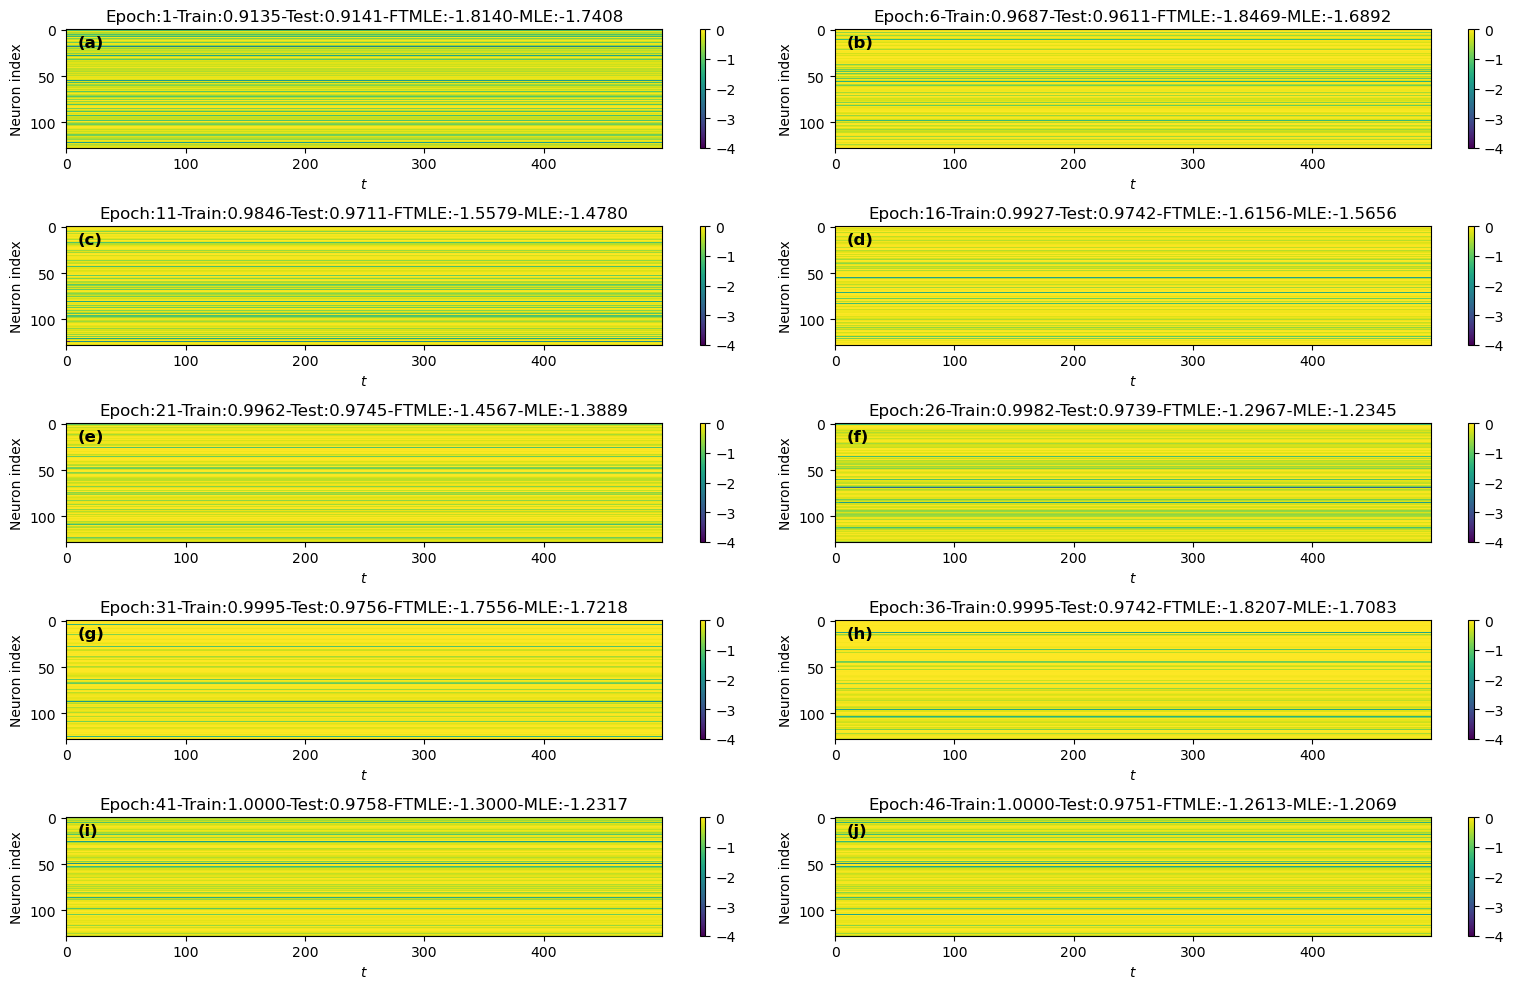

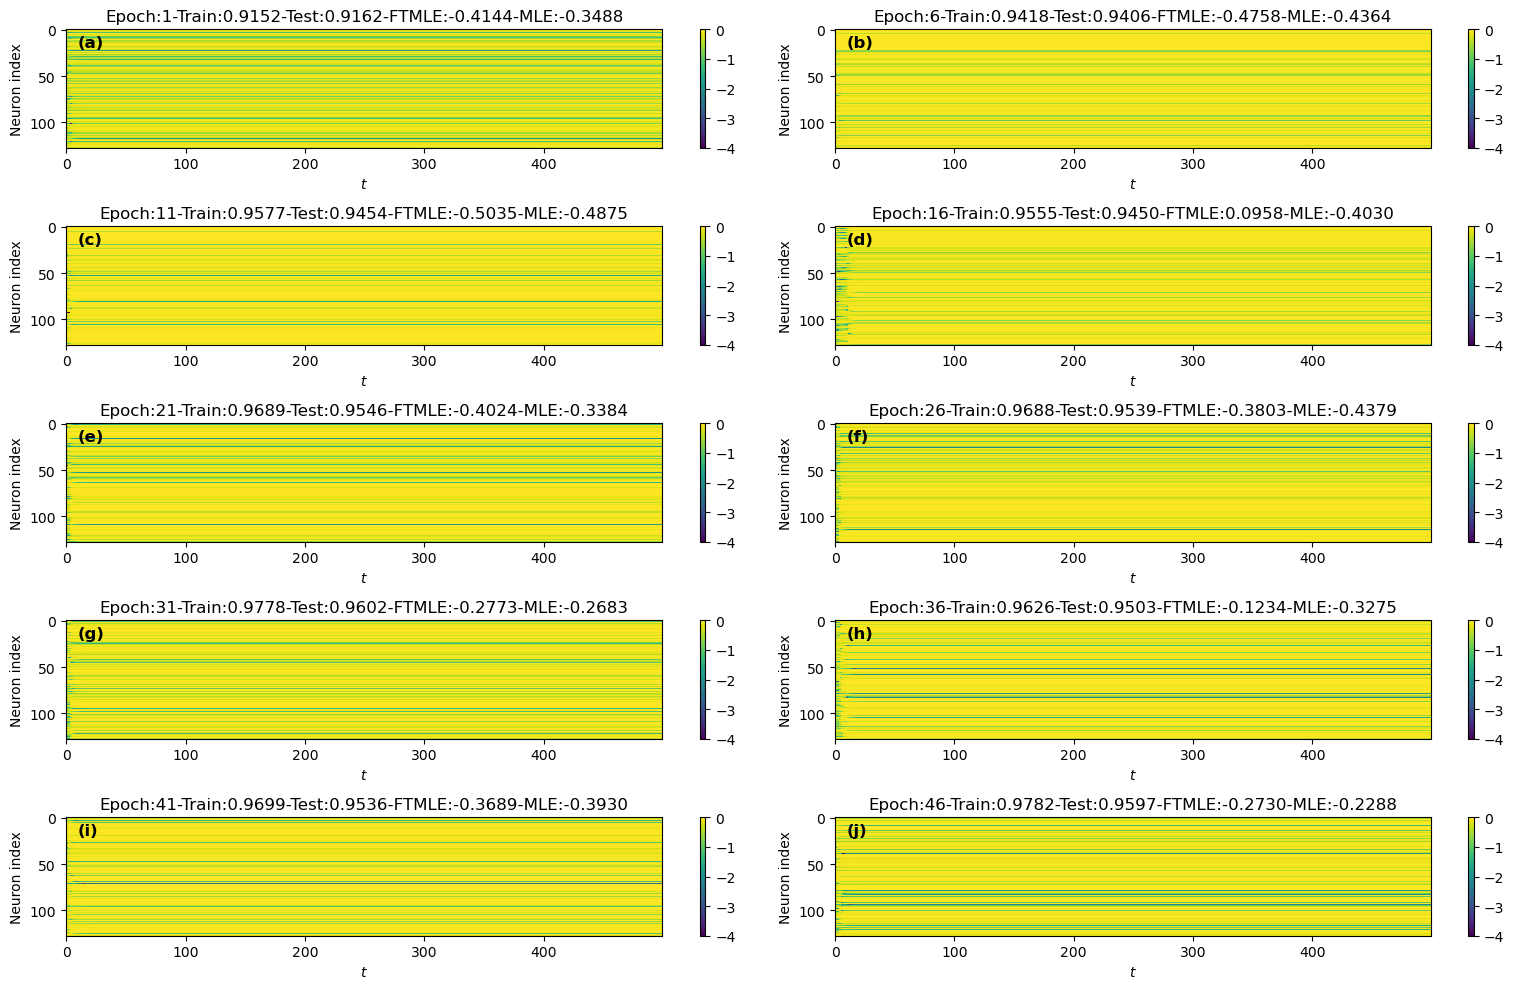

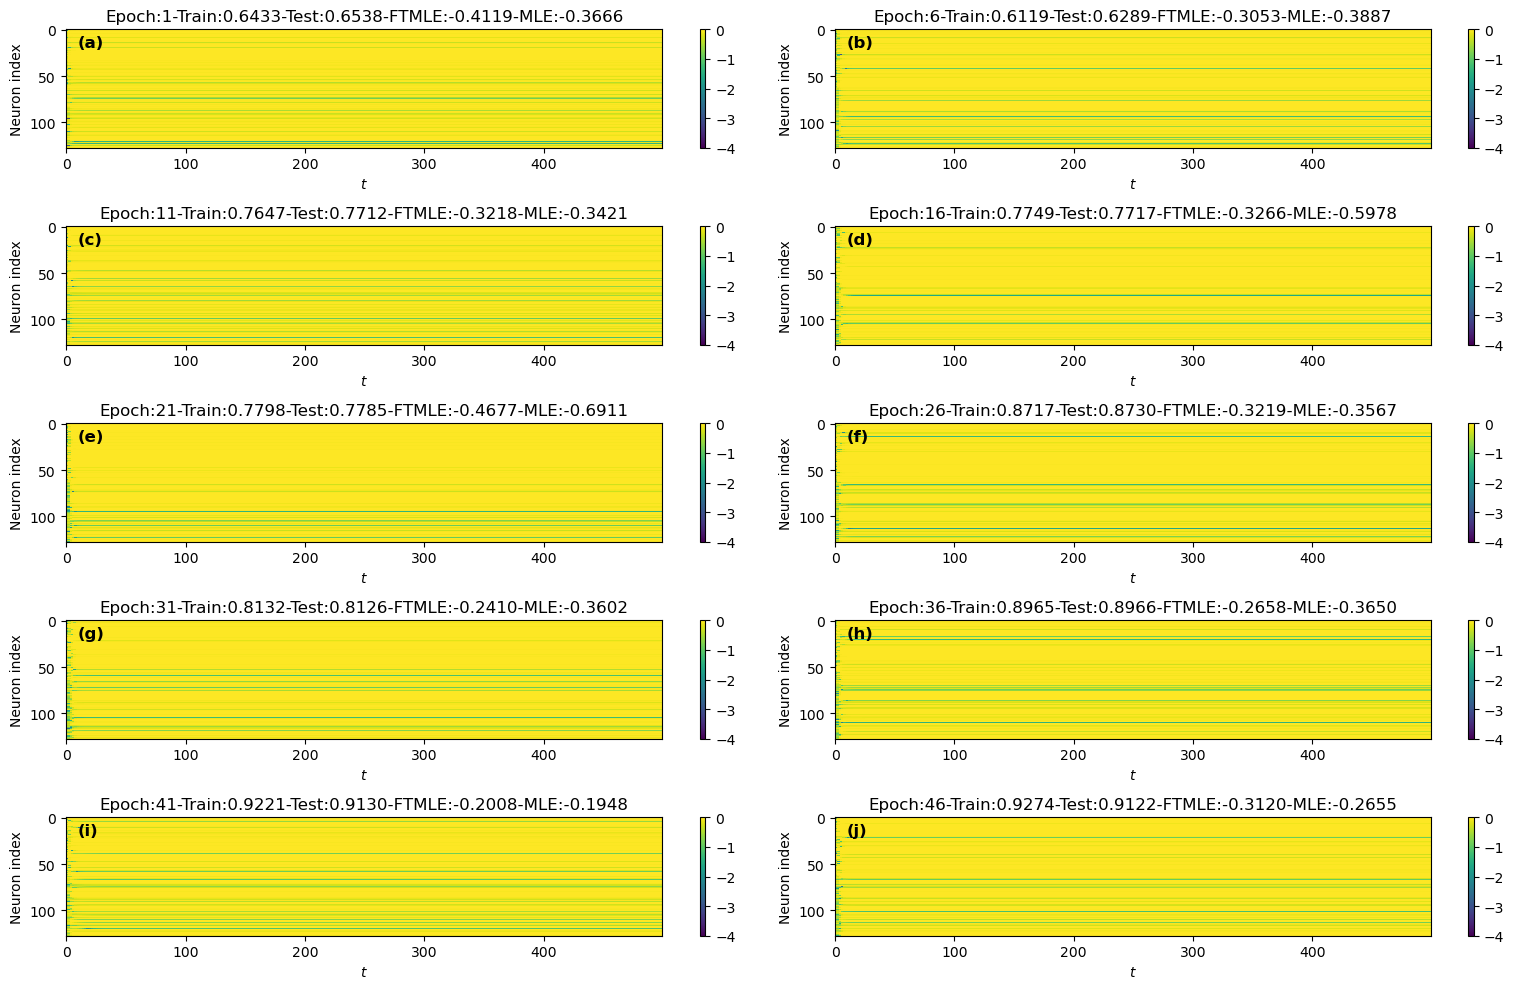

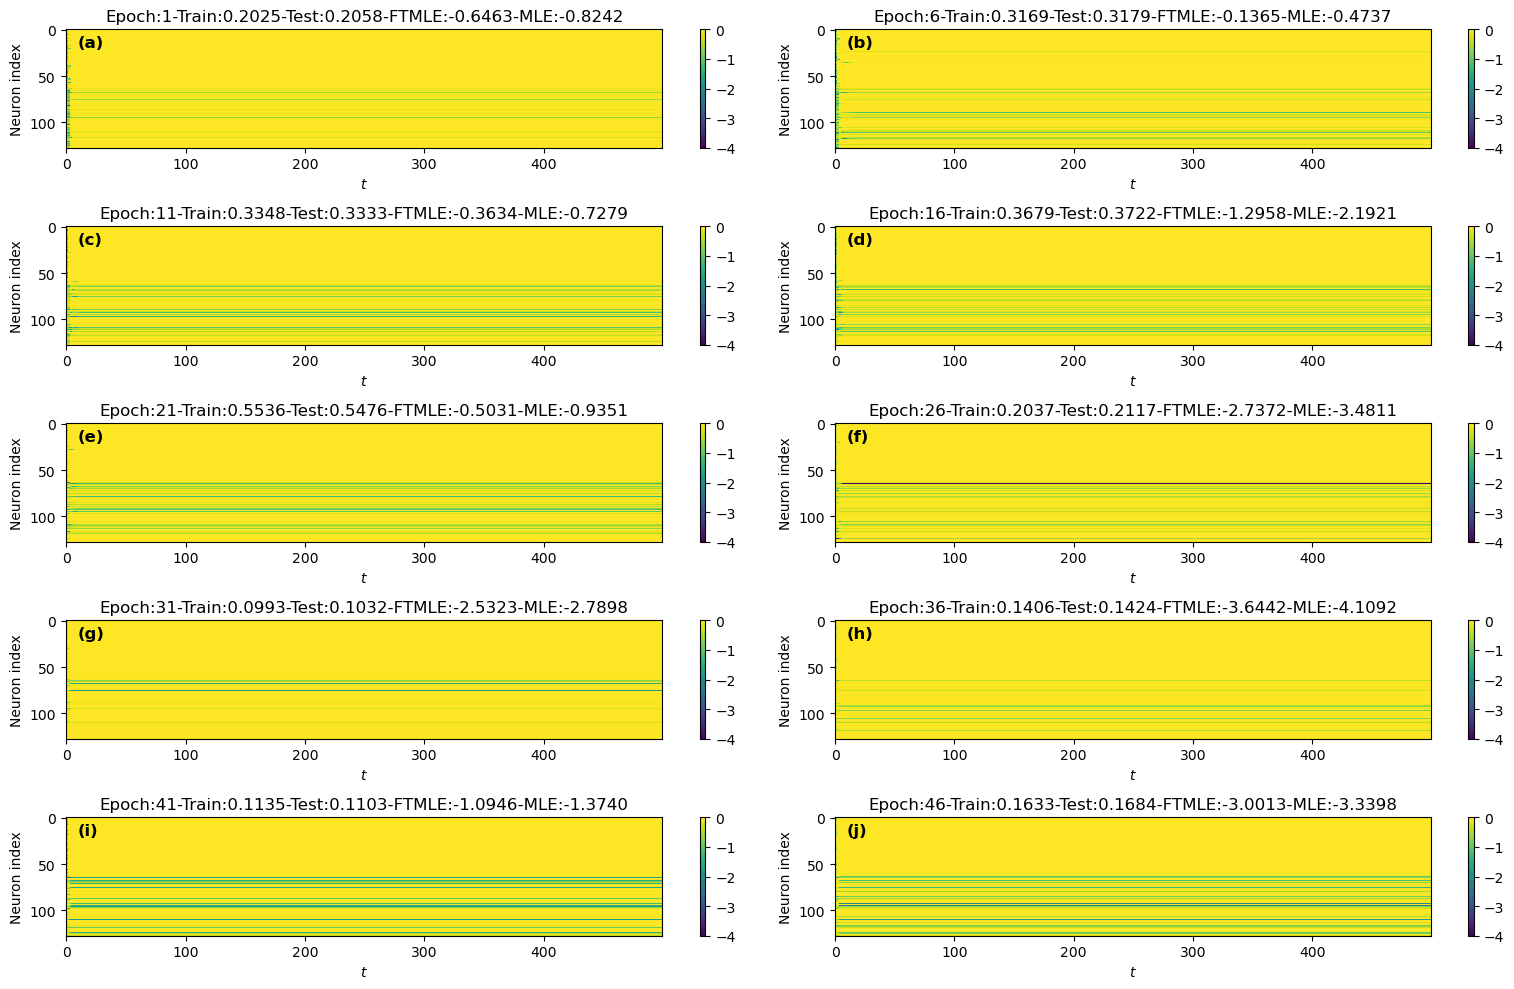

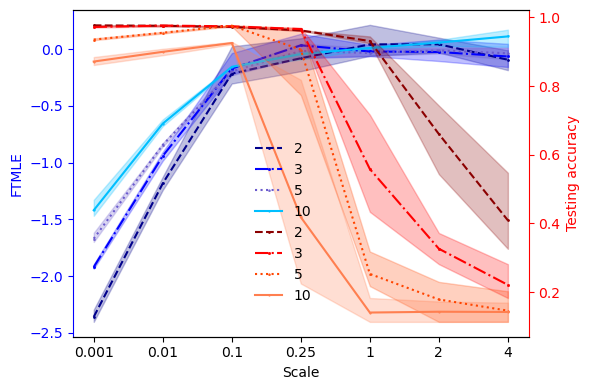

In [10]:
# -----------------------------------
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'H', '+', 'x', '|', '_']
linestyles = ['--', '-.', ':', '-']
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'lime', 'teal', 'olive', 'hotpink']
colors_r = ['darkred', 'red', 'orangered','coral','sandybrown']
colors_b = ['darkblue', 'blue', 'slateblue','deepskyblue','skyblue']
colors_g = ['darkgreen', 'green', 'seagreen','lime','mediumspringgreen']

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
# #----------------
res_dynfigs_path = Path(res_path/f"dynfigs")
res_dynfigs_path.mkdir(parents=True, exist_ok=True)
nfig = 10
c_lim = [-4, 0]
M_range_s, ParaRange_s, multitest_s=M_range, ParaRange, multitest
M_range_s = [0.01, 0.25, 1, 4]
ParaRange_s = [2]
multitest_s = 1
for iM in range( len(M_range) ):
    for iPara in range( len(ParaRange) ):
        for  imultitest in range((multitest)):    
                if (M_range[iM] in M_range_s) and (ParaRange[iPara] in ParaRange_s) and (imultitest < multitest_s) :
                    fig, axes = plt.subplots(5, 2, figsize=(16, 10))
                    (zall) = zall_list[iM][iPara]         
                    info = f'EP_L{ParaRange[iPara]}_b_sc{M_range[iM]}-{imultitest}-{Einfo}'
                    train_n_epochs = len(res[iM][iPara][imultitest][3])
                    for fepoch in range(nfig):
                        epoch = train_n_epochs*fepoch//nfig
                        plt.subplot(5,2,fepoch+1)
                        plt.imshow(np.log10(np.abs(zall[epoch])+1e-20), aspect='auto', cmap='viridis', interpolation='nearest', clim=c_lim)
                        plt.title(f'Epoch:{epoch+1}-Train:{res[iM][iPara][imultitest][1][epoch]:.4f}-Test:{res[iM][iPara][imultitest][2][epoch]:.4f}'+\
                                f'-FTMLE:{res[iM][iPara][imultitest][3][epoch]:.4f}-MLE:{res[iM][iPara][imultitest][4][epoch]:.4f}')
                        plt.xlabel(r'$t$')
                        plt.ylabel('Neuron index')
                        plt.colorbar()

                    
                    for i, ax in enumerate(axes.flatten()):
                        ax.text(0.02, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
                    plt.tight_layout()
                    
                    plt.savefig(res_dynfigs_path / f"{info}.svg", format="svg")

#------------------
fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()
for iPara in range( len(ParaRange) ): 
    tmp0 =  np.max(res[:,iPara,:,3,:], axis=2)
    tmp = np.mean(tmp0,axis=1)

    ax1.plot(range(len(tmp)), tmp, color=colors_b[iPara], marker=markers[iPara], markersize=1, linestyle=linestyles[iPara], label=f'{ParaRange[iPara]}')  # 
    ax1.fill_between(range(len(tmp)), np.min(tmp0, axis=1), np.max(tmp0, axis=1), alpha=0.25, color=colors_b[iPara])
    ax1.set_xlabel('Scale')
    ax1.set_xticks(range(len(tmp)))
    ax1.set_xticklabels([f'{M_range[i]}' for i in range(len(M_range))])
    ax1.set_ylabel('FTMLE', color='b')
    ax1.tick_params(axis='y', labelcolor='b', color='b')
    ax1.spines['left'].set_color('b')  # 
    ax1.spines['right'].set_linewidth(0)  # 

    tmp0 =  np.max(res[:,iPara,:,2,:], axis=2)
    tmp = np.mean(tmp0,axis=1)
    ax2.plot(range(len(tmp)), tmp, color=colors_r[iPara], marker=markers[iPara], markersize=1, linestyle=linestyles[iPara], label=f'{ParaRange[iPara]}')  # 
    ax2.fill_between(range(len(tmp)), np.min(tmp0, axis=1), np.max(tmp0, axis=1), alpha=0.25, color=colors_r[iPara])
    ax2.set_ylabel('Testing accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r', color='r')
    ax2.spines['right'].set_color('r')  # 
    ax2.spines['left'].set_linewidth(0)  # 

# 
fig.tight_layout()  # 
fig.legend(frameon=False, fancybox=False, shadow=False, loc='lower center', bbox_to_anchor=(0.48, 0.2)) # loc='best', 

plt.title('')
if config.save:  plt.savefig(res_path / f"plot_all.svg", format="svg")  #  
# plt.show()


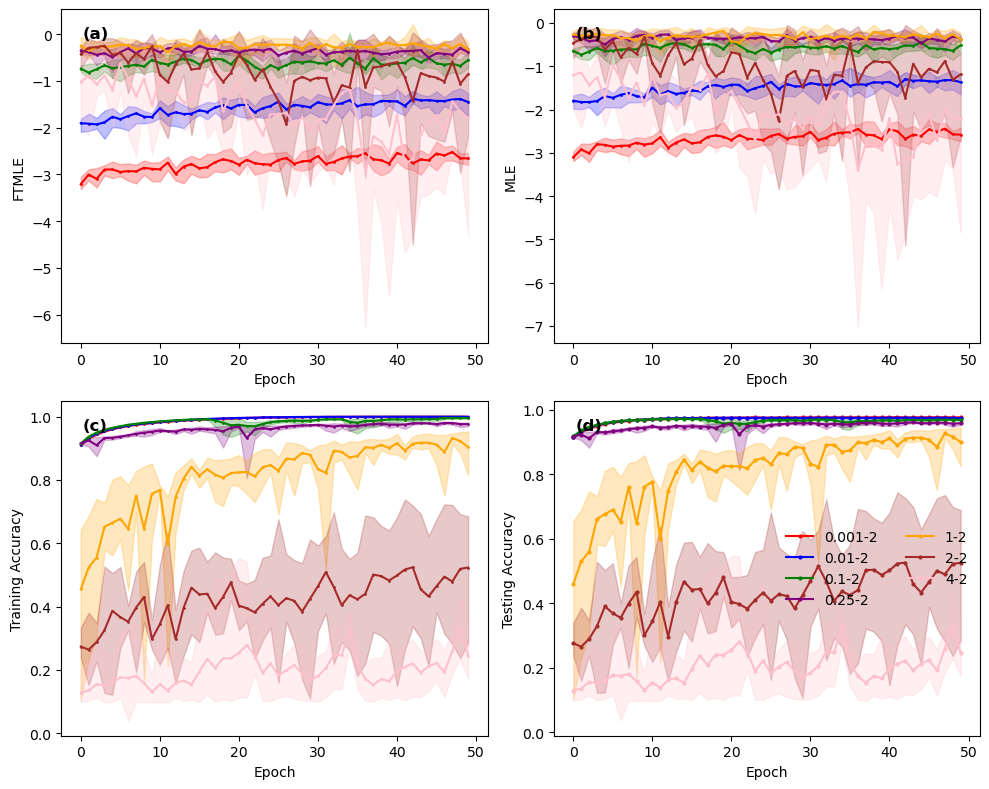

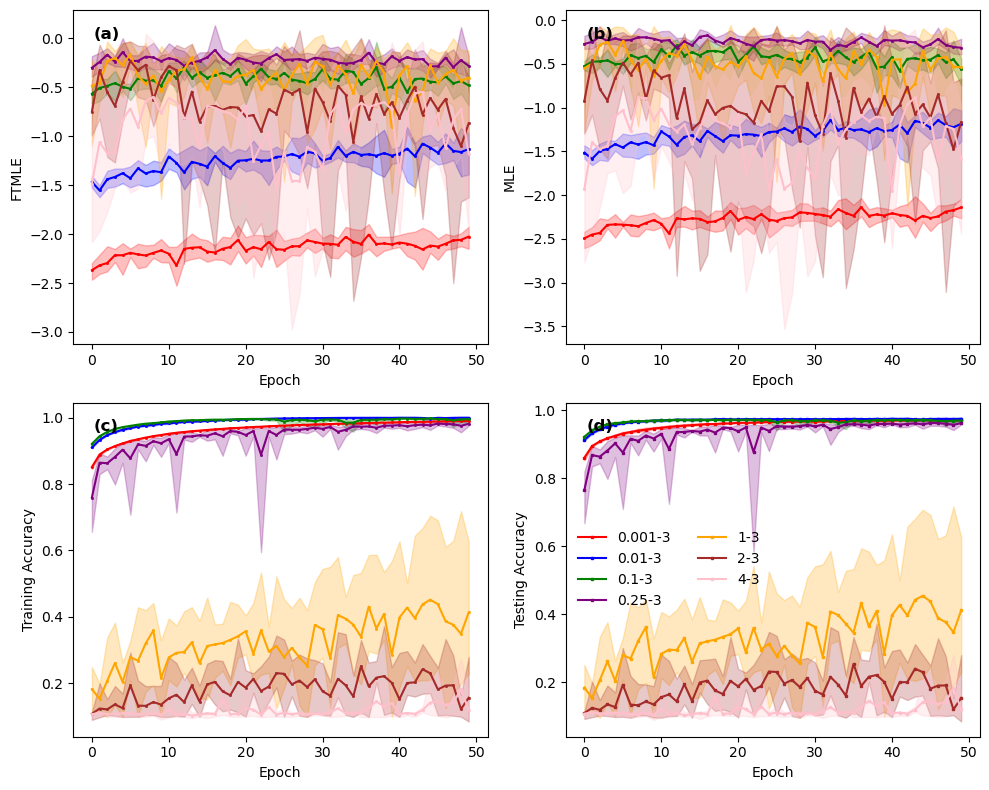

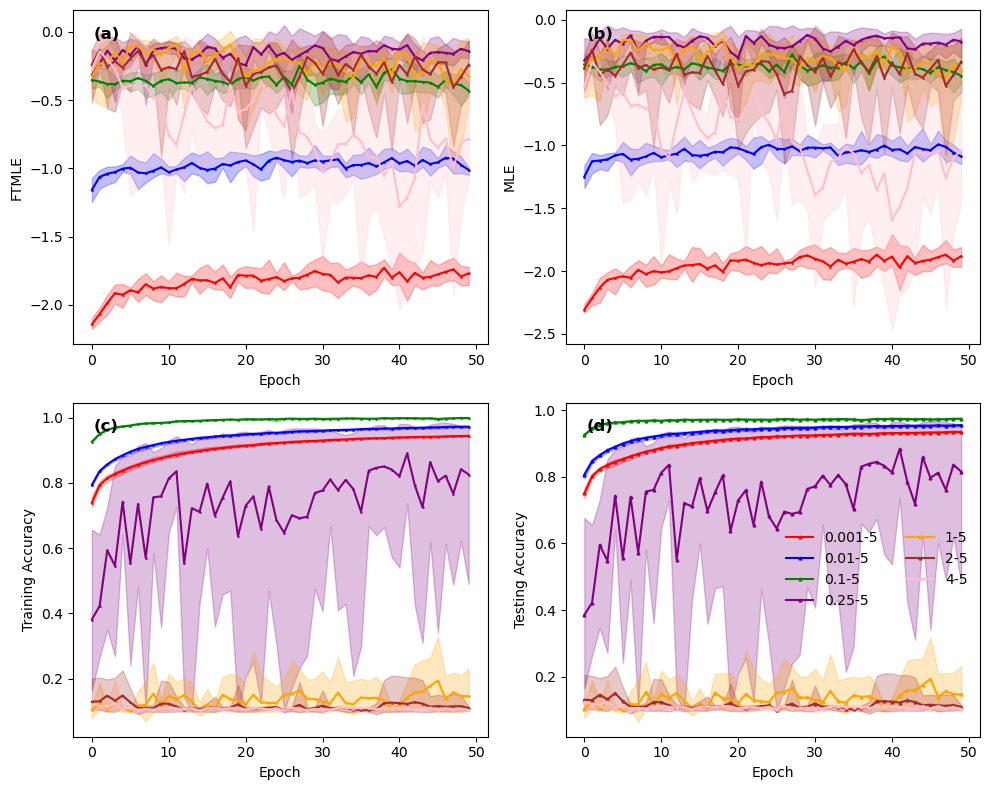

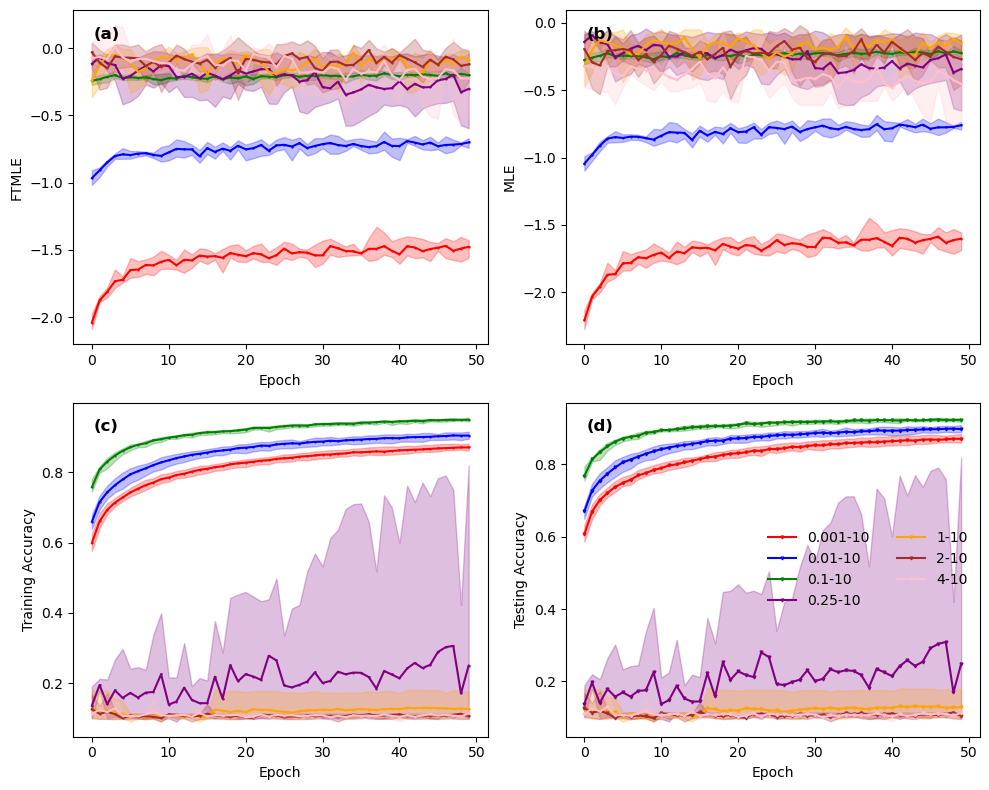

0


In [11]:

# --------------------------------------------------
for iPara in range( len(ParaRange) ):  
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    #----------------
    plt.subplot(221)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):  
            tmp = res[iM,iPara,:,3,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=1, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    # plt.xticks(index_range, ParaRange)

    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('FTMLE')
    # plt.legend(frameon=False, fancybox=False, shadow=False)

    #----------------
    plt.subplot(222)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):        
            tmp = res[iM,iPara,:,4,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=1, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('MLE')
    # plt.legend(frameon=False, fancybox=False, shadow=False)

    #----------------
    plt.subplot(223)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):        
            tmp = res[iM,iPara,:,1,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=1, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('Training Accuracy')
    # plt.legend(frameon=False, fancybox=False, shadow=False)

    #----------------
    plt.subplot(224)
    for iM in range(len(M_range)):
        # for iPara in range( len(ParaRange) ):        
            tmp = res[iM,iPara,:,2,:]
            plt.plot(np.arange(len(np.mean(tmp, axis=0))), np.mean(tmp, axis=0), color=colors[iM], marker=markers[iPara], markersize=2, label=f'{M_range[iM]}-{ParaRange[iPara]}')  #  plot
            plt.fill_between(np.arange(len(np.mean(tmp, axis=0))), np.min(tmp, axis=0), np.max(tmp, axis=0), alpha=0.25, color=colors[iM])
    plt.title('')
    plt.xlabel(f'Epoch')
    plt.ylabel('Testing Accuracy')
    plt.legend(frameon=False, fancybox=False, shadow=False, ncol=2)

    # 
    labels = ['(a)', '(b)', '(c)', '(d)']
    for i, ax in enumerate(axes.flatten()):
        ax.text(0.05, 0.95, labels[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
    plt.tight_layout()

    # if fsave: plt.savefig(res_path / f"plot_{ParaRange[iPara]}.pdf", format="pdf")  # 
    if config.save: plt.savefig(res_path / f"plot_{ParaRange[iPara]}.svg", format="svg")  #  

    
plt.show()

print('0')